In [ ]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm  # 
from pathlib import Path


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.backends.cudnn.benchmark = True

print(f"cuda:{torch.cuda.is_available()}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from models_LN import FNN_LN, dataset, one_hot, cross_entropy_loss, linear, linear_d, tanh, tanh_d, sign, sign_d, sigmoid, sigmoid_d, relu, relu_d, relu6, relu6_d, softmax, softmax_d

torch.set_grad_enabled(False)

cuda:True
GPU 0:NVIDIA GeForce GTX 1650:4.00GB


In [20]:

class Config:
    def __init__(self):
        self.n_input = 28 * 28  # 
        self.n_hidd = 16     # 
        self.n_out = 10      # 

        self.nL_hidd = 2

        self.sc_forward = 1
        self.sc_bias = 0
        self.sc_back = 1

        self.f = tanh #  relu tanh
        self.fd = tanh_d # relu_d tanh_d

        self.train_eta_global = 1e-3  #
        self.train_n_epochs = 100     # 
        self.train_batch_size = 500     # 
        self.train_task = "MNIST" #  "MNIST" "FMNIST" "CIFAR10"
        self.train_tmethod = ''     # 'FA','PC','LRA','BP'

        self.biasLearning = False
        
        self.EP_It2sta = 8
        self.EP_nudge = 1
        
config = Config()

In [21]:
train_loader, valid_loader, test_loader, config = dataset(config)
train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
valid_loader_gpu = [(data.to(device), target.to(device)) for data, target in valid_loader]
test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

In [22]:
##
ParaName = f'First_symm_LN_FfscFbsc2Dplot'
Einfo = ''

res_path = Path(f"./Res/{ParaName}-{config.train_task}-0")
M_range = [0.01, 0.1, 0.25, 0.5, 1] # bsc 0.001, 0.01, 0.1, 0.25, 1, 2, 4 fbsc  # 0.01, 0.1, 0.25, 0.5, 1, 2 SRsc
ParaRange = [0.1, 0.25, 0.5, 1] # fsc 0.001, 0.01, 0.1, 0.25, 1, 2, 4
multitest = 5
config.save = True
config.ff = softmax
config.ffd = softmax_d
# -=--------------------------
config.train_tmethod = 'EP'
config.nL_hidd = 5
config.n_hidd = 64     # 

config.train_n_epochs = 50  # 

config.EP_symm_W = True
config.adam = True
config.EP_b_learn = False

config.EP_nudge = 0.1
# config.EP_f_sc = 1
# config.EP_b_sc = 0.25

In [23]:
# -=--------------------------
res_path.mkdir(parents=True, exist_ok=True)
res = np.zeros((len(M_range),len(ParaRange),(multitest),6,config.train_n_epochs))

zall_list = [[[] for _ in range(len(ParaRange))] for _ in range(len(M_range))]
eall_list = [[[[] for _ in range((multitest))] for _ in range(len(ParaRange))] for _ in range(len(M_range))]

In [24]:
for iPara in range( len(ParaRange) ):
    for iM in range( len(M_range) ):
        for  imultitest in range((multitest)):
            config.EP_b_sc = M_range[iM]
            config.EP_f_sc = ParaRange[iPara]

            #-----------------
            config.EP_It2sta = config.nL_hidd *10 
            config.EP_It2sta2 = config.nL_hidd *5 
            # ---------------------------------
            model = FNN_LN(config).to(device)

            taskinfo = f'EP_L{config.nL_hidd}_{config.train_task}_{ParaName}-EP_b_sc{M_range[iM]}-EP_f_sc{ParaRange[iPara]}-{Einfo}'
            print(taskinfo)

            ## Train

            for epoch in range(config.train_n_epochs):
                losssum = 0
                random.shuffle(train_loader_gpu)
                with tqdm(total=len(train_loader_gpu), desc=f'Epoch {epoch + 1}/{config.train_n_epochs}: ', unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                    for i, (images, labels) in enumerate(train_loader_gpu):
                        # 
                        images = images.view(-1, config.n_input)
                        labels_one_hot = one_hot(labels, config.n_out, device=device)
                        # 
                        outputs = model.forward(images)
                        # 
                        loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                        losssum += loss.item()
                        #
                        outputs = model.backward(images, labels_one_hot, outputs)
                        # 
                        model.update_weights_adam() if config.adam else model.update_weights() #model.update_weights_adam() model.update_weights()
                        # 
                        if i % 10 == 0: 
                            pbar.set_postfix({'loss': f'{losssum/(i+1):.6f}'})  
                            pbar.update(10)

                SR, ftmle, mle = model.Lyapunov_EP(images[-1:,:], y=None, t_e=500, ret_zall=False)
                # SR, ftmle, mle, zall = model.Lyapunov_EP(images[-1:,:], y=None, t_e=500, ret_zall=True)
                # if imultitest==0: zall_list[iM][iPara].append(zall)

                # terr = model.ret_error()
                # eall_list[iM][iPara][imultitest].append(terr)

                # train set ------------------------------------------------------------
                train_correct = 0
                train_total = 0
                losssum = 0
                for images, labels in valid_loader_gpu:
                    images = images.view(-1, config.n_input)
                    labels_one_hot = one_hot(labels, config.n_out, device=device)
                    # 
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                    losssum += loss.item()
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()

                train_accuracy = train_correct / train_total

                # test set -------------------------------------------------------------
                test_correct = 0
                test_total = 0
                # ---------
                for images, labels in test_loader_gpu:
                    images = images.view(-1, config.n_input)
                    # 
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

                test_accuracy = test_correct / test_total

                res[iM][iPara][imultitest][0][epoch] = losssum
                res[iM][iPara][imultitest][1][epoch] = train_accuracy
                res[iM][iPara][imultitest][2][epoch] = test_accuracy
                res[iM][iPara][imultitest][3][epoch] = ftmle
                res[iM][iPara][imultitest][4][epoch] = mle
                res[iM][iPara][imultitest][5][epoch] = SR

                current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
                print(f'\t Loss: {res[iM][iPara][imultitest][0][epoch] :.3f},\t'
                    f'Train : {res[iM][iPara][imultitest][1][epoch] * 100:.2f}%({np.max(res[iM][iPara][imultitest][1]) * 100:.2f}%),\t'
                    f'Test : {res[iM][iPara][imultitest][2][epoch] * 100:.2f}%({np.max(res[iM][iPara][imultitest][2]) * 100:.2f}%),\t'
                    f'Current Time: {current_time}')
                
                # if 1-train_accuracy <1e-4:
                #     break
            
            # best result
            print(f"{taskinfo} Time: {current_time}, Epochs: {config.train_n_epochs}, Learning Rate: {config.train_eta_global}, "
                f"Best: {max(res[iM][iPara][imultitest][1]) * 100:.2f}%  {max(res[iM][iPara][imultitest][2]) * 100:.2f}%\n")
            
        for attempt in range(5):
            try:
                with open(res_path/"res.txt", "a") as f:
                    trainacct = np.max(res[iM][iPara][:,1,:], axis=-1)
                    testacct = np.max(res[iM][iPara][:,2,:], axis=-1)
                    f.write(f"{taskinfo} Time: {current_time}: "
                            f"train: {np.mean(trainacct) * 100:.2f}%+-{np.std(trainacct, ddof=1)*100:.2f}% ({np.min(trainacct) * 100:.2f}% {np.max(trainacct) * 100:.2f}%)"
                            f"\t test: {np.mean(testacct) * 100:.2f}%+-{np.std(testacct, ddof=1)*100:.2f}% ({np.min(testacct) * 100:.2f}% {np.max(testacct) * 100:.2f}%)\n")

                    for attr_name in dir(config):
                        if not attr_name.startswith('__') and not callable(getattr(config, attr_name)):  
                            attr_value = getattr(config, attr_name)
                            f.write(f'{attr_name}: {attr_value}  ')  
                    f.write(f'\n\n')  

                break  # 
            except PermissionError:
                if attempt < 5 - 1:
                    print(f"Permission denied, retrying in {5} seconds...")
                    time.sleep(5)
                else:
                    raise  # 
                        
                

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.1-


Epoch 1/50:   0%|                                              | 0/120 [00:00<?, ?batch/s]

d:\HWC\华为云盘\Codepy\aEP\models_LN.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(self.z, device=self.device)
Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.84batch/s, loss=2.220322]


	 Loss: 54.589,	Train : 20.79%(20.79%),	Test : 20.66%(20.66%),	Current Time: 20250708-132916


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.20batch/s, loss=1.753073]


	 Loss: 50.519,	Train : 21.25%(21.25%),	Test : 21.06%(21.06%),	Current Time: 20250708-132918


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=1.646474]


	 Loss: 48.099,	Train : 21.41%(21.41%),	Test : 21.24%(21.24%),	Current Time: 20250708-132921


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.38batch/s, loss=1.575103]


	 Loss: 45.751,	Train : 21.48%(21.48%),	Test : 21.22%(21.24%),	Current Time: 20250708-132923


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.97batch/s, loss=1.473310]


	 Loss: 41.797,	Train : 41.20%(41.20%),	Test : 40.82%(40.82%),	Current Time: 20250708-132925


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.33batch/s, loss=1.342351]


	 Loss: 38.114,	Train : 46.73%(46.73%),	Test : 46.61%(46.61%),	Current Time: 20250708-132928


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.27batch/s, loss=1.204976]


	 Loss: 31.430,	Train : 62.81%(62.81%),	Test : 62.51%(62.51%),	Current Time: 20250708-132930


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.70batch/s, loss=0.973299]


	 Loss: 26.578,	Train : 71.72%(71.72%),	Test : 71.13%(71.13%),	Current Time: 20250708-132932


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.70batch/s, loss=0.849723]


	 Loss: 23.175,	Train : 79.56%(79.56%),	Test : 78.89%(78.89%),	Current Time: 20250708-132935


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.46batch/s, loss=0.712820]


	 Loss: 18.077,	Train : 83.79%(83.79%),	Test : 82.77%(82.77%),	Current Time: 20250708-132937


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.91batch/s, loss=0.552374]


	 Loss: 14.651,	Train : 87.62%(87.62%),	Test : 86.68%(86.68%),	Current Time: 20250708-132940


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.99batch/s, loss=0.441307]


	 Loss: 11.645,	Train : 90.85%(90.85%),	Test : 90.30%(90.30%),	Current Time: 20250708-132942


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.34batch/s, loss=0.360489]


	 Loss: 9.667,	Train : 92.35%(92.35%),	Test : 91.46%(91.46%),	Current Time: 20250708-132944


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.65batch/s, loss=0.310842]


	 Loss: 8.459,	Train : 93.28%(93.28%),	Test : 92.35%(92.35%),	Current Time: 20250708-132947


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.20batch/s, loss=0.274685]


	 Loss: 7.437,	Train : 94.13%(94.13%),	Test : 93.18%(93.18%),	Current Time: 20250708-132949


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.29batch/s, loss=0.248859]


	 Loss: 6.893,	Train : 94.56%(94.56%),	Test : 93.34%(93.34%),	Current Time: 20250708-132951


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.57batch/s, loss=0.228936]


	 Loss: 6.217,	Train : 95.08%(95.08%),	Test : 93.75%(93.75%),	Current Time: 20250708-132954


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.13batch/s, loss=0.211505]


	 Loss: 6.148,	Train : 94.91%(95.08%),	Test : 93.58%(93.75%),	Current Time: 20250708-132956


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.50batch/s, loss=0.199148]


	 Loss: 5.474,	Train : 95.48%(95.48%),	Test : 93.73%(93.75%),	Current Time: 20250708-132959


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.77batch/s, loss=0.183253]


	 Loss: 5.357,	Train : 95.67%(95.67%),	Test : 93.83%(93.83%),	Current Time: 20250708-133001


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.14batch/s, loss=0.174936]


	 Loss: 4.947,	Train : 95.77%(95.77%),	Test : 93.72%(93.83%),	Current Time: 20250708-133003


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.18batch/s, loss=0.162894]


	 Loss: 4.465,	Train : 96.30%(96.30%),	Test : 94.08%(94.08%),	Current Time: 20250708-133006


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.99batch/s, loss=0.154448]


	 Loss: 4.453,	Train : 96.38%(96.38%),	Test : 94.17%(94.17%),	Current Time: 20250708-133008


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.91batch/s, loss=0.146561]


	 Loss: 4.127,	Train : 96.41%(96.41%),	Test : 94.03%(94.17%),	Current Time: 20250708-133011


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.88batch/s, loss=0.137719]


	 Loss: 3.725,	Train : 96.94%(96.94%),	Test : 94.55%(94.55%),	Current Time: 20250708-133013


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.37batch/s, loss=0.129608]


	 Loss: 3.520,	Train : 97.09%(97.09%),	Test : 94.68%(94.68%),	Current Time: 20250708-133015


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.96batch/s, loss=0.124366]


	 Loss: 3.535,	Train : 96.96%(97.09%),	Test : 94.41%(94.68%),	Current Time: 20250708-133018


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.34batch/s, loss=0.119683]


	 Loss: 3.279,	Train : 97.29%(97.29%),	Test : 94.74%(94.74%),	Current Time: 20250708-133020


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.75batch/s, loss=0.113714]


	 Loss: 3.093,	Train : 97.41%(97.41%),	Test : 94.96%(94.96%),	Current Time: 20250708-133023


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.20batch/s, loss=0.108058]


	 Loss: 2.963,	Train : 97.45%(97.45%),	Test : 94.81%(94.96%),	Current Time: 20250708-133025


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.25batch/s, loss=0.106986]


	 Loss: 2.923,	Train : 97.54%(97.54%),	Test : 95.06%(95.06%),	Current Time: 20250708-133027


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.07batch/s, loss=0.098877]


	 Loss: 2.735,	Train : 97.77%(97.77%),	Test : 95.20%(95.20%),	Current Time: 20250708-133030


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.34batch/s, loss=0.093222]


	 Loss: 2.504,	Train : 97.95%(97.95%),	Test : 95.03%(95.20%),	Current Time: 20250708-133032


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.40batch/s, loss=0.092398]


	 Loss: 2.502,	Train : 97.92%(97.95%),	Test : 95.05%(95.20%),	Current Time: 20250708-133035


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.03batch/s, loss=0.089689]


	 Loss: 2.649,	Train : 97.70%(97.95%),	Test : 95.03%(95.20%),	Current Time: 20250708-133037


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.25batch/s, loss=0.091110]


	 Loss: 2.302,	Train : 98.04%(98.04%),	Test : 95.15%(95.20%),	Current Time: 20250708-133039


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.94batch/s, loss=0.078736]


	 Loss: 2.135,	Train : 98.24%(98.24%),	Test : 95.07%(95.20%),	Current Time: 20250708-133042


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.42batch/s, loss=0.075458]


	 Loss: 2.313,	Train : 98.04%(98.24%),	Test : 95.21%(95.21%),	Current Time: 20250708-133044


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.09batch/s, loss=0.071980]


	 Loss: 1.999,	Train : 98.31%(98.31%),	Test : 95.08%(95.21%),	Current Time: 20250708-133047


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.12batch/s, loss=0.074404]


	 Loss: 1.984,	Train : 98.38%(98.38%),	Test : 95.04%(95.21%),	Current Time: 20250708-133049


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.50batch/s, loss=0.068669]


	 Loss: 1.945,	Train : 98.39%(98.39%),	Test : 95.24%(95.24%),	Current Time: 20250708-133052


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.87batch/s, loss=0.065441]


	 Loss: 1.751,	Train : 98.58%(98.58%),	Test : 95.42%(95.42%),	Current Time: 20250708-133054


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.16batch/s, loss=0.063979]


	 Loss: 1.622,	Train : 98.73%(98.73%),	Test : 95.38%(95.42%),	Current Time: 20250708-133056


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.54batch/s, loss=0.058141]


	 Loss: 2.048,	Train : 98.15%(98.73%),	Test : 95.09%(95.42%),	Current Time: 20250708-133059


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.39batch/s, loss=0.061273]


	 Loss: 1.607,	Train : 98.67%(98.73%),	Test : 95.14%(95.42%),	Current Time: 20250708-133101


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.40batch/s, loss=0.058490]


	 Loss: 1.525,	Train : 98.77%(98.77%),	Test : 95.45%(95.45%),	Current Time: 20250708-133103


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.44batch/s, loss=0.053853]


	 Loss: 1.362,	Train : 98.94%(98.94%),	Test : 95.41%(95.45%),	Current Time: 20250708-133106


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.03batch/s, loss=0.052102]


	 Loss: 1.446,	Train : 98.78%(98.94%),	Test : 95.27%(95.45%),	Current Time: 20250708-133108


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.34batch/s, loss=0.051024]


	 Loss: 1.274,	Train : 99.05%(99.05%),	Test : 95.41%(95.45%),	Current Time: 20250708-133111


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.79batch/s, loss=0.049658]


	 Loss: 1.251,	Train : 99.03%(99.05%),	Test : 95.32%(95.45%),	Current Time: 20250708-133113
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.1- Time: 20250708-133113, Epochs: 50, Learning Rate: 0.001, Best: 99.05%  95.45%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.98batch/s, loss=2.226144]


	 Loss: 54.459,	Train : 21.19%(21.19%),	Test : 21.05%(21.05%),	Current Time: 20250708-133115


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.56batch/s, loss=1.745155]


	 Loss: 48.604,	Train : 32.54%(32.54%),	Test : 31.91%(31.91%),	Current Time: 20250708-133118


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.39batch/s, loss=1.309222]


	 Loss: 31.801,	Train : 60.91%(60.91%),	Test : 61.07%(61.07%),	Current Time: 20250708-133120


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.42batch/s, loss=0.982910]


	 Loss: 26.578,	Train : 69.03%(69.03%),	Test : 69.19%(69.19%),	Current Time: 20250708-133123


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.68batch/s, loss=0.819744]


	 Loss: 21.945,	Train : 77.64%(77.64%),	Test : 77.62%(77.62%),	Current Time: 20250708-133125


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.43batch/s, loss=0.679310]


	 Loss: 18.258,	Train : 81.69%(81.69%),	Test : 81.56%(81.56%),	Current Time: 20250708-133127


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.09batch/s, loss=0.574835]


	 Loss: 15.523,	Train : 86.91%(86.91%),	Test : 86.48%(86.48%),	Current Time: 20250708-133130


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.43batch/s, loss=0.501205]


	 Loss: 13.808,	Train : 88.32%(88.32%),	Test : 87.67%(87.67%),	Current Time: 20250708-133132


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.70batch/s, loss=0.444026]


	 Loss: 12.490,	Train : 90.09%(90.09%),	Test : 89.52%(89.52%),	Current Time: 20250708-133135


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.05batch/s, loss=0.403162]


	 Loss: 11.224,	Train : 91.05%(91.05%),	Test : 89.94%(89.94%),	Current Time: 20250708-133137


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.54batch/s, loss=0.371491]


	 Loss: 10.428,	Train : 91.64%(91.64%),	Test : 90.52%(90.52%),	Current Time: 20250708-133139


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.25batch/s, loss=0.342618]


	 Loss: 9.451,	Train : 92.16%(92.16%),	Test : 90.83%(90.83%),	Current Time: 20250708-133142


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.36batch/s, loss=0.323761]


	 Loss: 8.563,	Train : 93.10%(93.10%),	Test : 91.80%(91.80%),	Current Time: 20250708-133144


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.37batch/s, loss=0.294127]


	 Loss: 8.165,	Train : 93.23%(93.23%),	Test : 91.83%(91.83%),	Current Time: 20250708-133147


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.73batch/s, loss=0.277688]


	 Loss: 7.567,	Train : 93.55%(93.55%),	Test : 91.52%(91.83%),	Current Time: 20250708-133149


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.64batch/s, loss=0.260768]


	 Loss: 7.413,	Train : 93.58%(93.58%),	Test : 91.85%(91.85%),	Current Time: 20250708-133152


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.55batch/s, loss=0.248048]


	 Loss: 6.894,	Train : 94.11%(94.11%),	Test : 92.02%(92.02%),	Current Time: 20250708-133154


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.85batch/s, loss=0.235219]


	 Loss: 6.709,	Train : 94.17%(94.17%),	Test : 92.21%(92.21%),	Current Time: 20250708-133156


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.03batch/s, loss=0.224579]


	 Loss: 6.317,	Train : 94.37%(94.37%),	Test : 92.15%(92.21%),	Current Time: 20250708-133159


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.30batch/s, loss=0.218750]


	 Loss: 6.024,	Train : 94.75%(94.75%),	Test : 92.10%(92.21%),	Current Time: 20250708-133201


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.39batch/s, loss=0.205176]


	 Loss: 5.585,	Train : 95.08%(95.08%),	Test : 92.68%(92.68%),	Current Time: 20250708-133204


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.22batch/s, loss=0.193736]


	 Loss: 5.524,	Train : 95.06%(95.08%),	Test : 92.30%(92.68%),	Current Time: 20250708-133206


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.39batch/s, loss=0.189348]


	 Loss: 5.516,	Train : 94.99%(95.08%),	Test : 92.31%(92.68%),	Current Time: 20250708-133209


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.52batch/s, loss=0.177627]


	 Loss: 5.800,	Train : 94.49%(95.08%),	Test : 91.75%(92.68%),	Current Time: 20250708-133211


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.16batch/s, loss=0.173222]


	 Loss: 4.822,	Train : 95.59%(95.59%),	Test : 92.25%(92.68%),	Current Time: 20250708-133214


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.78batch/s, loss=0.166869]


	 Loss: 4.443,	Train : 96.14%(96.14%),	Test : 92.85%(92.85%),	Current Time: 20250708-133216


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.53batch/s, loss=0.165251]


	 Loss: 4.493,	Train : 96.00%(96.14%),	Test : 92.39%(92.85%),	Current Time: 20250708-133218


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.67batch/s, loss=0.157882]


	 Loss: 4.278,	Train : 96.17%(96.17%),	Test : 92.75%(92.85%),	Current Time: 20250708-133221


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.52batch/s, loss=0.154304]


	 Loss: 4.416,	Train : 95.94%(96.17%),	Test : 92.48%(92.85%),	Current Time: 20250708-133223


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.53batch/s, loss=0.143714]


	 Loss: 3.899,	Train : 96.52%(96.52%),	Test : 92.87%(92.87%),	Current Time: 20250708-133225


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.41batch/s, loss=0.139999]


	 Loss: 3.793,	Train : 96.63%(96.63%),	Test : 92.82%(92.87%),	Current Time: 20250708-133228


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.01batch/s, loss=0.138344]


	 Loss: 3.881,	Train : 96.43%(96.63%),	Test : 92.86%(92.87%),	Current Time: 20250708-133230


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.02batch/s, loss=0.133206]


	 Loss: 3.953,	Train : 96.38%(96.63%),	Test : 92.78%(92.87%),	Current Time: 20250708-133232


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.33batch/s, loss=0.131576]


	 Loss: 3.812,	Train : 96.48%(96.63%),	Test : 92.81%(92.87%),	Current Time: 20250708-133235


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.86batch/s, loss=0.126445]


	 Loss: 3.315,	Train : 97.15%(97.15%),	Test : 92.87%(92.87%),	Current Time: 20250708-133237


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.32batch/s, loss=0.117628]


	 Loss: 4.033,	Train : 96.16%(97.15%),	Test : 92.47%(92.87%),	Current Time: 20250708-133239


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.62batch/s, loss=0.116306]


	 Loss: 3.144,	Train : 97.20%(97.20%),	Test : 93.00%(93.00%),	Current Time: 20250708-133242


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.74batch/s, loss=0.111596]


	 Loss: 3.049,	Train : 97.28%(97.28%),	Test : 93.00%(93.00%),	Current Time: 20250708-133244


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.26batch/s, loss=0.106971]


	 Loss: 3.402,	Train : 96.74%(97.28%),	Test : 92.38%(93.00%),	Current Time: 20250708-133247


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.74batch/s, loss=0.112846]


	 Loss: 3.221,	Train : 97.05%(97.28%),	Test : 92.66%(93.00%),	Current Time: 20250708-133249


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.80batch/s, loss=0.103912]


	 Loss: 2.984,	Train : 97.31%(97.31%),	Test : 92.81%(93.00%),	Current Time: 20250708-133251


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.99batch/s, loss=0.097956]


	 Loss: 2.852,	Train : 97.46%(97.46%),	Test : 92.91%(93.00%),	Current Time: 20250708-133254


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.73batch/s, loss=0.100326]


	 Loss: 3.051,	Train : 97.19%(97.46%),	Test : 93.06%(93.06%),	Current Time: 20250708-133256


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.21batch/s, loss=0.092854]


	 Loss: 2.788,	Train : 97.44%(97.46%),	Test : 92.63%(93.06%),	Current Time: 20250708-133258


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.34batch/s, loss=0.094350]


	 Loss: 2.511,	Train : 97.75%(97.75%),	Test : 92.94%(93.06%),	Current Time: 20250708-133301


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.93batch/s, loss=0.090202]


	 Loss: 2.613,	Train : 97.69%(97.75%),	Test : 92.84%(93.06%),	Current Time: 20250708-133303


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.56batch/s, loss=0.088228]


	 Loss: 2.243,	Train : 98.17%(98.17%),	Test : 92.90%(93.06%),	Current Time: 20250708-133305


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.94batch/s, loss=0.080591]


	 Loss: 2.215,	Train : 98.15%(98.17%),	Test : 93.09%(93.09%),	Current Time: 20250708-133308


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.25batch/s, loss=0.076933]


	 Loss: 2.337,	Train : 97.92%(98.17%),	Test : 92.70%(93.09%),	Current Time: 20250708-133310


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.25batch/s, loss=0.082554]


	 Loss: 2.407,	Train : 97.82%(98.17%),	Test : 92.82%(93.09%),	Current Time: 20250708-133312
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.1- Time: 20250708-133312, Epochs: 50, Learning Rate: 0.001, Best: 98.17%  93.09%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.66batch/s, loss=2.254533]


	 Loss: 54.579,	Train : 21.55%(21.55%),	Test : 21.93%(21.93%),	Current Time: 20250708-133315


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.19batch/s, loss=1.640553]


	 Loss: 39.391,	Train : 43.55%(43.55%),	Test : 44.33%(44.33%),	Current Time: 20250708-133317


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.91batch/s, loss=1.096249]


	 Loss: 27.042,	Train : 70.67%(70.67%),	Test : 70.74%(70.74%),	Current Time: 20250708-133319


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.38batch/s, loss=0.792196]


	 Loss: 19.935,	Train : 84.21%(84.21%),	Test : 84.11%(84.11%),	Current Time: 20250708-133322


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.69batch/s, loss=0.613632]


	 Loss: 16.055,	Train : 87.84%(87.84%),	Test : 87.66%(87.66%),	Current Time: 20250708-133324


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.18batch/s, loss=0.510687]


	 Loss: 13.685,	Train : 89.95%(89.95%),	Test : 89.20%(89.20%),	Current Time: 20250708-133326


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.34batch/s, loss=0.445446]


	 Loss: 12.014,	Train : 90.89%(90.89%),	Test : 89.91%(89.91%),	Current Time: 20250708-133329


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.92batch/s, loss=0.394208]


	 Loss: 10.869,	Train : 91.56%(91.56%),	Test : 90.45%(90.45%),	Current Time: 20250708-133331


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.05batch/s, loss=0.358017]


	 Loss: 9.967,	Train : 92.23%(92.23%),	Test : 90.88%(90.88%),	Current Time: 20250708-133333


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.02batch/s, loss=0.331507]


	 Loss: 9.090,	Train : 92.84%(92.84%),	Test : 91.24%(91.24%),	Current Time: 20250708-133336


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=0.307429]


	 Loss: 8.166,	Train : 93.59%(93.59%),	Test : 91.83%(91.83%),	Current Time: 20250708-133338


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.58batch/s, loss=0.277963]


	 Loss: 7.704,	Train : 93.69%(93.69%),	Test : 91.76%(91.83%),	Current Time: 20250708-133340


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.86batch/s, loss=0.261360]


	 Loss: 7.178,	Train : 94.21%(94.21%),	Test : 91.86%(91.86%),	Current Time: 20250708-133343


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.06batch/s, loss=0.243087]


	 Loss: 6.820,	Train : 94.33%(94.33%),	Test : 91.81%(91.86%),	Current Time: 20250708-133345


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.69batch/s, loss=0.235026]


	 Loss: 6.792,	Train : 94.25%(94.33%),	Test : 92.02%(92.02%),	Current Time: 20250708-133347


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.32batch/s, loss=0.220137]


	 Loss: 6.018,	Train : 94.91%(94.91%),	Test : 92.30%(92.30%),	Current Time: 20250708-133350


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.64batch/s, loss=0.205939]


	 Loss: 5.676,	Train : 95.29%(95.29%),	Test : 92.75%(92.75%),	Current Time: 20250708-133352


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.45batch/s, loss=0.197404]


	 Loss: 5.445,	Train : 95.30%(95.30%),	Test : 92.32%(92.75%),	Current Time: 20250708-133354


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.50batch/s, loss=0.185190]


	 Loss: 5.804,	Train : 94.78%(95.30%),	Test : 92.22%(92.75%),	Current Time: 20250708-133356


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.59batch/s, loss=0.177604]


	 Loss: 4.988,	Train : 95.88%(95.88%),	Test : 92.78%(92.78%),	Current Time: 20250708-133359


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.41batch/s, loss=0.168682]


	 Loss: 4.658,	Train : 96.01%(96.01%),	Test : 92.75%(92.78%),	Current Time: 20250708-133401


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.88batch/s, loss=0.165491]


	 Loss: 4.319,	Train : 96.31%(96.31%),	Test : 92.92%(92.92%),	Current Time: 20250708-133403


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.95batch/s, loss=0.153859]


	 Loss: 4.100,	Train : 96.45%(96.45%),	Test : 93.13%(93.13%),	Current Time: 20250708-133406


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.49batch/s, loss=0.149704]


	 Loss: 4.192,	Train : 96.30%(96.45%),	Test : 92.70%(93.13%),	Current Time: 20250708-133408


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.07batch/s, loss=0.142288]


	 Loss: 3.949,	Train : 96.53%(96.53%),	Test : 93.00%(93.13%),	Current Time: 20250708-133410


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.73batch/s, loss=0.141767]


	 Loss: 4.062,	Train : 96.31%(96.53%),	Test : 92.78%(93.13%),	Current Time: 20250708-133413


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.18batch/s, loss=0.129343]


	 Loss: 4.321,	Train : 95.86%(96.53%),	Test : 92.42%(93.13%),	Current Time: 20250708-133415


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.73batch/s, loss=0.128849]


	 Loss: 3.503,	Train : 96.89%(96.89%),	Test : 92.79%(93.13%),	Current Time: 20250708-133417


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.15batch/s, loss=0.120606]


	 Loss: 3.418,	Train : 96.92%(96.92%),	Test : 93.11%(93.13%),	Current Time: 20250708-133420


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.38batch/s, loss=0.113922]


	 Loss: 3.082,	Train : 97.30%(97.30%),	Test : 93.31%(93.31%),	Current Time: 20250708-133422


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.47batch/s, loss=0.115143]


	 Loss: 3.151,	Train : 97.11%(97.30%),	Test : 92.98%(93.31%),	Current Time: 20250708-133425


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.60batch/s, loss=0.111684]


	 Loss: 3.272,	Train : 97.02%(97.30%),	Test : 92.69%(93.31%),	Current Time: 20250708-133427


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.40batch/s, loss=0.101322]


	 Loss: 3.354,	Train : 96.76%(97.30%),	Test : 93.05%(93.31%),	Current Time: 20250708-133429


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.76batch/s, loss=0.102491]


	 Loss: 2.670,	Train : 97.66%(97.66%),	Test : 93.37%(93.37%),	Current Time: 20250708-133431


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.12batch/s, loss=0.102256]


	 Loss: 2.623,	Train : 97.66%(97.66%),	Test : 93.17%(93.37%),	Current Time: 20250708-133434


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.10batch/s, loss=0.095010]


	 Loss: 2.651,	Train : 97.56%(97.66%),	Test : 93.27%(93.37%),	Current Time: 20250708-133436


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.41batch/s, loss=0.091219]


	 Loss: 2.291,	Train : 98.07%(98.07%),	Test : 93.45%(93.45%),	Current Time: 20250708-133439


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.12batch/s, loss=0.082669]


	 Loss: 2.511,	Train : 97.65%(98.07%),	Test : 92.99%(93.45%),	Current Time: 20250708-133441


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.65batch/s, loss=0.081284]


	 Loss: 2.092,	Train : 98.22%(98.22%),	Test : 93.46%(93.46%),	Current Time: 20250708-133443


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.02batch/s, loss=0.080075]


	 Loss: 2.216,	Train : 97.89%(98.22%),	Test : 93.24%(93.46%),	Current Time: 20250708-133445


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.05batch/s, loss=0.082610]


	 Loss: 2.361,	Train : 97.77%(98.22%),	Test : 92.90%(93.46%),	Current Time: 20250708-133448


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.29batch/s, loss=0.079125]


	 Loss: 2.285,	Train : 97.89%(98.22%),	Test : 92.67%(93.46%),	Current Time: 20250708-133450


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.56batch/s, loss=0.081368]


	 Loss: 2.008,	Train : 98.22%(98.22%),	Test : 93.18%(93.46%),	Current Time: 20250708-133452


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.56batch/s, loss=0.070920]


	 Loss: 2.370,	Train : 97.75%(98.22%),	Test : 93.02%(93.46%),	Current Time: 20250708-133455


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.85batch/s, loss=0.072295]


	 Loss: 1.801,	Train : 98.45%(98.45%),	Test : 93.09%(93.46%),	Current Time: 20250708-133457


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.14batch/s, loss=0.070028]


	 Loss: 1.789,	Train : 98.48%(98.48%),	Test : 93.26%(93.46%),	Current Time: 20250708-133459


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.65batch/s, loss=0.068806]


	 Loss: 1.999,	Train : 98.20%(98.48%),	Test : 93.05%(93.46%),	Current Time: 20250708-133502


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.17batch/s, loss=0.066954]


	 Loss: 1.734,	Train : 98.58%(98.58%),	Test : 93.32%(93.46%),	Current Time: 20250708-133504


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.65batch/s, loss=0.063976]


	 Loss: 1.540,	Train : 98.79%(98.79%),	Test : 93.15%(93.46%),	Current Time: 20250708-133506


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.07batch/s, loss=0.057837]


	 Loss: 2.044,	Train : 98.16%(98.79%),	Test : 93.08%(93.46%),	Current Time: 20250708-133509
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.1- Time: 20250708-133509, Epochs: 50, Learning Rate: 0.001, Best: 98.79%  93.46%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.47batch/s, loss=2.239480]


	 Loss: 54.464,	Train : 19.41%(19.41%),	Test : 19.46%(19.46%),	Current Time: 20250708-133511


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.63batch/s, loss=1.708199]


	 Loss: 39.732,	Train : 48.76%(48.76%),	Test : 49.09%(49.09%),	Current Time: 20250708-133514


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.64batch/s, loss=1.075133]


	 Loss: 27.116,	Train : 71.53%(71.53%),	Test : 71.61%(71.61%),	Current Time: 20250708-133516


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.38batch/s, loss=0.806775]


	 Loss: 21.011,	Train : 82.56%(82.56%),	Test : 82.56%(82.56%),	Current Time: 20250708-133518


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.19batch/s, loss=0.642094]


	 Loss: 17.272,	Train : 85.94%(85.94%),	Test : 85.05%(85.05%),	Current Time: 20250708-133521


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.17batch/s, loss=0.537217]


	 Loss: 14.021,	Train : 89.26%(89.26%),	Test : 88.48%(88.48%),	Current Time: 20250708-133523


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.86batch/s, loss=0.457030]


	 Loss: 12.397,	Train : 90.36%(90.36%),	Test : 89.49%(89.49%),	Current Time: 20250708-133525


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.52batch/s, loss=0.412105]


	 Loss: 11.099,	Train : 91.24%(91.24%),	Test : 90.44%(90.44%),	Current Time: 20250708-133528


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.67batch/s, loss=0.373669]


	 Loss: 10.354,	Train : 91.69%(91.69%),	Test : 90.38%(90.44%),	Current Time: 20250708-133530


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.64batch/s, loss=0.334039]


	 Loss: 9.245,	Train : 92.47%(92.47%),	Test : 91.15%(91.15%),	Current Time: 20250708-133532


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.29batch/s, loss=0.314611]


	 Loss: 8.666,	Train : 92.98%(92.98%),	Test : 91.61%(91.61%),	Current Time: 20250708-133535


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.69batch/s, loss=0.292510]


	 Loss: 7.881,	Train : 93.49%(93.49%),	Test : 92.13%(92.13%),	Current Time: 20250708-133537


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.80batch/s, loss=0.273203]


	 Loss: 7.491,	Train : 93.70%(93.70%),	Test : 91.89%(92.13%),	Current Time: 20250708-133539


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.66batch/s, loss=0.254481]


	 Loss: 7.019,	Train : 93.96%(93.96%),	Test : 92.06%(92.13%),	Current Time: 20250708-133542


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.14batch/s, loss=0.243016]


	 Loss: 6.506,	Train : 94.50%(94.50%),	Test : 92.33%(92.33%),	Current Time: 20250708-133544


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.94batch/s, loss=0.228741]


	 Loss: 6.638,	Train : 94.29%(94.50%),	Test : 92.36%(92.36%),	Current Time: 20250708-133547


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.42batch/s, loss=0.215428]


	 Loss: 6.358,	Train : 94.37%(94.50%),	Test : 92.30%(92.36%),	Current Time: 20250708-133549


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.37batch/s, loss=0.207969]


	 Loss: 5.609,	Train : 95.05%(95.05%),	Test : 92.52%(92.52%),	Current Time: 20250708-133551


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.90batch/s, loss=0.194212]


	 Loss: 5.246,	Train : 95.43%(95.43%),	Test : 92.88%(92.88%),	Current Time: 20250708-133554


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.83batch/s, loss=0.185474]


	 Loss: 5.148,	Train : 95.50%(95.50%),	Test : 92.89%(92.89%),	Current Time: 20250708-133556


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.17batch/s, loss=0.180251]


	 Loss: 4.919,	Train : 95.68%(95.68%),	Test : 92.91%(92.91%),	Current Time: 20250708-133559


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=0.175547]


	 Loss: 4.758,	Train : 95.77%(95.77%),	Test : 92.94%(92.94%),	Current Time: 20250708-133601


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=0.162408]


	 Loss: 4.411,	Train : 96.12%(96.12%),	Test : 92.95%(92.95%),	Current Time: 20250708-133603


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.44batch/s, loss=0.157533]


	 Loss: 4.381,	Train : 96.06%(96.12%),	Test : 92.89%(92.95%),	Current Time: 20250708-133606


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.44batch/s, loss=0.153761]


	 Loss: 4.158,	Train : 96.36%(96.36%),	Test : 93.01%(93.01%),	Current Time: 20250708-133608


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.15batch/s, loss=0.147680]


	 Loss: 4.216,	Train : 96.14%(96.36%),	Test : 93.01%(93.01%),	Current Time: 20250708-133610


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.77batch/s, loss=0.140636]


	 Loss: 3.835,	Train : 96.62%(96.62%),	Test : 93.35%(93.35%),	Current Time: 20250708-133612


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=0.137946]


	 Loss: 3.720,	Train : 96.74%(96.74%),	Test : 93.24%(93.35%),	Current Time: 20250708-133615


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.87batch/s, loss=0.130295]


	 Loss: 3.832,	Train : 96.36%(96.74%),	Test : 92.80%(93.35%),	Current Time: 20250708-133617


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.75batch/s, loss=0.127959]


	 Loss: 3.761,	Train : 96.42%(96.74%),	Test : 92.71%(93.35%),	Current Time: 20250708-133619


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=0.123866]


	 Loss: 3.202,	Train : 97.25%(97.25%),	Test : 93.49%(93.49%),	Current Time: 20250708-133621


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=0.130048]


	 Loss: 3.529,	Train : 96.64%(97.25%),	Test : 92.86%(93.49%),	Current Time: 20250708-133623


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.72batch/s, loss=0.113976]


	 Loss: 2.977,	Train : 97.42%(97.42%),	Test : 93.33%(93.49%),	Current Time: 20250708-133626


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=0.114276]


	 Loss: 3.208,	Train : 97.12%(97.42%),	Test : 93.15%(93.49%),	Current Time: 20250708-133628


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.15batch/s, loss=0.108517]


	 Loss: 2.868,	Train : 97.47%(97.47%),	Test : 93.20%(93.49%),	Current Time: 20250708-133630


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=0.106600]


	 Loss: 2.770,	Train : 97.62%(97.62%),	Test : 93.16%(93.49%),	Current Time: 20250708-133632


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.51batch/s, loss=0.105237]


	 Loss: 3.385,	Train : 96.77%(97.62%),	Test : 92.78%(93.49%),	Current Time: 20250708-133634


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.22batch/s, loss=0.100693]


	 Loss: 2.919,	Train : 97.26%(97.62%),	Test : 93.08%(93.49%),	Current Time: 20250708-133637


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.94batch/s, loss=0.098798]


	 Loss: 2.521,	Train : 97.92%(97.92%),	Test : 93.11%(93.49%),	Current Time: 20250708-133639


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=0.092864]


	 Loss: 2.701,	Train : 97.58%(97.92%),	Test : 93.09%(93.49%),	Current Time: 20250708-133641


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.63batch/s, loss=0.096830]


	 Loss: 2.606,	Train : 97.66%(97.92%),	Test : 93.33%(93.49%),	Current Time: 20250708-133643


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.24batch/s, loss=0.089607]


	 Loss: 2.368,	Train : 97.94%(97.94%),	Test : 93.53%(93.53%),	Current Time: 20250708-133646


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.01batch/s, loss=0.090834]


	 Loss: 2.479,	Train : 97.74%(97.94%),	Test : 92.96%(93.53%),	Current Time: 20250708-133648


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.19batch/s, loss=0.082964]


	 Loss: 2.156,	Train : 98.22%(98.22%),	Test : 93.33%(93.53%),	Current Time: 20250708-133650


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=0.078673]


	 Loss: 2.097,	Train : 98.31%(98.31%),	Test : 93.25%(93.53%),	Current Time: 20250708-133652


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.52batch/s, loss=0.080635]


	 Loss: 2.253,	Train : 98.08%(98.31%),	Test : 93.11%(93.53%),	Current Time: 20250708-133654


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.07batch/s, loss=0.082388]


	 Loss: 2.141,	Train : 98.17%(98.31%),	Test : 93.01%(93.53%),	Current Time: 20250708-133657


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.05batch/s, loss=0.084989]


	 Loss: 2.196,	Train : 98.06%(98.31%),	Test : 92.98%(93.53%),	Current Time: 20250708-133659


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.46batch/s, loss=0.085750]


	 Loss: 2.176,	Train : 98.11%(98.31%),	Test : 93.11%(93.53%),	Current Time: 20250708-133701


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.89batch/s, loss=0.079504]


	 Loss: 2.502,	Train : 97.56%(98.31%),	Test : 92.64%(93.53%),	Current Time: 20250708-133703
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.1- Time: 20250708-133703, Epochs: 50, Learning Rate: 0.001, Best: 98.31%  93.53%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=2.228575]


	 Loss: 55.346,	Train : 20.38%(20.38%),	Test : 19.89%(19.89%),	Current Time: 20250708-133705


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.45batch/s, loss=1.761990]


	 Loss: 50.273,	Train : 23.22%(23.22%),	Test : 22.86%(22.86%),	Current Time: 20250708-133708


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.72batch/s, loss=1.417091]


	 Loss: 32.008,	Train : 57.68%(57.68%),	Test : 57.88%(57.88%),	Current Time: 20250708-133710


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.11batch/s, loss=0.955916]


	 Loss: 25.038,	Train : 69.43%(69.43%),	Test : 70.04%(70.04%),	Current Time: 20250708-133712


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=0.778289]


	 Loss: 20.969,	Train : 77.68%(77.68%),	Test : 77.88%(77.88%),	Current Time: 20250708-133714


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.56batch/s, loss=0.653324]


	 Loss: 17.579,	Train : 83.66%(83.66%),	Test : 83.65%(83.65%),	Current Time: 20250708-133717


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.89batch/s, loss=0.552694]


	 Loss: 14.961,	Train : 87.19%(87.19%),	Test : 87.05%(87.05%),	Current Time: 20250708-133719


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.36batch/s, loss=0.475852]


	 Loss: 13.136,	Train : 88.85%(88.85%),	Test : 87.99%(87.99%),	Current Time: 20250708-133721


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.90batch/s, loss=0.424080]


	 Loss: 11.729,	Train : 90.15%(90.15%),	Test : 89.00%(89.00%),	Current Time: 20250708-133723


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.25batch/s, loss=0.383575]


	 Loss: 11.019,	Train : 90.48%(90.48%),	Test : 89.47%(89.47%),	Current Time: 20250708-133725


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=0.355934]


	 Loss: 10.494,	Train : 90.64%(90.64%),	Test : 89.07%(89.47%),	Current Time: 20250708-133728


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.45batch/s, loss=0.330109]


	 Loss: 9.120,	Train : 92.03%(92.03%),	Test : 90.25%(90.25%),	Current Time: 20250708-133730


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.02batch/s, loss=0.301533]


	 Loss: 8.321,	Train : 92.90%(92.90%),	Test : 90.88%(90.88%),	Current Time: 20250708-133732


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.82batch/s, loss=0.282442]


	 Loss: 8.023,	Train : 92.85%(92.90%),	Test : 90.94%(90.94%),	Current Time: 20250708-133734


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.265329]


	 Loss: 7.368,	Train : 93.48%(93.48%),	Test : 91.19%(91.19%),	Current Time: 20250708-133737


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.50batch/s, loss=0.248368]


	 Loss: 7.155,	Train : 93.62%(93.62%),	Test : 91.39%(91.39%),	Current Time: 20250708-133739


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.97batch/s, loss=0.243584]


	 Loss: 6.655,	Train : 94.13%(94.13%),	Test : 91.63%(91.63%),	Current Time: 20250708-133741


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.33batch/s, loss=0.227798]


	 Loss: 6.422,	Train : 94.29%(94.29%),	Test : 91.62%(91.63%),	Current Time: 20250708-133743


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.14batch/s, loss=0.221618]


	 Loss: 5.925,	Train : 94.84%(94.84%),	Test : 91.90%(91.90%),	Current Time: 20250708-133745


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.04batch/s, loss=0.207723]


	 Loss: 5.840,	Train : 94.70%(94.84%),	Test : 91.87%(91.90%),	Current Time: 20250708-133748


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.56batch/s, loss=0.199832]


	 Loss: 5.964,	Train : 94.55%(94.84%),	Test : 91.44%(91.90%),	Current Time: 20250708-133750


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=0.194956]


	 Loss: 5.510,	Train : 94.93%(94.93%),	Test : 91.80%(91.90%),	Current Time: 20250708-133752


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=0.188165]


	 Loss: 5.146,	Train : 95.39%(95.39%),	Test : 92.01%(92.01%),	Current Time: 20250708-133754


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.73batch/s, loss=0.181207]


	 Loss: 4.791,	Train : 95.87%(95.87%),	Test : 92.11%(92.11%),	Current Time: 20250708-133757


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.53batch/s, loss=0.172304]


	 Loss: 4.897,	Train : 95.53%(95.87%),	Test : 91.90%(92.11%),	Current Time: 20250708-133759


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.167277]


	 Loss: 4.697,	Train : 95.72%(95.87%),	Test : 92.07%(92.11%),	Current Time: 20250708-133801


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.95batch/s, loss=0.160069]


	 Loss: 4.364,	Train : 96.10%(96.10%),	Test : 92.32%(92.32%),	Current Time: 20250708-133803


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=0.155046]


	 Loss: 4.288,	Train : 96.18%(96.18%),	Test : 91.91%(92.32%),	Current Time: 20250708-133805


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.93batch/s, loss=0.148584]


	 Loss: 4.148,	Train : 96.29%(96.29%),	Test : 92.10%(92.32%),	Current Time: 20250708-133808


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=0.148611]


	 Loss: 4.198,	Train : 96.17%(96.29%),	Test : 92.09%(92.32%),	Current Time: 20250708-133810


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=0.145340]


	 Loss: 3.885,	Train : 96.58%(96.58%),	Test : 92.16%(92.32%),	Current Time: 20250708-133812


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=0.135054]


	 Loss: 3.785,	Train : 96.65%(96.65%),	Test : 92.20%(92.32%),	Current Time: 20250708-133814


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.51batch/s, loss=0.133921]


	 Loss: 3.922,	Train : 96.45%(96.65%),	Test : 92.17%(92.32%),	Current Time: 20250708-133817


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.92batch/s, loss=0.133307]


	 Loss: 3.559,	Train : 96.86%(96.86%),	Test : 92.13%(92.32%),	Current Time: 20250708-133819


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.66batch/s, loss=0.127977]


	 Loss: 3.678,	Train : 96.61%(96.86%),	Test : 91.57%(92.32%),	Current Time: 20250708-133821


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=0.124614]


	 Loss: 4.040,	Train : 95.99%(96.86%),	Test : 91.43%(92.32%),	Current Time: 20250708-133823


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.53batch/s, loss=0.126422]


	 Loss: 3.304,	Train : 97.11%(97.11%),	Test : 92.26%(92.32%),	Current Time: 20250708-133825


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.22batch/s, loss=0.115728]


	 Loss: 3.223,	Train : 97.20%(97.20%),	Test : 92.16%(92.32%),	Current Time: 20250708-133828


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.59batch/s, loss=0.112788]


	 Loss: 3.176,	Train : 97.19%(97.20%),	Test : 92.00%(92.32%),	Current Time: 20250708-133830


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.21batch/s, loss=0.114713]


	 Loss: 3.043,	Train : 97.33%(97.33%),	Test : 92.19%(92.32%),	Current Time: 20250708-133832


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.31batch/s, loss=0.111020]


	 Loss: 3.092,	Train : 97.24%(97.33%),	Test : 92.14%(92.32%),	Current Time: 20250708-133834


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.69batch/s, loss=0.107422]


	 Loss: 3.251,	Train : 97.01%(97.33%),	Test : 91.96%(92.32%),	Current Time: 20250708-133837


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.95batch/s, loss=0.103492]


	 Loss: 2.775,	Train : 97.66%(97.66%),	Test : 91.98%(92.32%),	Current Time: 20250708-133839


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.71batch/s, loss=0.101285]


	 Loss: 2.704,	Train : 97.71%(97.71%),	Test : 91.95%(92.32%),	Current Time: 20250708-133841


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=0.104672]


	 Loss: 2.858,	Train : 97.45%(97.71%),	Test : 92.12%(92.32%),	Current Time: 20250708-133843


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=0.098077]


	 Loss: 2.640,	Train : 97.73%(97.73%),	Test : 91.72%(92.32%),	Current Time: 20250708-133846


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.18batch/s, loss=0.090030]


	 Loss: 2.448,	Train : 97.95%(97.95%),	Test : 91.99%(92.32%),	Current Time: 20250708-133848


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.44batch/s, loss=0.090021]


	 Loss: 2.746,	Train : 97.45%(97.95%),	Test : 91.81%(92.32%),	Current Time: 20250708-133850


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=0.087702]


	 Loss: 2.507,	Train : 97.79%(97.95%),	Test : 92.08%(92.32%),	Current Time: 20250708-133852


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.70batch/s, loss=0.090081]


	 Loss: 2.342,	Train : 98.00%(98.00%),	Test : 92.08%(92.32%),	Current Time: 20250708-133854
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.1- Time: 20250708-133854, Epochs: 50, Learning Rate: 0.001, Best: 98.00%  92.32%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.48batch/s, loss=2.083461]


	 Loss: 46.693,	Train : 45.84%(45.84%),	Test : 46.54%(46.54%),	Current Time: 20250708-133857


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.24batch/s, loss=1.319160]


	 Loss: 38.697,	Train : 61.93%(61.93%),	Test : 63.07%(63.07%),	Current Time: 20250708-133859


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.67batch/s, loss=1.243313]


	 Loss: 36.936,	Train : 59.57%(61.93%),	Test : 60.15%(63.07%),	Current Time: 20250708-133901


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.64batch/s, loss=1.306177]


	 Loss: 37.562,	Train : 59.35%(61.93%),	Test : 59.87%(63.07%),	Current Time: 20250708-133903


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.64batch/s, loss=1.248700]


	 Loss: 37.907,	Train : 56.34%(61.93%),	Test : 55.70%(63.07%),	Current Time: 20250708-133905


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.74batch/s, loss=1.241459]


	 Loss: 36.957,	Train : 60.14%(61.93%),	Test : 60.66%(63.07%),	Current Time: 20250708-133908


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.78batch/s, loss=1.176229]


	 Loss: 32.839,	Train : 64.73%(64.73%),	Test : 64.82%(64.82%),	Current Time: 20250708-133910


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=1.058718]


	 Loss: 29.793,	Train : 65.18%(65.18%),	Test : 64.94%(64.94%),	Current Time: 20250708-133912


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=0.973142]


	 Loss: 27.774,	Train : 66.40%(66.40%),	Test : 66.29%(66.29%),	Current Time: 20250708-133914


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=0.911540]


	 Loss: 26.120,	Train : 73.91%(73.91%),	Test : 73.61%(73.61%),	Current Time: 20250708-133917


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.80batch/s, loss=0.870513]


	 Loss: 25.080,	Train : 77.68%(77.68%),	Test : 77.15%(77.15%),	Current Time: 20250708-133919


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.94batch/s, loss=0.863261]


	 Loss: 25.046,	Train : 78.30%(78.30%),	Test : 78.25%(78.25%),	Current Time: 20250708-133921


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.57batch/s, loss=0.837487]


	 Loss: 24.204,	Train : 80.24%(80.24%),	Test : 79.71%(79.71%),	Current Time: 20250708-133923


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.45batch/s, loss=0.837985]


	 Loss: 26.252,	Train : 78.95%(80.24%),	Test : 78.66%(79.71%),	Current Time: 20250708-133926


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.45batch/s, loss=0.834270]


	 Loss: 23.657,	Train : 81.25%(81.25%),	Test : 81.07%(81.07%),	Current Time: 20250708-133928


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.92batch/s, loss=0.777353]


	 Loss: 23.744,	Train : 83.82%(83.82%),	Test : 83.90%(83.90%),	Current Time: 20250708-133930


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.10batch/s, loss=0.761603]


	 Loss: 22.249,	Train : 85.35%(85.35%),	Test : 85.29%(85.29%),	Current Time: 20250708-133932


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.02batch/s, loss=0.769845]


	 Loss: 22.155,	Train : 89.57%(89.57%),	Test : 89.16%(89.16%),	Current Time: 20250708-133934


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.83batch/s, loss=0.715553]


	 Loss: 20.041,	Train : 90.38%(90.38%),	Test : 89.94%(89.94%),	Current Time: 20250708-133937


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.13batch/s, loss=0.656803]


	 Loss: 18.327,	Train : 91.40%(91.40%),	Test : 90.35%(90.35%),	Current Time: 20250708-133939


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.14batch/s, loss=0.640016]


	 Loss: 20.076,	Train : 89.90%(91.40%),	Test : 88.72%(90.35%),	Current Time: 20250708-133941


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.53batch/s, loss=0.727771]


	 Loss: 22.693,	Train : 87.47%(91.40%),	Test : 86.75%(90.35%),	Current Time: 20250708-133944


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.20batch/s, loss=0.831545]


	 Loss: 30.528,	Train : 85.91%(91.40%),	Test : 85.31%(90.35%),	Current Time: 20250708-133946


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.04batch/s, loss=1.021994]


	 Loss: 30.718,	Train : 83.08%(91.40%),	Test : 82.00%(90.35%),	Current Time: 20250708-133948


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.44batch/s, loss=1.068539]


	 Loss: 42.707,	Train : 62.76%(91.40%),	Test : 62.46%(90.35%),	Current Time: 20250708-133950


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.74batch/s, loss=1.623548]


	 Loss: 51.064,	Train : 35.29%(91.40%),	Test : 35.16%(90.35%),	Current Time: 20250708-133953


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.29batch/s, loss=1.693516]


	 Loss: 51.867,	Train : 35.73%(91.40%),	Test : 37.14%(90.35%),	Current Time: 20250708-133955


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.80batch/s, loss=1.741054]


	 Loss: 48.685,	Train : 43.41%(91.40%),	Test : 43.61%(90.35%),	Current Time: 20250708-133957


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.78batch/s, loss=1.594863]


	 Loss: 46.108,	Train : 46.84%(91.40%),	Test : 46.28%(90.35%),	Current Time: 20250708-133959


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.48batch/s, loss=1.559159]


	 Loss: 47.142,	Train : 50.91%(91.40%),	Test : 50.61%(90.35%),	Current Time: 20250708-134001


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.22batch/s, loss=1.527819]


	 Loss: 45.919,	Train : 48.84%(91.40%),	Test : 48.18%(90.35%),	Current Time: 20250708-134004


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.98batch/s, loss=1.483067]


	 Loss: 41.752,	Train : 59.13%(91.40%),	Test : 58.11%(90.35%),	Current Time: 20250708-134006


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.26batch/s, loss=1.407243]


	 Loss: 41.419,	Train : 52.62%(91.40%),	Test : 52.26%(90.35%),	Current Time: 20250708-134008


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=1.342443]


	 Loss: 39.476,	Train : 50.37%(91.40%),	Test : 50.60%(90.35%),	Current Time: 20250708-134010


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.96batch/s, loss=1.332709]


	 Loss: 41.501,	Train : 56.30%(91.40%),	Test : 55.99%(90.35%),	Current Time: 20250708-134013


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.74batch/s, loss=1.445846]


	 Loss: 44.999,	Train : 51.56%(91.40%),	Test : 51.97%(90.35%),	Current Time: 20250708-134015


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=1.616549]


	 Loss: 52.526,	Train : 26.77%(91.40%),	Test : 26.65%(90.35%),	Current Time: 20250708-134017


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.92batch/s, loss=1.439148]


	 Loss: 43.468,	Train : 52.50%(91.40%),	Test : 51.47%(90.35%),	Current Time: 20250708-134019


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.42batch/s, loss=1.507316]


	 Loss: 48.592,	Train : 37.63%(91.40%),	Test : 37.52%(90.35%),	Current Time: 20250708-134022


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.04batch/s, loss=1.527132]


	 Loss: 39.250,	Train : 55.38%(91.40%),	Test : 55.65%(90.35%),	Current Time: 20250708-134024


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.91batch/s, loss=1.263363]


	 Loss: 35.964,	Train : 54.14%(91.40%),	Test : 54.09%(90.35%),	Current Time: 20250708-134026


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.09batch/s, loss=1.266947]


	 Loss: 40.199,	Train : 51.39%(91.40%),	Test : 52.02%(90.35%),	Current Time: 20250708-134028


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.73batch/s, loss=1.187558]


	 Loss: 33.228,	Train : 58.49%(91.40%),	Test : 57.75%(90.35%),	Current Time: 20250708-134031


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.12batch/s, loss=1.112568]


	 Loss: 33.311,	Train : 64.27%(91.40%),	Test : 65.23%(90.35%),	Current Time: 20250708-134033


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.83batch/s, loss=1.254353]


	 Loss: 32.953,	Train : 62.46%(91.40%),	Test : 62.26%(90.35%),	Current Time: 20250708-134035


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.44batch/s, loss=1.108179]


	 Loss: 34.067,	Train : 50.41%(91.40%),	Test : 50.39%(90.35%),	Current Time: 20250708-134037


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=1.156024]


	 Loss: 31.302,	Train : 55.08%(91.40%),	Test : 54.69%(90.35%),	Current Time: 20250708-134040


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.33batch/s, loss=1.189529]


	 Loss: 32.716,	Train : 53.71%(91.40%),	Test : 53.27%(90.35%),	Current Time: 20250708-134042


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.16batch/s, loss=1.196409]


	 Loss: 35.006,	Train : 63.08%(91.40%),	Test : 61.91%(90.35%),	Current Time: 20250708-134044


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.56batch/s, loss=1.345016]


	 Loss: 36.160,	Train : 61.69%(91.40%),	Test : 60.46%(90.35%),	Current Time: 20250708-134046
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.1- Time: 20250708-134046, Epochs: 50, Learning Rate: 0.001, Best: 91.40%  90.35%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=2.056803]


	 Loss: 46.769,	Train : 38.51%(38.51%),	Test : 38.27%(38.27%),	Current Time: 20250708-134048


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=1.311103]


	 Loss: 33.927,	Train : 60.06%(60.06%),	Test : 60.73%(60.73%),	Current Time: 20250708-134051


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.34batch/s, loss=1.245997]


	 Loss: 41.357,	Train : 43.01%(60.06%),	Test : 42.82%(60.73%),	Current Time: 20250708-134053


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.24batch/s, loss=1.282713]


	 Loss: 36.486,	Train : 46.00%(60.06%),	Test : 45.48%(60.73%),	Current Time: 20250708-134055


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.23batch/s, loss=1.209188]


	 Loss: 35.303,	Train : 51.18%(60.06%),	Test : 51.91%(60.73%),	Current Time: 20250708-134057


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.06batch/s, loss=1.180206]


	 Loss: 34.899,	Train : 58.58%(60.06%),	Test : 59.04%(60.73%),	Current Time: 20250708-134100


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.44batch/s, loss=1.148354]


	 Loss: 32.520,	Train : 66.23%(66.23%),	Test : 66.72%(66.72%),	Current Time: 20250708-134102


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.36batch/s, loss=1.068007]


	 Loss: 37.481,	Train : 64.58%(66.23%),	Test : 65.20%(66.72%),	Current Time: 20250708-134104


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.53batch/s, loss=1.113313]


	 Loss: 41.077,	Train : 52.30%(66.23%),	Test : 53.23%(66.72%),	Current Time: 20250708-134106


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.14batch/s, loss=1.214320]


	 Loss: 36.217,	Train : 62.79%(66.23%),	Test : 62.91%(66.72%),	Current Time: 20250708-134109


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.57batch/s, loss=1.329211]


	 Loss: 44.215,	Train : 54.29%(66.23%),	Test : 53.41%(66.72%),	Current Time: 20250708-134111


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=1.487470]


	 Loss: 45.445,	Train : 52.58%(66.23%),	Test : 52.85%(66.72%),	Current Time: 20250708-134113


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=1.469785]


	 Loss: 41.914,	Train : 57.64%(66.23%),	Test : 57.65%(66.72%),	Current Time: 20250708-134115


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=1.305095]


	 Loss: 35.855,	Train : 59.29%(66.23%),	Test : 58.45%(66.72%),	Current Time: 20250708-134118


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.85batch/s, loss=1.156592]


	 Loss: 33.696,	Train : 62.35%(66.23%),	Test : 61.84%(66.72%),	Current Time: 20250708-134120


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.39batch/s, loss=1.280782]


	 Loss: 40.966,	Train : 46.38%(66.23%),	Test : 46.58%(66.72%),	Current Time: 20250708-134122


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=1.361993]


	 Loss: 41.753,	Train : 52.07%(66.23%),	Test : 51.27%(66.72%),	Current Time: 20250708-134124


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=1.314530]


	 Loss: 38.658,	Train : 48.88%(66.23%),	Test : 48.58%(66.72%),	Current Time: 20250708-134126


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=1.278217]


	 Loss: 37.021,	Train : 60.76%(66.23%),	Test : 60.45%(66.72%),	Current Time: 20250708-134129


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.57batch/s, loss=1.216388]


	 Loss: 31.029,	Train : 63.61%(66.23%),	Test : 63.28%(66.72%),	Current Time: 20250708-134131


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=0.994033]


	 Loss: 29.184,	Train : 72.55%(72.55%),	Test : 72.28%(72.28%),	Current Time: 20250708-134133


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=0.946842]


	 Loss: 26.336,	Train : 78.04%(78.04%),	Test : 77.59%(77.59%),	Current Time: 20250708-134135


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.15batch/s, loss=0.867378]


	 Loss: 24.431,	Train : 80.82%(80.82%),	Test : 80.57%(80.57%),	Current Time: 20250708-134138


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.74batch/s, loss=0.775883]


	 Loss: 20.911,	Train : 86.54%(86.54%),	Test : 85.85%(85.85%),	Current Time: 20250708-134140


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=0.822388]


	 Loss: 34.561,	Train : 69.94%(86.54%),	Test : 68.87%(85.85%),	Current Time: 20250708-134142


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.82batch/s, loss=1.390187]


	 Loss: 42.336,	Train : 71.38%(86.54%),	Test : 70.52%(85.85%),	Current Time: 20250708-134144


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=1.695832]


	 Loss: 48.997,	Train : 38.78%(86.54%),	Test : 38.99%(85.85%),	Current Time: 20250708-134146


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.03batch/s, loss=1.672204]


	 Loss: 45.229,	Train : 51.45%(86.54%),	Test : 51.49%(85.85%),	Current Time: 20250708-134149


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.83batch/s, loss=1.596017]


	 Loss: 45.842,	Train : 46.19%(86.54%),	Test : 45.53%(85.85%),	Current Time: 20250708-134151


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.06batch/s, loss=1.536330]


	 Loss: 46.040,	Train : 47.81%(86.54%),	Test : 47.16%(85.85%),	Current Time: 20250708-134153


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.11batch/s, loss=1.583876]


	 Loss: 47.667,	Train : 38.91%(86.54%),	Test : 38.05%(85.85%),	Current Time: 20250708-134155


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.95batch/s, loss=1.595241]


	 Loss: 49.969,	Train : 40.40%(86.54%),	Test : 40.15%(85.85%),	Current Time: 20250708-134158


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.32batch/s, loss=1.631482]


	 Loss: 47.874,	Train : 47.98%(86.54%),	Test : 48.45%(85.85%),	Current Time: 20250708-134200


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.24batch/s, loss=1.648580]


	 Loss: 47.724,	Train : 41.73%(86.54%),	Test : 42.16%(85.85%),	Current Time: 20250708-134202


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.90batch/s, loss=1.619947]


	 Loss: 45.792,	Train : 43.34%(86.54%),	Test : 43.03%(85.85%),	Current Time: 20250708-134204


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.07batch/s, loss=1.533027]


	 Loss: 46.367,	Train : 45.89%(86.54%),	Test : 45.92%(85.85%),	Current Time: 20250708-134206


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.51batch/s, loss=1.437509]


	 Loss: 43.667,	Train : 42.79%(86.54%),	Test : 42.13%(85.85%),	Current Time: 20250708-134209


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.92batch/s, loss=1.387680]


	 Loss: 39.985,	Train : 64.29%(86.54%),	Test : 64.22%(85.85%),	Current Time: 20250708-134211


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.83batch/s, loss=1.401195]


	 Loss: 38.493,	Train : 64.72%(86.54%),	Test : 64.87%(85.85%),	Current Time: 20250708-134213


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.30batch/s, loss=1.387160]


	 Loss: 43.135,	Train : 42.93%(86.54%),	Test : 42.51%(85.85%),	Current Time: 20250708-134215


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.50batch/s, loss=1.472609]


	 Loss: 43.825,	Train : 49.46%(86.54%),	Test : 49.73%(85.85%),	Current Time: 20250708-134218


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.19batch/s, loss=1.622012]


	 Loss: 47.540,	Train : 31.05%(86.54%),	Test : 31.91%(85.85%),	Current Time: 20250708-134220


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=1.577153]


	 Loss: 44.274,	Train : 35.89%(86.54%),	Test : 36.96%(85.85%),	Current Time: 20250708-134222


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.66batch/s, loss=1.513499]


	 Loss: 44.262,	Train : 34.16%(86.54%),	Test : 35.09%(85.85%),	Current Time: 20250708-134224


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.86batch/s, loss=1.546675]


	 Loss: 44.724,	Train : 45.91%(86.54%),	Test : 46.40%(85.85%),	Current Time: 20250708-134227


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=1.473123]


	 Loss: 40.835,	Train : 52.95%(86.54%),	Test : 52.88%(85.85%),	Current Time: 20250708-134229


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.08batch/s, loss=1.452469]


	 Loss: 42.474,	Train : 48.80%(86.54%),	Test : 48.23%(85.85%),	Current Time: 20250708-134231


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=1.455262]


	 Loss: 42.405,	Train : 52.94%(86.54%),	Test : 52.72%(85.85%),	Current Time: 20250708-134233


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.69batch/s, loss=1.470934]


	 Loss: 42.780,	Train : 43.67%(86.54%),	Test : 43.93%(85.85%),	Current Time: 20250708-134236


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.02batch/s, loss=1.365655]


	 Loss: 44.269,	Train : 49.22%(86.54%),	Test : 49.46%(85.85%),	Current Time: 20250708-134238
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.1- Time: 20250708-134238, Epochs: 50, Learning Rate: 0.001, Best: 86.54%  85.85%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.22batch/s, loss=2.066263]


	 Loss: 50.981,	Train : 25.85%(25.85%),	Test : 26.64%(26.64%),	Current Time: 20250708-134240


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.20batch/s, loss=1.328000]


	 Loss: 32.913,	Train : 65.06%(65.06%),	Test : 64.76%(64.76%),	Current Time: 20250708-134242


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.06batch/s, loss=1.131841]


	 Loss: 32.779,	Train : 64.88%(65.06%),	Test : 63.78%(64.76%),	Current Time: 20250708-134245


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=1.092573]


	 Loss: 32.284,	Train : 70.72%(70.72%),	Test : 71.03%(71.03%),	Current Time: 20250708-134247


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=1.062066]


	 Loss: 30.594,	Train : 72.61%(72.61%),	Test : 72.74%(72.74%),	Current Time: 20250708-134249


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.09batch/s, loss=1.047965]


	 Loss: 29.897,	Train : 69.44%(72.61%),	Test : 69.22%(72.74%),	Current Time: 20250708-134251


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=0.968382]


	 Loss: 27.074,	Train : 71.65%(72.61%),	Test : 71.83%(72.74%),	Current Time: 20250708-134253


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=0.901712]


	 Loss: 26.187,	Train : 83.02%(83.02%),	Test : 82.66%(82.66%),	Current Time: 20250708-134256


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.30batch/s, loss=0.859260]


	 Loss: 26.298,	Train : 81.74%(83.02%),	Test : 80.86%(82.66%),	Current Time: 20250708-134258


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.23batch/s, loss=0.870658]


	 Loss: 24.982,	Train : 76.42%(83.02%),	Test : 76.22%(82.66%),	Current Time: 20250708-134300


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=0.824234]


	 Loss: 25.615,	Train : 81.68%(83.02%),	Test : 80.87%(82.66%),	Current Time: 20250708-134302


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=0.828086]


	 Loss: 24.638,	Train : 82.11%(83.02%),	Test : 81.04%(82.66%),	Current Time: 20250708-134305


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=1.026534]


	 Loss: 45.309,	Train : 37.23%(83.02%),	Test : 37.13%(82.66%),	Current Time: 20250708-134307


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.13batch/s, loss=1.158410]


	 Loss: 30.202,	Train : 72.85%(83.02%),	Test : 73.33%(82.66%),	Current Time: 20250708-134309


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.92batch/s, loss=0.929709]


	 Loss: 22.876,	Train : 77.54%(83.02%),	Test : 77.54%(82.66%),	Current Time: 20250708-134311


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.31batch/s, loss=0.706535]


	 Loss: 18.383,	Train : 84.64%(84.64%),	Test : 84.28%(84.28%),	Current Time: 20250708-134314


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=0.567157]


	 Loss: 16.346,	Train : 87.44%(87.44%),	Test : 86.83%(86.83%),	Current Time: 20250708-134316


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.22batch/s, loss=0.522728]


	 Loss: 14.990,	Train : 88.41%(88.41%),	Test : 87.75%(87.75%),	Current Time: 20250708-134318


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=0.496902]


	 Loss: 13.776,	Train : 90.97%(90.97%),	Test : 90.27%(90.27%),	Current Time: 20250708-134320


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=0.545669]


	 Loss: 17.862,	Train : 91.27%(91.27%),	Test : 90.40%(90.40%),	Current Time: 20250708-134323


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.42batch/s, loss=0.570724]


	 Loss: 15.348,	Train : 91.37%(91.37%),	Test : 90.35%(90.40%),	Current Time: 20250708-134325


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=0.506740]


	 Loss: 15.480,	Train : 89.51%(91.37%),	Test : 88.95%(90.40%),	Current Time: 20250708-134327


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.36batch/s, loss=0.449574]


	 Loss: 11.522,	Train : 92.54%(92.54%),	Test : 91.64%(91.64%),	Current Time: 20250708-134329


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.15batch/s, loss=0.355102]


	 Loss: 9.140,	Train : 93.48%(93.48%),	Test : 92.42%(92.42%),	Current Time: 20250708-134332


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=0.305942]


	 Loss: 9.017,	Train : 93.31%(93.48%),	Test : 92.00%(92.42%),	Current Time: 20250708-134334


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=0.301488]


	 Loss: 8.772,	Train : 93.84%(93.84%),	Test : 92.10%(92.42%),	Current Time: 20250708-134336


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=0.291848]


	 Loss: 9.235,	Train : 93.51%(93.84%),	Test : 92.23%(92.42%),	Current Time: 20250708-134338


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=0.339475]


	 Loss: 11.592,	Train : 91.31%(93.84%),	Test : 89.77%(92.42%),	Current Time: 20250708-134341


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=0.354534]


	 Loss: 8.908,	Train : 93.63%(93.84%),	Test : 92.24%(92.42%),	Current Time: 20250708-134343


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=0.312711]


	 Loss: 8.186,	Train : 93.78%(93.84%),	Test : 92.14%(92.42%),	Current Time: 20250708-134345


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.43batch/s, loss=0.293619]


	 Loss: 8.374,	Train : 93.89%(93.89%),	Test : 92.12%(92.42%),	Current Time: 20250708-134347


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.44batch/s, loss=0.291691]


	 Loss: 7.947,	Train : 94.28%(94.28%),	Test : 92.54%(92.54%),	Current Time: 20250708-134350


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.51batch/s, loss=0.270116]


	 Loss: 7.870,	Train : 94.17%(94.28%),	Test : 92.72%(92.72%),	Current Time: 20250708-134352


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=0.262322]


	 Loss: 7.015,	Train : 95.25%(95.25%),	Test : 93.63%(93.63%),	Current Time: 20250708-134354


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.38batch/s, loss=0.246747]


	 Loss: 6.858,	Train : 95.34%(95.34%),	Test : 93.59%(93.63%),	Current Time: 20250708-134356


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.91batch/s, loss=0.239891]


	 Loss: 6.515,	Train : 95.47%(95.47%),	Test : 93.53%(93.63%),	Current Time: 20250708-134359


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=0.232753]


	 Loss: 7.562,	Train : 94.44%(95.47%),	Test : 92.80%(93.63%),	Current Time: 20250708-134401


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=0.255278]


	 Loss: 7.701,	Train : 94.56%(95.47%),	Test : 92.85%(93.63%),	Current Time: 20250708-134403


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.46batch/s, loss=0.288126]


	 Loss: 10.775,	Train : 91.88%(95.47%),	Test : 90.41%(93.63%),	Current Time: 20250708-134405


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.32batch/s, loss=0.465925]


	 Loss: 15.667,	Train : 88.00%(95.47%),	Test : 86.85%(93.63%),	Current Time: 20250708-134408


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.61batch/s, loss=0.596915]


	 Loss: 19.102,	Train : 84.49%(95.47%),	Test : 82.11%(93.63%),	Current Time: 20250708-134410


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.84batch/s, loss=0.686349]


	 Loss: 21.633,	Train : 84.77%(95.47%),	Test : 82.30%(93.63%),	Current Time: 20250708-134412


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.61batch/s, loss=0.699042]


	 Loss: 21.137,	Train : 86.06%(95.47%),	Test : 84.66%(93.63%),	Current Time: 20250708-134414


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.95batch/s, loss=0.701704]


	 Loss: 23.603,	Train : 82.39%(95.47%),	Test : 80.78%(93.63%),	Current Time: 20250708-134417


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.13batch/s, loss=0.891226]


	 Loss: 30.650,	Train : 76.59%(95.47%),	Test : 75.78%(93.63%),	Current Time: 20250708-134419


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=1.042738]


	 Loss: 31.063,	Train : 79.14%(95.47%),	Test : 78.62%(93.63%),	Current Time: 20250708-134421


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=1.141158]


	 Loss: 40.014,	Train : 44.88%(95.47%),	Test : 44.61%(93.63%),	Current Time: 20250708-134423


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.66batch/s, loss=1.011013]


	 Loss: 25.884,	Train : 71.26%(95.47%),	Test : 70.81%(93.63%),	Current Time: 20250708-134425


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.04batch/s, loss=0.850989]


	 Loss: 19.903,	Train : 85.01%(95.47%),	Test : 84.41%(93.63%),	Current Time: 20250708-134428


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.60batch/s, loss=0.742130]


	 Loss: 20.325,	Train : 85.66%(95.47%),	Test : 84.81%(93.63%),	Current Time: 20250708-134430
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.1- Time: 20250708-134430, Epochs: 50, Learning Rate: 0.001, Best: 95.47%  93.63%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=2.056029]


	 Loss: 52.568,	Train : 20.85%(20.85%),	Test : 20.99%(20.99%),	Current Time: 20250708-134432


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.18batch/s, loss=1.792309]


	 Loss: 53.675,	Train : 20.77%(20.85%),	Test : 20.64%(20.99%),	Current Time: 20250708-134434


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=1.768529]


	 Loss: 51.607,	Train : 28.07%(28.07%),	Test : 28.33%(28.33%),	Current Time: 20250708-134437


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=1.424986]


	 Loss: 40.195,	Train : 47.34%(47.34%),	Test : 47.19%(47.19%),	Current Time: 20250708-134439


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=1.578729]


	 Loss: 45.040,	Train : 47.40%(47.40%),	Test : 47.44%(47.44%),	Current Time: 20250708-134441


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.57batch/s, loss=1.427085]


	 Loss: 39.909,	Train : 60.14%(60.14%),	Test : 60.13%(60.13%),	Current Time: 20250708-134443


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.94batch/s, loss=1.293162]


	 Loss: 37.231,	Train : 58.78%(60.14%),	Test : 58.75%(60.13%),	Current Time: 20250708-134446


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.27batch/s, loss=1.221867]


	 Loss: 41.065,	Train : 54.84%(60.14%),	Test : 55.44%(60.13%),	Current Time: 20250708-134448


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.83batch/s, loss=1.233393]


	 Loss: 44.275,	Train : 57.64%(60.14%),	Test : 58.36%(60.13%),	Current Time: 20250708-134450


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=1.188591]


	 Loss: 33.130,	Train : 68.59%(68.59%),	Test : 69.24%(69.24%),	Current Time: 20250708-134452


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=1.158756]


	 Loss: 33.495,	Train : 66.54%(68.59%),	Test : 67.58%(69.24%),	Current Time: 20250708-134454


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.33batch/s, loss=1.231608]


	 Loss: 39.548,	Train : 53.72%(68.59%),	Test : 53.34%(69.24%),	Current Time: 20250708-134457


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.26batch/s, loss=1.488030]


	 Loss: 46.325,	Train : 44.53%(68.59%),	Test : 43.67%(69.24%),	Current Time: 20250708-134459


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=1.381740]


	 Loss: 36.469,	Train : 49.69%(68.59%),	Test : 50.12%(69.24%),	Current Time: 20250708-134501


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.23batch/s, loss=1.175880]


	 Loss: 33.196,	Train : 59.19%(68.59%),	Test : 58.67%(69.24%),	Current Time: 20250708-134503


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.77batch/s, loss=1.151161]


	 Loss: 34.933,	Train : 61.30%(68.59%),	Test : 61.85%(69.24%),	Current Time: 20250708-134506


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.62batch/s, loss=1.266003]


	 Loss: 39.694,	Train : 52.26%(68.59%),	Test : 51.99%(69.24%),	Current Time: 20250708-134508


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=1.540838]


	 Loss: 47.362,	Train : 41.36%(68.59%),	Test : 41.58%(69.24%),	Current Time: 20250708-134510


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.57batch/s, loss=1.503078]


	 Loss: 41.653,	Train : 49.51%(68.59%),	Test : 49.46%(69.24%),	Current Time: 20250708-134512


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.91batch/s, loss=1.252504]


	 Loss: 33.742,	Train : 65.11%(68.59%),	Test : 65.94%(69.24%),	Current Time: 20250708-134515


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.61batch/s, loss=1.062228]


	 Loss: 29.409,	Train : 74.23%(74.23%),	Test : 74.95%(74.95%),	Current Time: 20250708-134517


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=0.936160]


	 Loss: 26.059,	Train : 78.90%(78.90%),	Test : 79.43%(79.43%),	Current Time: 20250708-134519


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=0.849255]


	 Loss: 24.024,	Train : 80.94%(80.94%),	Test : 80.80%(80.80%),	Current Time: 20250708-134521


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.47batch/s, loss=0.780820]


	 Loss: 23.007,	Train : 80.10%(80.94%),	Test : 79.97%(80.80%),	Current Time: 20250708-134524


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=0.748494]


	 Loss: 21.513,	Train : 87.39%(87.39%),	Test : 86.90%(86.90%),	Current Time: 20250708-134526


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.20batch/s, loss=0.718043]


	 Loss: 20.140,	Train : 88.65%(88.65%),	Test : 88.04%(88.04%),	Current Time: 20250708-134528


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.61batch/s, loss=0.669187]


	 Loss: 18.534,	Train : 89.26%(89.26%),	Test : 88.42%(88.42%),	Current Time: 20250708-134530


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.24batch/s, loss=0.608934]


	 Loss: 16.975,	Train : 89.43%(89.43%),	Test : 88.35%(88.42%),	Current Time: 20250708-134532


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.18batch/s, loss=0.564925]


	 Loss: 16.763,	Train : 86.20%(89.43%),	Test : 84.92%(88.42%),	Current Time: 20250708-134535


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.43batch/s, loss=0.560976]


	 Loss: 16.430,	Train : 88.96%(89.43%),	Test : 87.54%(88.42%),	Current Time: 20250708-134537


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.20batch/s, loss=0.554730]


	 Loss: 16.222,	Train : 89.53%(89.53%),	Test : 87.88%(88.42%),	Current Time: 20250708-134539


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.99batch/s, loss=0.524812]


	 Loss: 14.576,	Train : 91.58%(91.58%),	Test : 90.33%(90.33%),	Current Time: 20250708-134541


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=0.487665]


	 Loss: 13.393,	Train : 92.11%(92.11%),	Test : 90.66%(90.66%),	Current Time: 20250708-134543


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.03batch/s, loss=0.465025]


	 Loss: 13.756,	Train : 90.44%(92.11%),	Test : 88.91%(90.66%),	Current Time: 20250708-134546


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=0.449515]


	 Loss: 12.957,	Train : 91.33%(92.11%),	Test : 90.03%(90.66%),	Current Time: 20250708-134548


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.72batch/s, loss=0.439892]


	 Loss: 12.660,	Train : 91.28%(92.11%),	Test : 89.79%(90.66%),	Current Time: 20250708-134550


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.27batch/s, loss=0.428274]


	 Loss: 12.837,	Train : 91.22%(92.11%),	Test : 89.47%(90.66%),	Current Time: 20250708-134552


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.07batch/s, loss=0.430746]


	 Loss: 12.526,	Train : 91.17%(92.11%),	Test : 89.36%(90.66%),	Current Time: 20250708-134555


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.401540]


	 Loss: 11.392,	Train : 92.68%(92.68%),	Test : 91.08%(91.08%),	Current Time: 20250708-134557


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=0.398415]


	 Loss: 11.163,	Train : 92.70%(92.70%),	Test : 91.17%(91.17%),	Current Time: 20250708-134559


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.35batch/s, loss=0.386805]


	 Loss: 11.108,	Train : 92.38%(92.70%),	Test : 90.42%(91.17%),	Current Time: 20250708-134601


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.79batch/s, loss=0.378340]


	 Loss: 11.576,	Train : 90.93%(92.70%),	Test : 88.87%(91.17%),	Current Time: 20250708-134604


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.11batch/s, loss=0.374460]


	 Loss: 10.898,	Train : 92.55%(92.70%),	Test : 90.57%(91.17%),	Current Time: 20250708-134606


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.83batch/s, loss=0.356113]


	 Loss: 10.884,	Train : 92.66%(92.70%),	Test : 90.45%(91.17%),	Current Time: 20250708-134608


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.47batch/s, loss=0.359296]


	 Loss: 9.937,	Train : 93.09%(93.09%),	Test : 90.97%(91.17%),	Current Time: 20250708-134610


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.27batch/s, loss=0.353793]


	 Loss: 10.397,	Train : 92.62%(93.09%),	Test : 90.60%(91.17%),	Current Time: 20250708-134612


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=0.351506]


	 Loss: 9.789,	Train : 93.24%(93.24%),	Test : 91.16%(91.17%),	Current Time: 20250708-134615


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=0.337087]


	 Loss: 11.019,	Train : 92.32%(93.24%),	Test : 90.39%(91.17%),	Current Time: 20250708-134617


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.43batch/s, loss=0.370839]


	 Loss: 12.170,	Train : 91.03%(93.24%),	Test : 89.38%(91.17%),	Current Time: 20250708-134619


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=0.550403]


	 Loss: 18.926,	Train : 88.35%(93.24%),	Test : 87.44%(91.17%),	Current Time: 20250708-134621
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.1- Time: 20250708-134621, Epochs: 50, Learning Rate: 0.001, Best: 93.24%  91.17%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=2.056740]


	 Loss: 53.156,	Train : 21.37%(21.37%),	Test : 21.16%(21.16%),	Current Time: 20250708-134624


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=1.783456]


	 Loss: 53.658,	Train : 20.71%(21.37%),	Test : 20.99%(21.16%),	Current Time: 20250708-134626


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.26batch/s, loss=1.885547]


	 Loss: 56.972,	Train : 21.26%(21.37%),	Test : 21.11%(21.16%),	Current Time: 20250708-134628


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.90batch/s, loss=1.788730]


	 Loss: 45.494,	Train : 29.74%(29.74%),	Test : 29.59%(29.59%),	Current Time: 20250708-134630


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.04batch/s, loss=1.489674]


	 Loss: 45.840,	Train : 31.37%(31.37%),	Test : 31.69%(31.69%),	Current Time: 20250708-134633


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.93batch/s, loss=1.460646]


	 Loss: 40.665,	Train : 47.82%(47.82%),	Test : 49.01%(49.01%),	Current Time: 20250708-134635


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.88batch/s, loss=1.570796]


	 Loss: 42.198,	Train : 41.73%(47.82%),	Test : 42.31%(49.01%),	Current Time: 20250708-134637


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.53batch/s, loss=1.605652]


	 Loss: 42.626,	Train : 40.86%(47.82%),	Test : 41.30%(49.01%),	Current Time: 20250708-134639


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.06batch/s, loss=1.453536]


	 Loss: 42.338,	Train : 52.49%(52.49%),	Test : 53.13%(53.13%),	Current Time: 20250708-134641


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=1.322691]


	 Loss: 38.731,	Train : 53.41%(53.41%),	Test : 53.02%(53.13%),	Current Time: 20250708-134644


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.06batch/s, loss=1.192948]


	 Loss: 33.942,	Train : 57.79%(57.79%),	Test : 58.20%(58.20%),	Current Time: 20250708-134646


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.78batch/s, loss=1.142869]


	 Loss: 32.244,	Train : 67.43%(67.43%),	Test : 67.24%(67.24%),	Current Time: 20250708-134648


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=1.105586]


	 Loss: 31.240,	Train : 67.46%(67.46%),	Test : 66.95%(67.24%),	Current Time: 20250708-134650


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.91batch/s, loss=1.108866]


	 Loss: 36.597,	Train : 61.61%(67.46%),	Test : 61.08%(67.24%),	Current Time: 20250708-134653


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.02batch/s, loss=1.294320]


	 Loss: 37.203,	Train : 53.49%(67.46%),	Test : 53.42%(67.24%),	Current Time: 20250708-134655


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=1.291080]


	 Loss: 40.256,	Train : 59.31%(67.46%),	Test : 58.85%(67.24%),	Current Time: 20250708-134657


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.52batch/s, loss=1.501602]


	 Loss: 47.129,	Train : 40.61%(67.46%),	Test : 40.81%(67.24%),	Current Time: 20250708-134659


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=1.466812]


	 Loss: 40.159,	Train : 52.68%(67.46%),	Test : 53.77%(67.24%),	Current Time: 20250708-134702


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.04batch/s, loss=1.240561]


	 Loss: 35.108,	Train : 55.96%(67.46%),	Test : 55.70%(67.24%),	Current Time: 20250708-134704


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.30batch/s, loss=1.166314]


	 Loss: 34.492,	Train : 57.03%(67.46%),	Test : 57.39%(67.24%),	Current Time: 20250708-134706


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.48batch/s, loss=1.117429]


	 Loss: 32.601,	Train : 60.25%(67.46%),	Test : 60.36%(67.24%),	Current Time: 20250708-134708


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.44batch/s, loss=1.060222]


	 Loss: 30.245,	Train : 68.44%(68.44%),	Test : 68.63%(68.63%),	Current Time: 20250708-134710


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.82batch/s, loss=0.925127]


	 Loss: 25.814,	Train : 77.59%(77.59%),	Test : 76.82%(76.82%),	Current Time: 20250708-134713


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.37batch/s, loss=0.869413]


	 Loss: 25.437,	Train : 75.37%(77.59%),	Test : 74.83%(76.82%),	Current Time: 20250708-134715


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=0.820820]


	 Loss: 24.301,	Train : 81.01%(81.01%),	Test : 80.20%(80.20%),	Current Time: 20250708-134717


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=0.775080]


	 Loss: 22.339,	Train : 82.03%(82.03%),	Test : 81.59%(81.59%),	Current Time: 20250708-134719


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.11batch/s, loss=0.740165]


	 Loss: 22.495,	Train : 79.79%(82.03%),	Test : 79.28%(81.59%),	Current Time: 20250708-134722


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.58batch/s, loss=0.718734]


	 Loss: 20.813,	Train : 82.58%(82.58%),	Test : 81.97%(81.97%),	Current Time: 20250708-134724


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.49batch/s, loss=0.713873]


	 Loss: 20.306,	Train : 83.53%(83.53%),	Test : 82.61%(82.61%),	Current Time: 20250708-134726


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.78batch/s, loss=0.673502]


	 Loss: 19.867,	Train : 82.90%(83.53%),	Test : 81.90%(82.61%),	Current Time: 20250708-134728


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.80batch/s, loss=0.687052]


	 Loss: 19.958,	Train : 82.97%(83.53%),	Test : 81.65%(82.61%),	Current Time: 20250708-134730


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.655527]


	 Loss: 19.376,	Train : 83.45%(83.53%),	Test : 81.87%(82.61%),	Current Time: 20250708-134733


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.08batch/s, loss=0.669337]


	 Loss: 19.263,	Train : 84.14%(84.14%),	Test : 82.57%(82.61%),	Current Time: 20250708-134735


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.72batch/s, loss=0.647568]


	 Loss: 18.729,	Train : 84.17%(84.17%),	Test : 82.57%(82.61%),	Current Time: 20250708-134737


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.49batch/s, loss=0.628989]


	 Loss: 18.975,	Train : 83.89%(84.17%),	Test : 82.25%(82.61%),	Current Time: 20250708-134739


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=0.620613]


	 Loss: 17.980,	Train : 84.44%(84.44%),	Test : 82.87%(82.87%),	Current Time: 20250708-134742


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.61batch/s, loss=0.600813]


	 Loss: 17.775,	Train : 84.55%(84.55%),	Test : 82.76%(82.87%),	Current Time: 20250708-134744


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=0.600162]


	 Loss: 16.937,	Train : 85.50%(85.50%),	Test : 83.78%(83.78%),	Current Time: 20250708-134746


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.56batch/s, loss=0.582660]


	 Loss: 17.013,	Train : 85.24%(85.50%),	Test : 83.14%(83.78%),	Current Time: 20250708-134748


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.04batch/s, loss=0.574721]


	 Loss: 16.838,	Train : 85.51%(85.51%),	Test : 83.51%(83.78%),	Current Time: 20250708-134751


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.53batch/s, loss=0.575869]


	 Loss: 17.135,	Train : 85.06%(85.51%),	Test : 83.34%(83.78%),	Current Time: 20250708-134753


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=0.550595]


	 Loss: 16.111,	Train : 85.68%(85.68%),	Test : 83.70%(83.78%),	Current Time: 20250708-134755


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.41batch/s, loss=0.554807]


	 Loss: 16.756,	Train : 85.50%(85.68%),	Test : 83.74%(83.78%),	Current Time: 20250708-134757


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=0.543439]


	 Loss: 16.084,	Train : 85.80%(85.80%),	Test : 83.74%(83.78%),	Current Time: 20250708-134759


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.18batch/s, loss=0.545288]


	 Loss: 15.691,	Train : 86.31%(86.31%),	Test : 84.24%(84.24%),	Current Time: 20250708-134802


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.17batch/s, loss=0.539256]


	 Loss: 16.425,	Train : 85.25%(86.31%),	Test : 83.46%(84.24%),	Current Time: 20250708-134804


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.01batch/s, loss=0.559010]


	 Loss: 15.810,	Train : 86.36%(86.36%),	Test : 83.96%(84.24%),	Current Time: 20250708-134806


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.61batch/s, loss=0.556741]


	 Loss: 18.336,	Train : 82.47%(86.36%),	Test : 80.31%(84.24%),	Current Time: 20250708-134808


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.33batch/s, loss=0.577831]


	 Loss: 17.300,	Train : 85.06%(86.36%),	Test : 82.75%(84.24%),	Current Time: 20250708-134811


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.43batch/s, loss=0.619575]


	 Loss: 19.126,	Train : 83.20%(86.36%),	Test : 82.00%(84.24%),	Current Time: 20250708-134813
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.1- Time: 20250708-134813, Epochs: 50, Learning Rate: 0.001, Best: 86.36%  84.24%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=2.045602]


	 Loss: 55.715,	Train : 20.59%(20.59%),	Test : 20.88%(20.88%),	Current Time: 20250708-134815


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.82batch/s, loss=1.850029]


	 Loss: 55.250,	Train : 21.20%(21.20%),	Test : 20.97%(20.97%),	Current Time: 20250708-134817


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.78batch/s, loss=1.835047]


	 Loss: 54.517,	Train : 21.07%(21.20%),	Test : 20.81%(20.97%),	Current Time: 20250708-134820


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.29batch/s, loss=1.818827]


	 Loss: 54.148,	Train : 19.99%(21.20%),	Test : 19.50%(20.97%),	Current Time: 20250708-134822


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=1.861439]


	 Loss: 53.808,	Train : 32.05%(32.05%),	Test : 31.86%(31.86%),	Current Time: 20250708-134824


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.38batch/s, loss=1.781498]


	 Loss: 53.066,	Train : 20.46%(32.05%),	Test : 20.01%(31.86%),	Current Time: 20250708-134826


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.36batch/s, loss=1.729714]


	 Loss: 48.143,	Train : 47.21%(47.21%),	Test : 47.24%(47.24%),	Current Time: 20250708-134829


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.35batch/s, loss=1.589695]


	 Loss: 41.196,	Train : 52.24%(52.24%),	Test : 51.79%(51.79%),	Current Time: 20250708-134831


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=1.279844]


	 Loss: 34.335,	Train : 60.77%(60.77%),	Test : 60.88%(60.88%),	Current Time: 20250708-134833


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.08batch/s, loss=1.103855]


	 Loss: 30.843,	Train : 65.34%(65.34%),	Test : 64.98%(64.98%),	Current Time: 20250708-134835


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.97batch/s, loss=0.986045]


	 Loss: 27.932,	Train : 71.21%(71.21%),	Test : 71.51%(71.51%),	Current Time: 20250708-134838


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.58batch/s, loss=0.935597]


	 Loss: 31.426,	Train : 73.51%(73.51%),	Test : 73.64%(73.64%),	Current Time: 20250708-134840


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.85batch/s, loss=1.990415]


	 Loss: 52.299,	Train : 35.90%(73.51%),	Test : 35.75%(73.64%),	Current Time: 20250708-134842


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=1.767818]


	 Loss: 52.532,	Train : 31.69%(73.51%),	Test : 32.21%(73.64%),	Current Time: 20250708-134844


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=1.772910]


	 Loss: 54.045,	Train : 23.54%(73.51%),	Test : 23.39%(73.64%),	Current Time: 20250708-134847


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=1.753276]


	 Loss: 51.118,	Train : 32.08%(73.51%),	Test : 31.95%(73.64%),	Current Time: 20250708-134849


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.72batch/s, loss=1.678458]


	 Loss: 52.514,	Train : 21.30%(73.51%),	Test : 21.08%(73.64%),	Current Time: 20250708-134851


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=1.764111]


	 Loss: 54.478,	Train : 21.26%(73.51%),	Test : 20.99%(73.64%),	Current Time: 20250708-134853


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.66batch/s, loss=1.772188]


	 Loss: 54.188,	Train : 21.04%(73.51%),	Test : 21.11%(73.64%),	Current Time: 20250708-134855


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.28batch/s, loss=1.754808]


	 Loss: 52.853,	Train : 25.15%(73.51%),	Test : 25.49%(73.64%),	Current Time: 20250708-134858


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=1.676049]


	 Loss: 51.395,	Train : 29.50%(73.51%),	Test : 29.46%(73.64%),	Current Time: 20250708-134900


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.16batch/s, loss=1.699149]


	 Loss: 41.558,	Train : 45.35%(73.51%),	Test : 45.43%(73.64%),	Current Time: 20250708-134902


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.24batch/s, loss=1.475351]


	 Loss: 47.985,	Train : 38.05%(73.51%),	Test : 38.01%(73.64%),	Current Time: 20250708-134904


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.17batch/s, loss=1.579066]


	 Loss: 44.993,	Train : 56.18%(73.51%),	Test : 56.36%(73.64%),	Current Time: 20250708-134907


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=1.513113]


	 Loss: 45.673,	Train : 43.72%(73.51%),	Test : 43.36%(73.64%),	Current Time: 20250708-134909


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.35batch/s, loss=1.578565]


	 Loss: 54.592,	Train : 21.28%(73.51%),	Test : 21.07%(73.64%),	Current Time: 20250708-134911


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.69batch/s, loss=1.730804]


	 Loss: 50.847,	Train : 24.09%(73.51%),	Test : 24.03%(73.64%),	Current Time: 20250708-134913


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.90batch/s, loss=1.625761]


	 Loss: 47.740,	Train : 28.70%(73.51%),	Test : 28.05%(73.64%),	Current Time: 20250708-134915


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.16batch/s, loss=1.588973]


	 Loss: 46.712,	Train : 30.30%(73.51%),	Test : 30.13%(73.64%),	Current Time: 20250708-134918


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.36batch/s, loss=1.563276]


	 Loss: 47.206,	Train : 30.90%(73.51%),	Test : 30.32%(73.64%),	Current Time: 20250708-134920


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.11batch/s, loss=1.572498]


	 Loss: 46.486,	Train : 36.84%(73.51%),	Test : 36.90%(73.64%),	Current Time: 20250708-134922


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.37batch/s, loss=1.575283]


	 Loss: 46.820,	Train : 30.39%(73.51%),	Test : 30.24%(73.64%),	Current Time: 20250708-134924


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.93batch/s, loss=1.639235]


	 Loss: 55.617,	Train : 26.98%(73.51%),	Test : 27.09%(73.64%),	Current Time: 20250708-134927


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.04batch/s, loss=1.596627]


	 Loss: 46.101,	Train : 37.19%(73.51%),	Test : 37.12%(73.64%),	Current Time: 20250708-134929


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.89batch/s, loss=1.583384]


	 Loss: 46.994,	Train : 32.28%(73.51%),	Test : 31.71%(73.64%),	Current Time: 20250708-134931


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=1.642656]


	 Loss: 58.328,	Train : 9.69%(73.51%),	Test : 9.88%(73.64%),	Current Time: 20250708-134933


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.48batch/s, loss=1.662282]


	 Loss: 50.732,	Train : 23.01%(73.51%),	Test : 22.99%(73.64%),	Current Time: 20250708-134935


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=1.648177]


	 Loss: 48.576,	Train : 28.18%(73.51%),	Test : 27.77%(73.64%),	Current Time: 20250708-134938


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.03batch/s, loss=1.593278]


	 Loss: 48.167,	Train : 33.35%(73.51%),	Test : 32.43%(73.64%),	Current Time: 20250708-134940


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.35batch/s, loss=1.618246]


	 Loss: 48.034,	Train : 35.09%(73.51%),	Test : 34.87%(73.64%),	Current Time: 20250708-134942


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=1.567128]


	 Loss: 44.187,	Train : 46.13%(73.51%),	Test : 45.91%(73.64%),	Current Time: 20250708-134944


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.58batch/s, loss=1.493235]


	 Loss: 45.246,	Train : 37.82%(73.51%),	Test : 37.37%(73.64%),	Current Time: 20250708-134947


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.88batch/s, loss=1.521068]


	 Loss: 44.582,	Train : 47.22%(73.51%),	Test : 47.05%(73.64%),	Current Time: 20250708-134949


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=1.547701]


	 Loss: 47.619,	Train : 33.57%(73.51%),	Test : 32.57%(73.64%),	Current Time: 20250708-134951


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=1.769143]


	 Loss: 62.861,	Train : 21.74%(73.51%),	Test : 21.86%(73.64%),	Current Time: 20250708-134953


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.26batch/s, loss=1.683330]


	 Loss: 44.091,	Train : 45.44%(73.51%),	Test : 45.54%(73.64%),	Current Time: 20250708-134956


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.08batch/s, loss=1.510663]


	 Loss: 46.398,	Train : 44.14%(73.51%),	Test : 44.20%(73.64%),	Current Time: 20250708-134958


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.36batch/s, loss=1.590561]


	 Loss: 46.345,	Train : 37.11%(73.51%),	Test : 37.07%(73.64%),	Current Time: 20250708-135000


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.37batch/s, loss=1.618051]


	 Loss: 48.522,	Train : 34.55%(73.51%),	Test : 33.93%(73.64%),	Current Time: 20250708-135002


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.18batch/s, loss=1.669256]


	 Loss: 51.185,	Train : 34.87%(73.51%),	Test : 34.74%(73.64%),	Current Time: 20250708-135004
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.1- Time: 20250708-135004, Epochs: 50, Learning Rate: 0.001, Best: 73.51%  73.64%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=2.036496]


	 Loss: 55.286,	Train : 21.15%(21.15%),	Test : 20.94%(20.94%),	Current Time: 20250708-135007


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.92batch/s, loss=1.837260]


	 Loss: 54.780,	Train : 21.34%(21.34%),	Test : 21.15%(21.15%),	Current Time: 20250708-135009


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.48batch/s, loss=1.823285]


	 Loss: 54.139,	Train : 21.19%(21.34%),	Test : 20.94%(21.15%),	Current Time: 20250708-135011


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.83batch/s, loss=1.853827]


	 Loss: 57.755,	Train : 20.77%(21.34%),	Test : 20.08%(21.15%),	Current Time: 20250708-135013


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=1.786826]


	 Loss: 49.051,	Train : 38.24%(38.24%),	Test : 37.90%(37.90%),	Current Time: 20250708-135016


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.32batch/s, loss=1.552983]


	 Loss: 43.344,	Train : 40.25%(40.25%),	Test : 39.96%(39.96%),	Current Time: 20250708-135018


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.88batch/s, loss=1.540387]


	 Loss: 41.446,	Train : 37.00%(40.25%),	Test : 36.56%(39.96%),	Current Time: 20250708-135020


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.88batch/s, loss=1.481189]


	 Loss: 35.694,	Train : 58.71%(58.71%),	Test : 57.89%(57.89%),	Current Time: 20250708-135022


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.54batch/s, loss=1.107568]


	 Loss: 31.027,	Train : 77.59%(77.59%),	Test : 77.80%(77.80%),	Current Time: 20250708-135024


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.49batch/s, loss=0.979725]


	 Loss: 27.967,	Train : 81.44%(81.44%),	Test : 81.67%(81.67%),	Current Time: 20250708-135027


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=1.033417]


	 Loss: 36.031,	Train : 72.42%(81.44%),	Test : 72.16%(81.67%),	Current Time: 20250708-135029


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=1.984649]


	 Loss: 53.023,	Train : 34.41%(81.44%),	Test : 34.12%(81.67%),	Current Time: 20250708-135031


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=1.806995]


	 Loss: 51.171,	Train : 38.71%(81.44%),	Test : 38.81%(81.67%),	Current Time: 20250708-135033


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.52batch/s, loss=1.795115]


	 Loss: 61.481,	Train : 24.38%(81.44%),	Test : 24.34%(81.67%),	Current Time: 20250708-135036


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.84batch/s, loss=1.862939]


	 Loss: 51.652,	Train : 29.99%(81.44%),	Test : 29.79%(81.67%),	Current Time: 20250708-135038


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.34batch/s, loss=1.908406]


	 Loss: 55.436,	Train : 28.02%(81.44%),	Test : 27.80%(81.67%),	Current Time: 20250708-135040


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=2.069854]


	 Loss: 57.681,	Train : 19.82%(81.44%),	Test : 19.44%(81.67%),	Current Time: 20250708-135042


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.24batch/s, loss=1.853113]


	 Loss: 54.614,	Train : 29.63%(81.44%),	Test : 29.38%(81.67%),	Current Time: 20250708-135045


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.15batch/s, loss=1.874340]


	 Loss: 55.151,	Train : 30.81%(81.44%),	Test : 29.87%(81.67%),	Current Time: 20250708-135047


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.80batch/s, loss=1.859207]


	 Loss: 55.443,	Train : 38.14%(81.44%),	Test : 37.26%(81.67%),	Current Time: 20250708-135049


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.50batch/s, loss=1.810091]


	 Loss: 47.910,	Train : 39.93%(81.44%),	Test : 39.66%(81.67%),	Current Time: 20250708-135051


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.52batch/s, loss=1.952542]


	 Loss: 57.745,	Train : 26.82%(81.44%),	Test : 26.52%(81.67%),	Current Time: 20250708-135053


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.74batch/s, loss=2.152356]


	 Loss: 59.087,	Train : 20.89%(81.44%),	Test : 20.75%(81.67%),	Current Time: 20250708-135056


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.20batch/s, loss=1.888433]


	 Loss: 55.562,	Train : 29.98%(81.44%),	Test : 29.95%(81.67%),	Current Time: 20250708-135058


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.35batch/s, loss=1.869300]


	 Loss: 56.934,	Train : 29.92%(81.44%),	Test : 29.98%(81.67%),	Current Time: 20250708-135100


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.89batch/s, loss=1.936119]


	 Loss: 56.419,	Train : 28.20%(81.44%),	Test : 27.90%(81.67%),	Current Time: 20250708-135102


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.94batch/s, loss=1.842485]


	 Loss: 53.238,	Train : 22.86%(81.44%),	Test : 23.42%(81.67%),	Current Time: 20250708-135104


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.73batch/s, loss=1.750535]


	 Loss: 48.934,	Train : 38.68%(81.44%),	Test : 38.69%(81.67%),	Current Time: 20250708-135107


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=1.545051]


	 Loss: 43.049,	Train : 44.17%(81.44%),	Test : 43.75%(81.67%),	Current Time: 20250708-135109


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=1.409952]


	 Loss: 40.714,	Train : 55.97%(81.44%),	Test : 55.46%(81.67%),	Current Time: 20250708-135111


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=1.508010]


	 Loss: 43.492,	Train : 46.77%(81.44%),	Test : 46.41%(81.67%),	Current Time: 20250708-135113


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.88batch/s, loss=1.542327]


	 Loss: 47.730,	Train : 39.13%(81.44%),	Test : 38.95%(81.67%),	Current Time: 20250708-135116


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.24batch/s, loss=1.859195]


	 Loss: 59.935,	Train : 19.90%(81.44%),	Test : 19.44%(81.67%),	Current Time: 20250708-135118


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=1.993771]


	 Loss: 59.456,	Train : 26.29%(81.44%),	Test : 26.07%(81.67%),	Current Time: 20250708-135120


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=2.189419]


	 Loss: 65.467,	Train : 19.94%(81.44%),	Test : 19.99%(81.67%),	Current Time: 20250708-135122


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.74batch/s, loss=2.191558]


	 Loss: 68.772,	Train : 12.92%(81.44%),	Test : 12.97%(81.67%),	Current Time: 20250708-135125


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.38batch/s, loss=2.154635]


	 Loss: 63.148,	Train : 19.01%(81.44%),	Test : 18.87%(81.67%),	Current Time: 20250708-135127


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.09batch/s, loss=1.945883]


	 Loss: 56.931,	Train : 27.78%(81.44%),	Test : 27.62%(81.67%),	Current Time: 20250708-135129


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.14batch/s, loss=1.905111]


	 Loss: 57.855,	Train : 28.98%(81.44%),	Test : 29.39%(81.67%),	Current Time: 20250708-135131


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=1.985958]


	 Loss: 62.433,	Train : 16.98%(81.44%),	Test : 16.87%(81.67%),	Current Time: 20250708-135133


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.44batch/s, loss=2.388945]


	 Loss: 67.026,	Train : 17.03%(81.44%),	Test : 17.10%(81.67%),	Current Time: 20250708-135136


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=2.006809]


	 Loss: 58.860,	Train : 27.42%(81.44%),	Test : 27.08%(81.67%),	Current Time: 20250708-135138


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.00batch/s, loss=2.058879]


	 Loss: 59.399,	Train : 31.01%(81.44%),	Test : 32.02%(81.67%),	Current Time: 20250708-135140


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.82batch/s, loss=1.963784]


	 Loss: 54.117,	Train : 34.62%(81.44%),	Test : 35.08%(81.67%),	Current Time: 20250708-135142


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.42batch/s, loss=1.820085]


	 Loss: 53.670,	Train : 26.51%(81.44%),	Test : 26.09%(81.67%),	Current Time: 20250708-135145


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.26batch/s, loss=1.777897]


	 Loss: 50.484,	Train : 38.69%(81.44%),	Test : 38.50%(81.67%),	Current Time: 20250708-135147


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=1.609734]


	 Loss: 52.628,	Train : 36.29%(81.44%),	Test : 35.98%(81.67%),	Current Time: 20250708-135149


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.63batch/s, loss=1.617988]


	 Loss: 52.112,	Train : 41.63%(81.44%),	Test : 42.08%(81.67%),	Current Time: 20250708-135151


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=1.659296]


	 Loss: 45.638,	Train : 36.03%(81.44%),	Test : 36.10%(81.67%),	Current Time: 20250708-135154


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.30batch/s, loss=1.524355]


	 Loss: 45.883,	Train : 40.48%(81.44%),	Test : 40.15%(81.67%),	Current Time: 20250708-135156
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.1- Time: 20250708-135156, Epochs: 50, Learning Rate: 0.001, Best: 81.44%  81.67%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.39batch/s, loss=2.038434]


	 Loss: 47.341,	Train : 36.80%(36.80%),	Test : 37.39%(37.39%),	Current Time: 20250708-135158


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.92batch/s, loss=1.729239]


	 Loss: 45.946,	Train : 35.47%(36.80%),	Test : 35.41%(37.39%),	Current Time: 20250708-135200


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=1.605180]


	 Loss: 52.860,	Train : 36.49%(36.80%),	Test : 36.67%(37.39%),	Current Time: 20250708-135202


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.86batch/s, loss=1.556485]


	 Loss: 41.705,	Train : 49.90%(49.90%),	Test : 49.85%(49.85%),	Current Time: 20250708-135205


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.78batch/s, loss=1.374628]


	 Loss: 38.398,	Train : 49.13%(49.90%),	Test : 48.99%(49.85%),	Current Time: 20250708-135207


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=1.233544]


	 Loss: 35.813,	Train : 56.54%(56.54%),	Test : 56.16%(56.16%),	Current Time: 20250708-135209


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.10batch/s, loss=1.153133]


	 Loss: 32.270,	Train : 63.43%(63.43%),	Test : 63.28%(63.28%),	Current Time: 20250708-135211


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.01batch/s, loss=1.039605]


	 Loss: 28.830,	Train : 71.56%(71.56%),	Test : 71.14%(71.14%),	Current Time: 20250708-135214


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=0.927816]


	 Loss: 26.120,	Train : 77.82%(77.82%),	Test : 77.46%(77.46%),	Current Time: 20250708-135216


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.46batch/s, loss=0.850862]


	 Loss: 24.268,	Train : 77.20%(77.82%),	Test : 76.26%(77.46%),	Current Time: 20250708-135218


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=0.844289]


	 Loss: 28.918,	Train : 78.83%(78.83%),	Test : 77.72%(77.72%),	Current Time: 20250708-135220


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.42batch/s, loss=1.873698]


	 Loss: 68.864,	Train : 19.52%(78.83%),	Test : 19.52%(77.72%),	Current Time: 20250708-135223


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=1.795355]


	 Loss: 51.330,	Train : 38.17%(78.83%),	Test : 37.23%(77.72%),	Current Time: 20250708-135225


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.55batch/s, loss=1.697298]


	 Loss: 49.788,	Train : 32.84%(78.83%),	Test : 33.33%(77.72%),	Current Time: 20250708-135227


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.32batch/s, loss=1.668662]


	 Loss: 47.367,	Train : 40.82%(78.83%),	Test : 40.69%(77.72%),	Current Time: 20250708-135229


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=1.781250]


	 Loss: 60.448,	Train : 22.38%(78.83%),	Test : 22.44%(77.72%),	Current Time: 20250708-135231


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.88batch/s, loss=2.005453]


	 Loss: 62.889,	Train : 18.16%(78.83%),	Test : 17.94%(77.72%),	Current Time: 20250708-135234


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.12batch/s, loss=1.901338]


	 Loss: 63.590,	Train : 19.15%(78.83%),	Test : 19.38%(77.72%),	Current Time: 20250708-135236


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.12batch/s, loss=1.883962]


	 Loss: 54.975,	Train : 27.01%(78.83%),	Test : 26.64%(77.72%),	Current Time: 20250708-135238


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.75batch/s, loss=1.898522]


	 Loss: 55.603,	Train : 31.77%(78.83%),	Test : 32.55%(77.72%),	Current Time: 20250708-135240


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.74batch/s, loss=1.820935]


	 Loss: 56.589,	Train : 39.43%(78.83%),	Test : 38.51%(77.72%),	Current Time: 20250708-135242


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.96batch/s, loss=1.759955]


	 Loss: 51.854,	Train : 44.44%(78.83%),	Test : 43.76%(77.72%),	Current Time: 20250708-135245


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.59batch/s, loss=1.670877]


	 Loss: 47.689,	Train : 43.69%(78.83%),	Test : 43.29%(77.72%),	Current Time: 20250708-135247


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.85batch/s, loss=1.746060]


	 Loss: 52.054,	Train : 19.94%(78.83%),	Test : 19.87%(77.72%),	Current Time: 20250708-135249


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=1.680635]


	 Loss: 46.461,	Train : 34.47%(78.83%),	Test : 34.20%(77.72%),	Current Time: 20250708-135252


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.85batch/s, loss=1.862799]


	 Loss: 52.178,	Train : 26.37%(78.83%),	Test : 26.21%(77.72%),	Current Time: 20250708-135254


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=1.579648]


	 Loss: 47.382,	Train : 40.38%(78.83%),	Test : 40.70%(77.72%),	Current Time: 20250708-135256


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=1.628522]


	 Loss: 45.647,	Train : 46.67%(78.83%),	Test : 46.69%(77.72%),	Current Time: 20250708-135258


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.58batch/s, loss=1.629113]


	 Loss: 48.872,	Train : 43.70%(78.83%),	Test : 44.04%(77.72%),	Current Time: 20250708-135300


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.29batch/s, loss=1.672122]


	 Loss: 51.466,	Train : 35.34%(78.83%),	Test : 35.14%(77.72%),	Current Time: 20250708-135303


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=1.603900]


	 Loss: 46.224,	Train : 42.73%(78.83%),	Test : 42.87%(77.72%),	Current Time: 20250708-135305


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=1.630293]


	 Loss: 47.006,	Train : 33.36%(78.83%),	Test : 33.52%(77.72%),	Current Time: 20250708-135307


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=1.599887]


	 Loss: 48.492,	Train : 32.62%(78.83%),	Test : 32.98%(77.72%),	Current Time: 20250708-135309


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=1.592585]


	 Loss: 47.904,	Train : 33.33%(78.83%),	Test : 33.34%(77.72%),	Current Time: 20250708-135312


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.91batch/s, loss=1.586264]


	 Loss: 47.332,	Train : 31.92%(78.83%),	Test : 32.12%(77.72%),	Current Time: 20250708-135314


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=1.568849]


	 Loss: 46.433,	Train : 32.71%(78.83%),	Test : 32.62%(77.72%),	Current Time: 20250708-135316


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=1.607804]


	 Loss: 51.694,	Train : 32.40%(78.83%),	Test : 32.49%(77.72%),	Current Time: 20250708-135318


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.89batch/s, loss=1.757540]


	 Loss: 48.271,	Train : 37.41%(78.83%),	Test : 37.23%(77.72%),	Current Time: 20250708-135321


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.36batch/s, loss=1.511000]


	 Loss: 47.667,	Train : 37.25%(78.83%),	Test : 36.72%(77.72%),	Current Time: 20250708-135323


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.61batch/s, loss=1.542632]


	 Loss: 46.905,	Train : 32.09%(78.83%),	Test : 31.94%(77.72%),	Current Time: 20250708-135325


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=1.545160]


	 Loss: 44.486,	Train : 37.44%(78.83%),	Test : 37.34%(77.72%),	Current Time: 20250708-135327


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=1.452144]


	 Loss: 45.448,	Train : 40.58%(78.83%),	Test : 41.40%(77.72%),	Current Time: 20250708-135329


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.42batch/s, loss=1.511430]


	 Loss: 45.214,	Train : 40.22%(78.83%),	Test : 40.44%(77.72%),	Current Time: 20250708-135332


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=1.504192]


	 Loss: 44.652,	Train : 40.16%(78.83%),	Test : 39.96%(77.72%),	Current Time: 20250708-135334


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.52batch/s, loss=1.508991]


	 Loss: 45.060,	Train : 40.61%(78.83%),	Test : 40.59%(77.72%),	Current Time: 20250708-135336


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.94batch/s, loss=1.509151]


	 Loss: 45.951,	Train : 38.34%(78.83%),	Test : 37.83%(77.72%),	Current Time: 20250708-135338


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.06batch/s, loss=1.518467]


	 Loss: 44.549,	Train : 42.11%(78.83%),	Test : 41.69%(77.72%),	Current Time: 20250708-135341


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=1.515549]


	 Loss: 45.531,	Train : 40.23%(78.83%),	Test : 39.67%(77.72%),	Current Time: 20250708-135343


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.13batch/s, loss=1.521577]


	 Loss: 44.617,	Train : 40.27%(78.83%),	Test : 39.46%(77.72%),	Current Time: 20250708-135345


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=1.535617]


	 Loss: 46.810,	Train : 39.45%(78.83%),	Test : 38.95%(77.72%),	Current Time: 20250708-135347
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.1- Time: 20250708-135347, Epochs: 50, Learning Rate: 0.001, Best: 78.83%  77.72%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=2.085020]


	 Loss: 57.469,	Train : 21.07%(21.07%),	Test : 21.02%(21.02%),	Current Time: 20250708-135350


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.75batch/s, loss=1.898887]


	 Loss: 56.303,	Train : 20.46%(21.07%),	Test : 20.76%(21.02%),	Current Time: 20250708-135352


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.34batch/s, loss=1.871472]


	 Loss: 55.386,	Train : 25.52%(25.52%),	Test : 25.07%(25.07%),	Current Time: 20250708-135354


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.14batch/s, loss=1.838627]


	 Loss: 56.848,	Train : 27.48%(27.48%),	Test : 27.78%(27.78%),	Current Time: 20250708-135356


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.34batch/s, loss=1.974879]


	 Loss: 58.297,	Train : 20.99%(27.48%),	Test : 20.94%(27.78%),	Current Time: 20250708-135358


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 80.14batch/s, loss=1.833459]


	 Loss: 53.546,	Train : 29.89%(29.89%),	Test : 29.55%(29.55%),	Current Time: 20250708-135401


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=1.734080]


	 Loss: 43.393,	Train : 39.52%(39.52%),	Test : 39.02%(39.02%),	Current Time: 20250708-135403


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=1.691208]


	 Loss: 44.959,	Train : 37.51%(39.52%),	Test : 37.53%(39.02%),	Current Time: 20250708-135405


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.94batch/s, loss=1.538046]


	 Loss: 46.586,	Train : 38.48%(39.52%),	Test : 38.36%(39.02%),	Current Time: 20250708-135407


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.95batch/s, loss=1.445647]


	 Loss: 39.307,	Train : 52.16%(52.16%),	Test : 52.46%(52.46%),	Current Time: 20250708-135409


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.42batch/s, loss=1.184455]


	 Loss: 32.585,	Train : 68.20%(68.20%),	Test : 67.60%(67.60%),	Current Time: 20250708-135412


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.05batch/s, loss=1.041908]


	 Loss: 29.241,	Train : 72.78%(72.78%),	Test : 73.03%(73.03%),	Current Time: 20250708-135414


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.56batch/s, loss=0.956158]


	 Loss: 27.236,	Train : 75.58%(75.58%),	Test : 75.31%(75.31%),	Current Time: 20250708-135416


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.20batch/s, loss=0.926847]


	 Loss: 32.848,	Train : 61.41%(75.58%),	Test : 61.89%(75.31%),	Current Time: 20250708-135418


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=1.669141]


	 Loss: 57.339,	Train : 38.86%(75.58%),	Test : 38.26%(75.31%),	Current Time: 20250708-135421


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=1.912607]


	 Loss: 53.101,	Train : 30.92%(75.58%),	Test : 30.30%(75.31%),	Current Time: 20250708-135423


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.15batch/s, loss=1.638352]


	 Loss: 53.461,	Train : 31.80%(75.58%),	Test : 32.67%(75.31%),	Current Time: 20250708-135425


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.31batch/s, loss=1.678336]


	 Loss: 50.695,	Train : 36.04%(75.58%),	Test : 36.43%(75.31%),	Current Time: 20250708-135427


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=1.586737]


	 Loss: 44.999,	Train : 45.18%(75.58%),	Test : 45.68%(75.31%),	Current Time: 20250708-135430


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=1.560347]


	 Loss: 46.986,	Train : 40.73%(75.58%),	Test : 40.16%(75.31%),	Current Time: 20250708-135432


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.98batch/s, loss=1.568254]


	 Loss: 52.184,	Train : 34.49%(75.58%),	Test : 34.73%(75.31%),	Current Time: 20250708-135434


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=1.603329]


	 Loss: 47.430,	Train : 44.66%(75.58%),	Test : 44.82%(75.31%),	Current Time: 20250708-135436


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=1.569008]


	 Loss: 45.748,	Train : 37.15%(75.58%),	Test : 36.18%(75.31%),	Current Time: 20250708-135439


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.29batch/s, loss=1.609095]


	 Loss: 43.932,	Train : 43.73%(75.58%),	Test : 43.48%(75.31%),	Current Time: 20250708-135441


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=1.653285]


	 Loss: 47.700,	Train : 34.96%(75.58%),	Test : 34.55%(75.31%),	Current Time: 20250708-135443


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=1.665239]


	 Loss: 45.251,	Train : 49.65%(75.58%),	Test : 49.38%(75.31%),	Current Time: 20250708-135445


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.36batch/s, loss=1.581208]


	 Loss: 49.850,	Train : 30.86%(75.58%),	Test : 30.52%(75.31%),	Current Time: 20250708-135448


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=1.681303]


	 Loss: 57.924,	Train : 24.92%(75.58%),	Test : 24.00%(75.31%),	Current Time: 20250708-135450


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.83batch/s, loss=1.730482]


	 Loss: 54.725,	Train : 46.32%(75.58%),	Test : 46.50%(75.31%),	Current Time: 20250708-135452


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=1.914125]


	 Loss: 60.649,	Train : 25.38%(75.58%),	Test : 24.74%(75.31%),	Current Time: 20250708-135454


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=1.924361]


	 Loss: 57.124,	Train : 28.61%(75.58%),	Test : 28.40%(75.31%),	Current Time: 20250708-135456


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=1.895629]


	 Loss: 56.239,	Train : 37.04%(75.58%),	Test : 36.86%(75.31%),	Current Time: 20250708-135459


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=1.866686]


	 Loss: 56.227,	Train : 33.04%(75.58%),	Test : 32.66%(75.31%),	Current Time: 20250708-135501


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.11batch/s, loss=1.978867]


	 Loss: 60.111,	Train : 44.44%(75.58%),	Test : 44.20%(75.31%),	Current Time: 20250708-135503


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.43batch/s, loss=1.899877]


	 Loss: 52.550,	Train : 27.98%(75.58%),	Test : 27.66%(75.31%),	Current Time: 20250708-135505


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.51batch/s, loss=1.921415]


	 Loss: 51.911,	Train : 34.39%(75.58%),	Test : 34.03%(75.31%),	Current Time: 20250708-135508


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.41batch/s, loss=1.864703]


	 Loss: 67.119,	Train : 13.67%(75.58%),	Test : 13.21%(75.31%),	Current Time: 20250708-135510


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=1.805450]


	 Loss: 55.780,	Train : 26.77%(75.58%),	Test : 26.70%(75.31%),	Current Time: 20250708-135512


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=1.858529]


	 Loss: 53.951,	Train : 34.25%(75.58%),	Test : 34.11%(75.31%),	Current Time: 20250708-135514


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.66batch/s, loss=1.738618]


	 Loss: 53.196,	Train : 38.55%(75.58%),	Test : 38.39%(75.31%),	Current Time: 20250708-135517


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.50batch/s, loss=1.670257]


	 Loss: 46.546,	Train : 40.76%(75.58%),	Test : 40.80%(75.31%),	Current Time: 20250708-135519


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=1.592469]


	 Loss: 52.157,	Train : 30.19%(75.58%),	Test : 29.98%(75.31%),	Current Time: 20250708-135521


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.67batch/s, loss=1.500538]


	 Loss: 41.272,	Train : 58.50%(75.58%),	Test : 57.77%(75.31%),	Current Time: 20250708-135523


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=1.233086]


	 Loss: 36.953,	Train : 56.01%(75.58%),	Test : 55.82%(75.31%),	Current Time: 20250708-135525


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.35batch/s, loss=1.365831]


	 Loss: 36.199,	Train : 53.59%(75.58%),	Test : 53.77%(75.31%),	Current Time: 20250708-135528


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=1.264058]


	 Loss: 36.751,	Train : 62.03%(75.58%),	Test : 62.16%(75.31%),	Current Time: 20250708-135530


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.05batch/s, loss=1.204987]


	 Loss: 36.993,	Train : 52.23%(75.58%),	Test : 51.50%(75.31%),	Current Time: 20250708-135532


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=1.202904]


	 Loss: 35.740,	Train : 53.83%(75.58%),	Test : 53.64%(75.31%),	Current Time: 20250708-135534


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.24batch/s, loss=1.184937]


	 Loss: 34.762,	Train : 56.79%(75.58%),	Test : 56.75%(75.31%),	Current Time: 20250708-135537


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.26batch/s, loss=1.162885]


	 Loss: 35.977,	Train : 54.19%(75.58%),	Test : 53.63%(75.31%),	Current Time: 20250708-135539
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.1- Time: 20250708-135539, Epochs: 50, Learning Rate: 0.001, Best: 75.58%  75.31%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.70batch/s, loss=2.061193]


	 Loss: 55.282,	Train : 20.80%(20.80%),	Test : 21.04%(21.04%),	Current Time: 20250708-135541


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.04batch/s, loss=1.833757]


	 Loss: 54.275,	Train : 20.80%(20.80%),	Test : 21.07%(21.07%),	Current Time: 20250708-135543


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.80batch/s, loss=1.820000]


	 Loss: 53.199,	Train : 29.89%(29.89%),	Test : 30.07%(30.07%),	Current Time: 20250708-135546


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=1.816732]


	 Loss: 48.651,	Train : 29.46%(29.89%),	Test : 29.34%(30.07%),	Current Time: 20250708-135548


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=1.703400]


	 Loss: 46.559,	Train : 37.90%(37.90%),	Test : 37.89%(37.89%),	Current Time: 20250708-135550


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.98batch/s, loss=1.527085]


	 Loss: 43.413,	Train : 39.66%(39.66%),	Test : 39.86%(39.86%),	Current Time: 20250708-135552


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.63batch/s, loss=1.402047]


	 Loss: 41.249,	Train : 42.43%(42.43%),	Test : 42.79%(42.79%),	Current Time: 20250708-135555


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=1.337098]


	 Loss: 37.789,	Train : 60.67%(60.67%),	Test : 60.07%(60.07%),	Current Time: 20250708-135557


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.30batch/s, loss=1.172769]


	 Loss: 31.292,	Train : 77.42%(77.42%),	Test : 77.42%(77.42%),	Current Time: 20250708-135559


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.31batch/s, loss=0.966297]


	 Loss: 26.837,	Train : 79.01%(79.01%),	Test : 79.00%(79.00%),	Current Time: 20250708-135601


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=1.271303]


	 Loss: 48.337,	Train : 50.49%(79.01%),	Test : 50.55%(79.00%),	Current Time: 20250708-135604


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.28batch/s, loss=1.833887]


	 Loss: 53.726,	Train : 27.50%(79.01%),	Test : 27.90%(79.00%),	Current Time: 20250708-135606


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=1.783259]


	 Loss: 50.586,	Train : 31.52%(79.01%),	Test : 31.81%(79.00%),	Current Time: 20250708-135608


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=1.770378]


	 Loss: 47.627,	Train : 42.12%(79.01%),	Test : 42.49%(79.00%),	Current Time: 20250708-135610


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.37batch/s, loss=1.604717]


	 Loss: 50.011,	Train : 35.61%(79.01%),	Test : 36.21%(79.00%),	Current Time: 20250708-135613


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.44batch/s, loss=1.597919]


	 Loss: 44.989,	Train : 52.57%(79.01%),	Test : 53.05%(79.00%),	Current Time: 20250708-135615


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=1.591183]


	 Loss: 46.692,	Train : 42.63%(79.01%),	Test : 43.74%(79.00%),	Current Time: 20250708-135617


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.30batch/s, loss=1.607848]


	 Loss: 47.706,	Train : 39.18%(79.01%),	Test : 39.08%(79.00%),	Current Time: 20250708-135619


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.29batch/s, loss=1.628126]


	 Loss: 48.019,	Train : 35.98%(79.01%),	Test : 36.66%(79.00%),	Current Time: 20250708-135621


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.80batch/s, loss=1.600438]


	 Loss: 45.696,	Train : 36.81%(79.01%),	Test : 37.30%(79.00%),	Current Time: 20250708-135624


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.07batch/s, loss=1.618616]


	 Loss: 46.732,	Train : 37.34%(79.01%),	Test : 37.23%(79.00%),	Current Time: 20250708-135626


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=1.622274]


	 Loss: 46.392,	Train : 39.16%(79.01%),	Test : 39.77%(79.00%),	Current Time: 20250708-135628


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=1.632207]


	 Loss: 48.770,	Train : 31.88%(79.01%),	Test : 31.47%(79.00%),	Current Time: 20250708-135630


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=1.630850]


	 Loss: 48.590,	Train : 34.24%(79.01%),	Test : 33.95%(79.00%),	Current Time: 20250708-135633


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.98batch/s, loss=1.668085]


	 Loss: 52.405,	Train : 38.65%(79.01%),	Test : 38.45%(79.00%),	Current Time: 20250708-135635


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=1.784520]


	 Loss: 61.010,	Train : 29.01%(79.01%),	Test : 28.59%(79.00%),	Current Time: 20250708-135637


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=2.065843]


	 Loss: 58.113,	Train : 21.31%(79.01%),	Test : 21.12%(79.00%),	Current Time: 20250708-135639


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.12batch/s, loss=1.908166]


	 Loss: 54.053,	Train : 34.38%(79.01%),	Test : 34.54%(79.00%),	Current Time: 20250708-135641


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=1.676874]


	 Loss: 49.090,	Train : 37.72%(79.01%),	Test : 38.10%(79.00%),	Current Time: 20250708-135644


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=1.821467]


	 Loss: 63.066,	Train : 20.64%(79.01%),	Test : 20.32%(79.00%),	Current Time: 20250708-135646


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.83batch/s, loss=1.936902]


	 Loss: 49.826,	Train : 35.42%(79.01%),	Test : 34.91%(79.00%),	Current Time: 20250708-135648


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.58batch/s, loss=1.690552]


	 Loss: 46.545,	Train : 43.40%(79.01%),	Test : 43.79%(79.00%),	Current Time: 20250708-135650


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=1.478187]


	 Loss: 44.648,	Train : 48.52%(79.01%),	Test : 48.31%(79.00%),	Current Time: 20250708-135653


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.20batch/s, loss=1.442582]


	 Loss: 44.332,	Train : 50.33%(79.01%),	Test : 50.18%(79.00%),	Current Time: 20250708-135655


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.36batch/s, loss=1.538300]


	 Loss: 46.207,	Train : 37.44%(79.01%),	Test : 37.53%(79.00%),	Current Time: 20250708-135657


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.32batch/s, loss=1.547391]


	 Loss: 47.895,	Train : 34.14%(79.01%),	Test : 33.92%(79.00%),	Current Time: 20250708-135659


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.58batch/s, loss=1.566977]


	 Loss: 44.421,	Train : 38.52%(79.01%),	Test : 37.97%(79.00%),	Current Time: 20250708-135702


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.76batch/s, loss=1.545601]


	 Loss: 48.026,	Train : 38.45%(79.01%),	Test : 38.36%(79.00%),	Current Time: 20250708-135704


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=1.590134]


	 Loss: 46.187,	Train : 40.87%(79.01%),	Test : 40.52%(79.00%),	Current Time: 20250708-135706


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.37batch/s, loss=1.595765]


	 Loss: 49.004,	Train : 34.64%(79.01%),	Test : 34.61%(79.00%),	Current Time: 20250708-135708


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.87batch/s, loss=1.620441]


	 Loss: 51.889,	Train : 43.00%(79.01%),	Test : 42.11%(79.00%),	Current Time: 20250708-135710


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=1.650072]


	 Loss: 53.422,	Train : 36.14%(79.01%),	Test : 35.71%(79.00%),	Current Time: 20250708-135713


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.06batch/s, loss=1.635923]


	 Loss: 50.613,	Train : 33.62%(79.01%),	Test : 33.09%(79.00%),	Current Time: 20250708-135715


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.63batch/s, loss=1.679244]


	 Loss: 58.013,	Train : 27.46%(79.01%),	Test : 26.26%(79.00%),	Current Time: 20250708-135717


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.67batch/s, loss=2.069385]


	 Loss: 65.294,	Train : 27.60%(79.01%),	Test : 27.95%(79.00%),	Current Time: 20250708-135719


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.95batch/s, loss=1.988601]


	 Loss: 59.890,	Train : 38.15%(79.01%),	Test : 38.35%(79.00%),	Current Time: 20250708-135722


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.50batch/s, loss=1.945856]


	 Loss: 57.014,	Train : 20.94%(79.01%),	Test : 20.99%(79.00%),	Current Time: 20250708-135724


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.62batch/s, loss=1.859613]


	 Loss: 48.738,	Train : 44.84%(79.01%),	Test : 44.97%(79.00%),	Current Time: 20250708-135726


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=1.798122]


	 Loss: 53.344,	Train : 37.10%(79.01%),	Test : 36.60%(79.00%),	Current Time: 20250708-135728


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=1.726895]


	 Loss: 58.355,	Train : 27.88%(79.01%),	Test : 27.63%(79.00%),	Current Time: 20250708-135730
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.1- Time: 20250708-135730, Epochs: 50, Learning Rate: 0.001, Best: 79.01%  79.00%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=2.084993]


	 Loss: 58.488,	Train : 20.79%(20.79%),	Test : 20.99%(20.99%),	Current Time: 20250708-135733


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.04batch/s, loss=1.944283]


	 Loss: 60.999,	Train : 20.01%(20.79%),	Test : 20.24%(20.99%),	Current Time: 20250708-135735


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.68batch/s, loss=1.964961]


	 Loss: 57.266,	Train : 21.29%(21.29%),	Test : 21.22%(21.22%),	Current Time: 20250708-135737


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.95batch/s, loss=1.873946]


	 Loss: 61.273,	Train : 18.64%(21.29%),	Test : 18.09%(21.22%),	Current Time: 20250708-135739


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=1.947713]


	 Loss: 60.781,	Train : 18.78%(21.29%),	Test : 19.38%(21.22%),	Current Time: 20250708-135742


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=1.930854]


	 Loss: 58.295,	Train : 19.20%(21.29%),	Test : 18.81%(21.22%),	Current Time: 20250708-135744


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.53batch/s, loss=1.845959]


	 Loss: 55.604,	Train : 20.80%(21.29%),	Test : 20.58%(21.22%),	Current Time: 20250708-135746


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.74batch/s, loss=1.626063]


	 Loss: 45.683,	Train : 30.64%(30.64%),	Test : 30.95%(30.95%),	Current Time: 20250708-135748


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.17batch/s, loss=2.010571]


	 Loss: 56.235,	Train : 20.60%(30.64%),	Test : 20.65%(30.95%),	Current Time: 20250708-135751


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=2.045327]


	 Loss: 56.233,	Train : 20.66%(30.64%),	Test : 20.81%(30.95%),	Current Time: 20250708-135753


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=1.749047]


	 Loss: 54.444,	Train : 20.98%(30.64%),	Test : 20.97%(30.95%),	Current Time: 20250708-135755


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=1.827118]


	 Loss: 53.289,	Train : 19.49%(30.64%),	Test : 19.57%(30.95%),	Current Time: 20250708-135757


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.80batch/s, loss=1.706769]


	 Loss: 49.263,	Train : 31.02%(31.02%),	Test : 31.46%(31.46%),	Current Time: 20250708-135800


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.19batch/s, loss=1.785023]


	 Loss: 55.575,	Train : 20.68%(31.02%),	Test : 20.72%(31.46%),	Current Time: 20250708-135802


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=1.843441]


	 Loss: 57.775,	Train : 19.54%(31.02%),	Test : 19.62%(31.46%),	Current Time: 20250708-135804


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.73batch/s, loss=1.961089]


	 Loss: 59.011,	Train : 19.06%(31.02%),	Test : 19.32%(31.46%),	Current Time: 20250708-135806


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.29batch/s, loss=2.104707]


	 Loss: 61.374,	Train : 14.55%(31.02%),	Test : 14.51%(31.46%),	Current Time: 20250708-135808


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.09batch/s, loss=1.938936]


	 Loss: 57.467,	Train : 20.32%(31.02%),	Test : 20.53%(31.46%),	Current Time: 20250708-135811


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.12batch/s, loss=1.883887]


	 Loss: 55.624,	Train : 20.41%(31.02%),	Test : 20.50%(31.46%),	Current Time: 20250708-135813


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.37batch/s, loss=1.773925]


	 Loss: 52.526,	Train : 34.29%(34.29%),	Test : 34.33%(34.33%),	Current Time: 20250708-135815


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 61.56batch/s, loss=1.797520]


	 Loss: 49.166,	Train : 35.38%(35.38%),	Test : 35.63%(35.63%),	Current Time: 20250708-135818


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 60.28batch/s, loss=1.648085]


	 Loss: 48.814,	Train : 35.00%(35.38%),	Test : 35.41%(35.63%),	Current Time: 20250708-135821


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.85batch/s, loss=1.846316]


	 Loss: 63.791,	Train : 18.88%(35.38%),	Test : 18.99%(35.63%),	Current Time: 20250708-135823


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.57batch/s, loss=2.040302]


	 Loss: 59.434,	Train : 20.02%(35.38%),	Test : 20.10%(35.63%),	Current Time: 20250708-135825


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=1.791155]


	 Loss: 46.673,	Train : 38.73%(38.73%),	Test : 38.74%(38.74%),	Current Time: 20250708-135827


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.43batch/s, loss=1.555886]


	 Loss: 59.265,	Train : 23.06%(38.73%),	Test : 23.61%(38.74%),	Current Time: 20250708-135830


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.77batch/s, loss=2.079161]


	 Loss: 53.353,	Train : 29.92%(38.73%),	Test : 29.50%(38.74%),	Current Time: 20250708-135832


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=1.691458]


	 Loss: 43.043,	Train : 41.98%(41.98%),	Test : 42.68%(42.68%),	Current Time: 20250708-135835


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=1.422514]


	 Loss: 40.814,	Train : 39.97%(41.98%),	Test : 39.87%(42.68%),	Current Time: 20250708-135837


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=1.364447]


	 Loss: 42.653,	Train : 44.40%(44.40%),	Test : 44.76%(44.76%),	Current Time: 20250708-135839


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=1.612729]


	 Loss: 55.781,	Train : 21.07%(44.40%),	Test : 20.81%(44.76%),	Current Time: 20250708-135841


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.28batch/s, loss=1.566524]


	 Loss: 40.453,	Train : 40.08%(44.40%),	Test : 40.07%(44.76%),	Current Time: 20250708-135844


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.91batch/s, loss=1.337659]


	 Loss: 39.207,	Train : 39.91%(44.40%),	Test : 39.66%(44.76%),	Current Time: 20250708-135846


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.37batch/s, loss=1.422146]


	 Loss: 64.259,	Train : 20.57%(44.40%),	Test : 20.61%(44.76%),	Current Time: 20250708-135848


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.63batch/s, loss=1.666606]


	 Loss: 44.452,	Train : 36.18%(44.40%),	Test : 36.79%(44.76%),	Current Time: 20250708-135850


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.18batch/s, loss=1.513886]


	 Loss: 42.129,	Train : 39.26%(44.40%),	Test : 38.69%(44.76%),	Current Time: 20250708-135853


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.30batch/s, loss=1.829626]


	 Loss: 58.949,	Train : 20.15%(44.40%),	Test : 19.87%(44.76%),	Current Time: 20250708-135855


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=1.929388]


	 Loss: 51.893,	Train : 33.43%(44.40%),	Test : 33.10%(44.76%),	Current Time: 20250708-135857


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=1.874751]


	 Loss: 55.021,	Train : 25.84%(44.40%),	Test : 25.00%(44.76%),	Current Time: 20250708-135859


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.29batch/s, loss=1.923830]


	 Loss: 53.068,	Train : 23.96%(44.40%),	Test : 23.92%(44.76%),	Current Time: 20250708-135901


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.45batch/s, loss=1.847762]


	 Loss: 44.193,	Train : 45.42%(45.42%),	Test : 45.65%(45.65%),	Current Time: 20250708-135904


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.39batch/s, loss=1.635979]


	 Loss: 40.448,	Train : 39.52%(45.42%),	Test : 39.20%(45.65%),	Current Time: 20250708-135906


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.77batch/s, loss=1.404324]


	 Loss: 50.076,	Train : 33.11%(45.42%),	Test : 32.15%(45.65%),	Current Time: 20250708-135908


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.04batch/s, loss=1.595756]


	 Loss: 38.010,	Train : 41.58%(45.42%),	Test : 41.09%(45.65%),	Current Time: 20250708-135910


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.41batch/s, loss=1.304219]


	 Loss: 39.602,	Train : 39.61%(45.42%),	Test : 39.20%(45.65%),	Current Time: 20250708-135912


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.93batch/s, loss=1.283850]


	 Loss: 37.588,	Train : 40.46%(45.42%),	Test : 40.09%(45.65%),	Current Time: 20250708-135915


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=1.257655]


	 Loss: 36.688,	Train : 44.13%(45.42%),	Test : 43.61%(45.65%),	Current Time: 20250708-135917


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.36batch/s, loss=1.357299]


	 Loss: 40.191,	Train : 39.19%(45.42%),	Test : 39.59%(45.65%),	Current Time: 20250708-135919


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.36batch/s, loss=1.351711]


	 Loss: 44.309,	Train : 49.96%(49.96%),	Test : 50.56%(50.56%),	Current Time: 20250708-135921


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.89batch/s, loss=1.754246]


	 Loss: 55.662,	Train : 29.20%(49.96%),	Test : 29.70%(50.56%),	Current Time: 20250708-135924
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.1- Time: 20250708-135924, Epochs: 50, Learning Rate: 0.001, Best: 49.96%  50.56%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.42batch/s, loss=2.051210]


	 Loss: 57.269,	Train : 20.57%(20.57%),	Test : 20.89%(20.89%),	Current Time: 20250708-135926


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.96batch/s, loss=1.908060]


	 Loss: 56.974,	Train : 21.32%(21.32%),	Test : 21.21%(21.21%),	Current Time: 20250708-135928


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.91batch/s, loss=1.891025]


	 Loss: 58.839,	Train : 19.56%(21.32%),	Test : 19.22%(21.21%),	Current Time: 20250708-135930


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.79batch/s, loss=1.943610]


	 Loss: 55.538,	Train : 19.60%(21.32%),	Test : 19.15%(21.21%),	Current Time: 20250708-135933


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.36batch/s, loss=1.980956]


	 Loss: 56.802,	Train : 28.97%(28.97%),	Test : 28.76%(28.76%),	Current Time: 20250708-135935


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.92batch/s, loss=1.861746]


	 Loss: 51.530,	Train : 31.25%(31.25%),	Test : 31.74%(31.74%),	Current Time: 20250708-135937


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=1.685206]


	 Loss: 58.460,	Train : 19.52%(31.25%),	Test : 19.72%(31.74%),	Current Time: 20250708-135939


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 58.52batch/s, loss=1.792810]


	 Loss: 53.726,	Train : 20.07%(31.25%),	Test : 20.35%(31.74%),	Current Time: 20250708-135942


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.18batch/s, loss=1.576297]


	 Loss: 47.375,	Train : 32.83%(32.83%),	Test : 32.44%(32.44%),	Current Time: 20250708-135944


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=1.520795]


	 Loss: 42.326,	Train : 33.07%(33.07%),	Test : 32.28%(32.44%),	Current Time: 20250708-135947


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.74batch/s, loss=1.388612]


	 Loss: 40.069,	Train : 42.64%(42.64%),	Test : 42.47%(42.47%),	Current Time: 20250708-135949


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.74batch/s, loss=1.718490]


	 Loss: 55.582,	Train : 21.49%(42.64%),	Test : 21.52%(42.47%),	Current Time: 20250708-135951


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=1.861083]


	 Loss: 57.753,	Train : 19.50%(42.64%),	Test : 19.65%(42.47%),	Current Time: 20250708-135953


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.41batch/s, loss=1.932648]


	 Loss: 77.073,	Train : 14.98%(42.64%),	Test : 14.47%(42.47%),	Current Time: 20250708-135956


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=2.283091]


	 Loss: 60.255,	Train : 19.52%(42.64%),	Test : 19.55%(42.47%),	Current Time: 20250708-135958


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.54batch/s, loss=1.887201]


	 Loss: 58.690,	Train : 20.95%(42.64%),	Test : 20.74%(42.47%),	Current Time: 20250708-140000


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=2.010985]


	 Loss: 60.020,	Train : 29.97%(42.64%),	Test : 30.36%(42.47%),	Current Time: 20250708-140002


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=1.955577]


	 Loss: 64.517,	Train : 23.43%(42.64%),	Test : 23.80%(42.47%),	Current Time: 20250708-140005


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.74batch/s, loss=1.982419]


	 Loss: 66.154,	Train : 21.54%(42.64%),	Test : 22.18%(42.47%),	Current Time: 20250708-140007


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.32batch/s, loss=2.038999]


	 Loss: 68.205,	Train : 15.54%(42.64%),	Test : 15.64%(42.47%),	Current Time: 20250708-140009


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.01batch/s, loss=2.144212]


	 Loss: 64.466,	Train : 17.49%(42.64%),	Test : 17.16%(42.47%),	Current Time: 20250708-140011


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=2.153349]


	 Loss: 61.406,	Train : 20.74%(42.64%),	Test : 20.98%(42.47%),	Current Time: 20250708-140014


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=1.995671]


	 Loss: 51.296,	Train : 30.29%(42.64%),	Test : 29.95%(42.47%),	Current Time: 20250708-140016


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.90batch/s, loss=1.839938]


	 Loss: 62.219,	Train : 19.59%(42.64%),	Test : 19.29%(42.47%),	Current Time: 20250708-140018


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.86batch/s, loss=2.097082]


	 Loss: 65.645,	Train : 17.52%(42.64%),	Test : 17.64%(42.47%),	Current Time: 20250708-140020


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.53batch/s, loss=2.304409]


	 Loss: 69.423,	Train : 9.97%(42.64%),	Test : 10.34%(42.47%),	Current Time: 20250708-140023


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.12batch/s, loss=2.303327]


	 Loss: 69.060,	Train : 11.23%(42.64%),	Test : 11.34%(42.47%),	Current Time: 20250708-140025


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.19batch/s, loss=2.301132]


	 Loss: 68.873,	Train : 12.50%(42.64%),	Test : 12.51%(42.47%),	Current Time: 20250708-140027


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.22batch/s, loss=2.282585]


	 Loss: 69.046,	Train : 11.24%(42.64%),	Test : 11.35%(42.47%),	Current Time: 20250708-140029


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.40batch/s, loss=2.313476]


	 Loss: 69.041,	Train : 11.24%(42.64%),	Test : 11.35%(42.47%),	Current Time: 20250708-140032


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.98batch/s, loss=2.304345]


	 Loss: 71.119,	Train : 9.87%(42.64%),	Test : 9.80%(42.47%),	Current Time: 20250708-140034


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=2.305371]


	 Loss: 69.061,	Train : 11.24%(42.64%),	Test : 11.35%(42.47%),	Current Time: 20250708-140036


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.80batch/s, loss=2.302482]


	 Loss: 69.078,	Train : 9.93%(42.64%),	Test : 10.32%(42.47%),	Current Time: 20250708-140038


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=2.302186]


	 Loss: 69.072,	Train : 11.24%(42.64%),	Test : 11.35%(42.47%),	Current Time: 20250708-140041


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.15batch/s, loss=2.302102]


	 Loss: 69.072,	Train : 11.24%(42.64%),	Test : 11.35%(42.47%),	Current Time: 20250708-140043


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.44batch/s, loss=2.301993]


	 Loss: 69.063,	Train : 11.24%(42.64%),	Test : 11.35%(42.47%),	Current Time: 20250708-140045


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=2.283839]


	 Loss: 64.897,	Train : 19.35%(42.64%),	Test : 19.50%(42.47%),	Current Time: 20250708-140047


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.35batch/s, loss=2.148213]


	 Loss: 64.303,	Train : 19.54%(42.64%),	Test : 19.71%(42.47%),	Current Time: 20250708-140050


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.36batch/s, loss=2.123843]


	 Loss: 62.835,	Train : 20.17%(42.64%),	Test : 20.26%(42.47%),	Current Time: 20250708-140052


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=2.076022]


	 Loss: 61.944,	Train : 20.09%(42.64%),	Test : 20.43%(42.47%),	Current Time: 20250708-140054


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.83batch/s, loss=2.239729]


	 Loss: 63.137,	Train : 20.58%(42.64%),	Test : 20.09%(42.47%),	Current Time: 20250708-140056


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=2.043826]


	 Loss: 66.586,	Train : 20.76%(42.64%),	Test : 20.71%(42.47%),	Current Time: 20250708-140059


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.79batch/s, loss=2.015421]


	 Loss: 61.387,	Train : 20.91%(42.64%),	Test : 21.02%(42.47%),	Current Time: 20250708-140101


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=1.977876]


	 Loss: 58.480,	Train : 20.93%(42.64%),	Test : 21.04%(42.47%),	Current Time: 20250708-140103


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.93batch/s, loss=2.081263]


	 Loss: 60.899,	Train : 21.45%(42.64%),	Test : 21.40%(42.47%),	Current Time: 20250708-140105


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=2.051117]


	 Loss: 56.978,	Train : 20.91%(42.64%),	Test : 21.03%(42.47%),	Current Time: 20250708-140108


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.25batch/s, loss=1.948696]


	 Loss: 58.763,	Train : 20.92%(42.64%),	Test : 21.04%(42.47%),	Current Time: 20250708-140110


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.37batch/s, loss=2.003161]


	 Loss: 56.971,	Train : 20.84%(42.64%),	Test : 20.78%(42.47%),	Current Time: 20250708-140112


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=2.164429]


	 Loss: 57.739,	Train : 20.99%(42.64%),	Test : 21.07%(42.47%),	Current Time: 20250708-140114


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.73batch/s, loss=1.985479]


	 Loss: 60.988,	Train : 20.39%(42.64%),	Test : 20.30%(42.47%),	Current Time: 20250708-140117
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.1- Time: 20250708-140117, Epochs: 50, Learning Rate: 0.001, Best: 42.64%  42.47%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.03batch/s, loss=2.058218]


	 Loss: 58.107,	Train : 19.88%(19.88%),	Test : 19.23%(19.23%),	Current Time: 20250708-140119


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.23batch/s, loss=1.936357]


	 Loss: 60.220,	Train : 20.84%(20.84%),	Test : 20.66%(20.66%),	Current Time: 20250708-140121


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=1.962525]


	 Loss: 57.396,	Train : 25.83%(25.83%),	Test : 26.50%(26.50%),	Current Time: 20250708-140123


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=1.961660]


	 Loss: 57.120,	Train : 21.08%(25.83%),	Test : 21.03%(26.50%),	Current Time: 20250708-140126


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=1.876263]


	 Loss: 53.501,	Train : 29.55%(29.55%),	Test : 29.92%(29.92%),	Current Time: 20250708-140128


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.74batch/s, loss=1.921478]


	 Loss: 53.942,	Train : 32.13%(32.13%),	Test : 31.69%(31.69%),	Current Time: 20250708-140130


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.29batch/s, loss=1.886762]


	 Loss: 51.763,	Train : 30.61%(32.13%),	Test : 30.62%(31.69%),	Current Time: 20250708-140132


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.25batch/s, loss=1.568513]


	 Loss: 43.871,	Train : 45.01%(45.01%),	Test : 44.63%(44.63%),	Current Time: 20250708-140134


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=1.494619]


	 Loss: 57.756,	Train : 24.24%(45.01%),	Test : 24.76%(44.63%),	Current Time: 20250708-140137


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.48batch/s, loss=1.979014]


	 Loss: 60.804,	Train : 21.46%(45.01%),	Test : 21.56%(44.63%),	Current Time: 20250708-140139


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.72batch/s, loss=1.771616]


	 Loss: 46.790,	Train : 39.51%(45.01%),	Test : 40.06%(44.63%),	Current Time: 20250708-140141


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=1.564743]


	 Loss: 44.937,	Train : 39.45%(45.01%),	Test : 39.02%(44.63%),	Current Time: 20250708-140143


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=1.623125]


	 Loss: 65.852,	Train : 23.57%(45.01%),	Test : 23.45%(44.63%),	Current Time: 20250708-140146


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.89batch/s, loss=1.846089]


	 Loss: 49.562,	Train : 39.46%(45.01%),	Test : 39.64%(44.63%),	Current Time: 20250708-140148


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.14batch/s, loss=1.830923]


	 Loss: 66.799,	Train : 12.13%(45.01%),	Test : 11.78%(44.63%),	Current Time: 20250708-140150


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.57batch/s, loss=2.118968]


	 Loss: 63.816,	Train : 18.49%(45.01%),	Test : 18.64%(44.63%),	Current Time: 20250708-140152


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.41batch/s, loss=2.197072]


	 Loss: 69.367,	Train : 9.87%(45.01%),	Test : 9.80%(44.63%),	Current Time: 20250708-140155


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=2.112357]


	 Loss: 58.281,	Train : 31.16%(45.01%),	Test : 30.93%(44.63%),	Current Time: 20250708-140157


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.98batch/s, loss=2.144927]


	 Loss: 65.582,	Train : 18.27%(45.01%),	Test : 18.93%(44.63%),	Current Time: 20250708-140159


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.85batch/s, loss=2.140173]


	 Loss: 64.199,	Train : 20.82%(45.01%),	Test : 21.02%(44.63%),	Current Time: 20250708-140201


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=2.035394]


	 Loss: 65.179,	Train : 30.80%(45.01%),	Test : 31.08%(44.63%),	Current Time: 20250708-140204


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=2.010739]


	 Loss: 56.253,	Train : 33.29%(45.01%),	Test : 33.48%(44.63%),	Current Time: 20250708-140206


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.32batch/s, loss=2.000696]


	 Loss: 59.327,	Train : 26.86%(45.01%),	Test : 27.01%(44.63%),	Current Time: 20250708-140208


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=2.050350]


	 Loss: 62.689,	Train : 21.00%(45.01%),	Test : 21.12%(44.63%),	Current Time: 20250708-140210


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=2.072952]


	 Loss: 60.723,	Train : 26.86%(45.01%),	Test : 27.10%(44.63%),	Current Time: 20250708-140213


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=2.111061]


	 Loss: 65.801,	Train : 20.96%(45.01%),	Test : 21.06%(44.63%),	Current Time: 20250708-140215


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.70batch/s, loss=2.195589]


	 Loss: 67.355,	Train : 21.02%(45.01%),	Test : 21.06%(44.63%),	Current Time: 20250708-140217


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.10batch/s, loss=2.166210]


	 Loss: 66.299,	Train : 20.98%(45.01%),	Test : 20.96%(44.63%),	Current Time: 20250708-140219


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.68batch/s, loss=2.199821]


	 Loss: 65.976,	Train : 25.26%(45.01%),	Test : 25.83%(44.63%),	Current Time: 20250708-140221


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=2.151418]


	 Loss: 63.413,	Train : 29.86%(45.01%),	Test : 30.22%(44.63%),	Current Time: 20250708-140224


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.78batch/s, loss=2.096490]


	 Loss: 62.443,	Train : 20.70%(45.01%),	Test : 20.90%(44.63%),	Current Time: 20250708-140226


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.63batch/s, loss=2.057922]


	 Loss: 58.385,	Train : 27.88%(45.01%),	Test : 27.58%(44.63%),	Current Time: 20250708-140228


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=1.977851]


	 Loss: 58.239,	Train : 23.34%(45.01%),	Test : 23.35%(44.63%),	Current Time: 20250708-140230


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.44batch/s, loss=2.083342]


	 Loss: 62.924,	Train : 20.93%(45.01%),	Test : 21.06%(44.63%),	Current Time: 20250708-140233


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.20batch/s, loss=2.097617]


	 Loss: 63.005,	Train : 21.02%(45.01%),	Test : 21.15%(44.63%),	Current Time: 20250708-140235


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=2.060353]


	 Loss: 60.619,	Train : 32.29%(45.01%),	Test : 32.19%(44.63%),	Current Time: 20250708-140237


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.81batch/s, loss=2.004222]


	 Loss: 59.051,	Train : 21.29%(45.01%),	Test : 21.58%(44.63%),	Current Time: 20250708-140239


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.61batch/s, loss=2.066668]


	 Loss: 76.946,	Train : 9.88%(45.01%),	Test : 9.76%(44.63%),	Current Time: 20250708-140241


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.27batch/s, loss=2.238119]


	 Loss: 69.860,	Train : 11.42%(45.01%),	Test : 11.45%(44.63%),	Current Time: 20250708-140244


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.29batch/s, loss=2.312282]


	 Loss: 69.250,	Train : 10.50%(45.01%),	Test : 10.86%(44.63%),	Current Time: 20250708-140246


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.94batch/s, loss=2.250403]


	 Loss: 62.088,	Train : 20.13%(45.01%),	Test : 20.24%(44.63%),	Current Time: 20250708-140248


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=2.274439]


	 Loss: 66.064,	Train : 18.55%(45.01%),	Test : 18.74%(44.63%),	Current Time: 20250708-140250


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=2.238313]


	 Loss: 67.151,	Train : 15.34%(45.01%),	Test : 15.38%(44.63%),	Current Time: 20250708-140253


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=2.227768]


	 Loss: 66.809,	Train : 15.17%(45.01%),	Test : 15.08%(44.63%),	Current Time: 20250708-140255


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.53batch/s, loss=2.230024]


	 Loss: 67.190,	Train : 16.12%(45.01%),	Test : 16.23%(44.63%),	Current Time: 20250708-140257


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.12batch/s, loss=2.175685]


	 Loss: 63.280,	Train : 19.15%(45.01%),	Test : 19.07%(44.63%),	Current Time: 20250708-140259


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=2.135285]


	 Loss: 65.686,	Train : 16.16%(45.01%),	Test : 15.83%(44.63%),	Current Time: 20250708-140302


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.37batch/s, loss=2.145652]


	 Loss: 70.815,	Train : 11.97%(45.01%),	Test : 11.63%(44.63%),	Current Time: 20250708-140304


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=2.056077]


	 Loss: 61.267,	Train : 20.89%(45.01%),	Test : 21.07%(44.63%),	Current Time: 20250708-140306


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.26batch/s, loss=2.046875]


	 Loss: 60.988,	Train : 22.47%(45.01%),	Test : 22.87%(44.63%),	Current Time: 20250708-140308
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.1- Time: 20250708-140308, Epochs: 50, Learning Rate: 0.001, Best: 45.01%  44.63%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.80batch/s, loss=2.119104]


	 Loss: 58.775,	Train : 27.30%(27.30%),	Test : 27.23%(27.23%),	Current Time: 20250708-140311


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.79batch/s, loss=1.977054]


	 Loss: 60.866,	Train : 21.06%(27.30%),	Test : 21.22%(27.23%),	Current Time: 20250708-140313


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.90batch/s, loss=2.003139]


	 Loss: 62.359,	Train : 20.41%(27.30%),	Test : 20.51%(27.23%),	Current Time: 20250708-140315


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.08batch/s, loss=2.009512]


	 Loss: 57.627,	Train : 19.46%(27.30%),	Test : 19.86%(27.23%),	Current Time: 20250708-140317


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=1.899826]


	 Loss: 57.251,	Train : 20.31%(27.30%),	Test : 20.56%(27.23%),	Current Time: 20250708-140320


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=1.747162]


	 Loss: 58.744,	Train : 20.76%(27.30%),	Test : 20.90%(27.23%),	Current Time: 20250708-140322


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.98batch/s, loss=1.694449]


	 Loss: 51.900,	Train : 24.52%(27.30%),	Test : 23.66%(27.23%),	Current Time: 20250708-140324


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.85batch/s, loss=1.593226]


	 Loss: 39.432,	Train : 44.84%(44.84%),	Test : 45.32%(45.32%),	Current Time: 20250708-140326


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.94batch/s, loss=1.248497]


	 Loss: 36.059,	Train : 43.70%(44.84%),	Test : 43.35%(45.32%),	Current Time: 20250708-140329


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.10batch/s, loss=1.215404]


	 Loss: 37.731,	Train : 45.04%(45.04%),	Test : 45.23%(45.32%),	Current Time: 20250708-140331


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.75batch/s, loss=1.320283]


	 Loss: 42.753,	Train : 37.20%(45.04%),	Test : 37.65%(45.32%),	Current Time: 20250708-140333


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=2.003539]


	 Loss: 61.810,	Train : 21.39%(45.04%),	Test : 21.27%(45.32%),	Current Time: 20250708-140335


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.52batch/s, loss=2.246093]


	 Loss: 69.123,	Train : 11.40%(45.04%),	Test : 11.48%(45.32%),	Current Time: 20250708-140338


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=2.132119]


	 Loss: 59.229,	Train : 20.79%(45.04%),	Test : 20.97%(45.32%),	Current Time: 20250708-140340


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=1.974539]


	 Loss: 65.290,	Train : 19.42%(45.04%),	Test : 19.50%(45.32%),	Current Time: 20250708-140342


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=2.107692]


	 Loss: 58.677,	Train : 20.13%(45.04%),	Test : 20.26%(45.32%),	Current Time: 20250708-140344


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=2.033220]


	 Loss: 58.491,	Train : 19.18%(45.04%),	Test : 18.78%(45.32%),	Current Time: 20250708-140347


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.44batch/s, loss=1.935898]


	 Loss: 62.092,	Train : 19.09%(45.04%),	Test : 18.44%(45.32%),	Current Time: 20250708-140349


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.58batch/s, loss=2.000791]


	 Loss: 60.006,	Train : 18.41%(45.04%),	Test : 18.06%(45.32%),	Current Time: 20250708-140351


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.98batch/s, loss=2.045163]


	 Loss: 56.533,	Train : 35.25%(45.04%),	Test : 35.71%(45.32%),	Current Time: 20250708-140353


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=1.845800]


	 Loss: 51.917,	Train : 26.37%(45.04%),	Test : 26.41%(45.32%),	Current Time: 20250708-140356


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.49batch/s, loss=1.810321]


	 Loss: 61.812,	Train : 20.45%(45.04%),	Test : 20.45%(45.32%),	Current Time: 20250708-140358


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.64batch/s, loss=1.980295]


	 Loss: 66.876,	Train : 20.60%(45.04%),	Test : 20.85%(45.32%),	Current Time: 20250708-140400


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.01batch/s, loss=1.838263]


	 Loss: 48.908,	Train : 42.36%(45.04%),	Test : 42.67%(45.32%),	Current Time: 20250708-140402


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.20batch/s, loss=1.637327]


	 Loss: 49.446,	Train : 38.46%(45.04%),	Test : 38.48%(45.32%),	Current Time: 20250708-140405


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.31batch/s, loss=1.783813]


	 Loss: 52.169,	Train : 38.12%(45.04%),	Test : 38.15%(45.32%),	Current Time: 20250708-140407


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=1.729709]


	 Loss: 53.207,	Train : 30.18%(45.04%),	Test : 30.21%(45.32%),	Current Time: 20250708-140409


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.23batch/s, loss=2.024308]


	 Loss: 60.633,	Train : 20.90%(45.04%),	Test : 20.98%(45.32%),	Current Time: 20250708-140411


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=1.998021]


	 Loss: 60.511,	Train : 20.96%(45.04%),	Test : 21.08%(45.32%),	Current Time: 20250708-140414


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.65batch/s, loss=2.253077]


	 Loss: 69.018,	Train : 15.89%(45.04%),	Test : 15.98%(45.32%),	Current Time: 20250708-140416


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=2.317768]


	 Loss: 69.046,	Train : 11.24%(45.04%),	Test : 11.35%(45.32%),	Current Time: 20250708-140418


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.04batch/s, loss=2.302041]


	 Loss: 69.064,	Train : 11.24%(45.04%),	Test : 11.35%(45.32%),	Current Time: 20250708-140420


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=2.284023]


	 Loss: 68.741,	Train : 13.18%(45.04%),	Test : 13.10%(45.32%),	Current Time: 20250708-140423


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=2.302808]


	 Loss: 68.342,	Train : 14.89%(45.04%),	Test : 14.46%(45.32%),	Current Time: 20250708-140425


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=2.170726]


	 Loss: 60.806,	Train : 19.91%(45.04%),	Test : 20.15%(45.32%),	Current Time: 20250708-140427


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.18batch/s, loss=1.979091]


	 Loss: 58.740,	Train : 20.78%(45.04%),	Test : 20.85%(45.32%),	Current Time: 20250708-140429


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=1.965507]


	 Loss: 59.153,	Train : 20.82%(45.04%),	Test : 20.93%(45.32%),	Current Time: 20250708-140432


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.89batch/s, loss=1.971617]


	 Loss: 59.399,	Train : 20.77%(45.04%),	Test : 20.88%(45.32%),	Current Time: 20250708-140434


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.28batch/s, loss=2.015750]


	 Loss: 59.738,	Train : 27.26%(45.04%),	Test : 27.45%(45.32%),	Current Time: 20250708-140436


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.94batch/s, loss=1.995679]


	 Loss: 58.099,	Train : 20.78%(45.04%),	Test : 20.91%(45.32%),	Current Time: 20250708-140438


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.90batch/s, loss=2.038319]


	 Loss: 62.917,	Train : 15.96%(45.04%),	Test : 16.21%(45.32%),	Current Time: 20250708-140441


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.50batch/s, loss=1.969019]


	 Loss: 60.637,	Train : 21.47%(45.04%),	Test : 21.91%(45.32%),	Current Time: 20250708-140443


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.79batch/s, loss=2.016723]


	 Loss: 66.651,	Train : 13.61%(45.04%),	Test : 13.53%(45.32%),	Current Time: 20250708-140445


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=2.020983]


	 Loss: 58.391,	Train : 20.10%(45.04%),	Test : 20.21%(45.32%),	Current Time: 20250708-140447


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=1.973193]


	 Loss: 55.780,	Train : 30.21%(45.04%),	Test : 30.08%(45.32%),	Current Time: 20250708-140449


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.13batch/s, loss=1.891469]


	 Loss: 53.275,	Train : 26.43%(45.04%),	Test : 26.78%(45.32%),	Current Time: 20250708-140452


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=1.782166]


	 Loss: 51.401,	Train : 31.55%(45.04%),	Test : 31.66%(45.32%),	Current Time: 20250708-140454


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=1.655459]


	 Loss: 47.638,	Train : 32.24%(45.04%),	Test : 31.78%(45.32%),	Current Time: 20250708-140456


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.44batch/s, loss=1.672417]


	 Loss: 57.257,	Train : 19.03%(45.04%),	Test : 19.19%(45.32%),	Current Time: 20250708-140458


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.52batch/s, loss=1.886664]


	 Loss: 56.683,	Train : 20.94%(45.04%),	Test : 21.01%(45.32%),	Current Time: 20250708-140501
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.1- Time: 20250708-140501, Epochs: 50, Learning Rate: 0.001, Best: 45.04%  45.32%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.54batch/s, loss=2.104398]


	 Loss: 59.432,	Train : 21.19%(21.19%),	Test : 20.98%(20.98%),	Current Time: 20250708-140503


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=1.937016]


	 Loss: 55.279,	Train : 29.65%(29.65%),	Test : 29.62%(29.62%),	Current Time: 20250708-140505


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.92batch/s, loss=1.873199]


	 Loss: 56.913,	Train : 19.37%(29.65%),	Test : 19.22%(29.62%),	Current Time: 20250708-140507


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=1.845150]


	 Loss: 57.336,	Train : 19.37%(29.65%),	Test : 19.46%(29.62%),	Current Time: 20250708-140510


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=1.881775]


	 Loss: 59.884,	Train : 20.09%(29.65%),	Test : 19.36%(29.62%),	Current Time: 20250708-140512


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=1.985196]


	 Loss: 56.616,	Train : 20.03%(29.65%),	Test : 19.61%(29.62%),	Current Time: 20250708-140514


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=1.959295]


	 Loss: 62.793,	Train : 19.88%(29.65%),	Test : 19.62%(29.62%),	Current Time: 20250708-140516


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.07batch/s, loss=2.163202]


	 Loss: 65.908,	Train : 16.99%(29.65%),	Test : 17.14%(29.62%),	Current Time: 20250708-140519


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.82batch/s, loss=2.085522]


	 Loss: 69.060,	Train : 17.82%(29.65%),	Test : 18.07%(29.62%),	Current Time: 20250708-140521


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=2.063413]


	 Loss: 60.993,	Train : 22.01%(29.65%),	Test : 21.58%(29.62%),	Current Time: 20250708-140523


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.97batch/s, loss=1.865442]


	 Loss: 48.774,	Train : 30.09%(30.09%),	Test : 29.84%(29.84%),	Current Time: 20250708-140525


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.20batch/s, loss=1.623482]


	 Loss: 48.566,	Train : 30.05%(30.09%),	Test : 29.95%(29.95%),	Current Time: 20250708-140528


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=1.649366]


	 Loss: 64.277,	Train : 20.64%(30.09%),	Test : 20.56%(29.95%),	Current Time: 20250708-140530


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.53batch/s, loss=2.072736]


	 Loss: 61.624,	Train : 20.58%(30.09%),	Test : 20.26%(29.95%),	Current Time: 20250708-140532


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.16batch/s, loss=1.880532]


	 Loss: 54.190,	Train : 21.61%(30.09%),	Test : 21.59%(29.95%),	Current Time: 20250708-140534


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.83batch/s, loss=2.003370]


	 Loss: 63.321,	Train : 19.48%(30.09%),	Test : 19.23%(29.95%),	Current Time: 20250708-140537


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=2.107277]


	 Loss: 55.463,	Train : 21.39%(30.09%),	Test : 21.88%(29.95%),	Current Time: 20250708-140539


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=1.915489]


	 Loss: 68.774,	Train : 20.64%(30.09%),	Test : 20.55%(29.95%),	Current Time: 20250708-140541


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=2.025296]


	 Loss: 57.165,	Train : 21.27%(30.09%),	Test : 21.07%(29.95%),	Current Time: 20250708-140543


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.55batch/s, loss=1.881765]


	 Loss: 56.465,	Train : 20.97%(30.09%),	Test : 20.70%(29.95%),	Current Time: 20250708-140546


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=1.832065]


	 Loss: 66.986,	Train : 14.56%(30.09%),	Test : 15.04%(29.95%),	Current Time: 20250708-140548


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=1.916883]


	 Loss: 53.321,	Train : 22.67%(30.09%),	Test : 22.44%(29.95%),	Current Time: 20250708-140550


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=1.931599]


	 Loss: 62.262,	Train : 21.10%(30.09%),	Test : 20.83%(29.95%),	Current Time: 20250708-140552


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=1.851221]


	 Loss: 54.904,	Train : 21.16%(30.09%),	Test : 20.94%(29.95%),	Current Time: 20250708-140555


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=1.827289]


	 Loss: 58.323,	Train : 21.88%(30.09%),	Test : 21.86%(29.95%),	Current Time: 20250708-140557


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.57batch/s, loss=2.234971]


	 Loss: 67.396,	Train : 19.37%(30.09%),	Test : 19.20%(29.95%),	Current Time: 20250708-140559


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=1.910456]


	 Loss: 50.992,	Train : 29.57%(30.09%),	Test : 28.83%(29.95%),	Current Time: 20250708-140601


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.11batch/s, loss=1.700577]


	 Loss: 50.852,	Train : 29.53%(30.09%),	Test : 28.72%(29.95%),	Current Time: 20250708-140604


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.99batch/s, loss=1.876775]


	 Loss: 56.064,	Train : 21.16%(30.09%),	Test : 20.91%(29.95%),	Current Time: 20250708-140606


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=1.858160]


	 Loss: 57.868,	Train : 21.22%(30.09%),	Test : 21.19%(29.95%),	Current Time: 20250708-140608


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.08batch/s, loss=1.866606]


	 Loss: 55.545,	Train : 21.40%(30.09%),	Test : 21.23%(29.95%),	Current Time: 20250708-140610


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=1.843891]


	 Loss: 57.735,	Train : 19.77%(30.09%),	Test : 20.06%(29.95%),	Current Time: 20250708-140612


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.62batch/s, loss=1.876384]


	 Loss: 56.423,	Train : 30.54%(30.54%),	Test : 30.47%(30.47%),	Current Time: 20250708-140615


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.15batch/s, loss=2.037515]


	 Loss: 61.697,	Train : 18.90%(30.54%),	Test : 18.89%(30.47%),	Current Time: 20250708-140617


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.96batch/s, loss=1.926547]


	 Loss: 56.805,	Train : 25.21%(30.54%),	Test : 25.36%(30.47%),	Current Time: 20250708-140619


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=1.886995]


	 Loss: 57.251,	Train : 29.18%(30.54%),	Test : 29.72%(30.47%),	Current Time: 20250708-140622


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.41batch/s, loss=2.076697]


	 Loss: 54.281,	Train : 21.17%(30.54%),	Test : 20.91%(30.47%),	Current Time: 20250708-140624


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.43batch/s, loss=2.000975]


	 Loss: 56.879,	Train : 21.34%(30.54%),	Test : 21.10%(30.47%),	Current Time: 20250708-140626


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.91batch/s, loss=2.122814]


	 Loss: 61.948,	Train : 21.35%(30.54%),	Test : 21.12%(30.47%),	Current Time: 20250708-140628


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=1.954561]


	 Loss: 58.523,	Train : 20.87%(30.54%),	Test : 21.26%(30.47%),	Current Time: 20250708-140631


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=2.059364]


	 Loss: 65.989,	Train : 19.15%(30.54%),	Test : 18.55%(30.47%),	Current Time: 20250708-140633


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=2.025368]


	 Loss: 67.669,	Train : 10.53%(30.54%),	Test : 10.15%(30.47%),	Current Time: 20250708-140635


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=2.181942]


	 Loss: 68.821,	Train : 13.64%(30.54%),	Test : 14.17%(30.47%),	Current Time: 20250708-140637


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.95batch/s, loss=2.179275]


	 Loss: 66.703,	Train : 28.14%(30.54%),	Test : 27.60%(30.47%),	Current Time: 20250708-140640


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.30batch/s, loss=2.074688]


	 Loss: 55.918,	Train : 27.91%(30.54%),	Test : 27.87%(30.47%),	Current Time: 20250708-140642


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.82batch/s, loss=1.929073]


	 Loss: 49.177,	Train : 35.51%(35.51%),	Test : 35.47%(35.47%),	Current Time: 20250708-140644


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.62batch/s, loss=1.691055]


	 Loss: 53.992,	Train : 29.78%(35.51%),	Test : 29.49%(35.47%),	Current Time: 20250708-140646


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.33batch/s, loss=2.064145]


	 Loss: 61.098,	Train : 20.21%(35.51%),	Test : 20.08%(35.47%),	Current Time: 20250708-140649


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=1.930589]


	 Loss: 54.843,	Train : 30.40%(35.51%),	Test : 30.10%(35.47%),	Current Time: 20250708-140651


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.13batch/s, loss=2.002233]


	 Loss: 62.411,	Train : 19.53%(35.51%),	Test : 19.61%(35.47%),	Current Time: 20250708-140653
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.1- Time: 20250708-140653, Epochs: 50, Learning Rate: 0.001, Best: 35.51%  35.47%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.65batch/s, loss=2.099025]


	 Loss: 60.924,	Train : 20.61%(20.61%),	Test : 20.77%(20.77%),	Current Time: 20250708-140655


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.74batch/s, loss=2.045832]


	 Loss: 67.632,	Train : 18.21%(20.61%),	Test : 18.05%(20.77%),	Current Time: 20250708-140658


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.38batch/s, loss=2.125684]


	 Loss: 59.698,	Train : 20.67%(20.67%),	Test : 20.80%(20.80%),	Current Time: 20250708-140700


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.06batch/s, loss=1.989251]


	 Loss: 59.543,	Train : 20.58%(20.67%),	Test : 20.47%(20.80%),	Current Time: 20250708-140702


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.15batch/s, loss=2.065895]


	 Loss: 62.710,	Train : 20.72%(20.72%),	Test : 20.59%(20.80%),	Current Time: 20250708-140704


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.82batch/s, loss=2.115288]


	 Loss: 63.374,	Train : 19.70%(20.72%),	Test : 19.46%(20.80%),	Current Time: 20250708-140707


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=2.027115]


	 Loss: 61.145,	Train : 20.83%(20.83%),	Test : 20.97%(20.97%),	Current Time: 20250708-140709


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.91batch/s, loss=2.127970]


	 Loss: 61.618,	Train : 20.29%(20.83%),	Test : 20.31%(20.97%),	Current Time: 20250708-140711


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=2.117937]


	 Loss: 61.384,	Train : 25.36%(25.36%),	Test : 25.11%(25.11%),	Current Time: 20250708-140713


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=2.194636]


	 Loss: 69.269,	Train : 10.13%(25.36%),	Test : 9.79%(25.11%),	Current Time: 20250708-140716


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.09batch/s, loss=2.301818]


	 Loss: 68.731,	Train : 12.93%(25.36%),	Test : 13.21%(25.11%),	Current Time: 20250708-140718


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.31batch/s, loss=2.297077]


	 Loss: 67.612,	Train : 20.92%(25.36%),	Test : 21.12%(25.11%),	Current Time: 20250708-140720


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.54batch/s, loss=1.995729]


	 Loss: 54.830,	Train : 30.23%(30.23%),	Test : 29.78%(29.78%),	Current Time: 20250708-140722


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.19batch/s, loss=1.768980]


	 Loss: 51.235,	Train : 36.34%(36.34%),	Test : 35.71%(35.71%),	Current Time: 20250708-140725


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.46batch/s, loss=1.721238]


	 Loss: 66.292,	Train : 19.88%(36.34%),	Test : 19.25%(35.71%),	Current Time: 20250708-140727


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=2.009447]


	 Loss: 58.044,	Train : 20.47%(36.34%),	Test : 20.61%(35.71%),	Current Time: 20250708-140729


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.38batch/s, loss=2.035337]


	 Loss: 58.554,	Train : 21.72%(36.34%),	Test : 21.92%(35.71%),	Current Time: 20250708-140731


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.48batch/s, loss=1.942563]


	 Loss: 84.208,	Train : 4.10%(36.34%),	Test : 4.44%(35.71%),	Current Time: 20250708-140733


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.77batch/s, loss=2.128891]


	 Loss: 63.001,	Train : 20.91%(36.34%),	Test : 20.81%(35.71%),	Current Time: 20250708-140736


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.34batch/s, loss=2.031183]


	 Loss: 57.588,	Train : 28.93%(36.34%),	Test : 28.76%(35.71%),	Current Time: 20250708-140738


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=1.876509]


	 Loss: 56.982,	Train : 29.20%(36.34%),	Test : 29.07%(35.71%),	Current Time: 20250708-140740


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.51batch/s, loss=2.143206]


	 Loss: 67.494,	Train : 19.72%(36.34%),	Test : 19.07%(35.71%),	Current Time: 20250708-140742


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.44batch/s, loss=2.097505]


	 Loss: 58.972,	Train : 19.79%(36.34%),	Test : 20.02%(35.71%),	Current Time: 20250708-140745


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.68batch/s, loss=1.929017]


	 Loss: 57.827,	Train : 21.08%(36.34%),	Test : 20.95%(35.71%),	Current Time: 20250708-140747


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.12batch/s, loss=1.926378]


	 Loss: 57.726,	Train : 21.08%(36.34%),	Test : 20.96%(35.71%),	Current Time: 20250708-140749


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.61batch/s, loss=1.922181]


	 Loss: 58.566,	Train : 21.03%(36.34%),	Test : 21.46%(35.71%),	Current Time: 20250708-140751


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.62batch/s, loss=2.205433]


	 Loss: 61.665,	Train : 20.09%(36.34%),	Test : 19.43%(35.71%),	Current Time: 20250708-140753


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=2.065438]


	 Loss: 61.124,	Train : 20.73%(36.34%),	Test : 21.00%(35.71%),	Current Time: 20250708-140756


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=2.013671]


	 Loss: 70.819,	Train : 11.30%(36.34%),	Test : 11.40%(35.71%),	Current Time: 20250708-140758


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.34batch/s, loss=2.306496]


	 Loss: 69.080,	Train : 11.24%(36.34%),	Test : 11.35%(35.71%),	Current Time: 20250708-140800


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=2.136281]


	 Loss: 59.230,	Train : 21.03%(36.34%),	Test : 20.93%(35.71%),	Current Time: 20250708-140802


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.50batch/s, loss=2.137861]


	 Loss: 65.625,	Train : 20.22%(36.34%),	Test : 20.21%(35.71%),	Current Time: 20250708-140805


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=2.147820]


	 Loss: 67.368,	Train : 17.46%(36.34%),	Test : 16.90%(35.71%),	Current Time: 20250708-140807


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.88batch/s, loss=2.079071]


	 Loss: 59.162,	Train : 20.73%(36.34%),	Test : 20.66%(35.71%),	Current Time: 20250708-140809


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.51batch/s, loss=2.138326]


	 Loss: 62.752,	Train : 20.71%(36.34%),	Test : 20.58%(35.71%),	Current Time: 20250708-140811


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.83batch/s, loss=2.049651]


	 Loss: 53.732,	Train : 34.33%(36.34%),	Test : 33.91%(35.71%),	Current Time: 20250708-140814


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.31batch/s, loss=1.740976]


	 Loss: 51.682,	Train : 31.28%(36.34%),	Test : 31.54%(35.71%),	Current Time: 20250708-140816


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=1.951028]


	 Loss: 60.919,	Train : 19.63%(36.34%),	Test : 19.02%(35.71%),	Current Time: 20250708-140818


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=2.073168]


	 Loss: 58.976,	Train : 20.72%(36.34%),	Test : 21.11%(35.71%),	Current Time: 20250708-140820


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.35batch/s, loss=1.962514]


	 Loss: 58.681,	Train : 20.77%(36.34%),	Test : 21.12%(35.71%),	Current Time: 20250708-140823


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=1.967416]


	 Loss: 67.358,	Train : 20.08%(36.34%),	Test : 19.56%(35.71%),	Current Time: 20250708-140825


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=2.052509]


	 Loss: 57.224,	Train : 19.77%(36.34%),	Test : 19.99%(35.71%),	Current Time: 20250708-140827


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.33batch/s, loss=1.925801]


	 Loss: 59.632,	Train : 18.80%(36.34%),	Test : 17.93%(35.71%),	Current Time: 20250708-140829


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.04batch/s, loss=2.097182]


	 Loss: 61.685,	Train : 20.00%(36.34%),	Test : 19.94%(35.71%),	Current Time: 20250708-140832


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=1.932732]


	 Loss: 53.229,	Train : 29.81%(36.34%),	Test : 29.82%(35.71%),	Current Time: 20250708-140834


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.47batch/s, loss=1.767039]


	 Loss: 52.737,	Train : 30.24%(36.34%),	Test : 30.27%(35.71%),	Current Time: 20250708-140836


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.55batch/s, loss=2.175946]


	 Loss: 58.825,	Train : 21.25%(36.34%),	Test : 21.06%(35.71%),	Current Time: 20250708-140838


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.78batch/s, loss=2.036631]


	 Loss: 62.572,	Train : 17.91%(36.34%),	Test : 17.32%(35.71%),	Current Time: 20250708-140841


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=2.044982]


	 Loss: 58.867,	Train : 20.87%(36.34%),	Test : 20.75%(35.71%),	Current Time: 20250708-140843


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.03batch/s, loss=2.014591]


	 Loss: 59.889,	Train : 21.32%(36.34%),	Test : 21.19%(35.71%),	Current Time: 20250708-140845
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.1- Time: 20250708-140845, Epochs: 50, Learning Rate: 0.001, Best: 36.34%  35.71%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.50batch/s, loss=2.043511]


	 Loss: 58.950,	Train : 20.67%(20.67%),	Test : 20.54%(20.54%),	Current Time: 20250708-140848


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.40batch/s, loss=1.969269]


	 Loss: 59.386,	Train : 20.65%(20.67%),	Test : 20.52%(20.54%),	Current Time: 20250708-140850


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.71batch/s, loss=2.085767]


	 Loss: 61.328,	Train : 20.37%(20.67%),	Test : 20.49%(20.54%),	Current Time: 20250708-140852


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.28batch/s, loss=2.033108]


	 Loss: 60.507,	Train : 20.26%(20.67%),	Test : 20.39%(20.54%),	Current Time: 20250708-140854


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.34batch/s, loss=2.017399]


	 Loss: 62.697,	Train : 18.37%(20.67%),	Test : 18.36%(20.54%),	Current Time: 20250708-140856


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.33batch/s, loss=2.066110]


	 Loss: 60.298,	Train : 19.55%(20.67%),	Test : 19.65%(20.54%),	Current Time: 20250708-140859


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.68batch/s, loss=1.993978]


	 Loss: 59.460,	Train : 21.04%(21.04%),	Test : 20.93%(20.93%),	Current Time: 20250708-140901


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.32batch/s, loss=1.940948]


	 Loss: 58.442,	Train : 20.40%(21.04%),	Test : 20.66%(20.93%),	Current Time: 20250708-140903


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=1.991536]


	 Loss: 62.047,	Train : 20.47%(21.04%),	Test : 20.96%(20.96%),	Current Time: 20250708-140906


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.83batch/s, loss=2.025840]


	 Loss: 68.184,	Train : 17.53%(21.04%),	Test : 17.35%(20.96%),	Current Time: 20250708-140908


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.55batch/s, loss=2.092656]


	 Loss: 63.133,	Train : 17.95%(21.04%),	Test : 18.57%(20.96%),	Current Time: 20250708-140910


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.32batch/s, loss=2.078646]


	 Loss: 59.345,	Train : 20.90%(21.04%),	Test : 21.03%(21.03%),	Current Time: 20250708-140912


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.24batch/s, loss=2.221499]


	 Loss: 64.146,	Train : 20.98%(21.04%),	Test : 21.08%(21.08%),	Current Time: 20250708-140915


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.10batch/s, loss=2.127131]


	 Loss: 61.378,	Train : 20.37%(21.04%),	Test : 20.56%(21.08%),	Current Time: 20250708-140917


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=2.127530]


	 Loss: 61.379,	Train : 21.08%(21.08%),	Test : 21.05%(21.08%),	Current Time: 20250708-140919


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.30batch/s, loss=2.099707]


	 Loss: 68.613,	Train : 25.01%(25.01%),	Test : 24.97%(24.97%),	Current Time: 20250708-140921


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=2.196841]


	 Loss: 66.182,	Train : 18.05%(25.01%),	Test : 18.10%(24.97%),	Current Time: 20250708-140924


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=2.146311]


	 Loss: 55.668,	Train : 35.15%(35.15%),	Test : 35.34%(35.34%),	Current Time: 20250708-140926


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=1.785697]


	 Loss: 71.600,	Train : 8.42%(35.15%),	Test : 8.86%(35.34%),	Current Time: 20250708-140928


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=2.246701]


	 Loss: 62.408,	Train : 19.92%(35.15%),	Test : 19.83%(35.34%),	Current Time: 20250708-140930


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.56batch/s, loss=2.177461]


	 Loss: 72.102,	Train : 7.70%(35.15%),	Test : 7.80%(35.34%),	Current Time: 20250708-140933


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.89batch/s, loss=2.020468]


	 Loss: 58.273,	Train : 20.91%(35.15%),	Test : 21.04%(35.34%),	Current Time: 20250708-140935


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.51batch/s, loss=2.014748]


	 Loss: 63.975,	Train : 20.91%(35.15%),	Test : 21.02%(35.34%),	Current Time: 20250708-140937


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=2.024721]


	 Loss: 62.002,	Train : 20.92%(35.15%),	Test : 20.81%(35.34%),	Current Time: 20250708-140939


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.79batch/s, loss=2.082534]


	 Loss: 64.319,	Train : 18.42%(35.15%),	Test : 18.46%(35.34%),	Current Time: 20250708-140941


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.18batch/s, loss=2.111635]


	 Loss: 71.888,	Train : 10.57%(35.15%),	Test : 10.49%(35.34%),	Current Time: 20250708-140944


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.85batch/s, loss=2.069085]


	 Loss: 61.069,	Train : 21.34%(35.15%),	Test : 21.55%(35.34%),	Current Time: 20250708-140946


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.37batch/s, loss=2.240844]


	 Loss: 66.738,	Train : 16.53%(35.15%),	Test : 16.36%(35.34%),	Current Time: 20250708-140948


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=2.212107]


	 Loss: 66.134,	Train : 17.29%(35.15%),	Test : 17.00%(35.34%),	Current Time: 20250708-140950


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=2.197757]


	 Loss: 65.488,	Train : 17.94%(35.15%),	Test : 17.59%(35.34%),	Current Time: 20250708-140953


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=2.113166]


	 Loss: 58.083,	Train : 21.27%(35.15%),	Test : 21.25%(35.34%),	Current Time: 20250708-140955


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.81batch/s, loss=1.995339]


	 Loss: 57.970,	Train : 21.28%(35.15%),	Test : 21.23%(35.34%),	Current Time: 20250708-140957


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=2.010157]


	 Loss: 61.378,	Train : 21.15%(35.15%),	Test : 21.21%(35.34%),	Current Time: 20250708-140959


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=2.105297]


	 Loss: 61.169,	Train : 20.52%(35.15%),	Test : 20.56%(35.34%),	Current Time: 20250708-141002


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.49batch/s, loss=2.033770]


	 Loss: 60.983,	Train : 20.54%(35.15%),	Test : 20.57%(35.34%),	Current Time: 20250708-141004


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.21batch/s, loss=2.031750]


	 Loss: 61.217,	Train : 20.91%(35.15%),	Test : 20.99%(35.34%),	Current Time: 20250708-141006


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.69batch/s, loss=2.047190]


	 Loss: 56.684,	Train : 21.15%(35.15%),	Test : 21.08%(35.34%),	Current Time: 20250708-141008


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.96batch/s, loss=2.046020]


	 Loss: 65.472,	Train : 19.35%(35.15%),	Test : 19.11%(35.34%),	Current Time: 20250708-141011


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=2.155462]


	 Loss: 63.741,	Train : 18.81%(35.15%),	Test : 18.56%(35.34%),	Current Time: 20250708-141013


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.03batch/s, loss=2.130061]


	 Loss: 61.547,	Train : 20.22%(35.15%),	Test : 20.22%(35.34%),	Current Time: 20250708-141015


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=2.174717]


	 Loss: 58.943,	Train : 21.16%(35.15%),	Test : 21.10%(35.34%),	Current Time: 20250708-141017


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=2.007804]


	 Loss: 63.681,	Train : 20.66%(35.15%),	Test : 20.76%(35.34%),	Current Time: 20250708-141020


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.52batch/s, loss=2.036319]


	 Loss: 60.713,	Train : 20.38%(35.15%),	Test : 20.27%(35.34%),	Current Time: 20250708-141022


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.80batch/s, loss=2.023574]


	 Loss: 60.776,	Train : 20.78%(35.15%),	Test : 20.77%(35.34%),	Current Time: 20250708-141024


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=2.026125]


	 Loss: 60.731,	Train : 26.85%(35.15%),	Test : 27.26%(35.34%),	Current Time: 20250708-141026


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=2.032623]


	 Loss: 61.885,	Train : 20.14%(35.15%),	Test : 20.09%(35.34%),	Current Time: 20250708-141029


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=2.121621]


	 Loss: 59.483,	Train : 20.84%(35.15%),	Test : 20.90%(35.34%),	Current Time: 20250708-141031


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.57batch/s, loss=1.971147]


	 Loss: 58.454,	Train : 20.56%(35.15%),	Test : 20.70%(35.34%),	Current Time: 20250708-141033


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=2.074049]


	 Loss: 61.954,	Train : 20.68%(35.15%),	Test : 20.61%(35.34%),	Current Time: 20250708-141035


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.74batch/s, loss=2.046114]


	 Loss: 61.410,	Train : 20.09%(35.15%),	Test : 20.45%(35.34%),	Current Time: 20250708-141037
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.1- Time: 20250708-141037, Epochs: 50, Learning Rate: 0.001, Best: 35.15%  35.34%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.12batch/s, loss=2.112559]


	 Loss: 61.621,	Train : 20.87%(20.87%),	Test : 21.03%(21.03%),	Current Time: 20250708-141040


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.04batch/s, loss=2.029478]


	 Loss: 63.439,	Train : 20.10%(20.87%),	Test : 20.27%(21.03%),	Current Time: 20250708-141042


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.31batch/s, loss=2.242900]


	 Loss: 63.583,	Train : 18.61%(20.87%),	Test : 18.38%(21.03%),	Current Time: 20250708-141044


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=2.026732]


	 Loss: 59.125,	Train : 20.54%(20.87%),	Test : 20.78%(21.03%),	Current Time: 20250708-141046


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.02batch/s, loss=2.193872]


	 Loss: 64.377,	Train : 18.30%(20.87%),	Test : 18.09%(21.03%),	Current Time: 20250708-141049


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.47batch/s, loss=2.132533]


	 Loss: 64.746,	Train : 20.78%(20.87%),	Test : 20.79%(21.03%),	Current Time: 20250708-141051


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=2.173652]


	 Loss: 65.881,	Train : 19.53%(20.87%),	Test : 19.66%(21.03%),	Current Time: 20250708-141053


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=2.279010]


	 Loss: 64.861,	Train : 17.88%(20.87%),	Test : 18.04%(21.03%),	Current Time: 20250708-141055


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.62batch/s, loss=2.254340]


	 Loss: 61.843,	Train : 20.87%(20.87%),	Test : 20.77%(21.03%),	Current Time: 20250708-141058


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=2.123292]


	 Loss: 69.802,	Train : 9.76%(20.87%),	Test : 9.74%(21.03%),	Current Time: 20250708-141100


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.87batch/s, loss=2.275132]


	 Loss: 66.973,	Train : 15.72%(20.87%),	Test : 16.31%(21.03%),	Current Time: 20250708-141102


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=2.138737]


	 Loss: 58.416,	Train : 20.80%(20.87%),	Test : 21.14%(21.14%),	Current Time: 20250708-141104


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=2.268611]


	 Loss: 62.262,	Train : 19.62%(20.87%),	Test : 20.09%(21.14%),	Current Time: 20250708-141107


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.35batch/s, loss=2.024390]


	 Loss: 60.440,	Train : 19.90%(20.87%),	Test : 20.24%(21.14%),	Current Time: 20250708-141109


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.85batch/s, loss=1.996001]


	 Loss: 59.180,	Train : 20.21%(20.87%),	Test : 20.28%(21.14%),	Current Time: 20250708-141111


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.60batch/s, loss=2.060054]


	 Loss: 61.298,	Train : 20.90%(20.90%),	Test : 20.79%(21.14%),	Current Time: 20250708-141113


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=2.037208]


	 Loss: 60.782,	Train : 20.95%(20.95%),	Test : 21.04%(21.14%),	Current Time: 20250708-141116


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=2.002068]


	 Loss: 59.552,	Train : 20.92%(20.95%),	Test : 21.07%(21.14%),	Current Time: 20250708-141118


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.74batch/s, loss=1.992718]


	 Loss: 59.557,	Train : 20.86%(20.95%),	Test : 20.82%(21.14%),	Current Time: 20250708-141120


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.52batch/s, loss=2.086068]


	 Loss: 63.006,	Train : 20.29%(20.95%),	Test : 20.29%(21.14%),	Current Time: 20250708-141122


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.54batch/s, loss=2.103500]


	 Loss: 62.832,	Train : 19.45%(20.95%),	Test : 19.65%(21.14%),	Current Time: 20250708-141125


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.55batch/s, loss=2.004316]


	 Loss: 62.503,	Train : 20.39%(20.95%),	Test : 20.50%(21.14%),	Current Time: 20250708-141127


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.74batch/s, loss=2.172339]


	 Loss: 63.345,	Train : 20.45%(20.95%),	Test : 20.60%(21.14%),	Current Time: 20250708-141129


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=2.079917]


	 Loss: 61.535,	Train : 20.13%(20.95%),	Test : 20.48%(21.14%),	Current Time: 20250708-141131


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.22batch/s, loss=2.065022]


	 Loss: 58.700,	Train : 19.75%(20.95%),	Test : 19.35%(21.14%),	Current Time: 20250708-141134


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.88batch/s, loss=1.941763]


	 Loss: 57.841,	Train : 20.13%(20.95%),	Test : 19.79%(21.14%),	Current Time: 20250708-141136


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.51batch/s, loss=1.889651]


	 Loss: 61.643,	Train : 18.71%(20.95%),	Test : 18.62%(21.14%),	Current Time: 20250708-141138


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.06batch/s, loss=2.125353]


	 Loss: 62.455,	Train : 18.72%(20.95%),	Test : 18.19%(21.14%),	Current Time: 20250708-141140


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.18batch/s, loss=2.076301]


	 Loss: 60.582,	Train : 18.90%(20.95%),	Test : 18.45%(21.14%),	Current Time: 20250708-141142


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=2.156876]


	 Loss: 64.255,	Train : 18.03%(20.95%),	Test : 17.65%(21.14%),	Current Time: 20250708-141145


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.94batch/s, loss=2.269845]


	 Loss: 65.073,	Train : 17.90%(20.95%),	Test : 17.85%(21.14%),	Current Time: 20250708-141147


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=2.151467]


	 Loss: 64.103,	Train : 18.77%(20.95%),	Test : 18.87%(21.14%),	Current Time: 20250708-141149


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.94batch/s, loss=2.114119]


	 Loss: 59.842,	Train : 19.75%(20.95%),	Test : 19.72%(21.14%),	Current Time: 20250708-141151


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=2.029456]


	 Loss: 72.865,	Train : 12.96%(20.95%),	Test : 13.08%(21.14%),	Current Time: 20250708-141154


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.87batch/s, loss=2.095251]


	 Loss: 58.513,	Train : 20.50%(20.95%),	Test : 20.54%(21.14%),	Current Time: 20250708-141156


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.29batch/s, loss=1.999560]


	 Loss: 59.482,	Train : 20.57%(20.95%),	Test : 20.38%(21.14%),	Current Time: 20250708-141158


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.99batch/s, loss=2.034413]


	 Loss: 56.659,	Train : 20.16%(20.95%),	Test : 19.87%(21.14%),	Current Time: 20250708-141200


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=1.888109]


	 Loss: 56.663,	Train : 20.61%(20.95%),	Test : 20.50%(21.14%),	Current Time: 20250708-141203


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.13batch/s, loss=1.888798]


	 Loss: 56.627,	Train : 20.60%(20.95%),	Test : 20.49%(21.14%),	Current Time: 20250708-141205


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=1.886493]


	 Loss: 56.521,	Train : 20.54%(20.95%),	Test : 20.46%(21.14%),	Current Time: 20250708-141207


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=1.886175]


	 Loss: 56.979,	Train : 20.17%(20.95%),	Test : 19.86%(21.14%),	Current Time: 20250708-141209


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=1.912011]


	 Loss: 56.826,	Train : 21.35%(21.35%),	Test : 21.16%(21.16%),	Current Time: 20250708-141211


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.44batch/s, loss=2.080040]


	 Loss: 59.362,	Train : 20.16%(21.35%),	Test : 19.80%(21.16%),	Current Time: 20250708-141214


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.22batch/s, loss=1.930511]


	 Loss: 56.328,	Train : 21.17%(21.35%),	Test : 20.96%(21.16%),	Current Time: 20250708-141216


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.44batch/s, loss=2.020875]


	 Loss: 57.996,	Train : 20.73%(21.35%),	Test : 20.71%(21.16%),	Current Time: 20250708-141218


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.06batch/s, loss=1.931742]


	 Loss: 57.945,	Train : 20.81%(21.35%),	Test : 20.98%(21.16%),	Current Time: 20250708-141220


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.98batch/s, loss=1.932116]


	 Loss: 57.938,	Train : 20.72%(21.35%),	Test : 20.71%(21.16%),	Current Time: 20250708-141223


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=1.931295]


	 Loss: 57.843,	Train : 20.72%(21.35%),	Test : 20.68%(21.16%),	Current Time: 20250708-141225


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.37batch/s, loss=1.936587]


	 Loss: 63.561,	Train : 19.73%(21.35%),	Test : 19.68%(21.16%),	Current Time: 20250708-141227


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=2.206468]


	 Loss: 66.157,	Train : 20.12%(21.35%),	Test : 20.65%(21.16%),	Current Time: 20250708-141229
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.1- Time: 20250708-141229, Epochs: 50, Learning Rate: 0.001, Best: 21.35%  21.16%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.34batch/s, loss=2.063413]


	 Loss: 60.004,	Train : 20.16%(20.16%),	Test : 20.59%(20.59%),	Current Time: 20250708-141232


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.44batch/s, loss=1.995160]


	 Loss: 58.794,	Train : 20.55%(20.55%),	Test : 20.91%(20.91%),	Current Time: 20250708-141234


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.46batch/s, loss=1.978818]


	 Loss: 62.874,	Train : 20.68%(20.68%),	Test : 20.75%(20.91%),	Current Time: 20250708-141236


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=2.210762]


	 Loss: 65.838,	Train : 17.82%(20.68%),	Test : 18.31%(20.91%),	Current Time: 20250708-141238


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.52batch/s, loss=2.194623]


	 Loss: 65.681,	Train : 17.41%(20.68%),	Test : 17.63%(20.91%),	Current Time: 20250708-141241


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=2.109971]


	 Loss: 59.006,	Train : 19.04%(20.68%),	Test : 18.37%(20.91%),	Current Time: 20250708-141243


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.37batch/s, loss=2.045669]


	 Loss: 63.943,	Train : 18.58%(20.68%),	Test : 18.78%(20.91%),	Current Time: 20250708-141245


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=2.279583]


	 Loss: 66.849,	Train : 16.68%(20.68%),	Test : 16.80%(20.91%),	Current Time: 20250708-141247


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.14batch/s, loss=2.141495]


	 Loss: 63.165,	Train : 18.52%(20.68%),	Test : 18.55%(20.91%),	Current Time: 20250708-141250


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.15batch/s, loss=2.060713]


	 Loss: 65.753,	Train : 15.88%(20.68%),	Test : 15.86%(20.91%),	Current Time: 20250708-141252


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=2.164607]


	 Loss: 59.765,	Train : 19.92%(20.68%),	Test : 19.46%(20.91%),	Current Time: 20250708-141254


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=2.005182]


	 Loss: 61.067,	Train : 26.76%(26.76%),	Test : 25.75%(25.75%),	Current Time: 20250708-141256


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.95batch/s, loss=2.278577]


	 Loss: 66.138,	Train : 17.66%(26.76%),	Test : 17.81%(25.75%),	Current Time: 20250708-141259


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=2.205425]


	 Loss: 71.445,	Train : 12.89%(26.76%),	Test : 12.71%(25.75%),	Current Time: 20250708-141301


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.60batch/s, loss=2.045715]


	 Loss: 58.384,	Train : 21.18%(26.76%),	Test : 21.07%(25.75%),	Current Time: 20250708-141303


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.34batch/s, loss=2.035855]


	 Loss: 59.314,	Train : 20.48%(26.76%),	Test : 20.51%(25.75%),	Current Time: 20250708-141305


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=1.976768]


	 Loss: 59.338,	Train : 20.36%(26.76%),	Test : 20.23%(25.75%),	Current Time: 20250708-141308


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.93batch/s, loss=1.978780]


	 Loss: 59.448,	Train : 20.48%(26.76%),	Test : 20.52%(25.75%),	Current Time: 20250708-141310


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.05batch/s, loss=2.146239]


	 Loss: 60.450,	Train : 19.72%(26.76%),	Test : 19.57%(25.75%),	Current Time: 20250708-141312


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.45batch/s, loss=2.141151]


	 Loss: 64.578,	Train : 17.69%(26.76%),	Test : 17.64%(25.75%),	Current Time: 20250708-141314


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.50batch/s, loss=2.108172]


	 Loss: 64.681,	Train : 20.29%(26.76%),	Test : 20.17%(25.75%),	Current Time: 20250708-141317


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.24batch/s, loss=2.267239]


	 Loss: 64.761,	Train : 19.22%(26.76%),	Test : 19.49%(25.75%),	Current Time: 20250708-141319


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.35batch/s, loss=2.152426]


	 Loss: 64.201,	Train : 19.48%(26.76%),	Test : 19.70%(25.75%),	Current Time: 20250708-141321


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=2.117686]


	 Loss: 62.070,	Train : 20.36%(26.76%),	Test : 20.59%(25.75%),	Current Time: 20250708-141323


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=2.035357]


	 Loss: 59.072,	Train : 20.66%(26.76%),	Test : 20.73%(25.75%),	Current Time: 20250708-141326


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=1.996409]


	 Loss: 59.648,	Train : 20.53%(26.76%),	Test : 20.60%(25.75%),	Current Time: 20250708-141328


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.83batch/s, loss=2.078687]


	 Loss: 63.201,	Train : 20.34%(26.76%),	Test : 20.29%(25.75%),	Current Time: 20250708-141330


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.83batch/s, loss=2.268235]


	 Loss: 61.646,	Train : 20.47%(26.76%),	Test : 21.03%(25.75%),	Current Time: 20250708-141332


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.18batch/s, loss=1.996235]


	 Loss: 59.731,	Train : 20.54%(26.76%),	Test : 20.80%(25.75%),	Current Time: 20250708-141335


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.36batch/s, loss=1.992682]


	 Loss: 59.805,	Train : 20.73%(26.76%),	Test : 20.84%(25.75%),	Current Time: 20250708-141337


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=2.019571]


	 Loss: 60.714,	Train : 20.18%(26.76%),	Test : 20.25%(25.75%),	Current Time: 20250708-141339


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.72batch/s, loss=2.074034]


	 Loss: 61.596,	Train : 19.71%(26.76%),	Test : 19.51%(25.75%),	Current Time: 20250708-141341


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.72batch/s, loss=2.041699]


	 Loss: 59.640,	Train : 21.98%(26.76%),	Test : 22.06%(25.75%),	Current Time: 20250708-141344


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.93batch/s, loss=2.130605]


	 Loss: 62.682,	Train : 20.47%(26.76%),	Test : 20.44%(25.75%),	Current Time: 20250708-141346


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=2.090121]


	 Loss: 62.646,	Train : 20.50%(26.76%),	Test : 20.46%(25.75%),	Current Time: 20250708-141348


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=2.084498]


	 Loss: 58.686,	Train : 26.78%(26.78%),	Test : 27.85%(27.85%),	Current Time: 20250708-141350


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=1.848620]


	 Loss: 53.717,	Train : 34.29%(34.29%),	Test : 33.79%(33.79%),	Current Time: 20250708-141352


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=2.064884]


	 Loss: 61.938,	Train : 20.87%(34.29%),	Test : 20.69%(33.79%),	Current Time: 20250708-141355


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.24batch/s, loss=2.103206]


	 Loss: 63.024,	Train : 20.07%(34.29%),	Test : 19.73%(33.79%),	Current Time: 20250708-141357


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.64batch/s, loss=2.010965]


	 Loss: 55.035,	Train : 32.03%(34.29%),	Test : 31.59%(33.79%),	Current Time: 20250708-141359


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.72batch/s, loss=1.883056]


	 Loss: 63.681,	Train : 20.13%(34.29%),	Test : 19.60%(33.79%),	Current Time: 20250708-141402


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.80batch/s, loss=2.010521]


	 Loss: 60.669,	Train : 22.17%(34.29%),	Test : 21.04%(33.79%),	Current Time: 20250708-141404


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.01batch/s, loss=1.855750]


	 Loss: 54.256,	Train : 30.76%(34.29%),	Test : 30.88%(33.79%),	Current Time: 20250708-141406


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.08batch/s, loss=1.776350]


	 Loss: 51.482,	Train : 34.73%(34.73%),	Test : 35.01%(35.01%),	Current Time: 20250708-141408


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.96batch/s, loss=1.971940]


	 Loss: 56.379,	Train : 21.41%(34.73%),	Test : 21.26%(35.01%),	Current Time: 20250708-141410


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.95batch/s, loss=1.855557]


	 Loss: 55.637,	Train : 21.42%(34.73%),	Test : 21.28%(35.01%),	Current Time: 20250708-141413


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.54batch/s, loss=2.037750]


	 Loss: 61.138,	Train : 21.41%(34.73%),	Test : 21.35%(35.01%),	Current Time: 20250708-141415


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=2.064577]


	 Loss: 56.578,	Train : 28.14%(34.73%),	Test : 28.01%(35.01%),	Current Time: 20250708-141417


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.30batch/s, loss=1.684317]


	 Loss: 49.196,	Train : 33.73%(34.73%),	Test : 34.26%(35.01%),	Current Time: 20250708-141419


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=1.681817]


	 Loss: 59.424,	Train : 19.48%(34.73%),	Test : 18.99%(35.01%),	Current Time: 20250708-141422
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.1- Time: 20250708-141422, Epochs: 50, Learning Rate: 0.001, Best: 34.73%  35.01%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.30batch/s, loss=2.116355]


	 Loss: 61.614,	Train : 20.60%(20.60%),	Test : 20.83%(20.83%),	Current Time: 20250708-141424


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.11batch/s, loss=2.049384]


	 Loss: 62.220,	Train : 20.59%(20.60%),	Test : 20.64%(20.83%),	Current Time: 20250708-141426


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.00batch/s, loss=2.085923]


	 Loss: 61.898,	Train : 20.64%(20.64%),	Test : 20.80%(20.83%),	Current Time: 20250708-141428


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.33batch/s, loss=2.102244]


	 Loss: 68.957,	Train : 18.98%(20.64%),	Test : 18.93%(20.83%),	Current Time: 20250708-141431


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.73batch/s, loss=2.258213]


	 Loss: 68.822,	Train : 13.11%(20.64%),	Test : 13.22%(20.83%),	Current Time: 20250708-141433


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.84batch/s, loss=2.280954]


	 Loss: 67.714,	Train : 14.51%(20.64%),	Test : 14.33%(20.83%),	Current Time: 20250708-141435


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.88batch/s, loss=2.154285]


	 Loss: 64.340,	Train : 18.20%(20.64%),	Test : 17.74%(20.83%),	Current Time: 20250708-141437


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.90batch/s, loss=2.160467]


	 Loss: 62.867,	Train : 18.34%(20.64%),	Test : 18.49%(20.83%),	Current Time: 20250708-141440


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=2.089007]


	 Loss: 64.464,	Train : 16.86%(20.64%),	Test : 17.33%(20.83%),	Current Time: 20250708-141442


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=2.075386]


	 Loss: 65.524,	Train : 20.11%(20.64%),	Test : 20.01%(20.83%),	Current Time: 20250708-141444


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.05batch/s, loss=2.055553]


	 Loss: 60.277,	Train : 20.28%(20.64%),	Test : 21.12%(21.12%),	Current Time: 20250708-141446


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.37batch/s, loss=2.135920]


	 Loss: 61.384,	Train : 19.65%(20.64%),	Test : 20.07%(21.12%),	Current Time: 20250708-141448


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.40batch/s, loss=2.019782]


	 Loss: 58.799,	Train : 20.59%(20.64%),	Test : 20.72%(21.12%),	Current Time: 20250708-141451


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.06batch/s, loss=1.937972]


	 Loss: 60.004,	Train : 18.85%(20.64%),	Test : 18.35%(21.12%),	Current Time: 20250708-141453


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=2.044127]


	 Loss: 64.387,	Train : 19.28%(20.64%),	Test : 19.37%(21.12%),	Current Time: 20250708-141455


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.68batch/s, loss=2.069851]


	 Loss: 63.930,	Train : 19.33%(20.64%),	Test : 18.74%(21.12%),	Current Time: 20250708-141457


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=2.218055]


	 Loss: 61.047,	Train : 18.77%(20.64%),	Test : 18.95%(21.12%),	Current Time: 20250708-141500


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=2.103938]


	 Loss: 66.730,	Train : 15.42%(20.64%),	Test : 15.58%(21.12%),	Current Time: 20250708-141502


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=2.037289]


	 Loss: 61.235,	Train : 18.63%(20.64%),	Test : 19.32%(21.12%),	Current Time: 20250708-141504


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.61batch/s, loss=1.940554]


	 Loss: 58.960,	Train : 20.29%(20.64%),	Test : 20.38%(21.12%),	Current Time: 20250708-141506


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=1.780332]


	 Loss: 47.386,	Train : 37.35%(37.35%),	Test : 36.81%(36.81%),	Current Time: 20250708-141509


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.32batch/s, loss=1.638049]


	 Loss: 63.430,	Train : 18.94%(37.35%),	Test : 19.38%(36.81%),	Current Time: 20250708-141511


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.27batch/s, loss=2.001521]


	 Loss: 58.248,	Train : 19.66%(37.35%),	Test : 19.70%(36.81%),	Current Time: 20250708-141513


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=2.016207]


	 Loss: 57.334,	Train : 19.34%(37.35%),	Test : 19.77%(36.81%),	Current Time: 20250708-141515


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.97batch/s, loss=1.999517]


	 Loss: 53.048,	Train : 28.95%(37.35%),	Test : 28.73%(36.81%),	Current Time: 20250708-141518


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.55batch/s, loss=1.676177]


	 Loss: 61.983,	Train : 20.35%(37.35%),	Test : 20.44%(36.81%),	Current Time: 20250708-141520


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.42batch/s, loss=1.974156]


	 Loss: 51.891,	Train : 31.74%(37.35%),	Test : 31.64%(36.81%),	Current Time: 20250708-141522


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.14batch/s, loss=1.683382]


	 Loss: 49.748,	Train : 30.70%(37.35%),	Test : 30.44%(36.81%),	Current Time: 20250708-141524


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=1.658182]


	 Loss: 49.592,	Train : 32.30%(37.35%),	Test : 32.18%(36.81%),	Current Time: 20250708-141527


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.06batch/s, loss=1.981849]


	 Loss: 56.373,	Train : 20.06%(37.35%),	Test : 19.63%(36.81%),	Current Time: 20250708-141529


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.89batch/s, loss=2.092633]


	 Loss: 58.898,	Train : 20.83%(37.35%),	Test : 21.00%(36.81%),	Current Time: 20250708-141531


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.75batch/s, loss=1.910232]


	 Loss: 50.255,	Train : 29.77%(37.35%),	Test : 29.97%(36.81%),	Current Time: 20250708-141533


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.11batch/s, loss=1.870523]


	 Loss: 55.691,	Train : 20.17%(37.35%),	Test : 19.44%(36.81%),	Current Time: 20250708-141535


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.22batch/s, loss=1.830002]


	 Loss: 55.926,	Train : 21.72%(37.35%),	Test : 22.16%(36.81%),	Current Time: 20250708-141538


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.41batch/s, loss=1.962336]


	 Loss: 64.212,	Train : 27.58%(37.35%),	Test : 27.76%(36.81%),	Current Time: 20250708-141540


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.60batch/s, loss=2.049475]


	 Loss: 57.225,	Train : 19.75%(37.35%),	Test : 19.13%(36.81%),	Current Time: 20250708-141542


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.91batch/s, loss=1.941870]


	 Loss: 62.049,	Train : 19.84%(37.35%),	Test : 19.42%(36.81%),	Current Time: 20250708-141544


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.36batch/s, loss=2.023682]


	 Loss: 65.125,	Train : 19.20%(37.35%),	Test : 19.06%(36.81%),	Current Time: 20250708-141547


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.72batch/s, loss=1.857639]


	 Loss: 51.063,	Train : 37.35%(37.35%),	Test : 38.13%(38.13%),	Current Time: 20250708-141549


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.60batch/s, loss=1.967597]


	 Loss: 56.657,	Train : 21.27%(37.35%),	Test : 21.10%(38.13%),	Current Time: 20250708-141551


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=1.928990]


	 Loss: 56.549,	Train : 19.38%(37.35%),	Test : 19.25%(38.13%),	Current Time: 20250708-141553


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.75batch/s, loss=1.994232]


	 Loss: 54.624,	Train : 20.86%(37.35%),	Test : 20.20%(38.13%),	Current Time: 20250708-141556


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.38batch/s, loss=1.691322]


	 Loss: 95.876,	Train : 11.03%(37.35%),	Test : 10.81%(38.13%),	Current Time: 20250708-141558


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.06batch/s, loss=1.910242]


	 Loss: 53.320,	Train : 30.84%(37.35%),	Test : 30.55%(38.13%),	Current Time: 20250708-141600


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=1.583624]


	 Loss: 44.772,	Train : 38.87%(38.87%),	Test : 38.84%(38.84%),	Current Time: 20250708-141602


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=1.776841]


	 Loss: 48.825,	Train : 35.17%(38.87%),	Test : 35.14%(38.84%),	Current Time: 20250708-141605


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=1.908009]


	 Loss: 55.988,	Train : 20.76%(38.87%),	Test : 21.06%(38.84%),	Current Time: 20250708-141607


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=1.794880]


	 Loss: 46.946,	Train : 36.24%(38.87%),	Test : 36.50%(38.84%),	Current Time: 20250708-141609


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.52batch/s, loss=1.573120]


	 Loss: 59.239,	Train : 22.14%(38.87%),	Test : 21.94%(38.84%),	Current Time: 20250708-141611


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.37batch/s, loss=1.807393]


	 Loss: 53.905,	Train : 22.36%(38.87%),	Test : 22.74%(38.84%),	Current Time: 20250708-141614
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.1- Time: 20250708-141614, Epochs: 50, Learning Rate: 0.001, Best: 38.87%  38.84%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.95batch/s, loss=2.025668]


	 Loss: 42.932,	Train : 43.28%(43.28%),	Test : 43.14%(43.14%),	Current Time: 20250708-141616


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=1.164561]


	 Loss: 25.177,	Train : 73.36%(73.36%),	Test : 74.24%(74.24%),	Current Time: 20250708-141618


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.22batch/s, loss=0.761468]


	 Loss: 20.019,	Train : 80.26%(80.26%),	Test : 81.33%(81.33%),	Current Time: 20250708-141620


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.05batch/s, loss=0.550685]


	 Loss: 13.413,	Train : 86.96%(86.96%),	Test : 87.35%(87.35%),	Current Time: 20250708-141623


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.80batch/s, loss=0.416564]


	 Loss: 11.568,	Train : 88.86%(88.86%),	Test : 89.24%(89.24%),	Current Time: 20250708-141625


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.23batch/s, loss=0.371199]


	 Loss: 10.552,	Train : 89.89%(89.89%),	Test : 90.16%(90.16%),	Current Time: 20250708-141627


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.52batch/s, loss=0.341847]


	 Loss: 9.703,	Train : 90.80%(90.80%),	Test : 90.86%(90.86%),	Current Time: 20250708-141629


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.316216]


	 Loss: 9.073,	Train : 91.33%(91.33%),	Test : 91.55%(91.55%),	Current Time: 20250708-141632


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.91batch/s, loss=0.296248]


	 Loss: 8.341,	Train : 91.98%(91.98%),	Test : 92.14%(92.14%),	Current Time: 20250708-141634


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.67batch/s, loss=0.272819]


	 Loss: 7.729,	Train : 92.51%(92.51%),	Test : 92.60%(92.60%),	Current Time: 20250708-141636


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=0.253320]


	 Loss: 7.125,	Train : 93.16%(93.16%),	Test : 93.06%(93.06%),	Current Time: 20250708-141638


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.47batch/s, loss=0.235502]


	 Loss: 6.727,	Train : 93.47%(93.47%),	Test : 93.56%(93.56%),	Current Time: 20250708-141641


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=0.219905]


	 Loss: 6.360,	Train : 93.87%(93.87%),	Test : 93.57%(93.57%),	Current Time: 20250708-141643


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.96batch/s, loss=0.207475]


	 Loss: 5.849,	Train : 94.36%(94.36%),	Test : 94.01%(94.01%),	Current Time: 20250708-141645


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=0.195509]


	 Loss: 5.581,	Train : 94.59%(94.59%),	Test : 94.32%(94.32%),	Current Time: 20250708-141647


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=0.181944]


	 Loss: 5.268,	Train : 94.90%(94.90%),	Test : 94.19%(94.32%),	Current Time: 20250708-141650


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.80batch/s, loss=0.175113]


	 Loss: 4.984,	Train : 95.25%(95.25%),	Test : 94.70%(94.70%),	Current Time: 20250708-141652


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.71batch/s, loss=0.167053]


	 Loss: 4.833,	Train : 95.33%(95.33%),	Test : 94.72%(94.72%),	Current Time: 20250708-141654


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=0.161634]


	 Loss: 4.648,	Train : 95.45%(95.45%),	Test : 94.56%(94.72%),	Current Time: 20250708-141656


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.155767]


	 Loss: 4.344,	Train : 95.84%(95.84%),	Test : 94.78%(94.78%),	Current Time: 20250708-141659


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.72batch/s, loss=0.146666]


	 Loss: 4.192,	Train : 95.96%(95.96%),	Test : 95.14%(95.14%),	Current Time: 20250708-141701


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.74batch/s, loss=0.140700]


	 Loss: 4.034,	Train : 96.11%(96.11%),	Test : 95.13%(95.14%),	Current Time: 20250708-141703


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=0.137561]


	 Loss: 3.847,	Train : 96.29%(96.29%),	Test : 95.23%(95.23%),	Current Time: 20250708-141705


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.60batch/s, loss=0.131933]


	 Loss: 3.705,	Train : 96.41%(96.41%),	Test : 95.41%(95.41%),	Current Time: 20250708-141707


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=0.128306]


	 Loss: 3.670,	Train : 96.49%(96.49%),	Test : 95.40%(95.41%),	Current Time: 20250708-141710


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.05batch/s, loss=0.124277]


	 Loss: 3.617,	Train : 96.44%(96.49%),	Test : 95.47%(95.47%),	Current Time: 20250708-141712


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=0.118215]


	 Loss: 3.382,	Train : 96.75%(96.75%),	Test : 95.46%(95.47%),	Current Time: 20250708-141714


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=0.115549]


	 Loss: 3.267,	Train : 96.86%(96.86%),	Test : 95.64%(95.64%),	Current Time: 20250708-141716


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=0.112543]


	 Loss: 3.206,	Train : 96.96%(96.96%),	Test : 95.65%(95.65%),	Current Time: 20250708-141719


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.01batch/s, loss=0.108958]


	 Loss: 3.057,	Train : 97.11%(97.11%),	Test : 95.71%(95.71%),	Current Time: 20250708-141721


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.13batch/s, loss=0.106617]


	 Loss: 3.035,	Train : 97.01%(97.11%),	Test : 95.65%(95.71%),	Current Time: 20250708-141723


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.55batch/s, loss=0.105084]


	 Loss: 2.890,	Train : 97.26%(97.26%),	Test : 96.00%(96.00%),	Current Time: 20250708-141725


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.00batch/s, loss=0.101570]


	 Loss: 2.888,	Train : 97.28%(97.28%),	Test : 95.76%(96.00%),	Current Time: 20250708-141728


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.29batch/s, loss=0.099977]


	 Loss: 2.981,	Train : 97.10%(97.28%),	Test : 95.76%(96.00%),	Current Time: 20250708-141730


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.04batch/s, loss=0.097026]


	 Loss: 2.949,	Train : 97.10%(97.28%),	Test : 95.63%(96.00%),	Current Time: 20250708-141732


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.58batch/s, loss=0.094200]


	 Loss: 2.662,	Train : 97.49%(97.49%),	Test : 95.82%(96.00%),	Current Time: 20250708-141734


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.11batch/s, loss=0.091004]


	 Loss: 2.549,	Train : 97.60%(97.60%),	Test : 95.99%(96.00%),	Current Time: 20250708-141737


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.30batch/s, loss=0.089907]


	 Loss: 2.444,	Train : 97.78%(97.78%),	Test : 95.96%(96.00%),	Current Time: 20250708-141739


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.31batch/s, loss=0.087112]


	 Loss: 2.652,	Train : 97.41%(97.78%),	Test : 95.86%(96.00%),	Current Time: 20250708-141741


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=0.086267]


	 Loss: 2.575,	Train : 97.50%(97.78%),	Test : 95.70%(96.00%),	Current Time: 20250708-141743


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.083878]


	 Loss: 2.418,	Train : 97.67%(97.78%),	Test : 95.82%(96.00%),	Current Time: 20250708-141746


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=0.081161]


	 Loss: 2.341,	Train : 97.75%(97.78%),	Test : 95.91%(96.00%),	Current Time: 20250708-141748


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.42batch/s, loss=0.081084]


	 Loss: 2.335,	Train : 97.76%(97.78%),	Test : 95.90%(96.00%),	Current Time: 20250708-141750


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.18batch/s, loss=0.078442]


	 Loss: 2.183,	Train : 97.92%(97.92%),	Test : 96.19%(96.19%),	Current Time: 20250708-141752


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.075443]


	 Loss: 2.139,	Train : 98.01%(98.01%),	Test : 95.98%(96.19%),	Current Time: 20250708-141755


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.70batch/s, loss=0.076816]


	 Loss: 2.287,	Train : 97.76%(98.01%),	Test : 95.98%(96.19%),	Current Time: 20250708-141757


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.01batch/s, loss=0.072840]


	 Loss: 2.157,	Train : 97.95%(98.01%),	Test : 95.91%(96.19%),	Current Time: 20250708-141759


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.95batch/s, loss=0.071844]


	 Loss: 1.948,	Train : 98.24%(98.24%),	Test : 96.10%(96.19%),	Current Time: 20250708-141801


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.89batch/s, loss=0.069299]


	 Loss: 1.922,	Train : 98.22%(98.24%),	Test : 96.23%(96.23%),	Current Time: 20250708-141804


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=0.066393]


	 Loss: 1.871,	Train : 98.26%(98.26%),	Test : 96.30%(96.30%),	Current Time: 20250708-141806
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.25- Time: 20250708-141806, Epochs: 50, Learning Rate: 0.001, Best: 98.26%  96.30%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=2.027864]


	 Loss: 44.188,	Train : 37.06%(37.06%),	Test : 37.32%(37.32%),	Current Time: 20250708-141808


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=1.164480]


	 Loss: 24.697,	Train : 73.09%(73.09%),	Test : 74.34%(74.34%),	Current Time: 20250708-141810


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.19batch/s, loss=0.672609]


	 Loss: 16.711,	Train : 83.73%(83.73%),	Test : 84.28%(84.28%),	Current Time: 20250708-141813


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.25batch/s, loss=0.524856]


	 Loss: 14.751,	Train : 85.86%(85.86%),	Test : 86.23%(86.23%),	Current Time: 20250708-141815


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.21batch/s, loss=0.474433]


	 Loss: 13.561,	Train : 87.04%(87.04%),	Test : 87.35%(87.35%),	Current Time: 20250708-141817


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=0.436197]


	 Loss: 12.506,	Train : 88.20%(88.20%),	Test : 88.35%(88.35%),	Current Time: 20250708-141819


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.54batch/s, loss=0.402893]


	 Loss: 11.517,	Train : 89.02%(89.02%),	Test : 89.47%(89.47%),	Current Time: 20250708-141822


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.29batch/s, loss=0.372609]


	 Loss: 10.516,	Train : 90.05%(90.05%),	Test : 90.00%(90.00%),	Current Time: 20250708-141824


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=0.338936]


	 Loss: 9.609,	Train : 90.94%(90.94%),	Test : 90.92%(90.92%),	Current Time: 20250708-141826


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.74batch/s, loss=0.312759]


	 Loss: 8.952,	Train : 91.50%(91.50%),	Test : 91.71%(91.71%),	Current Time: 20250708-141828


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.02batch/s, loss=0.285284]


	 Loss: 8.147,	Train : 92.42%(92.42%),	Test : 92.21%(92.21%),	Current Time: 20250708-141830


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.22batch/s, loss=0.263579]


	 Loss: 7.580,	Train : 92.74%(92.74%),	Test : 92.84%(92.84%),	Current Time: 20250708-141833


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=0.240910]


	 Loss: 6.877,	Train : 93.43%(93.43%),	Test : 93.00%(93.00%),	Current Time: 20250708-141835


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.07batch/s, loss=0.223902]


	 Loss: 6.221,	Train : 93.98%(93.98%),	Test : 93.73%(93.73%),	Current Time: 20250708-141837


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.74batch/s, loss=0.206982]


	 Loss: 5.765,	Train : 94.44%(94.44%),	Test : 94.06%(94.06%),	Current Time: 20250708-141839


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.58batch/s, loss=0.193462]


	 Loss: 5.444,	Train : 94.73%(94.73%),	Test : 94.19%(94.19%),	Current Time: 20250708-141842


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=0.181899]


	 Loss: 5.196,	Train : 94.89%(94.89%),	Test : 94.46%(94.46%),	Current Time: 20250708-141844


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=0.173165]


	 Loss: 4.845,	Train : 95.30%(95.30%),	Test : 94.63%(94.63%),	Current Time: 20250708-141846


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=0.164358]


	 Loss: 4.672,	Train : 95.42%(95.42%),	Test : 94.69%(94.69%),	Current Time: 20250708-141848


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=0.156229]


	 Loss: 4.373,	Train : 95.76%(95.76%),	Test : 95.26%(95.26%),	Current Time: 20250708-141851


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.151252]


	 Loss: 4.261,	Train : 95.82%(95.82%),	Test : 95.05%(95.26%),	Current Time: 20250708-141853


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.87batch/s, loss=0.143046]


	 Loss: 4.120,	Train : 95.96%(95.96%),	Test : 95.16%(95.26%),	Current Time: 20250708-141855


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=0.140453]


	 Loss: 3.885,	Train : 96.24%(96.24%),	Test : 95.50%(95.50%),	Current Time: 20250708-141857


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.41batch/s, loss=0.135824]


	 Loss: 3.826,	Train : 96.21%(96.24%),	Test : 95.56%(95.56%),	Current Time: 20250708-141900


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.64batch/s, loss=0.129594]


	 Loss: 3.701,	Train : 96.34%(96.34%),	Test : 95.30%(95.56%),	Current Time: 20250708-141902


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.82batch/s, loss=0.128382]


	 Loss: 3.498,	Train : 96.58%(96.58%),	Test : 95.61%(95.61%),	Current Time: 20250708-141904


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.17batch/s, loss=0.119547]


	 Loss: 3.421,	Train : 96.66%(96.66%),	Test : 95.64%(95.64%),	Current Time: 20250708-141906


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.118176]


	 Loss: 3.317,	Train : 96.70%(96.70%),	Test : 95.75%(95.75%),	Current Time: 20250708-141909


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.49batch/s, loss=0.113608]


	 Loss: 3.187,	Train : 96.87%(96.87%),	Test : 95.64%(95.75%),	Current Time: 20250708-141911


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=0.111143]


	 Loss: 3.093,	Train : 97.04%(97.04%),	Test : 95.68%(95.75%),	Current Time: 20250708-141913


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.28batch/s, loss=0.107551]


	 Loss: 3.047,	Train : 97.04%(97.04%),	Test : 95.67%(95.75%),	Current Time: 20250708-141915


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.21batch/s, loss=0.104259]


	 Loss: 2.973,	Train : 97.06%(97.06%),	Test : 95.66%(95.75%),	Current Time: 20250708-141918


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.102528]


	 Loss: 2.822,	Train : 97.21%(97.21%),	Test : 95.86%(95.86%),	Current Time: 20250708-141920


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=0.098274]


	 Loss: 2.814,	Train : 97.22%(97.22%),	Test : 95.78%(95.86%),	Current Time: 20250708-141922


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.47batch/s, loss=0.095914]


	 Loss: 2.706,	Train : 97.36%(97.36%),	Test : 96.04%(96.04%),	Current Time: 20250708-141924


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.92batch/s, loss=0.096355]


	 Loss: 2.606,	Train : 97.45%(97.45%),	Test : 96.05%(96.05%),	Current Time: 20250708-141927


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.31batch/s, loss=0.090220]


	 Loss: 2.661,	Train : 97.39%(97.45%),	Test : 95.89%(96.05%),	Current Time: 20250708-141929


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.89batch/s, loss=0.087932]


	 Loss: 2.602,	Train : 97.45%(97.45%),	Test : 95.85%(96.05%),	Current Time: 20250708-141931


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.79batch/s, loss=0.088738]


	 Loss: 2.381,	Train : 97.71%(97.71%),	Test : 96.11%(96.11%),	Current Time: 20250708-141933


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=0.084132]


	 Loss: 2.389,	Train : 97.63%(97.71%),	Test : 96.12%(96.12%),	Current Time: 20250708-141936


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.69batch/s, loss=0.083511]


	 Loss: 2.411,	Train : 97.61%(97.71%),	Test : 96.05%(96.12%),	Current Time: 20250708-141938


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.45batch/s, loss=0.082804]


	 Loss: 2.204,	Train : 97.91%(97.91%),	Test : 95.88%(96.12%),	Current Time: 20250708-141940


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=0.078825]


	 Loss: 2.189,	Train : 97.83%(97.91%),	Test : 96.08%(96.12%),	Current Time: 20250708-141942


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.16batch/s, loss=0.077244]


	 Loss: 2.252,	Train : 97.75%(97.91%),	Test : 96.05%(96.12%),	Current Time: 20250708-141945


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=0.076150]


	 Loss: 2.155,	Train : 97.89%(97.91%),	Test : 95.93%(96.12%),	Current Time: 20250708-141947


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=0.072882]


	 Loss: 1.980,	Train : 98.13%(98.13%),	Test : 96.18%(96.18%),	Current Time: 20250708-141949


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.08batch/s, loss=0.071093]


	 Loss: 1.955,	Train : 98.15%(98.15%),	Test : 95.98%(96.18%),	Current Time: 20250708-141951


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.15batch/s, loss=0.068755]


	 Loss: 1.966,	Train : 98.09%(98.15%),	Test : 96.06%(96.18%),	Current Time: 20250708-141954


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.47batch/s, loss=0.067939]


	 Loss: 1.921,	Train : 98.11%(98.15%),	Test : 96.15%(96.18%),	Current Time: 20250708-141956


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.31batch/s, loss=0.065965]


	 Loss: 1.852,	Train : 98.19%(98.19%),	Test : 96.39%(96.39%),	Current Time: 20250708-141958
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.25- Time: 20250708-141958, Epochs: 50, Learning Rate: 0.001, Best: 98.19%  96.39%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.64batch/s, loss=2.056070]


	 Loss: 43.877,	Train : 43.55%(43.55%),	Test : 44.04%(44.04%),	Current Time: 20250708-142000


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.23batch/s, loss=1.106115]


	 Loss: 23.607,	Train : 75.68%(75.68%),	Test : 76.57%(76.57%),	Current Time: 20250708-142003


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.90batch/s, loss=0.681172]


	 Loss: 18.114,	Train : 81.56%(81.56%),	Test : 82.45%(82.45%),	Current Time: 20250708-142005


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.21batch/s, loss=0.569214]


	 Loss: 15.769,	Train : 84.27%(84.27%),	Test : 85.07%(85.07%),	Current Time: 20250708-142007


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.500663]


	 Loss: 13.960,	Train : 86.23%(86.23%),	Test : 86.77%(86.77%),	Current Time: 20250708-142009


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.444765]


	 Loss: 12.292,	Train : 88.04%(88.04%),	Test : 88.50%(88.50%),	Current Time: 20250708-142012


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=0.397952]


	 Loss: 11.149,	Train : 89.16%(89.16%),	Test : 89.44%(89.44%),	Current Time: 20250708-142014


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=0.357075]


	 Loss: 10.163,	Train : 90.16%(90.16%),	Test : 90.11%(90.11%),	Current Time: 20250708-142016


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=0.328713]


	 Loss: 9.206,	Train : 91.07%(91.07%),	Test : 90.89%(90.89%),	Current Time: 20250708-142018


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=0.299745]


	 Loss: 8.616,	Train : 91.53%(91.53%),	Test : 91.44%(91.44%),	Current Time: 20250708-142021


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.07batch/s, loss=0.277631]


	 Loss: 7.670,	Train : 92.58%(92.58%),	Test : 92.40%(92.40%),	Current Time: 20250708-142023


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=0.253107]


	 Loss: 7.421,	Train : 92.71%(92.71%),	Test : 92.48%(92.48%),	Current Time: 20250708-142025


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.231674]


	 Loss: 6.361,	Train : 93.85%(93.85%),	Test : 93.41%(93.41%),	Current Time: 20250708-142027


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=0.209802]


	 Loss: 5.967,	Train : 94.26%(94.26%),	Test : 93.57%(93.57%),	Current Time: 20250708-142029


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.86batch/s, loss=0.195674]


	 Loss: 5.542,	Train : 94.62%(94.62%),	Test : 93.94%(93.94%),	Current Time: 20250708-142032


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=0.183213]


	 Loss: 5.228,	Train : 94.88%(94.88%),	Test : 94.24%(94.24%),	Current Time: 20250708-142034


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.49batch/s, loss=0.173878]


	 Loss: 4.875,	Train : 95.29%(95.29%),	Test : 94.53%(94.53%),	Current Time: 20250708-142036


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.51batch/s, loss=0.166257]


	 Loss: 4.709,	Train : 95.39%(95.39%),	Test : 94.60%(94.60%),	Current Time: 20250708-142038


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=0.159347]


	 Loss: 4.437,	Train : 95.69%(95.69%),	Test : 94.75%(94.75%),	Current Time: 20250708-142041


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.62batch/s, loss=0.153498]


	 Loss: 4.315,	Train : 95.75%(95.75%),	Test : 94.86%(94.86%),	Current Time: 20250708-142043


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.70batch/s, loss=0.146008]


	 Loss: 4.254,	Train : 95.82%(95.82%),	Test : 94.98%(94.98%),	Current Time: 20250708-142045


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=0.140538]


	 Loss: 4.066,	Train : 95.96%(95.96%),	Test : 95.00%(95.00%),	Current Time: 20250708-142047


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=0.136265]


	 Loss: 3.802,	Train : 96.29%(96.29%),	Test : 95.26%(95.26%),	Current Time: 20250708-142050


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.132357]


	 Loss: 3.762,	Train : 96.28%(96.29%),	Test : 95.31%(95.31%),	Current Time: 20250708-142052


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=0.126139]


	 Loss: 3.654,	Train : 96.40%(96.40%),	Test : 95.30%(95.31%),	Current Time: 20250708-142054


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=0.121387]


	 Loss: 3.493,	Train : 96.58%(96.58%),	Test : 95.61%(95.61%),	Current Time: 20250708-142056


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.41batch/s, loss=0.119330]


	 Loss: 3.363,	Train : 96.69%(96.69%),	Test : 95.69%(95.69%),	Current Time: 20250708-142058


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.16batch/s, loss=0.117219]


	 Loss: 3.392,	Train : 96.69%(96.69%),	Test : 95.45%(95.69%),	Current Time: 20250708-142101


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=0.111773]


	 Loss: 3.112,	Train : 96.98%(96.98%),	Test : 95.82%(95.82%),	Current Time: 20250708-142103


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=0.108415]


	 Loss: 3.112,	Train : 96.96%(96.98%),	Test : 95.72%(95.82%),	Current Time: 20250708-142105


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.65batch/s, loss=0.107497]


	 Loss: 3.008,	Train : 97.10%(97.10%),	Test : 95.78%(95.82%),	Current Time: 20250708-142107


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=0.102660]


	 Loss: 2.947,	Train : 97.13%(97.13%),	Test : 95.84%(95.84%),	Current Time: 20250708-142110


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.90batch/s, loss=0.099225]


	 Loss: 3.083,	Train : 96.88%(97.13%),	Test : 95.62%(95.84%),	Current Time: 20250708-142112


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.90batch/s, loss=0.100422]


	 Loss: 2.856,	Train : 97.24%(97.24%),	Test : 95.77%(95.84%),	Current Time: 20250708-142114


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=0.095892]


	 Loss: 2.748,	Train : 97.32%(97.32%),	Test : 95.84%(95.84%),	Current Time: 20250708-142116


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=0.092687]


	 Loss: 2.655,	Train : 97.44%(97.44%),	Test : 95.86%(95.86%),	Current Time: 20250708-142119


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.51batch/s, loss=0.092901]


	 Loss: 2.619,	Train : 97.38%(97.44%),	Test : 95.86%(95.86%),	Current Time: 20250708-142121


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.48batch/s, loss=0.089775]


	 Loss: 2.514,	Train : 97.58%(97.58%),	Test : 96.08%(96.08%),	Current Time: 20250708-142123


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.32batch/s, loss=0.088921]


	 Loss: 2.535,	Train : 97.52%(97.58%),	Test : 95.90%(96.08%),	Current Time: 20250708-142125


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=0.085892]


	 Loss: 2.420,	Train : 97.61%(97.61%),	Test : 96.09%(96.09%),	Current Time: 20250708-142128


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.67batch/s, loss=0.081783]


	 Loss: 2.352,	Train : 97.68%(97.68%),	Test : 96.12%(96.12%),	Current Time: 20250708-142130


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.57batch/s, loss=0.082471]


	 Loss: 2.451,	Train : 97.55%(97.68%),	Test : 95.87%(96.12%),	Current Time: 20250708-142132


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.47batch/s, loss=0.081261]


	 Loss: 2.289,	Train : 97.77%(97.77%),	Test : 96.15%(96.15%),	Current Time: 20250708-142134


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.53batch/s, loss=0.076716]


	 Loss: 2.176,	Train : 97.87%(97.87%),	Test : 96.28%(96.28%),	Current Time: 20250708-142137


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.30batch/s, loss=0.075585]


	 Loss: 2.144,	Train : 97.91%(97.91%),	Test : 96.12%(96.28%),	Current Time: 20250708-142139


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.073276]


	 Loss: 2.174,	Train : 97.84%(97.91%),	Test : 96.03%(96.28%),	Current Time: 20250708-142141


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.96batch/s, loss=0.071702]


	 Loss: 2.244,	Train : 97.77%(97.91%),	Test : 95.95%(96.28%),	Current Time: 20250708-142143


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.12batch/s, loss=0.072752]


	 Loss: 2.095,	Train : 97.94%(97.94%),	Test : 96.09%(96.28%),	Current Time: 20250708-142145


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=0.070304]


	 Loss: 1.977,	Train : 98.09%(98.09%),	Test : 96.24%(96.28%),	Current Time: 20250708-142148


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.15batch/s, loss=0.067492]


	 Loss: 1.943,	Train : 98.12%(98.12%),	Test : 96.12%(96.28%),	Current Time: 20250708-142150
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.25- Time: 20250708-142150, Epochs: 50, Learning Rate: 0.001, Best: 98.12%  96.28%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.49batch/s, loss=2.042606]


	 Loss: 40.453,	Train : 48.80%(48.80%),	Test : 49.22%(49.22%),	Current Time: 20250708-142152


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.70batch/s, loss=1.149860]


	 Loss: 28.145,	Train : 69.96%(69.96%),	Test : 70.46%(70.46%),	Current Time: 20250708-142155


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=0.781553]


	 Loss: 19.519,	Train : 79.36%(79.36%),	Test : 80.61%(80.61%),	Current Time: 20250708-142157


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=0.584730]


	 Loss: 14.950,	Train : 85.47%(85.47%),	Test : 86.21%(86.21%),	Current Time: 20250708-142159


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.48batch/s, loss=0.456687]


	 Loss: 12.429,	Train : 88.06%(88.06%),	Test : 88.42%(88.42%),	Current Time: 20250708-142201


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.27batch/s, loss=0.394704]


	 Loss: 11.042,	Train : 89.38%(89.38%),	Test : 89.37%(89.37%),	Current Time: 20250708-142203


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=0.355555]


	 Loss: 10.007,	Train : 90.47%(90.47%),	Test : 90.44%(90.44%),	Current Time: 20250708-142206


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.03batch/s, loss=0.322250]


	 Loss: 9.230,	Train : 91.22%(91.22%),	Test : 91.42%(91.42%),	Current Time: 20250708-142208


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=0.300047]


	 Loss: 8.428,	Train : 91.99%(91.99%),	Test : 91.81%(91.81%),	Current Time: 20250708-142210


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.35batch/s, loss=0.278750]


	 Loss: 7.792,	Train : 92.61%(92.61%),	Test : 92.50%(92.50%),	Current Time: 20250708-142212


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.61batch/s, loss=0.254924]


	 Loss: 7.257,	Train : 93.03%(93.03%),	Test : 92.87%(92.87%),	Current Time: 20250708-142215


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.239164]


	 Loss: 6.767,	Train : 93.48%(93.48%),	Test : 93.34%(93.34%),	Current Time: 20250708-142217


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.06batch/s, loss=0.224635]


	 Loss: 6.430,	Train : 93.77%(93.77%),	Test : 93.45%(93.45%),	Current Time: 20250708-142219


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=0.211976]


	 Loss: 5.983,	Train : 94.14%(94.14%),	Test : 93.98%(93.98%),	Current Time: 20250708-142221


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.80batch/s, loss=0.200633]


	 Loss: 5.748,	Train : 94.36%(94.36%),	Test : 94.06%(94.06%),	Current Time: 20250708-142224


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.68batch/s, loss=0.191744]


	 Loss: 5.630,	Train : 94.45%(94.45%),	Test : 94.22%(94.22%),	Current Time: 20250708-142226


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.39batch/s, loss=0.182424]


	 Loss: 5.358,	Train : 94.72%(94.72%),	Test : 94.30%(94.30%),	Current Time: 20250708-142228


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.64batch/s, loss=0.174026]


	 Loss: 5.063,	Train : 94.97%(94.97%),	Test : 94.60%(94.60%),	Current Time: 20250708-142230


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.78batch/s, loss=0.166935]


	 Loss: 4.828,	Train : 95.23%(95.23%),	Test : 94.72%(94.72%),	Current Time: 20250708-142232


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.59batch/s, loss=0.162212]


	 Loss: 4.576,	Train : 95.50%(95.50%),	Test : 94.96%(94.96%),	Current Time: 20250708-142235


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.86batch/s, loss=0.153379]


	 Loss: 4.483,	Train : 95.62%(95.62%),	Test : 94.95%(94.96%),	Current Time: 20250708-142237


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=0.149602]


	 Loss: 4.223,	Train : 95.84%(95.84%),	Test : 95.21%(95.21%),	Current Time: 20250708-142239


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.75batch/s, loss=0.143248]


	 Loss: 4.148,	Train : 95.90%(95.90%),	Test : 95.11%(95.21%),	Current Time: 20250708-142242


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.58batch/s, loss=0.139816]


	 Loss: 3.977,	Train : 96.10%(96.10%),	Test : 95.37%(95.37%),	Current Time: 20250708-142244


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=0.136953]


	 Loss: 3.821,	Train : 96.21%(96.21%),	Test : 95.41%(95.41%),	Current Time: 20250708-142246


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.96batch/s, loss=0.130566]


	 Loss: 3.810,	Train : 96.27%(96.27%),	Test : 95.49%(95.49%),	Current Time: 20250708-142248


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=0.128134]


	 Loss: 3.611,	Train : 96.45%(96.45%),	Test : 95.72%(95.72%),	Current Time: 20250708-142251


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.123729]


	 Loss: 3.505,	Train : 96.54%(96.54%),	Test : 95.60%(95.72%),	Current Time: 20250708-142253


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.60batch/s, loss=0.119260]


	 Loss: 3.465,	Train : 96.56%(96.56%),	Test : 95.66%(95.72%),	Current Time: 20250708-142255


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=0.118785]


	 Loss: 3.319,	Train : 96.77%(96.77%),	Test : 95.72%(95.72%),	Current Time: 20250708-142257


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.59batch/s, loss=0.114856]


	 Loss: 3.263,	Train : 96.83%(96.83%),	Test : 95.90%(95.90%),	Current Time: 20250708-142300


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.56batch/s, loss=0.111134]


	 Loss: 3.129,	Train : 97.00%(97.00%),	Test : 96.04%(96.04%),	Current Time: 20250708-142302


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.44batch/s, loss=0.108573]


	 Loss: 3.349,	Train : 96.64%(97.00%),	Test : 95.77%(96.04%),	Current Time: 20250708-142304


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=0.106068]


	 Loss: 2.991,	Train : 97.10%(97.10%),	Test : 96.06%(96.06%),	Current Time: 20250708-142306


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.10batch/s, loss=0.101967]


	 Loss: 2.907,	Train : 97.19%(97.19%),	Test : 96.15%(96.15%),	Current Time: 20250708-142309


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=0.100902]


	 Loss: 2.807,	Train : 97.32%(97.32%),	Test : 96.08%(96.15%),	Current Time: 20250708-142311


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.24batch/s, loss=0.098472]


	 Loss: 2.867,	Train : 97.19%(97.32%),	Test : 95.96%(96.15%),	Current Time: 20250708-142313


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=0.095681]


	 Loss: 2.728,	Train : 97.35%(97.35%),	Test : 96.11%(96.15%),	Current Time: 20250708-142315


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.17batch/s, loss=0.094891]


	 Loss: 2.736,	Train : 97.35%(97.35%),	Test : 96.12%(96.15%),	Current Time: 20250708-142318


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.07batch/s, loss=0.093589]


	 Loss: 2.589,	Train : 97.48%(97.48%),	Test : 96.25%(96.25%),	Current Time: 20250708-142320


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=0.091352]


	 Loss: 2.596,	Train : 97.40%(97.48%),	Test : 96.07%(96.25%),	Current Time: 20250708-142322


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.47batch/s, loss=0.087184]


	 Loss: 2.517,	Train : 97.53%(97.53%),	Test : 96.13%(96.25%),	Current Time: 20250708-142324


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=0.085828]


	 Loss: 2.388,	Train : 97.72%(97.72%),	Test : 96.18%(96.25%),	Current Time: 20250708-142327


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=0.085431]


	 Loss: 2.366,	Train : 97.75%(97.75%),	Test : 96.34%(96.34%),	Current Time: 20250708-142329


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=0.082026]


	 Loss: 2.290,	Train : 97.88%(97.88%),	Test : 96.36%(96.36%),	Current Time: 20250708-142331


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.20batch/s, loss=0.080348]


	 Loss: 2.537,	Train : 97.48%(97.88%),	Test : 96.04%(96.36%),	Current Time: 20250708-142333


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.22batch/s, loss=0.078542]


	 Loss: 2.281,	Train : 97.76%(97.88%),	Test : 96.19%(96.36%),	Current Time: 20250708-142336


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=0.076241]


	 Loss: 2.115,	Train : 98.00%(98.00%),	Test : 96.28%(96.36%),	Current Time: 20250708-142338


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=0.076200]


	 Loss: 2.117,	Train : 98.01%(98.01%),	Test : 96.26%(96.36%),	Current Time: 20250708-142340


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.26batch/s, loss=0.072826]


	 Loss: 2.045,	Train : 98.08%(98.08%),	Test : 96.35%(96.36%),	Current Time: 20250708-142343
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.25- Time: 20250708-142343, Epochs: 50, Learning Rate: 0.001, Best: 98.08%  96.36%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.09batch/s, loss=2.026205]


	 Loss: 39.789,	Train : 53.82%(53.82%),	Test : 54.54%(54.54%),	Current Time: 20250708-142345


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.07batch/s, loss=1.003942]


	 Loss: 24.543,	Train : 73.11%(73.11%),	Test : 73.96%(73.96%),	Current Time: 20250708-142347


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.23batch/s, loss=0.766984]


	 Loss: 20.989,	Train : 78.77%(78.77%),	Test : 79.49%(79.49%),	Current Time: 20250708-142349


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.24batch/s, loss=0.607269]


	 Loss: 15.537,	Train : 85.02%(85.02%),	Test : 85.55%(85.55%),	Current Time: 20250708-142352


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.56batch/s, loss=0.491482]


	 Loss: 13.612,	Train : 86.91%(86.91%),	Test : 87.33%(87.33%),	Current Time: 20250708-142354


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=0.436362]


	 Loss: 12.277,	Train : 88.27%(88.27%),	Test : 88.39%(88.39%),	Current Time: 20250708-142356


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=0.391211]


	 Loss: 11.146,	Train : 89.38%(89.38%),	Test : 89.40%(89.40%),	Current Time: 20250708-142358


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.90batch/s, loss=0.355346]


	 Loss: 10.256,	Train : 90.28%(90.28%),	Test : 90.49%(90.49%),	Current Time: 20250708-142401


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.89batch/s, loss=0.328403]


	 Loss: 9.350,	Train : 91.17%(91.17%),	Test : 91.25%(91.25%),	Current Time: 20250708-142403


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.37batch/s, loss=0.299042]


	 Loss: 8.507,	Train : 91.92%(91.92%),	Test : 91.85%(91.85%),	Current Time: 20250708-142405


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.56batch/s, loss=0.272174]


	 Loss: 7.758,	Train : 92.68%(92.68%),	Test : 92.65%(92.65%),	Current Time: 20250708-142407


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.71batch/s, loss=0.253269]


	 Loss: 7.274,	Train : 93.18%(93.18%),	Test : 92.99%(92.99%),	Current Time: 20250708-142410


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=0.235132]


	 Loss: 6.629,	Train : 93.72%(93.72%),	Test : 93.58%(93.58%),	Current Time: 20250708-142412


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.24batch/s, loss=0.217354]


	 Loss: 6.271,	Train : 94.07%(94.07%),	Test : 93.88%(93.88%),	Current Time: 20250708-142414


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.52batch/s, loss=0.204040]


	 Loss: 5.801,	Train : 94.50%(94.50%),	Test : 94.22%(94.22%),	Current Time: 20250708-142416


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.54batch/s, loss=0.192414]


	 Loss: 5.421,	Train : 94.88%(94.88%),	Test : 94.56%(94.56%),	Current Time: 20250708-142419


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.59batch/s, loss=0.182042]


	 Loss: 5.176,	Train : 95.11%(95.11%),	Test : 94.63%(94.63%),	Current Time: 20250708-142421


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.94batch/s, loss=0.174479]


	 Loss: 4.973,	Train : 95.30%(95.30%),	Test : 94.96%(94.96%),	Current Time: 20250708-142423


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.96batch/s, loss=0.165321]


	 Loss: 4.866,	Train : 95.24%(95.30%),	Test : 94.67%(94.96%),	Current Time: 20250708-142426


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.96batch/s, loss=0.159711]


	 Loss: 4.623,	Train : 95.49%(95.49%),	Test : 94.97%(94.97%),	Current Time: 20250708-142428


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.55batch/s, loss=0.153286]


	 Loss: 4.264,	Train : 95.92%(95.92%),	Test : 95.28%(95.28%),	Current Time: 20250708-142430


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.26batch/s, loss=0.144126]


	 Loss: 4.234,	Train : 95.91%(95.92%),	Test : 95.12%(95.28%),	Current Time: 20250708-142432


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=0.142530]


	 Loss: 4.041,	Train : 96.06%(96.06%),	Test : 95.22%(95.28%),	Current Time: 20250708-142435


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=0.136844]


	 Loss: 3.898,	Train : 96.30%(96.30%),	Test : 95.23%(95.28%),	Current Time: 20250708-142437


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=0.131253]


	 Loss: 3.684,	Train : 96.47%(96.47%),	Test : 95.63%(95.63%),	Current Time: 20250708-142439


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.126882]


	 Loss: 3.648,	Train : 96.49%(96.49%),	Test : 95.46%(95.63%),	Current Time: 20250708-142441


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=0.123917]


	 Loss: 3.517,	Train : 96.66%(96.66%),	Test : 95.65%(95.65%),	Current Time: 20250708-142443


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=0.120707]


	 Loss: 3.422,	Train : 96.70%(96.70%),	Test : 95.86%(95.86%),	Current Time: 20250708-142446


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.115161]


	 Loss: 3.282,	Train : 96.84%(96.84%),	Test : 95.86%(95.86%),	Current Time: 20250708-142448


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.27batch/s, loss=0.112975]


	 Loss: 3.323,	Train : 96.80%(96.84%),	Test : 95.81%(95.86%),	Current Time: 20250708-142450


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=0.109721]


	 Loss: 3.077,	Train : 97.03%(97.03%),	Test : 95.76%(95.86%),	Current Time: 20250708-142452


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=0.106107]


	 Loss: 3.012,	Train : 97.08%(97.08%),	Test : 95.92%(95.92%),	Current Time: 20250708-142455


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.83batch/s, loss=0.103355]


	 Loss: 2.897,	Train : 97.21%(97.21%),	Test : 95.94%(95.94%),	Current Time: 20250708-142457


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.33batch/s, loss=0.102254]


	 Loss: 2.887,	Train : 97.23%(97.23%),	Test : 95.88%(95.94%),	Current Time: 20250708-142459


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=0.099156]


	 Loss: 2.759,	Train : 97.37%(97.37%),	Test : 96.00%(96.00%),	Current Time: 20250708-142501


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.17batch/s, loss=0.095133]


	 Loss: 2.695,	Train : 97.41%(97.41%),	Test : 96.15%(96.15%),	Current Time: 20250708-142504


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.50batch/s, loss=0.092523]


	 Loss: 2.675,	Train : 97.52%(97.52%),	Test : 95.93%(96.15%),	Current Time: 20250708-142506


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.092152]


	 Loss: 2.505,	Train : 97.64%(97.64%),	Test : 96.14%(96.15%),	Current Time: 20250708-142508


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.086974]


	 Loss: 2.835,	Train : 97.09%(97.64%),	Test : 95.76%(96.15%),	Current Time: 20250708-142511


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.73batch/s, loss=0.089287]


	 Loss: 2.618,	Train : 97.41%(97.64%),	Test : 96.05%(96.15%),	Current Time: 20250708-142513


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.19batch/s, loss=0.085831]


	 Loss: 2.399,	Train : 97.71%(97.71%),	Test : 96.11%(96.15%),	Current Time: 20250708-142515


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.29batch/s, loss=0.083581]


	 Loss: 2.254,	Train : 97.88%(97.88%),	Test : 96.10%(96.15%),	Current Time: 20250708-142517


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.42batch/s, loss=0.080450]


	 Loss: 2.283,	Train : 97.80%(97.88%),	Test : 96.12%(96.15%),	Current Time: 20250708-142520


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.78batch/s, loss=0.080000]


	 Loss: 2.249,	Train : 97.94%(97.94%),	Test : 95.93%(96.15%),	Current Time: 20250708-142522


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=0.078504]


	 Loss: 2.116,	Train : 98.06%(98.06%),	Test : 96.17%(96.17%),	Current Time: 20250708-142524


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.92batch/s, loss=0.076511]


	 Loss: 2.221,	Train : 97.85%(98.06%),	Test : 96.10%(96.17%),	Current Time: 20250708-142526


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.076339]


	 Loss: 1.983,	Train : 98.22%(98.22%),	Test : 96.16%(96.17%),	Current Time: 20250708-142529


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.50batch/s, loss=0.072230]


	 Loss: 2.037,	Train : 98.08%(98.22%),	Test : 96.10%(96.17%),	Current Time: 20250708-142531


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.49batch/s, loss=0.071772]


	 Loss: 2.099,	Train : 97.98%(98.22%),	Test : 96.10%(96.17%),	Current Time: 20250708-142533


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.070904]


	 Loss: 2.016,	Train : 98.01%(98.22%),	Test : 96.09%(96.17%),	Current Time: 20250708-142535
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.25- Time: 20250708-142535, Epochs: 50, Learning Rate: 0.001, Best: 98.22%  96.17%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=1.610913]


	 Loss: 25.250,	Train : 74.85%(74.85%),	Test : 74.55%(74.55%),	Current Time: 20250708-142537


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.661252]


	 Loss: 16.247,	Train : 85.68%(85.68%),	Test : 86.08%(86.08%),	Current Time: 20250708-142540


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.783479]


	 Loss: 20.803,	Train : 81.03%(85.68%),	Test : 81.22%(86.08%),	Current Time: 20250708-142542


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.79batch/s, loss=0.846537]


	 Loss: 28.761,	Train : 71.74%(85.68%),	Test : 71.75%(86.08%),	Current Time: 20250708-142544


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=0.988363]


	 Loss: 26.513,	Train : 76.84%(85.68%),	Test : 76.30%(86.08%),	Current Time: 20250708-142547


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.68batch/s, loss=0.990905]


	 Loss: 31.186,	Train : 61.46%(85.68%),	Test : 61.82%(86.08%),	Current Time: 20250708-142549


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.65batch/s, loss=1.049359]


	 Loss: 26.677,	Train : 74.90%(85.68%),	Test : 74.80%(86.08%),	Current Time: 20250708-142551


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.91batch/s, loss=0.856454]


	 Loss: 23.658,	Train : 78.76%(85.68%),	Test : 79.09%(86.08%),	Current Time: 20250708-142553


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.18batch/s, loss=0.785252]


	 Loss: 24.920,	Train : 78.44%(85.68%),	Test : 78.43%(86.08%),	Current Time: 20250708-142556


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.96batch/s, loss=0.752484]


	 Loss: 20.534,	Train : 84.02%(85.68%),	Test : 83.05%(86.08%),	Current Time: 20250708-142558


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.55batch/s, loss=0.776089]


	 Loss: 27.325,	Train : 70.86%(85.68%),	Test : 70.63%(86.08%),	Current Time: 20250708-142600


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=0.744530]


	 Loss: 20.609,	Train : 77.36%(85.68%),	Test : 76.77%(86.08%),	Current Time: 20250708-142602


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=0.701981]


	 Loss: 19.098,	Train : 83.79%(85.68%),	Test : 83.20%(86.08%),	Current Time: 20250708-142604


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.58batch/s, loss=0.708080]


	 Loss: 20.886,	Train : 79.28%(85.68%),	Test : 78.94%(86.08%),	Current Time: 20250708-142607


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.33batch/s, loss=0.714589]


	 Loss: 26.750,	Train : 76.08%(85.68%),	Test : 74.56%(86.08%),	Current Time: 20250708-142609


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=0.776497]


	 Loss: 21.113,	Train : 77.86%(85.68%),	Test : 76.60%(86.08%),	Current Time: 20250708-142611


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=0.755715]


	 Loss: 21.913,	Train : 73.67%(85.68%),	Test : 73.14%(86.08%),	Current Time: 20250708-142613


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=0.727063]


	 Loss: 20.104,	Train : 79.40%(85.68%),	Test : 78.31%(86.08%),	Current Time: 20250708-142616


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.87batch/s, loss=0.630822]


	 Loss: 19.686,	Train : 80.58%(85.68%),	Test : 80.09%(86.08%),	Current Time: 20250708-142618


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.80batch/s, loss=0.533734]


	 Loss: 14.364,	Train : 86.80%(86.80%),	Test : 85.93%(86.08%),	Current Time: 20250708-142620


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.34batch/s, loss=0.531518]


	 Loss: 15.255,	Train : 89.23%(89.23%),	Test : 88.66%(88.66%),	Current Time: 20250708-142622


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.22batch/s, loss=0.542574]


	 Loss: 15.897,	Train : 88.19%(89.23%),	Test : 88.09%(88.66%),	Current Time: 20250708-142625


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.57batch/s, loss=0.537302]


	 Loss: 13.013,	Train : 91.04%(91.04%),	Test : 90.02%(90.02%),	Current Time: 20250708-142627


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.31batch/s, loss=0.500210]


	 Loss: 13.910,	Train : 89.42%(91.04%),	Test : 88.80%(90.02%),	Current Time: 20250708-142629


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.79batch/s, loss=0.506190]


	 Loss: 15.101,	Train : 85.46%(91.04%),	Test : 84.27%(90.02%),	Current Time: 20250708-142631


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=0.476354]


	 Loss: 13.853,	Train : 87.56%(91.04%),	Test : 86.53%(90.02%),	Current Time: 20250708-142634


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.97batch/s, loss=0.506176]


	 Loss: 13.864,	Train : 90.20%(91.04%),	Test : 89.47%(90.02%),	Current Time: 20250708-142636


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.47batch/s, loss=0.499022]


	 Loss: 13.443,	Train : 89.97%(91.04%),	Test : 88.91%(90.02%),	Current Time: 20250708-142638


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.482514]


	 Loss: 19.754,	Train : 83.17%(91.04%),	Test : 82.34%(90.02%),	Current Time: 20250708-142640


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.67batch/s, loss=0.474577]


	 Loss: 14.656,	Train : 88.82%(91.04%),	Test : 88.21%(90.02%),	Current Time: 20250708-142643


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.36batch/s, loss=0.451134]


	 Loss: 13.358,	Train : 88.42%(91.04%),	Test : 87.62%(90.02%),	Current Time: 20250708-142645


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.436418]


	 Loss: 11.927,	Train : 91.87%(91.87%),	Test : 90.86%(90.86%),	Current Time: 20250708-142647


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.422507]


	 Loss: 11.828,	Train : 91.54%(91.87%),	Test : 90.51%(90.86%),	Current Time: 20250708-142649


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.26batch/s, loss=0.382488]


	 Loss: 10.738,	Train : 90.97%(91.87%),	Test : 89.63%(90.86%),	Current Time: 20250708-142652


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.44batch/s, loss=0.375535]


	 Loss: 10.718,	Train : 91.49%(91.87%),	Test : 90.40%(90.86%),	Current Time: 20250708-142654


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=0.347795]


	 Loss: 11.892,	Train : 89.41%(91.87%),	Test : 88.05%(90.86%),	Current Time: 20250708-142656


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=0.333755]


	 Loss: 8.967,	Train : 92.90%(92.90%),	Test : 91.49%(91.49%),	Current Time: 20250708-142658


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.78batch/s, loss=0.312988]


	 Loss: 9.770,	Train : 92.53%(92.90%),	Test : 90.99%(91.49%),	Current Time: 20250708-142701


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.305790]


	 Loss: 8.924,	Train : 93.38%(93.38%),	Test : 91.89%(91.89%),	Current Time: 20250708-142703


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.75batch/s, loss=0.301628]


	 Loss: 9.110,	Train : 93.16%(93.38%),	Test : 91.64%(91.89%),	Current Time: 20250708-142705


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.82batch/s, loss=0.289148]


	 Loss: 7.227,	Train : 94.50%(94.50%),	Test : 92.86%(92.86%),	Current Time: 20250708-142707


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.20batch/s, loss=0.287858]


	 Loss: 11.438,	Train : 89.97%(94.50%),	Test : 89.14%(92.86%),	Current Time: 20250708-142709


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.49batch/s, loss=0.284674]


	 Loss: 7.274,	Train : 94.73%(94.73%),	Test : 93.31%(93.31%),	Current Time: 20250708-142712


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.50batch/s, loss=0.250312]


	 Loss: 7.745,	Train : 93.92%(94.73%),	Test : 92.56%(93.31%),	Current Time: 20250708-142714


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.18batch/s, loss=0.239849]


	 Loss: 7.377,	Train : 93.94%(94.73%),	Test : 92.54%(93.31%),	Current Time: 20250708-142716


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.36batch/s, loss=0.230752]


	 Loss: 6.361,	Train : 94.66%(94.73%),	Test : 92.79%(93.31%),	Current Time: 20250708-142718


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.51batch/s, loss=0.216293]


	 Loss: 6.001,	Train : 95.27%(95.27%),	Test : 93.74%(93.74%),	Current Time: 20250708-142721


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.92batch/s, loss=0.193450]


	 Loss: 5.902,	Train : 95.42%(95.42%),	Test : 93.78%(93.78%),	Current Time: 20250708-142723


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=0.193217]


	 Loss: 6.243,	Train : 94.30%(95.42%),	Test : 93.04%(93.78%),	Current Time: 20250708-142725


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=0.181667]


	 Loss: 4.780,	Train : 96.25%(96.25%),	Test : 94.30%(94.30%),	Current Time: 20250708-142727
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.25- Time: 20250708-142727, Epochs: 50, Learning Rate: 0.001, Best: 96.25%  94.30%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=1.609944]


	 Loss: 29.019,	Train : 71.15%(71.15%),	Test : 72.26%(72.26%),	Current Time: 20250708-142730


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.10batch/s, loss=1.167734]


	 Loss: 31.094,	Train : 64.42%(71.15%),	Test : 65.24%(72.26%),	Current Time: 20250708-142732


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.38batch/s, loss=0.996553]


	 Loss: 28.433,	Train : 75.00%(75.00%),	Test : 75.04%(75.04%),	Current Time: 20250708-142734


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.01batch/s, loss=0.973326]


	 Loss: 36.508,	Train : 63.55%(75.00%),	Test : 63.45%(75.04%),	Current Time: 20250708-142736


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.905387]


	 Loss: 27.071,	Train : 71.61%(75.00%),	Test : 71.37%(75.04%),	Current Time: 20250708-142739


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=1.003766]


	 Loss: 27.705,	Train : 74.48%(75.00%),	Test : 74.62%(75.04%),	Current Time: 20250708-142741


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.54batch/s, loss=0.958075]


	 Loss: 29.965,	Train : 72.81%(75.00%),	Test : 73.69%(75.04%),	Current Time: 20250708-142743


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.79batch/s, loss=0.832088]


	 Loss: 21.683,	Train : 80.05%(80.05%),	Test : 80.57%(80.57%),	Current Time: 20250708-142745


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.10batch/s, loss=0.862118]


	 Loss: 24.592,	Train : 79.81%(80.05%),	Test : 80.95%(80.95%),	Current Time: 20250708-142748


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.74batch/s, loss=0.695668]


	 Loss: 18.401,	Train : 88.14%(88.14%),	Test : 87.57%(87.57%),	Current Time: 20250708-142750


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=0.628715]


	 Loss: 17.218,	Train : 84.36%(88.14%),	Test : 84.22%(87.57%),	Current Time: 20250708-142752


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.79batch/s, loss=0.584338]


	 Loss: 16.378,	Train : 88.83%(88.83%),	Test : 88.35%(88.35%),	Current Time: 20250708-142754


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=0.519463]


	 Loss: 14.078,	Train : 90.47%(90.47%),	Test : 89.59%(89.59%),	Current Time: 20250708-142757


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=0.498425]


	 Loss: 12.778,	Train : 90.75%(90.75%),	Test : 90.19%(90.19%),	Current Time: 20250708-142759


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.95batch/s, loss=0.494857]


	 Loss: 14.164,	Train : 86.34%(90.75%),	Test : 84.68%(90.19%),	Current Time: 20250708-142801


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=0.421941]


	 Loss: 13.887,	Train : 87.65%(90.75%),	Test : 86.30%(90.19%),	Current Time: 20250708-142803


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.64batch/s, loss=0.462158]


	 Loss: 13.797,	Train : 89.05%(90.75%),	Test : 88.11%(90.19%),	Current Time: 20250708-142806


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=0.459936]


	 Loss: 14.035,	Train : 87.15%(90.75%),	Test : 86.52%(90.19%),	Current Time: 20250708-142808


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.447915]


	 Loss: 13.979,	Train : 87.82%(90.75%),	Test : 87.97%(90.19%),	Current Time: 20250708-142810


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.50batch/s, loss=0.437639]


	 Loss: 11.547,	Train : 90.34%(90.75%),	Test : 89.41%(90.19%),	Current Time: 20250708-142812


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.50batch/s, loss=0.377802]


	 Loss: 13.040,	Train : 83.86%(90.75%),	Test : 83.08%(90.19%),	Current Time: 20250708-142815


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.32batch/s, loss=0.373352]


	 Loss: 10.466,	Train : 91.86%(91.86%),	Test : 91.01%(91.01%),	Current Time: 20250708-142817


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.34batch/s, loss=0.378218]


	 Loss: 11.163,	Train : 90.59%(91.86%),	Test : 89.81%(91.01%),	Current Time: 20250708-142819


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.51batch/s, loss=0.336035]


	 Loss: 9.155,	Train : 92.93%(92.93%),	Test : 91.63%(91.63%),	Current Time: 20250708-142821


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.82batch/s, loss=0.295721]


	 Loss: 7.535,	Train : 94.12%(94.12%),	Test : 93.05%(93.05%),	Current Time: 20250708-142824


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.25batch/s, loss=0.254467]


	 Loss: 6.814,	Train : 94.67%(94.67%),	Test : 93.41%(93.41%),	Current Time: 20250708-142826


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.89batch/s, loss=0.231947]


	 Loss: 6.915,	Train : 94.48%(94.67%),	Test : 93.30%(93.41%),	Current Time: 20250708-142828


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.72batch/s, loss=0.218107]


	 Loss: 5.942,	Train : 95.28%(95.28%),	Test : 93.99%(93.99%),	Current Time: 20250708-142830


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=0.203962]


	 Loss: 6.300,	Train : 94.95%(95.28%),	Test : 93.14%(93.99%),	Current Time: 20250708-142833


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=0.197140]


	 Loss: 5.224,	Train : 95.76%(95.76%),	Test : 94.07%(94.07%),	Current Time: 20250708-142835


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.76batch/s, loss=0.202050]


	 Loss: 5.225,	Train : 95.80%(95.80%),	Test : 94.44%(94.44%),	Current Time: 20250708-142837


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.25batch/s, loss=0.195740]


	 Loss: 5.781,	Train : 95.53%(95.80%),	Test : 93.88%(94.44%),	Current Time: 20250708-142839


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.202225]


	 Loss: 6.623,	Train : 94.51%(95.80%),	Test : 93.06%(94.44%),	Current Time: 20250708-142842


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.03batch/s, loss=0.219727]


	 Loss: 5.754,	Train : 95.30%(95.80%),	Test : 93.59%(94.44%),	Current Time: 20250708-142844


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.11batch/s, loss=0.205851]


	 Loss: 5.824,	Train : 95.42%(95.80%),	Test : 93.69%(94.44%),	Current Time: 20250708-142846


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=0.201339]


	 Loss: 5.617,	Train : 95.64%(95.80%),	Test : 93.87%(94.44%),	Current Time: 20250708-142848


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.97batch/s, loss=0.199564]


	 Loss: 7.152,	Train : 94.53%(95.80%),	Test : 92.85%(94.44%),	Current Time: 20250708-142851


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.02batch/s, loss=0.201550]


	 Loss: 6.514,	Train : 94.67%(95.80%),	Test : 93.71%(94.44%),	Current Time: 20250708-142853


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.72batch/s, loss=0.200608]


	 Loss: 5.619,	Train : 95.44%(95.80%),	Test : 93.57%(94.44%),	Current Time: 20250708-142855


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.12batch/s, loss=0.175929]


	 Loss: 5.232,	Train : 95.91%(95.91%),	Test : 93.71%(94.44%),	Current Time: 20250708-142857


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.65batch/s, loss=0.175018]


	 Loss: 6.405,	Train : 94.16%(95.91%),	Test : 92.23%(94.44%),	Current Time: 20250708-142859


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=0.172343]


	 Loss: 5.264,	Train : 95.54%(95.91%),	Test : 93.90%(94.44%),	Current Time: 20250708-142902


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=0.159107]


	 Loss: 3.884,	Train : 96.67%(96.67%),	Test : 94.70%(94.70%),	Current Time: 20250708-142904


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.04batch/s, loss=0.152326]


	 Loss: 5.091,	Train : 95.77%(96.67%),	Test : 93.96%(94.70%),	Current Time: 20250708-142906


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.16batch/s, loss=0.139767]


	 Loss: 3.470,	Train : 97.19%(97.19%),	Test : 95.31%(95.31%),	Current Time: 20250708-142908


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.67batch/s, loss=0.128537]


	 Loss: 3.091,	Train : 97.38%(97.38%),	Test : 95.29%(95.31%),	Current Time: 20250708-142911


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.37batch/s, loss=0.125927]


	 Loss: 4.299,	Train : 96.18%(97.38%),	Test : 94.29%(95.31%),	Current Time: 20250708-142913


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=0.127490]


	 Loss: 3.359,	Train : 97.04%(97.38%),	Test : 94.83%(95.31%),	Current Time: 20250708-142915


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=0.132321]


	 Loss: 3.530,	Train : 97.26%(97.38%),	Test : 95.13%(95.31%),	Current Time: 20250708-142917


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.86batch/s, loss=0.133230]


	 Loss: 3.826,	Train : 97.05%(97.38%),	Test : 95.04%(95.31%),	Current Time: 20250708-142920
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.25- Time: 20250708-142920, Epochs: 50, Learning Rate: 0.001, Best: 97.38%  95.31%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.52batch/s, loss=1.486530]


	 Loss: 19.348,	Train : 85.16%(85.16%),	Test : 85.69%(85.69%),	Current Time: 20250708-142922


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.14batch/s, loss=0.700481]


	 Loss: 25.371,	Train : 71.06%(85.16%),	Test : 71.19%(85.69%),	Current Time: 20250708-142924


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.51batch/s, loss=0.746633]


	 Loss: 16.910,	Train : 86.15%(86.15%),	Test : 86.18%(86.18%),	Current Time: 20250708-142926


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.45batch/s, loss=0.630989]


	 Loss: 23.676,	Train : 80.78%(86.15%),	Test : 80.34%(86.18%),	Current Time: 20250708-142929


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=0.933728]


	 Loss: 30.139,	Train : 75.56%(86.15%),	Test : 76.49%(86.18%),	Current Time: 20250708-142931


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=1.005146]


	 Loss: 27.055,	Train : 75.52%(86.15%),	Test : 76.67%(86.18%),	Current Time: 20250708-142933


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.06batch/s, loss=0.877444]


	 Loss: 32.318,	Train : 67.04%(86.15%),	Test : 65.86%(86.18%),	Current Time: 20250708-142936


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.67batch/s, loss=0.931897]


	 Loss: 26.885,	Train : 79.39%(86.15%),	Test : 80.41%(86.18%),	Current Time: 20250708-142938


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.14batch/s, loss=0.947291]


	 Loss: 26.752,	Train : 71.05%(86.15%),	Test : 71.35%(86.18%),	Current Time: 20250708-142940


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.38batch/s, loss=0.822839]


	 Loss: 22.380,	Train : 83.09%(86.15%),	Test : 83.00%(86.18%),	Current Time: 20250708-142942


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.78batch/s, loss=0.721258]


	 Loss: 19.057,	Train : 83.76%(86.15%),	Test : 83.15%(86.18%),	Current Time: 20250708-142945


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.41batch/s, loss=0.593884]


	 Loss: 15.470,	Train : 88.27%(88.27%),	Test : 87.90%(87.90%),	Current Time: 20250708-142947


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.78batch/s, loss=0.554901]


	 Loss: 13.775,	Train : 89.39%(89.39%),	Test : 88.80%(88.80%),	Current Time: 20250708-142949


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.66batch/s, loss=0.478442]


	 Loss: 12.771,	Train : 90.16%(90.16%),	Test : 89.20%(89.20%),	Current Time: 20250708-142951


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.51batch/s, loss=0.424270]


	 Loss: 11.466,	Train : 90.83%(90.83%),	Test : 89.63%(89.63%),	Current Time: 20250708-142954


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.03batch/s, loss=0.393806]


	 Loss: 10.633,	Train : 91.79%(91.79%),	Test : 90.69%(90.69%),	Current Time: 20250708-142956


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.55batch/s, loss=0.302546]


	 Loss: 7.971,	Train : 93.70%(93.70%),	Test : 92.67%(92.67%),	Current Time: 20250708-142958


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.262480]


	 Loss: 7.433,	Train : 93.78%(93.78%),	Test : 92.53%(92.67%),	Current Time: 20250708-143000


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.71batch/s, loss=0.240553]


	 Loss: 6.271,	Train : 95.12%(95.12%),	Test : 93.74%(93.74%),	Current Time: 20250708-143003


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.32batch/s, loss=0.218258]


	 Loss: 6.045,	Train : 95.07%(95.12%),	Test : 93.66%(93.74%),	Current Time: 20250708-143005


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.14batch/s, loss=0.211481]


	 Loss: 6.539,	Train : 94.94%(95.12%),	Test : 93.60%(93.74%),	Current Time: 20250708-143007


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=0.233891]


	 Loss: 7.941,	Train : 94.02%(95.12%),	Test : 92.90%(93.74%),	Current Time: 20250708-143009


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.10batch/s, loss=0.299515]


	 Loss: 8.964,	Train : 93.23%(95.12%),	Test : 91.65%(93.74%),	Current Time: 20250708-143012


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=0.309003]


	 Loss: 8.175,	Train : 93.48%(95.12%),	Test : 92.69%(93.74%),	Current Time: 20250708-143014


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.61batch/s, loss=0.252622]


	 Loss: 6.144,	Train : 95.15%(95.15%),	Test : 93.73%(93.74%),	Current Time: 20250708-143016


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.00batch/s, loss=0.196593]


	 Loss: 5.419,	Train : 95.85%(95.85%),	Test : 94.13%(94.13%),	Current Time: 20250708-143018


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.47batch/s, loss=0.185495]


	 Loss: 5.530,	Train : 95.81%(95.85%),	Test : 94.22%(94.22%),	Current Time: 20250708-143021


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.58batch/s, loss=0.189739]


	 Loss: 6.447,	Train : 94.69%(95.85%),	Test : 92.93%(94.22%),	Current Time: 20250708-143023


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.39batch/s, loss=0.195010]


	 Loss: 5.820,	Train : 95.23%(95.85%),	Test : 93.46%(94.22%),	Current Time: 20250708-143025


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=0.210118]


	 Loss: 6.025,	Train : 94.72%(95.85%),	Test : 93.24%(94.22%),	Current Time: 20250708-143027


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.76batch/s, loss=0.202707]


	 Loss: 6.032,	Train : 95.20%(95.85%),	Test : 93.10%(94.22%),	Current Time: 20250708-143030


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.22batch/s, loss=0.189874]


	 Loss: 8.609,	Train : 91.67%(95.85%),	Test : 89.95%(94.22%),	Current Time: 20250708-143032


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.05batch/s, loss=0.177269]


	 Loss: 5.519,	Train : 95.61%(95.85%),	Test : 93.64%(94.22%),	Current Time: 20250708-143034


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=0.187151]


	 Loss: 4.446,	Train : 96.57%(96.57%),	Test : 94.27%(94.27%),	Current Time: 20250708-143036


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.48batch/s, loss=0.197672]


	 Loss: 5.854,	Train : 95.83%(96.57%),	Test : 93.78%(94.27%),	Current Time: 20250708-143039


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.220100]


	 Loss: 5.264,	Train : 95.92%(96.57%),	Test : 93.83%(94.27%),	Current Time: 20250708-143041


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.27batch/s, loss=0.186882]


	 Loss: 5.462,	Train : 95.56%(96.57%),	Test : 93.56%(94.27%),	Current Time: 20250708-143043


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.51batch/s, loss=0.171872]


	 Loss: 4.921,	Train : 96.12%(96.57%),	Test : 94.23%(94.27%),	Current Time: 20250708-143045


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.23batch/s, loss=0.160877]


	 Loss: 4.247,	Train : 96.38%(96.57%),	Test : 94.35%(94.35%),	Current Time: 20250708-143048


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=0.146226]


	 Loss: 3.966,	Train : 96.60%(96.60%),	Test : 94.31%(94.35%),	Current Time: 20250708-143050


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.29batch/s, loss=0.163344]


	 Loss: 4.357,	Train : 96.32%(96.60%),	Test : 94.28%(94.35%),	Current Time: 20250708-143052


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=0.161593]


	 Loss: 5.456,	Train : 95.08%(96.60%),	Test : 93.09%(94.35%),	Current Time: 20250708-143054


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.13batch/s, loss=0.192990]


	 Loss: 4.950,	Train : 96.02%(96.60%),	Test : 94.06%(94.35%),	Current Time: 20250708-143057


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.85batch/s, loss=0.189969]


	 Loss: 4.888,	Train : 96.17%(96.60%),	Test : 93.90%(94.35%),	Current Time: 20250708-143059


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.52batch/s, loss=0.181028]


	 Loss: 5.263,	Train : 95.00%(96.60%),	Test : 93.37%(94.35%),	Current Time: 20250708-143101


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.47batch/s, loss=0.171104]


	 Loss: 4.576,	Train : 96.18%(96.60%),	Test : 94.35%(94.35%),	Current Time: 20250708-143103


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.47batch/s, loss=0.163851]


	 Loss: 4.673,	Train : 96.05%(96.60%),	Test : 94.07%(94.35%),	Current Time: 20250708-143106


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.49batch/s, loss=0.180390]


	 Loss: 4.679,	Train : 96.08%(96.60%),	Test : 94.30%(94.35%),	Current Time: 20250708-143108


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.78batch/s, loss=0.167809]


	 Loss: 4.686,	Train : 96.16%(96.60%),	Test : 94.18%(94.35%),	Current Time: 20250708-143110


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.29batch/s, loss=0.166364]


	 Loss: 3.781,	Train : 96.78%(96.78%),	Test : 94.70%(94.70%),	Current Time: 20250708-143112
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.25- Time: 20250708-143112, Epochs: 50, Learning Rate: 0.001, Best: 96.78%  94.70%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.25batch/s, loss=1.620045]


	 Loss: 28.447,	Train : 74.66%(74.66%),	Test : 74.62%(74.62%),	Current Time: 20250708-143115


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=0.663255]


	 Loss: 14.650,	Train : 88.36%(88.36%),	Test : 88.32%(88.32%),	Current Time: 20250708-143117


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.31batch/s, loss=0.612007]


	 Loss: 15.403,	Train : 88.20%(88.36%),	Test : 87.84%(88.32%),	Current Time: 20250708-143119


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.35batch/s, loss=0.549700]


	 Loss: 18.780,	Train : 83.52%(88.36%),	Test : 83.05%(88.32%),	Current Time: 20250708-143121


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.88batch/s, loss=0.523326]


	 Loss: 15.301,	Train : 88.35%(88.36%),	Test : 87.86%(88.32%),	Current Time: 20250708-143123


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=0.484213]


	 Loss: 13.166,	Train : 90.59%(90.59%),	Test : 89.90%(89.90%),	Current Time: 20250708-143126


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=0.511623]


	 Loss: 16.352,	Train : 86.81%(90.59%),	Test : 86.45%(89.90%),	Current Time: 20250708-143128


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.59batch/s, loss=0.413262]


	 Loss: 11.005,	Train : 91.53%(91.53%),	Test : 91.15%(91.15%),	Current Time: 20250708-143130


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=0.399041]


	 Loss: 10.459,	Train : 92.34%(92.34%),	Test : 91.54%(91.54%),	Current Time: 20250708-143132


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=0.392073]


	 Loss: 9.787,	Train : 92.60%(92.60%),	Test : 91.95%(91.95%),	Current Time: 20250708-143135


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.44batch/s, loss=0.337623]


	 Loss: 8.802,	Train : 93.29%(93.29%),	Test : 92.74%(92.74%),	Current Time: 20250708-143137


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.66batch/s, loss=0.290930]


	 Loss: 9.479,	Train : 92.62%(93.29%),	Test : 91.87%(92.74%),	Current Time: 20250708-143139


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.301213]


	 Loss: 8.473,	Train : 93.37%(93.37%),	Test : 92.21%(92.74%),	Current Time: 20250708-143141


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.84batch/s, loss=0.276670]


	 Loss: 8.875,	Train : 92.55%(93.37%),	Test : 91.37%(92.74%),	Current Time: 20250708-143144


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.72batch/s, loss=0.259318]


	 Loss: 8.278,	Train : 93.30%(93.37%),	Test : 92.27%(92.74%),	Current Time: 20250708-143146


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.26batch/s, loss=0.242458]


	 Loss: 7.560,	Train : 93.85%(93.85%),	Test : 92.82%(92.82%),	Current Time: 20250708-143148


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.86batch/s, loss=0.241769]


	 Loss: 6.710,	Train : 94.85%(94.85%),	Test : 93.46%(93.46%),	Current Time: 20250708-143150


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.243749]


	 Loss: 7.867,	Train : 93.55%(94.85%),	Test : 92.29%(93.46%),	Current Time: 20250708-143152


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=0.269930]


	 Loss: 9.168,	Train : 93.26%(94.85%),	Test : 91.93%(93.46%),	Current Time: 20250708-143155


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.97batch/s, loss=0.262354]


	 Loss: 10.043,	Train : 91.75%(94.85%),	Test : 90.51%(93.46%),	Current Time: 20250708-143157


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.27batch/s, loss=0.249618]


	 Loss: 7.667,	Train : 94.01%(94.85%),	Test : 92.81%(93.46%),	Current Time: 20250708-143159


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=0.270331]


	 Loss: 7.249,	Train : 94.54%(94.85%),	Test : 93.42%(93.46%),	Current Time: 20250708-143201


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=0.237193]


	 Loss: 6.231,	Train : 95.17%(95.17%),	Test : 93.68%(93.68%),	Current Time: 20250708-143204


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.72batch/s, loss=0.204476]


	 Loss: 5.756,	Train : 95.28%(95.28%),	Test : 93.62%(93.68%),	Current Time: 20250708-143206


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.62batch/s, loss=0.194094]


	 Loss: 5.191,	Train : 96.08%(96.08%),	Test : 94.68%(94.68%),	Current Time: 20250708-143208


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.10batch/s, loss=0.215164]


	 Loss: 6.586,	Train : 94.93%(96.08%),	Test : 92.78%(94.68%),	Current Time: 20250708-143210


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=0.215661]


	 Loss: 5.853,	Train : 95.87%(96.08%),	Test : 93.96%(94.68%),	Current Time: 20250708-143213


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.91batch/s, loss=0.211880]


	 Loss: 7.077,	Train : 93.46%(96.08%),	Test : 91.40%(94.68%),	Current Time: 20250708-143215


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.51batch/s, loss=0.197177]


	 Loss: 5.022,	Train : 96.54%(96.54%),	Test : 94.72%(94.72%),	Current Time: 20250708-143217


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.90batch/s, loss=0.172067]


	 Loss: 5.275,	Train : 96.04%(96.54%),	Test : 94.39%(94.72%),	Current Time: 20250708-143219


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.91batch/s, loss=0.157603]


	 Loss: 4.339,	Train : 96.45%(96.54%),	Test : 94.51%(94.72%),	Current Time: 20250708-143222


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.151736]


	 Loss: 3.874,	Train : 96.97%(96.97%),	Test : 95.11%(95.11%),	Current Time: 20250708-143224


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.99batch/s, loss=0.145665]


	 Loss: 3.643,	Train : 97.06%(97.06%),	Test : 95.04%(95.11%),	Current Time: 20250708-143226


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=0.128210]


	 Loss: 3.686,	Train : 97.14%(97.14%),	Test : 95.06%(95.11%),	Current Time: 20250708-143228


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.48batch/s, loss=0.128094]


	 Loss: 3.713,	Train : 96.84%(97.14%),	Test : 95.02%(95.11%),	Current Time: 20250708-143231


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.98batch/s, loss=0.130249]


	 Loss: 5.479,	Train : 95.44%(97.14%),	Test : 93.46%(95.11%),	Current Time: 20250708-143233


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.85batch/s, loss=0.149622]


	 Loss: 4.044,	Train : 96.60%(97.14%),	Test : 94.47%(95.11%),	Current Time: 20250708-143235


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.20batch/s, loss=0.154333]


	 Loss: 4.129,	Train : 97.05%(97.14%),	Test : 94.88%(95.11%),	Current Time: 20250708-143237


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.34batch/s, loss=0.174676]


	 Loss: 5.447,	Train : 95.72%(97.14%),	Test : 93.43%(95.11%),	Current Time: 20250708-143240


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=0.171112]


	 Loss: 6.046,	Train : 95.15%(97.14%),	Test : 93.20%(95.11%),	Current Time: 20250708-143242


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=0.165949]


	 Loss: 4.426,	Train : 96.52%(97.14%),	Test : 94.52%(95.11%),	Current Time: 20250708-143244


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=0.142729]


	 Loss: 3.553,	Train : 97.15%(97.15%),	Test : 95.04%(95.11%),	Current Time: 20250708-143246


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.44batch/s, loss=0.138623]


	 Loss: 4.649,	Train : 96.52%(97.15%),	Test : 94.46%(95.11%),	Current Time: 20250708-143249


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.29batch/s, loss=0.144469]


	 Loss: 3.842,	Train : 96.79%(97.15%),	Test : 94.56%(95.11%),	Current Time: 20250708-143251


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.48batch/s, loss=0.129446]


	 Loss: 3.381,	Train : 97.60%(97.60%),	Test : 95.23%(95.23%),	Current Time: 20250708-143253


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.77batch/s, loss=0.146187]


	 Loss: 3.450,	Train : 97.12%(97.60%),	Test : 94.95%(95.23%),	Current Time: 20250708-143255


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.73batch/s, loss=0.131891]


	 Loss: 3.381,	Train : 97.39%(97.60%),	Test : 95.20%(95.23%),	Current Time: 20250708-143258


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.22batch/s, loss=0.134438]


	 Loss: 3.022,	Train : 97.58%(97.60%),	Test : 94.99%(95.23%),	Current Time: 20250708-143300


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.23batch/s, loss=0.129269]


	 Loss: 3.721,	Train : 97.25%(97.60%),	Test : 94.68%(95.23%),	Current Time: 20250708-143302


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.69batch/s, loss=0.139100]


	 Loss: 4.437,	Train : 96.11%(97.60%),	Test : 94.23%(95.23%),	Current Time: 20250708-143304
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.25- Time: 20250708-143304, Epochs: 50, Learning Rate: 0.001, Best: 97.60%  95.23%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.37batch/s, loss=1.478322]


	 Loss: 19.265,	Train : 83.28%(83.28%),	Test : 84.00%(84.00%),	Current Time: 20250708-143307


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=0.648043]


	 Loss: 32.748,	Train : 72.29%(83.28%),	Test : 72.81%(84.00%),	Current Time: 20250708-143309


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=0.707714]


	 Loss: 19.795,	Train : 84.09%(84.09%),	Test : 84.73%(84.73%),	Current Time: 20250708-143311


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.49batch/s, loss=0.613600]


	 Loss: 17.920,	Train : 87.42%(87.42%),	Test : 87.64%(87.64%),	Current Time: 20250708-143313


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.52batch/s, loss=0.840681]


	 Loss: 24.777,	Train : 79.21%(87.42%),	Test : 80.45%(87.64%),	Current Time: 20250708-143316


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=0.846526]


	 Loss: 24.155,	Train : 77.49%(87.42%),	Test : 78.04%(87.64%),	Current Time: 20250708-143318


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.22batch/s, loss=0.719849]


	 Loss: 22.499,	Train : 75.84%(87.42%),	Test : 76.14%(87.64%),	Current Time: 20250708-143320


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.67batch/s, loss=0.692102]


	 Loss: 22.627,	Train : 82.15%(87.42%),	Test : 81.20%(87.64%),	Current Time: 20250708-143322


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.61batch/s, loss=0.587141]


	 Loss: 13.684,	Train : 90.38%(90.38%),	Test : 89.94%(89.94%),	Current Time: 20250708-143325


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=0.479918]


	 Loss: 13.859,	Train : 89.70%(90.38%),	Test : 89.41%(89.94%),	Current Time: 20250708-143327


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=0.425891]


	 Loss: 10.549,	Train : 91.45%(91.45%),	Test : 91.19%(91.19%),	Current Time: 20250708-143329


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.61batch/s, loss=0.341227]


	 Loss: 10.386,	Train : 90.71%(91.45%),	Test : 90.29%(91.19%),	Current Time: 20250708-143331


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.289821]


	 Loss: 8.198,	Train : 93.65%(93.65%),	Test : 93.25%(93.25%),	Current Time: 20250708-143334


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.70batch/s, loss=0.271659]


	 Loss: 8.053,	Train : 93.77%(93.77%),	Test : 92.77%(93.25%),	Current Time: 20250708-143336


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.29batch/s, loss=0.246031]


	 Loss: 6.708,	Train : 94.60%(94.60%),	Test : 93.92%(93.92%),	Current Time: 20250708-143338


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.27batch/s, loss=0.227542]


	 Loss: 6.104,	Train : 95.25%(95.25%),	Test : 94.44%(94.44%),	Current Time: 20250708-143340


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=0.211213]


	 Loss: 6.306,	Train : 95.16%(95.25%),	Test : 94.04%(94.44%),	Current Time: 20250708-143343


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.05batch/s, loss=0.207455]


	 Loss: 6.017,	Train : 95.29%(95.29%),	Test : 93.91%(94.44%),	Current Time: 20250708-143345


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.34batch/s, loss=0.209471]


	 Loss: 5.819,	Train : 95.57%(95.57%),	Test : 94.35%(94.44%),	Current Time: 20250708-143347


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.28batch/s, loss=0.213362]


	 Loss: 6.417,	Train : 94.60%(95.57%),	Test : 93.34%(94.44%),	Current Time: 20250708-143349


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.41batch/s, loss=0.239957]


	 Loss: 7.845,	Train : 93.81%(95.57%),	Test : 92.89%(94.44%),	Current Time: 20250708-143352


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.08batch/s, loss=0.259427]


	 Loss: 7.934,	Train : 93.82%(95.57%),	Test : 92.87%(94.44%),	Current Time: 20250708-143354


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.79batch/s, loss=0.241648]


	 Loss: 8.153,	Train : 93.54%(95.57%),	Test : 92.31%(94.44%),	Current Time: 20250708-143356


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.91batch/s, loss=0.219663]


	 Loss: 6.530,	Train : 95.11%(95.57%),	Test : 93.51%(94.44%),	Current Time: 20250708-143358


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.46batch/s, loss=0.211209]


	 Loss: 5.411,	Train : 95.77%(95.77%),	Test : 94.07%(94.44%),	Current Time: 20250708-143401


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=0.186229]


	 Loss: 5.303,	Train : 96.09%(96.09%),	Test : 94.30%(94.44%),	Current Time: 20250708-143403


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.89batch/s, loss=0.179671]


	 Loss: 4.453,	Train : 96.63%(96.63%),	Test : 94.69%(94.69%),	Current Time: 20250708-143405


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.21batch/s, loss=0.165279]


	 Loss: 4.581,	Train : 96.48%(96.63%),	Test : 94.80%(94.80%),	Current Time: 20250708-143407


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=0.156773]


	 Loss: 3.784,	Train : 96.91%(96.91%),	Test : 95.15%(95.15%),	Current Time: 20250708-143410


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.09batch/s, loss=0.143065]


	 Loss: 3.910,	Train : 96.82%(96.91%),	Test : 94.69%(95.15%),	Current Time: 20250708-143412


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=0.152721]


	 Loss: 5.037,	Train : 95.60%(96.91%),	Test : 93.79%(95.15%),	Current Time: 20250708-143414


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.57batch/s, loss=0.165384]


	 Loss: 4.504,	Train : 96.25%(96.91%),	Test : 94.75%(95.15%),	Current Time: 20250708-143416


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.98batch/s, loss=0.147114]


	 Loss: 4.136,	Train : 96.39%(96.91%),	Test : 94.89%(95.15%),	Current Time: 20250708-143419


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=0.142143]


	 Loss: 3.539,	Train : 96.98%(96.98%),	Test : 95.06%(95.15%),	Current Time: 20250708-143421


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.13batch/s, loss=0.141042]


	 Loss: 3.592,	Train : 97.13%(97.13%),	Test : 95.40%(95.40%),	Current Time: 20250708-143423


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.138883]


	 Loss: 3.667,	Train : 96.76%(97.13%),	Test : 95.08%(95.40%),	Current Time: 20250708-143425


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.71batch/s, loss=0.126541]


	 Loss: 4.378,	Train : 96.37%(97.13%),	Test : 94.58%(95.40%),	Current Time: 20250708-143428


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.63batch/s, loss=0.135963]


	 Loss: 4.281,	Train : 96.66%(97.13%),	Test : 94.56%(95.40%),	Current Time: 20250708-143430


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.40batch/s, loss=0.131239]


	 Loss: 3.793,	Train : 97.07%(97.13%),	Test : 95.31%(95.40%),	Current Time: 20250708-143432


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.71batch/s, loss=0.118205]


	 Loss: 3.248,	Train : 97.00%(97.13%),	Test : 95.21%(95.40%),	Current Time: 20250708-143434


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.09batch/s, loss=0.111997]


	 Loss: 2.934,	Train : 97.70%(97.70%),	Test : 95.57%(95.57%),	Current Time: 20250708-143437


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.60batch/s, loss=0.114626]


	 Loss: 3.198,	Train : 96.95%(97.70%),	Test : 95.15%(95.57%),	Current Time: 20250708-143439


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.66batch/s, loss=0.119571]


	 Loss: 5.091,	Train : 95.40%(97.70%),	Test : 93.32%(95.57%),	Current Time: 20250708-143441


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=0.128039]


	 Loss: 3.288,	Train : 97.06%(97.70%),	Test : 94.77%(95.57%),	Current Time: 20250708-143443


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.69batch/s, loss=0.124058]


	 Loss: 3.304,	Train : 97.30%(97.70%),	Test : 95.30%(95.57%),	Current Time: 20250708-143446


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.07batch/s, loss=0.114609]


	 Loss: 3.461,	Train : 96.78%(97.70%),	Test : 94.69%(95.57%),	Current Time: 20250708-143448


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.27batch/s, loss=0.111444]


	 Loss: 3.459,	Train : 97.20%(97.70%),	Test : 95.31%(95.57%),	Current Time: 20250708-143450


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.92batch/s, loss=0.124896]


	 Loss: 3.321,	Train : 97.42%(97.70%),	Test : 95.34%(95.57%),	Current Time: 20250708-143453


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.136316]


	 Loss: 3.479,	Train : 96.90%(97.70%),	Test : 94.96%(95.57%),	Current Time: 20250708-143455


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=0.127545]


	 Loss: 3.376,	Train : 97.10%(97.70%),	Test : 95.21%(95.57%),	Current Time: 20250708-143457
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.25- Time: 20250708-143457, Epochs: 50, Learning Rate: 0.001, Best: 97.70%  95.57%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.70batch/s, loss=1.851943]


	 Loss: 60.889,	Train : 19.45%(19.45%),	Test : 19.60%(19.60%),	Current Time: 20250708-143459


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.65batch/s, loss=1.975569]


	 Loss: 54.441,	Train : 26.14%(26.14%),	Test : 26.37%(26.37%),	Current Time: 20250708-143502


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=1.595940]


	 Loss: 42.538,	Train : 48.12%(48.12%),	Test : 47.36%(47.36%),	Current Time: 20250708-143504


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=1.824881]


	 Loss: 49.981,	Train : 30.49%(48.12%),	Test : 30.48%(47.36%),	Current Time: 20250708-143506


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=1.757954]


	 Loss: 47.533,	Train : 35.73%(48.12%),	Test : 35.17%(47.36%),	Current Time: 20250708-143508


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=1.640852]


	 Loss: 42.808,	Train : 52.79%(52.79%),	Test : 52.24%(52.24%),	Current Time: 20250708-143511


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=1.612357]


	 Loss: 45.423,	Train : 55.11%(55.11%),	Test : 54.98%(54.98%),	Current Time: 20250708-143513


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=1.607926]


	 Loss: 56.742,	Train : 19.11%(55.11%),	Test : 19.10%(54.98%),	Current Time: 20250708-143515


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.67batch/s, loss=1.295186]


	 Loss: 34.781,	Train : 60.76%(60.76%),	Test : 60.67%(60.67%),	Current Time: 20250708-143517


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.79batch/s, loss=1.426756]


	 Loss: 43.535,	Train : 59.00%(60.76%),	Test : 58.99%(60.67%),	Current Time: 20250708-143519


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.46batch/s, loss=1.376810]


	 Loss: 34.198,	Train : 58.13%(60.76%),	Test : 57.85%(60.67%),	Current Time: 20250708-143522


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.38batch/s, loss=1.076675]


	 Loss: 29.822,	Train : 61.98%(61.98%),	Test : 61.01%(61.01%),	Current Time: 20250708-143524


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=1.035329]


	 Loss: 28.333,	Train : 70.10%(70.10%),	Test : 69.53%(69.53%),	Current Time: 20250708-143526


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.56batch/s, loss=1.073405]


	 Loss: 28.930,	Train : 71.83%(71.83%),	Test : 71.29%(71.29%),	Current Time: 20250708-143528


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.49batch/s, loss=0.887848]


	 Loss: 23.595,	Train : 74.82%(74.82%),	Test : 74.25%(74.25%),	Current Time: 20250708-143531


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=0.764502]


	 Loss: 23.375,	Train : 74.26%(74.82%),	Test : 74.75%(74.75%),	Current Time: 20250708-143533


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.49batch/s, loss=0.603074]


	 Loss: 16.399,	Train : 86.81%(86.81%),	Test : 86.69%(86.69%),	Current Time: 20250708-143535


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.52batch/s, loss=0.504464]


	 Loss: 14.050,	Train : 89.44%(89.44%),	Test : 89.10%(89.10%),	Current Time: 20250708-143537


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.59batch/s, loss=0.481404]


	 Loss: 12.825,	Train : 91.11%(91.11%),	Test : 90.60%(90.60%),	Current Time: 20250708-143539


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.68batch/s, loss=0.440328]


	 Loss: 11.700,	Train : 91.69%(91.69%),	Test : 91.00%(91.00%),	Current Time: 20250708-143542


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.397979]


	 Loss: 10.497,	Train : 92.47%(92.47%),	Test : 91.62%(91.62%),	Current Time: 20250708-143544


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.45batch/s, loss=0.385916]


	 Loss: 10.067,	Train : 92.75%(92.75%),	Test : 92.11%(92.11%),	Current Time: 20250708-143546


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.49batch/s, loss=0.360577]


	 Loss: 10.192,	Train : 92.32%(92.75%),	Test : 91.32%(92.11%),	Current Time: 20250708-143548


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.37batch/s, loss=0.329656]


	 Loss: 9.610,	Train : 92.14%(92.75%),	Test : 91.47%(92.11%),	Current Time: 20250708-143551


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.45batch/s, loss=0.293108]


	 Loss: 7.021,	Train : 94.97%(94.97%),	Test : 93.63%(93.63%),	Current Time: 20250708-143553


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.76batch/s, loss=0.272597]


	 Loss: 7.489,	Train : 93.93%(94.97%),	Test : 92.89%(93.63%),	Current Time: 20250708-143555


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=0.268991]


	 Loss: 8.600,	Train : 93.69%(94.97%),	Test : 92.36%(93.63%),	Current Time: 20250708-143557


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=0.270798]


	 Loss: 8.629,	Train : 93.09%(94.97%),	Test : 92.15%(93.63%),	Current Time: 20250708-143600


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=0.269190]


	 Loss: 7.813,	Train : 94.73%(94.97%),	Test : 93.46%(93.63%),	Current Time: 20250708-143602


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=0.256892]


	 Loss: 7.225,	Train : 94.08%(94.97%),	Test : 92.66%(93.63%),	Current Time: 20250708-143604


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.26batch/s, loss=0.240448]


	 Loss: 6.538,	Train : 95.11%(95.11%),	Test : 93.87%(93.87%),	Current Time: 20250708-143606


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.20batch/s, loss=0.221714]


	 Loss: 6.399,	Train : 94.94%(95.11%),	Test : 93.90%(93.90%),	Current Time: 20250708-143609


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=0.225917]


	 Loss: 5.589,	Train : 95.52%(95.52%),	Test : 94.29%(94.29%),	Current Time: 20250708-143611


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.79batch/s, loss=0.210772]


	 Loss: 5.553,	Train : 95.53%(95.53%),	Test : 94.36%(94.36%),	Current Time: 20250708-143613


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.90batch/s, loss=0.213168]


	 Loss: 5.821,	Train : 95.90%(95.90%),	Test : 94.75%(94.75%),	Current Time: 20250708-143615


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=0.214460]


	 Loss: 8.580,	Train : 93.11%(95.90%),	Test : 91.51%(94.75%),	Current Time: 20250708-143618


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.05batch/s, loss=0.209441]


	 Loss: 5.904,	Train : 95.83%(95.90%),	Test : 94.09%(94.75%),	Current Time: 20250708-143620


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.24batch/s, loss=0.196195]


	 Loss: 6.801,	Train : 94.55%(95.90%),	Test : 92.99%(94.75%),	Current Time: 20250708-143622


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=0.198889]


	 Loss: 5.044,	Train : 95.91%(95.91%),	Test : 94.20%(94.75%),	Current Time: 20250708-143624


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.76batch/s, loss=0.196182]


	 Loss: 5.233,	Train : 95.89%(95.91%),	Test : 94.33%(94.75%),	Current Time: 20250708-143626


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.60batch/s, loss=0.178327]


	 Loss: 6.787,	Train : 95.34%(95.91%),	Test : 93.93%(94.75%),	Current Time: 20250708-143629


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.97batch/s, loss=0.194139]


	 Loss: 4.756,	Train : 95.84%(95.91%),	Test : 94.48%(94.75%),	Current Time: 20250708-143631


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.51batch/s, loss=0.231588]


	 Loss: 5.316,	Train : 95.35%(95.91%),	Test : 93.94%(94.75%),	Current Time: 20250708-143633


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.61batch/s, loss=0.187459]


	 Loss: 5.668,	Train : 96.08%(96.08%),	Test : 94.29%(94.75%),	Current Time: 20250708-143635


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.11batch/s, loss=0.209228]


	 Loss: 5.511,	Train : 95.89%(96.08%),	Test : 94.62%(94.75%),	Current Time: 20250708-143638


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.27batch/s, loss=0.221930]


	 Loss: 6.967,	Train : 95.70%(96.08%),	Test : 94.11%(94.75%),	Current Time: 20250708-143640


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=0.229223]


	 Loss: 6.335,	Train : 96.13%(96.13%),	Test : 94.38%(94.75%),	Current Time: 20250708-143642


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.37batch/s, loss=0.207752]


	 Loss: 6.739,	Train : 95.72%(96.13%),	Test : 94.27%(94.75%),	Current Time: 20250708-143645


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.88batch/s, loss=0.247741]


	 Loss: 9.234,	Train : 93.71%(96.13%),	Test : 92.35%(94.75%),	Current Time: 20250708-143647


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.41batch/s, loss=0.441828]


	 Loss: 16.226,	Train : 93.14%(96.13%),	Test : 91.77%(94.75%),	Current Time: 20250708-143649
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.25- Time: 20250708-143649, Epochs: 50, Learning Rate: 0.001, Best: 96.13%  94.75%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.98batch/s, loss=1.951431]


	 Loss: 53.259,	Train : 29.91%(29.91%),	Test : 29.80%(29.80%),	Current Time: 20250708-143651


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.10batch/s, loss=1.698825]


	 Loss: 56.297,	Train : 27.56%(29.91%),	Test : 27.14%(29.80%),	Current Time: 20250708-143653


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=1.766801]


	 Loss: 45.643,	Train : 50.02%(50.02%),	Test : 49.94%(49.94%),	Current Time: 20250708-143656


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=1.381265]


	 Loss: 42.882,	Train : 48.14%(50.02%),	Test : 49.71%(49.94%),	Current Time: 20250708-143658


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=1.531334]


	 Loss: 39.061,	Train : 65.92%(65.92%),	Test : 66.83%(66.83%),	Current Time: 20250708-143700


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.88batch/s, loss=1.384705]


	 Loss: 35.079,	Train : 60.94%(65.92%),	Test : 61.05%(66.83%),	Current Time: 20250708-143702


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=1.198003]


	 Loss: 33.345,	Train : 61.44%(65.92%),	Test : 60.91%(66.83%),	Current Time: 20250708-143705


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.21batch/s, loss=1.639011]


	 Loss: 50.092,	Train : 40.22%(65.92%),	Test : 40.00%(66.83%),	Current Time: 20250708-143707


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.94batch/s, loss=1.340535]


	 Loss: 33.699,	Train : 59.21%(65.92%),	Test : 58.90%(66.83%),	Current Time: 20250708-143709


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.44batch/s, loss=1.087410]


	 Loss: 27.855,	Train : 73.73%(73.73%),	Test : 74.40%(74.40%),	Current Time: 20250708-143711


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.08batch/s, loss=0.943437]


	 Loss: 24.785,	Train : 73.93%(73.93%),	Test : 74.90%(74.90%),	Current Time: 20250708-143713


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.33batch/s, loss=0.891780]


	 Loss: 27.773,	Train : 77.02%(77.02%),	Test : 76.95%(76.95%),	Current Time: 20250708-143716


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.80batch/s, loss=0.833426]


	 Loss: 22.024,	Train : 79.94%(79.94%),	Test : 79.83%(79.83%),	Current Time: 20250708-143718


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.02batch/s, loss=0.686110]


	 Loss: 18.705,	Train : 85.52%(85.52%),	Test : 85.27%(85.27%),	Current Time: 20250708-143720


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.06batch/s, loss=0.563518]


	 Loss: 15.036,	Train : 89.53%(89.53%),	Test : 89.13%(89.13%),	Current Time: 20250708-143722


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.25batch/s, loss=0.520146]


	 Loss: 14.195,	Train : 89.96%(89.96%),	Test : 89.82%(89.82%),	Current Time: 20250708-143725


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.87batch/s, loss=0.461378]


	 Loss: 12.840,	Train : 91.25%(91.25%),	Test : 90.67%(90.67%),	Current Time: 20250708-143727


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.37batch/s, loss=0.415962]


	 Loss: 10.538,	Train : 92.75%(92.75%),	Test : 92.07%(92.07%),	Current Time: 20250708-143729


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.02batch/s, loss=0.358029]


	 Loss: 9.459,	Train : 93.62%(93.62%),	Test : 92.79%(92.79%),	Current Time: 20250708-143731


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.317808]


	 Loss: 8.941,	Train : 93.31%(93.62%),	Test : 92.46%(92.79%),	Current Time: 20250708-143734


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.294082]


	 Loss: 19.195,	Train : 79.67%(93.62%),	Test : 79.14%(92.79%),	Current Time: 20250708-143736


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=0.319298]


	 Loss: 7.690,	Train : 94.42%(94.42%),	Test : 93.36%(93.36%),	Current Time: 20250708-143738


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.30batch/s, loss=0.246095]


	 Loss: 6.685,	Train : 94.91%(94.91%),	Test : 93.73%(93.73%),	Current Time: 20250708-143740


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.78batch/s, loss=0.272801]


	 Loss: 7.362,	Train : 94.01%(94.91%),	Test : 93.19%(93.73%),	Current Time: 20250708-143743


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.62batch/s, loss=0.224541]


	 Loss: 6.365,	Train : 95.09%(95.09%),	Test : 93.97%(93.97%),	Current Time: 20250708-143745


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.13batch/s, loss=0.211556]


	 Loss: 6.218,	Train : 95.30%(95.30%),	Test : 94.15%(94.15%),	Current Time: 20250708-143747


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.85batch/s, loss=0.236092]


	 Loss: 9.454,	Train : 92.68%(95.30%),	Test : 91.96%(94.15%),	Current Time: 20250708-143749


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.72batch/s, loss=0.284869]


	 Loss: 6.682,	Train : 94.86%(95.30%),	Test : 93.65%(94.15%),	Current Time: 20250708-143752


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.94batch/s, loss=0.223738]


	 Loss: 5.632,	Train : 95.53%(95.53%),	Test : 94.16%(94.16%),	Current Time: 20250708-143754


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=0.209100]


	 Loss: 6.089,	Train : 94.99%(95.53%),	Test : 93.83%(94.16%),	Current Time: 20250708-143756


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.38batch/s, loss=0.219261]


	 Loss: 7.620,	Train : 93.55%(95.53%),	Test : 92.32%(94.16%),	Current Time: 20250708-143758


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=0.244396]


	 Loss: 5.147,	Train : 95.45%(95.53%),	Test : 94.34%(94.34%),	Current Time: 20250708-143801


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.90batch/s, loss=0.181277]


	 Loss: 4.961,	Train : 95.63%(95.63%),	Test : 94.34%(94.34%),	Current Time: 20250708-143803


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.257381]


	 Loss: 8.110,	Train : 93.50%(95.63%),	Test : 92.72%(94.34%),	Current Time: 20250708-143805


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.73batch/s, loss=0.212157]


	 Loss: 4.941,	Train : 95.76%(95.76%),	Test : 94.43%(94.43%),	Current Time: 20250708-143807


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.96batch/s, loss=0.204947]


	 Loss: 9.848,	Train : 90.91%(95.76%),	Test : 89.99%(94.43%),	Current Time: 20250708-143810


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.15batch/s, loss=0.248792]


	 Loss: 5.646,	Train : 95.15%(95.76%),	Test : 93.67%(94.43%),	Current Time: 20250708-143812


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.93batch/s, loss=0.214767]


	 Loss: 7.205,	Train : 93.68%(95.76%),	Test : 92.78%(94.43%),	Current Time: 20250708-143814


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.00batch/s, loss=0.196587]


	 Loss: 6.297,	Train : 94.42%(95.76%),	Test : 93.12%(94.43%),	Current Time: 20250708-143816


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.54batch/s, loss=0.178985]


	 Loss: 5.344,	Train : 95.47%(95.76%),	Test : 94.24%(94.43%),	Current Time: 20250708-143819


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.209200]


	 Loss: 6.867,	Train : 94.50%(95.76%),	Test : 93.21%(94.43%),	Current Time: 20250708-143821


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=0.466353]


	 Loss: 24.347,	Train : 84.95%(95.76%),	Test : 84.34%(94.43%),	Current Time: 20250708-143823


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=0.726629]


	 Loss: 16.817,	Train : 89.64%(95.76%),	Test : 88.90%(94.43%),	Current Time: 20250708-143825


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.17batch/s, loss=0.555140]


	 Loss: 18.312,	Train : 87.49%(95.76%),	Test : 86.70%(94.43%),	Current Time: 20250708-143828


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.72batch/s, loss=0.490910]


	 Loss: 15.556,	Train : 90.30%(95.76%),	Test : 89.21%(94.43%),	Current Time: 20250708-143830


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.73batch/s, loss=0.539921]


	 Loss: 23.087,	Train : 86.33%(95.76%),	Test : 84.81%(94.43%),	Current Time: 20250708-143832


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.17batch/s, loss=0.866595]


	 Loss: 29.857,	Train : 73.61%(95.76%),	Test : 72.88%(94.43%),	Current Time: 20250708-143834


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=0.908572]


	 Loss: 30.227,	Train : 65.91%(95.76%),	Test : 65.55%(94.43%),	Current Time: 20250708-143837


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=0.728923]


	 Loss: 17.386,	Train : 89.05%(95.76%),	Test : 88.20%(94.43%),	Current Time: 20250708-143839


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=0.646090]


	 Loss: 15.429,	Train : 86.03%(95.76%),	Test : 84.93%(94.43%),	Current Time: 20250708-143841
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.25- Time: 20250708-143841, Epochs: 50, Learning Rate: 0.001, Best: 95.76%  94.43%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.84batch/s, loss=1.870491]


	 Loss: 50.095,	Train : 37.71%(37.71%),	Test : 37.40%(37.40%),	Current Time: 20250708-143843


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.09batch/s, loss=1.869097]


	 Loss: 47.827,	Train : 34.32%(37.71%),	Test : 33.53%(37.40%),	Current Time: 20250708-143846


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.54batch/s, loss=1.849936]


	 Loss: 60.374,	Train : 20.62%(37.71%),	Test : 21.06%(37.40%),	Current Time: 20250708-143848


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.55batch/s, loss=1.826772]


	 Loss: 38.882,	Train : 52.10%(52.10%),	Test : 52.14%(52.14%),	Current Time: 20250708-143850


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=1.948504]


	 Loss: 51.646,	Train : 35.72%(52.10%),	Test : 35.49%(52.14%),	Current Time: 20250708-143852


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.61batch/s, loss=1.551909]


	 Loss: 41.990,	Train : 48.82%(52.10%),	Test : 48.09%(52.14%),	Current Time: 20250708-143855


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.76batch/s, loss=1.337109]


	 Loss: 41.625,	Train : 57.64%(57.64%),	Test : 57.93%(57.93%),	Current Time: 20250708-143857


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=1.203950]


	 Loss: 35.910,	Train : 55.13%(57.64%),	Test : 55.43%(57.93%),	Current Time: 20250708-143859


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=1.106231]


	 Loss: 30.812,	Train : 70.17%(70.17%),	Test : 70.12%(70.12%),	Current Time: 20250708-143901


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=1.016103]


	 Loss: 30.660,	Train : 66.07%(70.17%),	Test : 65.91%(70.12%),	Current Time: 20250708-143904


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.94batch/s, loss=0.981134]


	 Loss: 22.948,	Train : 77.95%(77.95%),	Test : 78.38%(78.38%),	Current Time: 20250708-143906


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.48batch/s, loss=0.632549]


	 Loss: 18.882,	Train : 81.42%(81.42%),	Test : 80.39%(80.39%),	Current Time: 20250708-143908


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=0.613897]


	 Loss: 15.755,	Train : 87.85%(87.85%),	Test : 87.57%(87.57%),	Current Time: 20250708-143910


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=0.586193]


	 Loss: 20.593,	Train : 78.65%(87.85%),	Test : 77.84%(87.57%),	Current Time: 20250708-143913


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.24batch/s, loss=0.546521]


	 Loss: 15.247,	Train : 88.67%(88.67%),	Test : 88.26%(88.26%),	Current Time: 20250708-143915


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.27batch/s, loss=0.525812]


	 Loss: 12.778,	Train : 91.00%(91.00%),	Test : 90.63%(90.63%),	Current Time: 20250708-143917


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=0.394762]


	 Loss: 11.481,	Train : 91.00%(91.00%),	Test : 90.30%(90.63%),	Current Time: 20250708-143919


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=0.358742]


	 Loss: 8.468,	Train : 93.62%(93.62%),	Test : 92.58%(92.58%),	Current Time: 20250708-143922


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.03batch/s, loss=0.289574]


	 Loss: 9.012,	Train : 93.87%(93.87%),	Test : 93.27%(93.27%),	Current Time: 20250708-143924


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=0.267336]


	 Loss: 6.229,	Train : 94.98%(94.98%),	Test : 93.83%(93.83%),	Current Time: 20250708-143926


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.97batch/s, loss=0.224230]


	 Loss: 5.610,	Train : 95.55%(95.55%),	Test : 94.41%(94.41%),	Current Time: 20250708-143928


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.02batch/s, loss=0.195192]


	 Loss: 5.283,	Train : 95.80%(95.80%),	Test : 94.50%(94.50%),	Current Time: 20250708-143930


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.89batch/s, loss=0.225751]


	 Loss: 8.900,	Train : 91.91%(95.80%),	Test : 91.11%(94.50%),	Current Time: 20250708-143933


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=0.200162]


	 Loss: 5.107,	Train : 95.76%(95.80%),	Test : 94.50%(94.50%),	Current Time: 20250708-143935


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=0.179266]


	 Loss: 5.526,	Train : 95.59%(95.80%),	Test : 94.31%(94.50%),	Current Time: 20250708-143937


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.60batch/s, loss=0.179407]


	 Loss: 5.009,	Train : 95.83%(95.83%),	Test : 94.41%(94.50%),	Current Time: 20250708-143939


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.78batch/s, loss=0.169995]


	 Loss: 4.865,	Train : 95.81%(95.83%),	Test : 94.43%(94.50%),	Current Time: 20250708-143942


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.69batch/s, loss=0.158672]


	 Loss: 4.759,	Train : 95.97%(95.97%),	Test : 94.12%(94.50%),	Current Time: 20250708-143944


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.56batch/s, loss=0.167244]


	 Loss: 5.641,	Train : 95.13%(95.97%),	Test : 93.30%(94.50%),	Current Time: 20250708-143946


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=0.235641]


	 Loss: 10.360,	Train : 92.95%(95.97%),	Test : 92.15%(94.50%),	Current Time: 20250708-143948


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.27batch/s, loss=0.313768]


	 Loss: 13.231,	Train : 88.53%(95.97%),	Test : 87.64%(94.50%),	Current Time: 20250708-143951


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.11batch/s, loss=0.593785]


	 Loss: 18.195,	Train : 88.21%(95.97%),	Test : 87.54%(94.50%),	Current Time: 20250708-143953


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.18batch/s, loss=0.590037]


	 Loss: 20.492,	Train : 86.92%(95.97%),	Test : 86.22%(94.50%),	Current Time: 20250708-143955


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.30batch/s, loss=0.718001]


	 Loss: 20.169,	Train : 87.61%(95.97%),	Test : 87.21%(94.50%),	Current Time: 20250708-143957


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.20batch/s, loss=0.629668]


	 Loss: 29.262,	Train : 77.19%(95.97%),	Test : 76.75%(94.50%),	Current Time: 20250708-144000


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.91batch/s, loss=0.736856]


	 Loss: 19.782,	Train : 88.38%(95.97%),	Test : 87.97%(94.50%),	Current Time: 20250708-144002


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.00batch/s, loss=0.537331]


	 Loss: 13.867,	Train : 88.50%(95.97%),	Test : 87.73%(94.50%),	Current Time: 20250708-144004


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=0.460284]


	 Loss: 10.230,	Train : 93.36%(95.97%),	Test : 92.60%(94.50%),	Current Time: 20250708-144006


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.31batch/s, loss=0.497926]


	 Loss: 16.225,	Train : 93.43%(95.97%),	Test : 92.46%(94.50%),	Current Time: 20250708-144009


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.64batch/s, loss=0.612142]


	 Loss: 18.323,	Train : 90.06%(95.97%),	Test : 89.14%(94.50%),	Current Time: 20250708-144011


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=0.639876]


	 Loss: 19.181,	Train : 86.33%(95.97%),	Test : 85.88%(94.50%),	Current Time: 20250708-144013


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.65batch/s, loss=0.646072]


	 Loss: 20.535,	Train : 83.89%(95.97%),	Test : 83.66%(94.50%),	Current Time: 20250708-144015


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=0.710292]


	 Loss: 19.917,	Train : 84.33%(95.97%),	Test : 83.56%(94.50%),	Current Time: 20250708-144018


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.75batch/s, loss=0.653003]


	 Loss: 20.839,	Train : 87.02%(95.97%),	Test : 86.01%(94.50%),	Current Time: 20250708-144020


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.50batch/s, loss=0.590317]


	 Loss: 16.010,	Train : 89.64%(95.97%),	Test : 88.96%(94.50%),	Current Time: 20250708-144022


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.08batch/s, loss=0.480692]


	 Loss: 12.827,	Train : 93.80%(95.97%),	Test : 92.81%(94.50%),	Current Time: 20250708-144024


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.45batch/s, loss=0.484925]


	 Loss: 11.778,	Train : 94.27%(95.97%),	Test : 93.20%(94.50%),	Current Time: 20250708-144027


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.74batch/s, loss=0.430407]


	 Loss: 12.543,	Train : 93.65%(95.97%),	Test : 92.67%(94.50%),	Current Time: 20250708-144029


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.29batch/s, loss=0.355160]


	 Loss: 10.765,	Train : 94.06%(95.97%),	Test : 93.07%(94.50%),	Current Time: 20250708-144031


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=0.375938]


	 Loss: 10.729,	Train : 92.32%(95.97%),	Test : 90.74%(94.50%),	Current Time: 20250708-144034
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.25- Time: 20250708-144034, Epochs: 50, Learning Rate: 0.001, Best: 95.97%  94.50%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.48batch/s, loss=1.889016]


	 Loss: 55.655,	Train : 30.74%(30.74%),	Test : 30.59%(30.59%),	Current Time: 20250708-144036


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.07batch/s, loss=1.694122]


	 Loss: 45.024,	Train : 52.20%(52.20%),	Test : 52.32%(52.32%),	Current Time: 20250708-144038


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=2.003631]


	 Loss: 46.713,	Train : 51.73%(52.20%),	Test : 51.73%(52.32%),	Current Time: 20250708-144040


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=1.553765]


	 Loss: 40.009,	Train : 49.47%(52.20%),	Test : 48.78%(52.32%),	Current Time: 20250708-144042


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.66batch/s, loss=1.641612]


	 Loss: 39.673,	Train : 57.42%(57.42%),	Test : 59.24%(59.24%),	Current Time: 20250708-144045


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.89batch/s, loss=1.351623]


	 Loss: 38.203,	Train : 59.22%(59.22%),	Test : 59.41%(59.41%),	Current Time: 20250708-144047


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.88batch/s, loss=1.431279]


	 Loss: 47.056,	Train : 59.17%(59.22%),	Test : 58.98%(59.41%),	Current Time: 20250708-144049


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=1.080329]


	 Loss: 72.575,	Train : 26.88%(59.22%),	Test : 26.57%(59.41%),	Current Time: 20250708-144052


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.79batch/s, loss=1.402850]


	 Loss: 31.737,	Train : 67.07%(67.07%),	Test : 67.74%(67.74%),	Current Time: 20250708-144054


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=0.875263]


	 Loss: 25.602,	Train : 76.04%(76.04%),	Test : 75.47%(75.47%),	Current Time: 20250708-144056


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.52batch/s, loss=0.947270]


	 Loss: 21.225,	Train : 79.16%(79.16%),	Test : 79.05%(79.05%),	Current Time: 20250708-144058


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.25batch/s, loss=0.896782]


	 Loss: 21.758,	Train : 76.74%(79.16%),	Test : 76.24%(79.05%),	Current Time: 20250708-144101


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.47batch/s, loss=0.812997]


	 Loss: 23.996,	Train : 76.15%(79.16%),	Test : 76.53%(79.05%),	Current Time: 20250708-144103


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=0.792235]


	 Loss: 22.230,	Train : 82.03%(82.03%),	Test : 82.31%(82.31%),	Current Time: 20250708-144105


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.26batch/s, loss=0.754380]


	 Loss: 20.058,	Train : 83.27%(83.27%),	Test : 84.07%(84.07%),	Current Time: 20250708-144107


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=0.648445]


	 Loss: 19.119,	Train : 84.41%(84.41%),	Test : 84.40%(84.40%),	Current Time: 20250708-144109


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.81batch/s, loss=0.579461]


	 Loss: 16.986,	Train : 86.04%(86.04%),	Test : 85.73%(85.73%),	Current Time: 20250708-144112


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.08batch/s, loss=0.502938]


	 Loss: 13.887,	Train : 90.44%(90.44%),	Test : 89.99%(89.99%),	Current Time: 20250708-144114


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=0.445443]


	 Loss: 12.510,	Train : 90.35%(90.44%),	Test : 90.07%(90.07%),	Current Time: 20250708-144116


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.79batch/s, loss=0.383790]


	 Loss: 10.323,	Train : 92.69%(92.69%),	Test : 91.86%(91.86%),	Current Time: 20250708-144119


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.65batch/s, loss=0.357106]


	 Loss: 13.616,	Train : 89.78%(92.69%),	Test : 89.47%(91.86%),	Current Time: 20250708-144121


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.62batch/s, loss=0.336173]


	 Loss: 10.078,	Train : 92.81%(92.81%),	Test : 92.20%(92.20%),	Current Time: 20250708-144123


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.312173]


	 Loss: 9.043,	Train : 93.30%(93.30%),	Test : 92.15%(92.20%),	Current Time: 20250708-144125


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=0.278841]


	 Loss: 9.740,	Train : 92.22%(93.30%),	Test : 91.42%(92.20%),	Current Time: 20250708-144128


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.55batch/s, loss=0.271727]


	 Loss: 8.911,	Train : 92.79%(93.30%),	Test : 92.18%(92.20%),	Current Time: 20250708-144130


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=0.317193]


	 Loss: 8.634,	Train : 93.20%(93.30%),	Test : 92.43%(92.43%),	Current Time: 20250708-144132


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.62batch/s, loss=0.418600]


	 Loss: 17.507,	Train : 88.73%(93.30%),	Test : 88.43%(92.43%),	Current Time: 20250708-144134


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.33batch/s, loss=0.697932]


	 Loss: 23.493,	Train : 84.55%(93.30%),	Test : 84.62%(92.43%),	Current Time: 20250708-144137


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.89batch/s, loss=0.843623]


	 Loss: 26.615,	Train : 82.45%(93.30%),	Test : 82.86%(92.43%),	Current Time: 20250708-144139


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.74batch/s, loss=1.099622]


	 Loss: 36.589,	Train : 57.83%(93.30%),	Test : 57.50%(92.43%),	Current Time: 20250708-144141


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=0.718120]


	 Loss: 24.617,	Train : 84.55%(93.30%),	Test : 84.47%(92.43%),	Current Time: 20250708-144143


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.78batch/s, loss=0.892854]


	 Loss: 25.913,	Train : 80.07%(93.30%),	Test : 79.77%(92.43%),	Current Time: 20250708-144146


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.94batch/s, loss=0.866932]


	 Loss: 25.548,	Train : 74.86%(93.30%),	Test : 73.80%(92.43%),	Current Time: 20250708-144148


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.64batch/s, loss=0.756947]


	 Loss: 29.522,	Train : 81.58%(93.30%),	Test : 81.17%(92.43%),	Current Time: 20250708-144150


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.62batch/s, loss=0.712331]


	 Loss: 15.898,	Train : 87.97%(93.30%),	Test : 87.66%(92.43%),	Current Time: 20250708-144152


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.07batch/s, loss=0.592556]


	 Loss: 12.024,	Train : 92.07%(93.30%),	Test : 91.71%(92.43%),	Current Time: 20250708-144155


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=0.455440]


	 Loss: 9.730,	Train : 92.70%(93.30%),	Test : 92.29%(92.43%),	Current Time: 20250708-144157


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=0.387890]


	 Loss: 10.323,	Train : 92.52%(93.30%),	Test : 91.77%(92.43%),	Current Time: 20250708-144159


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=0.389249]


	 Loss: 10.379,	Train : 92.47%(93.30%),	Test : 91.72%(92.43%),	Current Time: 20250708-144201


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=0.687640]


	 Loss: 20.886,	Train : 85.32%(93.30%),	Test : 85.12%(92.43%),	Current Time: 20250708-144204


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=0.589611]


	 Loss: 13.673,	Train : 90.22%(93.30%),	Test : 89.62%(92.43%),	Current Time: 20250708-144206


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.456924]


	 Loss: 12.402,	Train : 90.73%(93.30%),	Test : 90.24%(92.43%),	Current Time: 20250708-144208


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.98batch/s, loss=0.503210]


	 Loss: 15.615,	Train : 90.85%(93.30%),	Test : 90.06%(92.43%),	Current Time: 20250708-144210


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.05batch/s, loss=0.493287]


	 Loss: 12.028,	Train : 91.46%(93.30%),	Test : 90.79%(92.43%),	Current Time: 20250708-144213


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.68batch/s, loss=0.573247]


	 Loss: 27.126,	Train : 83.43%(93.30%),	Test : 83.50%(92.43%),	Current Time: 20250708-144215


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.19batch/s, loss=0.651115]


	 Loss: 21.663,	Train : 84.78%(93.30%),	Test : 84.59%(92.43%),	Current Time: 20250708-144217


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.56batch/s, loss=0.562984]


	 Loss: 16.222,	Train : 91.33%(93.30%),	Test : 90.72%(92.43%),	Current Time: 20250708-144219


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=0.556776]


	 Loss: 18.406,	Train : 90.10%(93.30%),	Test : 89.60%(92.43%),	Current Time: 20250708-144222


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.64batch/s, loss=0.535399]


	 Loss: 16.386,	Train : 93.06%(93.30%),	Test : 92.47%(92.47%),	Current Time: 20250708-144224


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.90batch/s, loss=0.500531]


	 Loss: 14.988,	Train : 91.24%(93.30%),	Test : 90.63%(92.47%),	Current Time: 20250708-144226
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.25- Time: 20250708-144226, Epochs: 50, Learning Rate: 0.001, Best: 93.30%  92.47%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=1.914387]


	 Loss: 48.105,	Train : 47.19%(47.19%),	Test : 47.86%(47.86%),	Current Time: 20250708-144228


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.18batch/s, loss=1.562354]


	 Loss: 43.381,	Train : 49.06%(49.06%),	Test : 49.66%(49.66%),	Current Time: 20250708-144231


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.96batch/s, loss=1.694151]


	 Loss: 41.996,	Train : 53.79%(53.79%),	Test : 54.96%(54.96%),	Current Time: 20250708-144233


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.96batch/s, loss=1.284426]


	 Loss: 37.248,	Train : 58.86%(58.86%),	Test : 58.12%(58.12%),	Current Time: 20250708-144235


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.20batch/s, loss=1.337653]


	 Loss: 37.930,	Train : 56.05%(58.86%),	Test : 57.19%(58.12%),	Current Time: 20250708-144237


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=1.221125]


	 Loss: 34.812,	Train : 59.93%(59.93%),	Test : 59.66%(59.66%),	Current Time: 20250708-144240


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.75batch/s, loss=1.218837]


	 Loss: 34.385,	Train : 63.98%(63.98%),	Test : 63.33%(63.33%),	Current Time: 20250708-144242


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.21batch/s, loss=1.030598]


	 Loss: 33.171,	Train : 52.37%(63.98%),	Test : 51.24%(63.33%),	Current Time: 20250708-144244


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=1.066229]


	 Loss: 28.583,	Train : 77.10%(77.10%),	Test : 77.18%(77.18%),	Current Time: 20250708-144246


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=0.945222]


	 Loss: 26.874,	Train : 73.89%(77.10%),	Test : 73.58%(77.18%),	Current Time: 20250708-144249


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.93batch/s, loss=0.933494]


	 Loss: 23.869,	Train : 76.86%(77.10%),	Test : 76.88%(77.18%),	Current Time: 20250708-144251


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.838291]


	 Loss: 22.154,	Train : 80.83%(80.83%),	Test : 80.09%(80.09%),	Current Time: 20250708-144253


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.21batch/s, loss=0.680151]


	 Loss: 19.674,	Train : 84.54%(84.54%),	Test : 84.55%(84.55%),	Current Time: 20250708-144255


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=0.615778]


	 Loss: 16.702,	Train : 86.74%(86.74%),	Test : 86.85%(86.85%),	Current Time: 20250708-144258


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=0.582644]


	 Loss: 15.781,	Train : 87.07%(87.07%),	Test : 87.17%(87.17%),	Current Time: 20250708-144300


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.24batch/s, loss=0.480536]


	 Loss: 14.202,	Train : 88.87%(88.87%),	Test : 89.29%(89.29%),	Current Time: 20250708-144302


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.90batch/s, loss=0.468731]


	 Loss: 14.128,	Train : 89.60%(89.60%),	Test : 89.45%(89.45%),	Current Time: 20250708-144304


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=0.425137]


	 Loss: 10.373,	Train : 91.73%(91.73%),	Test : 91.22%(91.22%),	Current Time: 20250708-144307


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.18batch/s, loss=0.425214]


	 Loss: 14.388,	Train : 92.69%(92.69%),	Test : 91.95%(91.95%),	Current Time: 20250708-144309


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=0.711133]


	 Loss: 28.160,	Train : 80.27%(92.69%),	Test : 79.65%(91.95%),	Current Time: 20250708-144311


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=1.013932]


	 Loss: 30.735,	Train : 76.86%(92.69%),	Test : 77.09%(91.95%),	Current Time: 20250708-144313


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.44batch/s, loss=1.094563]


	 Loss: 54.757,	Train : 31.19%(92.69%),	Test : 31.25%(91.95%),	Current Time: 20250708-144316


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.12batch/s, loss=1.064766]


	 Loss: 34.058,	Train : 67.38%(92.69%),	Test : 66.95%(91.95%),	Current Time: 20250708-144318


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.82batch/s, loss=0.953339]


	 Loss: 34.165,	Train : 60.07%(92.69%),	Test : 59.94%(91.95%),	Current Time: 20250708-144320


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=0.896411]


	 Loss: 20.861,	Train : 83.58%(92.69%),	Test : 82.61%(91.95%),	Current Time: 20250708-144322


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.91batch/s, loss=0.838432]


	 Loss: 31.460,	Train : 81.46%(92.69%),	Test : 81.50%(91.95%),	Current Time: 20250708-144325


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=1.079642]


	 Loss: 26.751,	Train : 75.61%(92.69%),	Test : 76.10%(91.95%),	Current Time: 20250708-144327


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.20batch/s, loss=0.886184]


	 Loss: 27.357,	Train : 73.37%(92.69%),	Test : 72.98%(91.95%),	Current Time: 20250708-144329


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=0.743654]


	 Loss: 15.751,	Train : 90.15%(92.69%),	Test : 90.12%(91.95%),	Current Time: 20250708-144331


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.52batch/s, loss=0.619060]


	 Loss: 21.793,	Train : 85.50%(92.69%),	Test : 84.68%(91.95%),	Current Time: 20250708-144334


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.08batch/s, loss=0.615680]


	 Loss: 19.527,	Train : 88.44%(92.69%),	Test : 87.42%(91.95%),	Current Time: 20250708-144336


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.83batch/s, loss=0.661641]


	 Loss: 21.818,	Train : 86.05%(92.69%),	Test : 85.35%(91.95%),	Current Time: 20250708-144338


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.27batch/s, loss=0.768453]


	 Loss: 21.222,	Train : 83.70%(92.69%),	Test : 82.80%(91.95%),	Current Time: 20250708-144340


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.61batch/s, loss=0.672396]


	 Loss: 17.178,	Train : 87.78%(92.69%),	Test : 86.88%(91.95%),	Current Time: 20250708-144343


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.87batch/s, loss=0.694316]


	 Loss: 22.013,	Train : 86.43%(92.69%),	Test : 85.23%(91.95%),	Current Time: 20250708-144345


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.28batch/s, loss=0.717564]


	 Loss: 23.775,	Train : 85.50%(92.69%),	Test : 84.91%(91.95%),	Current Time: 20250708-144347


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.54batch/s, loss=0.698796]


	 Loss: 16.011,	Train : 87.82%(92.69%),	Test : 87.74%(91.95%),	Current Time: 20250708-144349


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.13batch/s, loss=0.661217]


	 Loss: 13.398,	Train : 91.94%(92.69%),	Test : 91.45%(91.95%),	Current Time: 20250708-144352


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.10batch/s, loss=0.686723]


	 Loss: 22.480,	Train : 90.74%(92.69%),	Test : 90.16%(91.95%),	Current Time: 20250708-144354


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.726738]


	 Loss: 20.816,	Train : 88.22%(92.69%),	Test : 87.70%(91.95%),	Current Time: 20250708-144356


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=0.715443]


	 Loss: 14.795,	Train : 88.45%(92.69%),	Test : 88.06%(91.95%),	Current Time: 20250708-144358


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=0.535652]


	 Loss: 22.378,	Train : 88.35%(92.69%),	Test : 86.75%(91.95%),	Current Time: 20250708-144401


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.03batch/s, loss=0.661817]


	 Loss: 18.232,	Train : 90.48%(92.69%),	Test : 89.77%(91.95%),	Current Time: 20250708-144403


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.26batch/s, loss=0.533451]


	 Loss: 16.091,	Train : 92.90%(92.90%),	Test : 91.98%(91.98%),	Current Time: 20250708-144405


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.21batch/s, loss=0.554621]


	 Loss: 18.078,	Train : 91.81%(92.90%),	Test : 90.42%(91.98%),	Current Time: 20250708-144407


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.54batch/s, loss=0.574897]


	 Loss: 15.610,	Train : 92.51%(92.90%),	Test : 91.79%(91.98%),	Current Time: 20250708-144410


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.90batch/s, loss=0.483406]


	 Loss: 12.596,	Train : 93.24%(93.24%),	Test : 92.26%(92.26%),	Current Time: 20250708-144412


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.63batch/s, loss=0.435367]


	 Loss: 10.961,	Train : 94.14%(94.14%),	Test : 93.42%(93.42%),	Current Time: 20250708-144414


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=0.418477]


	 Loss: 11.183,	Train : 93.78%(94.14%),	Test : 93.22%(93.42%),	Current Time: 20250708-144416


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.93batch/s, loss=0.398100]


	 Loss: 12.876,	Train : 92.66%(94.14%),	Test : 91.64%(93.42%),	Current Time: 20250708-144419
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.25- Time: 20250708-144419, Epochs: 50, Learning Rate: 0.001, Best: 94.14%  93.42%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.80batch/s, loss=1.958079]


	 Loss: 58.899,	Train : 18.94%(18.94%),	Test : 18.84%(18.84%),	Current Time: 20250708-144421


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.42batch/s, loss=2.013350]


	 Loss: 54.926,	Train : 31.66%(31.66%),	Test : 31.11%(31.11%),	Current Time: 20250708-144423


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.87batch/s, loss=1.963637]


	 Loss: 57.679,	Train : 21.28%(31.66%),	Test : 21.09%(31.11%),	Current Time: 20250708-144425


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.75batch/s, loss=1.924601]


	 Loss: 69.444,	Train : 16.40%(31.66%),	Test : 16.67%(31.11%),	Current Time: 20250708-144428


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.58batch/s, loss=2.122318]


	 Loss: 61.272,	Train : 23.19%(31.66%),	Test : 22.64%(31.11%),	Current Time: 20250708-144430


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.88batch/s, loss=2.095057]


	 Loss: 70.462,	Train : 23.98%(31.66%),	Test : 23.89%(31.11%),	Current Time: 20250708-144432


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.31batch/s, loss=2.025207]


	 Loss: 58.920,	Train : 19.72%(31.66%),	Test : 19.40%(31.11%),	Current Time: 20250708-144434


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.82batch/s, loss=1.916155]


	 Loss: 63.349,	Train : 18.46%(31.66%),	Test : 18.51%(31.11%),	Current Time: 20250708-144437


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.33batch/s, loss=2.008133]


	 Loss: 49.613,	Train : 37.15%(37.15%),	Test : 36.46%(36.46%),	Current Time: 20250708-144439


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.60batch/s, loss=1.500410]


	 Loss: 42.900,	Train : 51.02%(51.02%),	Test : 51.85%(51.85%),	Current Time: 20250708-144441


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.66batch/s, loss=1.275141]


	 Loss: 33.848,	Train : 65.29%(65.29%),	Test : 65.79%(65.79%),	Current Time: 20250708-144444


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.07batch/s, loss=1.536693]


	 Loss: 44.605,	Train : 52.46%(65.29%),	Test : 52.29%(65.79%),	Current Time: 20250708-144446


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.67batch/s, loss=1.242365]


	 Loss: 32.886,	Train : 68.00%(68.00%),	Test : 68.45%(68.45%),	Current Time: 20250708-144448


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.08batch/s, loss=0.897854]


	 Loss: 22.156,	Train : 80.00%(80.00%),	Test : 80.06%(80.06%),	Current Time: 20250708-144450


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.45batch/s, loss=1.128449]


	 Loss: 22.660,	Train : 79.77%(80.00%),	Test : 80.40%(80.40%),	Current Time: 20250708-144452


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.58batch/s, loss=0.636094]


	 Loss: 16.973,	Train : 87.44%(87.44%),	Test : 87.66%(87.66%),	Current Time: 20250708-144455


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.25batch/s, loss=0.602451]


	 Loss: 14.480,	Train : 87.54%(87.54%),	Test : 87.91%(87.91%),	Current Time: 20250708-144457


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.37batch/s, loss=0.662153]


	 Loss: 12.263,	Train : 92.20%(92.20%),	Test : 92.01%(92.01%),	Current Time: 20250708-144459


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=0.350017]


	 Loss: 8.364,	Train : 93.91%(93.91%),	Test : 93.61%(93.61%),	Current Time: 20250708-144502


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.86batch/s, loss=0.276599]


	 Loss: 7.607,	Train : 94.28%(94.28%),	Test : 93.82%(93.82%),	Current Time: 20250708-144504


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.49batch/s, loss=0.268684]


	 Loss: 8.587,	Train : 93.45%(94.28%),	Test : 92.81%(93.82%),	Current Time: 20250708-144506


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.20batch/s, loss=0.277939]


	 Loss: 8.874,	Train : 92.75%(94.28%),	Test : 92.32%(93.82%),	Current Time: 20250708-144508


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.02batch/s, loss=0.323061]


	 Loss: 10.716,	Train : 90.33%(94.28%),	Test : 89.75%(93.82%),	Current Time: 20250708-144511


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.05batch/s, loss=1.391980]


	 Loss: 32.462,	Train : 65.90%(94.28%),	Test : 65.56%(93.82%),	Current Time: 20250708-144513


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.50batch/s, loss=1.119786]


	 Loss: 35.112,	Train : 68.60%(94.28%),	Test : 68.34%(93.82%),	Current Time: 20250708-144515


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.879905]


	 Loss: 21.795,	Train : 80.95%(94.28%),	Test : 80.17%(93.82%),	Current Time: 20250708-144517


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.21batch/s, loss=0.766488]


	 Loss: 23.795,	Train : 79.11%(94.28%),	Test : 78.49%(93.82%),	Current Time: 20250708-144520


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.46batch/s, loss=0.773377]


	 Loss: 19.868,	Train : 84.97%(94.28%),	Test : 85.00%(93.82%),	Current Time: 20250708-144522


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=0.772270]


	 Loss: 21.211,	Train : 83.85%(94.28%),	Test : 82.90%(93.82%),	Current Time: 20250708-144524


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.537107]


	 Loss: 21.778,	Train : 74.45%(94.28%),	Test : 73.83%(93.82%),	Current Time: 20250708-144526


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.07batch/s, loss=0.516698]


	 Loss: 11.808,	Train : 92.52%(94.28%),	Test : 91.83%(93.82%),	Current Time: 20250708-144529


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=0.432268]


	 Loss: 9.905,	Train : 93.27%(94.28%),	Test : 92.86%(93.82%),	Current Time: 20250708-144531


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=0.440041]


	 Loss: 10.680,	Train : 91.85%(94.28%),	Test : 91.24%(93.82%),	Current Time: 20250708-144533


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.02batch/s, loss=0.403549]


	 Loss: 12.232,	Train : 89.07%(94.28%),	Test : 88.51%(93.82%),	Current Time: 20250708-144535


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.66batch/s, loss=0.406321]


	 Loss: 15.287,	Train : 88.91%(94.28%),	Test : 88.23%(93.82%),	Current Time: 20250708-144538


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.83batch/s, loss=0.490063]


	 Loss: 10.361,	Train : 92.44%(94.28%),	Test : 91.51%(93.82%),	Current Time: 20250708-144540


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.99batch/s, loss=0.413806]


	 Loss: 11.829,	Train : 92.50%(94.28%),	Test : 91.86%(93.82%),	Current Time: 20250708-144542


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.91batch/s, loss=0.366717]


	 Loss: 9.516,	Train : 92.62%(94.28%),	Test : 92.11%(93.82%),	Current Time: 20250708-144544


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.96batch/s, loss=0.368859]


	 Loss: 10.705,	Train : 93.11%(94.28%),	Test : 92.36%(93.82%),	Current Time: 20250708-144547


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.99batch/s, loss=0.426177]


	 Loss: 12.683,	Train : 92.25%(94.28%),	Test : 91.63%(93.82%),	Current Time: 20250708-144549


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.05batch/s, loss=0.424247]


	 Loss: 18.216,	Train : 85.26%(94.28%),	Test : 84.53%(93.82%),	Current Time: 20250708-144551


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.70batch/s, loss=0.508240]


	 Loss: 12.032,	Train : 91.25%(94.28%),	Test : 90.78%(93.82%),	Current Time: 20250708-144553


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.29batch/s, loss=0.477570]


	 Loss: 14.014,	Train : 93.59%(94.28%),	Test : 92.61%(93.82%),	Current Time: 20250708-144556


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.53batch/s, loss=0.510555]


	 Loss: 12.629,	Train : 90.39%(94.28%),	Test : 89.53%(93.82%),	Current Time: 20250708-144558


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.27batch/s, loss=0.448422]


	 Loss: 13.930,	Train : 90.92%(94.28%),	Test : 90.02%(93.82%),	Current Time: 20250708-144600


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.60batch/s, loss=0.447780]


	 Loss: 14.346,	Train : 89.56%(94.28%),	Test : 89.14%(93.82%),	Current Time: 20250708-144603


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=0.414541]


	 Loss: 11.557,	Train : 92.65%(94.28%),	Test : 91.87%(93.82%),	Current Time: 20250708-144605


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.16batch/s, loss=0.385075]


	 Loss: 15.429,	Train : 85.67%(94.28%),	Test : 84.86%(93.82%),	Current Time: 20250708-144607


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=0.334143]


	 Loss: 10.579,	Train : 92.23%(94.28%),	Test : 91.43%(93.82%),	Current Time: 20250708-144609


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.49batch/s, loss=0.295793]


	 Loss: 8.125,	Train : 93.77%(94.28%),	Test : 92.89%(93.82%),	Current Time: 20250708-144612
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.25- Time: 20250708-144612, Epochs: 50, Learning Rate: 0.001, Best: 94.28%  93.82%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.15batch/s, loss=1.962146]


	 Loss: 57.916,	Train : 20.71%(20.71%),	Test : 20.96%(20.96%),	Current Time: 20250708-144614


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.14batch/s, loss=1.993275]


	 Loss: 59.273,	Train : 19.50%(20.71%),	Test : 18.86%(20.96%),	Current Time: 20250708-144616


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.82batch/s, loss=2.059513]


	 Loss: 62.907,	Train : 20.51%(20.71%),	Test : 20.37%(20.96%),	Current Time: 20250708-144618


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.17batch/s, loss=2.063550]


	 Loss: 61.417,	Train : 19.08%(20.71%),	Test : 19.10%(20.96%),	Current Time: 20250708-144621


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.10batch/s, loss=1.958850]


	 Loss: 58.692,	Train : 33.38%(33.38%),	Test : 33.20%(33.20%),	Current Time: 20250708-144623


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.00batch/s, loss=1.983495]


	 Loss: 59.625,	Train : 19.64%(33.38%),	Test : 19.06%(33.20%),	Current Time: 20250708-144625


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=1.980043]


	 Loss: 50.542,	Train : 31.24%(33.38%),	Test : 31.43%(33.20%),	Current Time: 20250708-144627


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=1.921203]


	 Loss: 62.212,	Train : 20.82%(33.38%),	Test : 20.73%(33.20%),	Current Time: 20250708-144630


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.27batch/s, loss=1.809591]


	 Loss: 47.943,	Train : 38.94%(38.94%),	Test : 38.65%(38.65%),	Current Time: 20250708-144632


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=1.491057]


	 Loss: 47.326,	Train : 40.99%(40.99%),	Test : 41.20%(41.20%),	Current Time: 20250708-144634


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.85batch/s, loss=1.902088]


	 Loss: 49.783,	Train : 42.77%(42.77%),	Test : 42.12%(42.12%),	Current Time: 20250708-144636


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=1.689467]


	 Loss: 46.156,	Train : 47.59%(47.59%),	Test : 48.11%(48.11%),	Current Time: 20250708-144639


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.42batch/s, loss=1.439484]


	 Loss: 35.809,	Train : 63.35%(63.35%),	Test : 64.09%(64.09%),	Current Time: 20250708-144641


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.10batch/s, loss=1.066702]


	 Loss: 27.528,	Train : 73.45%(73.45%),	Test : 73.61%(73.61%),	Current Time: 20250708-144643


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.82batch/s, loss=1.094292]


	 Loss: 27.265,	Train : 69.99%(73.45%),	Test : 70.03%(73.61%),	Current Time: 20250708-144645


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.23batch/s, loss=0.749942]


	 Loss: 19.150,	Train : 80.90%(80.90%),	Test : 81.47%(81.47%),	Current Time: 20250708-144648


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.70batch/s, loss=0.599987]


	 Loss: 15.813,	Train : 86.82%(86.82%),	Test : 87.22%(87.22%),	Current Time: 20250708-144650


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=0.486969]


	 Loss: 11.647,	Train : 92.10%(92.10%),	Test : 91.79%(91.79%),	Current Time: 20250708-144652


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.13batch/s, loss=0.362395]


	 Loss: 10.158,	Train : 92.92%(92.92%),	Test : 92.51%(92.51%),	Current Time: 20250708-144654


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.10batch/s, loss=0.425120]


	 Loss: 16.781,	Train : 86.94%(92.92%),	Test : 86.95%(92.51%),	Current Time: 20250708-144657


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=0.874463]


	 Loss: 18.045,	Train : 86.09%(92.92%),	Test : 85.55%(92.51%),	Current Time: 20250708-144659


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.44batch/s, loss=0.834625]


	 Loss: 20.816,	Train : 81.33%(92.92%),	Test : 81.25%(92.51%),	Current Time: 20250708-144701


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=0.578954]


	 Loss: 12.863,	Train : 90.19%(92.92%),	Test : 90.34%(92.51%),	Current Time: 20250708-144703


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.41batch/s, loss=0.598415]


	 Loss: 13.055,	Train : 91.93%(92.92%),	Test : 91.43%(92.51%),	Current Time: 20250708-144706


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.66batch/s, loss=0.514267]


	 Loss: 24.970,	Train : 70.12%(92.92%),	Test : 70.92%(92.51%),	Current Time: 20250708-144708


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.492649]


	 Loss: 17.347,	Train : 87.27%(92.92%),	Test : 86.98%(92.51%),	Current Time: 20250708-144710


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.62batch/s, loss=0.500131]


	 Loss: 14.305,	Train : 91.20%(92.92%),	Test : 90.16%(92.51%),	Current Time: 20250708-144712


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.24batch/s, loss=0.509200]


	 Loss: 22.147,	Train : 82.16%(92.92%),	Test : 82.27%(92.51%),	Current Time: 20250708-144715


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.443024]


	 Loss: 9.924,	Train : 94.20%(94.20%),	Test : 93.44%(93.44%),	Current Time: 20250708-144717


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.83batch/s, loss=0.455044]


	 Loss: 14.930,	Train : 84.96%(94.20%),	Test : 84.02%(93.44%),	Current Time: 20250708-144719


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.24batch/s, loss=0.354276]


	 Loss: 10.812,	Train : 94.34%(94.34%),	Test : 93.46%(93.46%),	Current Time: 20250708-144721


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.427382]


	 Loss: 9.732,	Train : 94.18%(94.34%),	Test : 93.24%(93.46%),	Current Time: 20250708-144724


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.50batch/s, loss=0.368852]


	 Loss: 15.243,	Train : 91.45%(94.34%),	Test : 90.53%(93.46%),	Current Time: 20250708-144726


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.66batch/s, loss=0.433615]


	 Loss: 11.731,	Train : 94.03%(94.34%),	Test : 93.07%(93.46%),	Current Time: 20250708-144728


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.94batch/s, loss=0.379984]


	 Loss: 15.415,	Train : 94.11%(94.34%),	Test : 93.00%(93.46%),	Current Time: 20250708-144730


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=0.541327]


	 Loss: 11.383,	Train : 93.71%(94.34%),	Test : 93.20%(93.46%),	Current Time: 20250708-144733


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.06batch/s, loss=0.477562]


	 Loss: 13.846,	Train : 90.94%(94.34%),	Test : 90.40%(93.46%),	Current Time: 20250708-144735


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=0.475701]


	 Loss: 14.433,	Train : 92.10%(94.34%),	Test : 91.32%(93.46%),	Current Time: 20250708-144737


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.30batch/s, loss=0.455759]


	 Loss: 14.631,	Train : 93.33%(94.34%),	Test : 92.42%(93.46%),	Current Time: 20250708-144739


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.15batch/s, loss=0.409969]


	 Loss: 10.489,	Train : 93.38%(94.34%),	Test : 92.10%(93.46%),	Current Time: 20250708-144742


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=0.411331]


	 Loss: 15.791,	Train : 89.41%(94.34%),	Test : 88.68%(93.46%),	Current Time: 20250708-144744


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.20batch/s, loss=0.310199]


	 Loss: 12.664,	Train : 92.51%(94.34%),	Test : 91.88%(93.46%),	Current Time: 20250708-144746


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.69batch/s, loss=0.325973]


	 Loss: 9.427,	Train : 93.77%(94.34%),	Test : 92.98%(93.46%),	Current Time: 20250708-144748


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=0.345403]


	 Loss: 7.905,	Train : 94.61%(94.61%),	Test : 94.07%(94.07%),	Current Time: 20250708-144751


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.23batch/s, loss=0.312329]


	 Loss: 9.101,	Train : 94.07%(94.61%),	Test : 93.02%(94.07%),	Current Time: 20250708-144753


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.84batch/s, loss=0.263820]


	 Loss: 8.055,	Train : 94.46%(94.61%),	Test : 93.18%(94.07%),	Current Time: 20250708-144755


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.11batch/s, loss=0.316658]


	 Loss: 8.121,	Train : 94.31%(94.61%),	Test : 93.44%(94.07%),	Current Time: 20250708-144757


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.38batch/s, loss=0.272108]


	 Loss: 5.928,	Train : 95.88%(95.88%),	Test : 94.62%(94.62%),	Current Time: 20250708-144800


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.29batch/s, loss=0.287533]


	 Loss: 7.940,	Train : 95.56%(95.88%),	Test : 94.49%(94.62%),	Current Time: 20250708-144802


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=0.375639]


	 Loss: 5.733,	Train : 95.66%(95.88%),	Test : 94.56%(94.62%),	Current Time: 20250708-144804
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.25- Time: 20250708-144804, Epochs: 50, Learning Rate: 0.001, Best: 95.88%  94.62%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.05batch/s, loss=2.091640]


	 Loss: 68.791,	Train : 15.56%(15.56%),	Test : 15.19%(15.19%),	Current Time: 20250708-144806


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.93batch/s, loss=2.053964]


	 Loss: 57.752,	Train : 28.23%(28.23%),	Test : 28.33%(28.33%),	Current Time: 20250708-144809


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.24batch/s, loss=1.987023]


	 Loss: 68.263,	Train : 20.43%(28.23%),	Test : 20.35%(28.33%),	Current Time: 20250708-144811


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=2.061820]


	 Loss: 52.581,	Train : 32.66%(32.66%),	Test : 33.00%(33.00%),	Current Time: 20250708-144813


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.46batch/s, loss=1.768763]


	 Loss: 50.381,	Train : 33.19%(33.19%),	Test : 32.80%(33.00%),	Current Time: 20250708-144815


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.94batch/s, loss=1.773962]


	 Loss: 59.531,	Train : 20.28%(33.19%),	Test : 20.56%(33.00%),	Current Time: 20250708-144818


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.28batch/s, loss=1.921699]


	 Loss: 60.756,	Train : 20.22%(33.19%),	Test : 19.85%(33.00%),	Current Time: 20250708-144820


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.15batch/s, loss=1.958806]


	 Loss: 52.015,	Train : 30.54%(33.19%),	Test : 30.55%(33.00%),	Current Time: 20250708-144822


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.38batch/s, loss=1.850460]


	 Loss: 52.159,	Train : 30.11%(33.19%),	Test : 28.98%(33.00%),	Current Time: 20250708-144824


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=1.777468]


	 Loss: 51.030,	Train : 43.38%(43.38%),	Test : 43.21%(43.21%),	Current Time: 20250708-144827


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=1.646093]


	 Loss: 55.015,	Train : 29.00%(43.38%),	Test : 29.71%(43.21%),	Current Time: 20250708-144829


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.70batch/s, loss=1.511806]


	 Loss: 47.182,	Train : 39.39%(43.38%),	Test : 39.57%(43.21%),	Current Time: 20250708-144831


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.25batch/s, loss=1.509035]


	 Loss: 45.626,	Train : 48.67%(48.67%),	Test : 49.47%(49.47%),	Current Time: 20250708-144833


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=1.272009]


	 Loss: 31.700,	Train : 65.65%(65.65%),	Test : 66.36%(66.36%),	Current Time: 20250708-144836


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.89batch/s, loss=1.240383]


	 Loss: 27.945,	Train : 69.96%(69.96%),	Test : 70.35%(70.35%),	Current Time: 20250708-144838


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=0.807765]


	 Loss: 21.232,	Train : 83.85%(83.85%),	Test : 84.00%(84.00%),	Current Time: 20250708-144840


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.54batch/s, loss=0.624668]


	 Loss: 15.629,	Train : 88.54%(88.54%),	Test : 88.47%(88.47%),	Current Time: 20250708-144843


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=0.461642]


	 Loss: 11.206,	Train : 92.40%(92.40%),	Test : 91.89%(91.89%),	Current Time: 20250708-144845


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.16batch/s, loss=0.376278]


	 Loss: 14.166,	Train : 89.30%(92.40%),	Test : 88.86%(91.89%),	Current Time: 20250708-144847


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.58batch/s, loss=0.523790]


	 Loss: 15.054,	Train : 90.51%(92.40%),	Test : 90.23%(91.89%),	Current Time: 20250708-144849


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.66batch/s, loss=0.746979]


	 Loss: 18.921,	Train : 88.11%(92.40%),	Test : 87.58%(91.89%),	Current Time: 20250708-144851


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.91batch/s, loss=0.746718]


	 Loss: 15.806,	Train : 89.71%(92.40%),	Test : 89.40%(91.89%),	Current Time: 20250708-144854


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.06batch/s, loss=0.667767]


	 Loss: 15.686,	Train : 91.45%(92.40%),	Test : 90.72%(91.89%),	Current Time: 20250708-144856


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.41batch/s, loss=0.574742]


	 Loss: 14.955,	Train : 86.88%(92.40%),	Test : 86.06%(91.89%),	Current Time: 20250708-144858


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.25batch/s, loss=0.553207]


	 Loss: 11.702,	Train : 90.57%(92.40%),	Test : 89.59%(91.89%),	Current Time: 20250708-144900


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.76batch/s, loss=0.457596]


	 Loss: 11.425,	Train : 91.12%(92.40%),	Test : 90.59%(91.89%),	Current Time: 20250708-144903


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.10batch/s, loss=0.514899]


	 Loss: 12.479,	Train : 86.80%(92.40%),	Test : 85.65%(91.89%),	Current Time: 20250708-144905


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=0.349118]


	 Loss: 13.703,	Train : 90.66%(92.40%),	Test : 89.64%(91.89%),	Current Time: 20250708-144907


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.33batch/s, loss=0.465460]


	 Loss: 11.494,	Train : 92.35%(92.40%),	Test : 91.41%(91.89%),	Current Time: 20250708-144909


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=0.501063]


	 Loss: 17.920,	Train : 87.93%(92.40%),	Test : 87.67%(91.89%),	Current Time: 20250708-144912


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=0.493711]


	 Loss: 12.792,	Train : 92.52%(92.52%),	Test : 91.76%(91.89%),	Current Time: 20250708-144914


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.80batch/s, loss=0.373199]


	 Loss: 10.480,	Train : 91.94%(92.52%),	Test : 91.25%(91.89%),	Current Time: 20250708-144916


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.66batch/s, loss=0.364037]


	 Loss: 6.775,	Train : 95.58%(95.58%),	Test : 94.29%(94.29%),	Current Time: 20250708-144919


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=0.324310]


	 Loss: 17.257,	Train : 88.83%(95.58%),	Test : 88.09%(94.29%),	Current Time: 20250708-144921


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=0.375515]


	 Loss: 12.728,	Train : 89.47%(95.58%),	Test : 88.29%(94.29%),	Current Time: 20250708-144923


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.56batch/s, loss=0.464881]


	 Loss: 9.651,	Train : 93.72%(95.58%),	Test : 92.89%(94.29%),	Current Time: 20250708-144925


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=0.364946]


	 Loss: 12.052,	Train : 91.65%(95.58%),	Test : 91.11%(94.29%),	Current Time: 20250708-144928


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.346881]


	 Loss: 7.450,	Train : 93.81%(95.58%),	Test : 92.75%(94.29%),	Current Time: 20250708-144930


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=0.342762]


	 Loss: 8.477,	Train : 93.64%(95.58%),	Test : 92.74%(94.29%),	Current Time: 20250708-144932


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.82batch/s, loss=0.398358]


	 Loss: 12.004,	Train : 91.55%(95.58%),	Test : 90.81%(94.29%),	Current Time: 20250708-144934


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.94batch/s, loss=0.455052]


	 Loss: 11.892,	Train : 92.59%(95.58%),	Test : 91.43%(94.29%),	Current Time: 20250708-144937


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=0.429664]


	 Loss: 13.210,	Train : 92.12%(95.58%),	Test : 91.36%(94.29%),	Current Time: 20250708-144939


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 44.33batch/s, loss=0.411569]


	 Loss: 10.627,	Train : 91.38%(95.58%),	Test : 90.31%(94.29%),	Current Time: 20250708-144942


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.80batch/s, loss=0.413413]


	 Loss: 11.774,	Train : 91.84%(95.58%),	Test : 90.99%(94.29%),	Current Time: 20250708-144945


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.68batch/s, loss=0.343636]


	 Loss: 10.574,	Train : 92.12%(95.58%),	Test : 91.34%(94.29%),	Current Time: 20250708-144947


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.36batch/s, loss=0.325351]


	 Loss: 10.115,	Train : 92.37%(95.58%),	Test : 90.99%(94.29%),	Current Time: 20250708-144949


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.48batch/s, loss=0.315234]


	 Loss: 7.835,	Train : 93.66%(95.58%),	Test : 92.65%(94.29%),	Current Time: 20250708-144952


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.09batch/s, loss=0.353070]


	 Loss: 10.672,	Train : 92.33%(95.58%),	Test : 91.19%(94.29%),	Current Time: 20250708-144954


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=0.354296]


	 Loss: 9.664,	Train : 92.73%(95.58%),	Test : 91.51%(94.29%),	Current Time: 20250708-144957


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.20batch/s, loss=0.328402]


	 Loss: 9.673,	Train : 92.86%(95.58%),	Test : 91.62%(94.29%),	Current Time: 20250708-144959
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.25- Time: 20250708-144959, Epochs: 50, Learning Rate: 0.001, Best: 95.58%  94.29%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.07batch/s, loss=2.143199]


	 Loss: 63.183,	Train : 21.12%(21.12%),	Test : 21.35%(21.35%),	Current Time: 20250708-145001


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.03batch/s, loss=2.096930]


	 Loss: 66.300,	Train : 22.10%(22.10%),	Test : 21.51%(21.51%),	Current Time: 20250708-145004


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=1.996647]


	 Loss: 48.516,	Train : 42.01%(42.01%),	Test : 42.25%(42.25%),	Current Time: 20250708-145006


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.34batch/s, loss=1.584615]


	 Loss: 48.561,	Train : 36.04%(42.01%),	Test : 36.11%(42.25%),	Current Time: 20250708-145008


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.00batch/s, loss=1.530358]


	 Loss: 43.657,	Train : 52.19%(52.19%),	Test : 52.05%(52.05%),	Current Time: 20250708-145010


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.09batch/s, loss=2.093577]


	 Loss: 49.238,	Train : 35.34%(52.19%),	Test : 35.14%(52.05%),	Current Time: 20250708-145013


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.07batch/s, loss=1.810850]


	 Loss: 55.132,	Train : 31.35%(52.19%),	Test : 31.39%(52.05%),	Current Time: 20250708-145015


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.98batch/s, loss=1.986339]


	 Loss: 65.447,	Train : 18.09%(52.19%),	Test : 18.45%(52.05%),	Current Time: 20250708-145018


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.48batch/s, loss=1.662844]


	 Loss: 48.944,	Train : 47.06%(52.19%),	Test : 47.15%(52.05%),	Current Time: 20250708-145020


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.94batch/s, loss=1.883166]


	 Loss: 41.302,	Train : 48.07%(52.19%),	Test : 47.94%(52.05%),	Current Time: 20250708-145023


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.32batch/s, loss=1.231517]


	 Loss: 32.943,	Train : 61.98%(61.98%),	Test : 62.09%(62.09%),	Current Time: 20250708-145025


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.02batch/s, loss=1.112553]


	 Loss: 36.761,	Train : 63.05%(63.05%),	Test : 64.00%(64.00%),	Current Time: 20250708-145028


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.66batch/s, loss=1.219093]


	 Loss: 29.785,	Train : 65.76%(65.76%),	Test : 65.78%(65.78%),	Current Time: 20250708-145030


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.23batch/s, loss=0.890524]


	 Loss: 23.617,	Train : 83.84%(83.84%),	Test : 84.48%(84.48%),	Current Time: 20250708-145033


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.23batch/s, loss=0.766787]


	 Loss: 24.412,	Train : 71.47%(83.84%),	Test : 71.56%(84.48%),	Current Time: 20250708-145035


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.61batch/s, loss=0.603688]


	 Loss: 14.471,	Train : 89.76%(89.76%),	Test : 89.60%(89.60%),	Current Time: 20250708-145038


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.59batch/s, loss=0.418611]


	 Loss: 10.700,	Train : 92.59%(92.59%),	Test : 91.86%(91.86%),	Current Time: 20250708-145040


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.89batch/s, loss=0.342817]


	 Loss: 11.672,	Train : 91.53%(92.59%),	Test : 91.03%(91.86%),	Current Time: 20250708-145042


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.70batch/s, loss=0.645496]


	 Loss: 34.117,	Train : 67.78%(92.59%),	Test : 68.11%(91.86%),	Current Time: 20250708-145045


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.13batch/s, loss=1.065034]


	 Loss: 34.043,	Train : 62.86%(92.59%),	Test : 62.60%(91.86%),	Current Time: 20250708-145047


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.02batch/s, loss=1.031537]


	 Loss: 36.592,	Train : 59.97%(92.59%),	Test : 59.48%(91.86%),	Current Time: 20250708-145050


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.17batch/s, loss=0.930118]


	 Loss: 22.458,	Train : 86.90%(92.59%),	Test : 86.12%(91.86%),	Current Time: 20250708-145052


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.04batch/s, loss=0.734101]


	 Loss: 16.133,	Train : 90.20%(92.59%),	Test : 89.52%(91.86%),	Current Time: 20250708-145055


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.85batch/s, loss=0.615486]


	 Loss: 14.842,	Train : 90.43%(92.59%),	Test : 89.56%(91.86%),	Current Time: 20250708-145057


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.69batch/s, loss=0.459898]


	 Loss: 15.900,	Train : 91.54%(92.59%),	Test : 90.50%(91.86%),	Current Time: 20250708-145100


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.75batch/s, loss=0.446809]


	 Loss: 15.561,	Train : 87.07%(92.59%),	Test : 86.51%(91.86%),	Current Time: 20250708-145102


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.53batch/s, loss=0.436662]


	 Loss: 14.972,	Train : 91.32%(92.59%),	Test : 90.37%(91.86%),	Current Time: 20250708-145105


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.83batch/s, loss=0.411858]


	 Loss: 10.961,	Train : 93.62%(93.62%),	Test : 92.59%(92.59%),	Current Time: 20250708-145107


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.83batch/s, loss=0.428795]


	 Loss: 18.397,	Train : 82.84%(93.62%),	Test : 81.27%(92.59%),	Current Time: 20250708-145109


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.79batch/s, loss=0.542717]


	 Loss: 10.013,	Train : 92.73%(93.62%),	Test : 91.91%(92.59%),	Current Time: 20250708-145112


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.36batch/s, loss=0.405486]


	 Loss: 14.757,	Train : 87.43%(93.62%),	Test : 86.96%(92.59%),	Current Time: 20250708-145114


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.99batch/s, loss=0.392257]


	 Loss: 12.446,	Train : 91.69%(93.62%),	Test : 91.03%(92.59%),	Current Time: 20250708-145117


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.66batch/s, loss=0.504994]


	 Loss: 17.026,	Train : 83.90%(93.62%),	Test : 83.48%(92.59%),	Current Time: 20250708-145119


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.06batch/s, loss=0.488061]


	 Loss: 14.251,	Train : 89.76%(93.62%),	Test : 87.92%(92.59%),	Current Time: 20250708-145122


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.74batch/s, loss=0.468526]


	 Loss: 28.719,	Train : 72.01%(93.62%),	Test : 72.32%(92.59%),	Current Time: 20250708-145124


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.92batch/s, loss=0.536355]


	 Loss: 14.835,	Train : 90.18%(93.62%),	Test : 89.25%(92.59%),	Current Time: 20250708-145127


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.13batch/s, loss=0.495249]


	 Loss: 13.879,	Train : 90.66%(93.62%),	Test : 90.00%(92.59%),	Current Time: 20250708-145129


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.45batch/s, loss=0.429626]


	 Loss: 8.471,	Train : 93.93%(93.93%),	Test : 93.15%(93.15%),	Current Time: 20250708-145132


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.90batch/s, loss=0.366742]


	 Loss: 8.683,	Train : 94.50%(94.50%),	Test : 93.51%(93.51%),	Current Time: 20250708-145134


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.81batch/s, loss=0.345990]


	 Loss: 8.067,	Train : 93.94%(94.50%),	Test : 92.53%(93.51%),	Current Time: 20250708-145137


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.43batch/s, loss=0.307234]


	 Loss: 8.012,	Train : 93.96%(94.50%),	Test : 92.83%(93.51%),	Current Time: 20250708-145139


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.70batch/s, loss=0.257854]


	 Loss: 8.455,	Train : 93.03%(94.50%),	Test : 91.28%(93.51%),	Current Time: 20250708-145142


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.72batch/s, loss=0.249045]


	 Loss: 6.252,	Train : 95.13%(95.13%),	Test : 93.78%(93.78%),	Current Time: 20250708-145144


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.13batch/s, loss=0.295772]


	 Loss: 15.756,	Train : 88.54%(95.13%),	Test : 87.90%(93.78%),	Current Time: 20250708-145147


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.50batch/s, loss=0.401870]


	 Loss: 12.511,	Train : 90.18%(95.13%),	Test : 89.42%(93.78%),	Current Time: 20250708-145149


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.84batch/s, loss=0.573840]


	 Loss: 8.470,	Train : 93.41%(95.13%),	Test : 92.70%(93.78%),	Current Time: 20250708-145152


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.53batch/s, loss=0.354205]


	 Loss: 22.486,	Train : 75.27%(95.13%),	Test : 74.72%(93.78%),	Current Time: 20250708-145154


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.13batch/s, loss=0.398569]


	 Loss: 9.441,	Train : 92.74%(95.13%),	Test : 91.89%(93.78%),	Current Time: 20250708-145156


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.47batch/s, loss=0.270491]


	 Loss: 8.473,	Train : 92.66%(95.13%),	Test : 91.18%(93.78%),	Current Time: 20250708-145159


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.07batch/s, loss=0.468425]


	 Loss: 11.141,	Train : 93.68%(95.13%),	Test : 92.67%(93.78%),	Current Time: 20250708-145201
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.25- Time: 20250708-145201, Epochs: 50, Learning Rate: 0.001, Best: 95.13%  93.78%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.44batch/s, loss=2.118810]


	 Loss: 60.313,	Train : 23.00%(23.00%),	Test : 23.23%(23.23%),	Current Time: 20250708-145204


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.07batch/s, loss=2.067112]


	 Loss: 60.643,	Train : 18.60%(23.00%),	Test : 18.31%(23.23%),	Current Time: 20250708-145206


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.20batch/s, loss=1.962637]


	 Loss: 57.289,	Train : 23.73%(23.73%),	Test : 23.87%(23.87%),	Current Time: 20250708-145209


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.43batch/s, loss=1.908880]


	 Loss: 55.404,	Train : 30.20%(30.20%),	Test : 30.23%(30.23%),	Current Time: 20250708-145211


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.74batch/s, loss=1.696557]


	 Loss: 53.865,	Train : 21.83%(30.20%),	Test : 22.05%(30.23%),	Current Time: 20250708-145214


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.18batch/s, loss=1.825097]


	 Loss: 46.464,	Train : 37.69%(37.69%),	Test : 37.33%(37.33%),	Current Time: 20250708-145216


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.25batch/s, loss=1.723173]


	 Loss: 59.198,	Train : 28.36%(37.69%),	Test : 28.54%(37.33%),	Current Time: 20250708-145219


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.46batch/s, loss=1.714943]


	 Loss: 45.483,	Train : 50.06%(50.06%),	Test : 50.34%(50.34%),	Current Time: 20250708-145221


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.77batch/s, loss=1.359299]


	 Loss: 35.613,	Train : 57.39%(57.39%),	Test : 57.19%(57.19%),	Current Time: 20250708-145224


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.82batch/s, loss=1.455507]


	 Loss: 38.287,	Train : 60.68%(60.68%),	Test : 61.19%(61.19%),	Current Time: 20250708-145226


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.23batch/s, loss=1.101491]


	 Loss: 26.937,	Train : 69.18%(69.18%),	Test : 69.23%(69.23%),	Current Time: 20250708-145229


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.77batch/s, loss=0.922498]


	 Loss: 35.566,	Train : 55.80%(69.18%),	Test : 55.66%(69.23%),	Current Time: 20250708-145231


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.29batch/s, loss=0.808402]


	 Loss: 19.011,	Train : 85.91%(85.91%),	Test : 86.55%(86.55%),	Current Time: 20250708-145234


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.22batch/s, loss=0.597268]


	 Loss: 17.573,	Train : 85.15%(85.91%),	Test : 85.73%(86.55%),	Current Time: 20250708-145236


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.61batch/s, loss=0.451803]


	 Loss: 11.432,	Train : 91.63%(91.63%),	Test : 91.65%(91.65%),	Current Time: 20250708-145238


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.18batch/s, loss=0.345487]


	 Loss: 10.017,	Train : 92.88%(92.88%),	Test : 92.06%(92.06%),	Current Time: 20250708-145241


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.72batch/s, loss=0.336683]


	 Loss: 10.576,	Train : 92.63%(92.88%),	Test : 92.08%(92.08%),	Current Time: 20250708-145243


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.29batch/s, loss=0.574773]


	 Loss: 24.681,	Train : 71.89%(92.88%),	Test : 71.25%(92.08%),	Current Time: 20250708-145246


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.91batch/s, loss=0.958001]


	 Loss: 33.479,	Train : 64.83%(92.88%),	Test : 64.13%(92.08%),	Current Time: 20250708-145248


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.35batch/s, loss=0.827461]


	 Loss: 31.217,	Train : 71.28%(92.88%),	Test : 70.88%(92.08%),	Current Time: 20250708-145251


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.55batch/s, loss=0.637125]


	 Loss: 20.698,	Train : 85.08%(92.88%),	Test : 85.13%(92.08%),	Current Time: 20250708-145253


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.76batch/s, loss=0.600614]


	 Loss: 13.582,	Train : 87.28%(92.88%),	Test : 87.09%(92.08%),	Current Time: 20250708-145256


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.29batch/s, loss=0.486405]


	 Loss: 13.853,	Train : 88.75%(92.88%),	Test : 88.46%(92.08%),	Current Time: 20250708-145258


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.17batch/s, loss=0.456132]


	 Loss: 16.088,	Train : 84.27%(92.88%),	Test : 83.64%(92.08%),	Current Time: 20250708-145301


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.95batch/s, loss=0.438388]


	 Loss: 10.178,	Train : 88.62%(92.88%),	Test : 88.21%(92.08%),	Current Time: 20250708-145303


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.28batch/s, loss=0.404473]


	 Loss: 8.551,	Train : 94.08%(94.08%),	Test : 93.22%(93.22%),	Current Time: 20250708-145306


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.75batch/s, loss=0.373332]


	 Loss: 12.401,	Train : 89.32%(94.08%),	Test : 88.98%(93.22%),	Current Time: 20250708-145308


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.32batch/s, loss=0.429778]


	 Loss: 13.947,	Train : 87.32%(94.08%),	Test : 86.53%(93.22%),	Current Time: 20250708-145311


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.09batch/s, loss=0.397252]


	 Loss: 14.898,	Train : 89.65%(94.08%),	Test : 89.02%(93.22%),	Current Time: 20250708-145313


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.47batch/s, loss=0.425640]


	 Loss: 14.301,	Train : 89.65%(94.08%),	Test : 88.95%(93.22%),	Current Time: 20250708-145316


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.42batch/s, loss=0.406874]


	 Loss: 8.817,	Train : 93.96%(94.08%),	Test : 92.69%(93.22%),	Current Time: 20250708-145318


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.68batch/s, loss=0.306977]


	 Loss: 8.321,	Train : 94.13%(94.13%),	Test : 93.08%(93.22%),	Current Time: 20250708-145321


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.29batch/s, loss=0.390295]


	 Loss: 9.323,	Train : 93.01%(94.13%),	Test : 91.70%(93.22%),	Current Time: 20250708-145323


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.22batch/s, loss=0.324134]


	 Loss: 9.740,	Train : 91.44%(94.13%),	Test : 90.64%(93.22%),	Current Time: 20250708-145326


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.44batch/s, loss=0.394458]


	 Loss: 12.606,	Train : 91.73%(94.13%),	Test : 90.75%(93.22%),	Current Time: 20250708-145328


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.83batch/s, loss=0.470881]


	 Loss: 12.199,	Train : 90.70%(94.13%),	Test : 89.71%(93.22%),	Current Time: 20250708-145331


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.82batch/s, loss=0.451845]


	 Loss: 13.364,	Train : 91.69%(94.13%),	Test : 90.55%(93.22%),	Current Time: 20250708-145333


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.45batch/s, loss=0.419331]


	 Loss: 15.335,	Train : 89.25%(94.13%),	Test : 87.74%(93.22%),	Current Time: 20250708-145336


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.92batch/s, loss=0.374714]


	 Loss: 10.577,	Train : 92.00%(94.13%),	Test : 90.99%(93.22%),	Current Time: 20250708-145339


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.10batch/s, loss=0.374484]


	 Loss: 10.793,	Train : 91.47%(94.13%),	Test : 90.39%(93.22%),	Current Time: 20250708-145341


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.22batch/s, loss=0.432682]


	 Loss: 12.970,	Train : 89.87%(94.13%),	Test : 88.72%(93.22%),	Current Time: 20250708-145344


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.91batch/s, loss=0.459263]


	 Loss: 12.628,	Train : 89.87%(94.13%),	Test : 88.83%(93.22%),	Current Time: 20250708-145346


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.99batch/s, loss=0.538574]


	 Loss: 12.807,	Train : 89.16%(94.13%),	Test : 88.52%(93.22%),	Current Time: 20250708-145348


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.93batch/s, loss=0.564242]


	 Loss: 13.560,	Train : 89.29%(94.13%),	Test : 88.84%(93.22%),	Current Time: 20250708-145351


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.14batch/s, loss=0.421560]


	 Loss: 14.173,	Train : 83.95%(94.13%),	Test : 83.02%(93.22%),	Current Time: 20250708-145353


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.51batch/s, loss=0.399603]


	 Loss: 11.029,	Train : 90.92%(94.13%),	Test : 90.08%(93.22%),	Current Time: 20250708-145356


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.46batch/s, loss=0.368151]


	 Loss: 9.591,	Train : 91.93%(94.13%),	Test : 90.94%(93.22%),	Current Time: 20250708-145358


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.87batch/s, loss=0.350489]


	 Loss: 10.762,	Train : 91.16%(94.13%),	Test : 90.43%(93.22%),	Current Time: 20250708-145401


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.78batch/s, loss=0.441625]


	 Loss: 12.965,	Train : 89.98%(94.13%),	Test : 89.01%(93.22%),	Current Time: 20250708-145403


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.75batch/s, loss=0.486677]


	 Loss: 20.111,	Train : 83.16%(94.13%),	Test : 82.61%(93.22%),	Current Time: 20250708-145406
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.25- Time: 20250708-145406, Epochs: 50, Learning Rate: 0.001, Best: 94.13%  93.22%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.76batch/s, loss=2.244931]


	 Loss: 63.052,	Train : 20.27%(20.27%),	Test : 20.37%(20.37%),	Current Time: 20250708-145408


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.96batch/s, loss=2.146593]


	 Loss: 61.175,	Train : 20.81%(20.81%),	Test : 21.28%(21.28%),	Current Time: 20250708-145411


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.30batch/s, loss=2.022876]


	 Loss: 64.183,	Train : 17.25%(20.81%),	Test : 17.12%(21.28%),	Current Time: 20250708-145413


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.60batch/s, loss=2.031794]


	 Loss: 60.700,	Train : 18.93%(20.81%),	Test : 18.99%(21.28%),	Current Time: 20250708-145416


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.22batch/s, loss=2.019025]


	 Loss: 62.340,	Train : 18.59%(20.81%),	Test : 18.74%(21.28%),	Current Time: 20250708-145418


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.36batch/s, loss=2.063020]


	 Loss: 59.199,	Train : 26.00%(26.00%),	Test : 25.54%(25.54%),	Current Time: 20250708-145421


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.27batch/s, loss=1.924738]


	 Loss: 56.836,	Train : 29.67%(29.67%),	Test : 29.62%(29.62%),	Current Time: 20250708-145423


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.88batch/s, loss=1.720347]


	 Loss: 52.438,	Train : 32.92%(32.92%),	Test : 33.56%(33.56%),	Current Time: 20250708-145426


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.53batch/s, loss=1.835927]


	 Loss: 58.153,	Train : 19.12%(32.92%),	Test : 18.80%(33.56%),	Current Time: 20250708-145428


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.22batch/s, loss=1.948388]


	 Loss: 59.265,	Train : 18.86%(32.92%),	Test : 19.41%(33.56%),	Current Time: 20250708-145431


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.86batch/s, loss=1.902517]


	 Loss: 59.504,	Train : 19.80%(32.92%),	Test : 19.89%(33.56%),	Current Time: 20250708-145433


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.16batch/s, loss=1.930993]


	 Loss: 51.817,	Train : 27.94%(32.92%),	Test : 27.75%(33.56%),	Current Time: 20250708-145436


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.37batch/s, loss=1.833578]


	 Loss: 45.694,	Train : 35.01%(35.01%),	Test : 34.07%(34.07%),	Current Time: 20250708-145438


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.08batch/s, loss=1.604696]


	 Loss: 63.160,	Train : 17.98%(35.01%),	Test : 17.95%(34.07%),	Current Time: 20250708-145441


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.13batch/s, loss=1.820950]


	 Loss: 57.183,	Train : 19.21%(35.01%),	Test : 19.54%(34.07%),	Current Time: 20250708-145443


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.49batch/s, loss=1.824128]


	 Loss: 52.752,	Train : 30.46%(35.01%),	Test : 30.47%(34.07%),	Current Time: 20250708-145446


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.94batch/s, loss=1.738688]


	 Loss: 42.933,	Train : 39.28%(39.28%),	Test : 39.57%(39.57%),	Current Time: 20250708-145448


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.15batch/s, loss=1.444135]


	 Loss: 47.587,	Train : 39.29%(39.29%),	Test : 39.05%(39.57%),	Current Time: 20250708-145451


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.36batch/s, loss=1.449690]


	 Loss: 42.443,	Train : 38.82%(39.29%),	Test : 38.46%(39.57%),	Current Time: 20250708-145453


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.87batch/s, loss=1.273694]


	 Loss: 36.506,	Train : 48.00%(48.00%),	Test : 47.86%(47.86%),	Current Time: 20250708-145456


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.76batch/s, loss=1.152628]


	 Loss: 58.745,	Train : 44.12%(48.00%),	Test : 44.13%(47.86%),	Current Time: 20250708-145458


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.52batch/s, loss=1.115258]


	 Loss: 27.596,	Train : 64.62%(64.62%),	Test : 65.13%(65.13%),	Current Time: 20250708-145501


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.23batch/s, loss=0.907548]


	 Loss: 27.491,	Train : 64.09%(64.62%),	Test : 63.88%(65.13%),	Current Time: 20250708-145504


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.62batch/s, loss=1.063991]


	 Loss: 53.255,	Train : 42.54%(64.62%),	Test : 43.02%(65.13%),	Current Time: 20250708-145506


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.89batch/s, loss=2.016108]


	 Loss: 57.786,	Train : 23.66%(64.62%),	Test : 24.21%(65.13%),	Current Time: 20250708-145508


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.49batch/s, loss=1.446707]


	 Loss: 38.420,	Train : 51.06%(64.62%),	Test : 51.70%(65.13%),	Current Time: 20250708-145511


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.92batch/s, loss=1.466161]


	 Loss: 41.521,	Train : 48.07%(64.62%),	Test : 48.64%(65.13%),	Current Time: 20250708-145513


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.50batch/s, loss=1.193360]


	 Loss: 37.671,	Train : 54.86%(64.62%),	Test : 55.25%(65.13%),	Current Time: 20250708-145515


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.60batch/s, loss=0.971688]


	 Loss: 27.578,	Train : 63.75%(64.62%),	Test : 64.25%(65.13%),	Current Time: 20250708-145517


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.98batch/s, loss=0.941393]


	 Loss: 50.578,	Train : 49.96%(64.62%),	Test : 50.83%(65.13%),	Current Time: 20250708-145520


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.93batch/s, loss=1.172662]


	 Loss: 36.852,	Train : 48.30%(64.62%),	Test : 48.48%(65.13%),	Current Time: 20250708-145522


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.78batch/s, loss=1.254591]


	 Loss: 31.777,	Train : 59.26%(64.62%),	Test : 59.68%(65.13%),	Current Time: 20250708-145524


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.35batch/s, loss=0.930541]


	 Loss: 35.125,	Train : 62.88%(64.62%),	Test : 63.05%(65.13%),	Current Time: 20250708-145527


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.902695]


	 Loss: 27.227,	Train : 74.24%(74.24%),	Test : 74.08%(74.08%),	Current Time: 20250708-145529


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.62batch/s, loss=1.000682]


	 Loss: 23.725,	Train : 76.90%(76.90%),	Test : 76.50%(76.50%),	Current Time: 20250708-145531


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.68batch/s, loss=0.672676]


	 Loss: 18.217,	Train : 82.01%(82.01%),	Test : 81.72%(81.72%),	Current Time: 20250708-145533


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.34batch/s, loss=0.636636]


	 Loss: 15.343,	Train : 83.73%(83.73%),	Test : 83.41%(83.41%),	Current Time: 20250708-145536


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.50batch/s, loss=0.523535]


	 Loss: 18.270,	Train : 84.92%(84.92%),	Test : 85.46%(85.46%),	Current Time: 20250708-145538


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=0.513356]


	 Loss: 18.172,	Train : 82.99%(84.92%),	Test : 83.70%(85.46%),	Current Time: 20250708-145540


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.93batch/s, loss=0.499240]


	 Loss: 12.040,	Train : 91.70%(91.70%),	Test : 91.74%(91.74%),	Current Time: 20250708-145543


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.44batch/s, loss=0.486478]


	 Loss: 18.795,	Train : 88.91%(91.70%),	Test : 88.57%(91.74%),	Current Time: 20250708-145545


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=0.496890]


	 Loss: 28.087,	Train : 62.38%(91.70%),	Test : 63.82%(91.74%),	Current Time: 20250708-145547


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.59batch/s, loss=0.847185]


	 Loss: 23.671,	Train : 72.02%(91.70%),	Test : 73.17%(91.74%),	Current Time: 20250708-145549


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.09batch/s, loss=0.585507]


	 Loss: 10.819,	Train : 92.92%(92.92%),	Test : 92.20%(92.20%),	Current Time: 20250708-145552


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.79batch/s, loss=0.644237]


	 Loss: 20.948,	Train : 84.73%(92.92%),	Test : 83.91%(92.20%),	Current Time: 20250708-145554


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.56batch/s, loss=0.551848]


	 Loss: 11.776,	Train : 91.21%(92.92%),	Test : 90.79%(92.20%),	Current Time: 20250708-145556


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.50batch/s, loss=0.441859]


	 Loss: 17.926,	Train : 84.61%(92.92%),	Test : 84.69%(92.20%),	Current Time: 20250708-145558


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=0.491157]


	 Loss: 18.154,	Train : 87.28%(92.92%),	Test : 87.03%(92.20%),	Current Time: 20250708-145601


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.07batch/s, loss=0.592283]


	 Loss: 12.432,	Train : 90.05%(92.92%),	Test : 89.33%(92.20%),	Current Time: 20250708-145603


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.465112]


	 Loss: 15.522,	Train : 88.69%(92.92%),	Test : 88.06%(92.20%),	Current Time: 20250708-145605
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.25- Time: 20250708-145605, Epochs: 50, Learning Rate: 0.001, Best: 92.92%  92.20%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.82batch/s, loss=2.301533]


	 Loss: 68.440,	Train : 9.88%(9.88%),	Test : 9.80%(9.80%),	Current Time: 20250708-145607


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.72batch/s, loss=2.246711]


	 Loss: 67.584,	Train : 22.41%(22.41%),	Test : 22.52%(22.52%),	Current Time: 20250708-145609


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=2.248655]


	 Loss: 68.921,	Train : 10.95%(22.41%),	Test : 10.67%(22.52%),	Current Time: 20250708-145612


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.57batch/s, loss=2.151544]


	 Loss: 63.931,	Train : 23.75%(23.75%),	Test : 23.57%(23.57%),	Current Time: 20250708-145614


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.06batch/s, loss=1.873462]


	 Loss: 61.659,	Train : 24.92%(24.92%),	Test : 25.09%(25.09%),	Current Time: 20250708-145616


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=2.076843]


	 Loss: 60.323,	Train : 19.35%(24.92%),	Test : 19.04%(25.09%),	Current Time: 20250708-145618


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.12batch/s, loss=2.068101]


	 Loss: 68.301,	Train : 18.45%(24.92%),	Test : 17.72%(25.09%),	Current Time: 20250708-145621


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=1.975122]


	 Loss: 61.033,	Train : 19.66%(24.92%),	Test : 19.31%(25.09%),	Current Time: 20250708-145623


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.69batch/s, loss=1.990540]


	 Loss: 58.299,	Train : 26.33%(26.33%),	Test : 26.63%(26.63%),	Current Time: 20250708-145625


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.75batch/s, loss=1.625596]


	 Loss: 44.353,	Train : 37.61%(37.61%),	Test : 38.34%(38.34%),	Current Time: 20250708-145628


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=1.976176]


	 Loss: 54.400,	Train : 39.42%(39.42%),	Test : 39.79%(39.79%),	Current Time: 20250708-145630


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.24batch/s, loss=1.976680]


	 Loss: 66.739,	Train : 15.71%(39.42%),	Test : 15.87%(39.79%),	Current Time: 20250708-145632


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.64batch/s, loss=2.084810]


	 Loss: 59.247,	Train : 22.07%(39.42%),	Test : 22.11%(39.79%),	Current Time: 20250708-145634


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=1.991764]


	 Loss: 61.782,	Train : 21.15%(39.42%),	Test : 21.14%(39.79%),	Current Time: 20250708-145637


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.93batch/s, loss=2.198569]


	 Loss: 55.793,	Train : 20.13%(39.42%),	Test : 19.79%(39.79%),	Current Time: 20250708-145639


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.44batch/s, loss=1.796016]


	 Loss: 51.938,	Train : 35.42%(39.42%),	Test : 35.32%(39.79%),	Current Time: 20250708-145641


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=1.642071]


	 Loss: 45.747,	Train : 37.32%(39.42%),	Test : 37.90%(39.79%),	Current Time: 20250708-145643


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=1.612381]


	 Loss: 45.296,	Train : 38.10%(39.42%),	Test : 38.12%(39.79%),	Current Time: 20250708-145646


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=1.461279]


	 Loss: 44.157,	Train : 38.21%(39.42%),	Test : 37.79%(39.79%),	Current Time: 20250708-145648


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=1.931844]


	 Loss: 53.691,	Train : 26.14%(39.42%),	Test : 26.28%(39.79%),	Current Time: 20250708-145650


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=2.122441]


	 Loss: 67.653,	Train : 18.09%(39.42%),	Test : 18.40%(39.79%),	Current Time: 20250708-145652


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.52batch/s, loss=2.172416]


	 Loss: 62.658,	Train : 18.92%(39.42%),	Test : 18.32%(39.79%),	Current Time: 20250708-145655


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=1.986176]


	 Loss: 53.516,	Train : 29.54%(39.42%),	Test : 29.55%(39.79%),	Current Time: 20250708-145657


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.53batch/s, loss=1.854130]


	 Loss: 57.523,	Train : 20.74%(39.42%),	Test : 21.05%(39.79%),	Current Time: 20250708-145659


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=1.795654]


	 Loss: 46.253,	Train : 38.52%(39.42%),	Test : 38.07%(39.79%),	Current Time: 20250708-145701


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.38batch/s, loss=1.383496]


	 Loss: 41.427,	Train : 43.64%(43.64%),	Test : 44.09%(44.09%),	Current Time: 20250708-145704


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.44batch/s, loss=1.601720]


	 Loss: 43.540,	Train : 38.45%(43.64%),	Test : 38.78%(44.09%),	Current Time: 20250708-145706


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.80batch/s, loss=1.396316]


	 Loss: 38.487,	Train : 54.72%(54.72%),	Test : 54.71%(54.71%),	Current Time: 20250708-145708


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.15batch/s, loss=1.353014]


	 Loss: 39.053,	Train : 53.65%(54.72%),	Test : 53.39%(54.71%),	Current Time: 20250708-145710


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=1.317012]


	 Loss: 39.380,	Train : 50.76%(54.72%),	Test : 49.93%(54.71%),	Current Time: 20250708-145713


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.63batch/s, loss=1.212143]


	 Loss: 29.289,	Train : 67.31%(67.31%),	Test : 67.32%(67.32%),	Current Time: 20250708-145715


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=1.172692]


	 Loss: 39.715,	Train : 58.16%(67.31%),	Test : 57.95%(67.32%),	Current Time: 20250708-145717


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.62batch/s, loss=1.065913]


	 Loss: 53.430,	Train : 37.30%(67.31%),	Test : 37.40%(67.32%),	Current Time: 20250708-145719


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=1.042074]


	 Loss: 27.230,	Train : 70.45%(70.45%),	Test : 70.34%(70.34%),	Current Time: 20250708-145722


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=0.725913]


	 Loss: 19.435,	Train : 81.53%(81.53%),	Test : 81.35%(81.35%),	Current Time: 20250708-145724


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 58.24batch/s, loss=0.711589]


	 Loss: 26.544,	Train : 65.97%(81.53%),	Test : 66.32%(81.35%),	Current Time: 20250708-145727


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.90batch/s, loss=0.956717]


	 Loss: 29.260,	Train : 76.30%(81.53%),	Test : 76.84%(81.35%),	Current Time: 20250708-145729


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.21batch/s, loss=0.953287]


	 Loss: 26.639,	Train : 66.73%(81.53%),	Test : 66.57%(81.35%),	Current Time: 20250708-145732


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.97batch/s, loss=0.619784]


	 Loss: 14.185,	Train : 82.76%(82.76%),	Test : 81.77%(81.77%),	Current Time: 20250708-145734


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.52batch/s, loss=0.479243]


	 Loss: 19.668,	Train : 78.24%(82.76%),	Test : 77.75%(81.77%),	Current Time: 20250708-145737


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.43batch/s, loss=0.810736]


	 Loss: 22.244,	Train : 77.81%(82.76%),	Test : 78.06%(81.77%),	Current Time: 20250708-145739


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=0.785096]


	 Loss: 18.533,	Train : 82.50%(82.76%),	Test : 82.28%(82.28%),	Current Time: 20250708-145741


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.48batch/s, loss=0.483649]


	 Loss: 12.826,	Train : 87.62%(87.62%),	Test : 86.90%(86.90%),	Current Time: 20250708-145743


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.20batch/s, loss=0.421188]


	 Loss: 12.063,	Train : 84.95%(87.62%),	Test : 84.60%(86.90%),	Current Time: 20250708-145746


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.39batch/s, loss=0.439268]


	 Loss: 11.972,	Train : 87.52%(87.62%),	Test : 86.76%(86.90%),	Current Time: 20250708-145748


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=0.548855]


	 Loss: 14.019,	Train : 88.01%(88.01%),	Test : 87.32%(87.32%),	Current Time: 20250708-145750


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.07batch/s, loss=0.584094]


	 Loss: 18.668,	Train : 72.33%(88.01%),	Test : 72.31%(87.32%),	Current Time: 20250708-145752


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.96batch/s, loss=0.627756]


	 Loss: 13.648,	Train : 88.71%(88.71%),	Test : 88.29%(88.29%),	Current Time: 20250708-145755


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.61batch/s, loss=0.805158]


	 Loss: 29.337,	Train : 59.16%(88.71%),	Test : 58.66%(88.29%),	Current Time: 20250708-145757


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=0.766915]


	 Loss: 14.016,	Train : 86.51%(88.71%),	Test : 85.68%(88.29%),	Current Time: 20250708-145759
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.25- Time: 20250708-145759, Epochs: 50, Learning Rate: 0.001, Best: 88.71%  88.29%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.98batch/s, loss=2.202278]


	 Loss: 61.526,	Train : 21.51%(21.51%),	Test : 21.50%(21.50%),	Current Time: 20250708-145801


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.48batch/s, loss=2.104166]


	 Loss: 60.833,	Train : 20.80%(21.51%),	Test : 20.68%(21.50%),	Current Time: 20250708-145804


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=2.246969]


	 Loss: 67.212,	Train : 23.25%(23.25%),	Test : 23.02%(23.02%),	Current Time: 20250708-145806


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.56batch/s, loss=2.023164]


	 Loss: 48.276,	Train : 36.89%(36.89%),	Test : 36.95%(36.95%),	Current Time: 20250708-145808


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.41batch/s, loss=1.891266]


	 Loss: 65.237,	Train : 17.85%(36.89%),	Test : 17.56%(36.95%),	Current Time: 20250708-145810


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.59batch/s, loss=2.041672]


	 Loss: 58.568,	Train : 28.70%(36.89%),	Test : 28.34%(36.95%),	Current Time: 20250708-145813


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.92batch/s, loss=1.699843]


	 Loss: 46.932,	Train : 41.96%(41.96%),	Test : 41.52%(41.52%),	Current Time: 20250708-145815


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.93batch/s, loss=1.860638]


	 Loss: 58.743,	Train : 20.51%(41.96%),	Test : 20.05%(41.52%),	Current Time: 20250708-145817


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.22batch/s, loss=1.938696]


	 Loss: 58.357,	Train : 31.40%(41.96%),	Test : 31.39%(41.52%),	Current Time: 20250708-145819


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=1.914383]


	 Loss: 57.486,	Train : 21.04%(41.96%),	Test : 21.04%(41.52%),	Current Time: 20250708-145822


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=1.540880]


	 Loss: 40.829,	Train : 48.70%(48.70%),	Test : 48.91%(48.91%),	Current Time: 20250708-145824


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=1.429305]


	 Loss: 50.755,	Train : 37.65%(48.70%),	Test : 37.96%(48.91%),	Current Time: 20250708-145826


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.31batch/s, loss=1.927415]


	 Loss: 51.953,	Train : 28.91%(48.70%),	Test : 28.07%(48.91%),	Current Time: 20250708-145828


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.74batch/s, loss=1.760777]


	 Loss: 49.794,	Train : 35.05%(48.70%),	Test : 34.94%(48.91%),	Current Time: 20250708-145831


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.13batch/s, loss=1.749444]


	 Loss: 58.083,	Train : 21.37%(48.70%),	Test : 21.15%(48.91%),	Current Time: 20250708-145833


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=1.829831]


	 Loss: 52.207,	Train : 30.51%(48.70%),	Test : 29.93%(48.91%),	Current Time: 20250708-145835


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=1.795699]


	 Loss: 44.404,	Train : 37.12%(48.70%),	Test : 36.81%(48.91%),	Current Time: 20250708-145837


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=1.488803]


	 Loss: 38.502,	Train : 58.88%(58.88%),	Test : 58.59%(58.59%),	Current Time: 20250708-145840


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.08batch/s, loss=1.197002]


	 Loss: 30.641,	Train : 66.35%(66.35%),	Test : 66.68%(66.68%),	Current Time: 20250708-145842


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.53batch/s, loss=1.121111]


	 Loss: 27.812,	Train : 70.81%(70.81%),	Test : 71.37%(71.37%),	Current Time: 20250708-145844


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.35batch/s, loss=0.844890]


	 Loss: 23.135,	Train : 72.30%(72.30%),	Test : 72.13%(72.13%),	Current Time: 20250708-145846


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=0.811713]


	 Loss: 28.064,	Train : 65.58%(72.30%),	Test : 65.59%(72.13%),	Current Time: 20250708-145848


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=0.873468]


	 Loss: 21.355,	Train : 77.72%(77.72%),	Test : 78.04%(78.04%),	Current Time: 20250708-145851


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.58batch/s, loss=0.968990]


	 Loss: 34.970,	Train : 65.58%(77.72%),	Test : 65.60%(78.04%),	Current Time: 20250708-145853


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.91batch/s, loss=0.879816]


	 Loss: 27.945,	Train : 76.35%(77.72%),	Test : 76.27%(78.04%),	Current Time: 20250708-145855


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.29batch/s, loss=0.700054]


	 Loss: 18.987,	Train : 84.31%(84.31%),	Test : 84.95%(84.95%),	Current Time: 20250708-145857


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.20batch/s, loss=0.700005]


	 Loss: 23.011,	Train : 73.80%(84.31%),	Test : 73.44%(84.95%),	Current Time: 20250708-145900


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=0.803258]


	 Loss: 19.202,	Train : 85.68%(85.68%),	Test : 85.77%(85.77%),	Current Time: 20250708-145902


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.58batch/s, loss=0.736032]


	 Loss: 23.022,	Train : 78.17%(85.68%),	Test : 77.73%(85.77%),	Current Time: 20250708-145904


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=0.567899]


	 Loss: 29.817,	Train : 64.29%(85.68%),	Test : 64.95%(85.77%),	Current Time: 20250708-145906


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.62batch/s, loss=0.787176]


	 Loss: 15.875,	Train : 89.01%(89.01%),	Test : 88.54%(88.54%),	Current Time: 20250708-145909


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=0.490921]


	 Loss: 28.830,	Train : 77.89%(89.01%),	Test : 77.94%(88.54%),	Current Time: 20250708-145911


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.03batch/s, loss=0.648671]


	 Loss: 13.166,	Train : 90.09%(90.09%),	Test : 89.86%(89.86%),	Current Time: 20250708-145913


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.26batch/s, loss=0.481022]


	 Loss: 15.148,	Train : 89.14%(90.09%),	Test : 88.96%(89.86%),	Current Time: 20250708-145915


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.92batch/s, loss=0.793581]


	 Loss: 16.766,	Train : 85.26%(90.09%),	Test : 84.96%(89.86%),	Current Time: 20250708-145918


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=0.520351]


	 Loss: 11.135,	Train : 90.87%(90.87%),	Test : 90.39%(90.39%),	Current Time: 20250708-145920


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.20batch/s, loss=0.745256]


	 Loss: 13.381,	Train : 90.10%(90.87%),	Test : 89.63%(90.39%),	Current Time: 20250708-145922


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=0.576928]


	 Loss: 37.245,	Train : 58.10%(90.87%),	Test : 57.16%(90.39%),	Current Time: 20250708-145924


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.50batch/s, loss=0.846789]


	 Loss: 19.535,	Train : 84.68%(90.87%),	Test : 84.75%(90.39%),	Current Time: 20250708-145927


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.568930]


	 Loss: 16.196,	Train : 87.51%(90.87%),	Test : 86.90%(90.39%),	Current Time: 20250708-145929


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.13batch/s, loss=0.417622]


	 Loss: 13.365,	Train : 90.24%(90.87%),	Test : 89.71%(90.39%),	Current Time: 20250708-145931


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=0.697559]


	 Loss: 27.021,	Train : 75.77%(90.87%),	Test : 75.86%(90.39%),	Current Time: 20250708-145933


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.70batch/s, loss=0.577124]


	 Loss: 14.173,	Train : 87.56%(90.87%),	Test : 86.89%(90.39%),	Current Time: 20250708-145936


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.51batch/s, loss=0.707515]


	 Loss: 18.337,	Train : 85.48%(90.87%),	Test : 85.25%(90.39%),	Current Time: 20250708-145938


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=0.530911]


	 Loss: 15.057,	Train : 86.96%(90.87%),	Test : 86.21%(90.39%),	Current Time: 20250708-145940


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.09batch/s, loss=0.583340]


	 Loss: 13.446,	Train : 87.67%(90.87%),	Test : 87.68%(90.39%),	Current Time: 20250708-145942


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=0.526466]


	 Loss: 18.721,	Train : 82.56%(90.87%),	Test : 82.32%(90.39%),	Current Time: 20250708-145945


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=0.709781]


	 Loss: 15.397,	Train : 86.20%(90.87%),	Test : 86.26%(90.39%),	Current Time: 20250708-145947


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.10batch/s, loss=0.474653]


	 Loss: 17.179,	Train : 86.60%(90.87%),	Test : 86.18%(90.39%),	Current Time: 20250708-145949


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=0.617032]


	 Loss: 30.354,	Train : 69.08%(90.87%),	Test : 69.07%(90.39%),	Current Time: 20250708-145951
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.25- Time: 20250708-145951, Epochs: 50, Learning Rate: 0.001, Best: 90.87%  90.39%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.32batch/s, loss=2.264165]


	 Loss: 64.362,	Train : 19.72%(19.72%),	Test : 19.79%(19.79%),	Current Time: 20250708-145953


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.08batch/s, loss=2.157842]


	 Loss: 63.524,	Train : 20.24%(20.24%),	Test : 20.13%(20.13%),	Current Time: 20250708-145956


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.45batch/s, loss=2.181463]


	 Loss: 62.614,	Train : 19.39%(20.24%),	Test : 19.54%(20.13%),	Current Time: 20250708-145958


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.49batch/s, loss=2.004402]


	 Loss: 58.955,	Train : 20.06%(20.24%),	Test : 19.76%(20.13%),	Current Time: 20250708-150000


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.93batch/s, loss=1.925777]


	 Loss: 59.584,	Train : 19.16%(20.24%),	Test : 19.26%(20.13%),	Current Time: 20250708-150002


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.82batch/s, loss=1.995158]


	 Loss: 56.399,	Train : 30.21%(30.21%),	Test : 30.32%(30.32%),	Current Time: 20250708-150005


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.19batch/s, loss=1.827539]


	 Loss: 48.894,	Train : 43.61%(43.61%),	Test : 43.45%(43.45%),	Current Time: 20250708-150007


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.61batch/s, loss=1.884209]


	 Loss: 59.865,	Train : 28.47%(43.61%),	Test : 28.90%(43.45%),	Current Time: 20250708-150009


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=1.710889]


	 Loss: 45.717,	Train : 39.91%(43.61%),	Test : 40.24%(43.45%),	Current Time: 20250708-150011


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.82batch/s, loss=1.575949]


	 Loss: 53.244,	Train : 27.69%(43.61%),	Test : 26.30%(43.45%),	Current Time: 20250708-150014


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.89batch/s, loss=1.828921]


	 Loss: 46.514,	Train : 37.35%(43.61%),	Test : 36.90%(43.45%),	Current Time: 20250708-150016


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.95batch/s, loss=1.756350]


	 Loss: 45.168,	Train : 44.62%(44.62%),	Test : 44.29%(44.29%),	Current Time: 20250708-150018


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.91batch/s, loss=1.459886]


	 Loss: 42.956,	Train : 38.53%(44.62%),	Test : 38.49%(44.29%),	Current Time: 20250708-150020


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.17batch/s, loss=1.261694]


	 Loss: 34.959,	Train : 55.77%(55.77%),	Test : 55.15%(55.15%),	Current Time: 20250708-150023


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.92batch/s, loss=1.137716]


	 Loss: 32.985,	Train : 55.27%(55.77%),	Test : 55.36%(55.36%),	Current Time: 20250708-150025


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.33batch/s, loss=1.380549]


	 Loss: 37.041,	Train : 49.25%(55.77%),	Test : 50.03%(55.36%),	Current Time: 20250708-150027


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=1.222684]


	 Loss: 34.060,	Train : 55.98%(55.98%),	Test : 55.95%(55.95%),	Current Time: 20250708-150029


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.41batch/s, loss=1.335202]


	 Loss: 33.122,	Train : 56.95%(56.95%),	Test : 56.79%(56.79%),	Current Time: 20250708-150032


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.91batch/s, loss=1.124515]


	 Loss: 26.185,	Train : 81.90%(81.90%),	Test : 83.34%(83.34%),	Current Time: 20250708-150034


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=1.102549]


	 Loss: 39.608,	Train : 48.21%(81.90%),	Test : 48.60%(83.34%),	Current Time: 20250708-150036


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=1.216077]


	 Loss: 28.464,	Train : 63.85%(81.90%),	Test : 63.98%(83.34%),	Current Time: 20250708-150038


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=0.985451]


	 Loss: 25.791,	Train : 67.01%(81.90%),	Test : 67.05%(83.34%),	Current Time: 20250708-150040


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=0.948153]


	 Loss: 22.417,	Train : 78.23%(81.90%),	Test : 78.23%(83.34%),	Current Time: 20250708-150043


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=0.730430]


	 Loss: 20.748,	Train : 83.06%(83.06%),	Test : 83.28%(83.34%),	Current Time: 20250708-150045


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.36batch/s, loss=0.937439]


	 Loss: 28.079,	Train : 72.20%(83.06%),	Test : 72.11%(83.34%),	Current Time: 20250708-150047


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.65batch/s, loss=0.749226]


	 Loss: 18.275,	Train : 81.57%(83.06%),	Test : 81.08%(83.34%),	Current Time: 20250708-150049


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.571542]


	 Loss: 16.994,	Train : 88.38%(88.38%),	Test : 88.27%(88.27%),	Current Time: 20250708-150052


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.82batch/s, loss=0.662223]


	 Loss: 21.449,	Train : 81.84%(88.38%),	Test : 82.34%(88.27%),	Current Time: 20250708-150054


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.16batch/s, loss=0.684172]


	 Loss: 16.253,	Train : 89.41%(89.41%),	Test : 89.45%(89.45%),	Current Time: 20250708-150056


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=0.419948]


	 Loss: 11.225,	Train : 92.34%(92.34%),	Test : 92.27%(92.27%),	Current Time: 20250708-150058


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.29batch/s, loss=0.535003]


	 Loss: 21.292,	Train : 86.10%(92.34%),	Test : 86.76%(92.27%),	Current Time: 20250708-150100


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=0.749118]


	 Loss: 24.270,	Train : 77.96%(92.34%),	Test : 78.21%(92.27%),	Current Time: 20250708-150103


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=0.650536]


	 Loss: 14.606,	Train : 90.29%(92.34%),	Test : 89.79%(92.27%),	Current Time: 20250708-150105


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=0.734944]


	 Loss: 28.778,	Train : 73.02%(92.34%),	Test : 72.67%(92.27%),	Current Time: 20250708-150107


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.59batch/s, loss=0.597573]


	 Loss: 12.474,	Train : 91.72%(92.34%),	Test : 91.02%(92.27%),	Current Time: 20250708-150109


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.04batch/s, loss=0.391839]


	 Loss: 10.063,	Train : 91.40%(92.34%),	Test : 90.93%(92.27%),	Current Time: 20250708-150112


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.68batch/s, loss=0.381877]


	 Loss: 17.058,	Train : 85.44%(92.34%),	Test : 85.22%(92.27%),	Current Time: 20250708-150114


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.71batch/s, loss=0.502240]


	 Loss: 12.203,	Train : 90.01%(92.34%),	Test : 89.45%(92.27%),	Current Time: 20250708-150116


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.45batch/s, loss=0.713470]


	 Loss: 24.870,	Train : 76.35%(92.34%),	Test : 75.92%(92.27%),	Current Time: 20250708-150118


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.29batch/s, loss=0.652151]


	 Loss: 14.284,	Train : 88.50%(92.34%),	Test : 88.67%(92.27%),	Current Time: 20250708-150121


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.65batch/s, loss=0.483139]


	 Loss: 19.967,	Train : 84.47%(92.34%),	Test : 83.85%(92.27%),	Current Time: 20250708-150123


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.73batch/s, loss=0.577031]


	 Loss: 13.096,	Train : 88.91%(92.34%),	Test : 88.50%(92.27%),	Current Time: 20250708-150125


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.12batch/s, loss=0.573069]


	 Loss: 34.794,	Train : 56.92%(92.34%),	Test : 57.07%(92.27%),	Current Time: 20250708-150127


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.666790]


	 Loss: 16.041,	Train : 86.77%(92.34%),	Test : 86.45%(92.27%),	Current Time: 20250708-150129


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.70batch/s, loss=0.512333]


	 Loss: 13.339,	Train : 89.42%(92.34%),	Test : 89.17%(92.27%),	Current Time: 20250708-150132


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=0.725134]


	 Loss: 21.854,	Train : 73.76%(92.34%),	Test : 73.39%(92.27%),	Current Time: 20250708-150134


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.63batch/s, loss=0.511373]


	 Loss: 12.379,	Train : 89.75%(92.34%),	Test : 89.35%(92.27%),	Current Time: 20250708-150136


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.28batch/s, loss=0.591332]


	 Loss: 17.050,	Train : 84.04%(92.34%),	Test : 83.13%(92.27%),	Current Time: 20250708-150138


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.51batch/s, loss=0.725759]


	 Loss: 19.375,	Train : 81.72%(92.34%),	Test : 81.78%(92.27%),	Current Time: 20250708-150141


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.94batch/s, loss=0.729429]


	 Loss: 17.604,	Train : 84.99%(92.34%),	Test : 84.58%(92.27%),	Current Time: 20250708-150143
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.25- Time: 20250708-150143, Epochs: 50, Learning Rate: 0.001, Best: 92.34%  92.27%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.25-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.68batch/s, loss=2.219830]


	 Loss: 64.770,	Train : 19.08%(19.08%),	Test : 18.78%(18.78%),	Current Time: 20250708-150145


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.29batch/s, loss=2.210859]


	 Loss: 67.844,	Train : 14.09%(19.08%),	Test : 13.90%(18.78%),	Current Time: 20250708-150147


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.41batch/s, loss=2.130648]


	 Loss: 60.338,	Train : 20.22%(20.22%),	Test : 20.17%(20.17%),	Current Time: 20250708-150150


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=2.096950]


	 Loss: 61.589,	Train : 20.29%(20.29%),	Test : 19.83%(20.17%),	Current Time: 20250708-150152


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.69batch/s, loss=2.117382]


	 Loss: 61.756,	Train : 19.68%(20.29%),	Test : 19.15%(20.17%),	Current Time: 20250708-150154


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.22batch/s, loss=2.029552]


	 Loss: 61.780,	Train : 28.07%(28.07%),	Test : 27.51%(27.51%),	Current Time: 20250708-150156


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.61batch/s, loss=2.066026]


	 Loss: 59.017,	Train : 37.14%(37.14%),	Test : 36.54%(36.54%),	Current Time: 20250708-150158


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.71batch/s, loss=2.115958]


	 Loss: 62.763,	Train : 18.86%(37.14%),	Test : 18.40%(36.54%),	Current Time: 20250708-150201


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.16batch/s, loss=2.120342]


	 Loss: 63.906,	Train : 17.81%(37.14%),	Test : 18.07%(36.54%),	Current Time: 20250708-150203


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=2.058274]


	 Loss: 61.225,	Train : 26.34%(37.14%),	Test : 27.26%(36.54%),	Current Time: 20250708-150205


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=2.012383]


	 Loss: 61.036,	Train : 20.46%(37.14%),	Test : 20.37%(36.54%),	Current Time: 20250708-150207


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.00batch/s, loss=1.948400]


	 Loss: 57.343,	Train : 21.13%(37.14%),	Test : 20.64%(36.54%),	Current Time: 20250708-150210


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.36batch/s, loss=1.870232]


	 Loss: 55.966,	Train : 29.95%(37.14%),	Test : 29.71%(36.54%),	Current Time: 20250708-150212


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=1.913747]


	 Loss: 57.231,	Train : 20.88%(37.14%),	Test : 20.11%(36.54%),	Current Time: 20250708-150214


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.49batch/s, loss=1.820724]


	 Loss: 47.601,	Train : 38.40%(38.40%),	Test : 37.61%(37.61%),	Current Time: 20250708-150216


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=1.602417]


	 Loss: 53.871,	Train : 24.25%(38.40%),	Test : 24.74%(37.61%),	Current Time: 20250708-150219


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.72batch/s, loss=1.830692]


	 Loss: 45.654,	Train : 48.20%(48.20%),	Test : 47.63%(47.63%),	Current Time: 20250708-150221


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.10batch/s, loss=1.696458]


	 Loss: 43.887,	Train : 38.26%(48.20%),	Test : 38.15%(47.63%),	Current Time: 20250708-150223


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=1.436893]


	 Loss: 35.040,	Train : 55.77%(55.77%),	Test : 55.84%(55.84%),	Current Time: 20250708-150225


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=1.176801]


	 Loss: 34.848,	Train : 53.57%(55.77%),	Test : 53.52%(55.84%),	Current Time: 20250708-150228


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=1.044175]


	 Loss: 25.718,	Train : 74.75%(74.75%),	Test : 74.78%(74.78%),	Current Time: 20250708-150230


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.98batch/s, loss=1.314430]


	 Loss: 43.569,	Train : 54.42%(74.75%),	Test : 54.76%(74.78%),	Current Time: 20250708-150232


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.63batch/s, loss=1.675127]


	 Loss: 47.805,	Train : 32.47%(74.75%),	Test : 32.27%(74.78%),	Current Time: 20250708-150234


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=1.239299]


	 Loss: 28.285,	Train : 68.68%(74.75%),	Test : 69.22%(74.78%),	Current Time: 20250708-150237


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.64batch/s, loss=0.890879]


	 Loss: 23.091,	Train : 73.81%(74.75%),	Test : 73.36%(74.78%),	Current Time: 20250708-150239


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.58batch/s, loss=0.724308]


	 Loss: 22.100,	Train : 77.12%(77.12%),	Test : 77.50%(77.50%),	Current Time: 20250708-150241


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=0.731438]


	 Loss: 24.744,	Train : 82.34%(82.34%),	Test : 82.68%(82.68%),	Current Time: 20250708-150243


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.47batch/s, loss=0.832716]


	 Loss: 17.882,	Train : 89.56%(89.56%),	Test : 89.43%(89.43%),	Current Time: 20250708-150246


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.06batch/s, loss=0.759974]


	 Loss: 21.638,	Train : 83.77%(89.56%),	Test : 84.37%(89.43%),	Current Time: 20250708-150248


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.73batch/s, loss=0.701456]


	 Loss: 14.920,	Train : 90.14%(90.14%),	Test : 89.99%(89.99%),	Current Time: 20250708-150250


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.58batch/s, loss=0.548684]


	 Loss: 18.007,	Train : 83.77%(90.14%),	Test : 83.21%(89.99%),	Current Time: 20250708-150252


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.643083]


	 Loss: 12.860,	Train : 90.62%(90.62%),	Test : 90.24%(90.24%),	Current Time: 20250708-150255


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=0.387115]


	 Loss: 12.090,	Train : 90.82%(90.82%),	Test : 90.55%(90.55%),	Current Time: 20250708-150257


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=0.467765]


	 Loss: 12.007,	Train : 91.22%(91.22%),	Test : 90.50%(90.55%),	Current Time: 20250708-150259


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.64batch/s, loss=0.724398]


	 Loss: 31.647,	Train : 67.32%(91.22%),	Test : 66.63%(90.55%),	Current Time: 20250708-150301


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.52batch/s, loss=0.711178]


	 Loss: 15.446,	Train : 89.15%(91.22%),	Test : 88.69%(90.55%),	Current Time: 20250708-150304


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.55batch/s, loss=0.557143]


	 Loss: 14.959,	Train : 87.88%(91.22%),	Test : 87.81%(90.55%),	Current Time: 20250708-150306


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.83batch/s, loss=0.484015]


	 Loss: 14.812,	Train : 90.02%(91.22%),	Test : 89.07%(90.55%),	Current Time: 20250708-150308


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.54batch/s, loss=0.624993]


	 Loss: 13.555,	Train : 90.40%(91.22%),	Test : 89.31%(90.55%),	Current Time: 20250708-150310


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.90batch/s, loss=0.457644]


	 Loss: 15.278,	Train : 84.64%(91.22%),	Test : 83.58%(90.55%),	Current Time: 20250708-150312


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.91batch/s, loss=0.516344]


	 Loss: 15.758,	Train : 88.55%(91.22%),	Test : 87.80%(90.55%),	Current Time: 20250708-150315


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.79batch/s, loss=0.446381]


	 Loss: 11.638,	Train : 92.03%(92.03%),	Test : 90.97%(90.97%),	Current Time: 20250708-150317


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.89batch/s, loss=0.752780]


	 Loss: 17.976,	Train : 84.47%(92.03%),	Test : 84.59%(90.97%),	Current Time: 20250708-150319


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.72batch/s, loss=0.584389]


	 Loss: 20.234,	Train : 82.67%(92.03%),	Test : 81.80%(90.97%),	Current Time: 20250708-150321


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=0.753867]


	 Loss: 15.660,	Train : 88.07%(92.03%),	Test : 87.52%(90.97%),	Current Time: 20250708-150324


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=0.553661]


	 Loss: 22.301,	Train : 80.86%(92.03%),	Test : 79.63%(90.97%),	Current Time: 20250708-150326


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.29batch/s, loss=0.812062]


	 Loss: 17.954,	Train : 86.05%(92.03%),	Test : 85.93%(90.97%),	Current Time: 20250708-150328


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.831000]


	 Loss: 18.270,	Train : 86.74%(92.03%),	Test : 86.96%(90.97%),	Current Time: 20250708-150330


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.92batch/s, loss=0.556214]


	 Loss: 13.272,	Train : 90.74%(92.03%),	Test : 89.97%(90.97%),	Current Time: 20250708-150333


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.66batch/s, loss=0.515338]


	 Loss: 17.856,	Train : 84.15%(92.03%),	Test : 84.03%(90.97%),	Current Time: 20250708-150335
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.25- Time: 20250708-150335, Epochs: 50, Learning Rate: 0.001, Best: 92.03%  90.97%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.34batch/s, loss=1.578326]


	 Loss: 23.908,	Train : 75.32%(75.32%),	Test : 76.10%(76.10%),	Current Time: 20250708-150337


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.46batch/s, loss=0.679738]


	 Loss: 17.723,	Train : 81.97%(81.97%),	Test : 82.65%(82.65%),	Current Time: 20250708-150339


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.61batch/s, loss=0.549238]


	 Loss: 15.094,	Train : 85.00%(85.00%),	Test : 85.42%(85.42%),	Current Time: 20250708-150342


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=0.476125]


	 Loss: 13.304,	Train : 87.04%(87.04%),	Test : 87.44%(87.44%),	Current Time: 20250708-150344


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.36batch/s, loss=0.427179]


	 Loss: 12.199,	Train : 88.03%(88.03%),	Test : 88.35%(88.35%),	Current Time: 20250708-150346


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.53batch/s, loss=0.398249]


	 Loss: 11.475,	Train : 88.76%(88.76%),	Test : 88.97%(88.97%),	Current Time: 20250708-150348


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.27batch/s, loss=0.373977]


	 Loss: 10.801,	Train : 89.37%(89.37%),	Test : 89.87%(89.87%),	Current Time: 20250708-150351


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.16batch/s, loss=0.355413]


	 Loss: 10.354,	Train : 89.58%(89.58%),	Test : 90.08%(90.08%),	Current Time: 20250708-150353


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=0.336601]


	 Loss: 9.760,	Train : 90.35%(90.35%),	Test : 90.83%(90.83%),	Current Time: 20250708-150355


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.48batch/s, loss=0.321366]


	 Loss: 9.309,	Train : 90.69%(90.69%),	Test : 90.94%(90.94%),	Current Time: 20250708-150357


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.67batch/s, loss=0.307110]


	 Loss: 8.942,	Train : 91.02%(91.02%),	Test : 91.24%(91.24%),	Current Time: 20250708-150400


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.23batch/s, loss=0.297245]


	 Loss: 8.700,	Train : 91.19%(91.19%),	Test : 91.26%(91.26%),	Current Time: 20250708-150402


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.59batch/s, loss=0.282478]


	 Loss: 8.258,	Train : 91.66%(91.66%),	Test : 91.79%(91.79%),	Current Time: 20250708-150404


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.65batch/s, loss=0.271640]


	 Loss: 7.942,	Train : 92.01%(92.01%),	Test : 92.00%(92.00%),	Current Time: 20250708-150406


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.263634]


	 Loss: 7.699,	Train : 92.14%(92.14%),	Test : 92.18%(92.18%),	Current Time: 20250708-150409


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.66batch/s, loss=0.254093]


	 Loss: 7.412,	Train : 92.51%(92.51%),	Test : 92.42%(92.42%),	Current Time: 20250708-150411


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=0.245993]


	 Loss: 7.184,	Train : 92.71%(92.71%),	Test : 92.58%(92.58%),	Current Time: 20250708-150413


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.42batch/s, loss=0.239777]


	 Loss: 7.012,	Train : 92.80%(92.80%),	Test : 92.61%(92.61%),	Current Time: 20250708-150415


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=0.231450]


	 Loss: 6.785,	Train : 93.07%(93.07%),	Test : 92.86%(92.86%),	Current Time: 20250708-150417


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.02batch/s, loss=0.223981]


	 Loss: 6.605,	Train : 93.25%(93.25%),	Test : 93.03%(93.03%),	Current Time: 20250708-150420


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.04batch/s, loss=0.220176]


	 Loss: 6.366,	Train : 93.45%(93.45%),	Test : 93.09%(93.09%),	Current Time: 20250708-150422


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.94batch/s, loss=0.214218]


	 Loss: 6.223,	Train : 93.61%(93.61%),	Test : 93.30%(93.30%),	Current Time: 20250708-150424


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.48batch/s, loss=0.206333]


	 Loss: 6.061,	Train : 93.80%(93.80%),	Test : 93.33%(93.33%),	Current Time: 20250708-150426


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.78batch/s, loss=0.201659]


	 Loss: 5.956,	Train : 93.88%(93.88%),	Test : 93.50%(93.50%),	Current Time: 20250708-150429


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.48batch/s, loss=0.197622]


	 Loss: 5.709,	Train : 94.18%(94.18%),	Test : 93.64%(93.64%),	Current Time: 20250708-150431


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.04batch/s, loss=0.192463]


	 Loss: 5.596,	Train : 94.31%(94.31%),	Test : 93.72%(93.72%),	Current Time: 20250708-150433


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.72batch/s, loss=0.188083]


	 Loss: 5.436,	Train : 94.42%(94.42%),	Test : 93.80%(93.80%),	Current Time: 20250708-150435


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.52batch/s, loss=0.183177]


	 Loss: 5.324,	Train : 94.56%(94.56%),	Test : 93.88%(93.88%),	Current Time: 20250708-150438


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.85batch/s, loss=0.177775]


	 Loss: 5.160,	Train : 94.69%(94.69%),	Test : 94.17%(94.17%),	Current Time: 20250708-150440


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=0.172763]


	 Loss: 5.075,	Train : 94.84%(94.84%),	Test : 94.29%(94.29%),	Current Time: 20250708-150442


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.168470]


	 Loss: 4.904,	Train : 94.99%(94.99%),	Test : 94.36%(94.36%),	Current Time: 20250708-150444


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.91batch/s, loss=0.165085]


	 Loss: 4.814,	Train : 95.06%(95.06%),	Test : 94.42%(94.42%),	Current Time: 20250708-150447


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.162275]


	 Loss: 4.680,	Train : 95.25%(95.25%),	Test : 94.39%(94.42%),	Current Time: 20250708-150449


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.47batch/s, loss=0.157410]


	 Loss: 4.532,	Train : 95.44%(95.44%),	Test : 94.69%(94.69%),	Current Time: 20250708-150451


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.44batch/s, loss=0.153404]


	 Loss: 4.457,	Train : 95.47%(95.47%),	Test : 94.62%(94.69%),	Current Time: 20250708-150453


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.150541]


	 Loss: 4.332,	Train : 95.57%(95.57%),	Test : 94.95%(94.95%),	Current Time: 20250708-150456


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.146762]


	 Loss: 4.268,	Train : 95.67%(95.67%),	Test : 94.80%(94.95%),	Current Time: 20250708-150458


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=0.144126]


	 Loss: 4.222,	Train : 95.70%(95.70%),	Test : 95.07%(95.07%),	Current Time: 20250708-150500


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.16batch/s, loss=0.141353]


	 Loss: 4.090,	Train : 95.84%(95.84%),	Test : 95.06%(95.07%),	Current Time: 20250708-150502


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.58batch/s, loss=0.138843]


	 Loss: 3.971,	Train : 95.91%(95.91%),	Test : 95.14%(95.14%),	Current Time: 20250708-150505


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=0.134361]


	 Loss: 3.915,	Train : 95.99%(95.99%),	Test : 95.22%(95.22%),	Current Time: 20250708-150507


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.35batch/s, loss=0.132513]


	 Loss: 3.838,	Train : 96.07%(96.07%),	Test : 95.34%(95.34%),	Current Time: 20250708-150509


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.46batch/s, loss=0.130175]


	 Loss: 3.824,	Train : 96.08%(96.08%),	Test : 95.19%(95.34%),	Current Time: 20250708-150511


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.26batch/s, loss=0.128063]


	 Loss: 3.734,	Train : 96.15%(96.15%),	Test : 95.28%(95.34%),	Current Time: 20250708-150514


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.34batch/s, loss=0.125938]


	 Loss: 3.681,	Train : 96.28%(96.28%),	Test : 95.36%(95.36%),	Current Time: 20250708-150516


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=0.123750]


	 Loss: 3.573,	Train : 96.38%(96.38%),	Test : 95.35%(95.36%),	Current Time: 20250708-150518


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=0.121282]


	 Loss: 3.492,	Train : 96.41%(96.41%),	Test : 95.59%(95.59%),	Current Time: 20250708-150520


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=0.119181]


	 Loss: 3.442,	Train : 96.52%(96.52%),	Test : 95.48%(95.59%),	Current Time: 20250708-150522


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.01batch/s, loss=0.116946]


	 Loss: 3.395,	Train : 96.56%(96.56%),	Test : 95.61%(95.61%),	Current Time: 20250708-150525


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=0.114815]


	 Loss: 3.291,	Train : 96.64%(96.64%),	Test : 95.72%(95.72%),	Current Time: 20250708-150527
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.5- Time: 20250708-150527, Epochs: 50, Learning Rate: 0.001, Best: 96.64%  95.72%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=1.625501]


	 Loss: 26.081,	Train : 71.33%(71.33%),	Test : 71.57%(71.57%),	Current Time: 20250708-150529


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.51batch/s, loss=0.699555]


	 Loss: 17.614,	Train : 81.44%(81.44%),	Test : 82.33%(82.33%),	Current Time: 20250708-150531


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.63batch/s, loss=0.538947]


	 Loss: 14.622,	Train : 85.04%(85.04%),	Test : 85.87%(85.87%),	Current Time: 20250708-150534


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.95batch/s, loss=0.458207]


	 Loss: 12.796,	Train : 87.04%(87.04%),	Test : 87.60%(87.60%),	Current Time: 20250708-150536


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.82batch/s, loss=0.410430]


	 Loss: 11.777,	Train : 88.08%(88.08%),	Test : 88.84%(88.84%),	Current Time: 20250708-150538


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=0.382857]


	 Loss: 10.996,	Train : 88.86%(88.86%),	Test : 89.29%(89.29%),	Current Time: 20250708-150540


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.60batch/s, loss=0.359298]


	 Loss: 10.366,	Train : 89.60%(89.60%),	Test : 90.08%(90.08%),	Current Time: 20250708-150543


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.23batch/s, loss=0.340669]


	 Loss: 9.822,	Train : 90.14%(90.14%),	Test : 90.40%(90.40%),	Current Time: 20250708-150545


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.31batch/s, loss=0.322595]


	 Loss: 9.360,	Train : 90.54%(90.54%),	Test : 90.99%(90.99%),	Current Time: 20250708-150547


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.91batch/s, loss=0.309160]


	 Loss: 8.961,	Train : 90.92%(90.92%),	Test : 91.23%(91.23%),	Current Time: 20250708-150549


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=0.298412]


	 Loss: 8.650,	Train : 91.17%(91.17%),	Test : 91.46%(91.46%),	Current Time: 20250708-150552


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.53batch/s, loss=0.284415]


	 Loss: 8.333,	Train : 91.54%(91.54%),	Test : 91.70%(91.70%),	Current Time: 20250708-150554


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.16batch/s, loss=0.273657]


	 Loss: 7.965,	Train : 91.89%(91.89%),	Test : 91.97%(91.97%),	Current Time: 20250708-150556


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.85batch/s, loss=0.263849]


	 Loss: 7.666,	Train : 92.26%(92.26%),	Test : 92.26%(92.26%),	Current Time: 20250708-150558


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=0.255179]


	 Loss: 7.414,	Train : 92.48%(92.48%),	Test : 92.51%(92.51%),	Current Time: 20250708-150601


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.244590]


	 Loss: 7.139,	Train : 92.79%(92.79%),	Test : 92.74%(92.74%),	Current Time: 20250708-150603


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.08batch/s, loss=0.236535]


	 Loss: 6.867,	Train : 93.06%(93.06%),	Test : 93.00%(93.00%),	Current Time: 20250708-150605


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=0.226656]


	 Loss: 6.644,	Train : 93.26%(93.26%),	Test : 93.25%(93.25%),	Current Time: 20250708-150607


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=0.220087]


	 Loss: 6.442,	Train : 93.45%(93.45%),	Test : 93.42%(93.42%),	Current Time: 20250708-150610


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=0.211685]


	 Loss: 6.197,	Train : 93.68%(93.68%),	Test : 93.55%(93.55%),	Current Time: 20250708-150612


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.99batch/s, loss=0.206503]


	 Loss: 6.000,	Train : 93.87%(93.87%),	Test : 93.69%(93.69%),	Current Time: 20250708-150614


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.13batch/s, loss=0.199926]


	 Loss: 5.732,	Train : 94.15%(94.15%),	Test : 93.91%(93.91%),	Current Time: 20250708-150616


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=0.191525]


	 Loss: 5.613,	Train : 94.32%(94.32%),	Test : 94.03%(94.03%),	Current Time: 20250708-150619


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.56batch/s, loss=0.185976]


	 Loss: 5.380,	Train : 94.53%(94.53%),	Test : 94.11%(94.11%),	Current Time: 20250708-150621


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=0.180207]


	 Loss: 5.225,	Train : 94.66%(94.66%),	Test : 94.17%(94.17%),	Current Time: 20250708-150623


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=0.174188]


	 Loss: 5.089,	Train : 94.82%(94.82%),	Test : 94.35%(94.35%),	Current Time: 20250708-150625


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.40batch/s, loss=0.169378]


	 Loss: 4.931,	Train : 94.97%(94.97%),	Test : 94.38%(94.38%),	Current Time: 20250708-150628


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=0.164409]


	 Loss: 4.781,	Train : 95.13%(95.13%),	Test : 94.42%(94.42%),	Current Time: 20250708-150630


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.88batch/s, loss=0.159863]


	 Loss: 4.720,	Train : 95.19%(95.19%),	Test : 94.61%(94.61%),	Current Time: 20250708-150632


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.25batch/s, loss=0.157422]


	 Loss: 4.569,	Train : 95.34%(95.34%),	Test : 94.80%(94.80%),	Current Time: 20250708-150634


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.49batch/s, loss=0.153704]


	 Loss: 4.436,	Train : 95.49%(95.49%),	Test : 94.87%(94.87%),	Current Time: 20250708-150636


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.148817]


	 Loss: 4.343,	Train : 95.56%(95.56%),	Test : 94.82%(94.87%),	Current Time: 20250708-150639


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=0.146316]


	 Loss: 4.219,	Train : 95.68%(95.68%),	Test : 95.07%(95.07%),	Current Time: 20250708-150641


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=0.141637]


	 Loss: 4.161,	Train : 95.71%(95.71%),	Test : 94.99%(95.07%),	Current Time: 20250708-150643


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.32batch/s, loss=0.139582]


	 Loss: 4.133,	Train : 95.75%(95.75%),	Test : 95.13%(95.13%),	Current Time: 20250708-150645


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.19batch/s, loss=0.138486]


	 Loss: 3.994,	Train : 95.84%(95.84%),	Test : 95.24%(95.24%),	Current Time: 20250708-150648


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.54batch/s, loss=0.133643]


	 Loss: 3.941,	Train : 95.91%(95.91%),	Test : 95.19%(95.24%),	Current Time: 20250708-150650


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.03batch/s, loss=0.132279]


	 Loss: 3.837,	Train : 96.02%(96.02%),	Test : 95.42%(95.42%),	Current Time: 20250708-150652


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.09batch/s, loss=0.128829]


	 Loss: 3.737,	Train : 96.13%(96.13%),	Test : 95.32%(95.42%),	Current Time: 20250708-150655


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=0.127381]


	 Loss: 3.669,	Train : 96.17%(96.17%),	Test : 95.39%(95.42%),	Current Time: 20250708-150657


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.10batch/s, loss=0.124043]


	 Loss: 3.661,	Train : 96.13%(96.17%),	Test : 95.47%(95.47%),	Current Time: 20250708-150659


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.60batch/s, loss=0.121541]


	 Loss: 3.564,	Train : 96.30%(96.30%),	Test : 95.41%(95.47%),	Current Time: 20250708-150701


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.89batch/s, loss=0.119119]


	 Loss: 3.430,	Train : 96.40%(96.40%),	Test : 95.65%(95.65%),	Current Time: 20250708-150703


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.60batch/s, loss=0.118663]


	 Loss: 3.458,	Train : 96.45%(96.45%),	Test : 95.70%(95.70%),	Current Time: 20250708-150706


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=0.115082]


	 Loss: 3.357,	Train : 96.53%(96.53%),	Test : 95.71%(95.71%),	Current Time: 20250708-150708


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.29batch/s, loss=0.114350]


	 Loss: 3.324,	Train : 96.56%(96.56%),	Test : 95.77%(95.77%),	Current Time: 20250708-150710


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.86batch/s, loss=0.112803]


	 Loss: 3.323,	Train : 96.48%(96.56%),	Test : 95.74%(95.77%),	Current Time: 20250708-150712


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=0.111760]


	 Loss: 3.190,	Train : 96.69%(96.69%),	Test : 95.83%(95.83%),	Current Time: 20250708-150715


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.69batch/s, loss=0.109200]


	 Loss: 3.192,	Train : 96.65%(96.69%),	Test : 95.85%(95.85%),	Current Time: 20250708-150717


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.42batch/s, loss=0.106852]


	 Loss: 3.109,	Train : 96.80%(96.80%),	Test : 95.83%(95.85%),	Current Time: 20250708-150719
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.5- Time: 20250708-150719, Epochs: 50, Learning Rate: 0.001, Best: 96.80%  95.85%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.44batch/s, loss=1.671304]


	 Loss: 28.832,	Train : 69.91%(69.91%),	Test : 70.55%(70.55%),	Current Time: 20250708-150721


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=0.761268]


	 Loss: 18.441,	Train : 80.84%(80.84%),	Test : 81.55%(81.55%),	Current Time: 20250708-150723


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=0.555346]


	 Loss: 15.028,	Train : 84.68%(84.68%),	Test : 85.08%(85.08%),	Current Time: 20250708-150726


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=0.476099]


	 Loss: 13.414,	Train : 86.49%(86.49%),	Test : 87.12%(87.12%),	Current Time: 20250708-150728


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=0.431344]


	 Loss: 12.276,	Train : 87.69%(87.69%),	Test : 88.25%(88.25%),	Current Time: 20250708-150730


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.11batch/s, loss=0.397723]


	 Loss: 11.443,	Train : 88.50%(88.50%),	Test : 89.23%(89.23%),	Current Time: 20250708-150732


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.40batch/s, loss=0.372566]


	 Loss: 10.738,	Train : 89.39%(89.39%),	Test : 89.76%(89.76%),	Current Time: 20250708-150735


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.13batch/s, loss=0.350807]


	 Loss: 10.098,	Train : 89.92%(89.92%),	Test : 90.34%(90.34%),	Current Time: 20250708-150737


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 80.40batch/s, loss=0.332760]


	 Loss: 9.602,	Train : 90.40%(90.40%),	Test : 90.62%(90.62%),	Current Time: 20250708-150739


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.46batch/s, loss=0.317009]


	 Loss: 9.138,	Train : 90.88%(90.88%),	Test : 91.12%(91.12%),	Current Time: 20250708-150741


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.26batch/s, loss=0.302221]


	 Loss: 8.816,	Train : 91.17%(91.17%),	Test : 91.26%(91.26%),	Current Time: 20250708-150744


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=0.289586]


	 Loss: 8.441,	Train : 91.56%(91.56%),	Test : 91.72%(91.72%),	Current Time: 20250708-150746


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.69batch/s, loss=0.280068]


	 Loss: 8.087,	Train : 91.91%(91.91%),	Test : 91.83%(91.83%),	Current Time: 20250708-150748


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.93batch/s, loss=0.270103]


	 Loss: 7.817,	Train : 92.14%(92.14%),	Test : 92.23%(92.23%),	Current Time: 20250708-150750


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.40batch/s, loss=0.259441]


	 Loss: 7.519,	Train : 92.44%(92.44%),	Test : 92.50%(92.50%),	Current Time: 20250708-150753


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=0.250042]


	 Loss: 7.283,	Train : 92.75%(92.75%),	Test : 92.76%(92.76%),	Current Time: 20250708-150755


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.25batch/s, loss=0.241446]


	 Loss: 7.102,	Train : 92.90%(92.90%),	Test : 92.78%(92.78%),	Current Time: 20250708-150757


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.88batch/s, loss=0.234530]


	 Loss: 6.856,	Train : 93.10%(93.10%),	Test : 93.19%(93.19%),	Current Time: 20250708-150759


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.227295]


	 Loss: 6.601,	Train : 93.34%(93.34%),	Test : 93.14%(93.19%),	Current Time: 20250708-150802


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.08batch/s, loss=0.219764]


	 Loss: 6.465,	Train : 93.41%(93.41%),	Test : 93.28%(93.28%),	Current Time: 20250708-150804


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=0.212687]


	 Loss: 6.271,	Train : 93.67%(93.67%),	Test : 93.47%(93.47%),	Current Time: 20250708-150806


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.05batch/s, loss=0.207561]


	 Loss: 6.016,	Train : 93.87%(93.87%),	Test : 93.59%(93.59%),	Current Time: 20250708-150808


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=0.201474]


	 Loss: 5.872,	Train : 94.07%(94.07%),	Test : 93.85%(93.85%),	Current Time: 20250708-150810


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=0.196605]


	 Loss: 5.694,	Train : 94.24%(94.24%),	Test : 93.93%(93.93%),	Current Time: 20250708-150813


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.88batch/s, loss=0.188039]


	 Loss: 5.603,	Train : 94.34%(94.34%),	Test : 93.74%(93.93%),	Current Time: 20250708-150815


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=0.184297]


	 Loss: 5.465,	Train : 94.49%(94.49%),	Test : 94.10%(94.10%),	Current Time: 20250708-150817


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.39batch/s, loss=0.180489]


	 Loss: 5.186,	Train : 94.76%(94.76%),	Test : 94.42%(94.42%),	Current Time: 20250708-150819


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.175738]


	 Loss: 5.085,	Train : 94.85%(94.85%),	Test : 94.29%(94.42%),	Current Time: 20250708-150822


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.50batch/s, loss=0.171320]


	 Loss: 5.036,	Train : 94.79%(94.85%),	Test : 94.51%(94.51%),	Current Time: 20250708-150824


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.24batch/s, loss=0.165753]


	 Loss: 4.873,	Train : 95.04%(95.04%),	Test : 94.31%(94.51%),	Current Time: 20250708-150826


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.53batch/s, loss=0.161766]


	 Loss: 4.745,	Train : 95.18%(95.18%),	Test : 94.76%(94.76%),	Current Time: 20250708-150828


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.30batch/s, loss=0.158144]


	 Loss: 4.607,	Train : 95.26%(95.26%),	Test : 94.79%(94.79%),	Current Time: 20250708-150831


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.24batch/s, loss=0.153833]


	 Loss: 4.495,	Train : 95.36%(95.36%),	Test : 94.93%(94.93%),	Current Time: 20250708-150833


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.44batch/s, loss=0.151785]


	 Loss: 4.454,	Train : 95.39%(95.39%),	Test : 95.01%(95.01%),	Current Time: 20250708-150835


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=0.146518]


	 Loss: 4.286,	Train : 95.64%(95.64%),	Test : 95.08%(95.08%),	Current Time: 20250708-150837


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=0.143457]


	 Loss: 4.185,	Train : 95.64%(95.64%),	Test : 95.10%(95.10%),	Current Time: 20250708-150839


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.91batch/s, loss=0.141821]


	 Loss: 4.084,	Train : 95.75%(95.75%),	Test : 95.17%(95.17%),	Current Time: 20250708-150842


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.84batch/s, loss=0.136035]


	 Loss: 4.077,	Train : 95.78%(95.78%),	Test : 95.15%(95.17%),	Current Time: 20250708-150844


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.29batch/s, loss=0.135965]


	 Loss: 3.908,	Train : 95.97%(95.97%),	Test : 95.33%(95.33%),	Current Time: 20250708-150846


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.38batch/s, loss=0.132255]


	 Loss: 3.865,	Train : 95.99%(95.99%),	Test : 95.32%(95.33%),	Current Time: 20250708-150848


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.14batch/s, loss=0.129190]


	 Loss: 3.773,	Train : 96.09%(96.09%),	Test : 95.39%(95.39%),	Current Time: 20250708-150851


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.01batch/s, loss=0.127400]


	 Loss: 3.758,	Train : 96.06%(96.09%),	Test : 95.27%(95.39%),	Current Time: 20250708-150853


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=0.124514]


	 Loss: 3.592,	Train : 96.25%(96.25%),	Test : 95.62%(95.62%),	Current Time: 20250708-150855


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.53batch/s, loss=0.122827]


	 Loss: 3.540,	Train : 96.28%(96.28%),	Test : 95.61%(95.62%),	Current Time: 20250708-150857


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.61batch/s, loss=0.119558]


	 Loss: 3.487,	Train : 96.32%(96.32%),	Test : 95.55%(95.62%),	Current Time: 20250708-150900


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.26batch/s, loss=0.117867]


	 Loss: 3.402,	Train : 96.44%(96.44%),	Test : 95.69%(95.69%),	Current Time: 20250708-150902


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.70batch/s, loss=0.116263]


	 Loss: 3.297,	Train : 96.56%(96.56%),	Test : 95.75%(95.75%),	Current Time: 20250708-150904


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.30batch/s, loss=0.113508]


	 Loss: 3.275,	Train : 96.57%(96.57%),	Test : 95.72%(95.75%),	Current Time: 20250708-150906


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.92batch/s, loss=0.111217]


	 Loss: 3.241,	Train : 96.65%(96.65%),	Test : 95.85%(95.85%),	Current Time: 20250708-150909


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.02batch/s, loss=0.109318]


	 Loss: 3.138,	Train : 96.73%(96.73%),	Test : 95.99%(95.99%),	Current Time: 20250708-150911
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.5- Time: 20250708-150911, Epochs: 50, Learning Rate: 0.001, Best: 96.73%  95.99%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.60batch/s, loss=1.624153]


	 Loss: 25.895,	Train : 71.72%(71.72%),	Test : 72.33%(72.33%),	Current Time: 20250708-150913


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=0.707699]


	 Loss: 17.390,	Train : 82.20%(82.20%),	Test : 82.64%(82.64%),	Current Time: 20250708-150915


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.41batch/s, loss=0.530712]


	 Loss: 14.651,	Train : 85.31%(85.31%),	Test : 86.24%(86.24%),	Current Time: 20250708-150918


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.95batch/s, loss=0.464496]


	 Loss: 13.190,	Train : 86.90%(86.90%),	Test : 87.44%(87.44%),	Current Time: 20250708-150920


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.34batch/s, loss=0.427497]


	 Loss: 12.300,	Train : 87.83%(87.83%),	Test : 88.44%(88.44%),	Current Time: 20250708-150922


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.31batch/s, loss=0.395641]


	 Loss: 11.517,	Train : 88.61%(88.61%),	Test : 89.15%(89.15%),	Current Time: 20250708-150924


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.47batch/s, loss=0.374659]


	 Loss: 10.874,	Train : 89.15%(89.15%),	Test : 89.69%(89.69%),	Current Time: 20250708-150927


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=0.355729]


	 Loss: 10.330,	Train : 89.72%(89.72%),	Test : 90.10%(90.10%),	Current Time: 20250708-150929


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.99batch/s, loss=0.334611]


	 Loss: 9.762,	Train : 90.25%(90.25%),	Test : 90.71%(90.71%),	Current Time: 20250708-150931


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.91batch/s, loss=0.322322]


	 Loss: 9.316,	Train : 90.71%(90.71%),	Test : 90.96%(90.96%),	Current Time: 20250708-150933


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=0.307334]


	 Loss: 8.949,	Train : 91.07%(91.07%),	Test : 91.22%(91.22%),	Current Time: 20250708-150936


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.72batch/s, loss=0.297192]


	 Loss: 8.571,	Train : 91.38%(91.38%),	Test : 91.53%(91.53%),	Current Time: 20250708-150938


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.33batch/s, loss=0.283077]


	 Loss: 8.286,	Train : 91.60%(91.60%),	Test : 91.86%(91.86%),	Current Time: 20250708-150940


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=0.274518]


	 Loss: 7.924,	Train : 92.07%(92.07%),	Test : 92.19%(92.19%),	Current Time: 20250708-150942


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.91batch/s, loss=0.263966]


	 Loss: 7.658,	Train : 92.27%(92.27%),	Test : 92.42%(92.42%),	Current Time: 20250708-150944


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.54batch/s, loss=0.253138]


	 Loss: 7.391,	Train : 92.50%(92.50%),	Test : 92.63%(92.63%),	Current Time: 20250708-150947


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.85batch/s, loss=0.243896]


	 Loss: 7.102,	Train : 92.80%(92.80%),	Test : 92.68%(92.68%),	Current Time: 20250708-150949


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.77batch/s, loss=0.234701]


	 Loss: 6.831,	Train : 93.09%(93.09%),	Test : 92.93%(92.93%),	Current Time: 20250708-150951


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.51batch/s, loss=0.226479]


	 Loss: 6.584,	Train : 93.41%(93.41%),	Test : 93.09%(93.09%),	Current Time: 20250708-150953


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.44batch/s, loss=0.219310]


	 Loss: 6.375,	Train : 93.61%(93.61%),	Test : 93.24%(93.24%),	Current Time: 20250708-150956


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.98batch/s, loss=0.211886]


	 Loss: 6.145,	Train : 93.72%(93.72%),	Test : 93.42%(93.42%),	Current Time: 20250708-150958


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.96batch/s, loss=0.204689]


	 Loss: 5.978,	Train : 93.92%(93.92%),	Test : 93.55%(93.55%),	Current Time: 20250708-151000


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.17batch/s, loss=0.198737]


	 Loss: 5.789,	Train : 94.08%(94.08%),	Test : 93.84%(93.84%),	Current Time: 20250708-151002


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.68batch/s, loss=0.193569]


	 Loss: 5.604,	Train : 94.31%(94.31%),	Test : 94.03%(94.03%),	Current Time: 20250708-151005


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=0.186353]


	 Loss: 5.503,	Train : 94.42%(94.42%),	Test : 94.11%(94.11%),	Current Time: 20250708-151007


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.77batch/s, loss=0.182794]


	 Loss: 5.288,	Train : 94.62%(94.62%),	Test : 94.15%(94.15%),	Current Time: 20250708-151009


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.179816]


	 Loss: 5.200,	Train : 94.70%(94.70%),	Test : 94.31%(94.31%),	Current Time: 20250708-151011


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=0.173525]


	 Loss: 5.048,	Train : 94.86%(94.86%),	Test : 94.48%(94.48%),	Current Time: 20250708-151014


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.72batch/s, loss=0.170940]


	 Loss: 4.965,	Train : 94.84%(94.86%),	Test : 94.48%(94.48%),	Current Time: 20250708-151016


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.97batch/s, loss=0.166017]


	 Loss: 4.845,	Train : 94.96%(94.96%),	Test : 94.52%(94.52%),	Current Time: 20250708-151018


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.51batch/s, loss=0.162332]


	 Loss: 4.797,	Train : 94.99%(94.99%),	Test : 94.57%(94.57%),	Current Time: 20250708-151020


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.20batch/s, loss=0.159942]


	 Loss: 4.645,	Train : 95.15%(95.15%),	Test : 94.72%(94.72%),	Current Time: 20250708-151023


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.74batch/s, loss=0.154739]


	 Loss: 4.552,	Train : 95.22%(95.22%),	Test : 94.85%(94.85%),	Current Time: 20250708-151025


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.152500]


	 Loss: 4.399,	Train : 95.36%(95.36%),	Test : 94.83%(94.85%),	Current Time: 20250708-151027


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.86batch/s, loss=0.148822]


	 Loss: 4.450,	Train : 95.34%(95.36%),	Test : 94.83%(94.85%),	Current Time: 20250708-151029


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.89batch/s, loss=0.145692]


	 Loss: 4.210,	Train : 95.64%(95.64%),	Test : 95.09%(95.09%),	Current Time: 20250708-151032


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.15batch/s, loss=0.142235]


	 Loss: 4.155,	Train : 95.65%(95.65%),	Test : 95.06%(95.09%),	Current Time: 20250708-151034


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.14batch/s, loss=0.140645]


	 Loss: 4.066,	Train : 95.75%(95.75%),	Test : 95.24%(95.24%),	Current Time: 20250708-151036


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=0.139183]


	 Loss: 3.989,	Train : 95.83%(95.83%),	Test : 95.24%(95.24%),	Current Time: 20250708-151038


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.62batch/s, loss=0.134478]


	 Loss: 3.905,	Train : 95.84%(95.84%),	Test : 95.17%(95.24%),	Current Time: 20250708-151040


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.92batch/s, loss=0.132274]


	 Loss: 3.848,	Train : 95.95%(95.95%),	Test : 95.27%(95.27%),	Current Time: 20250708-151043


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.129757]


	 Loss: 3.781,	Train : 96.06%(96.06%),	Test : 95.33%(95.33%),	Current Time: 20250708-151045


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.74batch/s, loss=0.129003]


	 Loss: 3.722,	Train : 96.09%(96.09%),	Test : 95.29%(95.33%),	Current Time: 20250708-151047


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.74batch/s, loss=0.125951]


	 Loss: 3.634,	Train : 96.20%(96.20%),	Test : 95.47%(95.47%),	Current Time: 20250708-151049


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=0.122956]


	 Loss: 3.667,	Train : 96.14%(96.20%),	Test : 95.50%(95.50%),	Current Time: 20250708-151052


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.09batch/s, loss=0.121764]


	 Loss: 3.533,	Train : 96.24%(96.24%),	Test : 95.59%(95.59%),	Current Time: 20250708-151054


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=0.117786]


	 Loss: 3.450,	Train : 96.39%(96.39%),	Test : 95.56%(95.59%),	Current Time: 20250708-151056


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=0.116896]


	 Loss: 3.401,	Train : 96.42%(96.42%),	Test : 95.64%(95.64%),	Current Time: 20250708-151058


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.22batch/s, loss=0.116007]


	 Loss: 3.320,	Train : 96.53%(96.53%),	Test : 95.55%(95.64%),	Current Time: 20250708-151101


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=0.113767]


	 Loss: 3.244,	Train : 96.63%(96.63%),	Test : 95.72%(95.72%),	Current Time: 20250708-151103
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.5- Time: 20250708-151103, Epochs: 50, Learning Rate: 0.001, Best: 96.63%  95.72%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.10batch/s, loss=1.622148]


	 Loss: 25.428,	Train : 73.45%(73.45%),	Test : 74.18%(74.18%),	Current Time: 20250708-151105


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=0.685534]


	 Loss: 17.263,	Train : 82.62%(82.62%),	Test : 83.20%(83.20%),	Current Time: 20250708-151107


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.47batch/s, loss=0.523779]


	 Loss: 14.121,	Train : 85.98%(85.98%),	Test : 86.50%(86.50%),	Current Time: 20250708-151110


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.93batch/s, loss=0.445516]


	 Loss: 12.649,	Train : 87.33%(87.33%),	Test : 87.78%(87.78%),	Current Time: 20250708-151112


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.29batch/s, loss=0.403210]


	 Loss: 11.575,	Train : 88.51%(88.51%),	Test : 88.75%(88.75%),	Current Time: 20250708-151114


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.11batch/s, loss=0.378726]


	 Loss: 10.876,	Train : 89.20%(89.20%),	Test : 89.53%(89.53%),	Current Time: 20250708-151116


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.11batch/s, loss=0.355503]


	 Loss: 10.330,	Train : 89.70%(89.70%),	Test : 89.88%(89.88%),	Current Time: 20250708-151119


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=0.337164]


	 Loss: 9.833,	Train : 90.16%(90.16%),	Test : 90.47%(90.47%),	Current Time: 20250708-151121


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.14batch/s, loss=0.322048]


	 Loss: 9.357,	Train : 90.60%(90.60%),	Test : 90.81%(90.81%),	Current Time: 20250708-151123


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.87batch/s, loss=0.309936]


	 Loss: 8.999,	Train : 91.01%(91.01%),	Test : 91.03%(91.03%),	Current Time: 20250708-151125


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.52batch/s, loss=0.297523]


	 Loss: 8.571,	Train : 91.42%(91.42%),	Test : 91.41%(91.41%),	Current Time: 20250708-151128


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.11batch/s, loss=0.284962]


	 Loss: 8.263,	Train : 91.73%(91.73%),	Test : 91.81%(91.81%),	Current Time: 20250708-151130


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.14batch/s, loss=0.273906]


	 Loss: 7.976,	Train : 92.02%(92.02%),	Test : 92.02%(92.02%),	Current Time: 20250708-151132


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.12batch/s, loss=0.263981]


	 Loss: 7.651,	Train : 92.34%(92.34%),	Test : 92.15%(92.15%),	Current Time: 20250708-151134


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.50batch/s, loss=0.252812]


	 Loss: 7.372,	Train : 92.63%(92.63%),	Test : 92.42%(92.42%),	Current Time: 20250708-151136


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.31batch/s, loss=0.243120]


	 Loss: 7.129,	Train : 92.84%(92.84%),	Test : 92.59%(92.59%),	Current Time: 20250708-151139


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.13batch/s, loss=0.237430]


	 Loss: 6.858,	Train : 93.10%(93.10%),	Test : 92.73%(92.73%),	Current Time: 20250708-151141


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.27batch/s, loss=0.228378]


	 Loss: 6.626,	Train : 93.28%(93.28%),	Test : 92.89%(92.89%),	Current Time: 20250708-151143


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=0.219309]


	 Loss: 6.409,	Train : 93.51%(93.51%),	Test : 93.14%(93.14%),	Current Time: 20250708-151145


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.33batch/s, loss=0.212536]


	 Loss: 6.227,	Train : 93.62%(93.62%),	Test : 93.43%(93.43%),	Current Time: 20250708-151148


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=0.206573]


	 Loss: 6.007,	Train : 93.87%(93.87%),	Test : 93.49%(93.49%),	Current Time: 20250708-151150


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=0.198693]


	 Loss: 5.840,	Train : 94.06%(94.06%),	Test : 93.43%(93.49%),	Current Time: 20250708-151152


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.93batch/s, loss=0.193289]


	 Loss: 5.660,	Train : 94.18%(94.18%),	Test : 93.71%(93.71%),	Current Time: 20250708-151154


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.37batch/s, loss=0.188818]


	 Loss: 5.495,	Train : 94.37%(94.37%),	Test : 93.75%(93.75%),	Current Time: 20250708-151156


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.90batch/s, loss=0.183299]


	 Loss: 5.351,	Train : 94.53%(94.53%),	Test : 93.97%(93.97%),	Current Time: 20250708-151159


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.35batch/s, loss=0.177628]


	 Loss: 5.186,	Train : 94.69%(94.69%),	Test : 94.14%(94.14%),	Current Time: 20250708-151201


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.12batch/s, loss=0.176491]


	 Loss: 5.161,	Train : 94.67%(94.69%),	Test : 94.24%(94.24%),	Current Time: 20250708-151203


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.08batch/s, loss=0.170123]


	 Loss: 4.946,	Train : 94.98%(94.98%),	Test : 94.22%(94.24%),	Current Time: 20250708-151205


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.40batch/s, loss=0.166533]


	 Loss: 4.863,	Train : 95.05%(95.05%),	Test : 94.34%(94.34%),	Current Time: 20250708-151208


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.66batch/s, loss=0.161053]


	 Loss: 4.759,	Train : 95.12%(95.12%),	Test : 94.35%(94.35%),	Current Time: 20250708-151210


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.91batch/s, loss=0.158746]


	 Loss: 4.607,	Train : 95.28%(95.28%),	Test : 94.62%(94.62%),	Current Time: 20250708-151212


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.07batch/s, loss=0.154850]


	 Loss: 4.528,	Train : 95.38%(95.38%),	Test : 94.67%(94.67%),	Current Time: 20250708-151214


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=0.153215]


	 Loss: 4.389,	Train : 95.56%(95.56%),	Test : 94.71%(94.71%),	Current Time: 20250708-151217


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.45batch/s, loss=0.146893]


	 Loss: 4.390,	Train : 95.48%(95.56%),	Test : 94.80%(94.80%),	Current Time: 20250708-151219


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.94batch/s, loss=0.145832]


	 Loss: 4.233,	Train : 95.65%(95.65%),	Test : 94.97%(94.97%),	Current Time: 20250708-151221


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.81batch/s, loss=0.140817]


	 Loss: 4.116,	Train : 95.78%(95.78%),	Test : 94.93%(94.97%),	Current Time: 20250708-151223


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.01batch/s, loss=0.139034]


	 Loss: 4.091,	Train : 95.76%(95.78%),	Test : 94.96%(94.97%),	Current Time: 20250708-151225


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.48batch/s, loss=0.136812]


	 Loss: 3.936,	Train : 95.97%(95.97%),	Test : 95.29%(95.29%),	Current Time: 20250708-151228


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.133529]


	 Loss: 3.880,	Train : 96.01%(96.01%),	Test : 95.04%(95.29%),	Current Time: 20250708-151230


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.67batch/s, loss=0.130686]


	 Loss: 3.787,	Train : 96.10%(96.10%),	Test : 95.44%(95.44%),	Current Time: 20250708-151232


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.33batch/s, loss=0.130101]


	 Loss: 3.727,	Train : 96.14%(96.14%),	Test : 95.50%(95.50%),	Current Time: 20250708-151234


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.96batch/s, loss=0.126416]


	 Loss: 3.639,	Train : 96.27%(96.27%),	Test : 95.36%(95.50%),	Current Time: 20250708-151237


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.03batch/s, loss=0.122731]


	 Loss: 3.555,	Train : 96.35%(96.35%),	Test : 95.63%(95.63%),	Current Time: 20250708-151239


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.75batch/s, loss=0.122266]


	 Loss: 3.537,	Train : 96.39%(96.39%),	Test : 95.48%(95.63%),	Current Time: 20250708-151241


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=0.120165]


	 Loss: 3.525,	Train : 96.41%(96.41%),	Test : 95.67%(95.67%),	Current Time: 20250708-151243


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.24batch/s, loss=0.117866]


	 Loss: 3.416,	Train : 96.52%(96.52%),	Test : 95.70%(95.70%),	Current Time: 20250708-151246


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.11batch/s, loss=0.116188]


	 Loss: 3.347,	Train : 96.58%(96.58%),	Test : 95.77%(95.77%),	Current Time: 20250708-151248


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.17batch/s, loss=0.113075]


	 Loss: 3.328,	Train : 96.60%(96.60%),	Test : 95.69%(95.77%),	Current Time: 20250708-151250


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.34batch/s, loss=0.112856]


	 Loss: 3.239,	Train : 96.72%(96.72%),	Test : 95.91%(95.91%),	Current Time: 20250708-151252


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.90batch/s, loss=0.110620]


	 Loss: 3.173,	Train : 96.78%(96.78%),	Test : 96.01%(96.01%),	Current Time: 20250708-151254
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc0.5- Time: 20250708-151254, Epochs: 50, Learning Rate: 0.001, Best: 96.78%  96.01%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.72batch/s, loss=1.003265]


	 Loss: 11.920,	Train : 89.46%(89.46%),	Test : 89.87%(89.87%),	Current Time: 20250708-151257


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.44batch/s, loss=0.291727]


	 Loss: 6.336,	Train : 94.10%(94.10%),	Test : 93.84%(93.84%),	Current Time: 20250708-151259


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=0.193505]


	 Loss: 4.703,	Train : 95.56%(95.56%),	Test : 95.06%(95.06%),	Current Time: 20250708-151301


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.26batch/s, loss=0.147780]


	 Loss: 3.799,	Train : 96.43%(96.43%),	Test : 95.66%(95.66%),	Current Time: 20250708-151303


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.29batch/s, loss=0.123210]


	 Loss: 3.436,	Train : 96.67%(96.67%),	Test : 95.82%(95.82%),	Current Time: 20250708-151306


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.25batch/s, loss=0.103391]


	 Loss: 2.989,	Train : 97.08%(97.08%),	Test : 96.14%(96.14%),	Current Time: 20250708-151308


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.26batch/s, loss=0.092559]


	 Loss: 2.530,	Train : 97.74%(97.74%),	Test : 96.79%(96.79%),	Current Time: 20250708-151310


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.02batch/s, loss=0.086164]


	 Loss: 2.175,	Train : 97.95%(97.95%),	Test : 96.67%(96.79%),	Current Time: 20250708-151312


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.083428]


	 Loss: 3.284,	Train : 96.89%(97.95%),	Test : 96.05%(96.79%),	Current Time: 20250708-151315


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.01batch/s, loss=0.529203]


	 Loss: 7.502,	Train : 92.76%(97.95%),	Test : 92.57%(96.79%),	Current Time: 20250708-151317


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.211452]


	 Loss: 5.072,	Train : 95.22%(97.95%),	Test : 94.48%(96.79%),	Current Time: 20250708-151319


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.13batch/s, loss=0.163091]


	 Loss: 4.407,	Train : 95.85%(97.95%),	Test : 94.94%(96.79%),	Current Time: 20250708-151321


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.35batch/s, loss=0.152835]


	 Loss: 3.809,	Train : 96.41%(97.95%),	Test : 95.46%(96.79%),	Current Time: 20250708-151324


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.48batch/s, loss=0.127950]


	 Loss: 3.570,	Train : 96.60%(97.95%),	Test : 95.47%(96.79%),	Current Time: 20250708-151326


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.15batch/s, loss=0.115302]


	 Loss: 3.110,	Train : 97.11%(97.95%),	Test : 95.93%(96.79%),	Current Time: 20250708-151328


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=0.105202]


	 Loss: 2.713,	Train : 97.55%(97.95%),	Test : 96.01%(96.79%),	Current Time: 20250708-151330


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.73batch/s, loss=0.096599]


	 Loss: 3.224,	Train : 96.87%(97.95%),	Test : 95.43%(96.79%),	Current Time: 20250708-151333


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=0.094680]


	 Loss: 2.402,	Train : 97.80%(97.95%),	Test : 96.15%(96.79%),	Current Time: 20250708-151335


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.24batch/s, loss=0.084386]


	 Loss: 2.073,	Train : 98.13%(98.13%),	Test : 96.43%(96.79%),	Current Time: 20250708-151337


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.74batch/s, loss=0.079650]


	 Loss: 1.973,	Train : 98.24%(98.24%),	Test : 96.50%(96.79%),	Current Time: 20250708-151339


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.78batch/s, loss=0.071682]


	 Loss: 1.755,	Train : 98.39%(98.39%),	Test : 96.58%(96.79%),	Current Time: 20250708-151342


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=0.066295]


	 Loss: 1.768,	Train : 98.35%(98.39%),	Test : 96.45%(96.79%),	Current Time: 20250708-151344


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.72batch/s, loss=0.096864]


	 Loss: 2.654,	Train : 97.39%(98.39%),	Test : 95.86%(96.79%),	Current Time: 20250708-151346


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.46batch/s, loss=0.074892]


	 Loss: 2.336,	Train : 97.55%(98.39%),	Test : 96.06%(96.79%),	Current Time: 20250708-151348


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.08batch/s, loss=0.063840]


	 Loss: 1.908,	Train : 98.07%(98.39%),	Test : 96.33%(96.79%),	Current Time: 20250708-151351


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.24batch/s, loss=0.055849]


	 Loss: 1.477,	Train : 98.57%(98.57%),	Test : 96.83%(96.83%),	Current Time: 20250708-151353


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.19batch/s, loss=0.049227]


	 Loss: 1.367,	Train : 98.70%(98.70%),	Test : 96.76%(96.83%),	Current Time: 20250708-151355


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.54batch/s, loss=0.046685]


	 Loss: 1.365,	Train : 98.61%(98.70%),	Test : 96.54%(96.83%),	Current Time: 20250708-151357


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=0.042975]


	 Loss: 1.085,	Train : 99.02%(99.02%),	Test : 96.83%(96.83%),	Current Time: 20250708-151400


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.76batch/s, loss=0.038019]


	 Loss: 1.401,	Train : 98.58%(99.02%),	Test : 96.31%(96.83%),	Current Time: 20250708-151402


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.57batch/s, loss=0.039116]


	 Loss: 1.250,	Train : 98.69%(99.02%),	Test : 96.52%(96.83%),	Current Time: 20250708-151404


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.37batch/s, loss=0.036391]


	 Loss: 0.892,	Train : 99.15%(99.15%),	Test : 96.75%(96.83%),	Current Time: 20250708-151406


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=0.036425]


	 Loss: 0.993,	Train : 99.02%(99.15%),	Test : 96.85%(96.85%),	Current Time: 20250708-151409


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=0.035159]


	 Loss: 0.978,	Train : 99.00%(99.15%),	Test : 96.70%(96.85%),	Current Time: 20250708-151411


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.67batch/s, loss=0.029143]


	 Loss: 0.805,	Train : 99.24%(99.24%),	Test : 96.98%(96.98%),	Current Time: 20250708-151413


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=0.025303]


	 Loss: 0.681,	Train : 99.39%(99.39%),	Test : 96.92%(96.98%),	Current Time: 20250708-151415


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.025718]


	 Loss: 0.669,	Train : 99.39%(99.39%),	Test : 96.87%(96.98%),	Current Time: 20250708-151417


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.54batch/s, loss=0.024368]


	 Loss: 1.429,	Train : 98.51%(99.39%),	Test : 96.21%(96.98%),	Current Time: 20250708-151420


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.86batch/s, loss=0.041429]


	 Loss: 0.724,	Train : 99.33%(99.39%),	Test : 96.82%(96.98%),	Current Time: 20250708-151422


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.06batch/s, loss=0.026532]


	 Loss: 0.702,	Train : 99.31%(99.39%),	Test : 96.82%(96.98%),	Current Time: 20250708-151424


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=0.022204]


	 Loss: 0.587,	Train : 99.48%(99.48%),	Test : 96.70%(96.98%),	Current Time: 20250708-151426


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=0.022567]


	 Loss: 0.653,	Train : 99.33%(99.48%),	Test : 96.98%(96.98%),	Current Time: 20250708-151429


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 80.66batch/s, loss=0.020411]


	 Loss: 0.468,	Train : 99.60%(99.60%),	Test : 96.72%(96.98%),	Current Time: 20250708-151431


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.43batch/s, loss=0.023182]


	 Loss: 0.535,	Train : 99.49%(99.60%),	Test : 96.70%(96.98%),	Current Time: 20250708-151433


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.07batch/s, loss=0.022433]


	 Loss: 1.132,	Train : 98.78%(99.60%),	Test : 96.35%(96.98%),	Current Time: 20250708-151435


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=0.020473]


	 Loss: 0.969,	Train : 98.90%(99.60%),	Test : 96.61%(96.98%),	Current Time: 20250708-151437


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.80batch/s, loss=0.025592]


	 Loss: 0.393,	Train : 99.68%(99.68%),	Test : 96.79%(96.98%),	Current Time: 20250708-151440


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.34batch/s, loss=0.022918]


	 Loss: 0.482,	Train : 99.56%(99.68%),	Test : 96.68%(96.98%),	Current Time: 20250708-151442


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.43batch/s, loss=0.016745]


	 Loss: 0.678,	Train : 99.28%(99.68%),	Test : 96.79%(96.98%),	Current Time: 20250708-151444


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=0.015892]


	 Loss: 0.504,	Train : 99.50%(99.68%),	Test : 96.72%(96.98%),	Current Time: 20250708-151446
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.5- Time: 20250708-151446, Epochs: 50, Learning Rate: 0.001, Best: 99.68%  96.98%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=1.002881]


	 Loss: 12.676,	Train : 88.45%(88.45%),	Test : 88.85%(88.85%),	Current Time: 20250708-151449


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=0.335123]


	 Loss: 7.879,	Train : 93.05%(93.05%),	Test : 92.58%(92.58%),	Current Time: 20250708-151451


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.38batch/s, loss=0.229231]


	 Loss: 5.638,	Train : 94.99%(94.99%),	Test : 94.20%(94.20%),	Current Time: 20250708-151453


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.38batch/s, loss=0.177995]


	 Loss: 4.356,	Train : 96.14%(96.14%),	Test : 95.26%(95.26%),	Current Time: 20250708-151455


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.78batch/s, loss=0.147714]


	 Loss: 3.686,	Train : 96.67%(96.67%),	Test : 95.78%(95.78%),	Current Time: 20250708-151458


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.09batch/s, loss=0.120749]


	 Loss: 3.067,	Train : 97.22%(97.22%),	Test : 95.89%(95.89%),	Current Time: 20250708-151500


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.30batch/s, loss=0.108398]


	 Loss: 2.768,	Train : 97.44%(97.44%),	Test : 96.30%(96.30%),	Current Time: 20250708-151502


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.22batch/s, loss=0.097516]


	 Loss: 2.367,	Train : 97.85%(97.85%),	Test : 96.47%(96.47%),	Current Time: 20250708-151505


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.77batch/s, loss=0.083326]


	 Loss: 2.218,	Train : 97.91%(97.91%),	Test : 96.44%(96.47%),	Current Time: 20250708-151507


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.99batch/s, loss=0.075627]


	 Loss: 1.953,	Train : 98.26%(98.26%),	Test : 96.69%(96.69%),	Current Time: 20250708-151509


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.81batch/s, loss=0.109500]


	 Loss: 34.530,	Train : 62.07%(98.26%),	Test : 61.99%(96.69%),	Current Time: 20250708-151511


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.98batch/s, loss=0.401372]


	 Loss: 6.419,	Train : 94.08%(98.26%),	Test : 93.42%(96.69%),	Current Time: 20250708-151514


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.08batch/s, loss=0.183760]


	 Loss: 4.461,	Train : 95.86%(98.26%),	Test : 94.91%(96.69%),	Current Time: 20250708-151516


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.19batch/s, loss=0.137767]


	 Loss: 3.274,	Train : 96.97%(98.26%),	Test : 95.81%(96.69%),	Current Time: 20250708-151518


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.26batch/s, loss=0.112899]


	 Loss: 2.962,	Train : 97.26%(98.26%),	Test : 95.93%(96.69%),	Current Time: 20250708-151521


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.99batch/s, loss=0.096416]


	 Loss: 2.592,	Train : 97.57%(98.26%),	Test : 96.27%(96.69%),	Current Time: 20250708-151523


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.70batch/s, loss=0.086310]


	 Loss: 2.131,	Train : 98.08%(98.26%),	Test : 96.39%(96.69%),	Current Time: 20250708-151525


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.22batch/s, loss=0.076931]


	 Loss: 1.953,	Train : 98.14%(98.26%),	Test : 96.43%(96.69%),	Current Time: 20250708-151528


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.82batch/s, loss=0.068634]


	 Loss: 1.797,	Train : 98.33%(98.33%),	Test : 96.43%(96.69%),	Current Time: 20250708-151530


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.06batch/s, loss=0.061688]


	 Loss: 1.764,	Train : 98.30%(98.33%),	Test : 96.36%(96.69%),	Current Time: 20250708-151532


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.66batch/s, loss=0.058993]


	 Loss: 2.026,	Train : 97.97%(98.33%),	Test : 96.16%(96.69%),	Current Time: 20250708-151534


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.74batch/s, loss=0.053674]


	 Loss: 1.446,	Train : 98.64%(98.64%),	Test : 96.54%(96.69%),	Current Time: 20250708-151537


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.18batch/s, loss=0.049556]


	 Loss: 1.507,	Train : 98.53%(98.64%),	Test : 96.36%(96.69%),	Current Time: 20250708-151539


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=0.047655]


	 Loss: 1.279,	Train : 98.75%(98.75%),	Test : 96.76%(96.76%),	Current Time: 20250708-151541


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.90batch/s, loss=0.046843]


	 Loss: 1.276,	Train : 98.77%(98.77%),	Test : 96.59%(96.76%),	Current Time: 20250708-151544


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.26batch/s, loss=0.041290]


	 Loss: 1.472,	Train : 98.57%(98.77%),	Test : 96.49%(96.76%),	Current Time: 20250708-151546


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.17batch/s, loss=0.046641]


	 Loss: 0.907,	Train : 99.21%(99.21%),	Test : 96.87%(96.87%),	Current Time: 20250708-151548


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.28batch/s, loss=0.036389]


	 Loss: 1.416,	Train : 98.49%(99.21%),	Test : 96.53%(96.87%),	Current Time: 20250708-151551


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.01batch/s, loss=0.036351]


	 Loss: 0.986,	Train : 99.04%(99.21%),	Test : 96.58%(96.87%),	Current Time: 20250708-151553


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.02batch/s, loss=0.036030]


	 Loss: 0.855,	Train : 99.21%(99.21%),	Test : 96.69%(96.87%),	Current Time: 20250708-151555


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.06batch/s, loss=0.034485]


	 Loss: 0.973,	Train : 99.02%(99.21%),	Test : 96.50%(96.87%),	Current Time: 20250708-151558


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.81batch/s, loss=0.028596]


	 Loss: 0.748,	Train : 99.29%(99.29%),	Test : 96.90%(96.90%),	Current Time: 20250708-151600


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.83batch/s, loss=0.030360]


	 Loss: 0.768,	Train : 99.33%(99.33%),	Test : 96.74%(96.90%),	Current Time: 20250708-151602


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.05batch/s, loss=0.031969]


	 Loss: 0.829,	Train : 99.14%(99.33%),	Test : 96.45%(96.90%),	Current Time: 20250708-151604


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.92batch/s, loss=0.029625]


	 Loss: 0.760,	Train : 99.30%(99.33%),	Test : 96.70%(96.90%),	Current Time: 20250708-151607


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.10batch/s, loss=0.028824]


	 Loss: 0.900,	Train : 99.03%(99.33%),	Test : 96.67%(96.90%),	Current Time: 20250708-151609


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.11batch/s, loss=0.031254]


	 Loss: 0.805,	Train : 99.19%(99.33%),	Test : 96.73%(96.90%),	Current Time: 20250708-151611


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.01batch/s, loss=0.028524]


	 Loss: 0.585,	Train : 99.46%(99.46%),	Test : 96.67%(96.90%),	Current Time: 20250708-151614


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.26batch/s, loss=0.024135]


	 Loss: 0.702,	Train : 99.30%(99.46%),	Test : 96.52%(96.90%),	Current Time: 20250708-151616


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=0.026132]


	 Loss: 0.609,	Train : 99.46%(99.46%),	Test : 96.72%(96.90%),	Current Time: 20250708-151618


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.01batch/s, loss=0.027752]


	 Loss: 0.734,	Train : 99.26%(99.46%),	Test : 96.66%(96.90%),	Current Time: 20250708-151621


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.04batch/s, loss=0.022312]


	 Loss: 0.803,	Train : 99.12%(99.46%),	Test : 96.44%(96.90%),	Current Time: 20250708-151623


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=0.028517]


	 Loss: 0.536,	Train : 99.50%(99.50%),	Test : 96.80%(96.90%),	Current Time: 20250708-151625


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=0.019547]


	 Loss: 0.406,	Train : 99.67%(99.67%),	Test : 96.73%(96.90%),	Current Time: 20250708-151627


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.28batch/s, loss=0.018650]


	 Loss: 0.950,	Train : 98.93%(99.67%),	Test : 96.10%(96.90%),	Current Time: 20250708-151630


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.40batch/s, loss=0.027913]


	 Loss: 0.531,	Train : 99.48%(99.67%),	Test : 96.74%(96.90%),	Current Time: 20250708-151632


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.91batch/s, loss=0.020857]


	 Loss: 0.435,	Train : 99.63%(99.67%),	Test : 96.68%(96.90%),	Current Time: 20250708-151634


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.19batch/s, loss=0.019160]


	 Loss: 0.436,	Train : 99.60%(99.67%),	Test : 96.60%(96.90%),	Current Time: 20250708-151636


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.56batch/s, loss=0.020512]


	 Loss: 0.351,	Train : 99.73%(99.73%),	Test : 96.80%(96.90%),	Current Time: 20250708-151639


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=0.020390]


	 Loss: 0.610,	Train : 99.36%(99.73%),	Test : 96.63%(96.90%),	Current Time: 20250708-151641
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.5- Time: 20250708-151641, Epochs: 50, Learning Rate: 0.001, Best: 99.73%  96.90%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.36batch/s, loss=0.948109]


	 Loss: 10.539,	Train : 90.59%(90.59%),	Test : 90.70%(90.70%),	Current Time: 20250708-151643


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.21batch/s, loss=0.281349]


	 Loss: 6.211,	Train : 94.30%(94.30%),	Test : 93.98%(93.98%),	Current Time: 20250708-151645


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.21batch/s, loss=0.189368]


	 Loss: 4.547,	Train : 95.75%(95.75%),	Test : 95.23%(95.23%),	Current Time: 20250708-151647


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.41batch/s, loss=0.151727]


	 Loss: 3.773,	Train : 96.46%(96.46%),	Test : 95.80%(95.80%),	Current Time: 20250708-151650


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.42batch/s, loss=0.121970]


	 Loss: 3.204,	Train : 97.02%(97.02%),	Test : 96.12%(96.12%),	Current Time: 20250708-151652


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=0.105437]


	 Loss: 2.867,	Train : 97.30%(97.30%),	Test : 96.26%(96.26%),	Current Time: 20250708-151654


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.81batch/s, loss=0.093189]


	 Loss: 2.372,	Train : 97.83%(97.83%),	Test : 96.64%(96.64%),	Current Time: 20250708-151656


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=0.080667]


	 Loss: 2.051,	Train : 98.08%(98.08%),	Test : 96.61%(96.64%),	Current Time: 20250708-151659


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.30batch/s, loss=0.075618]


	 Loss: 1.889,	Train : 98.26%(98.26%),	Test : 96.91%(96.91%),	Current Time: 20250708-151701


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.70batch/s, loss=0.065302]


	 Loss: 1.858,	Train : 98.23%(98.26%),	Test : 96.54%(96.91%),	Current Time: 20250708-151703


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.53batch/s, loss=0.062995]


	 Loss: 1.688,	Train : 98.39%(98.39%),	Test : 96.91%(96.91%),	Current Time: 20250708-151706


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.38batch/s, loss=0.284508]


	 Loss: 7.515,	Train : 92.42%(98.39%),	Test : 92.04%(96.91%),	Current Time: 20250708-151708


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.89batch/s, loss=0.194135]


	 Loss: 4.754,	Train : 95.35%(98.39%),	Test : 94.60%(96.91%),	Current Time: 20250708-151710


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.21batch/s, loss=0.134067]


	 Loss: 4.611,	Train : 95.37%(98.39%),	Test : 94.54%(96.91%),	Current Time: 20250708-151712


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=0.119477]


	 Loss: 2.718,	Train : 97.38%(98.39%),	Test : 95.89%(96.91%),	Current Time: 20250708-151715


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.95batch/s, loss=0.101968]


	 Loss: 3.284,	Train : 96.70%(98.39%),	Test : 95.26%(96.91%),	Current Time: 20250708-151717


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.85batch/s, loss=0.086781]


	 Loss: 3.774,	Train : 96.14%(98.39%),	Test : 94.92%(96.91%),	Current Time: 20250708-151719


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.50batch/s, loss=0.104435]


	 Loss: 2.162,	Train : 98.01%(98.39%),	Test : 96.40%(96.91%),	Current Time: 20250708-151721


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.26batch/s, loss=0.077261]


	 Loss: 1.805,	Train : 98.34%(98.39%),	Test : 96.62%(96.91%),	Current Time: 20250708-151723


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.15batch/s, loss=0.068875]


	 Loss: 1.730,	Train : 98.47%(98.47%),	Test : 96.55%(96.91%),	Current Time: 20250708-151726


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.21batch/s, loss=0.064488]


	 Loss: 1.664,	Train : 98.42%(98.47%),	Test : 96.74%(96.91%),	Current Time: 20250708-151728


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.46batch/s, loss=0.057543]


	 Loss: 1.455,	Train : 98.71%(98.71%),	Test : 96.66%(96.91%),	Current Time: 20250708-151730


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.63batch/s, loss=0.059714]


	 Loss: 1.476,	Train : 98.66%(98.71%),	Test : 96.68%(96.91%),	Current Time: 20250708-151732


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.42batch/s, loss=0.053807]


	 Loss: 1.312,	Train : 98.80%(98.80%),	Test : 96.62%(96.91%),	Current Time: 20250708-151735


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.47batch/s, loss=0.053233]


	 Loss: 1.400,	Train : 98.68%(98.80%),	Test : 96.64%(96.91%),	Current Time: 20250708-151737


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.49batch/s, loss=0.049697]


	 Loss: 1.817,	Train : 98.19%(98.80%),	Test : 95.98%(96.91%),	Current Time: 20250708-151739


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.97batch/s, loss=0.047861]


	 Loss: 1.717,	Train : 98.29%(98.80%),	Test : 96.15%(96.91%),	Current Time: 20250708-151741


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.67batch/s, loss=0.043419]


	 Loss: 1.327,	Train : 98.69%(98.80%),	Test : 96.36%(96.91%),	Current Time: 20250708-151744


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.02batch/s, loss=0.047823]


	 Loss: 1.176,	Train : 99.03%(99.03%),	Test : 96.65%(96.91%),	Current Time: 20250708-151746


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.30batch/s, loss=0.053307]


	 Loss: 1.392,	Train : 98.76%(99.03%),	Test : 96.35%(96.91%),	Current Time: 20250708-151748


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.74batch/s, loss=0.050200]


	 Loss: 1.560,	Train : 98.44%(99.03%),	Test : 96.05%(96.91%),	Current Time: 20250708-151750


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.54batch/s, loss=0.053222]


	 Loss: 2.245,	Train : 97.67%(99.03%),	Test : 95.83%(96.91%),	Current Time: 20250708-151753


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.29batch/s, loss=0.056878]


	 Loss: 1.204,	Train : 98.88%(99.03%),	Test : 96.35%(96.91%),	Current Time: 20250708-151755


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.21batch/s, loss=0.053606]


	 Loss: 1.076,	Train : 99.09%(99.09%),	Test : 96.66%(96.91%),	Current Time: 20250708-151757


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.62batch/s, loss=0.045385]


	 Loss: 0.912,	Train : 99.20%(99.20%),	Test : 96.80%(96.91%),	Current Time: 20250708-151800


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.20batch/s, loss=0.051903]


	 Loss: 0.974,	Train : 99.11%(99.20%),	Test : 96.56%(96.91%),	Current Time: 20250708-151802


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.34batch/s, loss=0.035743]


	 Loss: 0.920,	Train : 99.11%(99.20%),	Test : 96.68%(96.91%),	Current Time: 20250708-151804


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.37batch/s, loss=0.042941]


	 Loss: 0.925,	Train : 99.07%(99.20%),	Test : 96.49%(96.91%),	Current Time: 20250708-151807


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.47batch/s, loss=0.033746]


	 Loss: 0.881,	Train : 99.17%(99.20%),	Test : 96.59%(96.91%),	Current Time: 20250708-151809


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.92batch/s, loss=0.032175]


	 Loss: 0.821,	Train : 99.25%(99.25%),	Test : 96.64%(96.91%),	Current Time: 20250708-151811


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.49batch/s, loss=0.036844]


	 Loss: 0.740,	Train : 99.31%(99.31%),	Test : 96.79%(96.91%),	Current Time: 20250708-151814


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.54batch/s, loss=0.047638]


	 Loss: 1.147,	Train : 98.88%(99.31%),	Test : 96.53%(96.91%),	Current Time: 20250708-151816


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.96batch/s, loss=0.033662]


	 Loss: 0.821,	Train : 99.17%(99.31%),	Test : 96.61%(96.91%),	Current Time: 20250708-151818


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.63batch/s, loss=0.028575]


	 Loss: 0.682,	Train : 99.40%(99.40%),	Test : 96.61%(96.91%),	Current Time: 20250708-151821


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.42batch/s, loss=0.032549]


	 Loss: 0.637,	Train : 99.44%(99.44%),	Test : 96.77%(96.91%),	Current Time: 20250708-151823


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.66batch/s, loss=0.033633]


	 Loss: 0.902,	Train : 99.05%(99.44%),	Test : 96.65%(96.91%),	Current Time: 20250708-151825


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.09batch/s, loss=0.030591]


	 Loss: 0.750,	Train : 99.31%(99.44%),	Test : 96.58%(96.91%),	Current Time: 20250708-151828


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.05batch/s, loss=0.028329]


	 Loss: 0.636,	Train : 99.45%(99.45%),	Test : 96.74%(96.91%),	Current Time: 20250708-151830


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.21batch/s, loss=0.031125]


	 Loss: 1.206,	Train : 98.72%(99.45%),	Test : 96.63%(96.91%),	Current Time: 20250708-151832


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.91batch/s, loss=0.027981]


	 Loss: 0.672,	Train : 99.33%(99.45%),	Test : 96.93%(96.93%),	Current Time: 20250708-151835
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.5- Time: 20250708-151835, Epochs: 50, Learning Rate: 0.001, Best: 99.45%  96.93%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.87batch/s, loss=0.951587]


	 Loss: 10.092,	Train : 90.74%(90.74%),	Test : 90.56%(90.56%),	Current Time: 20250708-151837


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.60batch/s, loss=0.266650]


	 Loss: 5.970,	Train : 94.48%(94.48%),	Test : 93.86%(93.86%),	Current Time: 20250708-151839


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.94batch/s, loss=0.186456]


	 Loss: 4.689,	Train : 95.53%(95.53%),	Test : 94.78%(94.78%),	Current Time: 20250708-151842


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.40batch/s, loss=0.148259]


	 Loss: 3.742,	Train : 96.41%(96.41%),	Test : 95.57%(95.57%),	Current Time: 20250708-151844


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.72batch/s, loss=0.123292]


	 Loss: 3.173,	Train : 96.95%(96.95%),	Test : 96.01%(96.01%),	Current Time: 20250708-151846


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.06batch/s, loss=0.103938]


	 Loss: 2.637,	Train : 97.46%(97.46%),	Test : 96.22%(96.22%),	Current Time: 20250708-151849


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.98batch/s, loss=0.092836]


	 Loss: 2.319,	Train : 97.85%(97.85%),	Test : 96.37%(96.37%),	Current Time: 20250708-151851


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.28batch/s, loss=0.083745]


	 Loss: 2.240,	Train : 97.93%(97.93%),	Test : 96.51%(96.51%),	Current Time: 20250708-151854


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.21batch/s, loss=0.079775]


	 Loss: 2.979,	Train : 97.28%(97.93%),	Test : 95.90%(96.51%),	Current Time: 20250708-151856


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.26batch/s, loss=0.416055]


	 Loss: 5.599,	Train : 94.73%(97.93%),	Test : 94.16%(96.51%),	Current Time: 20250708-151858


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.47batch/s, loss=0.164538]


	 Loss: 4.488,	Train : 95.61%(97.93%),	Test : 94.47%(96.51%),	Current Time: 20250708-151901


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.59batch/s, loss=0.126979]


	 Loss: 3.905,	Train : 96.29%(97.93%),	Test : 95.15%(96.51%),	Current Time: 20250708-151903


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.79batch/s, loss=0.111983]


	 Loss: 2.662,	Train : 97.49%(97.93%),	Test : 96.03%(96.51%),	Current Time: 20250708-151905


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.37batch/s, loss=0.094345]


	 Loss: 2.769,	Train : 97.21%(97.93%),	Test : 95.75%(96.51%),	Current Time: 20250708-151908


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.68batch/s, loss=0.084413]


	 Loss: 2.162,	Train : 97.94%(97.94%),	Test : 96.15%(96.51%),	Current Time: 20250708-151910


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.62batch/s, loss=0.080228]


	 Loss: 2.123,	Train : 97.92%(97.94%),	Test : 96.18%(96.51%),	Current Time: 20250708-151912


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.82batch/s, loss=0.068634]


	 Loss: 1.694,	Train : 98.45%(98.45%),	Test : 96.46%(96.51%),	Current Time: 20250708-151914


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.95batch/s, loss=0.061731]


	 Loss: 1.585,	Train : 98.52%(98.52%),	Test : 96.56%(96.56%),	Current Time: 20250708-151917


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.27batch/s, loss=0.134682]


	 Loss: 3.070,	Train : 96.92%(98.52%),	Test : 95.55%(96.56%),	Current Time: 20250708-151919


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.21batch/s, loss=0.085184]


	 Loss: 2.065,	Train : 98.03%(98.52%),	Test : 96.44%(96.56%),	Current Time: 20250708-151921


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=0.068063]


	 Loss: 1.688,	Train : 98.43%(98.52%),	Test : 96.69%(96.69%),	Current Time: 20250708-151924


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.24batch/s, loss=0.059116]


	 Loss: 1.476,	Train : 98.66%(98.66%),	Test : 96.65%(96.69%),	Current Time: 20250708-151926


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.19batch/s, loss=0.053144]


	 Loss: 1.368,	Train : 98.79%(98.79%),	Test : 96.72%(96.72%),	Current Time: 20250708-151928


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.13batch/s, loss=0.049721]


	 Loss: 1.358,	Train : 98.71%(98.79%),	Test : 96.65%(96.72%),	Current Time: 20250708-151931


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=0.047684]


	 Loss: 1.134,	Train : 98.98%(98.98%),	Test : 96.66%(96.72%),	Current Time: 20250708-151933


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.78batch/s, loss=0.042877]


	 Loss: 1.242,	Train : 98.80%(98.98%),	Test : 96.49%(96.72%),	Current Time: 20250708-151935


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.28batch/s, loss=0.040213]


	 Loss: 1.136,	Train : 98.95%(98.98%),	Test : 96.58%(96.72%),	Current Time: 20250708-151938


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.18batch/s, loss=0.037875]


	 Loss: 1.029,	Train : 99.04%(99.04%),	Test : 96.64%(96.72%),	Current Time: 20250708-151940


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.99batch/s, loss=0.037542]


	 Loss: 1.220,	Train : 98.74%(99.04%),	Test : 96.54%(96.72%),	Current Time: 20250708-151942


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.63batch/s, loss=0.041974]


	 Loss: 0.868,	Train : 99.25%(99.25%),	Test : 96.72%(96.72%),	Current Time: 20250708-151945


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.68batch/s, loss=0.039013]


	 Loss: 0.884,	Train : 99.14%(99.25%),	Test : 96.74%(96.74%),	Current Time: 20250708-151947


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.09batch/s, loss=0.032669]


	 Loss: 0.829,	Train : 99.20%(99.25%),	Test : 96.59%(96.74%),	Current Time: 20250708-151949


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.32batch/s, loss=0.032155]


	 Loss: 0.844,	Train : 99.22%(99.25%),	Test : 96.64%(96.74%),	Current Time: 20250708-151952


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.88batch/s, loss=0.032044]


	 Loss: 0.865,	Train : 99.12%(99.25%),	Test : 96.64%(96.74%),	Current Time: 20250708-151954


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.64batch/s, loss=0.031519]


	 Loss: 0.785,	Train : 99.27%(99.27%),	Test : 96.72%(96.74%),	Current Time: 20250708-151956


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.90batch/s, loss=0.028656]


	 Loss: 1.025,	Train : 98.94%(99.27%),	Test : 96.38%(96.74%),	Current Time: 20250708-151958


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=0.029690]


	 Loss: 0.689,	Train : 99.40%(99.40%),	Test : 96.64%(96.74%),	Current Time: 20250708-152001


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=0.032842]


	 Loss: 0.798,	Train : 99.23%(99.40%),	Test : 96.58%(96.74%),	Current Time: 20250708-152003


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.58batch/s, loss=0.026057]


	 Loss: 0.702,	Train : 99.37%(99.40%),	Test : 96.67%(96.74%),	Current Time: 20250708-152005


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.73batch/s, loss=0.038627]


	 Loss: 1.059,	Train : 98.88%(99.40%),	Test : 96.54%(96.74%),	Current Time: 20250708-152007


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.13batch/s, loss=0.027973]


	 Loss: 0.895,	Train : 99.10%(99.40%),	Test : 96.37%(96.74%),	Current Time: 20250708-152009


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.38batch/s, loss=0.029256]


	 Loss: 0.893,	Train : 99.13%(99.40%),	Test : 96.37%(96.74%),	Current Time: 20250708-152012


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.16batch/s, loss=0.029466]


	 Loss: 0.617,	Train : 99.48%(99.48%),	Test : 96.63%(96.74%),	Current Time: 20250708-152014


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.09batch/s, loss=0.026086]


	 Loss: 0.562,	Train : 99.49%(99.49%),	Test : 96.54%(96.74%),	Current Time: 20250708-152016


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.52batch/s, loss=0.026357]


	 Loss: 0.507,	Train : 99.57%(99.57%),	Test : 96.72%(96.74%),	Current Time: 20250708-152019


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.36batch/s, loss=0.027481]


	 Loss: 0.861,	Train : 99.06%(99.57%),	Test : 96.41%(96.74%),	Current Time: 20250708-152021


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.12batch/s, loss=0.034807]


	 Loss: 1.149,	Train : 98.72%(99.57%),	Test : 96.12%(96.74%),	Current Time: 20250708-152023


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.52batch/s, loss=0.021095]


	 Loss: 0.581,	Train : 99.43%(99.57%),	Test : 96.59%(96.74%),	Current Time: 20250708-152025


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.43batch/s, loss=0.024066]


	 Loss: 0.451,	Train : 99.58%(99.58%),	Test : 96.66%(96.74%),	Current Time: 20250708-152027


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.96batch/s, loss=0.037634]


	 Loss: 0.568,	Train : 99.41%(99.58%),	Test : 96.67%(96.74%),	Current Time: 20250708-152030
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.5- Time: 20250708-152030, Epochs: 50, Learning Rate: 0.001, Best: 99.58%  96.74%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.71batch/s, loss=0.990111]


	 Loss: 10.777,	Train : 90.12%(90.12%),	Test : 90.20%(90.20%),	Current Time: 20250708-152032


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.26batch/s, loss=0.289678]


	 Loss: 6.661,	Train : 93.90%(93.90%),	Test : 93.64%(93.64%),	Current Time: 20250708-152034


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.69batch/s, loss=0.197573]


	 Loss: 4.742,	Train : 95.65%(95.65%),	Test : 94.97%(94.97%),	Current Time: 20250708-152036


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.67batch/s, loss=0.155308]


	 Loss: 3.915,	Train : 96.39%(96.39%),	Test : 95.36%(95.36%),	Current Time: 20250708-152039


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.93batch/s, loss=0.127544]


	 Loss: 3.269,	Train : 96.95%(96.95%),	Test : 95.82%(95.82%),	Current Time: 20250708-152041


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.33batch/s, loss=0.109203]


	 Loss: 2.807,	Train : 97.41%(97.41%),	Test : 96.33%(96.33%),	Current Time: 20250708-152043


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=0.097725]


	 Loss: 3.500,	Train : 96.77%(97.41%),	Test : 95.73%(96.33%),	Current Time: 20250708-152045


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.35batch/s, loss=0.368803]


	 Loss: 8.175,	Train : 91.22%(97.41%),	Test : 90.77%(96.33%),	Current Time: 20250708-152048


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.75batch/s, loss=0.193635]


	 Loss: 5.496,	Train : 94.84%(97.41%),	Test : 94.16%(96.33%),	Current Time: 20250708-152050


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.31batch/s, loss=0.142606]


	 Loss: 3.711,	Train : 96.53%(97.41%),	Test : 95.38%(96.33%),	Current Time: 20250708-152052


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.05batch/s, loss=0.115302]


	 Loss: 3.038,	Train : 97.15%(97.41%),	Test : 95.94%(96.33%),	Current Time: 20250708-152054


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.82batch/s, loss=0.137741]


	 Loss: 3.232,	Train : 96.99%(97.41%),	Test : 95.56%(96.33%),	Current Time: 20250708-152057


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.04batch/s, loss=0.154109]


	 Loss: 4.257,	Train : 95.75%(97.41%),	Test : 94.83%(96.33%),	Current Time: 20250708-152059


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=0.119951]


	 Loss: 2.871,	Train : 97.28%(97.41%),	Test : 96.09%(96.33%),	Current Time: 20250708-152101


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.87batch/s, loss=0.095941]


	 Loss: 2.383,	Train : 97.80%(97.80%),	Test : 96.18%(96.33%),	Current Time: 20250708-152103


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.94batch/s, loss=0.101210]


	 Loss: 3.932,	Train : 96.13%(97.80%),	Test : 94.91%(96.33%),	Current Time: 20250708-152106


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.38batch/s, loss=0.106280]


	 Loss: 2.413,	Train : 97.72%(97.80%),	Test : 96.05%(96.33%),	Current Time: 20250708-152108


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.01batch/s, loss=0.080386]


	 Loss: 2.054,	Train : 98.07%(98.07%),	Test : 96.40%(96.40%),	Current Time: 20250708-152110


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.74batch/s, loss=0.071695]


	 Loss: 1.902,	Train : 98.19%(98.19%),	Test : 96.27%(96.40%),	Current Time: 20250708-152113


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.92batch/s, loss=0.062578]


	 Loss: 1.781,	Train : 98.28%(98.28%),	Test : 96.60%(96.60%),	Current Time: 20250708-152115


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.62batch/s, loss=0.060788]


	 Loss: 1.560,	Train : 98.53%(98.53%),	Test : 96.68%(96.68%),	Current Time: 20250708-152117


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.80batch/s, loss=0.054183]


	 Loss: 1.349,	Train : 98.78%(98.78%),	Test : 96.74%(96.74%),	Current Time: 20250708-152120


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=0.050785]


	 Loss: 1.499,	Train : 98.53%(98.78%),	Test : 96.68%(96.74%),	Current Time: 20250708-152122


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.15batch/s, loss=0.050537]


	 Loss: 1.374,	Train : 98.65%(98.78%),	Test : 96.75%(96.75%),	Current Time: 20250708-152124


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.97batch/s, loss=0.044520]


	 Loss: 1.080,	Train : 99.01%(99.01%),	Test : 96.62%(96.75%),	Current Time: 20250708-152127


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.52batch/s, loss=0.041650]


	 Loss: 1.034,	Train : 99.07%(99.07%),	Test : 96.81%(96.81%),	Current Time: 20250708-152129


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.20batch/s, loss=0.038258]


	 Loss: 0.980,	Train : 99.11%(99.11%),	Test : 96.68%(96.81%),	Current Time: 20250708-152131


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.53batch/s, loss=0.042592]


	 Loss: 1.239,	Train : 98.70%(99.11%),	Test : 96.57%(96.81%),	Current Time: 20250708-152133


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.85batch/s, loss=0.036943]


	 Loss: 0.894,	Train : 99.16%(99.16%),	Test : 96.58%(96.81%),	Current Time: 20250708-152136


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.94batch/s, loss=0.036306]


	 Loss: 0.971,	Train : 99.09%(99.16%),	Test : 96.66%(96.81%),	Current Time: 20250708-152138


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=0.035098]


	 Loss: 0.872,	Train : 99.20%(99.20%),	Test : 96.65%(96.81%),	Current Time: 20250708-152140


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.72batch/s, loss=0.034705]


	 Loss: 0.997,	Train : 99.00%(99.20%),	Test : 96.47%(96.81%),	Current Time: 20250708-152142


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=0.036887]


	 Loss: 0.877,	Train : 99.16%(99.20%),	Test : 96.48%(96.81%),	Current Time: 20250708-152145


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=0.043302]


	 Loss: 1.321,	Train : 98.63%(99.20%),	Test : 96.60%(96.81%),	Current Time: 20250708-152147


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.33batch/s, loss=0.030624]


	 Loss: 0.688,	Train : 99.38%(99.38%),	Test : 96.87%(96.87%),	Current Time: 20250708-152149


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.29batch/s, loss=0.027868]


	 Loss: 0.679,	Train : 99.33%(99.38%),	Test : 96.87%(96.87%),	Current Time: 20250708-152151


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.12batch/s, loss=0.076577]


	 Loss: 1.457,	Train : 98.55%(99.38%),	Test : 96.37%(96.87%),	Current Time: 20250708-152154


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.59batch/s, loss=0.041960]


	 Loss: 0.931,	Train : 99.04%(99.38%),	Test : 96.81%(96.87%),	Current Time: 20250708-152156


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.19batch/s, loss=0.032526]


	 Loss: 0.856,	Train : 99.13%(99.38%),	Test : 96.66%(96.87%),	Current Time: 20250708-152158


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.51batch/s, loss=0.028478]


	 Loss: 0.724,	Train : 99.31%(99.38%),	Test : 96.80%(96.87%),	Current Time: 20250708-152200


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=0.025325]


	 Loss: 0.525,	Train : 99.53%(99.53%),	Test : 96.79%(96.87%),	Current Time: 20250708-152203


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.66batch/s, loss=0.023379]


	 Loss: 0.577,	Train : 99.50%(99.53%),	Test : 96.91%(96.91%),	Current Time: 20250708-152205


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.88batch/s, loss=0.021998]


	 Loss: 0.534,	Train : 99.50%(99.53%),	Test : 96.87%(96.91%),	Current Time: 20250708-152207


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.07batch/s, loss=0.022477]


	 Loss: 0.502,	Train : 99.56%(99.56%),	Test : 96.93%(96.93%),	Current Time: 20250708-152209


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=0.019946]


	 Loss: 0.871,	Train : 99.09%(99.56%),	Test : 96.51%(96.93%),	Current Time: 20250708-152212


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.10batch/s, loss=0.023203]


	 Loss: 0.591,	Train : 99.42%(99.56%),	Test : 96.66%(96.93%),	Current Time: 20250708-152214


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.88batch/s, loss=0.022477]


	 Loss: 0.642,	Train : 99.38%(99.56%),	Test : 96.60%(96.93%),	Current Time: 20250708-152216


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.79batch/s, loss=0.024318]


	 Loss: 0.688,	Train : 99.27%(99.56%),	Test : 96.66%(96.93%),	Current Time: 20250708-152219


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.72batch/s, loss=0.026461]


	 Loss: 0.888,	Train : 99.03%(99.56%),	Test : 96.57%(96.93%),	Current Time: 20250708-152221


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.57batch/s, loss=0.028541]


	 Loss: 0.682,	Train : 99.32%(99.56%),	Test : 96.64%(96.93%),	Current Time: 20250708-152223
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc0.5- Time: 20250708-152223, Epochs: 50, Learning Rate: 0.001, Best: 99.56%  96.93%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.47batch/s, loss=1.849091]


	 Loss: 48.248,	Train : 45.56%(45.56%),	Test : 47.34%(47.34%),	Current Time: 20250708-152226


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.56batch/s, loss=1.570686]


	 Loss: 53.124,	Train : 40.52%(45.56%),	Test : 41.69%(47.34%),	Current Time: 20250708-152228


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.20batch/s, loss=1.315779]


	 Loss: 35.936,	Train : 63.09%(63.09%),	Test : 62.53%(62.53%),	Current Time: 20250708-152231


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.59batch/s, loss=1.071145]


	 Loss: 28.132,	Train : 71.63%(71.63%),	Test : 71.15%(71.15%),	Current Time: 20250708-152233


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.33batch/s, loss=1.064696]


	 Loss: 31.275,	Train : 70.47%(71.63%),	Test : 70.72%(71.15%),	Current Time: 20250708-152235


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.08batch/s, loss=1.242294]


	 Loss: 24.416,	Train : 78.90%(78.90%),	Test : 80.08%(80.08%),	Current Time: 20250708-152238


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.83batch/s, loss=0.994816]


	 Loss: 27.154,	Train : 71.84%(78.90%),	Test : 72.34%(80.08%),	Current Time: 20250708-152240


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.73batch/s, loss=1.110734]


	 Loss: 24.398,	Train : 74.10%(78.90%),	Test : 74.88%(80.08%),	Current Time: 20250708-152242


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.20batch/s, loss=1.093815]


	 Loss: 27.765,	Train : 70.86%(78.90%),	Test : 70.85%(80.08%),	Current Time: 20250708-152245


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.74batch/s, loss=0.859450]


	 Loss: 29.359,	Train : 68.86%(78.90%),	Test : 68.49%(80.08%),	Current Time: 20250708-152247


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.23batch/s, loss=0.831504]


	 Loss: 27.523,	Train : 68.41%(78.90%),	Test : 68.52%(80.08%),	Current Time: 20250708-152250


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.88batch/s, loss=0.932117]


	 Loss: 33.721,	Train : 64.81%(78.90%),	Test : 65.92%(80.08%),	Current Time: 20250708-152252


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.74batch/s, loss=0.642527]


	 Loss: 16.845,	Train : 86.56%(86.56%),	Test : 87.04%(87.04%),	Current Time: 20250708-152254


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.45batch/s, loss=0.431403]


	 Loss: 13.727,	Train : 88.01%(88.01%),	Test : 87.77%(87.77%),	Current Time: 20250708-152257


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.12batch/s, loss=0.491100]


	 Loss: 15.994,	Train : 86.36%(88.01%),	Test : 86.52%(87.77%),	Current Time: 20250708-152259


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.97batch/s, loss=0.542533]


	 Loss: 20.259,	Train : 82.42%(88.01%),	Test : 82.76%(87.77%),	Current Time: 20250708-152301


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.91batch/s, loss=0.638981]


	 Loss: 18.085,	Train : 85.99%(88.01%),	Test : 86.51%(87.77%),	Current Time: 20250708-152304


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.16batch/s, loss=0.900603]


	 Loss: 13.641,	Train : 89.86%(89.86%),	Test : 89.68%(89.68%),	Current Time: 20250708-152306


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.59batch/s, loss=0.464749]


	 Loss: 11.001,	Train : 91.25%(91.25%),	Test : 90.53%(90.53%),	Current Time: 20250708-152308


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.99batch/s, loss=0.366964]


	 Loss: 11.180,	Train : 91.58%(91.58%),	Test : 90.95%(90.95%),	Current Time: 20250708-152311


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.21batch/s, loss=0.470900]


	 Loss: 12.364,	Train : 90.69%(91.58%),	Test : 90.37%(90.95%),	Current Time: 20250708-152313


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.28batch/s, loss=0.429682]


	 Loss: 12.204,	Train : 90.89%(91.58%),	Test : 90.83%(90.95%),	Current Time: 20250708-152316


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.77batch/s, loss=0.421744]


	 Loss: 12.619,	Train : 89.70%(91.58%),	Test : 89.41%(90.95%),	Current Time: 20250708-152318


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.08batch/s, loss=0.401340]


	 Loss: 9.423,	Train : 92.31%(92.31%),	Test : 92.05%(92.05%),	Current Time: 20250708-152320


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.24batch/s, loss=0.311479]


	 Loss: 8.426,	Train : 93.29%(93.29%),	Test : 92.86%(92.86%),	Current Time: 20250708-152323


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.99batch/s, loss=0.316596]


	 Loss: 7.354,	Train : 93.83%(93.83%),	Test : 93.41%(93.41%),	Current Time: 20250708-152325


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.98batch/s, loss=0.291950]


	 Loss: 8.937,	Train : 92.64%(93.83%),	Test : 92.71%(93.41%),	Current Time: 20250708-152328


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.15batch/s, loss=0.261991]


	 Loss: 8.652,	Train : 92.88%(93.83%),	Test : 92.09%(93.41%),	Current Time: 20250708-152330


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.34batch/s, loss=0.263324]


	 Loss: 11.575,	Train : 92.73%(93.83%),	Test : 92.43%(93.41%),	Current Time: 20250708-152332


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.32batch/s, loss=0.550468]


	 Loss: 7.760,	Train : 93.60%(93.83%),	Test : 93.02%(93.41%),	Current Time: 20250708-152335


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.13batch/s, loss=0.279352]


	 Loss: 7.303,	Train : 93.95%(93.95%),	Test : 93.25%(93.41%),	Current Time: 20250708-152337


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.88batch/s, loss=0.238440]


	 Loss: 6.039,	Train : 95.02%(95.02%),	Test : 94.18%(94.18%),	Current Time: 20250708-152339


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.86batch/s, loss=0.204837]


	 Loss: 6.597,	Train : 95.07%(95.07%),	Test : 94.30%(94.30%),	Current Time: 20250708-152341


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=0.194965]


	 Loss: 5.302,	Train : 95.73%(95.73%),	Test : 95.02%(95.02%),	Current Time: 20250708-152344


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=0.176200]


	 Loss: 4.807,	Train : 95.96%(95.96%),	Test : 95.12%(95.12%),	Current Time: 20250708-152346


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.52batch/s, loss=0.188218]


	 Loss: 5.417,	Train : 95.56%(95.96%),	Test : 94.94%(95.12%),	Current Time: 20250708-152348


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.52batch/s, loss=0.207389]


	 Loss: 7.717,	Train : 93.08%(95.96%),	Test : 92.50%(95.12%),	Current Time: 20250708-152350


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.58batch/s, loss=0.204772]


	 Loss: 6.667,	Train : 94.17%(95.96%),	Test : 93.48%(95.12%),	Current Time: 20250708-152353


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.99batch/s, loss=0.211431]


	 Loss: 5.425,	Train : 95.19%(95.96%),	Test : 94.32%(95.12%),	Current Time: 20250708-152355


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.93batch/s, loss=0.201756]


	 Loss: 5.517,	Train : 95.38%(95.96%),	Test : 94.66%(95.12%),	Current Time: 20250708-152357


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.34batch/s, loss=0.210753]


	 Loss: 5.649,	Train : 95.73%(95.96%),	Test : 94.74%(95.12%),	Current Time: 20250708-152400


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.61batch/s, loss=0.197762]


	 Loss: 5.460,	Train : 95.45%(95.96%),	Test : 94.64%(95.12%),	Current Time: 20250708-152402


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.78batch/s, loss=0.195266]


	 Loss: 6.324,	Train : 94.72%(95.96%),	Test : 93.58%(95.12%),	Current Time: 20250708-152404


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.47batch/s, loss=0.168708]


	 Loss: 5.663,	Train : 95.22%(95.96%),	Test : 94.36%(95.12%),	Current Time: 20250708-152407


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.42batch/s, loss=0.183207]


	 Loss: 5.547,	Train : 95.72%(95.96%),	Test : 94.70%(95.12%),	Current Time: 20250708-152409


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.07batch/s, loss=0.166146]


	 Loss: 3.848,	Train : 96.77%(96.77%),	Test : 95.71%(95.71%),	Current Time: 20250708-152411


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.67batch/s, loss=0.197091]


	 Loss: 5.790,	Train : 95.58%(96.77%),	Test : 94.61%(95.71%),	Current Time: 20250708-152414


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.85batch/s, loss=0.205552]


	 Loss: 4.718,	Train : 95.79%(96.77%),	Test : 94.68%(95.71%),	Current Time: 20250708-152416


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.47batch/s, loss=0.183081]


	 Loss: 7.083,	Train : 93.59%(96.77%),	Test : 92.49%(95.71%),	Current Time: 20250708-152418


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.71batch/s, loss=0.169615]


	 Loss: 4.484,	Train : 96.33%(96.77%),	Test : 94.76%(95.71%),	Current Time: 20250708-152421
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.5- Time: 20250708-152421, Epochs: 50, Learning Rate: 0.001, Best: 96.77%  95.71%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.79batch/s, loss=1.661613]


	 Loss: 40.637,	Train : 55.95%(55.95%),	Test : 56.13%(56.13%),	Current Time: 20250708-152423


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.19batch/s, loss=1.414461]


	 Loss: 28.879,	Train : 73.50%(73.50%),	Test : 73.45%(73.45%),	Current Time: 20250708-152426


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.49batch/s, loss=1.536733]


	 Loss: 26.342,	Train : 75.64%(75.64%),	Test : 76.27%(76.27%),	Current Time: 20250708-152428


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.51batch/s, loss=1.146685]


	 Loss: 23.577,	Train : 79.88%(79.88%),	Test : 80.60%(80.60%),	Current Time: 20250708-152430


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.75batch/s, loss=1.027905]


	 Loss: 51.622,	Train : 42.65%(79.88%),	Test : 41.83%(80.60%),	Current Time: 20250708-152433


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.93batch/s, loss=1.179864]


	 Loss: 30.176,	Train : 68.05%(79.88%),	Test : 67.72%(80.60%),	Current Time: 20250708-152435


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.71batch/s, loss=1.067195]


	 Loss: 22.172,	Train : 81.05%(81.05%),	Test : 81.55%(81.55%),	Current Time: 20250708-152437


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.19batch/s, loss=0.854839]


	 Loss: 18.432,	Train : 81.80%(81.80%),	Test : 82.50%(82.50%),	Current Time: 20250708-152440


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.76batch/s, loss=0.948267]


	 Loss: 17.562,	Train : 85.59%(85.59%),	Test : 86.03%(86.03%),	Current Time: 20250708-152442


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.96batch/s, loss=0.758179]


	 Loss: 24.349,	Train : 80.47%(85.59%),	Test : 79.95%(86.03%),	Current Time: 20250708-152444


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.83batch/s, loss=1.079397]


	 Loss: 22.871,	Train : 78.51%(85.59%),	Test : 79.24%(86.03%),	Current Time: 20250708-152447


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.90batch/s, loss=0.885062]


	 Loss: 57.615,	Train : 33.71%(85.59%),	Test : 33.95%(86.03%),	Current Time: 20250708-152449


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.66batch/s, loss=0.897682]


	 Loss: 21.768,	Train : 79.17%(85.59%),	Test : 80.67%(86.03%),	Current Time: 20250708-152451


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.82batch/s, loss=0.532955]


	 Loss: 13.312,	Train : 88.33%(88.33%),	Test : 88.26%(88.26%),	Current Time: 20250708-152454


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.43batch/s, loss=0.495147]


	 Loss: 17.992,	Train : 85.37%(88.33%),	Test : 85.69%(88.26%),	Current Time: 20250708-152456


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.44batch/s, loss=0.543040]


	 Loss: 41.742,	Train : 73.77%(88.33%),	Test : 74.54%(88.26%),	Current Time: 20250708-152458


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.06batch/s, loss=0.682326]


	 Loss: 13.940,	Train : 89.30%(89.30%),	Test : 89.30%(89.30%),	Current Time: 20250708-152501


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.25batch/s, loss=0.522971]


	 Loss: 10.219,	Train : 91.53%(91.53%),	Test : 91.37%(91.37%),	Current Time: 20250708-152503


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.63batch/s, loss=0.420518]


	 Loss: 9.091,	Train : 92.54%(92.54%),	Test : 92.12%(92.12%),	Current Time: 20250708-152505


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.33batch/s, loss=0.328980]


	 Loss: 12.278,	Train : 89.44%(92.54%),	Test : 89.22%(92.12%),	Current Time: 20250708-152508


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.58batch/s, loss=0.362915]


	 Loss: 9.396,	Train : 93.01%(93.01%),	Test : 92.70%(92.70%),	Current Time: 20250708-152510


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.62batch/s, loss=0.326437]


	 Loss: 9.781,	Train : 92.83%(93.01%),	Test : 92.35%(92.70%),	Current Time: 20250708-152513


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.15batch/s, loss=0.324886]


	 Loss: 7.818,	Train : 93.54%(93.54%),	Test : 92.83%(92.83%),	Current Time: 20250708-152515


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.30batch/s, loss=0.296911]


	 Loss: 6.927,	Train : 93.98%(93.98%),	Test : 93.47%(93.47%),	Current Time: 20250708-152517


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.99batch/s, loss=0.257493]


	 Loss: 6.692,	Train : 94.74%(94.74%),	Test : 94.03%(94.03%),	Current Time: 20250708-152520


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.84batch/s, loss=0.231113]


	 Loss: 5.437,	Train : 95.50%(95.50%),	Test : 94.80%(94.80%),	Current Time: 20250708-152522


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.31batch/s, loss=0.189078]


	 Loss: 6.445,	Train : 95.30%(95.50%),	Test : 94.46%(94.80%),	Current Time: 20250708-152524


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.47batch/s, loss=0.218358]


	 Loss: 6.124,	Train : 94.52%(95.50%),	Test : 93.91%(94.80%),	Current Time: 20250708-152527


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.37batch/s, loss=0.206183]


	 Loss: 5.782,	Train : 95.20%(95.50%),	Test : 94.59%(94.80%),	Current Time: 20250708-152529


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.13batch/s, loss=0.237823]


	 Loss: 6.788,	Train : 94.38%(95.50%),	Test : 93.72%(94.80%),	Current Time: 20250708-152531


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.22batch/s, loss=0.238248]


	 Loss: 6.786,	Train : 93.97%(95.50%),	Test : 93.31%(94.80%),	Current Time: 20250708-152534


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.86batch/s, loss=0.225811]


	 Loss: 6.108,	Train : 95.02%(95.50%),	Test : 94.00%(94.80%),	Current Time: 20250708-152536


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.59batch/s, loss=0.223610]


	 Loss: 5.269,	Train : 95.25%(95.50%),	Test : 94.26%(94.80%),	Current Time: 20250708-152539


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.18batch/s, loss=0.181473]


	 Loss: 5.820,	Train : 95.20%(95.50%),	Test : 94.16%(94.80%),	Current Time: 20250708-152541


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.69batch/s, loss=0.198552]


	 Loss: 5.426,	Train : 95.09%(95.50%),	Test : 93.96%(94.80%),	Current Time: 20250708-152543


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.02batch/s, loss=0.168320]


	 Loss: 4.704,	Train : 96.02%(96.02%),	Test : 94.54%(94.80%),	Current Time: 20250708-152546


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.61batch/s, loss=0.165172]


	 Loss: 4.643,	Train : 95.96%(96.02%),	Test : 94.63%(94.80%),	Current Time: 20250708-152548


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.40batch/s, loss=0.160826]


	 Loss: 3.789,	Train : 96.73%(96.73%),	Test : 95.37%(95.37%),	Current Time: 20250708-152550


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.17batch/s, loss=0.157279]


	 Loss: 3.941,	Train : 96.74%(96.74%),	Test : 95.60%(95.60%),	Current Time: 20250708-152553


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.55batch/s, loss=0.148254]


	 Loss: 3.872,	Train : 96.49%(96.74%),	Test : 95.24%(95.60%),	Current Time: 20250708-152555


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.53batch/s, loss=0.160070]


	 Loss: 4.284,	Train : 95.87%(96.74%),	Test : 94.54%(95.60%),	Current Time: 20250708-152557


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.60batch/s, loss=0.137212]


	 Loss: 3.764,	Train : 96.50%(96.74%),	Test : 95.16%(95.60%),	Current Time: 20250708-152600


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.49batch/s, loss=0.130066]


	 Loss: 3.505,	Train : 97.01%(97.01%),	Test : 95.63%(95.63%),	Current Time: 20250708-152602


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.37batch/s, loss=0.123298]


	 Loss: 3.661,	Train : 96.84%(97.01%),	Test : 95.30%(95.63%),	Current Time: 20250708-152605


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.70batch/s, loss=0.129663]


	 Loss: 3.763,	Train : 96.80%(97.01%),	Test : 95.60%(95.63%),	Current Time: 20250708-152607


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.91batch/s, loss=0.135168]


	 Loss: 4.416,	Train : 96.23%(97.01%),	Test : 94.70%(95.63%),	Current Time: 20250708-152609


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.72batch/s, loss=0.144625]


	 Loss: 3.572,	Train : 96.99%(97.01%),	Test : 95.79%(95.79%),	Current Time: 20250708-152612


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.84batch/s, loss=0.132501]


	 Loss: 4.288,	Train : 96.23%(97.01%),	Test : 94.63%(95.79%),	Current Time: 20250708-152614


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.44batch/s, loss=0.122655]


	 Loss: 3.419,	Train : 96.80%(97.01%),	Test : 95.70%(95.79%),	Current Time: 20250708-152616


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.12batch/s, loss=0.121252]


	 Loss: 3.517,	Train : 96.88%(97.01%),	Test : 95.31%(95.79%),	Current Time: 20250708-152619
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.5- Time: 20250708-152619, Epochs: 50, Learning Rate: 0.001, Best: 97.01%  95.79%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.88batch/s, loss=1.998391]


	 Loss: 53.208,	Train : 37.52%(37.52%),	Test : 37.69%(37.69%),	Current Time: 20250708-152621


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.57batch/s, loss=1.527247]


	 Loss: 36.747,	Train : 60.05%(60.05%),	Test : 59.93%(59.93%),	Current Time: 20250708-152623


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.35batch/s, loss=1.452837]


	 Loss: 35.135,	Train : 64.11%(64.11%),	Test : 64.54%(64.54%),	Current Time: 20250708-152626


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.78batch/s, loss=1.213065]


	 Loss: 27.660,	Train : 75.40%(75.40%),	Test : 76.09%(76.09%),	Current Time: 20250708-152628


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.44batch/s, loss=1.342569]


	 Loss: 36.014,	Train : 59.11%(75.40%),	Test : 58.29%(76.09%),	Current Time: 20250708-152631


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.82batch/s, loss=0.947770]


	 Loss: 45.597,	Train : 51.32%(75.40%),	Test : 51.93%(76.09%),	Current Time: 20250708-152633


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.06batch/s, loss=0.849228]


	 Loss: 19.957,	Train : 80.79%(80.79%),	Test : 80.85%(80.85%),	Current Time: 20250708-152635


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.04batch/s, loss=0.802245]


	 Loss: 68.880,	Train : 40.79%(80.79%),	Test : 40.34%(80.85%),	Current Time: 20250708-152638


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.66batch/s, loss=0.871935]


	 Loss: 18.245,	Train : 84.50%(84.50%),	Test : 84.59%(84.59%),	Current Time: 20250708-152640


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.03batch/s, loss=0.567065]


	 Loss: 15.076,	Train : 88.05%(88.05%),	Test : 88.38%(88.38%),	Current Time: 20250708-152642


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.38batch/s, loss=0.722804]


	 Loss: 33.819,	Train : 63.14%(88.05%),	Test : 64.27%(88.38%),	Current Time: 20250708-152645


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.97batch/s, loss=0.735384]


	 Loss: 22.704,	Train : 76.72%(88.05%),	Test : 76.27%(88.38%),	Current Time: 20250708-152647


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.42batch/s, loss=0.476709]


	 Loss: 24.896,	Train : 79.88%(88.05%),	Test : 79.38%(88.38%),	Current Time: 20250708-152650


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.10batch/s, loss=1.207953]


	 Loss: 116.534,	Train : 13.49%(88.05%),	Test : 12.88%(88.38%),	Current Time: 20250708-152652


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.95batch/s, loss=1.026795]


	 Loss: 23.602,	Train : 77.20%(88.05%),	Test : 77.38%(88.38%),	Current Time: 20250708-152654


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.11batch/s, loss=0.545006]


	 Loss: 13.034,	Train : 89.76%(89.76%),	Test : 90.03%(90.03%),	Current Time: 20250708-152657


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.16batch/s, loss=0.642563]


	 Loss: 16.312,	Train : 87.07%(89.76%),	Test : 87.64%(90.03%),	Current Time: 20250708-152659


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.85batch/s, loss=0.487891]


	 Loss: 17.003,	Train : 86.68%(89.76%),	Test : 87.28%(90.03%),	Current Time: 20250708-152701


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.51batch/s, loss=0.392959]


	 Loss: 10.070,	Train : 92.23%(92.23%),	Test : 92.13%(92.13%),	Current Time: 20250708-152704


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.56batch/s, loss=0.412621]


	 Loss: 17.186,	Train : 86.91%(92.23%),	Test : 87.50%(92.13%),	Current Time: 20250708-152706


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.66batch/s, loss=0.610520]


	 Loss: 12.577,	Train : 89.21%(92.23%),	Test : 89.39%(92.13%),	Current Time: 20250708-152708


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.02batch/s, loss=0.557141]


	 Loss: 18.394,	Train : 84.81%(92.23%),	Test : 84.57%(92.13%),	Current Time: 20250708-152711


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.42batch/s, loss=0.562830]


	 Loss: 12.096,	Train : 90.76%(92.23%),	Test : 90.58%(92.13%),	Current Time: 20250708-152713


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.70batch/s, loss=0.433031]


	 Loss: 14.850,	Train : 88.81%(92.23%),	Test : 88.64%(92.13%),	Current Time: 20250708-152715


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.17batch/s, loss=0.575264]


	 Loss: 10.775,	Train : 91.29%(92.23%),	Test : 91.48%(92.13%),	Current Time: 20250708-152718


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.93batch/s, loss=0.515730]


	 Loss: 12.246,	Train : 90.86%(92.23%),	Test : 91.15%(92.13%),	Current Time: 20250708-152720


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.85batch/s, loss=0.386562]


	 Loss: 9.476,	Train : 91.67%(92.23%),	Test : 91.14%(92.13%),	Current Time: 20250708-152722


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.58batch/s, loss=0.305784]


	 Loss: 11.315,	Train : 90.94%(92.23%),	Test : 90.95%(92.13%),	Current Time: 20250708-152725


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.49batch/s, loss=0.315280]


	 Loss: 8.572,	Train : 93.04%(93.04%),	Test : 92.50%(92.50%),	Current Time: 20250708-152727


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.93batch/s, loss=0.281669]


	 Loss: 8.963,	Train : 92.65%(93.04%),	Test : 91.87%(92.50%),	Current Time: 20250708-152729


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.81batch/s, loss=0.456751]


	 Loss: 8.257,	Train : 92.94%(93.04%),	Test : 92.47%(92.50%),	Current Time: 20250708-152732


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.42batch/s, loss=0.252772]


	 Loss: 8.860,	Train : 92.53%(93.04%),	Test : 91.82%(92.50%),	Current Time: 20250708-152734


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.60batch/s, loss=0.288292]


	 Loss: 7.804,	Train : 93.95%(93.95%),	Test : 93.33%(93.33%),	Current Time: 20250708-152736


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.65batch/s, loss=0.245626]


	 Loss: 5.950,	Train : 95.10%(95.10%),	Test : 94.36%(94.36%),	Current Time: 20250708-152739


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.33batch/s, loss=0.216686]


	 Loss: 6.619,	Train : 94.84%(95.10%),	Test : 93.96%(94.36%),	Current Time: 20250708-152741


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.89batch/s, loss=0.226791]


	 Loss: 6.281,	Train : 94.80%(95.10%),	Test : 94.21%(94.36%),	Current Time: 20250708-152743


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.64batch/s, loss=0.223036]


	 Loss: 5.791,	Train : 95.12%(95.12%),	Test : 94.28%(94.36%),	Current Time: 20250708-152746


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.64batch/s, loss=0.223183]


	 Loss: 5.766,	Train : 95.68%(95.68%),	Test : 94.82%(94.82%),	Current Time: 20250708-152748


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.07batch/s, loss=0.240091]


	 Loss: 6.806,	Train : 94.68%(95.68%),	Test : 93.79%(94.82%),	Current Time: 20250708-152750


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.61batch/s, loss=0.224054]


	 Loss: 5.959,	Train : 95.55%(95.68%),	Test : 94.63%(94.82%),	Current Time: 20250708-152753


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.44batch/s, loss=0.202590]


	 Loss: 6.869,	Train : 94.97%(95.68%),	Test : 93.83%(94.82%),	Current Time: 20250708-152755


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.97batch/s, loss=0.203322]


	 Loss: 5.558,	Train : 95.45%(95.68%),	Test : 94.47%(94.82%),	Current Time: 20250708-152757


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.24batch/s, loss=0.155372]


	 Loss: 4.476,	Train : 96.47%(96.47%),	Test : 95.35%(95.35%),	Current Time: 20250708-152800


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.69batch/s, loss=0.183084]


	 Loss: 4.951,	Train : 95.62%(96.47%),	Test : 94.81%(95.35%),	Current Time: 20250708-152802


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.18batch/s, loss=0.160512]


	 Loss: 5.874,	Train : 94.71%(96.47%),	Test : 93.51%(95.35%),	Current Time: 20250708-152805


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.87batch/s, loss=0.168724]


	 Loss: 4.444,	Train : 96.45%(96.47%),	Test : 95.09%(95.35%),	Current Time: 20250708-152807


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.60batch/s, loss=0.165747]


	 Loss: 4.361,	Train : 96.73%(96.73%),	Test : 95.21%(95.35%),	Current Time: 20250708-152809


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.58batch/s, loss=0.150826]


	 Loss: 4.111,	Train : 96.41%(96.73%),	Test : 95.08%(95.35%),	Current Time: 20250708-152812


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.68batch/s, loss=0.146265]


	 Loss: 6.436,	Train : 94.23%(96.73%),	Test : 93.15%(95.35%),	Current Time: 20250708-152814


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.26batch/s, loss=0.129016]


	 Loss: 3.088,	Train : 97.10%(97.10%),	Test : 96.05%(96.05%),	Current Time: 20250708-152817
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.5- Time: 20250708-152817, Epochs: 50, Learning Rate: 0.001, Best: 97.10%  96.05%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.42batch/s, loss=1.855704]


	 Loss: 40.577,	Train : 50.81%(50.81%),	Test : 52.17%(52.17%),	Current Time: 20250708-152819


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.81batch/s, loss=1.498927]


	 Loss: 46.938,	Train : 43.05%(50.81%),	Test : 42.28%(52.17%),	Current Time: 20250708-152821


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.27batch/s, loss=1.313317]


	 Loss: 38.251,	Train : 54.42%(54.42%),	Test : 55.06%(55.06%),	Current Time: 20250708-152824


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.91batch/s, loss=0.999290]


	 Loss: 57.667,	Train : 37.35%(54.42%),	Test : 36.79%(55.06%),	Current Time: 20250708-152826


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.94batch/s, loss=1.213729]


	 Loss: 27.043,	Train : 70.41%(70.41%),	Test : 71.05%(71.05%),	Current Time: 20250708-152828


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.77batch/s, loss=1.439299]


	 Loss: 35.143,	Train : 60.66%(70.41%),	Test : 61.31%(71.05%),	Current Time: 20250708-152831


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.55batch/s, loss=1.227629]


	 Loss: 54.063,	Train : 53.08%(70.41%),	Test : 53.87%(71.05%),	Current Time: 20250708-152833


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.85batch/s, loss=0.961814]


	 Loss: 25.392,	Train : 75.81%(75.81%),	Test : 77.11%(77.11%),	Current Time: 20250708-152835


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.58batch/s, loss=1.102951]


	 Loss: 31.757,	Train : 69.96%(75.81%),	Test : 70.35%(77.11%),	Current Time: 20250708-152838


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.01batch/s, loss=1.101946]


	 Loss: 28.035,	Train : 74.56%(75.81%),	Test : 73.74%(77.11%),	Current Time: 20250708-152840


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.82batch/s, loss=1.090644]


	 Loss: 35.124,	Train : 55.90%(75.81%),	Test : 55.35%(77.11%),	Current Time: 20250708-152843


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.71batch/s, loss=0.814011]


	 Loss: 20.858,	Train : 82.85%(82.85%),	Test : 83.60%(83.60%),	Current Time: 20250708-152845


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.93batch/s, loss=0.803078]


	 Loss: 20.917,	Train : 79.69%(82.85%),	Test : 80.55%(83.60%),	Current Time: 20250708-152847


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.49batch/s, loss=0.715741]


	 Loss: 17.783,	Train : 86.00%(86.00%),	Test : 86.35%(86.35%),	Current Time: 20250708-152850


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.60batch/s, loss=0.645202]


	 Loss: 20.635,	Train : 80.00%(86.00%),	Test : 79.24%(86.35%),	Current Time: 20250708-152852


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.95batch/s, loss=0.806524]


	 Loss: 17.138,	Train : 84.86%(86.00%),	Test : 86.17%(86.35%),	Current Time: 20250708-152854


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.00batch/s, loss=0.558713]


	 Loss: 12.475,	Train : 90.20%(90.20%),	Test : 89.90%(89.90%),	Current Time: 20250708-152857


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.01batch/s, loss=0.497193]


	 Loss: 16.375,	Train : 84.36%(90.20%),	Test : 84.63%(89.90%),	Current Time: 20250708-152859


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.11batch/s, loss=0.693115]


	 Loss: 18.283,	Train : 84.90%(90.20%),	Test : 84.82%(89.90%),	Current Time: 20250708-152901


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.98batch/s, loss=0.476183]


	 Loss: 16.785,	Train : 85.19%(90.20%),	Test : 85.35%(89.90%),	Current Time: 20250708-152904


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.84batch/s, loss=0.486247]


	 Loss: 10.753,	Train : 91.31%(91.31%),	Test : 90.98%(90.98%),	Current Time: 20250708-152906


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.55batch/s, loss=0.549138]


	 Loss: 11.234,	Train : 92.01%(92.01%),	Test : 91.74%(91.74%),	Current Time: 20250708-152909


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.06batch/s, loss=0.419258]


	 Loss: 18.529,	Train : 84.84%(92.01%),	Test : 85.02%(91.74%),	Current Time: 20250708-152911


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.39batch/s, loss=0.602557]


	 Loss: 17.833,	Train : 84.45%(92.01%),	Test : 85.09%(91.74%),	Current Time: 20250708-152913


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.97batch/s, loss=0.350459]


	 Loss: 8.433,	Train : 92.91%(92.91%),	Test : 92.34%(92.34%),	Current Time: 20250708-152916


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.24batch/s, loss=0.275763]


	 Loss: 7.081,	Train : 94.34%(94.34%),	Test : 93.81%(93.81%),	Current Time: 20250708-152918


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.80batch/s, loss=0.359468]


	 Loss: 24.273,	Train : 75.41%(94.34%),	Test : 75.39%(93.81%),	Current Time: 20250708-152920


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.02batch/s, loss=0.446335]


	 Loss: 9.956,	Train : 92.66%(94.34%),	Test : 91.94%(93.81%),	Current Time: 20250708-152923


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.95batch/s, loss=0.321293]


	 Loss: 8.442,	Train : 93.47%(94.34%),	Test : 93.11%(93.81%),	Current Time: 20250708-152925


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.04batch/s, loss=0.359957]


	 Loss: 8.090,	Train : 92.66%(94.34%),	Test : 92.16%(93.81%),	Current Time: 20250708-152927


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.41batch/s, loss=0.368277]


	 Loss: 8.726,	Train : 92.59%(94.34%),	Test : 92.56%(93.81%),	Current Time: 20250708-152930


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.56batch/s, loss=0.275405]


	 Loss: 7.126,	Train : 93.94%(94.34%),	Test : 93.06%(93.81%),	Current Time: 20250708-152932


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.82batch/s, loss=0.241556]


	 Loss: 6.886,	Train : 94.24%(94.34%),	Test : 93.08%(93.81%),	Current Time: 20250708-152935


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.61batch/s, loss=0.254079]


	 Loss: 7.191,	Train : 94.05%(94.34%),	Test : 93.27%(93.81%),	Current Time: 20250708-152937


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.02batch/s, loss=0.237545]


	 Loss: 6.022,	Train : 94.78%(94.78%),	Test : 93.64%(93.81%),	Current Time: 20250708-152939


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.21batch/s, loss=0.202435]


	 Loss: 5.885,	Train : 94.83%(94.83%),	Test : 93.60%(93.81%),	Current Time: 20250708-152942


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.80batch/s, loss=0.171171]


	 Loss: 4.521,	Train : 96.02%(96.02%),	Test : 94.85%(94.85%),	Current Time: 20250708-152944


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.36batch/s, loss=0.171901]


	 Loss: 5.279,	Train : 95.33%(96.02%),	Test : 94.27%(94.85%),	Current Time: 20250708-152946


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.54batch/s, loss=0.160491]


	 Loss: 4.008,	Train : 96.56%(96.56%),	Test : 95.31%(95.31%),	Current Time: 20250708-152949


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.64batch/s, loss=0.154443]


	 Loss: 4.322,	Train : 96.19%(96.56%),	Test : 95.00%(95.31%),	Current Time: 20250708-152951


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.81batch/s, loss=0.157826]


	 Loss: 4.583,	Train : 95.95%(96.56%),	Test : 94.66%(95.31%),	Current Time: 20250708-152953


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.61batch/s, loss=0.162315]


	 Loss: 4.253,	Train : 96.23%(96.56%),	Test : 94.94%(95.31%),	Current Time: 20250708-152956


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.98batch/s, loss=0.146427]


	 Loss: 4.448,	Train : 95.88%(96.56%),	Test : 94.74%(95.31%),	Current Time: 20250708-152958


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.18batch/s, loss=0.154243]


	 Loss: 3.791,	Train : 96.72%(96.72%),	Test : 95.25%(95.31%),	Current Time: 20250708-153000


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.21batch/s, loss=0.162710]


	 Loss: 5.184,	Train : 95.39%(96.72%),	Test : 94.06%(95.31%),	Current Time: 20250708-153003


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.40batch/s, loss=0.186822]


	 Loss: 5.621,	Train : 94.58%(96.72%),	Test : 93.54%(95.31%),	Current Time: 20250708-153005


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.28batch/s, loss=0.175106]


	 Loss: 5.011,	Train : 95.22%(96.72%),	Test : 93.99%(95.31%),	Current Time: 20250708-153008


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.97batch/s, loss=0.132253]


	 Loss: 3.357,	Train : 96.74%(96.74%),	Test : 95.79%(95.79%),	Current Time: 20250708-153010


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.20batch/s, loss=0.133084]


	 Loss: 4.348,	Train : 95.99%(96.74%),	Test : 94.66%(95.79%),	Current Time: 20250708-153012


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.69batch/s, loss=0.153404]


	 Loss: 3.840,	Train : 96.47%(96.74%),	Test : 95.18%(95.79%),	Current Time: 20250708-153015
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.5- Time: 20250708-153015, Epochs: 50, Learning Rate: 0.001, Best: 96.74%  95.79%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.12batch/s, loss=2.001127]


	 Loss: 65.515,	Train : 18.71%(18.71%),	Test : 18.64%(18.64%),	Current Time: 20250708-153017


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.54batch/s, loss=1.780779]


	 Loss: 47.833,	Train : 41.33%(41.33%),	Test : 41.14%(41.14%),	Current Time: 20250708-153019


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.65batch/s, loss=1.598557]


	 Loss: 48.111,	Train : 44.82%(44.82%),	Test : 44.16%(44.16%),	Current Time: 20250708-153022


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.44batch/s, loss=1.666743]


	 Loss: 56.038,	Train : 38.76%(44.82%),	Test : 37.99%(44.16%),	Current Time: 20250708-153024


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.50batch/s, loss=1.205502]


	 Loss: 35.945,	Train : 57.42%(57.42%),	Test : 57.71%(57.71%),	Current Time: 20250708-153027


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.45batch/s, loss=1.225328]


	 Loss: 39.855,	Train : 50.38%(57.42%),	Test : 51.05%(57.71%),	Current Time: 20250708-153029


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.06batch/s, loss=1.096360]


	 Loss: 24.587,	Train : 73.57%(73.57%),	Test : 74.91%(74.91%),	Current Time: 20250708-153031


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.02batch/s, loss=0.889345]


	 Loss: 30.051,	Train : 66.40%(73.57%),	Test : 66.51%(74.91%),	Current Time: 20250708-153034


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.44batch/s, loss=1.398010]


	 Loss: 33.442,	Train : 63.60%(73.57%),	Test : 65.16%(74.91%),	Current Time: 20250708-153036


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.87batch/s, loss=0.868616]


	 Loss: 23.081,	Train : 76.16%(76.16%),	Test : 76.85%(76.85%),	Current Time: 20250708-153038


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.02batch/s, loss=0.901438]


	 Loss: 24.444,	Train : 73.21%(76.16%),	Test : 73.72%(76.85%),	Current Time: 20250708-153041


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.24batch/s, loss=0.866927]


	 Loss: 23.388,	Train : 78.52%(78.52%),	Test : 78.82%(78.82%),	Current Time: 20250708-153043


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.14batch/s, loss=0.751444]


	 Loss: 22.266,	Train : 78.62%(78.62%),	Test : 78.86%(78.86%),	Current Time: 20250708-153045


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.20batch/s, loss=0.768974]


	 Loss: 19.661,	Train : 81.47%(81.47%),	Test : 82.38%(82.38%),	Current Time: 20250708-153048


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.48batch/s, loss=0.732773]


	 Loss: 19.394,	Train : 81.67%(81.67%),	Test : 82.16%(82.38%),	Current Time: 20250708-153050


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.84batch/s, loss=0.659669]


	 Loss: 21.081,	Train : 79.03%(81.67%),	Test : 79.66%(82.38%),	Current Time: 20250708-153052


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.03batch/s, loss=0.663507]


	 Loss: 22.983,	Train : 79.39%(81.67%),	Test : 79.42%(82.38%),	Current Time: 20250708-153055


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.75batch/s, loss=0.490848]


	 Loss: 52.087,	Train : 48.51%(81.67%),	Test : 48.82%(82.38%),	Current Time: 20250708-153057


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.48batch/s, loss=0.527613]


	 Loss: 10.942,	Train : 91.12%(91.12%),	Test : 90.51%(90.51%),	Current Time: 20250708-153100


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.48batch/s, loss=0.356323]


	 Loss: 10.258,	Train : 91.15%(91.15%),	Test : 90.94%(90.94%),	Current Time: 20250708-153102


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.53batch/s, loss=0.402194]


	 Loss: 12.893,	Train : 88.47%(91.15%),	Test : 88.27%(90.94%),	Current Time: 20250708-153104


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.31batch/s, loss=0.372708]


	 Loss: 9.301,	Train : 92.67%(92.67%),	Test : 92.04%(92.04%),	Current Time: 20250708-153107


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.01batch/s, loss=0.322329]


	 Loss: 10.229,	Train : 92.00%(92.67%),	Test : 91.59%(92.04%),	Current Time: 20250708-153109


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.69batch/s, loss=0.390480]


	 Loss: 11.489,	Train : 90.90%(92.67%),	Test : 90.52%(92.04%),	Current Time: 20250708-153112


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.01batch/s, loss=0.369052]


	 Loss: 10.088,	Train : 92.43%(92.67%),	Test : 91.93%(92.04%),	Current Time: 20250708-153114


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.41batch/s, loss=0.379184]


	 Loss: 8.702,	Train : 93.19%(93.19%),	Test : 92.56%(92.56%),	Current Time: 20250708-153116


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.99batch/s, loss=0.272274]


	 Loss: 7.695,	Train : 93.96%(93.96%),	Test : 93.14%(93.14%),	Current Time: 20250708-153119


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.73batch/s, loss=0.268751]


	 Loss: 8.308,	Train : 93.13%(93.96%),	Test : 92.46%(93.14%),	Current Time: 20250708-153121


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.40batch/s, loss=0.248751]


	 Loss: 6.806,	Train : 94.64%(94.64%),	Test : 93.44%(93.44%),	Current Time: 20250708-153123


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.35batch/s, loss=0.234644]


	 Loss: 7.352,	Train : 93.86%(94.64%),	Test : 92.66%(93.44%),	Current Time: 20250708-153126


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.76batch/s, loss=0.232546]


	 Loss: 6.839,	Train : 94.33%(94.64%),	Test : 93.09%(93.44%),	Current Time: 20250708-153128


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.39batch/s, loss=0.242769]


	 Loss: 6.031,	Train : 94.53%(94.64%),	Test : 93.73%(93.73%),	Current Time: 20250708-153130


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.78batch/s, loss=0.197207]


	 Loss: 5.704,	Train : 95.22%(95.22%),	Test : 94.25%(94.25%),	Current Time: 20250708-153133


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.16batch/s, loss=0.202432]


	 Loss: 6.847,	Train : 94.58%(95.22%),	Test : 93.71%(94.25%),	Current Time: 20250708-153135


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.47batch/s, loss=0.210220]


	 Loss: 4.943,	Train : 96.19%(96.19%),	Test : 94.97%(94.97%),	Current Time: 20250708-153138


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.64batch/s, loss=0.185389]


	 Loss: 5.195,	Train : 95.62%(96.19%),	Test : 94.44%(94.97%),	Current Time: 20250708-153140


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.25batch/s, loss=0.192670]


	 Loss: 6.019,	Train : 95.38%(96.19%),	Test : 94.14%(94.97%),	Current Time: 20250708-153142


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.37batch/s, loss=0.196015]


	 Loss: 6.616,	Train : 94.05%(96.19%),	Test : 93.09%(94.97%),	Current Time: 20250708-153145


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.99batch/s, loss=0.208142]


	 Loss: 5.950,	Train : 94.65%(96.19%),	Test : 93.71%(94.97%),	Current Time: 20250708-153147


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.75batch/s, loss=0.198277]


	 Loss: 4.987,	Train : 95.59%(96.19%),	Test : 94.46%(94.97%),	Current Time: 20250708-153149


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.50batch/s, loss=0.165504]


	 Loss: 6.616,	Train : 94.95%(96.19%),	Test : 93.91%(94.97%),	Current Time: 20250708-153152


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.54batch/s, loss=0.146369]


	 Loss: 4.036,	Train : 96.59%(96.59%),	Test : 95.46%(95.46%),	Current Time: 20250708-153154


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.28batch/s, loss=0.133276]


	 Loss: 3.920,	Train : 96.92%(96.92%),	Test : 95.55%(95.55%),	Current Time: 20250708-153156


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.95batch/s, loss=0.124318]


	 Loss: 3.338,	Train : 97.24%(97.24%),	Test : 95.58%(95.58%),	Current Time: 20250708-153159


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.26batch/s, loss=0.117415]


	 Loss: 3.466,	Train : 96.98%(97.24%),	Test : 95.41%(95.58%),	Current Time: 20250708-153201


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.92batch/s, loss=0.139365]


	 Loss: 3.475,	Train : 97.14%(97.24%),	Test : 94.90%(95.58%),	Current Time: 20250708-153203


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.37batch/s, loss=0.148380]


	 Loss: 5.144,	Train : 96.24%(97.24%),	Test : 94.64%(95.58%),	Current Time: 20250708-153206


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.39batch/s, loss=0.137910]


	 Loss: 3.284,	Train : 96.84%(97.24%),	Test : 95.39%(95.58%),	Current Time: 20250708-153208


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.19batch/s, loss=0.138151]


	 Loss: 3.504,	Train : 97.27%(97.27%),	Test : 95.67%(95.67%),	Current Time: 20250708-153211


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.55batch/s, loss=0.125845]


	 Loss: 3.710,	Train : 96.99%(97.27%),	Test : 95.31%(95.67%),	Current Time: 20250708-153213
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc0.5- Time: 20250708-153213, Epochs: 50, Learning Rate: 0.001, Best: 97.27%  95.67%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.52batch/s, loss=2.251571]


	 Loss: 61.427,	Train : 21.20%(21.20%),	Test : 21.43%(21.43%),	Current Time: 20250708-153215


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.83batch/s, loss=2.287495]


	 Loss: 68.897,	Train : 15.47%(21.20%),	Test : 15.13%(21.43%),	Current Time: 20250708-153218


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.95batch/s, loss=2.243071]


	 Loss: 68.626,	Train : 13.21%(21.20%),	Test : 12.90%(21.43%),	Current Time: 20250708-153220


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.47batch/s, loss=2.175860]


	 Loss: 64.329,	Train : 23.53%(23.53%),	Test : 23.42%(23.42%),	Current Time: 20250708-153223


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.24batch/s, loss=2.148538]


	 Loss: 67.861,	Train : 26.38%(26.38%),	Test : 26.13%(26.13%),	Current Time: 20250708-153225


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.97batch/s, loss=2.188227]


	 Loss: 63.186,	Train : 19.23%(26.38%),	Test : 18.42%(26.13%),	Current Time: 20250708-153228


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.07batch/s, loss=2.119348]


	 Loss: 57.335,	Train : 33.07%(33.07%),	Test : 33.41%(33.41%),	Current Time: 20250708-153230


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.64batch/s, loss=2.173445]


	 Loss: 60.254,	Train : 36.23%(36.23%),	Test : 36.46%(36.46%),	Current Time: 20250708-153232


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.13batch/s, loss=1.997786]


	 Loss: 71.046,	Train : 23.04%(36.23%),	Test : 23.36%(36.46%),	Current Time: 20250708-153234


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.26batch/s, loss=2.092460]


	 Loss: 68.819,	Train : 19.78%(36.23%),	Test : 20.24%(36.46%),	Current Time: 20250708-153237


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.56batch/s, loss=2.057790]


	 Loss: 56.800,	Train : 32.21%(36.23%),	Test : 31.76%(36.46%),	Current Time: 20250708-153239


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.66batch/s, loss=2.102368]


	 Loss: 69.958,	Train : 10.48%(36.23%),	Test : 10.30%(36.46%),	Current Time: 20250708-153241


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.22batch/s, loss=2.277846]


	 Loss: 75.747,	Train : 10.71%(36.23%),	Test : 10.64%(36.46%),	Current Time: 20250708-153243


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.18batch/s, loss=2.300956]


	 Loss: 66.878,	Train : 15.00%(36.23%),	Test : 14.83%(36.46%),	Current Time: 20250708-153246


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.28batch/s, loss=2.189952]


	 Loss: 57.730,	Train : 24.52%(36.23%),	Test : 24.77%(36.46%),	Current Time: 20250708-153248


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.46batch/s, loss=2.007711]


	 Loss: 52.900,	Train : 32.13%(36.23%),	Test : 32.24%(36.46%),	Current Time: 20250708-153250


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.93batch/s, loss=2.092860]


	 Loss: 65.031,	Train : 18.57%(36.23%),	Test : 18.73%(36.46%),	Current Time: 20250708-153253


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.68batch/s, loss=2.145447]


	 Loss: 63.510,	Train : 28.75%(36.23%),	Test : 28.52%(36.46%),	Current Time: 20250708-153255


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.92batch/s, loss=2.077870]


	 Loss: 62.254,	Train : 19.86%(36.23%),	Test : 20.07%(36.46%),	Current Time: 20250708-153258


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.52batch/s, loss=2.077386]


	 Loss: 60.266,	Train : 27.17%(36.23%),	Test : 26.79%(36.46%),	Current Time: 20250708-153300


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.42batch/s, loss=2.043328]


	 Loss: 64.920,	Train : 21.06%(36.23%),	Test : 21.15%(36.46%),	Current Time: 20250708-153302


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.83batch/s, loss=2.012677]


	 Loss: 53.280,	Train : 33.55%(36.23%),	Test : 33.37%(36.46%),	Current Time: 20250708-153305


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.21batch/s, loss=1.707576]


	 Loss: 52.236,	Train : 36.55%(36.55%),	Test : 36.31%(36.46%),	Current Time: 20250708-153307


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.04batch/s, loss=1.450469]


	 Loss: 42.398,	Train : 54.40%(54.40%),	Test : 54.45%(54.45%),	Current Time: 20250708-153309


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.98batch/s, loss=1.973981]


	 Loss: 53.488,	Train : 35.93%(54.40%),	Test : 37.01%(54.45%),	Current Time: 20250708-153312


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.84batch/s, loss=2.049126]


	 Loss: 62.720,	Train : 18.35%(54.40%),	Test : 18.94%(54.45%),	Current Time: 20250708-153314


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.87batch/s, loss=1.926083]


	 Loss: 63.506,	Train : 19.32%(54.40%),	Test : 19.94%(54.45%),	Current Time: 20250708-153317


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.31batch/s, loss=1.953695]


	 Loss: 56.260,	Train : 27.37%(54.40%),	Test : 27.54%(54.45%),	Current Time: 20250708-153319


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.13batch/s, loss=1.873995]


	 Loss: 74.041,	Train : 12.07%(54.40%),	Test : 12.14%(54.45%),	Current Time: 20250708-153321


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.08batch/s, loss=2.011152]


	 Loss: 58.864,	Train : 20.39%(54.40%),	Test : 20.66%(54.45%),	Current Time: 20250708-153323


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.08batch/s, loss=1.943507]


	 Loss: 54.628,	Train : 35.55%(54.40%),	Test : 35.44%(54.45%),	Current Time: 20250708-153326


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.94batch/s, loss=1.824978]


	 Loss: 52.677,	Train : 32.84%(54.40%),	Test : 32.91%(54.45%),	Current Time: 20250708-153328


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.17batch/s, loss=1.714460]


	 Loss: 52.119,	Train : 37.45%(54.40%),	Test : 36.99%(54.45%),	Current Time: 20250708-153331


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.37batch/s, loss=1.745902]


	 Loss: 55.968,	Train : 36.76%(54.40%),	Test : 36.33%(54.45%),	Current Time: 20250708-153333


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.32batch/s, loss=1.858557]


	 Loss: 58.414,	Train : 27.80%(54.40%),	Test : 27.80%(54.45%),	Current Time: 20250708-153335


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.34batch/s, loss=1.937388]


	 Loss: 59.174,	Train : 17.89%(54.40%),	Test : 17.51%(54.45%),	Current Time: 20250708-153338


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.40batch/s, loss=1.920794]


	 Loss: 55.504,	Train : 31.90%(54.40%),	Test : 32.10%(54.45%),	Current Time: 20250708-153340


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.68batch/s, loss=1.950127]


	 Loss: 59.977,	Train : 20.67%(54.40%),	Test : 20.66%(54.45%),	Current Time: 20250708-153343


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.96batch/s, loss=1.978137]


	 Loss: 58.252,	Train : 34.46%(54.40%),	Test : 34.22%(54.45%),	Current Time: 20250708-153345


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.05batch/s, loss=2.039927]


	 Loss: 62.860,	Train : 22.63%(54.40%),	Test : 22.71%(54.45%),	Current Time: 20250708-153347


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.88batch/s, loss=2.039126]


	 Loss: 68.746,	Train : 11.06%(54.40%),	Test : 10.94%(54.45%),	Current Time: 20250708-153350


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.39batch/s, loss=2.194951]


	 Loss: 62.450,	Train : 20.66%(54.40%),	Test : 20.69%(54.45%),	Current Time: 20250708-153352


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.52batch/s, loss=2.194538]


	 Loss: 64.357,	Train : 20.96%(54.40%),	Test : 21.03%(54.45%),	Current Time: 20250708-153355


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.09batch/s, loss=2.059321]


	 Loss: 65.908,	Train : 14.46%(54.40%),	Test : 14.29%(54.45%),	Current Time: 20250708-153357


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.27batch/s, loss=1.874757]


	 Loss: 49.711,	Train : 37.24%(54.40%),	Test : 37.00%(54.45%),	Current Time: 20250708-153359


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.85batch/s, loss=2.033300]


	 Loss: 59.245,	Train : 23.50%(54.40%),	Test : 23.28%(54.45%),	Current Time: 20250708-153402


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.27batch/s, loss=2.067120]


	 Loss: 53.365,	Train : 30.54%(54.40%),	Test : 30.26%(54.45%),	Current Time: 20250708-153404


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.96batch/s, loss=1.832044]


	 Loss: 62.204,	Train : 21.60%(54.40%),	Test : 20.88%(54.45%),	Current Time: 20250708-153406


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.49batch/s, loss=1.928141]


	 Loss: 56.243,	Train : 32.34%(54.40%),	Test : 32.22%(54.45%),	Current Time: 20250708-153408


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=1.846056]


	 Loss: 52.025,	Train : 30.14%(54.40%),	Test : 30.15%(54.45%),	Current Time: 20250708-153411
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.5- Time: 20250708-153411, Epochs: 50, Learning Rate: 0.001, Best: 54.40%  54.45%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.08batch/s, loss=2.281785]


	 Loss: 67.775,	Train : 10.80%(10.80%),	Test : 10.78%(10.78%),	Current Time: 20250708-153413


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.79batch/s, loss=2.244062]


	 Loss: 61.589,	Train : 28.92%(28.92%),	Test : 29.37%(29.37%),	Current Time: 20250708-153415


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.92batch/s, loss=2.058882]


	 Loss: 61.932,	Train : 24.19%(28.92%),	Test : 24.49%(29.37%),	Current Time: 20250708-153418


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.98batch/s, loss=1.991967]


	 Loss: 56.219,	Train : 36.69%(36.69%),	Test : 36.79%(36.79%),	Current Time: 20250708-153420


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.68batch/s, loss=2.140395]


	 Loss: 54.541,	Train : 29.31%(36.69%),	Test : 29.02%(36.79%),	Current Time: 20250708-153422


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.88batch/s, loss=1.969583]


	 Loss: 68.907,	Train : 11.25%(36.69%),	Test : 11.30%(36.79%),	Current Time: 20250708-153425


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.52batch/s, loss=2.286180]


	 Loss: 62.790,	Train : 28.54%(36.69%),	Test : 28.66%(36.79%),	Current Time: 20250708-153427


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.06batch/s, loss=1.920565]


	 Loss: 53.358,	Train : 36.03%(36.69%),	Test : 36.28%(36.79%),	Current Time: 20250708-153430


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.18batch/s, loss=1.826525]


	 Loss: 60.865,	Train : 19.55%(36.69%),	Test : 19.56%(36.79%),	Current Time: 20250708-153432


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.04batch/s, loss=2.130572]


	 Loss: 61.993,	Train : 18.75%(36.69%),	Test : 18.99%(36.79%),	Current Time: 20250708-153435


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.23batch/s, loss=2.057846]


	 Loss: 60.651,	Train : 27.71%(36.69%),	Test : 27.79%(36.79%),	Current Time: 20250708-153437


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.23batch/s, loss=2.048218]


	 Loss: 58.355,	Train : 34.22%(36.69%),	Test : 34.49%(36.79%),	Current Time: 20250708-153440


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.41batch/s, loss=2.095791]


	 Loss: 60.202,	Train : 21.68%(36.69%),	Test : 21.48%(36.79%),	Current Time: 20250708-153442


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.48batch/s, loss=2.102819]


	 Loss: 59.674,	Train : 21.98%(36.69%),	Test : 21.79%(36.79%),	Current Time: 20250708-153445


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.94batch/s, loss=2.062900]


	 Loss: 66.815,	Train : 18.69%(36.69%),	Test : 19.30%(36.79%),	Current Time: 20250708-153447


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.94batch/s, loss=2.251413]


	 Loss: 61.095,	Train : 38.65%(38.65%),	Test : 38.54%(38.54%),	Current Time: 20250708-153450


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.48batch/s, loss=2.342335]


	 Loss: 75.747,	Train : 9.87%(38.65%),	Test : 9.80%(38.54%),	Current Time: 20250708-153452


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.33batch/s, loss=2.272988]


	 Loss: 65.951,	Train : 12.65%(38.65%),	Test : 12.79%(38.54%),	Current Time: 20250708-153455


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.31batch/s, loss=2.226230]


	 Loss: 72.938,	Train : 9.74%(38.65%),	Test : 9.82%(38.54%),	Current Time: 20250708-153457


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.68batch/s, loss=2.259726]


	 Loss: 76.253,	Train : 11.24%(38.65%),	Test : 11.35%(38.54%),	Current Time: 20250708-153500


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.90batch/s, loss=2.293753]


	 Loss: 68.509,	Train : 17.99%(38.65%),	Test : 16.98%(38.54%),	Current Time: 20250708-153502


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.68batch/s, loss=2.262015]


	 Loss: 66.374,	Train : 19.40%(38.65%),	Test : 19.36%(38.54%),	Current Time: 20250708-153505


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.25batch/s, loss=2.278504]


	 Loss: 68.143,	Train : 16.60%(38.65%),	Test : 16.58%(38.54%),	Current Time: 20250708-153507


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.69batch/s, loss=1.897224]


	 Loss: 56.250,	Train : 29.02%(38.65%),	Test : 28.46%(38.54%),	Current Time: 20250708-153510


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.76batch/s, loss=1.883205]


	 Loss: 52.390,	Train : 27.60%(38.65%),	Test : 27.13%(38.54%),	Current Time: 20250708-153512


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.08batch/s, loss=1.883179]


	 Loss: 54.565,	Train : 34.13%(38.65%),	Test : 33.87%(38.54%),	Current Time: 20250708-153514


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.78batch/s, loss=1.837184]


	 Loss: 57.084,	Train : 31.48%(38.65%),	Test : 30.95%(38.54%),	Current Time: 20250708-153517


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.68batch/s, loss=2.187076]


	 Loss: 58.071,	Train : 20.55%(38.65%),	Test : 20.11%(38.54%),	Current Time: 20250708-153519


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.25batch/s, loss=2.097612]


	 Loss: 57.157,	Train : 31.59%(38.65%),	Test : 31.66%(38.54%),	Current Time: 20250708-153522


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.29batch/s, loss=1.880981]


	 Loss: 52.770,	Train : 32.45%(38.65%),	Test : 32.21%(38.54%),	Current Time: 20250708-153524


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.05batch/s, loss=1.902823]


	 Loss: 55.085,	Train : 30.61%(38.65%),	Test : 30.34%(38.54%),	Current Time: 20250708-153527


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.14batch/s, loss=1.771473]


	 Loss: 44.473,	Train : 39.09%(39.09%),	Test : 40.31%(40.31%),	Current Time: 20250708-153529


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.14batch/s, loss=2.064006]


	 Loss: 48.961,	Train : 29.17%(39.09%),	Test : 28.72%(40.31%),	Current Time: 20250708-153532


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.54batch/s, loss=1.779722]


	 Loss: 58.755,	Train : 25.44%(39.09%),	Test : 25.49%(40.31%),	Current Time: 20250708-153534


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.37batch/s, loss=1.986535]


	 Loss: 69.662,	Train : 17.91%(39.09%),	Test : 18.03%(40.31%),	Current Time: 20250708-153537


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.98batch/s, loss=2.245466]


	 Loss: 65.871,	Train : 16.72%(39.09%),	Test : 16.75%(40.31%),	Current Time: 20250708-153539


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.14batch/s, loss=1.964751]


	 Loss: 54.875,	Train : 28.79%(39.09%),	Test : 28.88%(40.31%),	Current Time: 20250708-153542


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.36batch/s, loss=1.760102]


	 Loss: 44.777,	Train : 46.94%(46.94%),	Test : 47.53%(47.53%),	Current Time: 20250708-153544


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.03batch/s, loss=1.537386]


	 Loss: 64.143,	Train : 21.12%(46.94%),	Test : 20.96%(47.53%),	Current Time: 20250708-153546


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.31batch/s, loss=2.286814]


	 Loss: 69.687,	Train : 9.87%(46.94%),	Test : 9.58%(47.53%),	Current Time: 20250708-153549


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.96batch/s, loss=2.230724]


	 Loss: 60.583,	Train : 20.35%(46.94%),	Test : 19.77%(47.53%),	Current Time: 20250708-153551


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.66batch/s, loss=2.221073]


	 Loss: 59.850,	Train : 20.22%(46.94%),	Test : 19.93%(47.53%),	Current Time: 20250708-153554


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.07batch/s, loss=1.935305]


	 Loss: 58.738,	Train : 25.90%(46.94%),	Test : 25.48%(47.53%),	Current Time: 20250708-153556


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.00batch/s, loss=1.934639]


	 Loss: 55.121,	Train : 27.07%(46.94%),	Test : 26.74%(47.53%),	Current Time: 20250708-153559


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.28batch/s, loss=1.863791]


	 Loss: 52.228,	Train : 30.25%(46.94%),	Test : 30.41%(47.53%),	Current Time: 20250708-153601


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.11batch/s, loss=1.935753]


	 Loss: 50.418,	Train : 30.93%(46.94%),	Test : 30.45%(47.53%),	Current Time: 20250708-153604


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.24batch/s, loss=1.962043]


	 Loss: 56.882,	Train : 30.00%(46.94%),	Test : 30.03%(47.53%),	Current Time: 20250708-153606


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.67batch/s, loss=1.903962]


	 Loss: 60.029,	Train : 20.78%(46.94%),	Test : 20.38%(47.53%),	Current Time: 20250708-153609


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.90batch/s, loss=1.734988]


	 Loss: 44.720,	Train : 38.45%(46.94%),	Test : 37.91%(47.53%),	Current Time: 20250708-153611


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.62batch/s, loss=1.968230]


	 Loss: 57.535,	Train : 28.26%(46.94%),	Test : 27.78%(47.53%),	Current Time: 20250708-153614
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.5- Time: 20250708-153614, Epochs: 50, Learning Rate: 0.001, Best: 46.94%  47.53%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.67batch/s, loss=2.279460]


	 Loss: 67.678,	Train : 15.42%(15.42%),	Test : 15.79%(15.79%),	Current Time: 20250708-153616


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.36batch/s, loss=2.196301]


	 Loss: 65.956,	Train : 17.46%(17.46%),	Test : 17.69%(17.69%),	Current Time: 20250708-153619


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.63batch/s, loss=2.230217]


	 Loss: 69.017,	Train : 11.16%(17.46%),	Test : 11.63%(17.69%),	Current Time: 20250708-153621


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.52batch/s, loss=2.243098]


	 Loss: 66.442,	Train : 20.26%(20.26%),	Test : 20.73%(20.73%),	Current Time: 20250708-153624


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.10batch/s, loss=2.230446]


	 Loss: 71.351,	Train : 19.32%(20.26%),	Test : 19.05%(20.73%),	Current Time: 20250708-153626


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.26batch/s, loss=2.200316]


	 Loss: 59.849,	Train : 34.16%(34.16%),	Test : 34.90%(34.90%),	Current Time: 20250708-153629


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.54batch/s, loss=2.125532]


	 Loss: 65.681,	Train : 24.07%(34.16%),	Test : 23.44%(34.90%),	Current Time: 20250708-153631


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.96batch/s, loss=2.132845]


	 Loss: 76.589,	Train : 16.20%(34.16%),	Test : 16.11%(34.90%),	Current Time: 20250708-153634


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.73batch/s, loss=2.289897]


	 Loss: 64.859,	Train : 25.49%(34.16%),	Test : 25.62%(34.90%),	Current Time: 20250708-153636


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.84batch/s, loss=2.219669]


	 Loss: 65.076,	Train : 17.32%(34.16%),	Test : 17.09%(34.90%),	Current Time: 20250708-153638


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.94batch/s, loss=2.139357]


	 Loss: 64.290,	Train : 22.14%(34.16%),	Test : 21.58%(34.90%),	Current Time: 20250708-153641


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.17batch/s, loss=2.019678]


	 Loss: 62.650,	Train : 25.64%(34.16%),	Test : 25.58%(34.90%),	Current Time: 20250708-153643


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.50batch/s, loss=2.306311]


	 Loss: 66.863,	Train : 13.94%(34.16%),	Test : 13.87%(34.90%),	Current Time: 20250708-153646


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.91batch/s, loss=2.128181]


	 Loss: 65.710,	Train : 19.80%(34.16%),	Test : 19.38%(34.90%),	Current Time: 20250708-153648


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.73batch/s, loss=2.202938]


	 Loss: 63.910,	Train : 20.78%(34.16%),	Test : 20.48%(34.90%),	Current Time: 20250708-153651


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.35batch/s, loss=2.212828]


	 Loss: 63.850,	Train : 25.42%(34.16%),	Test : 25.84%(34.90%),	Current Time: 20250708-153653


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.20batch/s, loss=2.183644]


	 Loss: 63.747,	Train : 28.92%(34.16%),	Test : 28.39%(34.90%),	Current Time: 20250708-153656


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.07batch/s, loss=2.031576]


	 Loss: 65.858,	Train : 21.37%(34.16%),	Test : 21.69%(34.90%),	Current Time: 20250708-153659


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.89batch/s, loss=2.410672]


	 Loss: 63.036,	Train : 20.09%(34.16%),	Test : 19.90%(34.90%),	Current Time: 20250708-153701


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.28batch/s, loss=2.088450]


	 Loss: 71.003,	Train : 10.44%(34.16%),	Test : 10.28%(34.90%),	Current Time: 20250708-153703


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.14batch/s, loss=2.304756]


	 Loss: 68.794,	Train : 11.24%(34.16%),	Test : 11.35%(34.90%),	Current Time: 20250708-153706


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.77batch/s, loss=2.298048]


	 Loss: 68.125,	Train : 13.01%(34.16%),	Test : 13.13%(34.90%),	Current Time: 20250708-153709


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.58batch/s, loss=2.224586]


	 Loss: 65.176,	Train : 17.03%(34.16%),	Test : 17.13%(34.90%),	Current Time: 20250708-153711


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.02batch/s, loss=2.152248]


	 Loss: 62.064,	Train : 23.91%(34.16%),	Test : 23.55%(34.90%),	Current Time: 20250708-153714


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.66batch/s, loss=1.917556]


	 Loss: 53.617,	Train : 35.65%(35.65%),	Test : 35.17%(35.17%),	Current Time: 20250708-153716


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.44batch/s, loss=1.926170]


	 Loss: 55.298,	Train : 27.33%(35.65%),	Test : 27.02%(35.17%),	Current Time: 20250708-153719


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.46batch/s, loss=1.956162]


	 Loss: 69.387,	Train : 13.88%(35.65%),	Test : 13.39%(35.17%),	Current Time: 20250708-153721


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.99batch/s, loss=2.246338]


	 Loss: 67.320,	Train : 23.45%(35.65%),	Test : 22.65%(35.17%),	Current Time: 20250708-153724


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.17batch/s, loss=2.244692]


	 Loss: 67.271,	Train : 16.73%(35.65%),	Test : 16.51%(35.17%),	Current Time: 20250708-153726


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.40batch/s, loss=2.182490]


	 Loss: 60.161,	Train : 20.42%(35.65%),	Test : 19.94%(35.17%),	Current Time: 20250708-153729


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.65batch/s, loss=2.084609]


	 Loss: 61.714,	Train : 18.08%(35.65%),	Test : 17.58%(35.17%),	Current Time: 20250708-153731


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.64batch/s, loss=2.095930]


	 Loss: 61.725,	Train : 18.36%(35.65%),	Test : 18.62%(35.17%),	Current Time: 20250708-153733


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.54batch/s, loss=2.026626]


	 Loss: 56.979,	Train : 26.81%(35.65%),	Test : 26.79%(35.17%),	Current Time: 20250708-153736


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.88batch/s, loss=1.979150]


	 Loss: 91.151,	Train : 9.38%(35.65%),	Test : 9.34%(35.17%),	Current Time: 20250708-153738


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.76batch/s, loss=2.192518]


	 Loss: 60.942,	Train : 31.80%(35.65%),	Test : 31.59%(35.17%),	Current Time: 20250708-153741


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.45batch/s, loss=2.344248]


	 Loss: 67.166,	Train : 14.37%(35.65%),	Test : 14.29%(35.17%),	Current Time: 20250708-153744


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.25batch/s, loss=2.240736]


	 Loss: 67.126,	Train : 10.83%(35.65%),	Test : 11.00%(35.17%),	Current Time: 20250708-153746


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.69batch/s, loss=2.040870]


	 Loss: 58.412,	Train : 26.26%(35.65%),	Test : 26.01%(35.17%),	Current Time: 20250708-153748


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.65batch/s, loss=2.159131]


	 Loss: 61.306,	Train : 19.89%(35.65%),	Test : 19.96%(35.17%),	Current Time: 20250708-153751


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.05batch/s, loss=2.027727]


	 Loss: 62.887,	Train : 20.02%(35.65%),	Test : 19.48%(35.17%),	Current Time: 20250708-153754


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.35batch/s, loss=2.055147]


	 Loss: 57.772,	Train : 36.86%(36.86%),	Test : 38.02%(38.02%),	Current Time: 20250708-153756


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.46batch/s, loss=2.048852]


	 Loss: 61.766,	Train : 25.62%(36.86%),	Test : 25.93%(38.02%),	Current Time: 20250708-153759


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=2.025433]


	 Loss: 61.722,	Train : 18.82%(36.86%),	Test : 18.68%(38.02%),	Current Time: 20250708-153801


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.08batch/s, loss=2.019297]


	 Loss: 60.658,	Train : 21.58%(36.86%),	Test : 21.86%(38.02%),	Current Time: 20250708-153804


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.70batch/s, loss=1.969865]


	 Loss: 55.870,	Train : 38.92%(38.92%),	Test : 39.10%(39.10%),	Current Time: 20250708-153806


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.07batch/s, loss=2.064907]


	 Loss: 61.450,	Train : 19.35%(38.92%),	Test : 19.54%(39.10%),	Current Time: 20250708-153809


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.45batch/s, loss=1.997420]


	 Loss: 63.675,	Train : 19.81%(38.92%),	Test : 20.01%(39.10%),	Current Time: 20250708-153811


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.56batch/s, loss=2.053643]


	 Loss: 60.807,	Train : 22.44%(38.92%),	Test : 22.37%(39.10%),	Current Time: 20250708-153814


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.03batch/s, loss=2.006159]


	 Loss: 59.555,	Train : 29.18%(38.92%),	Test : 28.88%(39.10%),	Current Time: 20250708-153816


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.44batch/s, loss=2.071878]


	 Loss: 61.471,	Train : 21.29%(38.92%),	Test : 21.05%(39.10%),	Current Time: 20250708-153819
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.5- Time: 20250708-153819, Epochs: 50, Learning Rate: 0.001, Best: 38.92%  39.10%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.19batch/s, loss=2.281145]


	 Loss: 67.419,	Train : 14.74%(14.74%),	Test : 14.84%(14.84%),	Current Time: 20250708-153821


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.72batch/s, loss=2.350032]


	 Loss: 67.573,	Train : 19.98%(19.98%),	Test : 20.58%(20.58%),	Current Time: 20250708-153824


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.91batch/s, loss=2.094957]


	 Loss: 64.994,	Train : 17.36%(19.98%),	Test : 17.34%(20.58%),	Current Time: 20250708-153826


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.27batch/s, loss=2.301001]


	 Loss: 62.610,	Train : 20.96%(20.96%),	Test : 21.04%(21.04%),	Current Time: 20250708-153829


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.15batch/s, loss=1.929874]


	 Loss: 54.215,	Train : 36.03%(36.03%),	Test : 36.39%(36.39%),	Current Time: 20250708-153831


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.25batch/s, loss=2.117536]


	 Loss: 67.782,	Train : 19.68%(36.03%),	Test : 19.06%(36.39%),	Current Time: 20250708-153833


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.87batch/s, loss=2.015745]


	 Loss: 72.693,	Train : 15.33%(36.03%),	Test : 15.01%(36.39%),	Current Time: 20250708-153836


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.76batch/s, loss=2.157681]


	 Loss: 66.184,	Train : 18.98%(36.03%),	Test : 19.50%(36.39%),	Current Time: 20250708-153838


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.66batch/s, loss=1.960369]


	 Loss: 53.301,	Train : 39.32%(39.32%),	Test : 39.87%(39.87%),	Current Time: 20250708-153841


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.92batch/s, loss=1.956095]


	 Loss: 72.570,	Train : 11.31%(39.32%),	Test : 11.43%(39.87%),	Current Time: 20250708-153843


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.18batch/s, loss=2.137428]


	 Loss: 65.305,	Train : 19.13%(39.32%),	Test : 19.76%(39.87%),	Current Time: 20250708-153846


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.93batch/s, loss=2.345413]


	 Loss: 68.878,	Train : 12.76%(39.32%),	Test : 12.53%(39.87%),	Current Time: 20250708-153848


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.92batch/s, loss=2.312261]


	 Loss: 68.576,	Train : 16.63%(39.32%),	Test : 16.72%(39.87%),	Current Time: 20250708-153851


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.54batch/s, loss=2.142356]


	 Loss: 60.037,	Train : 20.82%(39.32%),	Test : 20.96%(39.87%),	Current Time: 20250708-153853


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.91batch/s, loss=2.081402]


	 Loss: 66.037,	Train : 19.11%(39.32%),	Test : 18.95%(39.87%),	Current Time: 20250708-153856


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=1.975646]


	 Loss: 63.315,	Train : 21.45%(39.32%),	Test : 20.98%(39.87%),	Current Time: 20250708-153858


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.76batch/s, loss=2.180357]


	 Loss: 67.678,	Train : 20.35%(39.32%),	Test : 20.44%(39.87%),	Current Time: 20250708-153901


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.88batch/s, loss=2.297195]


	 Loss: 65.989,	Train : 18.95%(39.32%),	Test : 18.83%(39.87%),	Current Time: 20250708-153903


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.31batch/s, loss=2.278962]


	 Loss: 66.913,	Train : 15.58%(39.32%),	Test : 16.28%(39.87%),	Current Time: 20250708-153906


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.91batch/s, loss=2.267710]


	 Loss: 67.700,	Train : 12.36%(39.32%),	Test : 12.74%(39.87%),	Current Time: 20250708-153908


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.35batch/s, loss=2.267435]


	 Loss: 66.633,	Train : 17.61%(39.32%),	Test : 17.69%(39.87%),	Current Time: 20250708-153911


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.80batch/s, loss=2.280682]


	 Loss: 66.159,	Train : 12.70%(39.32%),	Test : 12.72%(39.87%),	Current Time: 20250708-153913


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.62batch/s, loss=2.385064]


	 Loss: 69.036,	Train : 11.24%(39.32%),	Test : 11.35%(39.87%),	Current Time: 20250708-153916


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.34batch/s, loss=2.279230]


	 Loss: 70.515,	Train : 11.24%(39.32%),	Test : 11.35%(39.87%),	Current Time: 20250708-153918


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.85batch/s, loss=2.304076]


	 Loss: 68.662,	Train : 20.17%(39.32%),	Test : 20.54%(39.87%),	Current Time: 20250708-153921


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.73batch/s, loss=2.227108]


	 Loss: 73.250,	Train : 11.24%(39.32%),	Test : 11.35%(39.87%),	Current Time: 20250708-153923


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.83batch/s, loss=2.278156]


	 Loss: 67.412,	Train : 10.45%(39.32%),	Test : 10.28%(39.87%),	Current Time: 20250708-153926


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.42batch/s, loss=2.496205]


	 Loss: 68.827,	Train : 17.61%(39.32%),	Test : 17.57%(39.87%),	Current Time: 20250708-153928


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.93batch/s, loss=2.304987]


	 Loss: 68.363,	Train : 13.98%(39.32%),	Test : 13.83%(39.87%),	Current Time: 20250708-153930


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.85batch/s, loss=2.261351]


	 Loss: 78.379,	Train : 10.24%(39.32%),	Test : 10.15%(39.87%),	Current Time: 20250708-153933


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.09batch/s, loss=2.259324]


	 Loss: 62.050,	Train : 19.87%(39.32%),	Test : 19.41%(39.87%),	Current Time: 20250708-153935


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.93batch/s, loss=1.933120]


	 Loss: 55.722,	Train : 28.20%(39.32%),	Test : 28.00%(39.87%),	Current Time: 20250708-153938


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.90batch/s, loss=1.908804]


	 Loss: 57.969,	Train : 19.25%(39.32%),	Test : 19.51%(39.87%),	Current Time: 20250708-153940


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.76batch/s, loss=1.915913]


	 Loss: 56.695,	Train : 28.80%(39.32%),	Test : 28.00%(39.87%),	Current Time: 20250708-153943


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.33batch/s, loss=1.851768]


	 Loss: 54.851,	Train : 31.69%(39.32%),	Test : 31.34%(39.87%),	Current Time: 20250708-153945


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=1.889017]


	 Loss: 58.199,	Train : 20.31%(39.32%),	Test : 20.44%(39.87%),	Current Time: 20250708-153948


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.16batch/s, loss=1.900841]


	 Loss: 56.188,	Train : 36.38%(39.32%),	Test : 36.18%(39.87%),	Current Time: 20250708-153950


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.54batch/s, loss=1.885621]


	 Loss: 55.274,	Train : 37.71%(39.32%),	Test : 37.68%(39.87%),	Current Time: 20250708-153953


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.49batch/s, loss=1.846147]


	 Loss: 75.408,	Train : 18.95%(39.32%),	Test : 18.89%(39.87%),	Current Time: 20250708-153955


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.00batch/s, loss=2.210771]


	 Loss: 64.945,	Train : 18.86%(39.32%),	Test : 18.85%(39.87%),	Current Time: 20250708-153958


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.89batch/s, loss=2.125874]


	 Loss: 62.489,	Train : 20.05%(39.32%),	Test : 19.97%(39.87%),	Current Time: 20250708-154000


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.51batch/s, loss=2.035906]


	 Loss: 74.244,	Train : 13.62%(39.32%),	Test : 12.94%(39.87%),	Current Time: 20250708-154003


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.85batch/s, loss=2.016422]


	 Loss: 59.826,	Train : 19.88%(39.32%),	Test : 19.55%(39.87%),	Current Time: 20250708-154005


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.27batch/s, loss=1.957020]


	 Loss: 66.838,	Train : 15.35%(39.32%),	Test : 14.80%(39.87%),	Current Time: 20250708-154008


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.44batch/s, loss=1.968812]


	 Loss: 52.299,	Train : 36.52%(39.32%),	Test : 36.63%(39.87%),	Current Time: 20250708-154010


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.17batch/s, loss=1.796081]


	 Loss: 49.748,	Train : 36.28%(39.32%),	Test : 36.23%(39.87%),	Current Time: 20250708-154013


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.52batch/s, loss=1.769934]


	 Loss: 55.986,	Train : 25.80%(39.32%),	Test : 24.94%(39.87%),	Current Time: 20250708-154015


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.62batch/s, loss=1.918128]


	 Loss: 53.041,	Train : 35.19%(39.32%),	Test : 35.32%(39.87%),	Current Time: 20250708-154018


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.64batch/s, loss=1.879358]


	 Loss: 54.660,	Train : 34.28%(39.32%),	Test : 33.32%(39.87%),	Current Time: 20250708-154020


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.74batch/s, loss=1.900746]


	 Loss: 56.823,	Train : 26.96%(39.32%),	Test : 26.87%(39.87%),	Current Time: 20250708-154022
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.5- Time: 20250708-154022, Epochs: 50, Learning Rate: 0.001, Best: 39.32%  39.87%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.28batch/s, loss=2.289168]


	 Loss: 66.956,	Train : 10.35%(10.35%),	Test : 10.06%(10.06%),	Current Time: 20250708-154025


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.27batch/s, loss=2.311034]


	 Loss: 66.865,	Train : 18.10%(18.10%),	Test : 17.90%(17.90%),	Current Time: 20250708-154027


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.08batch/s, loss=2.151221]


	 Loss: 66.026,	Train : 17.03%(18.10%),	Test : 17.28%(17.90%),	Current Time: 20250708-154030


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.56batch/s, loss=2.070247]


	 Loss: 55.032,	Train : 36.46%(36.46%),	Test : 37.37%(37.37%),	Current Time: 20250708-154032


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.61batch/s, loss=1.806247]


	 Loss: 52.391,	Train : 43.46%(43.46%),	Test : 44.13%(44.13%),	Current Time: 20250708-154035


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.20batch/s, loss=1.879698]


	 Loss: 53.843,	Train : 38.93%(43.46%),	Test : 39.53%(44.13%),	Current Time: 20250708-154037


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.48batch/s, loss=2.143894]


	 Loss: 64.512,	Train : 21.36%(43.46%),	Test : 20.45%(44.13%),	Current Time: 20250708-154040


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.61batch/s, loss=2.320192]


	 Loss: 68.228,	Train : 19.82%(43.46%),	Test : 19.61%(44.13%),	Current Time: 20250708-154042


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=2.134459]


	 Loss: 64.200,	Train : 19.36%(43.46%),	Test : 19.61%(44.13%),	Current Time: 20250708-154045


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.52batch/s, loss=1.976776]


	 Loss: 72.625,	Train : 12.07%(43.46%),	Test : 12.05%(44.13%),	Current Time: 20250708-154047


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.69batch/s, loss=2.259933]


	 Loss: 71.309,	Train : 12.67%(43.46%),	Test : 12.52%(44.13%),	Current Time: 20250708-154050


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.91batch/s, loss=2.192796]


	 Loss: 60.370,	Train : 22.55%(43.46%),	Test : 21.81%(44.13%),	Current Time: 20250708-154052


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.27batch/s, loss=2.242033]


	 Loss: 58.520,	Train : 22.42%(43.46%),	Test : 21.64%(44.13%),	Current Time: 20250708-154055


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.25batch/s, loss=2.212790]


	 Loss: 57.235,	Train : 36.84%(43.46%),	Test : 37.59%(44.13%),	Current Time: 20250708-154057


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.35batch/s, loss=1.833471]


	 Loss: 54.780,	Train : 29.07%(43.46%),	Test : 28.75%(44.13%),	Current Time: 20250708-154100


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.04batch/s, loss=1.756773]


	 Loss: 69.040,	Train : 20.18%(43.46%),	Test : 19.75%(44.13%),	Current Time: 20250708-154102


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.87batch/s, loss=2.165748]


	 Loss: 62.692,	Train : 20.61%(43.46%),	Test : 19.79%(44.13%),	Current Time: 20250708-154104


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.79batch/s, loss=2.030627]


	 Loss: 56.308,	Train : 41.21%(43.46%),	Test : 40.40%(44.13%),	Current Time: 20250708-154107


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.40batch/s, loss=1.720441]


	 Loss: 67.860,	Train : 30.89%(43.46%),	Test : 30.55%(44.13%),	Current Time: 20250708-154109


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.04batch/s, loss=1.841924]


	 Loss: 64.718,	Train : 26.25%(43.46%),	Test : 26.69%(44.13%),	Current Time: 20250708-154112


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.66batch/s, loss=1.972339]


	 Loss: 62.909,	Train : 33.94%(43.46%),	Test : 34.40%(44.13%),	Current Time: 20250708-154114


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.84batch/s, loss=1.868744]


	 Loss: 55.075,	Train : 38.64%(43.46%),	Test : 39.04%(44.13%),	Current Time: 20250708-154117


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.79batch/s, loss=2.032958]


	 Loss: 55.234,	Train : 31.07%(43.46%),	Test : 30.67%(44.13%),	Current Time: 20250708-154119


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.53batch/s, loss=1.921191]


	 Loss: 59.605,	Train : 27.62%(43.46%),	Test : 27.60%(44.13%),	Current Time: 20250708-154122


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.56batch/s, loss=1.780101]


	 Loss: 52.487,	Train : 38.23%(43.46%),	Test : 38.94%(44.13%),	Current Time: 20250708-154124


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.17batch/s, loss=1.883565]


	 Loss: 57.479,	Train : 20.85%(43.46%),	Test : 20.90%(44.13%),	Current Time: 20250708-154127


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.38batch/s, loss=2.079056]


	 Loss: 63.526,	Train : 19.20%(43.46%),	Test : 19.30%(44.13%),	Current Time: 20250708-154129


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.89batch/s, loss=2.000496]


	 Loss: 60.977,	Train : 20.45%(43.46%),	Test : 20.70%(44.13%),	Current Time: 20250708-154132


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.37batch/s, loss=1.948274]


	 Loss: 58.309,	Train : 26.19%(43.46%),	Test : 26.00%(44.13%),	Current Time: 20250708-154134


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.05batch/s, loss=1.848948]


	 Loss: 49.403,	Train : 39.97%(43.46%),	Test : 40.01%(44.13%),	Current Time: 20250708-154137


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.38batch/s, loss=1.641723]


	 Loss: 50.285,	Train : 37.50%(43.46%),	Test : 37.60%(44.13%),	Current Time: 20250708-154139


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.77batch/s, loss=1.611201]


	 Loss: 44.256,	Train : 48.61%(48.61%),	Test : 49.73%(49.73%),	Current Time: 20250708-154142


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.53batch/s, loss=1.582226]


	 Loss: 48.659,	Train : 50.72%(50.72%),	Test : 51.38%(51.38%),	Current Time: 20250708-154144


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.06batch/s, loss=1.593727]


	 Loss: 46.041,	Train : 51.31%(51.31%),	Test : 52.07%(52.07%),	Current Time: 20250708-154147


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.23batch/s, loss=1.503397]


	 Loss: 40.674,	Train : 54.30%(54.30%),	Test : 54.44%(54.44%),	Current Time: 20250708-154149


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.48batch/s, loss=1.450091]


	 Loss: 42.702,	Train : 43.80%(54.30%),	Test : 44.99%(54.44%),	Current Time: 20250708-154151


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.96batch/s, loss=1.275309]


	 Loss: 39.054,	Train : 52.28%(54.30%),	Test : 53.49%(54.44%),	Current Time: 20250708-154154


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=1.119155]


	 Loss: 27.163,	Train : 70.20%(70.20%),	Test : 70.35%(70.35%),	Current Time: 20250708-154156


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.84batch/s, loss=0.994610]


	 Loss: 38.295,	Train : 52.15%(70.20%),	Test : 52.58%(70.35%),	Current Time: 20250708-154159


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.51batch/s, loss=1.248445]


	 Loss: 44.520,	Train : 45.30%(70.20%),	Test : 44.95%(70.35%),	Current Time: 20250708-154201


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.96batch/s, loss=1.606654]


	 Loss: 42.135,	Train : 52.03%(70.20%),	Test : 51.94%(70.35%),	Current Time: 20250708-154204


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.01batch/s, loss=1.209454]


	 Loss: 36.194,	Train : 60.49%(70.20%),	Test : 60.70%(70.35%),	Current Time: 20250708-154206


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.00batch/s, loss=1.136348]


	 Loss: 31.925,	Train : 70.39%(70.39%),	Test : 70.89%(70.89%),	Current Time: 20250708-154209


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.22batch/s, loss=1.120313]


	 Loss: 30.009,	Train : 64.72%(70.39%),	Test : 65.03%(70.89%),	Current Time: 20250708-154211


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.84batch/s, loss=1.125936]


	 Loss: 32.281,	Train : 61.16%(70.39%),	Test : 61.04%(70.89%),	Current Time: 20250708-154214


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.31batch/s, loss=1.075942]


	 Loss: 27.359,	Train : 71.45%(71.45%),	Test : 71.75%(71.75%),	Current Time: 20250708-154216


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.29batch/s, loss=0.773438]


	 Loss: 25.617,	Train : 73.44%(73.44%),	Test : 72.83%(72.83%),	Current Time: 20250708-154219


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.75batch/s, loss=0.937201]


	 Loss: 29.310,	Train : 64.03%(73.44%),	Test : 63.97%(72.83%),	Current Time: 20250708-154221


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.14batch/s, loss=0.947835]


	 Loss: 22.350,	Train : 77.56%(77.56%),	Test : 78.79%(78.79%),	Current Time: 20250708-154224


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.34batch/s, loss=0.671708]


	 Loss: 18.036,	Train : 83.72%(83.72%),	Test : 83.70%(83.70%),	Current Time: 20250708-154226
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc0.5- Time: 20250708-154226, Epochs: 50, Learning Rate: 0.001, Best: 83.72%  83.70%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.08batch/s, loss=2.320530]


	 Loss: 68.806,	Train : 18.37%(18.37%),	Test : 18.34%(18.34%),	Current Time: 20250708-154229


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.35batch/s, loss=2.293229]


	 Loss: 64.745,	Train : 24.74%(24.74%),	Test : 25.04%(25.04%),	Current Time: 20250708-154231


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=2.303518]


	 Loss: 68.808,	Train : 9.86%(24.74%),	Test : 9.58%(25.04%),	Current Time: 20250708-154234


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.30batch/s, loss=2.295135]


	 Loss: 69.586,	Train : 10.44%(24.74%),	Test : 10.28%(25.04%),	Current Time: 20250708-154236


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.23batch/s, loss=2.200861]


	 Loss: 59.914,	Train : 21.01%(24.74%),	Test : 20.83%(25.04%),	Current Time: 20250708-154239


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.40batch/s, loss=1.987406]


	 Loss: 60.836,	Train : 25.82%(25.82%),	Test : 26.07%(26.07%),	Current Time: 20250708-154241


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.91batch/s, loss=2.021593]


	 Loss: 60.286,	Train : 22.95%(25.82%),	Test : 23.04%(26.07%),	Current Time: 20250708-154244


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.10batch/s, loss=2.059287]


	 Loss: 61.742,	Train : 34.79%(34.79%),	Test : 34.20%(34.20%),	Current Time: 20250708-154246


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.18batch/s, loss=2.055069]


	 Loss: 62.268,	Train : 24.46%(34.79%),	Test : 24.01%(34.20%),	Current Time: 20250708-154249


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.97batch/s, loss=2.147463]


	 Loss: 65.098,	Train : 17.48%(34.79%),	Test : 17.55%(34.20%),	Current Time: 20250708-154251


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.15batch/s, loss=2.091207]


	 Loss: 62.167,	Train : 19.93%(34.79%),	Test : 20.29%(34.20%),	Current Time: 20250708-154254


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.10batch/s, loss=2.007087]


	 Loss: 63.113,	Train : 19.66%(34.79%),	Test : 19.66%(34.20%),	Current Time: 20250708-154256


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.29batch/s, loss=2.056693]


	 Loss: 69.527,	Train : 20.13%(34.79%),	Test : 20.17%(34.20%),	Current Time: 20250708-154259


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.86batch/s, loss=2.075940]


	 Loss: 63.325,	Train : 19.51%(34.79%),	Test : 19.50%(34.20%),	Current Time: 20250708-154301


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.08batch/s, loss=2.141140]


	 Loss: 63.334,	Train : 26.90%(34.79%),	Test : 27.24%(34.20%),	Current Time: 20250708-154304


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.81batch/s, loss=2.199861]


	 Loss: 63.215,	Train : 19.52%(34.79%),	Test : 19.52%(34.20%),	Current Time: 20250708-154306


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.54batch/s, loss=2.012108]


	 Loss: 67.013,	Train : 15.45%(34.79%),	Test : 15.02%(34.20%),	Current Time: 20250708-154309


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.92batch/s, loss=2.143966]


	 Loss: 62.770,	Train : 23.66%(34.79%),	Test : 23.96%(34.20%),	Current Time: 20250708-154311


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=2.143786]


	 Loss: 69.969,	Train : 13.88%(34.79%),	Test : 13.96%(34.20%),	Current Time: 20250708-154314


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.84batch/s, loss=2.236221]


	 Loss: 67.104,	Train : 16.48%(34.79%),	Test : 16.29%(34.20%),	Current Time: 20250708-154316


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.30batch/s, loss=2.264396]


	 Loss: 67.709,	Train : 15.13%(34.79%),	Test : 14.89%(34.20%),	Current Time: 20250708-154319


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.32batch/s, loss=2.197200]


	 Loss: 59.802,	Train : 25.11%(34.79%),	Test : 24.89%(34.20%),	Current Time: 20250708-154321


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.28batch/s, loss=1.973199]


	 Loss: 62.423,	Train : 23.92%(34.79%),	Test : 23.83%(34.20%),	Current Time: 20250708-154324


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.30batch/s, loss=1.956766]


	 Loss: 57.910,	Train : 23.61%(34.79%),	Test : 23.52%(34.20%),	Current Time: 20250708-154326


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.48batch/s, loss=1.907905]


	 Loss: 59.335,	Train : 26.54%(34.79%),	Test : 26.92%(34.20%),	Current Time: 20250708-154329


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.04batch/s, loss=1.905710]


	 Loss: 61.875,	Train : 19.25%(34.79%),	Test : 19.20%(34.20%),	Current Time: 20250708-154331


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.42batch/s, loss=2.081324]


	 Loss: 62.700,	Train : 18.24%(34.79%),	Test : 18.53%(34.20%),	Current Time: 20250708-154334


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.27batch/s, loss=2.093248]


	 Loss: 64.480,	Train : 27.49%(34.79%),	Test : 27.23%(34.20%),	Current Time: 20250708-154336


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.68batch/s, loss=2.128840]


	 Loss: 55.761,	Train : 35.79%(35.79%),	Test : 35.07%(35.07%),	Current Time: 20250708-154339


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.57batch/s, loss=1.931054]


	 Loss: 66.556,	Train : 15.77%(35.79%),	Test : 16.06%(35.07%),	Current Time: 20250708-154341


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.68batch/s, loss=2.151819]


	 Loss: 64.779,	Train : 17.64%(35.79%),	Test : 17.54%(35.07%),	Current Time: 20250708-154343


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=2.050641]


	 Loss: 56.661,	Train : 38.37%(38.37%),	Test : 38.10%(38.10%),	Current Time: 20250708-154346


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.93batch/s, loss=1.856139]


	 Loss: 52.406,	Train : 44.98%(44.98%),	Test : 44.86%(44.86%),	Current Time: 20250708-154348


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.38batch/s, loss=1.723268]


	 Loss: 51.276,	Train : 35.32%(44.98%),	Test : 35.79%(44.86%),	Current Time: 20250708-154351


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.57batch/s, loss=1.703668]


	 Loss: 49.627,	Train : 40.34%(44.98%),	Test : 40.98%(44.86%),	Current Time: 20250708-154353


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.71batch/s, loss=1.467428]


	 Loss: 39.038,	Train : 50.78%(50.78%),	Test : 50.80%(50.80%),	Current Time: 20250708-154356


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.00batch/s, loss=1.333608]


	 Loss: 43.276,	Train : 49.17%(50.78%),	Test : 48.81%(50.80%),	Current Time: 20250708-154358


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.12batch/s, loss=1.663994]


	 Loss: 45.330,	Train : 44.39%(50.78%),	Test : 43.62%(50.80%),	Current Time: 20250708-154401


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.44batch/s, loss=1.442427]


	 Loss: 44.908,	Train : 43.84%(50.78%),	Test : 43.78%(50.80%),	Current Time: 20250708-154403


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.65batch/s, loss=1.270243]


	 Loss: 34.716,	Train : 58.14%(58.14%),	Test : 58.75%(58.75%),	Current Time: 20250708-154406


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.13batch/s, loss=1.258058]


	 Loss: 40.043,	Train : 59.91%(59.91%),	Test : 59.77%(59.77%),	Current Time: 20250708-154408


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.03batch/s, loss=1.528279]


	 Loss: 48.605,	Train : 39.19%(59.91%),	Test : 38.56%(59.77%),	Current Time: 20250708-154411


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.96batch/s, loss=1.831021]


	 Loss: 50.359,	Train : 47.47%(59.91%),	Test : 47.18%(59.77%),	Current Time: 20250708-154413


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.68batch/s, loss=1.412911]


	 Loss: 34.634,	Train : 58.55%(59.91%),	Test : 58.54%(59.77%),	Current Time: 20250708-154416


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.88batch/s, loss=1.337710]


	 Loss: 46.609,	Train : 39.41%(59.91%),	Test : 39.28%(59.77%),	Current Time: 20250708-154418


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.38batch/s, loss=1.736447]


	 Loss: 48.222,	Train : 39.84%(59.91%),	Test : 40.65%(59.77%),	Current Time: 20250708-154421


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.92batch/s, loss=1.460371]


	 Loss: 38.457,	Train : 53.22%(59.91%),	Test : 52.86%(59.77%),	Current Time: 20250708-154423


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.01batch/s, loss=1.115446]


	 Loss: 32.299,	Train : 59.41%(59.91%),	Test : 59.97%(59.97%),	Current Time: 20250708-154426


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.45batch/s, loss=0.970076]


	 Loss: 26.691,	Train : 71.67%(71.67%),	Test : 71.62%(71.62%),	Current Time: 20250708-154428


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.12batch/s, loss=0.875993]


	 Loss: 22.986,	Train : 73.66%(73.66%),	Test : 73.56%(73.56%),	Current Time: 20250708-154431
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.5- Time: 20250708-154431, Epochs: 50, Learning Rate: 0.001, Best: 73.66%  73.56%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.86batch/s, loss=2.285881]


	 Loss: 69.053,	Train : 12.51%(12.51%),	Test : 12.48%(12.48%),	Current Time: 20250708-154433


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.03batch/s, loss=2.301570]


	 Loss: 68.151,	Train : 14.77%(14.77%),	Test : 14.82%(14.82%),	Current Time: 20250708-154436


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.72batch/s, loss=2.248932]


	 Loss: 68.374,	Train : 15.37%(15.37%),	Test : 15.05%(15.05%),	Current Time: 20250708-154438


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.14batch/s, loss=2.285226]


	 Loss: 66.944,	Train : 14.47%(15.37%),	Test : 13.97%(15.05%),	Current Time: 20250708-154441


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.85batch/s, loss=2.122127]


	 Loss: 60.539,	Train : 22.86%(22.86%),	Test : 22.55%(22.55%),	Current Time: 20250708-154443


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.10batch/s, loss=1.994526]


	 Loss: 59.123,	Train : 25.69%(25.69%),	Test : 24.31%(24.31%),	Current Time: 20250708-154446


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.60batch/s, loss=1.939995]


	 Loss: 57.782,	Train : 26.39%(26.39%),	Test : 26.77%(26.77%),	Current Time: 20250708-154448


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.90batch/s, loss=1.948242]


	 Loss: 57.810,	Train : 22.84%(26.39%),	Test : 22.84%(26.77%),	Current Time: 20250708-154451


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.22batch/s, loss=1.933580]


	 Loss: 58.205,	Train : 22.14%(26.39%),	Test : 22.32%(26.77%),	Current Time: 20250708-154453


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.33batch/s, loss=1.938477]


	 Loss: 59.813,	Train : 25.57%(26.39%),	Test : 25.60%(26.77%),	Current Time: 20250708-154456


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.45batch/s, loss=2.063859]


	 Loss: 63.283,	Train : 26.97%(26.97%),	Test : 27.34%(27.34%),	Current Time: 20250708-154458


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.00batch/s, loss=2.068136]


	 Loss: 61.455,	Train : 19.30%(26.97%),	Test : 19.61%(27.34%),	Current Time: 20250708-154501


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.99batch/s, loss=2.102426]


	 Loss: 62.897,	Train : 29.77%(29.77%),	Test : 29.51%(29.51%),	Current Time: 20250708-154503


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.05batch/s, loss=2.132986]


	 Loss: 64.371,	Train : 17.71%(29.77%),	Test : 17.66%(29.51%),	Current Time: 20250708-154506


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.83batch/s, loss=2.067047]


	 Loss: 57.876,	Train : 36.21%(36.21%),	Test : 35.81%(35.81%),	Current Time: 20250708-154508


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.05batch/s, loss=2.276068]


	 Loss: 69.594,	Train : 18.31%(36.21%),	Test : 18.10%(35.81%),	Current Time: 20250708-154511


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.03batch/s, loss=2.053983]


	 Loss: 55.245,	Train : 27.74%(36.21%),	Test : 27.79%(35.81%),	Current Time: 20250708-154513


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.44batch/s, loss=1.873173]


	 Loss: 57.620,	Train : 34.63%(36.21%),	Test : 35.08%(35.81%),	Current Time: 20250708-154516


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.68batch/s, loss=2.049708]


	 Loss: 58.178,	Train : 22.86%(36.21%),	Test : 22.30%(35.81%),	Current Time: 20250708-154518


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.18batch/s, loss=1.953387]


	 Loss: 57.996,	Train : 25.03%(36.21%),	Test : 24.59%(35.81%),	Current Time: 20250708-154521


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.16batch/s, loss=2.013837]


	 Loss: 60.155,	Train : 21.26%(36.21%),	Test : 21.31%(35.81%),	Current Time: 20250708-154523


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.63batch/s, loss=2.103138]


	 Loss: 63.588,	Train : 19.54%(36.21%),	Test : 20.03%(35.81%),	Current Time: 20250708-154526


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.77batch/s, loss=1.943407]


	 Loss: 51.747,	Train : 28.15%(36.21%),	Test : 28.65%(35.81%),	Current Time: 20250708-154528


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.02batch/s, loss=1.708270]


	 Loss: 50.033,	Train : 34.73%(36.21%),	Test : 34.92%(35.81%),	Current Time: 20250708-154531


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.62batch/s, loss=2.011942]


	 Loss: 62.558,	Train : 19.85%(36.21%),	Test : 20.12%(35.81%),	Current Time: 20250708-154533


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.23batch/s, loss=2.146443]


	 Loss: 65.913,	Train : 15.43%(36.21%),	Test : 15.09%(35.81%),	Current Time: 20250708-154536


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.49batch/s, loss=2.155266]


	 Loss: 63.372,	Train : 21.60%(36.21%),	Test : 21.46%(35.81%),	Current Time: 20250708-154538


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.64batch/s, loss=2.095292]


	 Loss: 61.623,	Train : 27.61%(36.21%),	Test : 27.27%(35.81%),	Current Time: 20250708-154541


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.83batch/s, loss=2.126524]


	 Loss: 64.592,	Train : 15.62%(36.21%),	Test : 15.27%(35.81%),	Current Time: 20250708-154543


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.91batch/s, loss=2.010591]


	 Loss: 56.484,	Train : 31.79%(36.21%),	Test : 31.23%(35.81%),	Current Time: 20250708-154546


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.79batch/s, loss=2.150771]


	 Loss: 63.657,	Train : 23.89%(36.21%),	Test : 23.82%(35.81%),	Current Time: 20250708-154548


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.87batch/s, loss=2.062055]


	 Loss: 62.540,	Train : 17.59%(36.21%),	Test : 17.34%(35.81%),	Current Time: 20250708-154550


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 43.83batch/s, loss=2.103332]


	 Loss: 67.446,	Train : 18.03%(36.21%),	Test : 17.64%(35.81%),	Current Time: 20250708-154554


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.57batch/s, loss=2.230710]


	 Loss: 65.973,	Train : 15.49%(36.21%),	Test : 15.21%(35.81%),	Current Time: 20250708-154557


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.66batch/s, loss=2.129784]


	 Loss: 60.328,	Train : 24.24%(36.21%),	Test : 23.86%(35.81%),	Current Time: 20250708-154559


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.60batch/s, loss=1.794356]


	 Loss: 52.654,	Train : 40.08%(40.08%),	Test : 38.94%(38.94%),	Current Time: 20250708-154602


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.83batch/s, loss=1.647118]


	 Loss: 50.460,	Train : 37.51%(40.08%),	Test : 36.15%(38.94%),	Current Time: 20250708-154604


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.74batch/s, loss=1.492642]


	 Loss: 42.689,	Train : 45.91%(45.91%),	Test : 45.92%(45.92%),	Current Time: 20250708-154607


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.88batch/s, loss=1.554396]


	 Loss: 46.690,	Train : 44.10%(45.91%),	Test : 45.18%(45.92%),	Current Time: 20250708-154609


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.15batch/s, loss=1.884667]


	 Loss: 52.986,	Train : 33.91%(45.91%),	Test : 33.36%(45.92%),	Current Time: 20250708-154612


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.17batch/s, loss=2.023800]


	 Loss: 69.015,	Train : 15.44%(45.91%),	Test : 15.90%(45.92%),	Current Time: 20250708-154614


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.12batch/s, loss=2.000271]


	 Loss: 56.277,	Train : 25.12%(45.91%),	Test : 25.49%(45.92%),	Current Time: 20250708-154617


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.43batch/s, loss=1.903079]


	 Loss: 61.816,	Train : 20.93%(45.91%),	Test : 20.52%(45.92%),	Current Time: 20250708-154619


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.40batch/s, loss=1.881408]


	 Loss: 53.757,	Train : 24.00%(45.91%),	Test : 24.59%(45.92%),	Current Time: 20250708-154622


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.99batch/s, loss=1.921720]


	 Loss: 50.870,	Train : 38.83%(45.91%),	Test : 38.32%(45.92%),	Current Time: 20250708-154624


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.67batch/s, loss=1.711701]


	 Loss: 45.261,	Train : 44.52%(45.91%),	Test : 44.08%(45.92%),	Current Time: 20250708-154627


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.81batch/s, loss=1.524269]


	 Loss: 50.754,	Train : 43.74%(45.91%),	Test : 43.58%(45.92%),	Current Time: 20250708-154629


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.67batch/s, loss=1.901647]


	 Loss: 48.825,	Train : 39.43%(45.91%),	Test : 38.93%(45.92%),	Current Time: 20250708-154631


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.83batch/s, loss=1.615164]


	 Loss: 45.390,	Train : 42.71%(45.91%),	Test : 41.45%(45.92%),	Current Time: 20250708-154634


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.78batch/s, loss=1.469200]


	 Loss: 43.760,	Train : 51.43%(51.43%),	Test : 51.29%(51.29%),	Current Time: 20250708-154636
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.5- Time: 20250708-154636, Epochs: 50, Learning Rate: 0.001, Best: 51.43%  51.29%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.61batch/s, loss=2.327678]


	 Loss: 69.873,	Train : 10.49%(10.49%),	Test : 10.32%(10.32%),	Current Time: 20250708-154639


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.76batch/s, loss=2.311243]


	 Loss: 68.910,	Train : 11.34%(11.34%),	Test : 11.42%(11.42%),	Current Time: 20250708-154641


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.47batch/s, loss=2.305724]


	 Loss: 69.137,	Train : 10.45%(11.34%),	Test : 10.29%(11.42%),	Current Time: 20250708-154644


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.15batch/s, loss=2.303476]


	 Loss: 69.616,	Train : 9.71%(11.34%),	Test : 9.53%(11.42%),	Current Time: 20250708-154646


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.36batch/s, loss=2.234468]


	 Loss: 65.845,	Train : 24.15%(24.15%),	Test : 23.99%(23.99%),	Current Time: 20250708-154649


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.55batch/s, loss=2.278221]


	 Loss: 69.462,	Train : 9.86%(24.15%),	Test : 9.58%(23.99%),	Current Time: 20250708-154651


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.33batch/s, loss=2.314781]


	 Loss: 68.991,	Train : 14.14%(24.15%),	Test : 14.54%(23.99%),	Current Time: 20250708-154654


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.96batch/s, loss=2.303313]


	 Loss: 69.322,	Train : 9.87%(24.15%),	Test : 9.80%(23.99%),	Current Time: 20250708-154656


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.26batch/s, loss=2.305862]


	 Loss: 68.155,	Train : 11.29%(24.15%),	Test : 11.42%(23.99%),	Current Time: 20250708-154659


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.75batch/s, loss=2.300623]


	 Loss: 67.225,	Train : 25.85%(25.85%),	Test : 25.84%(25.84%),	Current Time: 20250708-154701


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.82batch/s, loss=2.074050]


	 Loss: 63.236,	Train : 19.54%(25.85%),	Test : 19.48%(25.84%),	Current Time: 20250708-154704


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.07batch/s, loss=2.056743]


	 Loss: 60.211,	Train : 24.65%(25.85%),	Test : 24.10%(25.84%),	Current Time: 20250708-154706


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.68batch/s, loss=1.994559]


	 Loss: 60.191,	Train : 20.00%(25.85%),	Test : 19.42%(25.84%),	Current Time: 20250708-154709


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.74batch/s, loss=2.036690]


	 Loss: 63.657,	Train : 18.06%(25.85%),	Test : 17.59%(25.84%),	Current Time: 20250708-154711


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.51batch/s, loss=2.186454]


	 Loss: 61.986,	Train : 18.31%(25.85%),	Test : 17.78%(25.84%),	Current Time: 20250708-154714


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.98batch/s, loss=2.069113]


	 Loss: 65.843,	Train : 22.29%(25.85%),	Test : 22.06%(25.84%),	Current Time: 20250708-154716


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.61batch/s, loss=2.255136]


	 Loss: 64.911,	Train : 16.44%(25.85%),	Test : 16.24%(25.84%),	Current Time: 20250708-154719


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.19batch/s, loss=2.172425]


	 Loss: 65.619,	Train : 16.70%(25.85%),	Test : 16.15%(25.84%),	Current Time: 20250708-154721


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.98batch/s, loss=2.179141]


	 Loss: 63.806,	Train : 17.68%(25.85%),	Test : 16.95%(25.84%),	Current Time: 20250708-154724


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.74batch/s, loss=2.071986]


	 Loss: 56.918,	Train : 36.44%(36.44%),	Test : 37.06%(37.06%),	Current Time: 20250708-154726


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.91batch/s, loss=1.768923]


	 Loss: 50.022,	Train : 34.17%(36.44%),	Test : 34.50%(37.06%),	Current Time: 20250708-154729


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.43batch/s, loss=1.882266]


	 Loss: 63.604,	Train : 21.87%(36.44%),	Test : 21.28%(37.06%),	Current Time: 20250708-154731


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.82batch/s, loss=2.054499]


	 Loss: 58.276,	Train : 21.91%(36.44%),	Test : 21.49%(37.06%),	Current Time: 20250708-154734


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.11batch/s, loss=1.885198]


	 Loss: 55.385,	Train : 35.26%(36.44%),	Test : 35.85%(37.06%),	Current Time: 20250708-154737


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.26batch/s, loss=1.733837]


	 Loss: 51.452,	Train : 37.56%(37.56%),	Test : 38.66%(38.66%),	Current Time: 20250708-154739


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.08batch/s, loss=2.007315]


	 Loss: 61.398,	Train : 19.76%(37.56%),	Test : 19.26%(38.66%),	Current Time: 20250708-154742


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.10batch/s, loss=1.992451]


	 Loss: 62.076,	Train : 24.58%(37.56%),	Test : 25.03%(38.66%),	Current Time: 20250708-154744


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.13batch/s, loss=2.007234]


	 Loss: 54.083,	Train : 28.43%(37.56%),	Test : 28.00%(38.66%),	Current Time: 20250708-154747


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.22batch/s, loss=1.835739]


	 Loss: 71.694,	Train : 9.75%(37.56%),	Test : 9.83%(38.66%),	Current Time: 20250708-154749


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.66batch/s, loss=2.299751]


	 Loss: 62.128,	Train : 19.83%(37.56%),	Test : 19.76%(38.66%),	Current Time: 20250708-154752


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.94batch/s, loss=2.043857]


	 Loss: 61.748,	Train : 18.89%(37.56%),	Test : 19.49%(38.66%),	Current Time: 20250708-154755


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.27batch/s, loss=2.215039]


	 Loss: 62.536,	Train : 19.65%(37.56%),	Test : 18.98%(38.66%),	Current Time: 20250708-154757


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.08batch/s, loss=1.992911]


	 Loss: 59.093,	Train : 29.31%(37.56%),	Test : 29.25%(38.66%),	Current Time: 20250708-154800


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.35batch/s, loss=2.101099]


	 Loss: 64.092,	Train : 19.56%(37.56%),	Test : 19.51%(38.66%),	Current Time: 20250708-154802


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.16batch/s, loss=2.056793]


	 Loss: 63.951,	Train : 21.21%(37.56%),	Test : 21.20%(38.66%),	Current Time: 20250708-154805


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 61.91batch/s, loss=1.968198]


	 Loss: 51.963,	Train : 30.14%(37.56%),	Test : 29.61%(38.66%),	Current Time: 20250708-154808


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.73batch/s, loss=1.821360]


	 Loss: 63.274,	Train : 20.18%(37.56%),	Test : 20.05%(38.66%),	Current Time: 20250708-154810


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.80batch/s, loss=2.122140]


	 Loss: 65.232,	Train : 18.42%(37.56%),	Test : 18.31%(38.66%),	Current Time: 20250708-154813


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.79batch/s, loss=2.164562]


	 Loss: 64.307,	Train : 20.55%(37.56%),	Test : 20.07%(38.66%),	Current Time: 20250708-154815


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.71batch/s, loss=2.243392]


	 Loss: 67.828,	Train : 10.38%(37.56%),	Test : 10.05%(38.66%),	Current Time: 20250708-154818


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.83batch/s, loss=2.269937]


	 Loss: 63.119,	Train : 18.20%(37.56%),	Test : 17.81%(38.66%),	Current Time: 20250708-154820


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 61.87batch/s, loss=2.054448]


	 Loss: 56.581,	Train : 25.92%(37.56%),	Test : 25.27%(38.66%),	Current Time: 20250708-154823


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.06batch/s, loss=1.921912]


	 Loss: 56.691,	Train : 28.25%(37.56%),	Test : 27.62%(38.66%),	Current Time: 20250708-154825


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.03batch/s, loss=1.889422]


	 Loss: 64.881,	Train : 20.98%(37.56%),	Test : 20.86%(38.66%),	Current Time: 20250708-154828


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.20batch/s, loss=1.869498]


	 Loss: 49.614,	Train : 34.88%(37.56%),	Test : 34.57%(38.66%),	Current Time: 20250708-154830


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.74batch/s, loss=1.723112]


	 Loss: 68.090,	Train : 18.52%(37.56%),	Test : 18.47%(38.66%),	Current Time: 20250708-154833


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.38batch/s, loss=2.066867]


	 Loss: 65.141,	Train : 27.08%(37.56%),	Test : 26.94%(38.66%),	Current Time: 20250708-154835


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=2.154174]


	 Loss: 65.064,	Train : 17.74%(37.56%),	Test : 17.42%(38.66%),	Current Time: 20250708-154838


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.01batch/s, loss=2.163402]


	 Loss: 64.112,	Train : 27.10%(37.56%),	Test : 26.61%(38.66%),	Current Time: 20250708-154840


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.70batch/s, loss=2.169286]


	 Loss: 62.319,	Train : 28.97%(37.56%),	Test : 28.55%(38.66%),	Current Time: 20250708-154843
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.5- Time: 20250708-154843, Epochs: 50, Learning Rate: 0.001, Best: 37.56%  38.66%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.77batch/s, loss=2.316148]


	 Loss: 68.643,	Train : 10.71%(10.71%),	Test : 10.69%(10.69%),	Current Time: 20250708-154845


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.32batch/s, loss=2.302575]


	 Loss: 69.833,	Train : 10.44%(10.71%),	Test : 10.28%(10.69%),	Current Time: 20250708-154848


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.28batch/s, loss=2.302351]


	 Loss: 69.489,	Train : 10.22%(10.71%),	Test : 10.11%(10.69%),	Current Time: 20250708-154850


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.78batch/s, loss=2.296080]


	 Loss: 68.820,	Train : 12.99%(12.99%),	Test : 13.16%(13.16%),	Current Time: 20250708-154853


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.68batch/s, loss=2.191710]


	 Loss: 64.893,	Train : 26.17%(26.17%),	Test : 26.90%(26.90%),	Current Time: 20250708-154855


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=2.206030]


	 Loss: 67.056,	Train : 16.01%(26.17%),	Test : 15.51%(26.90%),	Current Time: 20250708-154858


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.15batch/s, loss=2.213868]


	 Loss: 68.382,	Train : 14.37%(26.17%),	Test : 14.06%(26.90%),	Current Time: 20250708-154900


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.26batch/s, loss=2.235104]


	 Loss: 64.005,	Train : 18.37%(26.17%),	Test : 18.37%(26.90%),	Current Time: 20250708-154903


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.51batch/s, loss=2.167235]


	 Loss: 63.406,	Train : 24.46%(26.17%),	Test : 24.63%(26.90%),	Current Time: 20250708-154905


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.74batch/s, loss=2.126119]


	 Loss: 56.708,	Train : 27.31%(27.31%),	Test : 26.62%(26.90%),	Current Time: 20250708-154908


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.68batch/s, loss=1.836304]


	 Loss: 53.795,	Train : 30.84%(30.84%),	Test : 30.57%(30.57%),	Current Time: 20250708-154910


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.79batch/s, loss=1.830755]


	 Loss: 55.142,	Train : 30.11%(30.84%),	Test : 29.84%(30.57%),	Current Time: 20250708-154913


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.41batch/s, loss=1.773542]


	 Loss: 54.343,	Train : 32.50%(32.50%),	Test : 32.41%(32.41%),	Current Time: 20250708-154915


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.53batch/s, loss=1.705784]


	 Loss: 55.374,	Train : 30.05%(32.50%),	Test : 29.52%(32.41%),	Current Time: 20250708-154918


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.30batch/s, loss=1.927865]


	 Loss: 57.749,	Train : 30.88%(32.50%),	Test : 30.38%(32.41%),	Current Time: 20250708-154920


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.54batch/s, loss=1.967474]


	 Loss: 64.898,	Train : 16.63%(32.50%),	Test : 16.44%(32.41%),	Current Time: 20250708-154923


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.68batch/s, loss=2.095880]


	 Loss: 64.053,	Train : 21.80%(32.50%),	Test : 21.86%(32.41%),	Current Time: 20250708-154925


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.49batch/s, loss=2.224617]


	 Loss: 69.738,	Train : 9.77%(32.50%),	Test : 9.83%(32.41%),	Current Time: 20250708-154928


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.53batch/s, loss=2.024352]


	 Loss: 54.750,	Train : 32.98%(32.98%),	Test : 31.63%(32.41%),	Current Time: 20250708-154930


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.49batch/s, loss=1.630563]


	 Loss: 47.469,	Train : 40.08%(40.08%),	Test : 40.79%(40.79%),	Current Time: 20250708-154933


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.44batch/s, loss=1.911012]


	 Loss: 62.172,	Train : 18.18%(40.08%),	Test : 17.89%(40.79%),	Current Time: 20250708-154935


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.49batch/s, loss=1.909408]


	 Loss: 51.345,	Train : 28.54%(40.08%),	Test : 28.72%(40.79%),	Current Time: 20250708-154938


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.18batch/s, loss=1.677594]


	 Loss: 52.019,	Train : 33.72%(40.08%),	Test : 34.27%(40.79%),	Current Time: 20250708-154940


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.82batch/s, loss=1.657262]


	 Loss: 47.931,	Train : 36.79%(40.08%),	Test : 37.64%(40.79%),	Current Time: 20250708-154943


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.45batch/s, loss=1.614346]


	 Loss: 43.283,	Train : 47.29%(47.29%),	Test : 48.67%(48.67%),	Current Time: 20250708-154945


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.68batch/s, loss=1.431785]


	 Loss: 45.924,	Train : 43.10%(47.29%),	Test : 43.39%(48.67%),	Current Time: 20250708-154948


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.46batch/s, loss=1.721409]


	 Loss: 52.475,	Train : 34.98%(47.29%),	Test : 35.24%(48.67%),	Current Time: 20250708-154950


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.79batch/s, loss=1.501946]


	 Loss: 41.768,	Train : 47.43%(47.43%),	Test : 47.98%(48.67%),	Current Time: 20250708-154953


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.42batch/s, loss=1.326861]


	 Loss: 36.185,	Train : 62.92%(62.92%),	Test : 63.40%(63.40%),	Current Time: 20250708-154955


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.09batch/s, loss=1.502217]


	 Loss: 54.449,	Train : 31.98%(62.92%),	Test : 31.96%(63.40%),	Current Time: 20250708-154957


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.54batch/s, loss=1.739894]


	 Loss: 49.904,	Train : 36.19%(62.92%),	Test : 36.12%(63.40%),	Current Time: 20250708-155000


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.00batch/s, loss=1.672272]


	 Loss: 47.031,	Train : 36.68%(62.92%),	Test : 36.07%(63.40%),	Current Time: 20250708-155002


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.80batch/s, loss=1.760914]


	 Loss: 64.762,	Train : 18.16%(62.92%),	Test : 17.55%(63.40%),	Current Time: 20250708-155005


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.64batch/s, loss=1.725921]


	 Loss: 51.669,	Train : 41.95%(62.92%),	Test : 42.18%(63.40%),	Current Time: 20250708-155007


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.41batch/s, loss=1.650388]


	 Loss: 44.029,	Train : 48.98%(62.92%),	Test : 48.93%(63.40%),	Current Time: 20250708-155010


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.44batch/s, loss=1.511985]


	 Loss: 40.337,	Train : 55.86%(62.92%),	Test : 56.22%(63.40%),	Current Time: 20250708-155012


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.90batch/s, loss=1.278665]


	 Loss: 38.118,	Train : 56.95%(62.92%),	Test : 56.91%(63.40%),	Current Time: 20250708-155015


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.46batch/s, loss=1.094641]


	 Loss: 30.400,	Train : 69.30%(69.30%),	Test : 69.77%(69.77%),	Current Time: 20250708-155017


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.46batch/s, loss=0.888328]


	 Loss: 30.259,	Train : 69.05%(69.30%),	Test : 68.89%(69.77%),	Current Time: 20250708-155020


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.12batch/s, loss=0.958632]


	 Loss: 22.790,	Train : 79.80%(79.80%),	Test : 80.05%(80.05%),	Current Time: 20250708-155022


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.17batch/s, loss=0.718211]


	 Loss: 16.556,	Train : 86.40%(86.40%),	Test : 86.88%(86.88%),	Current Time: 20250708-155025


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.32batch/s, loss=0.467194]


	 Loss: 11.589,	Train : 90.73%(90.73%),	Test : 90.99%(90.99%),	Current Time: 20250708-155027


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.32batch/s, loss=0.367171]


	 Loss: 10.803,	Train : 91.63%(91.63%),	Test : 91.40%(91.40%),	Current Time: 20250708-155030


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.38batch/s, loss=0.353405]


	 Loss: 10.365,	Train : 91.96%(91.96%),	Test : 91.82%(91.82%),	Current Time: 20250708-155032


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.16batch/s, loss=0.376377]


	 Loss: 11.958,	Train : 91.32%(91.96%),	Test : 90.86%(91.82%),	Current Time: 20250708-155035


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.10batch/s, loss=0.360805]


	 Loss: 10.330,	Train : 91.66%(91.96%),	Test : 91.12%(91.82%),	Current Time: 20250708-155037


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.51batch/s, loss=0.437845]


	 Loss: 10.760,	Train : 91.63%(91.96%),	Test : 91.27%(91.82%),	Current Time: 20250708-155039


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.63batch/s, loss=0.362860]


	 Loss: 10.173,	Train : 91.87%(91.96%),	Test : 91.40%(91.82%),	Current Time: 20250708-155042


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.75batch/s, loss=0.405861]


	 Loss: 10.505,	Train : 91.78%(91.96%),	Test : 90.75%(91.82%),	Current Time: 20250708-155044


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.76batch/s, loss=0.386178]


	 Loss: 15.370,	Train : 88.75%(91.96%),	Test : 88.61%(91.82%),	Current Time: 20250708-155047
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.5- Time: 20250708-155047, Epochs: 50, Learning Rate: 0.001, Best: 91.96%  91.82%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.5-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.40batch/s, loss=2.299520]


	 Loss: 66.700,	Train : 14.28%(14.28%),	Test : 14.55%(14.55%),	Current Time: 20250708-155049


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.80batch/s, loss=2.105296]


	 Loss: 60.892,	Train : 20.87%(20.87%),	Test : 20.99%(20.99%),	Current Time: 20250708-155052


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.94batch/s, loss=2.058988]


	 Loss: 64.714,	Train : 17.44%(20.87%),	Test : 17.76%(20.99%),	Current Time: 20250708-155054


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.85batch/s, loss=2.072265]


	 Loss: 61.298,	Train : 19.11%(20.87%),	Test : 19.19%(20.99%),	Current Time: 20250708-155057


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.37batch/s, loss=2.028648]


	 Loss: 61.140,	Train : 24.68%(24.68%),	Test : 24.99%(24.99%),	Current Time: 20250708-155059


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.68batch/s, loss=2.095787]


	 Loss: 61.994,	Train : 19.38%(24.68%),	Test : 19.05%(24.99%),	Current Time: 20250708-155102


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.04batch/s, loss=2.116876]


	 Loss: 62.401,	Train : 18.60%(24.68%),	Test : 19.02%(24.99%),	Current Time: 20250708-155104


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.48batch/s, loss=2.082715]


	 Loss: 65.316,	Train : 16.46%(24.68%),	Test : 16.50%(24.99%),	Current Time: 20250708-155107


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.29batch/s, loss=2.113996]


	 Loss: 69.012,	Train : 9.51%(24.68%),	Test : 9.38%(24.99%),	Current Time: 20250708-155109


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.02batch/s, loss=2.259285]


	 Loss: 66.382,	Train : 20.92%(24.68%),	Test : 21.00%(24.99%),	Current Time: 20250708-155112


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=2.273723]


	 Loss: 67.066,	Train : 11.27%(24.68%),	Test : 11.37%(24.99%),	Current Time: 20250708-155114


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.23batch/s, loss=2.263298]


	 Loss: 62.210,	Train : 21.12%(24.68%),	Test : 20.98%(24.99%),	Current Time: 20250708-155116


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.73batch/s, loss=1.987897]


	 Loss: 63.454,	Train : 20.98%(24.68%),	Test : 20.58%(24.99%),	Current Time: 20250708-155119


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.82batch/s, loss=1.848763]


	 Loss: 50.651,	Train : 34.67%(34.67%),	Test : 34.68%(34.68%),	Current Time: 20250708-155121


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.88batch/s, loss=1.722731]


	 Loss: 64.664,	Train : 34.47%(34.67%),	Test : 34.51%(34.68%),	Current Time: 20250708-155124


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.36batch/s, loss=2.277804]


	 Loss: 57.747,	Train : 25.71%(34.67%),	Test : 25.74%(34.68%),	Current Time: 20250708-155126


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.01batch/s, loss=2.055120]


	 Loss: 70.312,	Train : 10.22%(34.67%),	Test : 10.10%(34.68%),	Current Time: 20250708-155129


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.36batch/s, loss=2.312591]


	 Loss: 70.155,	Train : 11.24%(34.67%),	Test : 11.35%(34.68%),	Current Time: 20250708-155131


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.19batch/s, loss=2.247379]


	 Loss: 58.779,	Train : 28.38%(34.67%),	Test : 28.53%(34.68%),	Current Time: 20250708-155134


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.78batch/s, loss=2.184739]


	 Loss: 64.370,	Train : 18.12%(34.67%),	Test : 17.86%(34.68%),	Current Time: 20250708-155136


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.08batch/s, loss=1.972179]


	 Loss: 52.178,	Train : 28.19%(34.67%),	Test : 28.64%(34.68%),	Current Time: 20250708-155139


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.11batch/s, loss=1.754666]


	 Loss: 66.287,	Train : 18.94%(34.67%),	Test : 19.03%(34.68%),	Current Time: 20250708-155141


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.69batch/s, loss=2.005901]


	 Loss: 58.101,	Train : 22.17%(34.67%),	Test : 21.78%(34.68%),	Current Time: 20250708-155143


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.01batch/s, loss=2.132378]


	 Loss: 69.095,	Train : 10.44%(34.67%),	Test : 10.28%(34.68%),	Current Time: 20250708-155146


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.38batch/s, loss=2.301301]


	 Loss: 68.871,	Train : 20.64%(34.67%),	Test : 20.52%(34.68%),	Current Time: 20250708-155148


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.94batch/s, loss=2.140106]


	 Loss: 61.673,	Train : 20.89%(34.67%),	Test : 20.88%(34.68%),	Current Time: 20250708-155151


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.09batch/s, loss=2.041796]


	 Loss: 66.386,	Train : 17.78%(34.67%),	Test : 17.71%(34.68%),	Current Time: 20250708-155153


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.25batch/s, loss=2.219378]


	 Loss: 64.982,	Train : 21.86%(34.67%),	Test : 22.64%(34.68%),	Current Time: 20250708-155156


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.14batch/s, loss=2.101947]


	 Loss: 62.950,	Train : 19.37%(34.67%),	Test : 19.56%(34.68%),	Current Time: 20250708-155158


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.65batch/s, loss=2.048238]


	 Loss: 60.763,	Train : 21.89%(34.67%),	Test : 21.58%(34.68%),	Current Time: 20250708-155201


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.31batch/s, loss=2.050412]


	 Loss: 63.438,	Train : 19.82%(34.67%),	Test : 19.93%(34.68%),	Current Time: 20250708-155203


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.00batch/s, loss=2.036665]


	 Loss: 63.431,	Train : 20.31%(34.67%),	Test : 20.29%(34.68%),	Current Time: 20250708-155206


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.53batch/s, loss=2.125677]


	 Loss: 62.277,	Train : 21.85%(34.67%),	Test : 22.24%(34.68%),	Current Time: 20250708-155208


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.99batch/s, loss=2.241506]


	 Loss: 66.664,	Train : 23.93%(34.67%),	Test : 24.15%(34.68%),	Current Time: 20250708-155210


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.96batch/s, loss=2.055051]


	 Loss: 63.632,	Train : 19.43%(34.67%),	Test : 19.57%(34.68%),	Current Time: 20250708-155213


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.71batch/s, loss=2.114696]


	 Loss: 63.194,	Train : 19.17%(34.67%),	Test : 19.80%(34.68%),	Current Time: 20250708-155215


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.50batch/s, loss=2.118521]


	 Loss: 64.048,	Train : 18.72%(34.67%),	Test : 18.85%(34.68%),	Current Time: 20250708-155218


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.25batch/s, loss=2.132103]


	 Loss: 64.077,	Train : 18.57%(34.67%),	Test : 18.53%(34.68%),	Current Time: 20250708-155220


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.41batch/s, loss=2.143521]


	 Loss: 64.724,	Train : 24.30%(34.67%),	Test : 24.92%(34.68%),	Current Time: 20250708-155223


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.97batch/s, loss=2.174507]


	 Loss: 65.876,	Train : 17.33%(34.67%),	Test : 17.24%(34.68%),	Current Time: 20250708-155225


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.56batch/s, loss=2.193001]


	 Loss: 65.604,	Train : 17.09%(34.67%),	Test : 17.76%(34.68%),	Current Time: 20250708-155228


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.11batch/s, loss=2.212140]


	 Loss: 68.159,	Train : 14.42%(34.67%),	Test : 15.16%(34.68%),	Current Time: 20250708-155230


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.68batch/s, loss=1.988836]


	 Loss: 57.195,	Train : 23.47%(34.67%),	Test : 22.89%(34.68%),	Current Time: 20250708-155232


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.55batch/s, loss=1.986348]


	 Loss: 57.784,	Train : 26.25%(34.67%),	Test : 26.71%(34.68%),	Current Time: 20250708-155235


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.84batch/s, loss=1.795566]


	 Loss: 52.991,	Train : 30.34%(34.67%),	Test : 30.31%(34.68%),	Current Time: 20250708-155237


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.34batch/s, loss=2.009187]


	 Loss: 59.563,	Train : 28.94%(34.67%),	Test : 29.43%(34.68%),	Current Time: 20250708-155240


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.25batch/s, loss=2.074982]


	 Loss: 60.752,	Train : 31.05%(34.67%),	Test : 30.63%(34.68%),	Current Time: 20250708-155242


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.80batch/s, loss=2.107710]


	 Loss: 63.206,	Train : 23.72%(34.67%),	Test : 24.22%(34.68%),	Current Time: 20250708-155245


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.40batch/s, loss=2.098881]


	 Loss: 62.481,	Train : 19.80%(34.67%),	Test : 20.46%(34.68%),	Current Time: 20250708-155247


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.00batch/s, loss=1.996672]


	 Loss: 54.652,	Train : 29.04%(34.67%),	Test : 29.10%(34.68%),	Current Time: 20250708-155250
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc0.5- Time: 20250708-155250, Epochs: 50, Learning Rate: 0.001, Best: 34.67%  34.68%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.17batch/s, loss=1.118488]


	 Loss: 19.849,	Train : 79.96%(79.96%),	Test : 80.43%(80.43%),	Current Time: 20250708-155252


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.91batch/s, loss=0.596421]


	 Loss: 16.122,	Train : 83.56%(83.56%),	Test : 83.70%(83.70%),	Current Time: 20250708-155255


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.94batch/s, loss=0.505119]


	 Loss: 14.172,	Train : 85.62%(85.62%),	Test : 85.96%(85.96%),	Current Time: 20250708-155257


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.28batch/s, loss=0.452308]


	 Loss: 12.752,	Train : 87.02%(87.02%),	Test : 87.19%(87.19%),	Current Time: 20250708-155300


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.94batch/s, loss=0.412685]


	 Loss: 11.638,	Train : 88.10%(88.10%),	Test : 88.25%(88.25%),	Current Time: 20250708-155302


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.85batch/s, loss=0.376741]


	 Loss: 10.726,	Train : 89.00%(89.00%),	Test : 89.03%(89.03%),	Current Time: 20250708-155305


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.08batch/s, loss=0.347262]


	 Loss: 9.977,	Train : 89.87%(89.87%),	Test : 89.75%(89.75%),	Current Time: 20250708-155307


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.24batch/s, loss=0.322868]


	 Loss: 9.197,	Train : 90.63%(90.63%),	Test : 90.69%(90.69%),	Current Time: 20250708-155310


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.33batch/s, loss=0.302702]


	 Loss: 8.593,	Train : 91.22%(91.22%),	Test : 91.09%(91.09%),	Current Time: 20250708-155312


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.30batch/s, loss=0.284314]


	 Loss: 8.105,	Train : 91.68%(91.68%),	Test : 91.58%(91.58%),	Current Time: 20250708-155315


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.65batch/s, loss=0.265733]


	 Loss: 7.600,	Train : 92.26%(92.26%),	Test : 92.11%(92.11%),	Current Time: 20250708-155317


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.09batch/s, loss=0.252304]


	 Loss: 7.251,	Train : 92.56%(92.56%),	Test : 92.46%(92.46%),	Current Time: 20250708-155320


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.20batch/s, loss=0.240702]


	 Loss: 6.921,	Train : 92.86%(92.86%),	Test : 92.47%(92.47%),	Current Time: 20250708-155322


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.72batch/s, loss=0.229415]


	 Loss: 6.693,	Train : 93.04%(93.04%),	Test : 92.84%(92.84%),	Current Time: 20250708-155325


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.39batch/s, loss=0.219918]


	 Loss: 6.249,	Train : 93.63%(93.63%),	Test : 93.24%(93.24%),	Current Time: 20250708-155327


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.69batch/s, loss=0.211005]


	 Loss: 6.025,	Train : 93.83%(93.83%),	Test : 93.35%(93.35%),	Current Time: 20250708-155330


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.27batch/s, loss=0.202327]


	 Loss: 5.857,	Train : 93.94%(93.94%),	Test : 93.50%(93.50%),	Current Time: 20250708-155332


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.23batch/s, loss=0.198380]


	 Loss: 5.583,	Train : 94.25%(94.25%),	Test : 93.79%(93.79%),	Current Time: 20250708-155335


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.95batch/s, loss=0.190037]


	 Loss: 5.409,	Train : 94.45%(94.45%),	Test : 93.96%(93.96%),	Current Time: 20250708-155337


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.56batch/s, loss=0.183042]


	 Loss: 5.368,	Train : 94.41%(94.45%),	Test : 93.83%(93.96%),	Current Time: 20250708-155340


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.22batch/s, loss=0.177483]


	 Loss: 5.104,	Train : 94.75%(94.75%),	Test : 94.00%(94.00%),	Current Time: 20250708-155342


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.42batch/s, loss=0.171887]


	 Loss: 4.922,	Train : 94.86%(94.86%),	Test : 94.21%(94.21%),	Current Time: 20250708-155345


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.09batch/s, loss=0.167050]


	 Loss: 4.869,	Train : 94.84%(94.86%),	Test : 94.04%(94.21%),	Current Time: 20250708-155347


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.83batch/s, loss=0.161911]


	 Loss: 4.633,	Train : 95.19%(95.19%),	Test : 94.19%(94.21%),	Current Time: 20250708-155349


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.42batch/s, loss=0.159165]


	 Loss: 4.516,	Train : 95.28%(95.28%),	Test : 94.49%(94.49%),	Current Time: 20250708-155352


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.18batch/s, loss=0.154361]


	 Loss: 4.454,	Train : 95.26%(95.28%),	Test : 94.49%(94.49%),	Current Time: 20250708-155354


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.81batch/s, loss=0.150111]


	 Loss: 4.273,	Train : 95.61%(95.61%),	Test : 94.49%(94.49%),	Current Time: 20250708-155357


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.37batch/s, loss=0.146490]


	 Loss: 4.359,	Train : 95.37%(95.61%),	Test : 94.39%(94.49%),	Current Time: 20250708-155359


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.75batch/s, loss=0.144127]


	 Loss: 4.217,	Train : 95.53%(95.61%),	Test : 94.34%(94.49%),	Current Time: 20250708-155402


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.61batch/s, loss=0.140073]


	 Loss: 3.960,	Train : 95.88%(95.88%),	Test : 94.73%(94.73%),	Current Time: 20250708-155404


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.90batch/s, loss=0.138184]


	 Loss: 3.866,	Train : 95.96%(95.96%),	Test : 94.91%(94.91%),	Current Time: 20250708-155407


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.02batch/s, loss=0.133949]


	 Loss: 3.864,	Train : 95.90%(95.96%),	Test : 94.66%(94.91%),	Current Time: 20250708-155410


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.44batch/s, loss=0.130432]


	 Loss: 3.860,	Train : 95.98%(95.98%),	Test : 94.46%(94.91%),	Current Time: 20250708-155412


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.67batch/s, loss=0.128284]


	 Loss: 3.675,	Train : 96.22%(96.22%),	Test : 94.76%(94.91%),	Current Time: 20250708-155415


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.44batch/s, loss=0.126190]


	 Loss: 3.634,	Train : 96.23%(96.23%),	Test : 94.75%(94.91%),	Current Time: 20250708-155417


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.62batch/s, loss=0.124328]


	 Loss: 3.467,	Train : 96.36%(96.36%),	Test : 94.87%(94.91%),	Current Time: 20250708-155420


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.75batch/s, loss=0.121552]


	 Loss: 3.505,	Train : 96.29%(96.36%),	Test : 94.77%(94.91%),	Current Time: 20250708-155422


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.15batch/s, loss=0.119476]


	 Loss: 3.492,	Train : 96.27%(96.36%),	Test : 94.72%(94.91%),	Current Time: 20250708-155425


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.15batch/s, loss=0.115276]


	 Loss: 3.326,	Train : 96.50%(96.50%),	Test : 95.09%(95.09%),	Current Time: 20250708-155427


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.18batch/s, loss=0.113159]


	 Loss: 3.205,	Train : 96.65%(96.65%),	Test : 95.00%(95.09%),	Current Time: 20250708-155430


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.95batch/s, loss=0.110815]


	 Loss: 3.199,	Train : 96.61%(96.65%),	Test : 95.00%(95.09%),	Current Time: 20250708-155432


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.95batch/s, loss=0.109148]


	 Loss: 3.260,	Train : 96.52%(96.65%),	Test : 94.80%(95.09%),	Current Time: 20250708-155435


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.86batch/s, loss=0.106887]


	 Loss: 3.012,	Train : 96.88%(96.88%),	Test : 95.26%(95.26%),	Current Time: 20250708-155437


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.36batch/s, loss=0.105764]


	 Loss: 3.098,	Train : 96.74%(96.88%),	Test : 95.25%(95.26%),	Current Time: 20250708-155440


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.49batch/s, loss=0.103439]


	 Loss: 2.903,	Train : 96.96%(96.96%),	Test : 95.33%(95.33%),	Current Time: 20250708-155442


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.00batch/s, loss=0.101364]


	 Loss: 2.873,	Train : 97.02%(97.02%),	Test : 95.17%(95.33%),	Current Time: 20250708-155444


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.85batch/s, loss=0.101748]


	 Loss: 2.795,	Train : 97.08%(97.08%),	Test : 95.22%(95.33%),	Current Time: 20250708-155447


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.15batch/s, loss=0.098006]


	 Loss: 2.757,	Train : 97.07%(97.08%),	Test : 95.16%(95.33%),	Current Time: 20250708-155449


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.22batch/s, loss=0.095990]


	 Loss: 2.744,	Train : 97.09%(97.09%),	Test : 95.27%(95.33%),	Current Time: 20250708-155452


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.47batch/s, loss=0.094679]


	 Loss: 2.772,	Train : 97.03%(97.09%),	Test : 95.25%(95.33%),	Current Time: 20250708-155455
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc1- Time: 20250708-155455, Epochs: 50, Learning Rate: 0.001, Best: 97.09%  95.33%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 63.82batch/s, loss=1.174602]


	 Loss: 20.244,	Train : 79.66%(79.66%),	Test : 80.16%(80.16%),	Current Time: 20250708-155457


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.91batch/s, loss=0.594184]


	 Loss: 15.777,	Train : 84.00%(84.00%),	Test : 84.55%(84.55%),	Current Time: 20250708-155500


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.35batch/s, loss=0.496750]


	 Loss: 13.786,	Train : 85.99%(85.99%),	Test : 86.53%(86.53%),	Current Time: 20250708-155502


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 63.94batch/s, loss=0.437915]


	 Loss: 12.374,	Train : 87.46%(87.46%),	Test : 87.88%(87.88%),	Current Time: 20250708-155505


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.34batch/s, loss=0.396937]


	 Loss: 11.281,	Train : 88.35%(88.35%),	Test : 88.97%(88.97%),	Current Time: 20250708-155507


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.87batch/s, loss=0.362909]


	 Loss: 10.305,	Train : 89.53%(89.53%),	Test : 90.11%(90.11%),	Current Time: 20250708-155510


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.35batch/s, loss=0.334951]


	 Loss: 9.548,	Train : 90.23%(90.23%),	Test : 90.63%(90.63%),	Current Time: 20250708-155512


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.42batch/s, loss=0.313427]


	 Loss: 8.896,	Train : 90.84%(90.84%),	Test : 91.17%(91.17%),	Current Time: 20250708-155515


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.97batch/s, loss=0.291648]


	 Loss: 8.341,	Train : 91.44%(91.44%),	Test : 91.62%(91.62%),	Current Time: 20250708-155517


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.89batch/s, loss=0.273728]


	 Loss: 7.881,	Train : 91.95%(91.95%),	Test : 92.08%(92.08%),	Current Time: 20250708-155520


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.07batch/s, loss=0.260412]


	 Loss: 7.391,	Train : 92.44%(92.44%),	Test : 92.28%(92.28%),	Current Time: 20250708-155522


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.35batch/s, loss=0.245711]


	 Loss: 7.049,	Train : 92.78%(92.78%),	Test : 92.41%(92.41%),	Current Time: 20250708-155525


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.27batch/s, loss=0.233427]


	 Loss: 6.718,	Train : 93.14%(93.14%),	Test : 92.79%(92.79%),	Current Time: 20250708-155527


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.78batch/s, loss=0.223575]


	 Loss: 6.411,	Train : 93.45%(93.45%),	Test : 93.05%(93.05%),	Current Time: 20250708-155530


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.26batch/s, loss=0.213994]


	 Loss: 6.274,	Train : 93.65%(93.65%),	Test : 92.75%(93.05%),	Current Time: 20250708-155532


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.60batch/s, loss=0.205457]


	 Loss: 5.971,	Train : 93.91%(93.91%),	Test : 93.39%(93.39%),	Current Time: 20250708-155535


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.47batch/s, loss=0.198175]


	 Loss: 5.707,	Train : 94.15%(94.15%),	Test : 93.32%(93.39%),	Current Time: 20250708-155537


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=0.191433]


	 Loss: 5.488,	Train : 94.39%(94.39%),	Test : 93.72%(93.72%),	Current Time: 20250708-155540


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.82batch/s, loss=0.186961]


	 Loss: 5.304,	Train : 94.62%(94.62%),	Test : 93.90%(93.90%),	Current Time: 20250708-155542


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.69batch/s, loss=0.178947]


	 Loss: 5.152,	Train : 94.70%(94.70%),	Test : 93.85%(93.90%),	Current Time: 20250708-155545


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.36batch/s, loss=0.174427]


	 Loss: 4.942,	Train : 94.99%(94.99%),	Test : 93.97%(93.97%),	Current Time: 20250708-155547


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.94batch/s, loss=0.169383]


	 Loss: 4.801,	Train : 95.04%(95.04%),	Test : 94.16%(94.16%),	Current Time: 20250708-155550


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.31batch/s, loss=0.164546]


	 Loss: 4.648,	Train : 95.20%(95.20%),	Test : 94.32%(94.32%),	Current Time: 20250708-155552


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.46batch/s, loss=0.158589]


	 Loss: 4.605,	Train : 95.22%(95.22%),	Test : 94.23%(94.32%),	Current Time: 20250708-155555


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.43batch/s, loss=0.156571]


	 Loss: 4.521,	Train : 95.31%(95.31%),	Test : 94.50%(94.50%),	Current Time: 20250708-155557


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.76batch/s, loss=0.152073]


	 Loss: 4.296,	Train : 95.62%(95.62%),	Test : 94.61%(94.61%),	Current Time: 20250708-155600


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.08batch/s, loss=0.148209]


	 Loss: 4.267,	Train : 95.55%(95.62%),	Test : 94.47%(94.61%),	Current Time: 20250708-155602


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.11batch/s, loss=0.145515]


	 Loss: 4.200,	Train : 95.58%(95.62%),	Test : 94.55%(94.61%),	Current Time: 20250708-155605


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.19batch/s, loss=0.141778]


	 Loss: 4.037,	Train : 95.78%(95.78%),	Test : 94.73%(94.73%),	Current Time: 20250708-155607


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.47batch/s, loss=0.137010]


	 Loss: 4.034,	Train : 95.75%(95.78%),	Test : 94.38%(94.73%),	Current Time: 20250708-155610


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.03batch/s, loss=0.135801]


	 Loss: 3.957,	Train : 95.80%(95.80%),	Test : 94.56%(94.73%),	Current Time: 20250708-155612


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.97batch/s, loss=0.131580]


	 Loss: 3.739,	Train : 96.11%(96.11%),	Test : 94.82%(94.82%),	Current Time: 20250708-155614


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.72batch/s, loss=0.128383]


	 Loss: 3.627,	Train : 96.25%(96.25%),	Test : 94.79%(94.82%),	Current Time: 20250708-155617


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.43batch/s, loss=0.125648]


	 Loss: 3.533,	Train : 96.32%(96.32%),	Test : 94.74%(94.82%),	Current Time: 20250708-155619


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.89batch/s, loss=0.122246]


	 Loss: 3.537,	Train : 96.25%(96.32%),	Test : 94.82%(94.82%),	Current Time: 20250708-155622


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.58batch/s, loss=0.119950]


	 Loss: 3.459,	Train : 96.42%(96.42%),	Test : 94.91%(94.91%),	Current Time: 20250708-155625


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.51batch/s, loss=0.120303]


	 Loss: 3.447,	Train : 96.45%(96.45%),	Test : 94.84%(94.91%),	Current Time: 20250708-155627


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.56batch/s, loss=0.116941]


	 Loss: 3.311,	Train : 96.60%(96.60%),	Test : 94.96%(94.96%),	Current Time: 20250708-155630


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.84batch/s, loss=0.114907]


	 Loss: 3.225,	Train : 96.68%(96.68%),	Test : 95.22%(95.22%),	Current Time: 20250708-155632


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.93batch/s, loss=0.112182]


	 Loss: 3.320,	Train : 96.53%(96.68%),	Test : 94.85%(95.22%),	Current Time: 20250708-155635


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.16batch/s, loss=0.109261]


	 Loss: 3.129,	Train : 96.67%(96.68%),	Test : 95.01%(95.22%),	Current Time: 20250708-155637


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.51batch/s, loss=0.108410]


	 Loss: 3.018,	Train : 96.86%(96.86%),	Test : 95.23%(95.23%),	Current Time: 20250708-155640


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.35batch/s, loss=0.106179]


	 Loss: 3.116,	Train : 96.69%(96.86%),	Test : 94.85%(95.23%),	Current Time: 20250708-155642


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.27batch/s, loss=0.104901]


	 Loss: 2.978,	Train : 96.89%(96.89%),	Test : 95.19%(95.23%),	Current Time: 20250708-155644


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.11batch/s, loss=0.100893]


	 Loss: 2.938,	Train : 96.90%(96.90%),	Test : 95.13%(95.23%),	Current Time: 20250708-155647


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.76batch/s, loss=0.101630]


	 Loss: 2.883,	Train : 96.97%(96.97%),	Test : 95.01%(95.23%),	Current Time: 20250708-155649


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.96batch/s, loss=0.098809]


	 Loss: 2.866,	Train : 96.95%(96.97%),	Test : 95.20%(95.23%),	Current Time: 20250708-155652


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.88batch/s, loss=0.097206]


	 Loss: 2.816,	Train : 97.04%(97.04%),	Test : 95.06%(95.23%),	Current Time: 20250708-155654


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.01batch/s, loss=0.095151]


	 Loss: 2.654,	Train : 97.23%(97.23%),	Test : 95.19%(95.23%),	Current Time: 20250708-155657


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.44batch/s, loss=0.094102]


	 Loss: 2.633,	Train : 97.26%(97.26%),	Test : 95.10%(95.23%),	Current Time: 20250708-155659
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc1- Time: 20250708-155659, Epochs: 50, Learning Rate: 0.001, Best: 97.26%  95.23%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.65batch/s, loss=1.213813]


	 Loss: 21.742,	Train : 77.62%(77.62%),	Test : 79.76%(79.76%),	Current Time: 20250708-155702


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.01batch/s, loss=0.629217]


	 Loss: 16.556,	Train : 82.91%(82.91%),	Test : 84.01%(84.01%),	Current Time: 20250708-155704


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.51batch/s, loss=0.513298]


	 Loss: 14.208,	Train : 85.58%(85.58%),	Test : 86.37%(86.37%),	Current Time: 20250708-155707


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.35batch/s, loss=0.448726]


	 Loss: 12.503,	Train : 87.29%(87.29%),	Test : 88.02%(88.02%),	Current Time: 20250708-155709


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.53batch/s, loss=0.398959]


	 Loss: 11.212,	Train : 88.67%(88.67%),	Test : 89.54%(89.54%),	Current Time: 20250708-155712


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.18batch/s, loss=0.362352]


	 Loss: 10.216,	Train : 89.65%(89.65%),	Test : 90.37%(90.37%),	Current Time: 20250708-155714


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.34batch/s, loss=0.329670]


	 Loss: 9.422,	Train : 90.42%(90.42%),	Test : 90.99%(90.99%),	Current Time: 20250708-155717


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.75batch/s, loss=0.305499]


	 Loss: 8.765,	Train : 91.10%(91.10%),	Test : 91.64%(91.64%),	Current Time: 20250708-155719


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.25batch/s, loss=0.286100]


	 Loss: 8.231,	Train : 91.61%(91.61%),	Test : 92.08%(92.08%),	Current Time: 20250708-155722


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.99batch/s, loss=0.269412]


	 Loss: 7.650,	Train : 92.27%(92.27%),	Test : 92.36%(92.36%),	Current Time: 20250708-155724


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.07batch/s, loss=0.253787]


	 Loss: 7.286,	Train : 92.55%(92.55%),	Test : 92.61%(92.61%),	Current Time: 20250708-155727


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.72batch/s, loss=0.241821]


	 Loss: 6.889,	Train : 92.98%(92.98%),	Test : 92.90%(92.90%),	Current Time: 20250708-155729


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.37batch/s, loss=0.229711]


	 Loss: 6.568,	Train : 93.28%(93.28%),	Test : 93.13%(93.13%),	Current Time: 20250708-155732


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.14batch/s, loss=0.219983]


	 Loss: 6.296,	Train : 93.53%(93.53%),	Test : 93.24%(93.24%),	Current Time: 20250708-155734


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.73batch/s, loss=0.209269]


	 Loss: 6.128,	Train : 93.72%(93.72%),	Test : 93.37%(93.37%),	Current Time: 20250708-155737


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.50batch/s, loss=0.201950]


	 Loss: 5.801,	Train : 94.05%(94.05%),	Test : 93.64%(93.64%),	Current Time: 20250708-155739


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.71batch/s, loss=0.193851]


	 Loss: 5.577,	Train : 94.30%(94.30%),	Test : 93.66%(93.66%),	Current Time: 20250708-155742


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.49batch/s, loss=0.188903]


	 Loss: 5.473,	Train : 94.33%(94.33%),	Test : 93.88%(93.88%),	Current Time: 20250708-155744


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.28batch/s, loss=0.181466]


	 Loss: 5.222,	Train : 94.64%(94.64%),	Test : 94.02%(94.02%),	Current Time: 20250708-155747


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.10batch/s, loss=0.176055]


	 Loss: 4.967,	Train : 94.95%(94.95%),	Test : 94.27%(94.27%),	Current Time: 20250708-155749


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.47batch/s, loss=0.169437]


	 Loss: 4.849,	Train : 95.05%(95.05%),	Test : 94.33%(94.33%),	Current Time: 20250708-155752


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.47batch/s, loss=0.165452]


	 Loss: 4.706,	Train : 95.20%(95.20%),	Test : 94.47%(94.47%),	Current Time: 20250708-155754


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.14batch/s, loss=0.161388]


	 Loss: 4.615,	Train : 95.21%(95.21%),	Test : 94.49%(94.49%),	Current Time: 20250708-155757


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.18batch/s, loss=0.154771]


	 Loss: 4.531,	Train : 95.34%(95.34%),	Test : 94.66%(94.66%),	Current Time: 20250708-155759


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.46batch/s, loss=0.153744]


	 Loss: 4.366,	Train : 95.46%(95.46%),	Test : 94.74%(94.74%),	Current Time: 20250708-155802


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.72batch/s, loss=0.146891]


	 Loss: 4.223,	Train : 95.64%(95.64%),	Test : 94.88%(94.88%),	Current Time: 20250708-155804


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.81batch/s, loss=0.145149]


	 Loss: 4.140,	Train : 95.76%(95.76%),	Test : 94.83%(94.88%),	Current Time: 20250708-155807


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.02batch/s, loss=0.141130]


	 Loss: 4.003,	Train : 95.88%(95.88%),	Test : 94.97%(94.97%),	Current Time: 20250708-155809


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.89batch/s, loss=0.136327]


	 Loss: 3.868,	Train : 96.04%(96.04%),	Test : 94.94%(94.97%),	Current Time: 20250708-155812


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.86batch/s, loss=0.134345]


	 Loss: 3.790,	Train : 96.08%(96.08%),	Test : 94.97%(94.97%),	Current Time: 20250708-155814


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 58.39batch/s, loss=0.129936]


	 Loss: 3.656,	Train : 96.23%(96.23%),	Test : 95.25%(95.25%),	Current Time: 20250708-155817


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 46.18batch/s, loss=0.128501]


	 Loss: 3.629,	Train : 96.22%(96.23%),	Test : 95.25%(95.25%),	Current Time: 20250708-155821


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.78batch/s, loss=0.124745]


	 Loss: 3.521,	Train : 96.35%(96.35%),	Test : 95.16%(95.25%),	Current Time: 20250708-155823


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.49batch/s, loss=0.123017]


	 Loss: 3.419,	Train : 96.43%(96.43%),	Test : 95.35%(95.35%),	Current Time: 20250708-155826


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.54batch/s, loss=0.119506]


	 Loss: 3.440,	Train : 96.37%(96.43%),	Test : 95.37%(95.37%),	Current Time: 20250708-155828


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 55.44batch/s, loss=0.117922]


	 Loss: 3.397,	Train : 96.43%(96.43%),	Test : 95.33%(95.37%),	Current Time: 20250708-155831


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 59.18batch/s, loss=0.114865]


	 Loss: 3.297,	Train : 96.53%(96.53%),	Test : 95.20%(95.37%),	Current Time: 20250708-155834


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.70batch/s, loss=0.112062]


	 Loss: 3.237,	Train : 96.62%(96.62%),	Test : 95.51%(95.51%),	Current Time: 20250708-155836


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.72batch/s, loss=0.108631]


	 Loss: 3.190,	Train : 96.66%(96.66%),	Test : 95.35%(95.51%),	Current Time: 20250708-155839


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.07batch/s, loss=0.106006]


	 Loss: 3.071,	Train : 96.86%(96.86%),	Test : 95.52%(95.52%),	Current Time: 20250708-155841


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.42batch/s, loss=0.104572]


	 Loss: 3.016,	Train : 96.89%(96.89%),	Test : 95.45%(95.52%),	Current Time: 20250708-155844


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.45batch/s, loss=0.103089]


	 Loss: 2.945,	Train : 97.04%(97.04%),	Test : 95.44%(95.52%),	Current Time: 20250708-155846


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.55batch/s, loss=0.100352]


	 Loss: 2.898,	Train : 96.98%(97.04%),	Test : 95.48%(95.52%),	Current Time: 20250708-155849


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.44batch/s, loss=0.099110]


	 Loss: 2.784,	Train : 97.13%(97.13%),	Test : 95.68%(95.68%),	Current Time: 20250708-155851


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.37batch/s, loss=0.097109]


	 Loss: 2.799,	Train : 97.07%(97.13%),	Test : 95.54%(95.68%),	Current Time: 20250708-155854


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.63batch/s, loss=0.094870]


	 Loss: 2.698,	Train : 97.18%(97.18%),	Test : 95.43%(95.68%),	Current Time: 20250708-155856


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.50batch/s, loss=0.092880]


	 Loss: 2.621,	Train : 97.24%(97.24%),	Test : 95.66%(95.68%),	Current Time: 20250708-155859


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.43batch/s, loss=0.091751]


	 Loss: 2.642,	Train : 97.26%(97.26%),	Test : 95.49%(95.68%),	Current Time: 20250708-155901


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.04batch/s, loss=0.090637]


	 Loss: 2.613,	Train : 97.26%(97.26%),	Test : 95.62%(95.68%),	Current Time: 20250708-155904


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.81batch/s, loss=0.087439]


	 Loss: 2.566,	Train : 97.39%(97.39%),	Test : 95.36%(95.68%),	Current Time: 20250708-155907
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc1- Time: 20250708-155907, Epochs: 50, Learning Rate: 0.001, Best: 97.39%  95.68%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.82batch/s, loss=1.229677]


	 Loss: 21.063,	Train : 78.79%(78.79%),	Test : 79.56%(79.56%),	Current Time: 20250708-155909


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.03batch/s, loss=0.618878]


	 Loss: 16.467,	Train : 83.18%(83.18%),	Test : 83.82%(83.82%),	Current Time: 20250708-155912


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.49batch/s, loss=0.513241]


	 Loss: 14.202,	Train : 85.58%(85.58%),	Test : 86.27%(86.27%),	Current Time: 20250708-155914


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.46batch/s, loss=0.450445]


	 Loss: 12.547,	Train : 87.23%(87.23%),	Test : 87.50%(87.50%),	Current Time: 20250708-155917


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.77batch/s, loss=0.404373]


	 Loss: 11.207,	Train : 88.67%(88.67%),	Test : 88.82%(88.82%),	Current Time: 20250708-155919


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.12batch/s, loss=0.361634]


	 Loss: 10.252,	Train : 89.56%(89.56%),	Test : 89.73%(89.73%),	Current Time: 20250708-155922


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.88batch/s, loss=0.331944]


	 Loss: 9.500,	Train : 90.34%(90.34%),	Test : 90.34%(90.34%),	Current Time: 20250708-155924


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.75batch/s, loss=0.304202]


	 Loss: 8.717,	Train : 91.20%(91.20%),	Test : 91.27%(91.27%),	Current Time: 20250708-155927


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.67batch/s, loss=0.285885]


	 Loss: 8.138,	Train : 91.67%(91.67%),	Test : 91.50%(91.50%),	Current Time: 20250708-155929


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.62batch/s, loss=0.267043]


	 Loss: 7.595,	Train : 92.23%(92.23%),	Test : 92.28%(92.28%),	Current Time: 20250708-155931


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.29batch/s, loss=0.253206]


	 Loss: 7.224,	Train : 92.54%(92.54%),	Test : 92.20%(92.28%),	Current Time: 20250708-155934


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.91batch/s, loss=0.239124]


	 Loss: 6.853,	Train : 92.90%(92.90%),	Test : 92.41%(92.41%),	Current Time: 20250708-155937


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.39batch/s, loss=0.224911]


	 Loss: 6.508,	Train : 93.32%(93.32%),	Test : 92.78%(92.78%),	Current Time: 20250708-155939


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.54batch/s, loss=0.215608]


	 Loss: 6.156,	Train : 93.69%(93.69%),	Test : 93.06%(93.06%),	Current Time: 20250708-155942


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.43batch/s, loss=0.205297]


	 Loss: 5.933,	Train : 93.90%(93.90%),	Test : 93.33%(93.33%),	Current Time: 20250708-155944


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.77batch/s, loss=0.195217]


	 Loss: 5.676,	Train : 94.17%(94.17%),	Test : 93.42%(93.42%),	Current Time: 20250708-155947


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.66batch/s, loss=0.192161]


	 Loss: 5.477,	Train : 94.39%(94.39%),	Test : 93.49%(93.49%),	Current Time: 20250708-155949


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.53batch/s, loss=0.183193]


	 Loss: 5.258,	Train : 94.59%(94.59%),	Test : 93.67%(93.67%),	Current Time: 20250708-155952


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.10batch/s, loss=0.176852]


	 Loss: 5.050,	Train : 94.84%(94.84%),	Test : 93.84%(93.84%),	Current Time: 20250708-155954


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.99batch/s, loss=0.171798]


	 Loss: 4.859,	Train : 94.97%(94.97%),	Test : 94.00%(94.00%),	Current Time: 20250708-155956


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.19batch/s, loss=0.168131]


	 Loss: 4.752,	Train : 95.10%(95.10%),	Test : 94.03%(94.03%),	Current Time: 20250708-155959


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.87batch/s, loss=0.160294]


	 Loss: 4.751,	Train : 95.12%(95.12%),	Test : 94.03%(94.03%),	Current Time: 20250708-160001


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.60batch/s, loss=0.154042]


	 Loss: 4.480,	Train : 95.32%(95.32%),	Test : 94.30%(94.30%),	Current Time: 20250708-160004


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.90batch/s, loss=0.154070]


	 Loss: 4.302,	Train : 95.56%(95.56%),	Test : 94.33%(94.33%),	Current Time: 20250708-160006


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.69batch/s, loss=0.148942]


	 Loss: 4.293,	Train : 95.55%(95.56%),	Test : 94.25%(94.33%),	Current Time: 20250708-160009


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.85batch/s, loss=0.145708]


	 Loss: 4.138,	Train : 95.80%(95.80%),	Test : 94.63%(94.63%),	Current Time: 20250708-160012


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.23batch/s, loss=0.140388]


	 Loss: 3.990,	Train : 95.87%(95.87%),	Test : 94.43%(94.63%),	Current Time: 20250708-160014


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.85batch/s, loss=0.138259]


	 Loss: 3.927,	Train : 95.93%(95.93%),	Test : 94.47%(94.63%),	Current Time: 20250708-160017


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.24batch/s, loss=0.134162]


	 Loss: 3.779,	Train : 96.10%(96.10%),	Test : 94.56%(94.63%),	Current Time: 20250708-160019


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.22batch/s, loss=0.130915]


	 Loss: 3.809,	Train : 96.04%(96.10%),	Test : 94.61%(94.63%),	Current Time: 20250708-160022


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.16batch/s, loss=0.128543]


	 Loss: 3.681,	Train : 96.13%(96.13%),	Test : 94.72%(94.72%),	Current Time: 20250708-160024


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.13batch/s, loss=0.125823]


	 Loss: 3.608,	Train : 96.23%(96.23%),	Test : 94.66%(94.72%),	Current Time: 20250708-160026


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.78batch/s, loss=0.121130]


	 Loss: 3.571,	Train : 96.24%(96.24%),	Test : 94.73%(94.73%),	Current Time: 20250708-160029


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.17batch/s, loss=0.119380]


	 Loss: 3.428,	Train : 96.45%(96.45%),	Test : 94.94%(94.94%),	Current Time: 20250708-160032


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.37batch/s, loss=0.116600]


	 Loss: 3.312,	Train : 96.56%(96.56%),	Test : 94.87%(94.94%),	Current Time: 20250708-160034


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.63batch/s, loss=0.113992]


	 Loss: 3.196,	Train : 96.68%(96.68%),	Test : 95.06%(95.06%),	Current Time: 20250708-160037


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.46batch/s, loss=0.113134]


	 Loss: 3.186,	Train : 96.78%(96.78%),	Test : 95.00%(95.06%),	Current Time: 20250708-160039


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=0.109401]


	 Loss: 3.107,	Train : 96.78%(96.78%),	Test : 94.89%(95.06%),	Current Time: 20250708-160042


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.53batch/s, loss=0.107742]


	 Loss: 3.025,	Train : 96.93%(96.93%),	Test : 95.04%(95.06%),	Current Time: 20250708-160044


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.99batch/s, loss=0.104180]


	 Loss: 2.971,	Train : 96.93%(96.93%),	Test : 95.07%(95.07%),	Current Time: 20250708-160047


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.54batch/s, loss=0.102605]


	 Loss: 2.884,	Train : 97.03%(97.03%),	Test : 95.19%(95.19%),	Current Time: 20250708-160049


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.18batch/s, loss=0.101845]


	 Loss: 2.893,	Train : 97.03%(97.03%),	Test : 95.07%(95.19%),	Current Time: 20250708-160052


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.74batch/s, loss=0.100046]


	 Loss: 2.881,	Train : 97.02%(97.03%),	Test : 95.18%(95.19%),	Current Time: 20250708-160055


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.92batch/s, loss=0.097288]


	 Loss: 2.733,	Train : 97.18%(97.18%),	Test : 95.21%(95.21%),	Current Time: 20250708-160057


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.09batch/s, loss=0.095247]


	 Loss: 2.725,	Train : 97.18%(97.18%),	Test : 95.32%(95.32%),	Current Time: 20250708-160100


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.27batch/s, loss=0.094059]


	 Loss: 2.693,	Train : 97.22%(97.22%),	Test : 95.14%(95.32%),	Current Time: 20250708-160102


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.26batch/s, loss=0.091635]


	 Loss: 2.578,	Train : 97.33%(97.33%),	Test : 95.30%(95.32%),	Current Time: 20250708-160105


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.31batch/s, loss=0.090709]


	 Loss: 2.520,	Train : 97.46%(97.46%),	Test : 95.14%(95.32%),	Current Time: 20250708-160107


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.17batch/s, loss=0.089783]


	 Loss: 2.497,	Train : 97.42%(97.46%),	Test : 95.30%(95.32%),	Current Time: 20250708-160110


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.92batch/s, loss=0.089729]


	 Loss: 2.456,	Train : 97.47%(97.47%),	Test : 95.40%(95.40%),	Current Time: 20250708-160112
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc1- Time: 20250708-160112, Epochs: 50, Learning Rate: 0.001, Best: 97.47%  95.40%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.71batch/s, loss=1.219724]


	 Loss: 20.936,	Train : 78.67%(78.67%),	Test : 79.76%(79.76%),	Current Time: 20250708-160115


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.57batch/s, loss=0.609406]


	 Loss: 16.197,	Train : 83.32%(83.32%),	Test : 84.65%(84.65%),	Current Time: 20250708-160117


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.93batch/s, loss=0.508393]


	 Loss: 14.125,	Train : 85.56%(85.56%),	Test : 86.56%(86.56%),	Current Time: 20250708-160119


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.54batch/s, loss=0.450339]


	 Loss: 12.629,	Train : 87.19%(87.19%),	Test : 87.90%(87.90%),	Current Time: 20250708-160122


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.90batch/s, loss=0.407909]


	 Loss: 11.486,	Train : 88.44%(88.44%),	Test : 88.59%(88.59%),	Current Time: 20250708-160124


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.93batch/s, loss=0.374257]


	 Loss: 10.564,	Train : 89.36%(89.36%),	Test : 89.61%(89.61%),	Current Time: 20250708-160127


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.00batch/s, loss=0.343487]


	 Loss: 9.808,	Train : 90.09%(90.09%),	Test : 90.16%(90.16%),	Current Time: 20250708-160129


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.36batch/s, loss=0.317992]


	 Loss: 9.095,	Train : 90.75%(90.75%),	Test : 90.78%(90.78%),	Current Time: 20250708-160132


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.71batch/s, loss=0.296361]


	 Loss: 8.515,	Train : 91.42%(91.42%),	Test : 91.41%(91.41%),	Current Time: 20250708-160135


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.11batch/s, loss=0.279238]


	 Loss: 7.943,	Train : 91.92%(91.92%),	Test : 91.80%(91.80%),	Current Time: 20250708-160137


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.64batch/s, loss=0.262045]


	 Loss: 7.547,	Train : 92.30%(92.30%),	Test : 92.07%(92.07%),	Current Time: 20250708-160140


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.51batch/s, loss=0.249856]


	 Loss: 7.136,	Train : 92.66%(92.66%),	Test : 92.34%(92.34%),	Current Time: 20250708-160142


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.06batch/s, loss=0.236989]


	 Loss: 6.867,	Train : 92.96%(92.96%),	Test : 92.26%(92.34%),	Current Time: 20250708-160145


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.68batch/s, loss=0.223753]


	 Loss: 6.426,	Train : 93.41%(93.41%),	Test : 93.07%(93.07%),	Current Time: 20250708-160147


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.83batch/s, loss=0.215283]


	 Loss: 6.277,	Train : 93.51%(93.51%),	Test : 93.06%(93.07%),	Current Time: 20250708-160150


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.58batch/s, loss=0.206042]


	 Loss: 5.907,	Train : 93.93%(93.93%),	Test : 93.59%(93.59%),	Current Time: 20250708-160152


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.06batch/s, loss=0.198136]


	 Loss: 5.780,	Train : 94.06%(94.06%),	Test : 93.60%(93.60%),	Current Time: 20250708-160155


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.56batch/s, loss=0.192545]


	 Loss: 5.562,	Train : 94.26%(94.26%),	Test : 93.83%(93.83%),	Current Time: 20250708-160157


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.14batch/s, loss=0.185133]


	 Loss: 5.449,	Train : 94.30%(94.30%),	Test : 93.64%(93.83%),	Current Time: 20250708-160200


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.53batch/s, loss=0.179545]


	 Loss: 5.245,	Train : 94.55%(94.55%),	Test : 94.02%(94.02%),	Current Time: 20250708-160202


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.28batch/s, loss=0.173527]


	 Loss: 4.990,	Train : 94.84%(94.84%),	Test : 94.29%(94.29%),	Current Time: 20250708-160205


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.11batch/s, loss=0.166539]


	 Loss: 4.811,	Train : 94.98%(94.98%),	Test : 94.32%(94.32%),	Current Time: 20250708-160207


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.07batch/s, loss=0.163311]


	 Loss: 4.693,	Train : 95.18%(95.18%),	Test : 94.44%(94.44%),	Current Time: 20250708-160210


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.34batch/s, loss=0.158863]


	 Loss: 4.447,	Train : 95.43%(95.43%),	Test : 94.73%(94.73%),	Current Time: 20250708-160212


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.54batch/s, loss=0.153684]


	 Loss: 4.476,	Train : 95.38%(95.43%),	Test : 94.72%(94.73%),	Current Time: 20250708-160215


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.03batch/s, loss=0.150249]


	 Loss: 4.316,	Train : 95.49%(95.49%),	Test : 94.64%(94.73%),	Current Time: 20250708-160217


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.75batch/s, loss=0.145701]


	 Loss: 4.228,	Train : 95.57%(95.57%),	Test : 94.81%(94.81%),	Current Time: 20250708-160220


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.45batch/s, loss=0.142367]


	 Loss: 4.134,	Train : 95.80%(95.80%),	Test : 94.81%(94.81%),	Current Time: 20250708-160222


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.35batch/s, loss=0.138948]


	 Loss: 3.907,	Train : 95.94%(95.94%),	Test : 95.18%(95.18%),	Current Time: 20250708-160225


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.08batch/s, loss=0.134839]


	 Loss: 3.941,	Train : 95.94%(95.94%),	Test : 95.13%(95.18%),	Current Time: 20250708-160227


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.16batch/s, loss=0.132419]


	 Loss: 3.830,	Train : 96.05%(96.05%),	Test : 95.11%(95.18%),	Current Time: 20250708-160230


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.76batch/s, loss=0.130593]


	 Loss: 3.689,	Train : 96.15%(96.15%),	Test : 95.23%(95.23%),	Current Time: 20250708-160232


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.90batch/s, loss=0.126558]


	 Loss: 3.667,	Train : 96.19%(96.19%),	Test : 95.06%(95.23%),	Current Time: 20250708-160235


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.25batch/s, loss=0.125043]


	 Loss: 3.661,	Train : 96.19%(96.19%),	Test : 94.98%(95.23%),	Current Time: 20250708-160237


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.71batch/s, loss=0.124682]


	 Loss: 3.409,	Train : 96.49%(96.49%),	Test : 95.41%(95.41%),	Current Time: 20250708-160240


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.58batch/s, loss=0.116892]


	 Loss: 3.451,	Train : 96.44%(96.49%),	Test : 95.19%(95.41%),	Current Time: 20250708-160242


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.57batch/s, loss=0.118103]


	 Loss: 3.382,	Train : 96.43%(96.49%),	Test : 95.21%(95.41%),	Current Time: 20250708-160245


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.74batch/s, loss=0.114010]


	 Loss: 3.230,	Train : 96.76%(96.76%),	Test : 95.49%(95.49%),	Current Time: 20250708-160247


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.64batch/s, loss=0.111196]


	 Loss: 3.166,	Train : 96.77%(96.77%),	Test : 95.46%(95.49%),	Current Time: 20250708-160250


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.10batch/s, loss=0.109801]


	 Loss: 3.200,	Train : 96.70%(96.77%),	Test : 95.31%(95.49%),	Current Time: 20250708-160252


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.96batch/s, loss=0.108515]


	 Loss: 3.072,	Train : 96.81%(96.81%),	Test : 95.44%(95.49%),	Current Time: 20250708-160255


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.24batch/s, loss=0.106553]


	 Loss: 3.075,	Train : 96.81%(96.81%),	Test : 95.37%(95.49%),	Current Time: 20250708-160257


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.46batch/s, loss=0.103492]


	 Loss: 2.958,	Train : 96.99%(96.99%),	Test : 95.52%(95.52%),	Current Time: 20250708-160300


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.60batch/s, loss=0.102410]


	 Loss: 2.857,	Train : 97.06%(97.06%),	Test : 95.69%(95.69%),	Current Time: 20250708-160303


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.09batch/s, loss=0.099763]


	 Loss: 2.913,	Train : 96.95%(97.06%),	Test : 95.42%(95.69%),	Current Time: 20250708-160305


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=0.098029]


	 Loss: 2.778,	Train : 97.13%(97.13%),	Test : 95.67%(95.69%),	Current Time: 20250708-160308


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.05batch/s, loss=0.097101]


	 Loss: 2.752,	Train : 97.15%(97.15%),	Test : 95.53%(95.69%),	Current Time: 20250708-160310


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.59batch/s, loss=0.095661]


	 Loss: 2.683,	Train : 97.24%(97.24%),	Test : 95.57%(95.69%),	Current Time: 20250708-160313


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.23batch/s, loss=0.092654]


	 Loss: 2.676,	Train : 97.27%(97.27%),	Test : 95.58%(95.69%),	Current Time: 20250708-160315


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.59batch/s, loss=0.090668]


	 Loss: 2.620,	Train : 97.37%(97.37%),	Test : 95.50%(95.69%),	Current Time: 20250708-160318
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.01-EP_f_sc1- Time: 20250708-160318, Epochs: 50, Learning Rate: 0.001, Best: 97.37%  95.69%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.77batch/s, loss=0.624203]


	 Loss: 7.835,	Train : 92.44%(92.44%),	Test : 92.34%(92.34%),	Current Time: 20250708-160320


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 63.72batch/s, loss=0.223965]


	 Loss: 5.323,	Train : 94.86%(94.86%),	Test : 94.35%(94.35%),	Current Time: 20250708-160323


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.39batch/s, loss=0.164879]


	 Loss: 3.946,	Train : 96.23%(96.23%),	Test : 95.57%(95.57%),	Current Time: 20250708-160325


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.86batch/s, loss=0.132198]


	 Loss: 3.267,	Train : 96.85%(96.85%),	Test : 95.78%(95.78%),	Current Time: 20250708-160328


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.54batch/s, loss=0.109947]


	 Loss: 2.888,	Train : 97.14%(97.14%),	Test : 96.04%(96.04%),	Current Time: 20250708-160331


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.08batch/s, loss=0.094813]


	 Loss: 2.453,	Train : 97.58%(97.58%),	Test : 96.27%(96.27%),	Current Time: 20250708-160333


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.21batch/s, loss=0.087270]


	 Loss: 2.021,	Train : 98.01%(98.01%),	Test : 96.83%(96.83%),	Current Time: 20250708-160336


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.62batch/s, loss=0.074880]


	 Loss: 1.667,	Train : 98.39%(98.39%),	Test : 96.85%(96.85%),	Current Time: 20250708-160338


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.98batch/s, loss=0.063342]


	 Loss: 1.656,	Train : 98.36%(98.39%),	Test : 96.93%(96.93%),	Current Time: 20250708-160341


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.37batch/s, loss=0.057789]


	 Loss: 1.452,	Train : 98.55%(98.55%),	Test : 97.05%(97.05%),	Current Time: 20250708-160343


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.80batch/s, loss=0.057336]


	 Loss: 1.356,	Train : 98.69%(98.69%),	Test : 96.85%(97.05%),	Current Time: 20250708-160346


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.73batch/s, loss=0.045632]


	 Loss: 1.218,	Train : 98.79%(98.79%),	Test : 97.07%(97.07%),	Current Time: 20250708-160348


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.40batch/s, loss=0.043650]


	 Loss: 0.957,	Train : 99.08%(99.08%),	Test : 97.09%(97.09%),	Current Time: 20250708-160351


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.04batch/s, loss=0.038256]


	 Loss: 1.075,	Train : 98.94%(99.08%),	Test : 96.98%(97.09%),	Current Time: 20250708-160353


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.82batch/s, loss=0.034279]


	 Loss: 0.808,	Train : 99.22%(99.22%),	Test : 97.13%(97.13%),	Current Time: 20250708-160356


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.03batch/s, loss=0.032966]


	 Loss: 0.731,	Train : 99.32%(99.32%),	Test : 97.37%(97.37%),	Current Time: 20250708-160358


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.83batch/s, loss=0.027996]


	 Loss: 0.731,	Train : 99.25%(99.32%),	Test : 97.17%(97.37%),	Current Time: 20250708-160401


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.51batch/s, loss=0.027025]


	 Loss: 0.818,	Train : 99.16%(99.32%),	Test : 97.20%(97.37%),	Current Time: 20250708-160403


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.30batch/s, loss=0.025057]


	 Loss: 0.574,	Train : 99.45%(99.45%),	Test : 97.31%(97.37%),	Current Time: 20250708-160406


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.11batch/s, loss=0.025774]


	 Loss: 0.610,	Train : 99.39%(99.45%),	Test : 97.25%(97.37%),	Current Time: 20250708-160408


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.18batch/s, loss=0.020928]


	 Loss: 0.430,	Train : 99.60%(99.60%),	Test : 97.43%(97.43%),	Current Time: 20250708-160411


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.37batch/s, loss=0.022710]


	 Loss: 0.449,	Train : 99.59%(99.60%),	Test : 97.18%(97.43%),	Current Time: 20250708-160414


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.47batch/s, loss=0.017588]


	 Loss: 0.488,	Train : 99.51%(99.60%),	Test : 97.21%(97.43%),	Current Time: 20250708-160416


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.80batch/s, loss=0.020471]


	 Loss: 0.873,	Train : 99.07%(99.60%),	Test : 96.90%(97.43%),	Current Time: 20250708-160419


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.93batch/s, loss=0.019215]


	 Loss: 0.543,	Train : 99.44%(99.60%),	Test : 97.32%(97.43%),	Current Time: 20250708-160421


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.66batch/s, loss=0.019951]


	 Loss: 0.415,	Train : 99.58%(99.60%),	Test : 97.25%(97.43%),	Current Time: 20250708-160424


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.62batch/s, loss=0.012228]


	 Loss: 0.244,	Train : 99.80%(99.80%),	Test : 97.46%(97.46%),	Current Time: 20250708-160426


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.71batch/s, loss=0.013474]


	 Loss: 0.489,	Train : 99.48%(99.80%),	Test : 97.25%(97.46%),	Current Time: 20250708-160429


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.72batch/s, loss=0.015249]


	 Loss: 0.382,	Train : 99.62%(99.80%),	Test : 97.36%(97.46%),	Current Time: 20250708-160431


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.71batch/s, loss=0.013659]


	 Loss: 0.500,	Train : 99.46%(99.80%),	Test : 97.05%(97.46%),	Current Time: 20250708-160434


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.64batch/s, loss=0.015422]


	 Loss: 0.435,	Train : 99.55%(99.80%),	Test : 97.30%(97.46%),	Current Time: 20250708-160437


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.88batch/s, loss=0.012808]


	 Loss: 0.260,	Train : 99.74%(99.80%),	Test : 97.46%(97.46%),	Current Time: 20250708-160439


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.45batch/s, loss=0.012347]


	 Loss: 0.334,	Train : 99.66%(99.80%),	Test : 97.46%(97.46%),	Current Time: 20250708-160442


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.00batch/s, loss=0.009898]


	 Loss: 0.340,	Train : 99.62%(99.80%),	Test : 97.34%(97.46%),	Current Time: 20250708-160444


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.07batch/s, loss=0.011725]


	 Loss: 0.339,	Train : 99.66%(99.80%),	Test : 97.19%(97.46%),	Current Time: 20250708-160447


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.78batch/s, loss=0.012049]


	 Loss: 0.347,	Train : 99.61%(99.80%),	Test : 97.02%(97.46%),	Current Time: 20250708-160449


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.09batch/s, loss=0.011666]


	 Loss: 0.258,	Train : 99.76%(99.80%),	Test : 97.47%(97.47%),	Current Time: 20250708-160452


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.77batch/s, loss=0.010357]


	 Loss: 0.268,	Train : 99.74%(99.80%),	Test : 97.21%(97.47%),	Current Time: 20250708-160454


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.18batch/s, loss=0.006607]


	 Loss: 0.435,	Train : 99.58%(99.80%),	Test : 97.10%(97.47%),	Current Time: 20250708-160457


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.39batch/s, loss=0.009545]


	 Loss: 0.215,	Train : 99.79%(99.80%),	Test : 97.32%(97.47%),	Current Time: 20250708-160459


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.12batch/s, loss=0.012293]


	 Loss: 0.214,	Train : 99.80%(99.80%),	Test : 97.29%(97.47%),	Current Time: 20250708-160502


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.41batch/s, loss=0.006938]


	 Loss: 0.216,	Train : 99.76%(99.80%),	Test : 97.36%(97.47%),	Current Time: 20250708-160504


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.60batch/s, loss=0.005872]


	 Loss: 0.208,	Train : 99.81%(99.81%),	Test : 97.20%(97.47%),	Current Time: 20250708-160507


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.09batch/s, loss=0.005325]


	 Loss: 0.284,	Train : 99.74%(99.81%),	Test : 97.43%(97.47%),	Current Time: 20250708-160509


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.11batch/s, loss=0.008504]


	 Loss: 0.152,	Train : 99.85%(99.85%),	Test : 97.34%(97.47%),	Current Time: 20250708-160512


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.26batch/s, loss=0.009362]


	 Loss: 0.152,	Train : 99.85%(99.85%),	Test : 97.44%(97.47%),	Current Time: 20250708-160514


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.66batch/s, loss=0.009340]


	 Loss: 0.318,	Train : 99.65%(99.85%),	Test : 97.41%(97.47%),	Current Time: 20250708-160517


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.90batch/s, loss=0.009087]


	 Loss: 0.198,	Train : 99.80%(99.85%),	Test : 97.29%(97.47%),	Current Time: 20250708-160519


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.16batch/s, loss=0.009560]


	 Loss: 0.169,	Train : 99.83%(99.85%),	Test : 97.37%(97.47%),	Current Time: 20250708-160522


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.99batch/s, loss=0.005128]


	 Loss: 0.114,	Train : 99.91%(99.91%),	Test : 97.37%(97.47%),	Current Time: 20250708-160524
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc1- Time: 20250708-160524, Epochs: 50, Learning Rate: 0.001, Best: 99.91%  97.47%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.18batch/s, loss=0.601591]


	 Loss: 7.675,	Train : 92.64%(92.64%),	Test : 92.66%(92.66%),	Current Time: 20250708-160527


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.55batch/s, loss=0.219609]


	 Loss: 5.211,	Train : 94.97%(94.97%),	Test : 94.47%(94.47%),	Current Time: 20250708-160529


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.75batch/s, loss=0.160957]


	 Loss: 3.875,	Train : 96.25%(96.25%),	Test : 95.64%(95.64%),	Current Time: 20250708-160532


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.64batch/s, loss=0.130865]


	 Loss: 3.348,	Train : 96.71%(96.71%),	Test : 96.08%(96.08%),	Current Time: 20250708-160534


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.88batch/s, loss=0.108346]


	 Loss: 2.776,	Train : 97.26%(97.26%),	Test : 96.39%(96.39%),	Current Time: 20250708-160537


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.77batch/s, loss=0.092743]


	 Loss: 2.268,	Train : 97.79%(97.79%),	Test : 96.67%(96.67%),	Current Time: 20250708-160539


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.63batch/s, loss=0.080913]


	 Loss: 2.093,	Train : 97.94%(97.94%),	Test : 96.80%(96.80%),	Current Time: 20250708-160542


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.94batch/s, loss=0.071637]


	 Loss: 1.950,	Train : 98.01%(98.01%),	Test : 96.86%(96.86%),	Current Time: 20250708-160544


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.54batch/s, loss=0.062553]


	 Loss: 1.720,	Train : 98.23%(98.23%),	Test : 96.99%(96.99%),	Current Time: 20250708-160547


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.55batch/s, loss=0.058878]


	 Loss: 1.458,	Train : 98.56%(98.56%),	Test : 96.92%(96.99%),	Current Time: 20250708-160549


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.37batch/s, loss=0.051041]


	 Loss: 1.426,	Train : 98.54%(98.56%),	Test : 97.02%(97.02%),	Current Time: 20250708-160552


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.80batch/s, loss=0.045119]


	 Loss: 1.139,	Train : 98.86%(98.86%),	Test : 97.22%(97.22%),	Current Time: 20250708-160554


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.18batch/s, loss=0.042022]


	 Loss: 1.085,	Train : 98.89%(98.89%),	Test : 97.36%(97.36%),	Current Time: 20250708-160557


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.05batch/s, loss=0.036531]


	 Loss: 0.865,	Train : 99.16%(99.16%),	Test : 97.41%(97.41%),	Current Time: 20250708-160559


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.92batch/s, loss=0.033778]


	 Loss: 0.767,	Train : 99.30%(99.30%),	Test : 97.28%(97.41%),	Current Time: 20250708-160602


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.56batch/s, loss=0.031591]


	 Loss: 1.236,	Train : 98.64%(99.30%),	Test : 96.90%(97.41%),	Current Time: 20250708-160604


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.89batch/s, loss=0.028927]


	 Loss: 0.758,	Train : 99.22%(99.30%),	Test : 97.24%(97.41%),	Current Time: 20250708-160607


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.56batch/s, loss=0.026170]


	 Loss: 0.604,	Train : 99.45%(99.45%),	Test : 97.45%(97.45%),	Current Time: 20250708-160609


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.10batch/s, loss=0.024264]


	 Loss: 0.619,	Train : 99.39%(99.45%),	Test : 97.32%(97.45%),	Current Time: 20250708-160612


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.95batch/s, loss=0.023433]


	 Loss: 0.596,	Train : 99.42%(99.45%),	Test : 97.49%(97.49%),	Current Time: 20250708-160614


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.49batch/s, loss=0.021217]


	 Loss: 0.532,	Train : 99.45%(99.45%),	Test : 97.42%(97.49%),	Current Time: 20250708-160617


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.09batch/s, loss=0.018841]


	 Loss: 0.503,	Train : 99.48%(99.48%),	Test : 97.48%(97.49%),	Current Time: 20250708-160619


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.78batch/s, loss=0.016261]


	 Loss: 0.464,	Train : 99.56%(99.56%),	Test : 97.57%(97.57%),	Current Time: 20250708-160622


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.57batch/s, loss=0.015909]


	 Loss: 0.459,	Train : 99.54%(99.56%),	Test : 97.48%(97.57%),	Current Time: 20250708-160624


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.52batch/s, loss=0.020184]


	 Loss: 0.569,	Train : 99.41%(99.56%),	Test : 97.50%(97.57%),	Current Time: 20250708-160627


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.61batch/s, loss=0.016889]


	 Loss: 0.389,	Train : 99.63%(99.63%),	Test : 97.60%(97.60%),	Current Time: 20250708-160629


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.59batch/s, loss=0.011831]


	 Loss: 0.517,	Train : 99.47%(99.63%),	Test : 97.29%(97.60%),	Current Time: 20250708-160632


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.59batch/s, loss=0.013386]


	 Loss: 0.313,	Train : 99.71%(99.71%),	Test : 97.47%(97.60%),	Current Time: 20250708-160634


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.98batch/s, loss=0.013120]


	 Loss: 0.443,	Train : 99.57%(99.71%),	Test : 97.44%(97.60%),	Current Time: 20250708-160637


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.54batch/s, loss=0.012820]


	 Loss: 0.355,	Train : 99.64%(99.71%),	Test : 97.37%(97.60%),	Current Time: 20250708-160639


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.92batch/s, loss=0.011514]


	 Loss: 0.351,	Train : 99.64%(99.71%),	Test : 97.22%(97.60%),	Current Time: 20250708-160642


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.76batch/s, loss=0.009930]


	 Loss: 0.177,	Train : 99.85%(99.85%),	Test : 97.56%(97.60%),	Current Time: 20250708-160644


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.22batch/s, loss=0.008465]


	 Loss: 0.798,	Train : 99.16%(99.85%),	Test : 96.86%(97.60%),	Current Time: 20250708-160647


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.09batch/s, loss=0.024792]


	 Loss: 0.391,	Train : 99.60%(99.85%),	Test : 97.44%(97.60%),	Current Time: 20250708-160649


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.06batch/s, loss=0.011288]


	 Loss: 0.467,	Train : 99.47%(99.85%),	Test : 97.15%(97.60%),	Current Time: 20250708-160652


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.28batch/s, loss=0.010740]


	 Loss: 0.153,	Train : 99.89%(99.89%),	Test : 97.56%(97.60%),	Current Time: 20250708-160654


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.53batch/s, loss=0.005215]


	 Loss: 0.148,	Train : 99.88%(99.89%),	Test : 97.56%(97.60%),	Current Time: 20250708-160657


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.28batch/s, loss=0.007212]


	 Loss: 0.137,	Train : 99.90%(99.90%),	Test : 97.62%(97.62%),	Current Time: 20250708-160659


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.89batch/s, loss=0.004872]


	 Loss: 0.167,	Train : 99.85%(99.90%),	Test : 97.54%(97.62%),	Current Time: 20250708-160702


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.50batch/s, loss=0.009249]


	 Loss: 0.517,	Train : 99.42%(99.90%),	Test : 97.12%(97.62%),	Current Time: 20250708-160704


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.79batch/s, loss=0.014802]


	 Loss: 0.171,	Train : 99.85%(99.90%),	Test : 97.63%(97.63%),	Current Time: 20250708-160707


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.24batch/s, loss=0.007253]


	 Loss: 0.133,	Train : 99.88%(99.90%),	Test : 97.53%(97.63%),	Current Time: 20250708-160709


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.25batch/s, loss=0.010351]


	 Loss: 0.179,	Train : 99.83%(99.90%),	Test : 97.71%(97.71%),	Current Time: 20250708-160712


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.66batch/s, loss=0.013261]


	 Loss: 0.129,	Train : 99.91%(99.91%),	Test : 97.49%(97.71%),	Current Time: 20250708-160714


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.39batch/s, loss=0.004468]


	 Loss: 0.131,	Train : 99.88%(99.91%),	Test : 97.58%(97.71%),	Current Time: 20250708-160717


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.91batch/s, loss=0.006360]


	 Loss: 0.181,	Train : 99.81%(99.91%),	Test : 97.48%(97.71%),	Current Time: 20250708-160720


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.97batch/s, loss=0.008015]


	 Loss: 0.096,	Train : 99.92%(99.92%),	Test : 97.45%(97.71%),	Current Time: 20250708-160722


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.13batch/s, loss=0.003811]


	 Loss: 0.169,	Train : 99.83%(99.92%),	Test : 97.49%(97.71%),	Current Time: 20250708-160725


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.05batch/s, loss=0.010815]


	 Loss: 0.578,	Train : 99.41%(99.92%),	Test : 96.98%(97.71%),	Current Time: 20250708-160727


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.93batch/s, loss=0.010939]


	 Loss: 0.234,	Train : 99.75%(99.92%),	Test : 97.50%(97.71%),	Current Time: 20250708-160730
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc1- Time: 20250708-160730, Epochs: 50, Learning Rate: 0.001, Best: 99.92%  97.71%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.26batch/s, loss=0.608862]


	 Loss: 7.904,	Train : 92.39%(92.39%),	Test : 92.41%(92.41%),	Current Time: 20250708-160732


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.81batch/s, loss=0.227092]


	 Loss: 5.390,	Train : 94.78%(94.78%),	Test : 94.27%(94.27%),	Current Time: 20250708-160735


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.94batch/s, loss=0.166445]


	 Loss: 4.020,	Train : 96.10%(96.10%),	Test : 95.66%(95.66%),	Current Time: 20250708-160737


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.54batch/s, loss=0.136274]


	 Loss: 3.482,	Train : 96.54%(96.54%),	Test : 95.90%(95.90%),	Current Time: 20250708-160740


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.80batch/s, loss=0.117991]


	 Loss: 2.967,	Train : 97.02%(97.02%),	Test : 96.20%(96.20%),	Current Time: 20250708-160742


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.81batch/s, loss=0.097038]


	 Loss: 2.505,	Train : 97.46%(97.46%),	Test : 96.45%(96.45%),	Current Time: 20250708-160745


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.83batch/s, loss=0.084768]


	 Loss: 2.129,	Train : 97.87%(97.87%),	Test : 96.76%(96.76%),	Current Time: 20250708-160747


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.07batch/s, loss=0.073751]


	 Loss: 1.852,	Train : 98.17%(98.17%),	Test : 96.91%(96.91%),	Current Time: 20250708-160750


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.60batch/s, loss=0.064799]


	 Loss: 1.806,	Train : 98.17%(98.17%),	Test : 96.45%(96.91%),	Current Time: 20250708-160752


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.18batch/s, loss=0.059304]


	 Loss: 1.415,	Train : 98.64%(98.64%),	Test : 96.94%(96.94%),	Current Time: 20250708-160755


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.36batch/s, loss=0.052625]


	 Loss: 1.227,	Train : 98.84%(98.84%),	Test : 96.93%(96.94%),	Current Time: 20250708-160757


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.58batch/s, loss=0.045925]


	 Loss: 1.131,	Train : 98.91%(98.91%),	Test : 97.01%(97.01%),	Current Time: 20250708-160800


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.87batch/s, loss=0.041953]


	 Loss: 1.244,	Train : 98.69%(98.91%),	Test : 96.92%(97.01%),	Current Time: 20250708-160802


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.43batch/s, loss=0.041809]


	 Loss: 0.978,	Train : 99.06%(99.06%),	Test : 97.08%(97.08%),	Current Time: 20250708-160805


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.58batch/s, loss=0.037542]


	 Loss: 0.880,	Train : 99.16%(99.16%),	Test : 97.20%(97.20%),	Current Time: 20250708-160807


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.46batch/s, loss=0.030417]


	 Loss: 0.770,	Train : 99.27%(99.27%),	Test : 97.10%(97.20%),	Current Time: 20250708-160810


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.77batch/s, loss=0.028641]


	 Loss: 0.765,	Train : 99.21%(99.27%),	Test : 97.32%(97.32%),	Current Time: 20250708-160812


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=0.025587]


	 Loss: 1.175,	Train : 98.70%(99.27%),	Test : 96.75%(97.32%),	Current Time: 20250708-160814


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.94batch/s, loss=0.028003]


	 Loss: 0.490,	Train : 99.59%(99.59%),	Test : 97.33%(97.33%),	Current Time: 20250708-160817


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.59batch/s, loss=0.021871]


	 Loss: 0.757,	Train : 99.22%(99.59%),	Test : 97.00%(97.33%),	Current Time: 20250708-160819


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.61batch/s, loss=0.019681]


	 Loss: 0.454,	Train : 99.59%(99.59%),	Test : 97.25%(97.33%),	Current Time: 20250708-160822


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.25batch/s, loss=0.021308]


	 Loss: 0.632,	Train : 99.33%(99.59%),	Test : 97.11%(97.33%),	Current Time: 20250708-160824


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.82batch/s, loss=0.023665]


	 Loss: 0.491,	Train : 99.53%(99.59%),	Test : 97.16%(97.33%),	Current Time: 20250708-160827


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.05batch/s, loss=0.014612]


	 Loss: 0.357,	Train : 99.70%(99.70%),	Test : 97.35%(97.35%),	Current Time: 20250708-160829


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.11batch/s, loss=0.012397]


	 Loss: 0.291,	Train : 99.77%(99.77%),	Test : 97.50%(97.50%),	Current Time: 20250708-160832


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.07batch/s, loss=0.014410]


	 Loss: 0.759,	Train : 99.15%(99.77%),	Test : 96.86%(97.50%),	Current Time: 20250708-160834


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.60batch/s, loss=0.026699]


	 Loss: 0.411,	Train : 99.59%(99.77%),	Test : 97.11%(97.50%),	Current Time: 20250708-160837


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.10batch/s, loss=0.016907]


	 Loss: 0.331,	Train : 99.70%(99.77%),	Test : 97.22%(97.50%),	Current Time: 20250708-160839


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.24batch/s, loss=0.013050]


	 Loss: 0.480,	Train : 99.46%(99.77%),	Test : 97.17%(97.50%),	Current Time: 20250708-160842


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.39batch/s, loss=0.011429]


	 Loss: 0.398,	Train : 99.62%(99.77%),	Test : 97.49%(97.50%),	Current Time: 20250708-160844


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.78batch/s, loss=0.011448]


	 Loss: 0.295,	Train : 99.72%(99.77%),	Test : 97.46%(97.50%),	Current Time: 20250708-160847


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.66batch/s, loss=0.013162]


	 Loss: 0.580,	Train : 99.34%(99.77%),	Test : 96.97%(97.50%),	Current Time: 20250708-160849


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.93batch/s, loss=0.014298]


	 Loss: 0.785,	Train : 99.25%(99.77%),	Test : 96.68%(97.50%),	Current Time: 20250708-160852


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.90batch/s, loss=0.010251]


	 Loss: 0.230,	Train : 99.76%(99.77%),	Test : 97.30%(97.50%),	Current Time: 20250708-160854


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.81batch/s, loss=0.010658]


	 Loss: 0.366,	Train : 99.61%(99.77%),	Test : 97.29%(97.50%),	Current Time: 20250708-160857


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.45batch/s, loss=0.010530]


	 Loss: 0.390,	Train : 99.57%(99.77%),	Test : 97.07%(97.50%),	Current Time: 20250708-160859


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.26batch/s, loss=0.007887]


	 Loss: 0.196,	Train : 99.82%(99.82%),	Test : 97.31%(97.50%),	Current Time: 20250708-160902


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.49batch/s, loss=0.012042]


	 Loss: 0.386,	Train : 99.61%(99.82%),	Test : 97.02%(97.50%),	Current Time: 20250708-160904


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.97batch/s, loss=0.011765]


	 Loss: 0.215,	Train : 99.78%(99.82%),	Test : 97.54%(97.54%),	Current Time: 20250708-160907


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.16batch/s, loss=0.007879]


	 Loss: 0.178,	Train : 99.83%(99.83%),	Test : 97.35%(97.54%),	Current Time: 20250708-160909


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.50batch/s, loss=0.005555]


	 Loss: 0.124,	Train : 99.90%(99.90%),	Test : 97.53%(97.54%),	Current Time: 20250708-160912


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.23batch/s, loss=0.002957]


	 Loss: 0.057,	Train : 99.97%(99.97%),	Test : 97.74%(97.74%),	Current Time: 20250708-160914


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.61batch/s, loss=0.001873]


	 Loss: 0.060,	Train : 99.96%(99.97%),	Test : 97.69%(97.74%),	Current Time: 20250708-160917


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.05batch/s, loss=0.006098]


	 Loss: 0.247,	Train : 99.75%(99.97%),	Test : 97.40%(97.74%),	Current Time: 20250708-160919


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=0.020041]


	 Loss: 0.580,	Train : 99.41%(99.97%),	Test : 96.98%(97.74%),	Current Time: 20250708-160922


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.05batch/s, loss=0.019695]


	 Loss: 0.414,	Train : 99.57%(99.97%),	Test : 97.34%(97.74%),	Current Time: 20250708-160924


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.30batch/s, loss=0.006791]


	 Loss: 0.084,	Train : 99.94%(99.97%),	Test : 97.59%(97.74%),	Current Time: 20250708-160927


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.61batch/s, loss=0.002390]


	 Loss: 0.053,	Train : 99.97%(99.97%),	Test : 97.70%(97.74%),	Current Time: 20250708-160929


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.56batch/s, loss=0.001445]


	 Loss: 0.028,	Train : 99.99%(99.99%),	Test : 97.70%(97.74%),	Current Time: 20250708-160932


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.60batch/s, loss=0.001044]


	 Loss: 0.023,	Train : 100.00%(100.00%),	Test : 97.78%(97.78%),	Current Time: 20250708-160934
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc1- Time: 20250708-160934, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.78%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.91batch/s, loss=0.585676]


	 Loss: 7.722,	Train : 92.69%(92.69%),	Test : 92.75%(92.75%),	Current Time: 20250708-160937


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.72batch/s, loss=0.223390]


	 Loss: 5.660,	Train : 94.38%(94.38%),	Test : 94.18%(94.18%),	Current Time: 20250708-160939


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.19batch/s, loss=0.163669]


	 Loss: 4.416,	Train : 95.54%(95.54%),	Test : 94.93%(94.93%),	Current Time: 20250708-160942


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.76batch/s, loss=0.133242]


	 Loss: 3.297,	Train : 96.78%(96.78%),	Test : 95.82%(95.82%),	Current Time: 20250708-160944


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.12batch/s, loss=0.110540]


	 Loss: 2.722,	Train : 97.30%(97.30%),	Test : 96.40%(96.40%),	Current Time: 20250708-160946


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=0.094935]


	 Loss: 2.405,	Train : 97.58%(97.58%),	Test : 96.56%(96.56%),	Current Time: 20250708-160949


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.30batch/s, loss=0.081887]


	 Loss: 2.133,	Train : 97.88%(97.88%),	Test : 96.66%(96.66%),	Current Time: 20250708-160951


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.01batch/s, loss=0.073353]


	 Loss: 1.795,	Train : 98.26%(98.26%),	Test : 96.91%(96.91%),	Current Time: 20250708-160954


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.08batch/s, loss=0.065011]


	 Loss: 1.848,	Train : 98.10%(98.26%),	Test : 96.93%(96.93%),	Current Time: 20250708-160956


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.86batch/s, loss=0.060077]


	 Loss: 1.528,	Train : 98.41%(98.41%),	Test : 96.97%(96.97%),	Current Time: 20250708-160959


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.11batch/s, loss=0.052911]


	 Loss: 1.191,	Train : 98.86%(98.86%),	Test : 97.11%(97.11%),	Current Time: 20250708-161001


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.70batch/s, loss=0.047372]


	 Loss: 1.411,	Train : 98.53%(98.86%),	Test : 96.75%(97.11%),	Current Time: 20250708-161004


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.93batch/s, loss=0.043437]


	 Loss: 1.196,	Train : 98.73%(98.86%),	Test : 97.00%(97.11%),	Current Time: 20250708-161006


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.61batch/s, loss=0.037687]


	 Loss: 0.947,	Train : 98.97%(98.97%),	Test : 96.95%(97.11%),	Current Time: 20250708-161009


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.96batch/s, loss=0.032970]


	 Loss: 0.826,	Train : 99.16%(99.16%),	Test : 97.21%(97.21%),	Current Time: 20250708-161012


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.86batch/s, loss=0.030951]


	 Loss: 0.733,	Train : 99.26%(99.26%),	Test : 97.10%(97.21%),	Current Time: 20250708-161014


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.99batch/s, loss=0.029205]


	 Loss: 1.079,	Train : 98.83%(99.26%),	Test : 96.90%(97.21%),	Current Time: 20250708-161016


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.26batch/s, loss=0.030968]


	 Loss: 0.831,	Train : 99.09%(99.26%),	Test : 96.78%(97.21%),	Current Time: 20250708-161019


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.48batch/s, loss=0.022612]


	 Loss: 0.482,	Train : 99.61%(99.61%),	Test : 97.13%(97.21%),	Current Time: 20250708-161022


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.89batch/s, loss=0.020075]


	 Loss: 0.680,	Train : 99.29%(99.61%),	Test : 96.90%(97.21%),	Current Time: 20250708-161024


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.85batch/s, loss=0.022408]


	 Loss: 0.513,	Train : 99.51%(99.61%),	Test : 97.17%(97.21%),	Current Time: 20250708-161026


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.53batch/s, loss=0.023234]


	 Loss: 0.541,	Train : 99.44%(99.61%),	Test : 97.23%(97.23%),	Current Time: 20250708-161029


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.71batch/s, loss=0.017129]


	 Loss: 0.480,	Train : 99.50%(99.61%),	Test : 97.03%(97.23%),	Current Time: 20250708-161031


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.39batch/s, loss=0.012131]


	 Loss: 0.358,	Train : 99.66%(99.66%),	Test : 97.22%(97.23%),	Current Time: 20250708-161034


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.80batch/s, loss=0.014102]


	 Loss: 0.427,	Train : 99.57%(99.66%),	Test : 97.31%(97.31%),	Current Time: 20250708-161036


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.27batch/s, loss=0.013488]


	 Loss: 0.664,	Train : 99.28%(99.66%),	Test : 97.14%(97.31%),	Current Time: 20250708-161039


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.11batch/s, loss=0.011866]


	 Loss: 0.397,	Train : 99.62%(99.66%),	Test : 97.29%(97.31%),	Current Time: 20250708-161041


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.73batch/s, loss=0.012685]


	 Loss: 0.942,	Train : 99.06%(99.66%),	Test : 96.49%(97.31%),	Current Time: 20250708-161044


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.47batch/s, loss=0.015801]


	 Loss: 0.316,	Train : 99.69%(99.69%),	Test : 97.28%(97.31%),	Current Time: 20250708-161046


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=0.010078]


	 Loss: 0.293,	Train : 99.72%(99.72%),	Test : 97.33%(97.33%),	Current Time: 20250708-161049


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.07batch/s, loss=0.011933]


	 Loss: 0.206,	Train : 99.83%(99.83%),	Test : 97.41%(97.41%),	Current Time: 20250708-161051


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.33batch/s, loss=0.010488]


	 Loss: 0.351,	Train : 99.64%(99.83%),	Test : 97.11%(97.41%),	Current Time: 20250708-161054


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.83batch/s, loss=0.007507]


	 Loss: 0.396,	Train : 99.57%(99.83%),	Test : 96.98%(97.41%),	Current Time: 20250708-161056


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.79batch/s, loss=0.012230]


	 Loss: 0.344,	Train : 99.64%(99.83%),	Test : 97.20%(97.41%),	Current Time: 20250708-161059


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.29batch/s, loss=0.021734]


	 Loss: 0.361,	Train : 99.61%(99.83%),	Test : 97.22%(97.41%),	Current Time: 20250708-161101


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.45batch/s, loss=0.010746]


	 Loss: 0.192,	Train : 99.83%(99.83%),	Test : 97.30%(97.41%),	Current Time: 20250708-161104


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.36batch/s, loss=0.005679]


	 Loss: 0.122,	Train : 99.89%(99.89%),	Test : 97.42%(97.42%),	Current Time: 20250708-161106


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.94batch/s, loss=0.004052]


	 Loss: 0.058,	Train : 99.98%(99.98%),	Test : 97.53%(97.53%),	Current Time: 20250708-161109


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.05batch/s, loss=0.002087]


	 Loss: 0.040,	Train : 99.99%(99.99%),	Test : 97.56%(97.56%),	Current Time: 20250708-161111


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.55batch/s, loss=0.001413]


	 Loss: 0.030,	Train : 99.99%(99.99%),	Test : 97.67%(97.67%),	Current Time: 20250708-161114


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.63batch/s, loss=0.000923]


	 Loss: 0.022,	Train : 100.00%(100.00%),	Test : 97.56%(97.67%),	Current Time: 20250708-161116


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.52batch/s, loss=0.000767]


	 Loss: 0.018,	Train : 100.00%(100.00%),	Test : 97.58%(97.67%),	Current Time: 20250708-161119


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.17batch/s, loss=0.000653]


	 Loss: 0.016,	Train : 100.00%(100.00%),	Test : 97.59%(97.67%),	Current Time: 20250708-161121


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.09batch/s, loss=0.000566]


	 Loss: 0.014,	Train : 100.00%(100.00%),	Test : 97.57%(97.67%),	Current Time: 20250708-161124


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.32batch/s, loss=0.000484]


	 Loss: 0.012,	Train : 100.00%(100.00%),	Test : 97.61%(97.67%),	Current Time: 20250708-161127


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.72batch/s, loss=0.000430]


	 Loss: 0.011,	Train : 100.00%(100.00%),	Test : 97.58%(97.67%),	Current Time: 20250708-161129


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.71batch/s, loss=0.000386]


	 Loss: 0.010,	Train : 100.00%(100.00%),	Test : 97.56%(97.67%),	Current Time: 20250708-161132


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.20batch/s, loss=0.000343]


	 Loss: 0.009,	Train : 100.00%(100.00%),	Test : 97.59%(97.67%),	Current Time: 20250708-161134


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.48batch/s, loss=0.000319]


	 Loss: 0.008,	Train : 100.00%(100.00%),	Test : 97.62%(97.67%),	Current Time: 20250708-161137


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.18batch/s, loss=0.000283]


	 Loss: 0.007,	Train : 100.00%(100.00%),	Test : 97.53%(97.67%),	Current Time: 20250708-161139
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc1- Time: 20250708-161139, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.67%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.40batch/s, loss=0.590401]


	 Loss: 7.939,	Train : 92.40%(92.40%),	Test : 92.48%(92.48%),	Current Time: 20250708-161142


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.89batch/s, loss=0.225245]


	 Loss: 5.281,	Train : 94.84%(94.84%),	Test : 94.59%(94.59%),	Current Time: 20250708-161144


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.01batch/s, loss=0.166619]


	 Loss: 4.047,	Train : 96.09%(96.09%),	Test : 95.42%(95.42%),	Current Time: 20250708-161147


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.75batch/s, loss=0.134096]


	 Loss: 3.507,	Train : 96.51%(96.51%),	Test : 95.62%(95.62%),	Current Time: 20250708-161149


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.33batch/s, loss=0.112579]


	 Loss: 3.014,	Train : 96.92%(96.92%),	Test : 96.01%(96.01%),	Current Time: 20250708-161152


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.75batch/s, loss=0.095327]


	 Loss: 2.301,	Train : 97.73%(97.73%),	Test : 96.67%(96.67%),	Current Time: 20250708-161154


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.87batch/s, loss=0.085533]


	 Loss: 2.070,	Train : 97.98%(97.98%),	Test : 96.87%(96.87%),	Current Time: 20250708-161157


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.95batch/s, loss=0.073869]


	 Loss: 1.910,	Train : 98.09%(98.09%),	Test : 96.55%(96.87%),	Current Time: 20250708-161159


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.28batch/s, loss=0.064657]


	 Loss: 1.589,	Train : 98.46%(98.46%),	Test : 96.95%(96.95%),	Current Time: 20250708-161202


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.30batch/s, loss=0.057655]


	 Loss: 1.623,	Train : 98.33%(98.46%),	Test : 96.87%(96.95%),	Current Time: 20250708-161204


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.90batch/s, loss=0.052422]


	 Loss: 1.407,	Train : 98.61%(98.61%),	Test : 96.82%(96.95%),	Current Time: 20250708-161207


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.07batch/s, loss=0.047043]


	 Loss: 1.279,	Train : 98.72%(98.72%),	Test : 96.87%(96.95%),	Current Time: 20250708-161209


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.17batch/s, loss=0.040917]


	 Loss: 1.450,	Train : 98.51%(98.72%),	Test : 96.48%(96.95%),	Current Time: 20250708-161212


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.72batch/s, loss=0.041654]


	 Loss: 0.981,	Train : 99.02%(99.02%),	Test : 97.02%(97.02%),	Current Time: 20250708-161214


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.09batch/s, loss=0.040083]


	 Loss: 0.895,	Train : 99.15%(99.15%),	Test : 97.23%(97.23%),	Current Time: 20250708-161217


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.81batch/s, loss=0.031628]


	 Loss: 0.841,	Train : 99.17%(99.17%),	Test : 97.05%(97.23%),	Current Time: 20250708-161219


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.00batch/s, loss=0.026776]


	 Loss: 0.759,	Train : 99.31%(99.31%),	Test : 97.04%(97.23%),	Current Time: 20250708-161222


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.13batch/s, loss=0.025825]


	 Loss: 0.922,	Train : 99.01%(99.31%),	Test : 96.88%(97.23%),	Current Time: 20250708-161224


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.84batch/s, loss=0.025772]


	 Loss: 0.773,	Train : 99.18%(99.31%),	Test : 97.06%(97.23%),	Current Time: 20250708-161227


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.53batch/s, loss=0.024763]


	 Loss: 0.686,	Train : 99.30%(99.31%),	Test : 97.09%(97.23%),	Current Time: 20250708-161229


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.36batch/s, loss=0.021848]


	 Loss: 0.445,	Train : 99.58%(99.58%),	Test : 97.23%(97.23%),	Current Time: 20250708-161232


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.16batch/s, loss=0.018751]


	 Loss: 0.958,	Train : 98.93%(99.58%),	Test : 96.53%(97.23%),	Current Time: 20250708-161234


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.80batch/s, loss=0.022838]


	 Loss: 0.549,	Train : 99.43%(99.58%),	Test : 97.22%(97.23%),	Current Time: 20250708-161236


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.68batch/s, loss=0.019455]


	 Loss: 0.351,	Train : 99.69%(99.69%),	Test : 97.14%(97.23%),	Current Time: 20250708-161239


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.92batch/s, loss=0.014399]


	 Loss: 0.360,	Train : 99.64%(99.69%),	Test : 97.23%(97.23%),	Current Time: 20250708-161242


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.13batch/s, loss=0.013560]


	 Loss: 0.291,	Train : 99.74%(99.74%),	Test : 97.22%(97.23%),	Current Time: 20250708-161244


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.96batch/s, loss=0.011539]


	 Loss: 0.347,	Train : 99.65%(99.74%),	Test : 97.11%(97.23%),	Current Time: 20250708-161247


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.97batch/s, loss=0.020259]


	 Loss: 0.563,	Train : 99.36%(99.74%),	Test : 97.08%(97.23%),	Current Time: 20250708-161249


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.22batch/s, loss=0.014871]


	 Loss: 0.330,	Train : 99.67%(99.74%),	Test : 97.18%(97.23%),	Current Time: 20250708-161252


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.80batch/s, loss=0.010647]


	 Loss: 0.225,	Train : 99.80%(99.80%),	Test : 97.49%(97.49%),	Current Time: 20250708-161254


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.26batch/s, loss=0.010454]


	 Loss: 0.561,	Train : 99.44%(99.80%),	Test : 96.71%(97.49%),	Current Time: 20250708-161257


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.38batch/s, loss=0.009532]


	 Loss: 0.120,	Train : 99.93%(99.93%),	Test : 97.34%(97.49%),	Current Time: 20250708-161259


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.56batch/s, loss=0.009870]


	 Loss: 0.302,	Train : 99.68%(99.93%),	Test : 97.05%(97.49%),	Current Time: 20250708-161302


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.88batch/s, loss=0.012591]


	 Loss: 0.264,	Train : 99.74%(99.93%),	Test : 97.07%(97.49%),	Current Time: 20250708-161304


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 62.97batch/s, loss=0.006884]


	 Loss: 0.158,	Train : 99.88%(99.93%),	Test : 97.31%(97.49%),	Current Time: 20250708-161307


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.23batch/s, loss=0.009004]


	 Loss: 0.171,	Train : 99.84%(99.93%),	Test : 97.24%(97.49%),	Current Time: 20250708-161309


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.41batch/s, loss=0.007878]


	 Loss: 0.270,	Train : 99.69%(99.93%),	Test : 97.20%(97.49%),	Current Time: 20250708-161312


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.00batch/s, loss=0.018358]


	 Loss: 0.353,	Train : 99.64%(99.93%),	Test : 97.22%(97.49%),	Current Time: 20250708-161314


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.90batch/s, loss=0.014063]


	 Loss: 0.210,	Train : 99.80%(99.93%),	Test : 97.36%(97.49%),	Current Time: 20250708-161317


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.54batch/s, loss=0.007427]


	 Loss: 0.122,	Train : 99.90%(99.93%),	Test : 97.35%(97.49%),	Current Time: 20250708-161319


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.14batch/s, loss=0.004558]


	 Loss: 0.057,	Train : 99.97%(99.97%),	Test : 97.54%(97.54%),	Current Time: 20250708-161322


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.12batch/s, loss=0.001838]


	 Loss: 0.038,	Train : 99.98%(99.98%),	Test : 97.48%(97.54%),	Current Time: 20250708-161324


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.69batch/s, loss=0.005370]


	 Loss: 0.257,	Train : 99.70%(99.98%),	Test : 96.96%(97.54%),	Current Time: 20250708-161327


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.77batch/s, loss=0.010803]


	 Loss: 0.362,	Train : 99.61%(99.98%),	Test : 97.15%(97.54%),	Current Time: 20250708-161329


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.05batch/s, loss=0.017893]


	 Loss: 0.505,	Train : 99.48%(99.98%),	Test : 96.85%(97.54%),	Current Time: 20250708-161332


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.86batch/s, loss=0.009104]


	 Loss: 0.134,	Train : 99.88%(99.98%),	Test : 97.28%(97.54%),	Current Time: 20250708-161334


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.36batch/s, loss=0.004189]


	 Loss: 0.171,	Train : 99.84%(99.98%),	Test : 97.23%(97.54%),	Current Time: 20250708-161337


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.96batch/s, loss=0.006792]


	 Loss: 0.298,	Train : 99.73%(99.98%),	Test : 97.16%(97.54%),	Current Time: 20250708-161339


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.18batch/s, loss=0.005046]


	 Loss: 0.263,	Train : 99.72%(99.98%),	Test : 97.10%(97.54%),	Current Time: 20250708-161342


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.34batch/s, loss=0.004944]


	 Loss: 0.102,	Train : 99.91%(99.98%),	Test : 97.24%(97.54%),	Current Time: 20250708-161344
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.1-EP_f_sc1- Time: 20250708-161344, Epochs: 50, Learning Rate: 0.001, Best: 99.98%  97.54%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 62.95batch/s, loss=1.708783]


	 Loss: 28.043,	Train : 73.13%(73.13%),	Test : 73.56%(73.56%),	Current Time: 20250708-161347


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.17batch/s, loss=1.475743]


	 Loss: 29.733,	Train : 71.27%(73.13%),	Test : 71.74%(73.56%),	Current Time: 20250708-161349


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.36batch/s, loss=1.457517]


	 Loss: 45.761,	Train : 45.02%(73.13%),	Test : 44.65%(73.56%),	Current Time: 20250708-161352


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.75batch/s, loss=1.933451]


	 Loss: 44.369,	Train : 46.40%(73.13%),	Test : 47.57%(73.56%),	Current Time: 20250708-161354


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.05batch/s, loss=1.161379]


	 Loss: 24.208,	Train : 74.61%(74.61%),	Test : 74.90%(74.90%),	Current Time: 20250708-161357


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.71batch/s, loss=1.292694]


	 Loss: 36.487,	Train : 63.41%(74.61%),	Test : 63.82%(74.90%),	Current Time: 20250708-161400


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.82batch/s, loss=0.939041]


	 Loss: 38.740,	Train : 60.20%(74.61%),	Test : 61.97%(74.90%),	Current Time: 20250708-161402


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.91batch/s, loss=1.692624]


	 Loss: 83.801,	Train : 18.16%(74.61%),	Test : 18.38%(74.90%),	Current Time: 20250708-161405


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.74batch/s, loss=1.757797]


	 Loss: 57.740,	Train : 36.30%(74.61%),	Test : 36.65%(74.90%),	Current Time: 20250708-161407


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.19batch/s, loss=1.352835]


	 Loss: 41.506,	Train : 62.59%(74.61%),	Test : 63.42%(74.90%),	Current Time: 20250708-161410


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.64batch/s, loss=1.379777]


	 Loss: 55.248,	Train : 34.57%(74.61%),	Test : 35.74%(74.90%),	Current Time: 20250708-161412


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.94batch/s, loss=0.953202]


	 Loss: 18.364,	Train : 83.45%(83.45%),	Test : 84.17%(84.17%),	Current Time: 20250708-161415


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.14batch/s, loss=1.171563]


	 Loss: 22.542,	Train : 77.78%(83.45%),	Test : 78.38%(84.17%),	Current Time: 20250708-161417


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=0.897426]


	 Loss: 20.477,	Train : 79.78%(83.45%),	Test : 79.79%(84.17%),	Current Time: 20250708-161420


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.52batch/s, loss=1.152721]


	 Loss: 22.698,	Train : 79.27%(83.45%),	Test : 79.93%(84.17%),	Current Time: 20250708-161422


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.16batch/s, loss=2.116322]


	 Loss: 37.751,	Train : 60.13%(83.45%),	Test : 59.30%(84.17%),	Current Time: 20250708-161425


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.85batch/s, loss=0.940034]


	 Loss: 17.846,	Train : 84.21%(84.21%),	Test : 84.16%(84.17%),	Current Time: 20250708-161427


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.74batch/s, loss=1.077071]


	 Loss: 26.040,	Train : 74.81%(84.21%),	Test : 75.57%(84.17%),	Current Time: 20250708-161430


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.48batch/s, loss=1.130958]


	 Loss: 18.994,	Train : 82.81%(84.21%),	Test : 83.31%(84.17%),	Current Time: 20250708-161432


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.36batch/s, loss=1.907047]


	 Loss: 64.708,	Train : 20.25%(84.21%),	Test : 20.52%(84.17%),	Current Time: 20250708-161435


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.00batch/s, loss=1.206892]


	 Loss: 42.071,	Train : 57.81%(84.21%),	Test : 58.52%(84.17%),	Current Time: 20250708-161437


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.80batch/s, loss=2.055804]


	 Loss: 73.180,	Train : 43.47%(84.21%),	Test : 44.16%(84.17%),	Current Time: 20250708-161439


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.26batch/s, loss=1.494761]


	 Loss: 28.425,	Train : 64.89%(84.21%),	Test : 65.35%(84.17%),	Current Time: 20250708-161442


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.56batch/s, loss=1.437007]


	 Loss: 54.020,	Train : 38.25%(84.21%),	Test : 37.77%(84.17%),	Current Time: 20250708-161444


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.33batch/s, loss=1.400263]


	 Loss: 68.454,	Train : 34.70%(84.21%),	Test : 33.69%(84.17%),	Current Time: 20250708-161447


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.01batch/s, loss=1.723332]


	 Loss: 43.415,	Train : 58.26%(84.21%),	Test : 58.61%(84.17%),	Current Time: 20250708-161449


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.22batch/s, loss=1.379553]


	 Loss: 33.744,	Train : 62.49%(84.21%),	Test : 62.02%(84.17%),	Current Time: 20250708-161452


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.44batch/s, loss=1.191640]


	 Loss: 21.858,	Train : 81.81%(84.21%),	Test : 81.42%(84.17%),	Current Time: 20250708-161454


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.16batch/s, loss=1.840848]


	 Loss: 45.435,	Train : 46.29%(84.21%),	Test : 46.67%(84.17%),	Current Time: 20250708-161457


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.27batch/s, loss=1.556336]


	 Loss: 31.819,	Train : 68.95%(84.21%),	Test : 69.64%(84.17%),	Current Time: 20250708-161459


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.75batch/s, loss=1.898491]


	 Loss: 42.683,	Train : 45.59%(84.21%),	Test : 44.92%(84.17%),	Current Time: 20250708-161502


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.26batch/s, loss=1.631965]


	 Loss: 36.373,	Train : 50.81%(84.21%),	Test : 50.45%(84.17%),	Current Time: 20250708-161504


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.26batch/s, loss=1.194219]


	 Loss: 29.062,	Train : 69.11%(84.21%),	Test : 67.76%(84.17%),	Current Time: 20250708-161507


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.58batch/s, loss=1.251588]


	 Loss: 73.277,	Train : 24.26%(84.21%),	Test : 24.07%(84.17%),	Current Time: 20250708-161509


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.41batch/s, loss=1.284336]


	 Loss: 26.623,	Train : 70.87%(84.21%),	Test : 70.40%(84.17%),	Current Time: 20250708-161512


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.74batch/s, loss=1.380913]


	 Loss: 40.840,	Train : 50.60%(84.21%),	Test : 50.82%(84.17%),	Current Time: 20250708-161514


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.30batch/s, loss=1.809072]


	 Loss: 36.821,	Train : 54.35%(84.21%),	Test : 53.31%(84.17%),	Current Time: 20250708-161517


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.33batch/s, loss=1.660265]


	 Loss: 62.213,	Train : 25.28%(84.21%),	Test : 26.03%(84.17%),	Current Time: 20250708-161519


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.85batch/s, loss=1.939890]


	 Loss: 41.853,	Train : 60.39%(84.21%),	Test : 60.86%(84.17%),	Current Time: 20250708-161522


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=2.163118]


	 Loss: 61.843,	Train : 24.75%(84.21%),	Test : 24.76%(84.17%),	Current Time: 20250708-161524


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.98batch/s, loss=1.822557]


	 Loss: 73.278,	Train : 27.61%(84.21%),	Test : 27.51%(84.17%),	Current Time: 20250708-161527


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.08batch/s, loss=2.218073]


	 Loss: 69.509,	Train : 15.42%(84.21%),	Test : 15.73%(84.17%),	Current Time: 20250708-161529


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.58batch/s, loss=1.997556]


	 Loss: 47.047,	Train : 47.75%(84.21%),	Test : 47.44%(84.17%),	Current Time: 20250708-161532


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.90batch/s, loss=2.027398]


	 Loss: 54.002,	Train : 28.43%(84.21%),	Test : 27.82%(84.17%),	Current Time: 20250708-161534


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.86batch/s, loss=2.208077]


	 Loss: 56.431,	Train : 33.89%(84.21%),	Test : 35.03%(84.17%),	Current Time: 20250708-161537


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.28batch/s, loss=1.634319]


	 Loss: 35.893,	Train : 60.89%(84.21%),	Test : 60.83%(84.17%),	Current Time: 20250708-161539


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.61batch/s, loss=1.616280]


	 Loss: 62.332,	Train : 31.62%(84.21%),	Test : 31.74%(84.17%),	Current Time: 20250708-161542


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.20batch/s, loss=1.662656]


	 Loss: 42.487,	Train : 44.84%(84.21%),	Test : 45.19%(84.17%),	Current Time: 20250708-161544


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.28batch/s, loss=1.633803]


	 Loss: 40.845,	Train : 51.82%(84.21%),	Test : 52.13%(84.17%),	Current Time: 20250708-161547


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.49batch/s, loss=1.374476]


	 Loss: 32.125,	Train : 59.41%(84.21%),	Test : 59.29%(84.17%),	Current Time: 20250708-161550
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc1- Time: 20250708-161550, Epochs: 50, Learning Rate: 0.001, Best: 84.21%  84.17%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.67batch/s, loss=2.220583]


	 Loss: 69.624,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250708-161552


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.10batch/s, loss=1.998922]


	 Loss: 48.108,	Train : 42.09%(42.09%),	Test : 42.71%(42.71%),	Current Time: 20250708-161555


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.31batch/s, loss=1.941364]


	 Loss: 42.805,	Train : 52.55%(52.55%),	Test : 53.45%(53.45%),	Current Time: 20250708-161557


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.05batch/s, loss=1.414919]


	 Loss: 36.192,	Train : 54.02%(54.02%),	Test : 54.12%(54.12%),	Current Time: 20250708-161600


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.35batch/s, loss=2.069575]


	 Loss: 40.414,	Train : 57.82%(57.82%),	Test : 58.36%(58.36%),	Current Time: 20250708-161602


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.30batch/s, loss=1.930787]


	 Loss: 87.138,	Train : 12.54%(57.82%),	Test : 12.34%(58.36%),	Current Time: 20250708-161605


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.51batch/s, loss=2.035058]


	 Loss: 51.338,	Train : 36.96%(57.82%),	Test : 37.32%(58.36%),	Current Time: 20250708-161607


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.88batch/s, loss=1.975203]


	 Loss: 55.382,	Train : 31.25%(57.82%),	Test : 30.27%(58.36%),	Current Time: 20250708-161610


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.98batch/s, loss=2.088703]


	 Loss: 60.665,	Train : 37.27%(57.82%),	Test : 37.37%(58.36%),	Current Time: 20250708-161612


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.89batch/s, loss=2.215355]


	 Loss: 72.067,	Train : 10.35%(57.82%),	Test : 10.11%(58.36%),	Current Time: 20250708-161615


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.03batch/s, loss=1.581285]


	 Loss: 40.079,	Train : 54.47%(57.82%),	Test : 55.29%(58.36%),	Current Time: 20250708-161617


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.79batch/s, loss=2.031241]


	 Loss: 52.598,	Train : 32.21%(57.82%),	Test : 33.33%(58.36%),	Current Time: 20250708-161620


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.71batch/s, loss=1.762064]


	 Loss: 57.115,	Train : 37.12%(57.82%),	Test : 37.13%(58.36%),	Current Time: 20250708-161622


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.15batch/s, loss=1.849988]


	 Loss: 46.239,	Train : 41.33%(57.82%),	Test : 42.41%(58.36%),	Current Time: 20250708-161625


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.08batch/s, loss=2.170123]


	 Loss: 61.451,	Train : 21.01%(57.82%),	Test : 21.26%(58.36%),	Current Time: 20250708-161627


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.88batch/s, loss=1.795927]


	 Loss: 70.988,	Train : 9.74%(57.82%),	Test : 9.83%(58.36%),	Current Time: 20250708-161629


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.42batch/s, loss=1.942918]


	 Loss: 63.121,	Train : 18.93%(57.82%),	Test : 19.00%(58.36%),	Current Time: 20250708-161632


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.05batch/s, loss=1.941704]


	 Loss: 57.511,	Train : 31.46%(57.82%),	Test : 31.47%(58.36%),	Current Time: 20250708-161634


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.50batch/s, loss=1.931193]


	 Loss: 38.488,	Train : 50.89%(57.82%),	Test : 51.02%(58.36%),	Current Time: 20250708-161637


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.36batch/s, loss=1.785252]


	 Loss: 64.216,	Train : 18.81%(57.82%),	Test : 18.98%(58.36%),	Current Time: 20250708-161639


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.45batch/s, loss=1.904185]


	 Loss: 38.359,	Train : 57.59%(57.82%),	Test : 57.50%(58.36%),	Current Time: 20250708-161642


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.76batch/s, loss=1.716607]


	 Loss: 56.508,	Train : 31.29%(57.82%),	Test : 31.02%(58.36%),	Current Time: 20250708-161644


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=1.756315]


	 Loss: 41.094,	Train : 57.11%(57.82%),	Test : 57.22%(58.36%),	Current Time: 20250708-161647


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.34batch/s, loss=1.296715]


	 Loss: 33.278,	Train : 55.27%(57.82%),	Test : 55.09%(58.36%),	Current Time: 20250708-161649


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.57batch/s, loss=1.480573]


	 Loss: 30.498,	Train : 66.39%(66.39%),	Test : 67.38%(67.38%),	Current Time: 20250708-161652


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.82batch/s, loss=1.484736]


	 Loss: 38.661,	Train : 47.91%(66.39%),	Test : 47.85%(67.38%),	Current Time: 20250708-161654


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.54batch/s, loss=1.419726]


	 Loss: 48.388,	Train : 39.87%(66.39%),	Test : 41.44%(67.38%),	Current Time: 20250708-161657


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.05batch/s, loss=1.399276]


	 Loss: 49.997,	Train : 38.55%(66.39%),	Test : 38.70%(67.38%),	Current Time: 20250708-161659


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.28batch/s, loss=1.481792]


	 Loss: 34.707,	Train : 61.22%(66.39%),	Test : 60.73%(67.38%),	Current Time: 20250708-161702


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.68batch/s, loss=1.232023]


	 Loss: 47.038,	Train : 42.09%(66.39%),	Test : 42.69%(67.38%),	Current Time: 20250708-161704


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.34batch/s, loss=1.239209]


	 Loss: 39.489,	Train : 52.83%(66.39%),	Test : 53.22%(67.38%),	Current Time: 20250708-161707


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.20batch/s, loss=1.671328]


	 Loss: 71.792,	Train : 26.64%(66.39%),	Test : 26.50%(67.38%),	Current Time: 20250708-161709


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.48batch/s, loss=1.640457]


	 Loss: 50.126,	Train : 38.42%(66.39%),	Test : 38.67%(67.38%),	Current Time: 20250708-161712


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.37batch/s, loss=2.337923]


	 Loss: 56.570,	Train : 28.40%(66.39%),	Test : 28.65%(67.38%),	Current Time: 20250708-161714


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.33batch/s, loss=1.397161]


	 Loss: 28.487,	Train : 70.36%(70.36%),	Test : 71.16%(71.16%),	Current Time: 20250708-161717


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.27batch/s, loss=1.396070]


	 Loss: 35.281,	Train : 69.64%(70.36%),	Test : 69.79%(71.16%),	Current Time: 20250708-161720


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.68batch/s, loss=1.551878]


	 Loss: 62.570,	Train : 33.91%(70.36%),	Test : 33.57%(71.16%),	Current Time: 20250708-161722


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.58batch/s, loss=1.702493]


	 Loss: 56.433,	Train : 43.83%(70.36%),	Test : 44.62%(71.16%),	Current Time: 20250708-161725


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.47batch/s, loss=1.256830]


	 Loss: 30.764,	Train : 65.80%(70.36%),	Test : 66.54%(71.16%),	Current Time: 20250708-161727


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=1.068943]


	 Loss: 26.789,	Train : 68.64%(70.36%),	Test : 69.10%(71.16%),	Current Time: 20250708-161729


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.87batch/s, loss=1.086770]


	 Loss: 25.914,	Train : 70.68%(70.68%),	Test : 71.17%(71.17%),	Current Time: 20250708-161732


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.13batch/s, loss=1.299650]


	 Loss: 60.689,	Train : 24.05%(70.68%),	Test : 23.48%(71.17%),	Current Time: 20250708-161735


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.89batch/s, loss=1.454433]


	 Loss: 30.210,	Train : 70.24%(70.68%),	Test : 70.95%(71.17%),	Current Time: 20250708-161737


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.80batch/s, loss=1.216320]


	 Loss: 78.662,	Train : 9.04%(70.68%),	Test : 8.92%(71.17%),	Current Time: 20250708-161740


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 60.57batch/s, loss=2.007217]


	 Loss: 48.212,	Train : 40.17%(70.68%),	Test : 39.97%(71.17%),	Current Time: 20250708-161742


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.93batch/s, loss=1.325515]


	 Loss: 41.821,	Train : 49.31%(70.68%),	Test : 49.22%(71.17%),	Current Time: 20250708-161745


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.39batch/s, loss=1.594248]


	 Loss: 167.272,	Train : 22.43%(70.68%),	Test : 22.63%(71.17%),	Current Time: 20250708-161747


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.61batch/s, loss=2.854444]


	 Loss: 68.583,	Train : 11.24%(70.68%),	Test : 11.35%(71.17%),	Current Time: 20250708-161750


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.61batch/s, loss=2.114243]


	 Loss: 48.275,	Train : 37.06%(70.68%),	Test : 36.13%(71.17%),	Current Time: 20250708-161753


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.35batch/s, loss=1.406021]


	 Loss: 58.484,	Train : 34.94%(70.68%),	Test : 33.92%(71.17%),	Current Time: 20250708-161755
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc1- Time: 20250708-161755, Epochs: 50, Learning Rate: 0.001, Best: 70.68%  71.17%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.97batch/s, loss=2.262600]


	 Loss: 66.063,	Train : 15.29%(15.29%),	Test : 15.27%(15.27%),	Current Time: 20250708-161758


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.54batch/s, loss=1.780784]


	 Loss: 35.509,	Train : 60.57%(60.57%),	Test : 61.61%(61.61%),	Current Time: 20250708-161800


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.59batch/s, loss=1.834874]


	 Loss: 38.124,	Train : 56.66%(60.57%),	Test : 57.06%(61.61%),	Current Time: 20250708-161803


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.91batch/s, loss=1.280009]


	 Loss: 81.443,	Train : 9.87%(60.57%),	Test : 9.80%(61.61%),	Current Time: 20250708-161805


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.64batch/s, loss=2.077533]


	 Loss: 44.510,	Train : 44.75%(60.57%),	Test : 43.65%(61.61%),	Current Time: 20250708-161808


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.70batch/s, loss=1.553465]


	 Loss: 49.725,	Train : 32.94%(60.57%),	Test : 33.19%(61.61%),	Current Time: 20250708-161810


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.57batch/s, loss=1.348877]


	 Loss: 41.566,	Train : 55.74%(60.57%),	Test : 56.74%(61.61%),	Current Time: 20250708-161813


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.63batch/s, loss=1.949098]


	 Loss: 85.048,	Train : 22.79%(60.57%),	Test : 22.95%(61.61%),	Current Time: 20250708-161816


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.40batch/s, loss=2.018266]


	 Loss: 57.100,	Train : 42.65%(60.57%),	Test : 42.34%(61.61%),	Current Time: 20250708-161818


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 60.53batch/s, loss=1.283532]


	 Loss: 25.557,	Train : 74.50%(74.50%),	Test : 74.54%(74.54%),	Current Time: 20250708-161821


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.82batch/s, loss=1.463649]


	 Loss: 44.779,	Train : 56.58%(74.50%),	Test : 56.76%(74.54%),	Current Time: 20250708-161823


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.74batch/s, loss=1.188691]


	 Loss: 26.520,	Train : 73.98%(74.50%),	Test : 74.86%(74.86%),	Current Time: 20250708-161826


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.36batch/s, loss=1.761227]


	 Loss: 68.161,	Train : 37.19%(74.50%),	Test : 37.84%(74.86%),	Current Time: 20250708-161828


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 61.62batch/s, loss=1.625342]


	 Loss: 34.218,	Train : 59.94%(74.50%),	Test : 59.28%(74.86%),	Current Time: 20250708-161831


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.47batch/s, loss=1.548154]


	 Loss: 41.656,	Train : 57.46%(74.50%),	Test : 57.89%(74.86%),	Current Time: 20250708-161834


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.58batch/s, loss=1.311921]


	 Loss: 30.886,	Train : 66.70%(74.50%),	Test : 67.02%(74.86%),	Current Time: 20250708-161836


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.45batch/s, loss=1.686788]


	 Loss: 28.736,	Train : 72.32%(74.50%),	Test : 72.83%(74.86%),	Current Time: 20250708-161839


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.53batch/s, loss=1.210408]


	 Loss: 81.141,	Train : 23.03%(74.50%),	Test : 22.49%(74.86%),	Current Time: 20250708-161841


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.44batch/s, loss=1.717331]


	 Loss: 41.240,	Train : 46.27%(74.50%),	Test : 45.89%(74.86%),	Current Time: 20250708-161844


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.61batch/s, loss=1.586853]


	 Loss: 61.164,	Train : 36.38%(74.50%),	Test : 36.26%(74.86%),	Current Time: 20250708-161846


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.47batch/s, loss=1.770568]


	 Loss: 72.286,	Train : 20.08%(74.50%),	Test : 20.22%(74.86%),	Current Time: 20250708-161849


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.96batch/s, loss=1.818967]


	 Loss: 36.591,	Train : 59.65%(74.50%),	Test : 59.37%(74.86%),	Current Time: 20250708-161851


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.11batch/s, loss=1.124299]


	 Loss: 79.211,	Train : 22.60%(74.50%),	Test : 22.69%(74.86%),	Current Time: 20250708-161854


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.79batch/s, loss=1.960790]


	 Loss: 43.067,	Train : 51.48%(74.50%),	Test : 51.21%(74.86%),	Current Time: 20250708-161856


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.63batch/s, loss=1.575561]


	 Loss: 43.377,	Train : 51.70%(74.50%),	Test : 51.25%(74.86%),	Current Time: 20250708-161859


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.45batch/s, loss=1.185109]


	 Loss: 32.207,	Train : 61.80%(74.50%),	Test : 62.05%(74.86%),	Current Time: 20250708-161902


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.69batch/s, loss=1.128478]


	 Loss: 40.337,	Train : 53.63%(74.50%),	Test : 52.59%(74.86%),	Current Time: 20250708-161904


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.84batch/s, loss=1.315422]


	 Loss: 40.157,	Train : 55.24%(74.50%),	Test : 54.64%(74.86%),	Current Time: 20250708-161906


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.00batch/s, loss=1.156102]


	 Loss: 26.774,	Train : 76.78%(76.78%),	Test : 76.86%(76.86%),	Current Time: 20250708-161909


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.96batch/s, loss=0.844694]


	 Loss: 29.576,	Train : 68.59%(76.78%),	Test : 68.28%(76.86%),	Current Time: 20250708-161911


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.93batch/s, loss=1.237667]


	 Loss: 36.529,	Train : 59.65%(76.78%),	Test : 59.21%(76.86%),	Current Time: 20250708-161914


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.91batch/s, loss=0.840841]


	 Loss: 35.892,	Train : 63.56%(76.78%),	Test : 63.04%(76.86%),	Current Time: 20250708-161916


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.12batch/s, loss=1.054209]


	 Loss: 39.797,	Train : 43.30%(76.78%),	Test : 42.83%(76.86%),	Current Time: 20250708-161919


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.14batch/s, loss=1.323694]


	 Loss: 46.747,	Train : 44.93%(76.78%),	Test : 46.26%(76.86%),	Current Time: 20250708-161921


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.80batch/s, loss=1.133151]


	 Loss: 21.518,	Train : 77.32%(77.32%),	Test : 77.36%(77.36%),	Current Time: 20250708-161924


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.15batch/s, loss=0.939981]


	 Loss: 49.911,	Train : 50.62%(77.32%),	Test : 50.87%(77.36%),	Current Time: 20250708-161926


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=1.082199]


	 Loss: 42.283,	Train : 49.10%(77.32%),	Test : 50.25%(77.36%),	Current Time: 20250708-161929


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.57batch/s, loss=2.674597]


	 Loss: 68.776,	Train : 12.95%(77.32%),	Test : 13.06%(77.36%),	Current Time: 20250708-161931


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.69batch/s, loss=2.174238]


	 Loss: 54.413,	Train : 28.81%(77.32%),	Test : 29.15%(77.36%),	Current Time: 20250708-161934


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.70batch/s, loss=1.415962]


	 Loss: 34.359,	Train : 57.01%(77.32%),	Test : 56.24%(77.36%),	Current Time: 20250708-161936


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.81batch/s, loss=1.105132]


	 Loss: 27.181,	Train : 71.45%(77.32%),	Test : 70.89%(77.36%),	Current Time: 20250708-161939


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.79batch/s, loss=1.055417]


	 Loss: 114.343,	Train : 11.12%(77.32%),	Test : 11.25%(77.36%),	Current Time: 20250708-161941


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.80batch/s, loss=1.400133]


	 Loss: 116.094,	Train : 24.74%(77.32%),	Test : 24.65%(77.36%),	Current Time: 20250708-161944


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.15batch/s, loss=1.723087]


	 Loss: 39.253,	Train : 52.97%(77.32%),	Test : 53.47%(77.36%),	Current Time: 20250708-161946


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.27batch/s, loss=0.903568]


	 Loss: 22.627,	Train : 75.95%(77.32%),	Test : 75.80%(77.36%),	Current Time: 20250708-161949


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.94batch/s, loss=2.458013]


	 Loss: 63.198,	Train : 20.41%(77.32%),	Test : 20.28%(77.36%),	Current Time: 20250708-161952


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.74batch/s, loss=1.563776]


	 Loss: 30.169,	Train : 70.85%(77.32%),	Test : 70.97%(77.36%),	Current Time: 20250708-161954


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.68batch/s, loss=0.853148]


	 Loss: 22.793,	Train : 76.57%(77.32%),	Test : 76.74%(77.36%),	Current Time: 20250708-161957


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.73batch/s, loss=0.840170]


	 Loss: 33.180,	Train : 58.94%(77.32%),	Test : 59.09%(77.36%),	Current Time: 20250708-161959


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.17batch/s, loss=1.261649]


	 Loss: 24.007,	Train : 75.56%(77.32%),	Test : 75.50%(77.36%),	Current Time: 20250708-162002
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc1- Time: 20250708-162002, Epochs: 50, Learning Rate: 0.001, Best: 77.32%  77.36%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.79batch/s, loss=1.733881]


	 Loss: 26.962,	Train : 72.08%(72.08%),	Test : 72.14%(72.14%),	Current Time: 20250708-162004


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.16batch/s, loss=1.275036]


	 Loss: 32.833,	Train : 68.52%(72.08%),	Test : 69.78%(72.14%),	Current Time: 20250708-162007


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.47batch/s, loss=1.603182]


	 Loss: 26.627,	Train : 71.00%(72.08%),	Test : 72.32%(72.32%),	Current Time: 20250708-162009


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.44batch/s, loss=1.092883]


	 Loss: 50.289,	Train : 49.63%(72.08%),	Test : 50.44%(72.32%),	Current Time: 20250708-162012


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.25batch/s, loss=1.526877]


	 Loss: 23.653,	Train : 78.46%(78.46%),	Test : 79.06%(79.06%),	Current Time: 20250708-162014


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.88batch/s, loss=1.315224]


	 Loss: 56.193,	Train : 34.09%(78.46%),	Test : 33.62%(79.06%),	Current Time: 20250708-162017


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.63batch/s, loss=1.419309]


	 Loss: 31.352,	Train : 70.50%(78.46%),	Test : 71.46%(79.06%),	Current Time: 20250708-162020


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.40batch/s, loss=0.954127]


	 Loss: 21.632,	Train : 79.76%(79.76%),	Test : 79.96%(79.96%),	Current Time: 20250708-162022


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.54batch/s, loss=0.944966]


	 Loss: 26.717,	Train : 74.88%(79.76%),	Test : 75.91%(79.96%),	Current Time: 20250708-162025


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.76batch/s, loss=1.052811]


	 Loss: 24.958,	Train : 78.22%(79.76%),	Test : 79.25%(79.96%),	Current Time: 20250708-162027


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.30batch/s, loss=0.821755]


	 Loss: 24.527,	Train : 78.05%(79.76%),	Test : 78.20%(79.96%),	Current Time: 20250708-162030


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.36batch/s, loss=1.077326]


	 Loss: 18.018,	Train : 84.86%(84.86%),	Test : 84.61%(84.61%),	Current Time: 20250708-162032


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.76batch/s, loss=1.139713]


	 Loss: 38.117,	Train : 61.59%(84.86%),	Test : 62.49%(84.61%),	Current Time: 20250708-162035


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.96batch/s, loss=1.632517]


	 Loss: 32.386,	Train : 64.74%(84.86%),	Test : 65.48%(84.61%),	Current Time: 20250708-162037


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.88batch/s, loss=1.095024]


	 Loss: 43.163,	Train : 54.49%(84.86%),	Test : 54.39%(84.61%),	Current Time: 20250708-162040


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.95batch/s, loss=1.992984]


	 Loss: 49.666,	Train : 33.15%(84.86%),	Test : 31.98%(84.61%),	Current Time: 20250708-162042


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.30batch/s, loss=1.028999]


	 Loss: 25.687,	Train : 71.75%(84.86%),	Test : 72.22%(84.61%),	Current Time: 20250708-162045


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.32batch/s, loss=0.738820]


	 Loss: 16.148,	Train : 85.85%(85.85%),	Test : 86.67%(86.67%),	Current Time: 20250708-162047


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.06batch/s, loss=1.491604]


	 Loss: 84.290,	Train : 40.41%(85.85%),	Test : 39.32%(86.67%),	Current Time: 20250708-162050


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.43batch/s, loss=2.079607]


	 Loss: 59.569,	Train : 34.22%(85.85%),	Test : 34.72%(86.67%),	Current Time: 20250708-162052


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.91batch/s, loss=1.519310]


	 Loss: 29.235,	Train : 72.19%(85.85%),	Test : 71.73%(86.67%),	Current Time: 20250708-162055


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.51batch/s, loss=0.925251]


	 Loss: 26.246,	Train : 75.23%(85.85%),	Test : 76.10%(86.67%),	Current Time: 20250708-162057


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.42batch/s, loss=1.702043]


	 Loss: 56.996,	Train : 46.80%(85.85%),	Test : 48.07%(86.67%),	Current Time: 20250708-162100


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.65batch/s, loss=1.576991]


	 Loss: 36.795,	Train : 57.50%(85.85%),	Test : 58.43%(86.67%),	Current Time: 20250708-162102


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.29batch/s, loss=1.193807]


	 Loss: 42.623,	Train : 51.07%(85.85%),	Test : 49.88%(86.67%),	Current Time: 20250708-162105


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.54batch/s, loss=0.992619]


	 Loss: 25.838,	Train : 75.17%(85.85%),	Test : 75.12%(86.67%),	Current Time: 20250708-162107


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.76batch/s, loss=1.066434]


	 Loss: 29.637,	Train : 73.44%(85.85%),	Test : 73.86%(86.67%),	Current Time: 20250708-162110


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.94batch/s, loss=0.789545]


	 Loss: 60.571,	Train : 54.92%(85.85%),	Test : 55.01%(86.67%),	Current Time: 20250708-162112


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.58batch/s, loss=1.803076]


	 Loss: 41.463,	Train : 55.66%(85.85%),	Test : 55.15%(86.67%),	Current Time: 20250708-162115


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.48batch/s, loss=1.532343]


	 Loss: 40.760,	Train : 53.30%(85.85%),	Test : 52.81%(86.67%),	Current Time: 20250708-162117


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.29batch/s, loss=1.324822]


	 Loss: 26.105,	Train : 71.38%(85.85%),	Test : 71.28%(86.67%),	Current Time: 20250708-162120


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.92batch/s, loss=0.986385]


	 Loss: 67.283,	Train : 19.25%(85.85%),	Test : 19.59%(86.67%),	Current Time: 20250708-162122


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.86batch/s, loss=1.055891]


	 Loss: 18.755,	Train : 81.54%(85.85%),	Test : 81.37%(86.67%),	Current Time: 20250708-162125


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.90batch/s, loss=0.832795]


	 Loss: 43.956,	Train : 59.05%(85.85%),	Test : 58.09%(86.67%),	Current Time: 20250708-162127


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.87batch/s, loss=0.992127]


	 Loss: 22.419,	Train : 77.69%(85.85%),	Test : 77.79%(86.67%),	Current Time: 20250708-162130


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.10batch/s, loss=0.740081]


	 Loss: 23.478,	Train : 81.01%(85.85%),	Test : 80.92%(86.67%),	Current Time: 20250708-162132


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.32batch/s, loss=1.024110]


	 Loss: 19.173,	Train : 82.27%(85.85%),	Test : 81.77%(86.67%),	Current Time: 20250708-162135


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.20batch/s, loss=0.604253]


	 Loss: 27.647,	Train : 70.87%(85.85%),	Test : 71.20%(86.67%),	Current Time: 20250708-162137


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.41batch/s, loss=0.541651]


	 Loss: 13.380,	Train : 87.84%(87.84%),	Test : 88.11%(88.11%),	Current Time: 20250708-162140


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.43batch/s, loss=0.786430]


	 Loss: 29.669,	Train : 65.75%(87.84%),	Test : 66.27%(88.11%),	Current Time: 20250708-162143


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.49batch/s, loss=0.840129]


	 Loss: 12.924,	Train : 87.64%(87.84%),	Test : 86.81%(88.11%),	Current Time: 20250708-162145


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.60batch/s, loss=0.408300]


	 Loss: 15.951,	Train : 84.56%(87.84%),	Test : 84.73%(88.11%),	Current Time: 20250708-162148


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.77batch/s, loss=1.745196]


	 Loss: 26.422,	Train : 68.12%(87.84%),	Test : 68.59%(88.11%),	Current Time: 20250708-162150


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.78batch/s, loss=0.689570]


	 Loss: 17.809,	Train : 84.08%(87.84%),	Test : 83.92%(88.11%),	Current Time: 20250708-162152


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.06batch/s, loss=1.943998]


	 Loss: 68.332,	Train : 16.75%(87.84%),	Test : 16.72%(88.11%),	Current Time: 20250708-162155


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.65batch/s, loss=1.803744]


	 Loss: 37.923,	Train : 59.39%(87.84%),	Test : 59.18%(88.11%),	Current Time: 20250708-162157


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.30batch/s, loss=0.907867]


	 Loss: 17.795,	Train : 87.31%(87.84%),	Test : 87.07%(88.11%),	Current Time: 20250708-162200


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.67batch/s, loss=0.627727]


	 Loss: 15.539,	Train : 87.62%(87.84%),	Test : 87.31%(88.11%),	Current Time: 20250708-162202


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.33batch/s, loss=0.502059]


	 Loss: 118.065,	Train : 27.40%(87.84%),	Test : 27.95%(88.11%),	Current Time: 20250708-162205


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.87batch/s, loss=1.126944]


	 Loss: 17.966,	Train : 87.06%(87.84%),	Test : 87.34%(88.11%),	Current Time: 20250708-162207
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc1- Time: 20250708-162207, Epochs: 50, Learning Rate: 0.001, Best: 87.84%  88.11%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.66batch/s, loss=2.129273]


	 Loss: 62.988,	Train : 20.42%(20.42%),	Test : 20.95%(20.95%),	Current Time: 20250708-162210


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.86batch/s, loss=1.977101]


	 Loss: 51.424,	Train : 34.23%(34.23%),	Test : 35.25%(35.25%),	Current Time: 20250708-162213


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.08batch/s, loss=1.559133]


	 Loss: 39.195,	Train : 59.35%(59.35%),	Test : 59.36%(59.36%),	Current Time: 20250708-162215


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.90batch/s, loss=1.353906]


	 Loss: 33.104,	Train : 64.28%(64.28%),	Test : 65.03%(65.03%),	Current Time: 20250708-162218


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.26batch/s, loss=0.908649]


	 Loss: 21.507,	Train : 79.69%(79.69%),	Test : 80.09%(80.09%),	Current Time: 20250708-162220


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.61batch/s, loss=0.645160]


	 Loss: 16.071,	Train : 84.69%(84.69%),	Test : 84.46%(84.46%),	Current Time: 20250708-162222


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.39batch/s, loss=0.696198]


	 Loss: 15.026,	Train : 87.15%(87.15%),	Test : 87.16%(87.16%),	Current Time: 20250708-162225


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.88batch/s, loss=0.770706]


	 Loss: 16.983,	Train : 84.59%(87.15%),	Test : 84.75%(87.16%),	Current Time: 20250708-162227


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.77batch/s, loss=0.901545]


	 Loss: 14.223,	Train : 87.46%(87.46%),	Test : 87.65%(87.65%),	Current Time: 20250708-162229


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.35batch/s, loss=0.411962]


	 Loss: 13.670,	Train : 87.40%(87.46%),	Test : 86.93%(87.65%),	Current Time: 20250708-162231


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.16batch/s, loss=0.786283]


	 Loss: 11.644,	Train : 89.02%(89.02%),	Test : 88.71%(88.71%),	Current Time: 20250708-162234


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=0.605074]


	 Loss: 53.700,	Train : 48.49%(89.02%),	Test : 48.10%(88.71%),	Current Time: 20250708-162236


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.09batch/s, loss=0.736902]


	 Loss: 16.158,	Train : 85.93%(89.02%),	Test : 85.89%(88.71%),	Current Time: 20250708-162238


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.02batch/s, loss=0.446635]


	 Loss: 20.205,	Train : 78.70%(89.02%),	Test : 78.84%(88.71%),	Current Time: 20250708-162240


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.06batch/s, loss=0.566089]


	 Loss: 12.426,	Train : 89.06%(89.06%),	Test : 88.79%(88.79%),	Current Time: 20250708-162243


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.04batch/s, loss=0.368718]


	 Loss: 9.431,	Train : 91.33%(91.33%),	Test : 91.35%(91.35%),	Current Time: 20250708-162245


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.40batch/s, loss=0.415573]


	 Loss: 15.063,	Train : 87.16%(91.33%),	Test : 87.22%(91.35%),	Current Time: 20250708-162247


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.78batch/s, loss=0.405303]


	 Loss: 11.592,	Train : 89.95%(91.33%),	Test : 89.51%(91.35%),	Current Time: 20250708-162250


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.50batch/s, loss=0.348328]


	 Loss: 11.358,	Train : 90.12%(91.33%),	Test : 90.07%(91.35%),	Current Time: 20250708-162252


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.73batch/s, loss=0.387646]


	 Loss: 9.545,	Train : 91.78%(91.78%),	Test : 91.67%(91.67%),	Current Time: 20250708-162254


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=0.303721]


	 Loss: 7.770,	Train : 93.61%(93.61%),	Test : 93.55%(93.55%),	Current Time: 20250708-162256


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.71batch/s, loss=0.267425]


	 Loss: 7.577,	Train : 92.79%(93.61%),	Test : 92.21%(93.55%),	Current Time: 20250708-162258


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.26batch/s, loss=0.298072]


	 Loss: 6.949,	Train : 93.54%(93.61%),	Test : 93.29%(93.55%),	Current Time: 20250708-162301


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.49batch/s, loss=0.286918]


	 Loss: 7.489,	Train : 93.16%(93.61%),	Test : 92.99%(93.55%),	Current Time: 20250708-162303


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.08batch/s, loss=0.298603]


	 Loss: 6.579,	Train : 93.97%(93.97%),	Test : 93.37%(93.55%),	Current Time: 20250708-162305


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.30batch/s, loss=0.194718]


	 Loss: 5.350,	Train : 95.09%(95.09%),	Test : 94.47%(94.47%),	Current Time: 20250708-162308


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.50batch/s, loss=0.173315]


	 Loss: 4.953,	Train : 95.67%(95.67%),	Test : 94.81%(94.81%),	Current Time: 20250708-162310


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.97batch/s, loss=0.168613]


	 Loss: 4.744,	Train : 95.67%(95.67%),	Test : 95.07%(95.07%),	Current Time: 20250708-162312


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.10batch/s, loss=0.161416]


	 Loss: 6.507,	Train : 93.78%(95.67%),	Test : 93.21%(95.07%),	Current Time: 20250708-162315


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.30batch/s, loss=0.154571]


	 Loss: 4.296,	Train : 96.05%(96.05%),	Test : 94.98%(95.07%),	Current Time: 20250708-162317


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.92batch/s, loss=0.159238]


	 Loss: 7.983,	Train : 91.62%(96.05%),	Test : 90.88%(95.07%),	Current Time: 20250708-162319


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.75batch/s, loss=0.174696]


	 Loss: 4.115,	Train : 96.03%(96.05%),	Test : 95.33%(95.33%),	Current Time: 20250708-162322


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.32batch/s, loss=0.132549]


	 Loss: 4.356,	Train : 96.00%(96.05%),	Test : 94.96%(95.33%),	Current Time: 20250708-162324


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.20batch/s, loss=0.140422]


	 Loss: 3.075,	Train : 97.08%(97.08%),	Test : 96.05%(96.05%),	Current Time: 20250708-162326


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.61batch/s, loss=0.117566]


	 Loss: 2.846,	Train : 97.32%(97.32%),	Test : 96.03%(96.05%),	Current Time: 20250708-162328


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.04batch/s, loss=0.114870]


	 Loss: 2.879,	Train : 97.36%(97.36%),	Test : 95.85%(96.05%),	Current Time: 20250708-162331


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.15batch/s, loss=0.098230]


	 Loss: 2.873,	Train : 97.28%(97.36%),	Test : 95.79%(96.05%),	Current Time: 20250708-162333


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.38batch/s, loss=0.091821]


	 Loss: 2.351,	Train : 97.90%(97.90%),	Test : 96.22%(96.22%),	Current Time: 20250708-162335


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.56batch/s, loss=0.092693]


	 Loss: 2.443,	Train : 97.64%(97.90%),	Test : 95.94%(96.22%),	Current Time: 20250708-162338


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.85batch/s, loss=0.086137]


	 Loss: 2.354,	Train : 97.72%(97.90%),	Test : 96.04%(96.22%),	Current Time: 20250708-162340


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=0.103742]


	 Loss: 3.231,	Train : 96.62%(97.90%),	Test : 95.17%(96.22%),	Current Time: 20250708-162342


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.15batch/s, loss=0.095335]


	 Loss: 3.520,	Train : 96.35%(97.90%),	Test : 94.85%(96.22%),	Current Time: 20250708-162344


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.69batch/s, loss=0.101876]


	 Loss: 2.026,	Train : 98.11%(98.11%),	Test : 96.22%(96.22%),	Current Time: 20250708-162347


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.45batch/s, loss=0.077634]


	 Loss: 1.938,	Train : 98.09%(98.11%),	Test : 96.27%(96.27%),	Current Time: 20250708-162349


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.48batch/s, loss=0.073845]


	 Loss: 2.608,	Train : 97.49%(98.11%),	Test : 96.27%(96.27%),	Current Time: 20250708-162351


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.12batch/s, loss=0.076852]


	 Loss: 2.370,	Train : 97.53%(98.11%),	Test : 96.23%(96.27%),	Current Time: 20250708-162353


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.93batch/s, loss=0.067097]


	 Loss: 2.114,	Train : 97.94%(98.11%),	Test : 96.23%(96.27%),	Current Time: 20250708-162356


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.92batch/s, loss=0.124036]


	 Loss: 3.427,	Train : 96.60%(98.11%),	Test : 95.43%(96.27%),	Current Time: 20250708-162358


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.35batch/s, loss=0.120608]


	 Loss: 2.377,	Train : 97.63%(98.11%),	Test : 96.21%(96.27%),	Current Time: 20250708-162400


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.69batch/s, loss=0.132143]


	 Loss: 2.775,	Train : 97.25%(98.11%),	Test : 96.23%(96.27%),	Current Time: 20250708-162403
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.25-EP_f_sc1- Time: 20250708-162403, Epochs: 50, Learning Rate: 0.001, Best: 98.11%  96.27%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.45batch/s, loss=2.330133]


	 Loss: 68.613,	Train : 11.28%(11.28%),	Test : 11.39%(11.39%),	Current Time: 20250708-162405


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.86batch/s, loss=2.175429]


	 Loss: 60.651,	Train : 20.47%(20.47%),	Test : 19.88%(19.88%),	Current Time: 20250708-162407


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.32batch/s, loss=2.033102]


	 Loss: 61.892,	Train : 19.79%(20.47%),	Test : 19.24%(19.88%),	Current Time: 20250708-162410


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.84batch/s, loss=2.159571]


	 Loss: 62.760,	Train : 24.25%(24.25%),	Test : 23.93%(23.93%),	Current Time: 20250708-162412


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.80batch/s, loss=2.215887]


	 Loss: 88.049,	Train : 19.81%(24.25%),	Test : 19.91%(23.93%),	Current Time: 20250708-162414


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.78batch/s, loss=2.393029]


	 Loss: 67.669,	Train : 14.92%(24.25%),	Test : 14.97%(23.93%),	Current Time: 20250708-162416


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.02batch/s, loss=2.163851]


	 Loss: 63.974,	Train : 23.69%(24.25%),	Test : 23.79%(23.93%),	Current Time: 20250708-162419


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.26batch/s, loss=2.055444]


	 Loss: 53.516,	Train : 38.29%(38.29%),	Test : 39.11%(39.11%),	Current Time: 20250708-162421


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.68batch/s, loss=2.340998]


	 Loss: 71.244,	Train : 9.95%(38.29%),	Test : 10.32%(39.11%),	Current Time: 20250708-162423


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.74batch/s, loss=2.198602]


	 Loss: 69.442,	Train : 20.87%(38.29%),	Test : 21.16%(39.11%),	Current Time: 20250708-162426


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.23batch/s, loss=2.328385]


	 Loss: 67.668,	Train : 14.90%(38.29%),	Test : 15.40%(39.11%),	Current Time: 20250708-162428


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.37batch/s, loss=2.111915]


	 Loss: 63.524,	Train : 19.18%(38.29%),	Test : 19.27%(39.11%),	Current Time: 20250708-162430


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.94batch/s, loss=2.170697]


	 Loss: 61.762,	Train : 30.10%(38.29%),	Test : 30.36%(39.11%),	Current Time: 20250708-162432


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.25batch/s, loss=2.231261]


	 Loss: 65.376,	Train : 28.24%(38.29%),	Test : 29.04%(39.11%),	Current Time: 20250708-162435


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.61batch/s, loss=1.949992]


	 Loss: 79.595,	Train : 10.45%(38.29%),	Test : 10.29%(39.11%),	Current Time: 20250708-162437


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.28batch/s, loss=2.305568]


	 Loss: 65.025,	Train : 20.93%(38.29%),	Test : 21.71%(39.11%),	Current Time: 20250708-162439


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.81batch/s, loss=2.163131]


	 Loss: 53.827,	Train : 30.70%(38.29%),	Test : 29.79%(39.11%),	Current Time: 20250708-162442


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.67batch/s, loss=2.273258]


	 Loss: 69.055,	Train : 10.11%(38.29%),	Test : 9.97%(39.11%),	Current Time: 20250708-162444


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.19batch/s, loss=2.242006]


	 Loss: 64.647,	Train : 20.42%(38.29%),	Test : 20.18%(39.11%),	Current Time: 20250708-162446


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.41batch/s, loss=2.043319]


	 Loss: 60.489,	Train : 15.05%(38.29%),	Test : 14.76%(39.11%),	Current Time: 20250708-162449


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.76batch/s, loss=2.232237]


	 Loss: 68.964,	Train : 10.44%(38.29%),	Test : 10.28%(39.11%),	Current Time: 20250708-162451


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.65batch/s, loss=2.261940]


	 Loss: 69.663,	Train : 10.45%(38.29%),	Test : 10.28%(39.11%),	Current Time: 20250708-162453


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.40batch/s, loss=2.223363]


	 Loss: 62.746,	Train : 19.40%(38.29%),	Test : 19.76%(39.11%),	Current Time: 20250708-162456


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.05batch/s, loss=2.070660]


	 Loss: 81.418,	Train : 14.97%(38.29%),	Test : 14.16%(39.11%),	Current Time: 20250708-162458


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.31batch/s, loss=2.139866]


	 Loss: 68.719,	Train : 17.73%(38.29%),	Test : 17.80%(39.11%),	Current Time: 20250708-162500


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.07batch/s, loss=2.063108]


	 Loss: 57.325,	Train : 22.85%(38.29%),	Test : 22.15%(39.11%),	Current Time: 20250708-162503


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.56batch/s, loss=2.044881]


	 Loss: 55.834,	Train : 31.63%(38.29%),	Test : 32.23%(39.11%),	Current Time: 20250708-162505


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.62batch/s, loss=2.533495]


	 Loss: 68.325,	Train : 14.39%(38.29%),	Test : 15.13%(39.11%),	Current Time: 20250708-162507


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.69batch/s, loss=2.277460]


	 Loss: 68.291,	Train : 14.42%(38.29%),	Test : 14.48%(39.11%),	Current Time: 20250708-162510


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.51batch/s, loss=2.275986]


	 Loss: 68.295,	Train : 14.42%(38.29%),	Test : 14.48%(39.11%),	Current Time: 20250708-162512


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.91batch/s, loss=2.268757]


	 Loss: 65.190,	Train : 23.80%(38.29%),	Test : 23.86%(39.11%),	Current Time: 20250708-162514


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.09batch/s, loss=2.159065]


	 Loss: 61.771,	Train : 26.34%(38.29%),	Test : 26.36%(39.11%),	Current Time: 20250708-162516


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.68batch/s, loss=2.360469]


	 Loss: 68.199,	Train : 13.96%(38.29%),	Test : 14.78%(39.11%),	Current Time: 20250708-162519


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.07batch/s, loss=2.214296]


	 Loss: 66.046,	Train : 15.08%(38.29%),	Test : 15.56%(39.11%),	Current Time: 20250708-162521


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.23batch/s, loss=2.165965]


	 Loss: 65.220,	Train : 15.49%(38.29%),	Test : 15.37%(39.11%),	Current Time: 20250708-162523


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.75batch/s, loss=2.142132]


	 Loss: 63.524,	Train : 33.43%(38.29%),	Test : 33.54%(39.11%),	Current Time: 20250708-162526


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.04batch/s, loss=2.286692]


	 Loss: 67.967,	Train : 14.18%(38.29%),	Test : 14.94%(39.11%),	Current Time: 20250708-162528


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.90batch/s, loss=2.209239]


	 Loss: 74.581,	Train : 13.41%(38.29%),	Test : 13.67%(39.11%),	Current Time: 20250708-162530


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.21batch/s, loss=2.284378]


	 Loss: 68.017,	Train : 14.17%(38.29%),	Test : 14.63%(39.11%),	Current Time: 20250708-162533


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.34batch/s, loss=2.254727]


	 Loss: 66.302,	Train : 18.26%(38.29%),	Test : 18.69%(39.11%),	Current Time: 20250708-162535


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.05batch/s, loss=2.199951]


	 Loss: 64.846,	Train : 19.83%(38.29%),	Test : 20.79%(39.11%),	Current Time: 20250708-162537


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.64batch/s, loss=2.085358]


	 Loss: 60.106,	Train : 25.02%(38.29%),	Test : 25.58%(39.11%),	Current Time: 20250708-162539


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.06batch/s, loss=2.159051]


	 Loss: 61.566,	Train : 19.03%(38.29%),	Test : 19.38%(39.11%),	Current Time: 20250708-162542


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.77batch/s, loss=2.152928]


	 Loss: 56.885,	Train : 20.05%(38.29%),	Test : 20.65%(39.11%),	Current Time: 20250708-162544


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.70batch/s, loss=2.168486]


	 Loss: 66.258,	Train : 25.79%(38.29%),	Test : 25.76%(39.11%),	Current Time: 20250708-162546


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.06batch/s, loss=2.188729]


	 Loss: 66.686,	Train : 13.87%(38.29%),	Test : 14.17%(39.11%),	Current Time: 20250708-162549


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.22batch/s, loss=2.213351]


	 Loss: 66.957,	Train : 13.84%(38.29%),	Test : 14.12%(39.11%),	Current Time: 20250708-162551


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.70batch/s, loss=2.221490]


	 Loss: 57.398,	Train : 35.91%(38.29%),	Test : 36.28%(39.11%),	Current Time: 20250708-162553


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.95batch/s, loss=2.205130]


	 Loss: 68.270,	Train : 17.40%(38.29%),	Test : 17.81%(39.11%),	Current Time: 20250708-162555


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.24batch/s, loss=2.273102]


	 Loss: 69.069,	Train : 10.22%(38.29%),	Test : 10.10%(39.11%),	Current Time: 20250708-162558
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc1- Time: 20250708-162558, Epochs: 50, Learning Rate: 0.001, Best: 38.29%  39.11%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.16batch/s, loss=2.332536]


	 Loss: 68.931,	Train : 11.29%(11.29%),	Test : 11.41%(11.41%),	Current Time: 20250708-162600


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.35batch/s, loss=2.244998]


	 Loss: 67.279,	Train : 11.29%(11.29%),	Test : 11.42%(11.42%),	Current Time: 20250708-162602


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.07batch/s, loss=2.267514]


	 Loss: 64.710,	Train : 22.49%(22.49%),	Test : 23.21%(23.21%),	Current Time: 20250708-162605


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.33batch/s, loss=2.311081]


	 Loss: 72.263,	Train : 9.86%(22.49%),	Test : 9.58%(23.21%),	Current Time: 20250708-162607


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.28batch/s, loss=2.234914]


	 Loss: 65.362,	Train : 18.57%(22.49%),	Test : 19.19%(23.21%),	Current Time: 20250708-162609


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.92batch/s, loss=2.402380]


	 Loss: 69.068,	Train : 11.24%(22.49%),	Test : 11.35%(23.21%),	Current Time: 20250708-162612


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.83batch/s, loss=2.256157]


	 Loss: 70.325,	Train : 13.74%(22.49%),	Test : 14.00%(23.21%),	Current Time: 20250708-162614


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.46batch/s, loss=2.267670]


	 Loss: 66.315,	Train : 20.59%(22.49%),	Test : 20.91%(23.21%),	Current Time: 20250708-162616


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.60batch/s, loss=2.197164]


	 Loss: 69.283,	Train : 20.05%(22.49%),	Test : 20.39%(23.21%),	Current Time: 20250708-162619


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.15batch/s, loss=2.247696]


	 Loss: 62.694,	Train : 26.34%(26.34%),	Test : 26.01%(26.01%),	Current Time: 20250708-162621


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.05batch/s, loss=2.266004]


	 Loss: 62.870,	Train : 20.89%(26.34%),	Test : 21.04%(26.01%),	Current Time: 20250708-162623


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.97batch/s, loss=2.201612]


	 Loss: 59.496,	Train : 21.60%(26.34%),	Test : 21.65%(26.01%),	Current Time: 20250708-162626


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.45batch/s, loss=2.243812]


	 Loss: 63.607,	Train : 23.39%(26.34%),	Test : 23.98%(26.01%),	Current Time: 20250708-162628


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.30batch/s, loss=2.256417]


	 Loss: 67.101,	Train : 8.57%(26.34%),	Test : 8.51%(26.01%),	Current Time: 20250708-162630


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.79batch/s, loss=2.160261]


	 Loss: 56.653,	Train : 30.05%(30.05%),	Test : 30.36%(30.36%),	Current Time: 20250708-162633


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.61batch/s, loss=2.236119]


	 Loss: 68.963,	Train : 11.24%(30.05%),	Test : 11.36%(30.36%),	Current Time: 20250708-162635


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.10batch/s, loss=2.255145]


	 Loss: 69.235,	Train : 11.24%(30.05%),	Test : 11.35%(30.36%),	Current Time: 20250708-162637


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.38batch/s, loss=2.281289]


	 Loss: 70.341,	Train : 11.24%(30.05%),	Test : 11.35%(30.36%),	Current Time: 20250708-162640


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.51batch/s, loss=2.306436]


	 Loss: 69.074,	Train : 11.24%(30.05%),	Test : 11.35%(30.36%),	Current Time: 20250708-162642


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.66batch/s, loss=2.273217]


	 Loss: 69.358,	Train : 9.87%(30.05%),	Test : 9.80%(30.36%),	Current Time: 20250708-162644


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.54batch/s, loss=2.248645]


	 Loss: 64.553,	Train : 32.65%(32.65%),	Test : 32.90%(32.90%),	Current Time: 20250708-162647


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.66batch/s, loss=2.157321]


	 Loss: 70.980,	Train : 10.68%(32.65%),	Test : 10.55%(32.90%),	Current Time: 20250708-162649


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.20batch/s, loss=2.203295]


	 Loss: 62.958,	Train : 20.61%(32.65%),	Test : 20.96%(32.90%),	Current Time: 20250708-162651


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.38batch/s, loss=2.269724]


	 Loss: 59.147,	Train : 24.88%(32.65%),	Test : 25.14%(32.90%),	Current Time: 20250708-162654


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.39batch/s, loss=2.100779]


	 Loss: 54.942,	Train : 28.22%(32.65%),	Test : 27.89%(32.90%),	Current Time: 20250708-162656


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.91batch/s, loss=1.941381]


	 Loss: 66.806,	Train : 20.70%(32.65%),	Test : 20.67%(32.90%),	Current Time: 20250708-162658


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.09batch/s, loss=2.082652]


	 Loss: 96.085,	Train : 9.74%(32.65%),	Test : 9.82%(32.90%),	Current Time: 20250708-162701


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.19batch/s, loss=2.432835]


	 Loss: 69.062,	Train : 11.24%(32.65%),	Test : 11.35%(32.90%),	Current Time: 20250708-162703


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.42batch/s, loss=2.296955]


	 Loss: 62.458,	Train : 19.12%(32.65%),	Test : 19.65%(32.90%),	Current Time: 20250708-162705


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.62batch/s, loss=1.914369]


	 Loss: 56.259,	Train : 19.70%(32.65%),	Test : 19.29%(32.90%),	Current Time: 20250708-162708


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.56batch/s, loss=1.870639]


	 Loss: 56.205,	Train : 19.73%(32.65%),	Test : 19.52%(32.90%),	Current Time: 20250708-162710


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.67batch/s, loss=2.181340]


	 Loss: 61.279,	Train : 24.71%(32.65%),	Test : 24.89%(32.90%),	Current Time: 20250708-162712


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.38batch/s, loss=2.407382]


	 Loss: 64.803,	Train : 21.12%(32.65%),	Test : 21.29%(32.90%),	Current Time: 20250708-162715


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.87batch/s, loss=2.029946]


	 Loss: 68.734,	Train : 15.99%(32.65%),	Test : 16.25%(32.90%),	Current Time: 20250708-162717


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.02batch/s, loss=2.277301]


	 Loss: 60.952,	Train : 27.57%(32.65%),	Test : 28.01%(32.90%),	Current Time: 20250708-162719


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.47batch/s, loss=2.159199]


	 Loss: 63.455,	Train : 17.46%(32.65%),	Test : 17.36%(32.90%),	Current Time: 20250708-162722


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.68batch/s, loss=2.152901]


	 Loss: 104.778,	Train : 15.96%(32.65%),	Test : 16.39%(32.90%),	Current Time: 20250708-162724


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.06batch/s, loss=2.445937]


	 Loss: 68.534,	Train : 18.82%(32.65%),	Test : 19.49%(32.90%),	Current Time: 20250708-162726


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.78batch/s, loss=2.183548]


	 Loss: 68.790,	Train : 10.21%(32.65%),	Test : 10.07%(32.90%),	Current Time: 20250708-162729


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.87batch/s, loss=2.260621]


	 Loss: 66.355,	Train : 18.95%(32.65%),	Test : 18.07%(32.90%),	Current Time: 20250708-162731


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.27batch/s, loss=2.225446]


	 Loss: 68.900,	Train : 11.24%(32.65%),	Test : 11.35%(32.90%),	Current Time: 20250708-162733


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.65batch/s, loss=2.284013]


	 Loss: 60.281,	Train : 20.44%(32.65%),	Test : 21.04%(32.90%),	Current Time: 20250708-162736


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.50batch/s, loss=2.027281]


	 Loss: 65.875,	Train : 15.87%(32.65%),	Test : 15.92%(32.90%),	Current Time: 20250708-162738


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.93batch/s, loss=1.958293]


	 Loss: 52.088,	Train : 27.82%(32.65%),	Test : 27.75%(32.90%),	Current Time: 20250708-162740


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.06batch/s, loss=1.862842]


	 Loss: 54.385,	Train : 28.81%(32.65%),	Test : 28.53%(32.90%),	Current Time: 20250708-162743


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.83batch/s, loss=1.842230]


	 Loss: 53.445,	Train : 30.86%(32.65%),	Test : 30.95%(32.90%),	Current Time: 20250708-162745


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.18batch/s, loss=1.943976]


	 Loss: 60.856,	Train : 27.64%(32.65%),	Test : 27.48%(32.90%),	Current Time: 20250708-162747


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.98batch/s, loss=2.045145]


	 Loss: 61.843,	Train : 25.82%(32.65%),	Test : 25.79%(32.90%),	Current Time: 20250708-162750


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.09batch/s, loss=2.238102]


	 Loss: 68.771,	Train : 10.97%(32.65%),	Test : 10.92%(32.90%),	Current Time: 20250708-162752


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.90batch/s, loss=2.201374]


	 Loss: 68.372,	Train : 13.33%(32.65%),	Test : 13.13%(32.90%),	Current Time: 20250708-162754
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc1- Time: 20250708-162754, Epochs: 50, Learning Rate: 0.001, Best: 32.65%  32.90%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.11batch/s, loss=2.343080]


	 Loss: 68.817,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250708-162757


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.13batch/s, loss=2.260330]


	 Loss: 66.582,	Train : 13.79%(13.79%),	Test : 13.77%(13.77%),	Current Time: 20250708-162759


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.89batch/s, loss=2.177485]


	 Loss: 66.226,	Train : 13.39%(13.79%),	Test : 13.64%(13.77%),	Current Time: 20250708-162801


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.13batch/s, loss=2.130374]


	 Loss: 66.713,	Train : 24.40%(24.40%),	Test : 24.61%(24.61%),	Current Time: 20250708-162804


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.57batch/s, loss=2.286203]


	 Loss: 60.423,	Train : 27.73%(27.73%),	Test : 28.01%(28.01%),	Current Time: 20250708-162806


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.26batch/s, loss=2.311504]


	 Loss: 68.807,	Train : 11.24%(27.73%),	Test : 11.35%(28.01%),	Current Time: 20250708-162808


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.85batch/s, loss=2.226454]


	 Loss: 66.785,	Train : 11.26%(27.73%),	Test : 11.40%(28.01%),	Current Time: 20250708-162811


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.40batch/s, loss=2.365811]


	 Loss: 69.512,	Train : 9.87%(27.73%),	Test : 9.80%(28.01%),	Current Time: 20250708-162813


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.03batch/s, loss=2.298540]


	 Loss: 67.928,	Train : 9.92%(27.73%),	Test : 10.12%(28.01%),	Current Time: 20250708-162815


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.06batch/s, loss=2.281995]


	 Loss: 67.319,	Train : 27.63%(27.73%),	Test : 27.05%(28.01%),	Current Time: 20250708-162818


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.73batch/s, loss=2.266682]


	 Loss: 68.995,	Train : 11.54%(27.73%),	Test : 11.13%(28.01%),	Current Time: 20250708-162820


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.66batch/s, loss=2.481782]


	 Loss: 69.768,	Train : 10.44%(27.73%),	Test : 10.28%(28.01%),	Current Time: 20250708-162822


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.85batch/s, loss=2.265979]


	 Loss: 70.725,	Train : 11.24%(27.73%),	Test : 11.35%(28.01%),	Current Time: 20250708-162825


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.53batch/s, loss=2.220306]


	 Loss: 66.198,	Train : 26.60%(27.73%),	Test : 26.92%(28.01%),	Current Time: 20250708-162827


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.27batch/s, loss=2.240178]


	 Loss: 63.317,	Train : 21.40%(27.73%),	Test : 21.83%(28.01%),	Current Time: 20250708-162829


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.28batch/s, loss=2.229835]


	 Loss: 64.446,	Train : 23.40%(27.73%),	Test : 23.52%(28.01%),	Current Time: 20250708-162832


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.09batch/s, loss=2.249675]


	 Loss: 69.423,	Train : 11.24%(27.73%),	Test : 11.35%(28.01%),	Current Time: 20250708-162834


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.18batch/s, loss=2.271773]


	 Loss: 68.066,	Train : 11.24%(27.73%),	Test : 11.35%(28.01%),	Current Time: 20250708-162836


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.04batch/s, loss=2.388785]


	 Loss: 72.860,	Train : 10.22%(27.73%),	Test : 10.10%(28.01%),	Current Time: 20250708-162838


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.74batch/s, loss=2.259813]


	 Loss: 69.817,	Train : 9.86%(27.73%),	Test : 9.58%(28.01%),	Current Time: 20250708-162841


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.38batch/s, loss=2.218377]


	 Loss: 64.752,	Train : 19.93%(27.73%),	Test : 20.26%(28.01%),	Current Time: 20250708-162843


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.90batch/s, loss=2.521586]


	 Loss: 69.014,	Train : 11.24%(27.73%),	Test : 11.35%(28.01%),	Current Time: 20250708-162845


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.12batch/s, loss=2.287023]


	 Loss: 68.107,	Train : 12.64%(27.73%),	Test : 12.79%(28.01%),	Current Time: 20250708-162848


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.48batch/s, loss=2.201095]


	 Loss: 58.170,	Train : 26.24%(27.73%),	Test : 25.96%(28.01%),	Current Time: 20250708-162850


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.20batch/s, loss=2.311060]


	 Loss: 69.070,	Train : 10.22%(27.73%),	Test : 10.10%(28.01%),	Current Time: 20250708-162852


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.13batch/s, loss=2.302132]


	 Loss: 68.994,	Train : 10.44%(27.73%),	Test : 10.28%(28.01%),	Current Time: 20250708-162855


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.71batch/s, loss=2.288235]


	 Loss: 64.495,	Train : 25.38%(27.73%),	Test : 25.71%(28.01%),	Current Time: 20250708-162857


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.78batch/s, loss=2.017835]


	 Loss: 56.519,	Train : 23.24%(27.73%),	Test : 23.15%(28.01%),	Current Time: 20250708-162900


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.67batch/s, loss=1.896604]


	 Loss: 68.891,	Train : 13.52%(27.73%),	Test : 13.17%(28.01%),	Current Time: 20250708-162902


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.16batch/s, loss=2.120443]


	 Loss: 55.890,	Train : 28.75%(28.75%),	Test : 28.02%(28.02%),	Current Time: 20250708-162904


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.42batch/s, loss=1.968800]


	 Loss: 78.368,	Train : 10.22%(28.75%),	Test : 10.10%(28.02%),	Current Time: 20250708-162907


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.38batch/s, loss=2.236362]


	 Loss: 59.725,	Train : 18.55%(28.75%),	Test : 18.97%(28.02%),	Current Time: 20250708-162909


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.01batch/s, loss=2.012336]


	 Loss: 72.772,	Train : 9.93%(28.75%),	Test : 10.32%(28.02%),	Current Time: 20250708-162911


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.35batch/s, loss=2.312834]


	 Loss: 69.065,	Train : 11.24%(28.75%),	Test : 11.35%(28.02%),	Current Time: 20250708-162914


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.24batch/s, loss=2.303137]


	 Loss: 69.078,	Train : 9.92%(28.75%),	Test : 10.09%(28.02%),	Current Time: 20250708-162916


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.81batch/s, loss=2.304394]


	 Loss: 69.345,	Train : 9.93%(28.75%),	Test : 10.32%(28.02%),	Current Time: 20250708-162918


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.53batch/s, loss=2.319533]


	 Loss: 69.099,	Train : 9.75%(28.75%),	Test : 9.74%(28.02%),	Current Time: 20250708-162921


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.38batch/s, loss=2.301568]


	 Loss: 68.125,	Train : 17.61%(28.75%),	Test : 18.24%(28.02%),	Current Time: 20250708-162923


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.25batch/s, loss=2.262762]


	 Loss: 69.127,	Train : 9.93%(28.75%),	Test : 10.32%(28.02%),	Current Time: 20250708-162925


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.69batch/s, loss=2.048812]


	 Loss: 59.325,	Train : 20.95%(28.75%),	Test : 21.21%(28.02%),	Current Time: 20250708-162928


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.33batch/s, loss=2.209271]


	 Loss: 69.130,	Train : 11.24%(28.75%),	Test : 11.35%(28.02%),	Current Time: 20250708-162930


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.73batch/s, loss=2.086186]


	 Loss: 56.257,	Train : 20.93%(28.75%),	Test : 20.66%(28.02%),	Current Time: 20250708-162932


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.50batch/s, loss=1.867024]


	 Loss: 53.628,	Train : 27.76%(28.75%),	Test : 27.98%(28.02%),	Current Time: 20250708-162935


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.74batch/s, loss=2.360608]


	 Loss: 69.059,	Train : 11.24%(28.75%),	Test : 11.35%(28.02%),	Current Time: 20250708-162937


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.19batch/s, loss=2.299315]


	 Loss: 67.709,	Train : 10.44%(28.75%),	Test : 10.28%(28.02%),	Current Time: 20250708-162939


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.75batch/s, loss=2.304615]


	 Loss: 68.492,	Train : 21.32%(28.75%),	Test : 21.15%(28.02%),	Current Time: 20250708-162941


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.69batch/s, loss=2.286885]


	 Loss: 69.045,	Train : 11.24%(28.75%),	Test : 11.35%(28.02%),	Current Time: 20250708-162944


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.11batch/s, loss=2.100178]


	 Loss: 77.617,	Train : 9.74%(28.75%),	Test : 9.82%(28.02%),	Current Time: 20250708-162946


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.45batch/s, loss=2.321881]


	 Loss: 69.065,	Train : 11.24%(28.75%),	Test : 11.35%(28.02%),	Current Time: 20250708-162948


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.05batch/s, loss=2.302963]


	 Loss: 69.097,	Train : 10.44%(28.75%),	Test : 10.28%(28.02%),	Current Time: 20250708-162951
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc1- Time: 20250708-162951, Epochs: 50, Learning Rate: 0.001, Best: 28.75%  28.02%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.84batch/s, loss=2.287575]


	 Loss: 66.471,	Train : 16.37%(16.37%),	Test : 16.10%(16.10%),	Current Time: 20250708-162953


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.81batch/s, loss=2.243224]


	 Loss: 67.666,	Train : 14.25%(16.37%),	Test : 14.47%(16.10%),	Current Time: 20250708-162955


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.19batch/s, loss=2.232582]


	 Loss: 66.928,	Train : 14.21%(16.37%),	Test : 13.64%(16.10%),	Current Time: 20250708-162958


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.06batch/s, loss=2.218720]


	 Loss: 64.848,	Train : 18.43%(18.43%),	Test : 18.47%(18.47%),	Current Time: 20250708-163000


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.71batch/s, loss=2.198251]


	 Loss: 69.257,	Train : 11.49%(18.43%),	Test : 11.17%(18.47%),	Current Time: 20250708-163002


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.11batch/s, loss=2.212849]


	 Loss: 61.808,	Train : 34.94%(34.94%),	Test : 35.88%(35.88%),	Current Time: 20250708-163005


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.17batch/s, loss=2.142882]


	 Loss: 63.646,	Train : 19.77%(34.94%),	Test : 20.35%(35.88%),	Current Time: 20250708-163007


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.08batch/s, loss=2.074416]


	 Loss: 64.634,	Train : 16.29%(34.94%),	Test : 16.86%(35.88%),	Current Time: 20250708-163010


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.11batch/s, loss=1.951835]


	 Loss: 55.048,	Train : 42.52%(42.52%),	Test : 44.07%(44.07%),	Current Time: 20250708-163012


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.95batch/s, loss=1.979997]


	 Loss: 60.574,	Train : 27.52%(42.52%),	Test : 28.00%(44.07%),	Current Time: 20250708-163015


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.06batch/s, loss=2.064902]


	 Loss: 63.097,	Train : 25.93%(42.52%),	Test : 26.10%(44.07%),	Current Time: 20250708-163017


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.51batch/s, loss=1.956587]


	 Loss: 60.524,	Train : 35.53%(42.52%),	Test : 35.42%(44.07%),	Current Time: 20250708-163020


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.93batch/s, loss=1.984010]


	 Loss: 55.577,	Train : 38.76%(42.52%),	Test : 38.40%(44.07%),	Current Time: 20250708-163022


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.53batch/s, loss=1.849301]


	 Loss: 54.924,	Train : 36.88%(42.52%),	Test : 37.32%(44.07%),	Current Time: 20250708-163025


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.97batch/s, loss=1.888525]


	 Loss: 49.505,	Train : 36.03%(42.52%),	Test : 36.53%(44.07%),	Current Time: 20250708-163027


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.24batch/s, loss=1.890028]


	 Loss: 65.885,	Train : 18.34%(42.52%),	Test : 17.96%(44.07%),	Current Time: 20250708-163030


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.95batch/s, loss=1.907897]


	 Loss: 58.708,	Train : 31.89%(42.52%),	Test : 32.33%(44.07%),	Current Time: 20250708-163032


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.72batch/s, loss=1.829139]


	 Loss: 49.928,	Train : 46.94%(46.94%),	Test : 46.99%(46.99%),	Current Time: 20250708-163035


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.94batch/s, loss=1.683081]


	 Loss: 45.302,	Train : 43.99%(46.94%),	Test : 44.31%(46.99%),	Current Time: 20250708-163037


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.43batch/s, loss=1.664649]


	 Loss: 49.232,	Train : 39.85%(46.94%),	Test : 39.95%(46.99%),	Current Time: 20250708-163040


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.29batch/s, loss=1.560503]


	 Loss: 44.564,	Train : 52.94%(52.94%),	Test : 52.95%(52.95%),	Current Time: 20250708-163042


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.55batch/s, loss=1.720690]


	 Loss: 55.592,	Train : 38.25%(52.94%),	Test : 37.91%(52.95%),	Current Time: 20250708-163045


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.97batch/s, loss=1.699897]


	 Loss: 53.243,	Train : 39.11%(52.94%),	Test : 38.16%(52.95%),	Current Time: 20250708-163047


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.32batch/s, loss=1.747020]


	 Loss: 51.253,	Train : 31.71%(52.94%),	Test : 31.76%(52.95%),	Current Time: 20250708-163050


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.05batch/s, loss=1.823164]


	 Loss: 49.306,	Train : 41.49%(52.94%),	Test : 41.19%(52.95%),	Current Time: 20250708-163052


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.11batch/s, loss=1.616065]


	 Loss: 82.112,	Train : 28.89%(52.94%),	Test : 28.51%(52.95%),	Current Time: 20250708-163055


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.95batch/s, loss=1.554310]


	 Loss: 58.718,	Train : 47.08%(52.94%),	Test : 46.33%(52.95%),	Current Time: 20250708-163057


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.72batch/s, loss=1.456470]


	 Loss: 38.882,	Train : 51.59%(52.94%),	Test : 51.41%(52.95%),	Current Time: 20250708-163100


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.77batch/s, loss=2.311763]


	 Loss: 54.412,	Train : 24.01%(52.94%),	Test : 24.37%(52.95%),	Current Time: 20250708-163103


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.47batch/s, loss=1.718476]


	 Loss: 50.534,	Train : 33.23%(52.94%),	Test : 33.42%(52.95%),	Current Time: 20250708-163105


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.21batch/s, loss=1.628324]


	 Loss: 52.250,	Train : 29.96%(52.94%),	Test : 29.74%(52.95%),	Current Time: 20250708-163107


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.33batch/s, loss=1.894113]


	 Loss: 43.703,	Train : 46.81%(52.94%),	Test : 46.26%(52.95%),	Current Time: 20250708-163110


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.59batch/s, loss=1.907755]


	 Loss: 59.253,	Train : 23.56%(52.94%),	Test : 23.42%(52.95%),	Current Time: 20250708-163112


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.06batch/s, loss=1.804398]


	 Loss: 47.762,	Train : 36.34%(52.94%),	Test : 36.17%(52.95%),	Current Time: 20250708-163115


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.38batch/s, loss=1.672800]


	 Loss: 42.659,	Train : 46.74%(52.94%),	Test : 46.86%(52.95%),	Current Time: 20250708-163117


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.81batch/s, loss=1.517854]


	 Loss: 53.993,	Train : 38.64%(52.94%),	Test : 38.32%(52.95%),	Current Time: 20250708-163120


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.67batch/s, loss=1.623101]


	 Loss: 53.193,	Train : 37.29%(52.94%),	Test : 36.85%(52.95%),	Current Time: 20250708-163122


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.83batch/s, loss=1.580310]


	 Loss: 43.977,	Train : 50.56%(52.94%),	Test : 49.31%(52.95%),	Current Time: 20250708-163125


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.96batch/s, loss=1.528158]


	 Loss: 36.105,	Train : 58.55%(58.55%),	Test : 58.08%(58.08%),	Current Time: 20250708-163127


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.64batch/s, loss=1.535092]


	 Loss: 37.685,	Train : 58.01%(58.55%),	Test : 58.48%(58.48%),	Current Time: 20250708-163130


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.70batch/s, loss=1.807986]


	 Loss: 52.209,	Train : 34.53%(58.55%),	Test : 34.88%(58.48%),	Current Time: 20250708-163133


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.50batch/s, loss=1.515336]


	 Loss: 41.375,	Train : 49.59%(58.55%),	Test : 49.98%(58.48%),	Current Time: 20250708-163135


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.12batch/s, loss=1.358734]


	 Loss: 39.945,	Train : 45.67%(58.55%),	Test : 46.17%(58.48%),	Current Time: 20250708-163137


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.36batch/s, loss=1.443028]


	 Loss: 40.851,	Train : 48.82%(58.55%),	Test : 49.22%(58.48%),	Current Time: 20250708-163140


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.32batch/s, loss=1.971086]


	 Loss: 60.130,	Train : 33.83%(58.55%),	Test : 33.54%(58.48%),	Current Time: 20250708-163142


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.36batch/s, loss=1.682011]


	 Loss: 39.375,	Train : 50.56%(58.55%),	Test : 50.40%(58.48%),	Current Time: 20250708-163145


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.07batch/s, loss=1.750576]


	 Loss: 44.801,	Train : 44.24%(58.55%),	Test : 46.27%(58.48%),	Current Time: 20250708-163148


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.69batch/s, loss=1.994511]


	 Loss: 52.338,	Train : 33.59%(58.55%),	Test : 33.30%(58.48%),	Current Time: 20250708-163150


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.36batch/s, loss=1.861000]


	 Loss: 53.166,	Train : 37.51%(58.55%),	Test : 37.92%(58.48%),	Current Time: 20250708-163152


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.29batch/s, loss=2.008784]


	 Loss: 71.048,	Train : 11.29%(58.55%),	Test : 11.18%(58.48%),	Current Time: 20250708-163155
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc1- Time: 20250708-163155, Epochs: 50, Learning Rate: 0.001, Best: 58.55%  58.48%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.81batch/s, loss=2.337759]


	 Loss: 68.815,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250708-163158


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.61batch/s, loss=2.224737]


	 Loss: 63.981,	Train : 22.34%(22.34%),	Test : 22.27%(22.27%),	Current Time: 20250708-163200


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.71batch/s, loss=2.110598]


	 Loss: 63.430,	Train : 27.06%(27.06%),	Test : 27.05%(27.05%),	Current Time: 20250708-163203


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.11batch/s, loss=2.096105]


	 Loss: 61.024,	Train : 29.23%(29.23%),	Test : 29.62%(29.62%),	Current Time: 20250708-163205


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.93batch/s, loss=2.034744]


	 Loss: 59.187,	Train : 17.49%(29.23%),	Test : 17.24%(29.62%),	Current Time: 20250708-163208


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.43batch/s, loss=2.176715]


	 Loss: 67.384,	Train : 12.88%(29.23%),	Test : 13.19%(29.62%),	Current Time: 20250708-163210


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.55batch/s, loss=2.240515]


	 Loss: 62.584,	Train : 21.07%(29.23%),	Test : 20.95%(29.62%),	Current Time: 20250708-163213


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.43batch/s, loss=2.223122]


	 Loss: 68.999,	Train : 10.88%(29.23%),	Test : 11.34%(29.62%),	Current Time: 20250708-163215


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 65.40batch/s, loss=2.193187]


	 Loss: 66.284,	Train : 14.70%(29.23%),	Test : 15.12%(29.62%),	Current Time: 20250708-163218


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.56batch/s, loss=2.196905]


	 Loss: 62.066,	Train : 25.00%(29.23%),	Test : 24.99%(29.62%),	Current Time: 20250708-163220


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.28batch/s, loss=1.919129]


	 Loss: 50.326,	Train : 38.21%(38.21%),	Test : 38.17%(38.17%),	Current Time: 20250708-163223


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.88batch/s, loss=2.413245]


	 Loss: 69.035,	Train : 9.63%(38.21%),	Test : 9.72%(38.17%),	Current Time: 20250708-163225


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.70batch/s, loss=2.295349]


	 Loss: 66.873,	Train : 21.46%(38.21%),	Test : 20.87%(38.17%),	Current Time: 20250708-163228


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.21batch/s, loss=2.130232]


	 Loss: 67.506,	Train : 11.15%(38.21%),	Test : 10.53%(38.17%),	Current Time: 20250708-163230


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.05batch/s, loss=2.236595]


	 Loss: 74.377,	Train : 9.86%(38.21%),	Test : 9.58%(38.17%),	Current Time: 20250708-163233


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.78batch/s, loss=2.319904]


	 Loss: 68.857,	Train : 11.24%(38.21%),	Test : 11.35%(38.17%),	Current Time: 20250708-163235


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.99batch/s, loss=2.263031]


	 Loss: 69.109,	Train : 11.24%(38.21%),	Test : 11.35%(38.17%),	Current Time: 20250708-163238


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.46batch/s, loss=2.255400]


	 Loss: 67.910,	Train : 10.22%(38.21%),	Test : 10.10%(38.17%),	Current Time: 20250708-163240


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.95batch/s, loss=2.344533]


	 Loss: 69.031,	Train : 11.24%(38.21%),	Test : 11.35%(38.17%),	Current Time: 20250708-163243


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.04batch/s, loss=2.301396]


	 Loss: 68.914,	Train : 11.24%(38.21%),	Test : 11.35%(38.17%),	Current Time: 20250708-163245


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.18batch/s, loss=2.131387]


	 Loss: 66.537,	Train : 11.74%(38.21%),	Test : 11.26%(38.17%),	Current Time: 20250708-163248


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.63batch/s, loss=2.268548]


	 Loss: 73.871,	Train : 10.22%(38.21%),	Test : 10.10%(38.17%),	Current Time: 20250708-163250


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.26batch/s, loss=2.253204]


	 Loss: 59.925,	Train : 20.98%(38.21%),	Test : 20.66%(38.17%),	Current Time: 20250708-163253


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.72batch/s, loss=2.259166]


	 Loss: 68.886,	Train : 10.24%(38.21%),	Test : 10.11%(38.17%),	Current Time: 20250708-163255


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.22batch/s, loss=2.165853]


	 Loss: 58.974,	Train : 20.09%(38.21%),	Test : 19.67%(38.17%),	Current Time: 20250708-163258


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.99batch/s, loss=2.164454]


	 Loss: 69.040,	Train : 9.87%(38.21%),	Test : 9.80%(38.17%),	Current Time: 20250708-163300


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.76batch/s, loss=2.083338]


	 Loss: 57.705,	Train : 22.70%(38.21%),	Test : 22.76%(38.17%),	Current Time: 20250708-163303


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.83batch/s, loss=2.515524]


	 Loss: 69.107,	Train : 11.24%(38.21%),	Test : 11.35%(38.17%),	Current Time: 20250708-163305


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.32batch/s, loss=2.302731]


	 Loss: 69.105,	Train : 11.24%(38.21%),	Test : 11.35%(38.17%),	Current Time: 20250708-163308


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.24batch/s, loss=2.302762]


	 Loss: 69.071,	Train : 11.24%(38.21%),	Test : 11.35%(38.17%),	Current Time: 20250708-163310


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.32batch/s, loss=2.302300]


	 Loss: 68.981,	Train : 10.22%(38.21%),	Test : 10.10%(38.17%),	Current Time: 20250708-163313


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.93batch/s, loss=2.279187]


	 Loss: 67.648,	Train : 14.65%(38.21%),	Test : 14.48%(38.17%),	Current Time: 20250708-163315


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.28batch/s, loss=2.293801]


	 Loss: 68.674,	Train : 17.56%(38.21%),	Test : 17.50%(38.17%),	Current Time: 20250708-163318


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.89batch/s, loss=2.281039]


	 Loss: 69.116,	Train : 10.26%(38.21%),	Test : 10.13%(38.17%),	Current Time: 20250708-163320


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.22batch/s, loss=2.195169]


	 Loss: 58.796,	Train : 25.85%(38.21%),	Test : 26.01%(38.17%),	Current Time: 20250708-163323


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.06batch/s, loss=2.117655]


	 Loss: 68.948,	Train : 9.93%(38.21%),	Test : 10.32%(38.17%),	Current Time: 20250708-163326


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.79batch/s, loss=2.210571]


	 Loss: 63.344,	Train : 20.30%(38.21%),	Test : 20.25%(38.17%),	Current Time: 20250708-163328


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.66batch/s, loss=2.191161]


	 Loss: 67.743,	Train : 19.28%(38.21%),	Test : 19.95%(38.17%),	Current Time: 20250708-163331


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.15batch/s, loss=2.186101]


	 Loss: 62.160,	Train : 28.13%(38.21%),	Test : 28.44%(38.17%),	Current Time: 20250708-163333


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.26batch/s, loss=2.179286]


	 Loss: 59.540,	Train : 28.21%(38.21%),	Test : 28.80%(38.17%),	Current Time: 20250708-163336


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.24batch/s, loss=2.247188]


	 Loss: 68.804,	Train : 11.24%(38.21%),	Test : 11.35%(38.17%),	Current Time: 20250708-163338


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.05batch/s, loss=2.257004]


	 Loss: 70.375,	Train : 9.93%(38.21%),	Test : 10.32%(38.17%),	Current Time: 20250708-163341


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.18batch/s, loss=2.266202]


	 Loss: 69.633,	Train : 9.86%(38.21%),	Test : 9.58%(38.17%),	Current Time: 20250708-163343


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.15batch/s, loss=2.325182]


	 Loss: 66.728,	Train : 15.66%(38.21%),	Test : 15.45%(38.17%),	Current Time: 20250708-163346


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.26batch/s, loss=2.249441]


	 Loss: 67.193,	Train : 13.21%(38.21%),	Test : 13.32%(38.17%),	Current Time: 20250708-163348


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.81batch/s, loss=2.207136]


	 Loss: 84.557,	Train : 12.89%(38.21%),	Test : 12.62%(38.17%),	Current Time: 20250708-163351


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.39batch/s, loss=2.237130]


	 Loss: 61.283,	Train : 23.29%(38.21%),	Test : 24.13%(38.17%),	Current Time: 20250708-163353


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 63.55batch/s, loss=1.998888]


	 Loss: 62.545,	Train : 19.79%(38.21%),	Test : 20.09%(38.17%),	Current Time: 20250708-163356


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.74batch/s, loss=2.281996]


	 Loss: 65.205,	Train : 17.10%(38.21%),	Test : 17.41%(38.17%),	Current Time: 20250708-163358


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.57batch/s, loss=2.190658]


	 Loss: 69.285,	Train : 10.03%(38.21%),	Test : 10.15%(38.17%),	Current Time: 20250708-163401
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc0.5-EP_f_sc1- Time: 20250708-163401, Epochs: 50, Learning Rate: 0.001, Best: 38.21%  38.17%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.61batch/s, loss=2.340211]


	 Loss: 69.039,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250708-163404


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.19batch/s, loss=2.293280]


	 Loss: 68.650,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250708-163406


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.26batch/s, loss=2.308417]


	 Loss: 69.043,	Train : 9.87%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250708-163409


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.42batch/s, loss=2.306856]


	 Loss: 69.313,	Train : 18.32%(18.32%),	Test : 19.07%(19.07%),	Current Time: 20250708-163411


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.06batch/s, loss=2.311044]


	 Loss: 69.431,	Train : 9.86%(18.32%),	Test : 9.58%(19.07%),	Current Time: 20250708-163414


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 71.14batch/s, loss=2.306579]


	 Loss: 69.064,	Train : 10.45%(18.32%),	Test : 10.30%(19.07%),	Current Time: 20250708-163416


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.56batch/s, loss=2.315329]


	 Loss: 69.180,	Train : 9.75%(18.32%),	Test : 9.74%(19.07%),	Current Time: 20250708-163418


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.14batch/s, loss=2.304764]


	 Loss: 68.926,	Train : 13.77%(18.32%),	Test : 13.59%(19.07%),	Current Time: 20250708-163421


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.09batch/s, loss=2.299136]


	 Loss: 69.045,	Train : 11.24%(18.32%),	Test : 11.35%(19.07%),	Current Time: 20250708-163424


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.38batch/s, loss=2.305746]


	 Loss: 69.389,	Train : 11.24%(18.32%),	Test : 11.35%(19.07%),	Current Time: 20250708-163426


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.47batch/s, loss=2.315990]


	 Loss: 68.970,	Train : 11.26%(18.32%),	Test : 11.35%(19.07%),	Current Time: 20250708-163429


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.98batch/s, loss=2.298077]


	 Loss: 69.010,	Train : 9.86%(18.32%),	Test : 9.58%(19.07%),	Current Time: 20250708-163431


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.60batch/s, loss=2.297866]


	 Loss: 68.695,	Train : 13.35%(18.32%),	Test : 14.08%(19.07%),	Current Time: 20250708-163434


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.57batch/s, loss=2.315926]


	 Loss: 69.204,	Train : 11.24%(18.32%),	Test : 11.35%(19.07%),	Current Time: 20250708-163436


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.81batch/s, loss=2.296800]


	 Loss: 67.623,	Train : 26.08%(26.08%),	Test : 26.53%(26.53%),	Current Time: 20250708-163439


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.43batch/s, loss=2.302417]


	 Loss: 69.229,	Train : 10.22%(26.08%),	Test : 10.10%(26.53%),	Current Time: 20250708-163441


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.54batch/s, loss=2.301183]


	 Loss: 68.769,	Train : 10.94%(26.08%),	Test : 11.45%(26.53%),	Current Time: 20250708-163444


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.85batch/s, loss=2.314637]


	 Loss: 69.181,	Train : 10.22%(26.08%),	Test : 10.10%(26.53%),	Current Time: 20250708-163446


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.88batch/s, loss=2.326595]


	 Loss: 69.116,	Train : 9.72%(26.08%),	Test : 9.79%(26.53%),	Current Time: 20250708-163449


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.64batch/s, loss=2.301314]


	 Loss: 68.885,	Train : 11.24%(26.08%),	Test : 11.35%(26.53%),	Current Time: 20250708-163451


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.54batch/s, loss=2.304511]


	 Loss: 69.160,	Train : 10.44%(26.08%),	Test : 10.28%(26.53%),	Current Time: 20250708-163453


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.80batch/s, loss=2.303791]


	 Loss: 69.575,	Train : 9.93%(26.08%),	Test : 10.32%(26.53%),	Current Time: 20250708-163456


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.82batch/s, loss=2.050755]


	 Loss: 59.802,	Train : 18.31%(26.08%),	Test : 18.50%(26.53%),	Current Time: 20250708-163458


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.83batch/s, loss=2.050591]


	 Loss: 64.003,	Train : 14.44%(26.08%),	Test : 14.66%(26.53%),	Current Time: 20250708-163501


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.91batch/s, loss=2.086532]


	 Loss: 63.490,	Train : 19.38%(26.08%),	Test : 19.16%(26.53%),	Current Time: 20250708-163503


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.15batch/s, loss=2.048409]


	 Loss: 60.824,	Train : 19.10%(26.08%),	Test : 19.31%(26.53%),	Current Time: 20250708-163506


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.29batch/s, loss=2.112117]


	 Loss: 62.942,	Train : 18.38%(26.08%),	Test : 18.41%(26.53%),	Current Time: 20250708-163508


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.94batch/s, loss=2.082279]


	 Loss: 62.758,	Train : 18.59%(26.08%),	Test : 18.52%(26.53%),	Current Time: 20250708-163511


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.84batch/s, loss=2.087059]


	 Loss: 57.407,	Train : 19.75%(26.08%),	Test : 19.50%(26.53%),	Current Time: 20250708-163513


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.92batch/s, loss=1.880378]


	 Loss: 55.794,	Train : 25.10%(26.08%),	Test : 24.40%(26.53%),	Current Time: 20250708-163516


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.97batch/s, loss=2.245288]


	 Loss: 69.088,	Train : 11.24%(26.08%),	Test : 11.35%(26.53%),	Current Time: 20250708-163518


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.43batch/s, loss=2.305208]


	 Loss: 69.164,	Train : 11.24%(26.08%),	Test : 11.35%(26.53%),	Current Time: 20250708-163521


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.11batch/s, loss=2.305079]


	 Loss: 69.120,	Train : 11.24%(26.08%),	Test : 11.35%(26.53%),	Current Time: 20250708-163523


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.54batch/s, loss=2.309160]


	 Loss: 69.129,	Train : 11.24%(26.08%),	Test : 11.35%(26.53%),	Current Time: 20250708-163526


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.46batch/s, loss=2.305685]


	 Loss: 69.113,	Train : 9.74%(26.08%),	Test : 9.82%(26.53%),	Current Time: 20250708-163528


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.65batch/s, loss=2.300306]


	 Loss: 69.062,	Train : 11.24%(26.08%),	Test : 11.35%(26.53%),	Current Time: 20250708-163531


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.71batch/s, loss=2.303000]


	 Loss: 69.095,	Train : 10.22%(26.08%),	Test : 10.10%(26.53%),	Current Time: 20250708-163533


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.23batch/s, loss=2.307023]


	 Loss: 69.198,	Train : 10.22%(26.08%),	Test : 10.10%(26.53%),	Current Time: 20250708-163536


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.15batch/s, loss=2.305554]


	 Loss: 69.032,	Train : 5.25%(26.08%),	Test : 5.47%(26.53%),	Current Time: 20250708-163538


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 70.19batch/s, loss=2.299792]


	 Loss: 68.998,	Train : 11.24%(26.08%),	Test : 11.35%(26.53%),	Current Time: 20250708-163541


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 64.31batch/s, loss=2.253972]


	 Loss: 62.641,	Train : 19.08%(26.08%),	Test : 18.88%(26.53%),	Current Time: 20250708-163543


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.23batch/s, loss=1.980244]


	 Loss: 63.744,	Train : 18.46%(26.08%),	Test : 18.33%(26.53%),	Current Time: 20250708-163546


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.41batch/s, loss=2.094164]


	 Loss: 70.030,	Train : 10.44%(26.08%),	Test : 10.28%(26.53%),	Current Time: 20250708-163548


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.48batch/s, loss=2.298086]


	 Loss: 68.645,	Train : 14.33%(26.08%),	Test : 14.38%(26.53%),	Current Time: 20250708-163551


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.47batch/s, loss=2.125256]


	 Loss: 63.922,	Train : 17.20%(26.08%),	Test : 17.36%(26.53%),	Current Time: 20250708-163553


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.66batch/s, loss=2.024062]


	 Loss: 59.935,	Train : 20.46%(26.08%),	Test : 20.27%(26.53%),	Current Time: 20250708-163556


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 65.84batch/s, loss=2.149393]


	 Loss: 68.619,	Train : 10.61%(26.08%),	Test : 10.30%(26.53%),	Current Time: 20250708-163558


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 68.32batch/s, loss=2.099045]


	 Loss: 56.455,	Train : 19.26%(26.08%),	Test : 19.30%(26.53%),	Current Time: 20250708-163601


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 67.86batch/s, loss=1.962490]


	 Loss: 57.006,	Train : 20.91%(26.08%),	Test : 20.74%(26.53%),	Current Time: 20250708-163603


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 66.94batch/s, loss=2.063579]


	 Loss: 68.720,	Train : 11.84%(26.08%),	Test : 12.13%(26.53%),	Current Time: 20250708-163606
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc1- Time: 20250708-163606, Epochs: 50, Learning Rate: 0.001, Best: 26.08%  26.53%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.89batch/s, loss=2.323082]


	 Loss: 69.069,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250708-163608


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 68.40batch/s, loss=2.302948]


	 Loss: 69.081,	Train : 14.00%(14.00%),	Test : 13.73%(13.73%),	Current Time: 20250708-163611


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.38batch/s, loss=2.301156]


	 Loss: 69.071,	Train : 10.22%(14.00%),	Test : 10.09%(13.73%),	Current Time: 20250708-163613


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 66.97batch/s, loss=2.294209]


	 Loss: 69.735,	Train : 16.78%(16.78%),	Test : 17.26%(17.26%),	Current Time: 20250708-163616


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 70.40batch/s, loss=2.310823]


	 Loss: 69.386,	Train : 10.44%(16.78%),	Test : 10.28%(17.26%),	Current Time: 20250708-163618


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 69.65batch/s, loss=2.295096]


	 Loss: 69.092,	Train : 15.68%(16.78%),	Test : 15.70%(17.26%),	Current Time: 20250708-163621


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 64.81batch/s, loss=2.303961]


	 Loss: 68.825,	Train : 20.21%(20.21%),	Test : 20.24%(20.24%),	Current Time: 20250708-163623


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 67.39batch/s, loss=2.298517]


	 Loss: 69.029,	Train : 11.24%(20.21%),	Test : 11.35%(20.24%),	Current Time: 20250708-163626


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.51batch/s, loss=2.303461]


	 Loss: 68.605,	Train : 11.62%(20.21%),	Test : 12.00%(20.24%),	Current Time: 20250708-163628


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.49batch/s, loss=2.323258]


	 Loss: 71.396,	Train : 9.87%(20.21%),	Test : 9.80%(20.24%),	Current Time: 20250708-163630


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.79batch/s, loss=2.300155]


	 Loss: 69.212,	Train : 9.75%(20.21%),	Test : 9.74%(20.24%),	Current Time: 20250708-163632


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.17batch/s, loss=2.308668]


	 Loss: 69.154,	Train : 10.44%(20.21%),	Test : 10.28%(20.24%),	Current Time: 20250708-163635


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.44batch/s, loss=2.313268]


	 Loss: 69.219,	Train : 9.87%(20.21%),	Test : 9.80%(20.24%),	Current Time: 20250708-163637


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.83batch/s, loss=2.314068]


	 Loss: 69.089,	Train : 9.93%(20.21%),	Test : 10.32%(20.24%),	Current Time: 20250708-163639


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.10batch/s, loss=2.317536]


	 Loss: 69.098,	Train : 9.75%(20.21%),	Test : 9.74%(20.24%),	Current Time: 20250708-163641


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.94batch/s, loss=2.302414]


	 Loss: 69.091,	Train : 10.45%(20.21%),	Test : 10.28%(20.24%),	Current Time: 20250708-163644


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.76batch/s, loss=2.298356]


	 Loss: 69.249,	Train : 9.93%(20.21%),	Test : 10.32%(20.24%),	Current Time: 20250708-163646


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.83batch/s, loss=2.283667]


	 Loss: 69.024,	Train : 10.66%(20.21%),	Test : 10.42%(20.24%),	Current Time: 20250708-163648


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.88batch/s, loss=2.311282]


	 Loss: 69.071,	Train : 11.24%(20.21%),	Test : 11.35%(20.24%),	Current Time: 20250708-163650


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.00batch/s, loss=2.375680]


	 Loss: 69.111,	Train : 11.24%(20.21%),	Test : 11.35%(20.24%),	Current Time: 20250708-163653


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.87batch/s, loss=2.303677]


	 Loss: 69.045,	Train : 11.24%(20.21%),	Test : 11.35%(20.24%),	Current Time: 20250708-163655


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.03batch/s, loss=2.299446]


	 Loss: 68.822,	Train : 11.00%(20.21%),	Test : 10.98%(20.24%),	Current Time: 20250708-163657


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.59batch/s, loss=2.297777]


	 Loss: 69.316,	Train : 10.22%(20.21%),	Test : 10.10%(20.24%),	Current Time: 20250708-163700


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.38batch/s, loss=2.301534]


	 Loss: 69.122,	Train : 11.24%(20.21%),	Test : 11.35%(20.24%),	Current Time: 20250708-163702


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.45batch/s, loss=2.296190]


	 Loss: 69.146,	Train : 11.24%(20.21%),	Test : 11.35%(20.24%),	Current Time: 20250708-163704


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.84batch/s, loss=2.307137]


	 Loss: 69.206,	Train : 9.86%(20.21%),	Test : 9.58%(20.24%),	Current Time: 20250708-163706


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.72batch/s, loss=2.297303]


	 Loss: 62.698,	Train : 16.52%(20.21%),	Test : 17.57%(20.24%),	Current Time: 20250708-163709


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.98batch/s, loss=2.319703]


	 Loss: 69.118,	Train : 9.93%(20.21%),	Test : 10.32%(20.24%),	Current Time: 20250708-163711


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.03batch/s, loss=2.303094]


	 Loss: 69.131,	Train : 9.75%(20.21%),	Test : 9.74%(20.24%),	Current Time: 20250708-163713


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.31batch/s, loss=2.300486]


	 Loss: 68.502,	Train : 11.24%(20.21%),	Test : 11.35%(20.24%),	Current Time: 20250708-163715


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.60batch/s, loss=2.296002]


	 Loss: 71.293,	Train : 9.86%(20.21%),	Test : 9.58%(20.24%),	Current Time: 20250708-163718


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.15batch/s, loss=2.308752]


	 Loss: 69.164,	Train : 9.75%(20.21%),	Test : 9.74%(20.24%),	Current Time: 20250708-163720


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.46batch/s, loss=2.305966]


	 Loss: 69.203,	Train : 9.75%(20.21%),	Test : 9.74%(20.24%),	Current Time: 20250708-163722


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.68batch/s, loss=2.305727]


	 Loss: 69.135,	Train : 10.44%(20.21%),	Test : 10.28%(20.24%),	Current Time: 20250708-163724


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.86batch/s, loss=2.306084]


	 Loss: 69.425,	Train : 9.87%(20.21%),	Test : 9.80%(20.24%),	Current Time: 20250708-163727


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.90batch/s, loss=2.305656]


	 Loss: 69.075,	Train : 10.24%(20.21%),	Test : 9.83%(20.24%),	Current Time: 20250708-163729


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.28batch/s, loss=2.306719]


	 Loss: 67.042,	Train : 21.02%(21.02%),	Test : 20.20%(20.24%),	Current Time: 20250708-163731


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.44batch/s, loss=2.303850]


	 Loss: 69.725,	Train : 10.44%(21.02%),	Test : 10.28%(20.24%),	Current Time: 20250708-163733


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.30batch/s, loss=2.304814]


	 Loss: 69.034,	Train : 11.24%(21.02%),	Test : 11.35%(20.24%),	Current Time: 20250708-163736


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.59batch/s, loss=2.318958]


	 Loss: 69.487,	Train : 9.92%(21.02%),	Test : 10.09%(20.24%),	Current Time: 20250708-163738


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.29batch/s, loss=2.303962]


	 Loss: 67.970,	Train : 18.89%(21.02%),	Test : 19.33%(20.24%),	Current Time: 20250708-163740


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.28batch/s, loss=2.296257]


	 Loss: 69.053,	Train : 10.82%(21.02%),	Test : 11.30%(20.24%),	Current Time: 20250708-163742


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 79.43batch/s, loss=2.293936]


	 Loss: 69.489,	Train : 9.86%(21.02%),	Test : 9.58%(20.24%),	Current Time: 20250708-163744


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.47batch/s, loss=2.304925]


	 Loss: 69.158,	Train : 9.86%(21.02%),	Test : 9.58%(20.24%),	Current Time: 20250708-163747


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.04batch/s, loss=2.294772]


	 Loss: 67.520,	Train : 11.98%(21.02%),	Test : 12.06%(20.24%),	Current Time: 20250708-163749


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.70batch/s, loss=2.288968]


	 Loss: 68.822,	Train : 10.36%(21.02%),	Test : 10.24%(20.24%),	Current Time: 20250708-163751


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.64batch/s, loss=2.305078]


	 Loss: 69.104,	Train : 11.24%(21.02%),	Test : 11.35%(20.24%),	Current Time: 20250708-163753


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.91batch/s, loss=2.304107]


	 Loss: 69.035,	Train : 10.44%(21.02%),	Test : 10.28%(20.24%),	Current Time: 20250708-163756


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.70batch/s, loss=2.307876]


	 Loss: 69.123,	Train : 9.87%(21.02%),	Test : 9.80%(20.24%),	Current Time: 20250708-163758


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.27batch/s, loss=2.304942]


	 Loss: 69.162,	Train : 11.54%(21.02%),	Test : 11.72%(20.24%),	Current Time: 20250708-163800
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc1- Time: 20250708-163800, Epochs: 50, Learning Rate: 0.001, Best: 21.02%  20.24%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.73batch/s, loss=2.355661]


	 Loss: 69.069,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250708-163802


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.87batch/s, loss=2.302346]


	 Loss: 69.094,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250708-163805


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.35batch/s, loss=2.302902]


	 Loss: 69.034,	Train : 10.45%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250708-163807


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.62batch/s, loss=2.303085]


	 Loss: 67.989,	Train : 15.06%(15.06%),	Test : 15.41%(15.41%),	Current Time: 20250708-163809


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 79.03batch/s, loss=2.186613]


	 Loss: 65.202,	Train : 16.89%(16.89%),	Test : 17.43%(17.43%),	Current Time: 20250708-163811


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 78.72batch/s, loss=2.179583]


	 Loss: 66.097,	Train : 18.01%(18.01%),	Test : 18.16%(18.16%),	Current Time: 20250708-163814


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 77.86batch/s, loss=2.239543]


	 Loss: 68.046,	Train : 16.05%(18.01%),	Test : 16.53%(18.16%),	Current Time: 20250708-163816


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.62batch/s, loss=2.297685]


	 Loss: 70.713,	Train : 9.87%(18.01%),	Test : 9.56%(18.16%),	Current Time: 20250708-163818


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.40batch/s, loss=2.307596]


	 Loss: 69.004,	Train : 11.24%(18.01%),	Test : 11.34%(18.16%),	Current Time: 20250708-163820


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.55batch/s, loss=2.300607]


	 Loss: 68.817,	Train : 10.89%(18.01%),	Test : 10.51%(18.16%),	Current Time: 20250708-163823


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.79batch/s, loss=2.295054]


	 Loss: 69.032,	Train : 10.66%(18.01%),	Test : 10.52%(18.16%),	Current Time: 20250708-163825


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.03batch/s, loss=2.300379]


	 Loss: 69.164,	Train : 11.24%(18.01%),	Test : 11.35%(18.16%),	Current Time: 20250708-163827


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.91batch/s, loss=2.303530]


	 Loss: 69.279,	Train : 11.23%(18.01%),	Test : 11.35%(18.16%),	Current Time: 20250708-163829


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.85batch/s, loss=2.304782]


	 Loss: 67.807,	Train : 20.73%(20.73%),	Test : 20.93%(20.93%),	Current Time: 20250708-163832


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.81batch/s, loss=2.310589]


	 Loss: 69.044,	Train : 10.46%(20.73%),	Test : 10.30%(20.93%),	Current Time: 20250708-163834


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.99batch/s, loss=2.208010]


	 Loss: 63.808,	Train : 19.45%(20.73%),	Test : 19.68%(20.93%),	Current Time: 20250708-163836


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=2.138736]


	 Loss: 64.379,	Train : 28.34%(28.34%),	Test : 28.28%(28.28%),	Current Time: 20250708-163838


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.67batch/s, loss=2.151649]


	 Loss: 64.821,	Train : 20.00%(28.34%),	Test : 20.10%(28.28%),	Current Time: 20250708-163841


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.18batch/s, loss=2.172918]


	 Loss: 65.722,	Train : 18.88%(28.34%),	Test : 19.05%(28.28%),	Current Time: 20250708-163843


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.34batch/s, loss=2.194160]


	 Loss: 65.742,	Train : 16.97%(28.34%),	Test : 17.02%(28.28%),	Current Time: 20250708-163845


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.02batch/s, loss=2.186500]


	 Loss: 65.187,	Train : 18.80%(28.34%),	Test : 19.05%(28.28%),	Current Time: 20250708-163847


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.26batch/s, loss=2.174580]


	 Loss: 65.241,	Train : 19.00%(28.34%),	Test : 19.09%(28.28%),	Current Time: 20250708-163850


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.31batch/s, loss=2.185856]


	 Loss: 67.217,	Train : 18.95%(28.34%),	Test : 19.09%(28.28%),	Current Time: 20250708-163852


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.79batch/s, loss=2.182802]


	 Loss: 65.376,	Train : 18.93%(28.34%),	Test : 19.08%(28.28%),	Current Time: 20250708-163854


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.93batch/s, loss=2.180315]


	 Loss: 65.241,	Train : 18.83%(28.34%),	Test : 19.05%(28.28%),	Current Time: 20250708-163856


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.12batch/s, loss=2.183685]


	 Loss: 65.107,	Train : 23.86%(28.34%),	Test : 23.99%(28.28%),	Current Time: 20250708-163859


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.48batch/s, loss=2.166498]


	 Loss: 64.249,	Train : 23.03%(28.34%),	Test : 23.25%(28.28%),	Current Time: 20250708-163901


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.93batch/s, loss=2.184998]


	 Loss: 65.655,	Train : 17.12%(28.34%),	Test : 17.19%(28.28%),	Current Time: 20250708-163903


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.59batch/s, loss=2.188425]


	 Loss: 67.613,	Train : 18.83%(28.34%),	Test : 18.98%(28.28%),	Current Time: 20250708-163906


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.06batch/s, loss=2.184708]


	 Loss: 65.790,	Train : 18.74%(28.34%),	Test : 18.90%(28.28%),	Current Time: 20250708-163908


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.22batch/s, loss=2.188338]


	 Loss: 65.543,	Train : 18.74%(28.34%),	Test : 18.90%(28.28%),	Current Time: 20250708-163910


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.03batch/s, loss=2.189023]


	 Loss: 65.391,	Train : 19.01%(28.34%),	Test : 19.15%(28.28%),	Current Time: 20250708-163913


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.05batch/s, loss=2.180199]


	 Loss: 65.389,	Train : 19.01%(28.34%),	Test : 19.15%(28.28%),	Current Time: 20250708-163915


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.19batch/s, loss=2.182312]


	 Loss: 65.601,	Train : 19.00%(28.34%),	Test : 19.13%(28.28%),	Current Time: 20250708-163917


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.06batch/s, loss=2.181409]


	 Loss: 65.397,	Train : 17.39%(28.34%),	Test : 17.41%(28.28%),	Current Time: 20250708-163919


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.17batch/s, loss=2.298197]


	 Loss: 69.200,	Train : 10.22%(28.34%),	Test : 10.10%(28.28%),	Current Time: 20250708-163922


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.97batch/s, loss=2.305770]


	 Loss: 69.127,	Train : 10.12%(28.34%),	Test : 10.44%(28.28%),	Current Time: 20250708-163924


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.23batch/s, loss=2.305228]


	 Loss: 69.202,	Train : 11.23%(28.34%),	Test : 11.33%(28.28%),	Current Time: 20250708-163926


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.84batch/s, loss=2.304927]


	 Loss: 69.155,	Train : 9.69%(28.34%),	Test : 9.67%(28.28%),	Current Time: 20250708-163929


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.59batch/s, loss=2.304948]


	 Loss: 69.071,	Train : 11.33%(28.34%),	Test : 11.36%(28.28%),	Current Time: 20250708-163931


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.54batch/s, loss=2.304872]


	 Loss: 69.109,	Train : 11.22%(28.34%),	Test : 11.32%(28.28%),	Current Time: 20250708-163933


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.37batch/s, loss=2.307753]


	 Loss: 69.086,	Train : 11.27%(28.34%),	Test : 11.38%(28.28%),	Current Time: 20250708-163936


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.87batch/s, loss=2.305252]


	 Loss: 69.092,	Train : 9.70%(28.34%),	Test : 9.78%(28.28%),	Current Time: 20250708-163938


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.57batch/s, loss=2.304223]


	 Loss: 69.118,	Train : 9.93%(28.34%),	Test : 10.32%(28.28%),	Current Time: 20250708-163940


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.62batch/s, loss=2.305672]


	 Loss: 69.188,	Train : 11.27%(28.34%),	Test : 11.34%(28.28%),	Current Time: 20250708-163942


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.88batch/s, loss=2.306545]


	 Loss: 69.179,	Train : 11.23%(28.34%),	Test : 11.33%(28.28%),	Current Time: 20250708-163945


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.84batch/s, loss=2.305956]


	 Loss: 69.077,	Train : 11.24%(28.34%),	Test : 11.33%(28.28%),	Current Time: 20250708-163947


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.80batch/s, loss=2.303653]


	 Loss: 69.109,	Train : 9.87%(28.34%),	Test : 9.57%(28.28%),	Current Time: 20250708-163949


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.53batch/s, loss=2.304135]


	 Loss: 69.063,	Train : 11.39%(28.34%),	Test : 11.44%(28.28%),	Current Time: 20250708-163952


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.46batch/s, loss=2.297367]


	 Loss: 62.623,	Train : 16.71%(28.34%),	Test : 16.46%(28.28%),	Current Time: 20250708-163954
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc1- Time: 20250708-163954, Epochs: 50, Learning Rate: 0.001, Best: 28.34%  28.28%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 72.33batch/s, loss=2.368006]


	 Loss: 69.087,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250708-163956


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.88batch/s, loss=2.302735]


	 Loss: 69.093,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250708-163959


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.77batch/s, loss=2.295484]


	 Loss: 68.942,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250708-164001


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.77batch/s, loss=2.220280]


	 Loss: 61.264,	Train : 17.62%(17.62%),	Test : 17.61%(17.61%),	Current Time: 20250708-164003


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.13batch/s, loss=2.094433]


	 Loss: 59.210,	Train : 26.70%(26.70%),	Test : 27.47%(27.47%),	Current Time: 20250708-164006


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.86batch/s, loss=2.233487]


	 Loss: 68.908,	Train : 11.32%(26.70%),	Test : 11.55%(27.47%),	Current Time: 20250708-164008


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.86batch/s, loss=2.302837]


	 Loss: 69.276,	Train : 11.24%(26.70%),	Test : 11.35%(27.47%),	Current Time: 20250708-164010


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 73.92batch/s, loss=2.360227]


	 Loss: 68.992,	Train : 11.24%(26.70%),	Test : 11.35%(27.47%),	Current Time: 20250708-164013


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.13batch/s, loss=2.299059]


	 Loss: 69.046,	Train : 12.24%(26.70%),	Test : 11.72%(27.47%),	Current Time: 20250708-164015


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.16batch/s, loss=2.298648]


	 Loss: 68.818,	Train : 9.92%(26.70%),	Test : 10.09%(27.47%),	Current Time: 20250708-164017


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.30batch/s, loss=2.249876]


	 Loss: 59.582,	Train : 20.72%(26.70%),	Test : 20.97%(27.47%),	Current Time: 20250708-164019


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.98batch/s, loss=2.286889]


	 Loss: 69.284,	Train : 9.86%(26.70%),	Test : 9.58%(27.47%),	Current Time: 20250708-164022


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.16batch/s, loss=2.302298]


	 Loss: 69.197,	Train : 11.24%(26.70%),	Test : 11.35%(27.47%),	Current Time: 20250708-164024


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.17batch/s, loss=2.314402]


	 Loss: 69.145,	Train : 9.74%(26.70%),	Test : 9.82%(27.47%),	Current Time: 20250708-164026


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.52batch/s, loss=2.298417]


	 Loss: 68.687,	Train : 16.22%(26.70%),	Test : 15.93%(27.47%),	Current Time: 20250708-164029


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.30batch/s, loss=1.908477]


	 Loss: 55.838,	Train : 28.88%(28.88%),	Test : 29.02%(29.02%),	Current Time: 20250708-164031


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.47batch/s, loss=2.173106]


	 Loss: 65.165,	Train : 16.85%(28.88%),	Test : 16.82%(29.02%),	Current Time: 20250708-164033


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.12batch/s, loss=2.117918]


	 Loss: 62.663,	Train : 17.63%(28.88%),	Test : 17.90%(29.02%),	Current Time: 20250708-164036


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.27batch/s, loss=1.984427]


	 Loss: 56.359,	Train : 22.95%(28.88%),	Test : 23.81%(29.02%),	Current Time: 20250708-164038


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.23batch/s, loss=2.047612]


	 Loss: 71.467,	Train : 12.59%(28.88%),	Test : 13.09%(29.02%),	Current Time: 20250708-164040


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.99batch/s, loss=2.371007]


	 Loss: 69.090,	Train : 11.24%(28.88%),	Test : 11.35%(29.02%),	Current Time: 20250708-164042


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.07batch/s, loss=2.303117]


	 Loss: 69.051,	Train : 11.24%(28.88%),	Test : 11.35%(29.02%),	Current Time: 20250708-164045


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.80batch/s, loss=2.290052]


	 Loss: 69.335,	Train : 9.87%(28.88%),	Test : 9.58%(29.02%),	Current Time: 20250708-164047


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.14batch/s, loss=2.305916]


	 Loss: 69.247,	Train : 9.74%(28.88%),	Test : 9.82%(29.02%),	Current Time: 20250708-164049


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.92batch/s, loss=2.306538]


	 Loss: 70.894,	Train : 9.87%(28.88%),	Test : 9.80%(29.02%),	Current Time: 20250708-164052


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.27batch/s, loss=2.328676]


	 Loss: 69.505,	Train : 9.87%(28.88%),	Test : 9.58%(29.02%),	Current Time: 20250708-164054


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.67batch/s, loss=2.304855]


	 Loss: 69.085,	Train : 9.94%(28.88%),	Test : 10.32%(29.02%),	Current Time: 20250708-164056


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.09batch/s, loss=2.268250]


	 Loss: 65.149,	Train : 16.07%(28.88%),	Test : 15.97%(29.02%),	Current Time: 20250708-164059


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.24batch/s, loss=2.165093]


	 Loss: 64.801,	Train : 16.29%(28.88%),	Test : 16.23%(29.02%),	Current Time: 20250708-164101


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.80batch/s, loss=2.129431]


	 Loss: 60.188,	Train : 17.50%(28.88%),	Test : 17.59%(29.02%),	Current Time: 20250708-164103


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.28batch/s, loss=2.118510]


	 Loss: 62.556,	Train : 18.01%(28.88%),	Test : 18.17%(29.02%),	Current Time: 20250708-164106


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.72batch/s, loss=2.151359]


	 Loss: 58.567,	Train : 22.70%(28.88%),	Test : 22.96%(29.02%),	Current Time: 20250708-164108


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.60batch/s, loss=1.982557]


	 Loss: 68.496,	Train : 11.19%(28.88%),	Test : 10.86%(29.02%),	Current Time: 20250708-164110


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.41batch/s, loss=2.300494]


	 Loss: 69.071,	Train : 11.24%(28.88%),	Test : 11.35%(29.02%),	Current Time: 20250708-164113


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.86batch/s, loss=2.306045]


	 Loss: 69.180,	Train : 9.92%(28.88%),	Test : 10.09%(29.02%),	Current Time: 20250708-164115


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.91batch/s, loss=2.307020]


	 Loss: 69.132,	Train : 9.92%(28.88%),	Test : 10.09%(29.02%),	Current Time: 20250708-164117


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.31batch/s, loss=2.306333]


	 Loss: 69.182,	Train : 9.87%(28.88%),	Test : 9.80%(29.02%),	Current Time: 20250708-164120


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.37batch/s, loss=2.306578]


	 Loss: 69.158,	Train : 9.86%(28.88%),	Test : 9.58%(29.02%),	Current Time: 20250708-164122


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.78batch/s, loss=2.306914]


	 Loss: 69.172,	Train : 10.44%(28.88%),	Test : 10.28%(29.02%),	Current Time: 20250708-164124


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.53batch/s, loss=2.315427]


	 Loss: 69.064,	Train : 11.24%(28.88%),	Test : 11.35%(29.02%),	Current Time: 20250708-164127


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.33batch/s, loss=2.307944]


	 Loss: 69.113,	Train : 11.24%(28.88%),	Test : 11.35%(29.02%),	Current Time: 20250708-164129


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.65batch/s, loss=2.304081]


	 Loss: 69.259,	Train : 9.93%(28.88%),	Test : 10.32%(29.02%),	Current Time: 20250708-164131


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.42batch/s, loss=2.305150]


	 Loss: 69.159,	Train : 10.44%(28.88%),	Test : 10.28%(29.02%),	Current Time: 20250708-164133


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.49batch/s, loss=2.306642]


	 Loss: 69.142,	Train : 10.44%(28.88%),	Test : 10.28%(29.02%),	Current Time: 20250708-164136


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.08batch/s, loss=2.299567]


	 Loss: 69.222,	Train : 9.87%(28.88%),	Test : 9.80%(29.02%),	Current Time: 20250708-164138


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.85batch/s, loss=2.312487]


	 Loss: 69.131,	Train : 10.22%(28.88%),	Test : 10.10%(29.02%),	Current Time: 20250708-164140


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.11batch/s, loss=2.303281]


	 Loss: 68.720,	Train : 11.24%(28.88%),	Test : 11.35%(29.02%),	Current Time: 20250708-164143


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.98batch/s, loss=2.299970]


	 Loss: 69.114,	Train : 19.67%(28.88%),	Test : 19.62%(29.02%),	Current Time: 20250708-164145


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.25batch/s, loss=2.302075]


	 Loss: 69.163,	Train : 9.93%(28.88%),	Test : 10.32%(29.02%),	Current Time: 20250708-164147


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.53batch/s, loss=2.305911]


	 Loss: 69.112,	Train : 11.24%(28.88%),	Test : 11.35%(29.02%),	Current Time: 20250708-164149
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc1- Time: 20250708-164149, Epochs: 50, Learning Rate: 0.001, Best: 28.88%  29.02%

EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc1-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.04batch/s, loss=2.380830]


	 Loss: 69.059,	Train : 7.54%(7.54%),	Test : 7.75%(7.75%),	Current Time: 20250708-164152


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.76batch/s, loss=2.301323]


	 Loss: 68.852,	Train : 10.55%(10.55%),	Test : 10.33%(10.33%),	Current Time: 20250708-164154


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.55batch/s, loss=2.303178]


	 Loss: 68.800,	Train : 11.10%(11.10%),	Test : 10.80%(10.80%),	Current Time: 20250708-164156


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.48batch/s, loss=2.163982]


	 Loss: 64.343,	Train : 19.13%(19.13%),	Test : 19.06%(19.06%),	Current Time: 20250708-164159


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 76.14batch/s, loss=2.140321]


	 Loss: 64.389,	Train : 20.93%(20.93%),	Test : 21.03%(21.03%),	Current Time: 20250708-164201


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.64batch/s, loss=2.262700]


	 Loss: 69.041,	Train : 10.22%(20.93%),	Test : 10.10%(21.03%),	Current Time: 20250708-164203


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 74.84batch/s, loss=2.320838]


	 Loss: 68.986,	Train : 10.95%(20.93%),	Test : 11.16%(21.03%),	Current Time: 20250708-164205


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.38batch/s, loss=2.302176]


	 Loss: 69.052,	Train : 10.26%(20.93%),	Test : 10.13%(21.03%),	Current Time: 20250708-164208


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 75.52batch/s, loss=2.305754]


	 Loss: 69.019,	Train : 11.24%(20.93%),	Test : 11.35%(21.03%),	Current Time: 20250708-164210


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.75batch/s, loss=2.299098]


	 Loss: 65.622,	Train : 18.75%(20.93%),	Test : 19.51%(21.03%),	Current Time: 20250708-164212


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.26batch/s, loss=2.313695]


	 Loss: 68.683,	Train : 13.06%(20.93%),	Test : 13.36%(21.03%),	Current Time: 20250708-164215


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.03batch/s, loss=2.286381]


	 Loss: 69.103,	Train : 10.22%(20.93%),	Test : 10.11%(21.03%),	Current Time: 20250708-164217


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.09batch/s, loss=2.307516]


	 Loss: 69.112,	Train : 10.22%(20.93%),	Test : 10.10%(21.03%),	Current Time: 20250708-164219


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.62batch/s, loss=2.305765]


	 Loss: 67.680,	Train : 15.55%(20.93%),	Test : 16.47%(21.03%),	Current Time: 20250708-164222


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.85batch/s, loss=2.243379]


	 Loss: 64.497,	Train : 18.20%(20.93%),	Test : 18.61%(21.03%),	Current Time: 20250708-164224


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.58batch/s, loss=2.145758]


	 Loss: 64.452,	Train : 18.20%(20.93%),	Test : 18.17%(21.03%),	Current Time: 20250708-164226


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.03batch/s, loss=2.139792]


	 Loss: 63.808,	Train : 19.08%(20.93%),	Test : 19.62%(21.03%),	Current Time: 20250708-164229


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.53batch/s, loss=2.126843]


	 Loss: 63.872,	Train : 19.22%(20.93%),	Test : 19.45%(21.03%),	Current Time: 20250708-164231


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.01batch/s, loss=2.126475]


	 Loss: 63.956,	Train : 19.48%(20.93%),	Test : 19.70%(21.03%),	Current Time: 20250708-164233


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.72batch/s, loss=2.123647]


	 Loss: 64.332,	Train : 18.91%(20.93%),	Test : 19.10%(21.03%),	Current Time: 20250708-164236


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.23batch/s, loss=2.139834]


	 Loss: 64.102,	Train : 20.47%(20.93%),	Test : 20.55%(21.03%),	Current Time: 20250708-164238


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.26batch/s, loss=2.138693]


	 Loss: 64.384,	Train : 20.50%(20.93%),	Test : 20.55%(21.03%),	Current Time: 20250708-164240


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.68batch/s, loss=2.150196]


	 Loss: 64.273,	Train : 20.33%(20.93%),	Test : 20.49%(21.03%),	Current Time: 20250708-164242


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 74.93batch/s, loss=2.149597]


	 Loss: 64.136,	Train : 19.89%(20.93%),	Test : 19.94%(21.03%),	Current Time: 20250708-164245


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.19batch/s, loss=2.136157]


	 Loss: 64.035,	Train : 19.23%(20.93%),	Test : 19.24%(21.03%),	Current Time: 20250708-164247


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.31batch/s, loss=2.153702]


	 Loss: 64.400,	Train : 17.90%(20.93%),	Test : 18.29%(21.03%),	Current Time: 20250708-164249


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.51batch/s, loss=2.144842]


	 Loss: 64.410,	Train : 19.07%(20.93%),	Test : 19.27%(21.03%),	Current Time: 20250708-164252


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 77.30batch/s, loss=2.154031]


	 Loss: 64.488,	Train : 18.89%(20.93%),	Test : 19.09%(21.03%),	Current Time: 20250708-164254


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.78batch/s, loss=2.152893]


	 Loss: 64.501,	Train : 18.89%(20.93%),	Test : 19.09%(21.03%),	Current Time: 20250708-164256


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.24batch/s, loss=2.153108]


	 Loss: 64.628,	Train : 18.42%(20.93%),	Test : 19.00%(21.03%),	Current Time: 20250708-164259


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.48batch/s, loss=2.149553]


	 Loss: 63.360,	Train : 22.12%(22.12%),	Test : 22.49%(22.49%),	Current Time: 20250708-164301


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.99batch/s, loss=2.147567]


	 Loss: 64.518,	Train : 18.96%(22.12%),	Test : 19.14%(22.49%),	Current Time: 20250708-164303


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 73.70batch/s, loss=2.146442]


	 Loss: 63.979,	Train : 26.21%(26.21%),	Test : 26.21%(26.21%),	Current Time: 20250708-164306


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.24batch/s, loss=2.158337]


	 Loss: 64.944,	Train : 17.75%(26.21%),	Test : 18.10%(26.21%),	Current Time: 20250708-164308


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.92batch/s, loss=2.165991]


	 Loss: 64.914,	Train : 17.18%(26.21%),	Test : 17.29%(26.21%),	Current Time: 20250708-164310


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.09batch/s, loss=2.163843]


	 Loss: 64.915,	Train : 18.26%(26.21%),	Test : 18.39%(26.21%),	Current Time: 20250708-164312


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.85batch/s, loss=2.165589]


	 Loss: 64.769,	Train : 18.11%(26.21%),	Test : 18.28%(26.21%),	Current Time: 20250708-164315


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.05batch/s, loss=2.160036]


	 Loss: 64.956,	Train : 18.08%(26.21%),	Test : 18.61%(26.21%),	Current Time: 20250708-164317


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 71.24batch/s, loss=2.163280]


	 Loss: 65.195,	Train : 17.99%(26.21%),	Test : 18.65%(26.21%),	Current Time: 20250708-164319


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.89batch/s, loss=2.159863]


	 Loss: 64.831,	Train : 18.01%(26.21%),	Test : 18.48%(26.21%),	Current Time: 20250708-164322


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.55batch/s, loss=2.160882]


	 Loss: 64.845,	Train : 18.49%(26.21%),	Test : 18.58%(26.21%),	Current Time: 20250708-164324


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 69.55batch/s, loss=2.161428]


	 Loss: 64.558,	Train : 21.16%(26.21%),	Test : 21.12%(26.21%),	Current Time: 20250708-164326


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 72.67batch/s, loss=2.166162]


	 Loss: 65.155,	Train : 17.48%(26.21%),	Test : 17.76%(26.21%),	Current Time: 20250708-164329


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.84batch/s, loss=2.168826]


	 Loss: 64.820,	Train : 18.20%(26.21%),	Test : 18.34%(26.21%),	Current Time: 20250708-164331


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.13batch/s, loss=2.154602]


	 Loss: 64.497,	Train : 24.52%(26.21%),	Test : 24.82%(26.21%),	Current Time: 20250708-164333


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.50batch/s, loss=2.183103]


	 Loss: 65.515,	Train : 18.67%(26.21%),	Test : 18.83%(26.21%),	Current Time: 20250708-164336


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.61batch/s, loss=2.200915]


	 Loss: 66.091,	Train : 16.88%(26.21%),	Test : 17.36%(26.21%),	Current Time: 20250708-164338


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 76.43batch/s, loss=2.204227]


	 Loss: 66.064,	Train : 16.89%(26.21%),	Test : 17.11%(26.21%),	Current Time: 20250708-164340


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.06batch/s, loss=2.204221]


	 Loss: 65.913,	Train : 17.47%(26.21%),	Test : 17.64%(26.21%),	Current Time: 20250708-164342


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 75.97batch/s, loss=2.199063]


	 Loss: 65.938,	Train : 16.95%(26.21%),	Test : 17.20%(26.21%),	Current Time: 20250708-164345
EP_L5_MNIST_First_symm_LN_FfscFbsc2Dplot-EP_b_sc1-EP_f_sc1- Time: 20250708-164345, Epochs: 50, Learning Rate: 0.001, Best: 26.21%  26.21%



In [25]:
# ---------------------------
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if config.save: 
    save_dict = {
        "M_range": M_range,
        "ParaRange": ParaRange,
        "multitest": multitest,
        "train_task": config.train_task,
        "res": res,
    }
    np.savez_compressed(res_path / f"{taskinfo}_{current_time}_res",  **save_dict)

    # save_dict = {
    #     f"eall_{i}_{j}_{k}": np.array(eall_list[i][j][k])  # 
    #     for i in range(len(M_range))
    #     for j in range(len(ParaRange))
    #     for k in range(multitest)
    # }
    # np.savez_compressed(res_path / f"{taskinfo}_{current_time}_E", **save_dict)

    # save_dict = {
    #     f"zall_{i}_{j}": np.array(zall_list[i][j])  # 
    #     for i in range(len(M_range))
    #     for j in range(len(ParaRange))
    # }
    # np.savez_compressed(res_path / f"{taskinfo}_{current_time}_dyn", **save_dict)




In [26]:
for iM in range( len(M_range) ):
    for iPara in range( len(ParaRange) ):        
        trainacct = np.max(res[iM][iPara][:,1,:], axis=-1)
        
        testacct = np.max(res[iM][iPara][:,2,:], axis=-1)
        print(f"{M_range[iM]}-{ParaRange[iPara]} Time: {current_time}: "
                f"train: {np.mean(trainacct) * 100:.2f}%+-{np.std(trainacct, ddof=1)*100:.2f}% ({np.min(trainacct) * 100:.2f}% {np.max(trainacct) * 100:.2f}%)"
                f"\t test: {np.mean(testacct) * 100:.2f}%+-{np.std(testacct, ddof=1)*100:.2f}% ({np.min(testacct) * 100:.2f}% {np.max(testacct) * 100:.2f}%)\n")

0.01-0.1 Time: 20250708-164345: train: 98.46%+-0.44% (98.00% 99.05%)	 test: 93.57%+-1.16% (92.32% 95.45%)

0.01-0.25 Time: 20250708-164345: train: 98.18%+-0.07% (98.08% 98.26%)	 test: 96.30%+-0.09% (96.17% 96.39%)

0.01-0.5 Time: 20250708-164345: train: 96.71%+-0.08% (96.63% 96.80%)	 test: 95.86%+-0.14% (95.72% 96.01%)

0.01-1 Time: 20250708-164345: train: 97.32%+-0.15% (97.09% 97.47%)	 test: 95.47%+-0.21% (95.23% 95.69%)

0.1-0.1 Time: 20250708-164345: train: 90.60%+-4.06% (86.36% 95.47%)	 test: 89.05%+-3.89% (84.24% 93.63%)

0.1-0.25 Time: 20250708-164345: train: 97.14%+-0.61% (96.25% 97.70%)	 test: 95.02%+-0.51% (94.30% 95.57%)

0.1-0.5 Time: 20250708-164345: train: 99.60%+-0.11% (99.45% 99.73%)	 test: 96.90%+-0.09% (96.74% 96.98%)

0.1-1 Time: 20250708-164345: train: 99.96%+-0.04% (99.91% 100.00%)	 test: 97.63%+-0.13% (97.47% 97.78%)

0.25-0.1 Time: 20250708-164345: train: 77.67%+-3.12% (73.51% 81.44%)	 test: 77.47%+-3.14% (73.64% 81.67%)

0.25-0.25 Time: 20250708-164345: train: 95

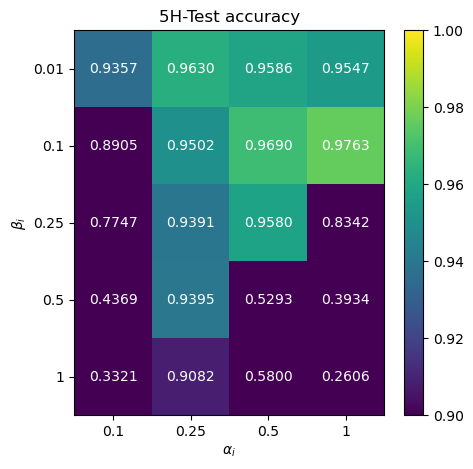

In [27]:
# -----------------------------------
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', '+', 'x', '|', '_']
linestyles = ['--', '-.', ':', '-']
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'lime', 'teal', 'olive', 'hotpink']
colors_r = ['darkred', 'red', 'orangered','coral','sandybrown']
colors_b = ['darkblue', 'blue', 'slateblue','deepskyblue','skyblue']
colors_g = ['darkgreen', 'green', 'seagreen','lime','mediumspringgreen']

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)']
# #----------------
# res[iM][iPara][imultitest][1][epoch]

trainacc = np.mean(np.max(res[:,:,:,1,:],axis=-1),axis=-1)
testacc = np.mean(np.max(res[:,:,:,2,:],axis=-1),axis=-1)
# ftmle = np.mean(np.max(res[:,:,:,3,:],axis=-1),axis=-1)
# sr = np.mean(np.max(res[:,:,:,5,:],axis=-1),axis=-1)
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plt.subplot(1,1,1)
c_lim = [0.9, 1]
plt.imshow(testacc, aspect='auto', cmap='viridis', interpolation='nearest', clim=c_lim)
for i in range(testacc.shape[0]):  # 
    for j in range(testacc.shape[1]):  # 
        # 
        plt.text(j, i, f'{testacc[i, j]:.4f}', 
                 ha='center', va='center', 
                 color='white' if testacc[i, j] < 50 else 'black')
        
plt.title(f'{config.nL_hidd}H-Test accuracy')

plt.xticks(range(len(ParaRange)),ParaRange)
plt.yticks(range(len(M_range)),M_range)

# plt.xlabel(f'fsc')
# plt.ylabel(f'bsc')
plt.xlabel(r'$\alpha_i$')
plt.ylabel(r'$\beta_i$')
plt.colorbar()


if config.save:  plt.savefig(res_path / f"plot_2d_{config.nL_hidd}H-Test accuracy.svg", format="svg")  #  
# plt.show()
